In [386]:
library(DBI)
library(RSQLite)
library(dplyr)
library(ggplot2)

In [132]:
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}

Loading required package: ggExtra

Warning message:
"package 'ggExtra' was built under R version 3.6.2"
Loading required package: naniar

Warning message:
"package 'naniar' was built under R version 3.6.2"
Loading required package: mvoutlier

Warning message:
"package 'mvoutlier' was built under R version 3.6.2"
Loading required package: sgeostat

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

sROC 0.1-2 loaded

Loading required package: MatchIt

Warning message:
"package 'MatchIt' was built under R version 3.6.2"


In [387]:
load("C:/Users/Guy/Documents/DataScience/Data/movies_ff_v.rdata")

In [388]:
for (v in names(movies_ff_v[,1:85])){
    print(v)
    print(length(unique(movies_ff_v[[v]])))
}

[1] "movie_id"
[1] 7375
[1] "budget"
[1] 704
[1] "original_language"
[1] 44
[1] "popularity"
[1] 7371
[1] "release_date"
[1] 4697
[1] "runtime"
[1] 168
[1] "runtime_cat"
[1] 3
[1] "revenue"
[1] 2845
[1] "sw_lang_en"
[1] 2
[1] "sw_web_presence"
[1] 2
[1] "sw_has_poster"
[1] 2
[1] "sw_tagline"
[1] 2
[1] "keyword_cnt"
[1] 46
[1] "release_year"
[1] 99
[1] "release_month"
[1] 13
[1] "high_release_month"
[1] 2
[1] "release_day"
[1] 32
[1] "seasonality"
[1] 13
[1] "sw_collection"
[1] 3
[1] "producers_cnt"
[1] 25
[1] "countries_cnt"
[1] 12
[1] "lang_US"
[1] 2
[1] "lang_FR"
[1] 2
[1] "lang_RU"
[1] 2
[1] "lang_ES"
[1] 2
[1] "lang_JA"
[1] 2
[1] "keywords_cnt"
[1] 46
[1] "actor0_movies_cnt"
[1] 61
[1] "actor0_movies_5y_cnt"
[1] 17
[1] "actor1_movies_cnt"
[1] 59
[1] "actor1_movies_5y_cnt"
[1] 18
[1] "actor2_movies_cnt"
[1] 53
[1] "actor2_movies_5y_cnt"
[1] 16
[1] "sw_female_actor0"
[1] 3
[1] "sw_female_actor1"
[1] 3
[1] "sw_female_actor2"
[1] 3
[1] "sw_male_actor0"
[1] 3
[1] "sw_male_actor1"
[1] 3


In [389]:
missingMatrix <- function(data) {
    vn <- names(data[,2:85])
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}
getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [390]:
exploreData <- function(data=data, y=NULL, rn=NULL, factorSize=10, dir="report", debug=FALSE, ...) {

  get_computer_type <- function(){
    # check if current R client is running on PC or on the server
    if (Sys.info()[1] == "Windows") {
      computer.type = "pc"
    } else if (Sys.info()[1] == "Linux") {
      computer.type = "server"
    }
    return(computer.type)
  }

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=T),sd=stats::sd(x,na.rm=T))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=T), "<br><u>Max date</u>:",max(x, na.rm=T) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    #pl <- stats::scatter.smooth(df$x,col=df$cl)
    pl <- tryCatch({
      stats::scatter.smooth(df$x,col=df$cl,xlab="index")
    }, warning = function(w) {
      n <- "warning!"
    }, error = function(e) {
      n <- "error!"
    }, finally = {
      graphics::plot(df$x ~ row.names(df),col=df$cl,xlab="index")
    })
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  getScatterGraph <- function(df=data,x,y,dtype=1) {
    #  mod <- tryCatch({
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(ggplot2::aes(x=data[[x]], y=data[[y]]), method="loess") + ggplot2::xlab(x) + ggplot2::ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(ggplot2::aes(y=data[[x]], color=data[[y]])) + ggplot2::xlab(x) + ggplot2::ylab(y) + ggplot2::labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(unique(bp)), collapse=', ' )
    }
    imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")

  ################## Check for values for rn ##################
  if(!is.null(rn)) {
    if(length(rn)!=ncol(data)) {
      message("the value of the 'rn' argument was avoided because it does not have the same number of columns of the dataframe")
      rn <- NULL
    }
    xname <- rn
    names(xname) <- names(data)
  } else {
    xname <- NULL
  }

  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  if (get_computer_type()=="pc") {
    srcdir <- paste0(getwd(),"/",report)
  } else {
    #srcdir <- paste0("file_show?path=",getwd(),"/",report)
    srcdir <- paste0("/view/",getwd(),"/report")
  }
  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>

      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });

      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });

      $('#myform2').submit(function(e) {
      e.preventDefault();
      });

      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });

      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });

      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });

      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });

      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });

      </script>

      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      background-color:#4C6F50;
      color: #fff;
      }
      .Row
      {
      display: table-row;
      }
      .Row:nth-child(even) {
        background-color: #56882433;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: Arial, Helvetica, sans-serif;
      font-size: 14px;
      }
      </style>

      </head>

      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)
  ln <- length(data)
  ii <- 0
  pb <- utils::txtProgressBar(min=0,max=ln,style=3)
  for(x in names(data)) {

    ## check if the value has at least more than one unique value...
    if(length(unique(data[[x]])) < 2) {
      message(paste("The variable",x,"has less than two unique values, so will not be included"))
    } else {

      if(debug==TRUE) {
        print(x)
      } else {
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)
      }

      html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b><p>",xname[x],"</p></div>")

      cat(html, file = myhtml, sep='\n', append=TRUE)
      #### initialize the first graph
      imgname = paste(fig,"/",x, "_1.png",sep="")
      imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
      ### send the data with the type to generate the correct graph..
      grDevices::png(imgname)
      drawGraphOne(x, data[[x]], data_types[x])
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # second, show the statistics
      html <- getStats(data[[x]],data_types[x])
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # third, determine the outliers
      imgname = paste(fig,"/",x, "_2.png",sep="")
      if(data_types[x]==1) {
        grDevices::png(imgname)
        getOutlierGraph(data[[x]])
        grDevices::dev.off()
        html <- getOutliersHtml(x,data[[x]],srcdir)
      } else {
        html <- "<div class='Cell'></div>"
      }
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # fourth, if y is assigned, make a corresponding plot
      if(is.null(y)==FALSE) {
        imgname = paste(fig,"/",x, "_3.png",sep="")
        imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
        #print(imgname)
        grDevices::png(imgname)
        ### scatter.smooth(data[[x]] ~ data[[y]])
        #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
        plot(getScatterGraph(data,x,y,data_types[y]))
        grDevices::dev.off()
        html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
        cat(html, file = myhtml, sep='\n', append=TRUE)
      }
      html <- paste("</div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      }
    }
  }
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  if(.Platform$OS.type == "unix") {
    system(paste("start /b ", myhtml))
  } else {
    shell(paste("explorer ", gsub("/", "\\\\", myhtml) ), intern=TRUE)
  }
}

###################### END exploreData ###############

2.1 - Descriptive statistics
Generate a table showing the minimum, maximum, median, IQR, mean and standard deviation for each variable

In [391]:
##question- 2.1,2.2,2.4,2.5
exploreData(data=movies_ff_v[,c(1:72,74:85)],y="revenue")

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4384 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4531 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.04"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.04"
Warning mess

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5310 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5534 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5621 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.2111e-014"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.115"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.115

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  8.8213e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.595"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.595

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  9.8819e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.165"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.165

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.855"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.145"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  3.4382e-028"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 0.855"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.145"


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  4.6794e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.07"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.07"
Wa

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0036"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf i

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 2"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 2"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.5653e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.06"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.06"
Wa

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |===================================================================== |  99%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  report\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

In [136]:
summary(movies_ff_v)

    movie_id        budget          original_language    popularity     
 Min.   :   1   Min.   :        0   Length:7375        Min.   :  0.000  
 1st Qu.:1848   1st Qu.:        0   Class :character   1st Qu.:  3.970  
 Median :3696   Median :  8000000   Mode  :character   Median :  7.456  
 Mean   :3698   Mean   : 22666657                      Mean   :  8.540  
 3rd Qu.:5550   3rd Qu.: 29000000                      3rd Qu.: 10.932  
 Max.   :7398   Max.   :380000000                      Max.   :547.488  
                                                                        
  release_date           runtime      runtime_cat           revenue         
 Min.   :1918-08-01   Min.   :  0.0   Length:7375        Min.   :1.000e+00  
 1st Qu.:1992-11-13   1st Qu.: 94.0   Class :character   1st Qu.:2.405e+06  
 Median :2004-07-29   Median :104.0   Mode  :character   Median :1.693e+07  
 Mean   :2000-03-15   Mean   :107.7                      Mean   :6.688e+07  
 3rd Qu.:2011-06-27   3rd Qu.:1

Warning message:
"package 'GGally' was built under R version 3.6.2"

Attaching package: 'GGally'


The following object is masked from 'package:dplyr':

    nasa


Warning message in ggcorr(movies_ff_v, method = c("pairwise", "spearman"), nbreaks = NULL, :
"data in column(s) 'original_language', 'release_date', 'runtime_cat' are not numeric and were ignored"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = meth

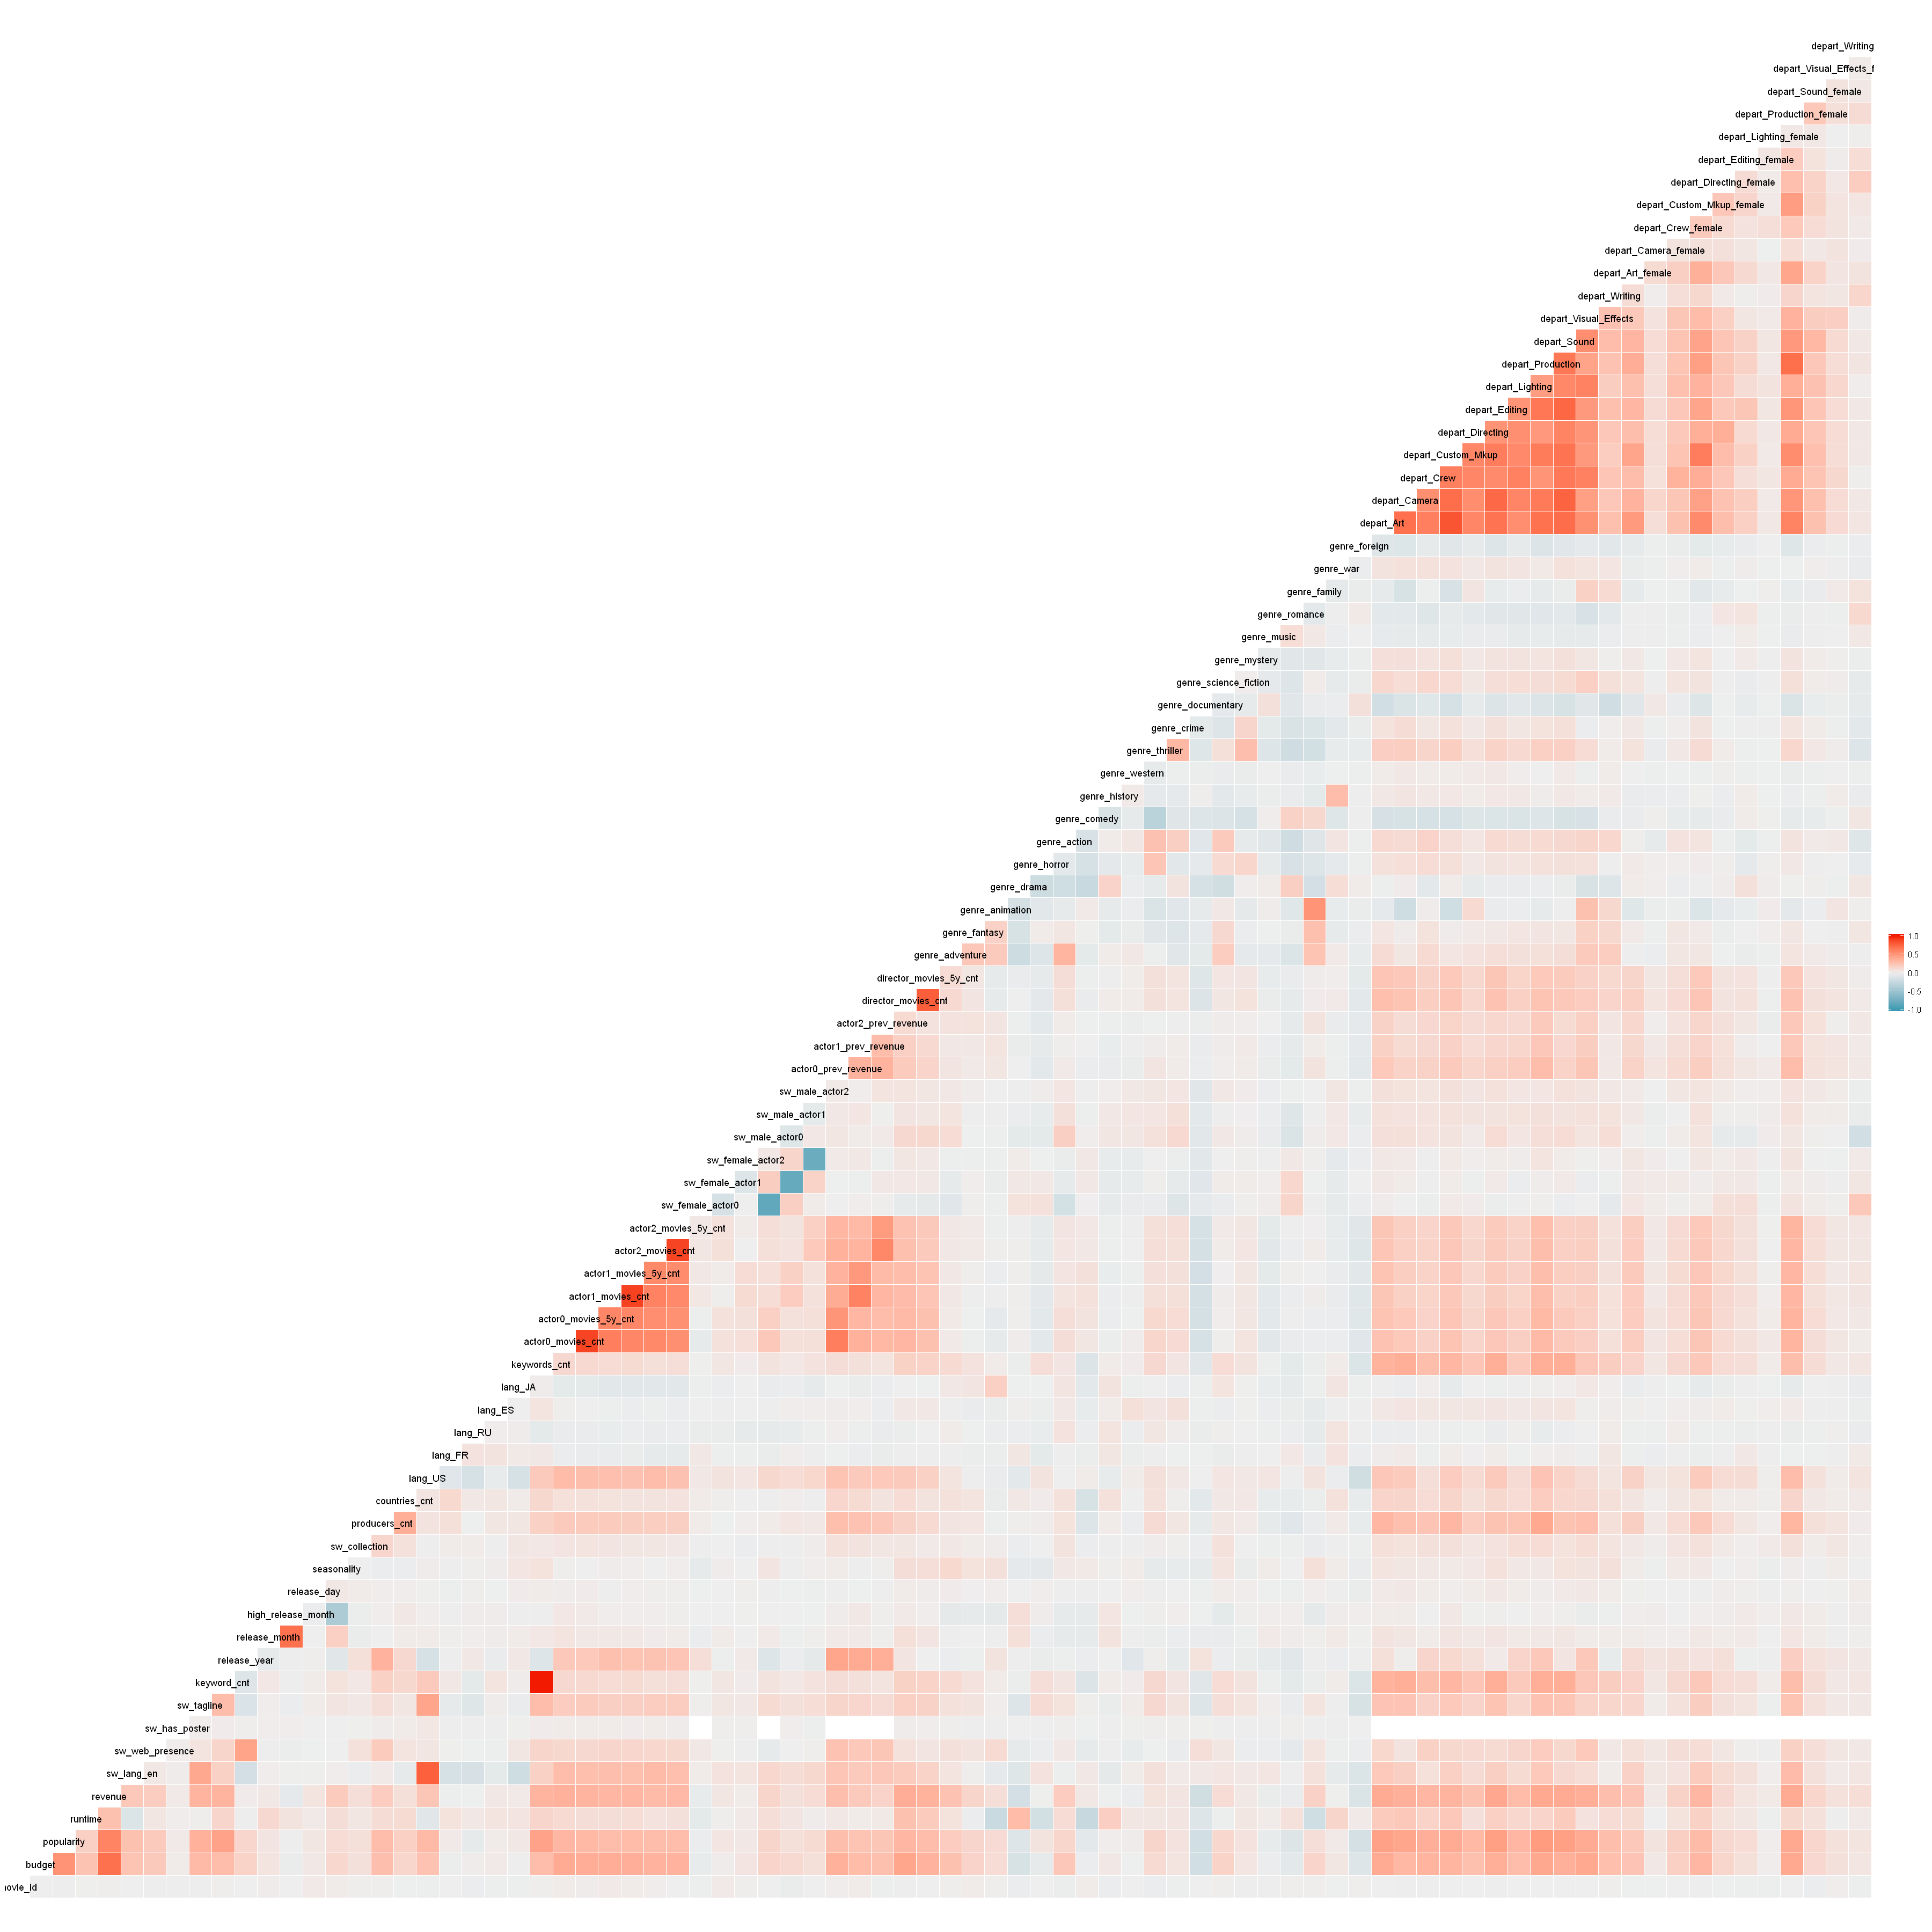

In [137]:
#question2.3 correlation matrix
#install.packages("GGally")
library(GGally)
options(repr.plot.width = 30, repr.plot.height = 30)
ggcorr(movies_ff_v, method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

Warning message in ggcorr(movies_ff_v[, 1:20], method = c("pairwise", "spearman"), :
"data in column(s) 'original_language', 'release_date', 'runtime_cat' are not numeric and were ignored"


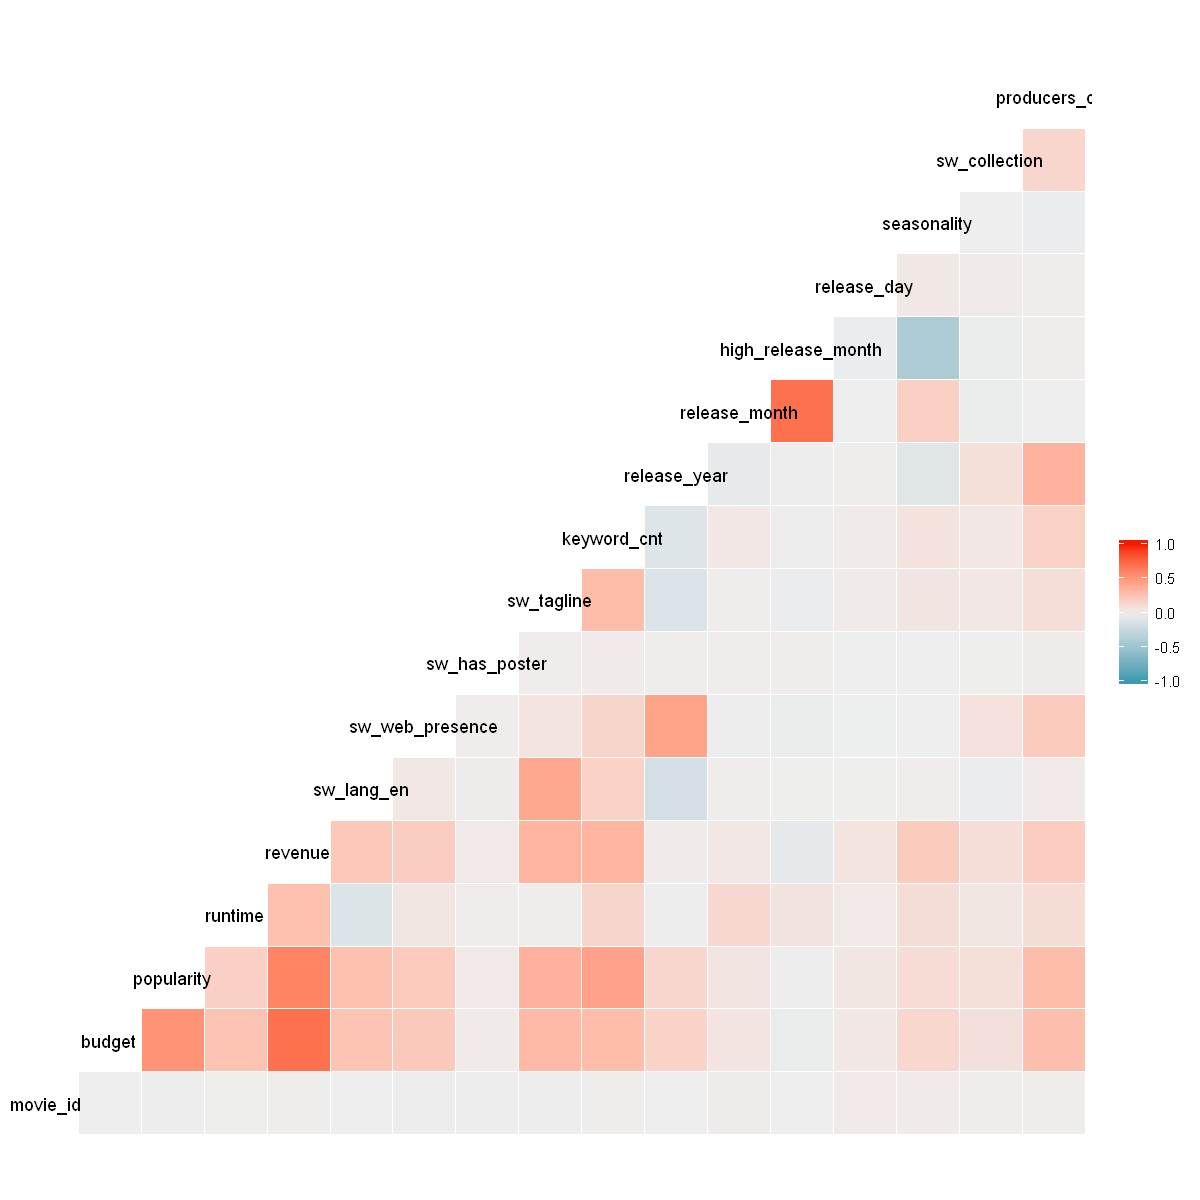

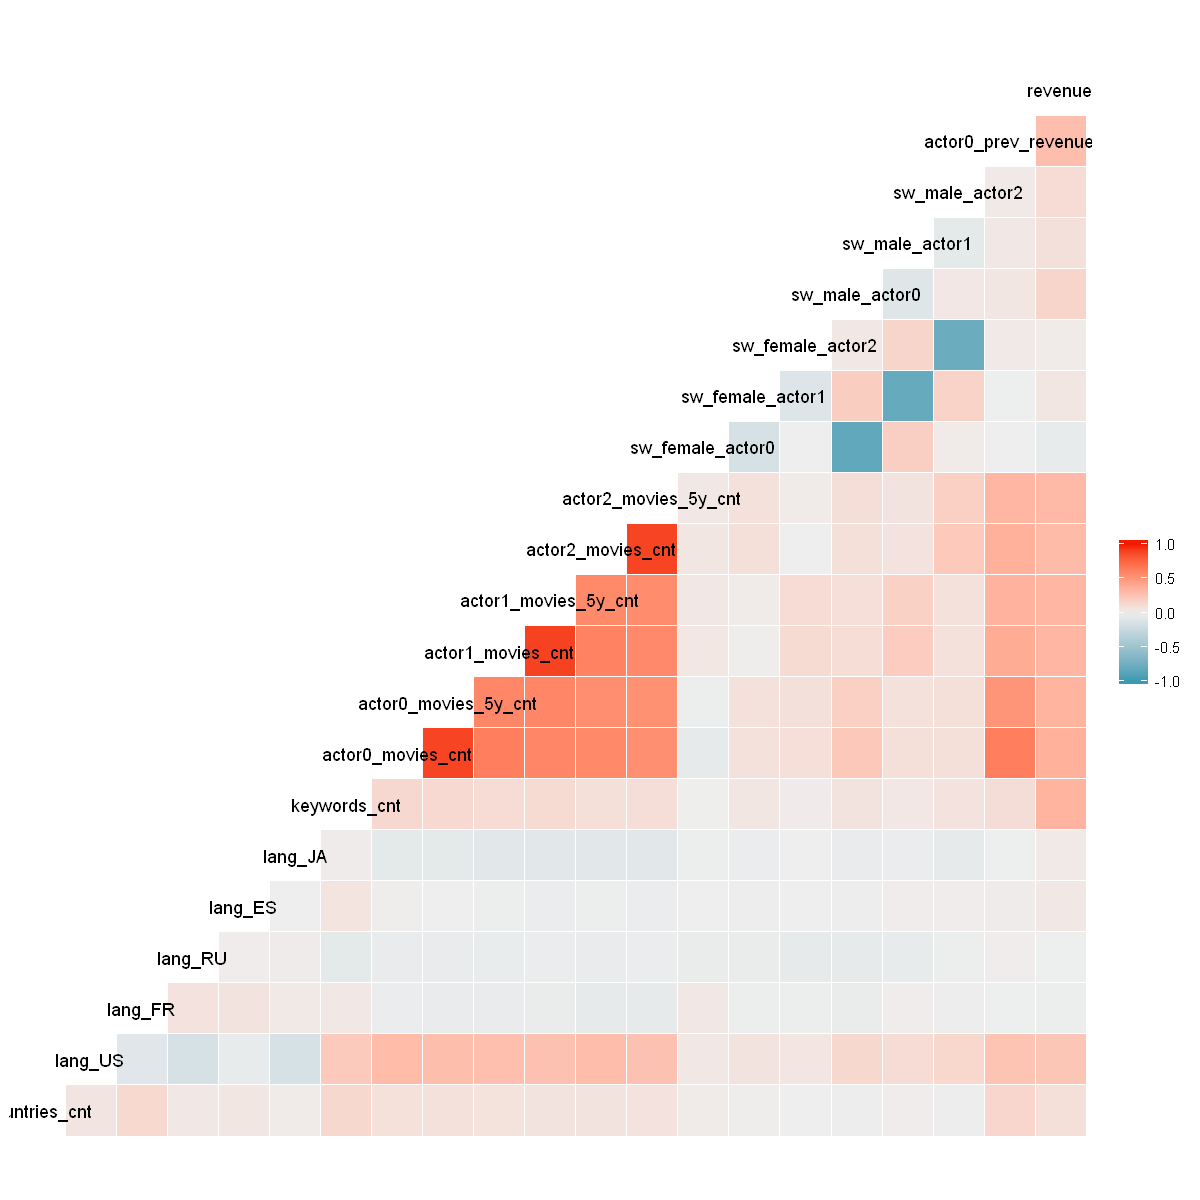

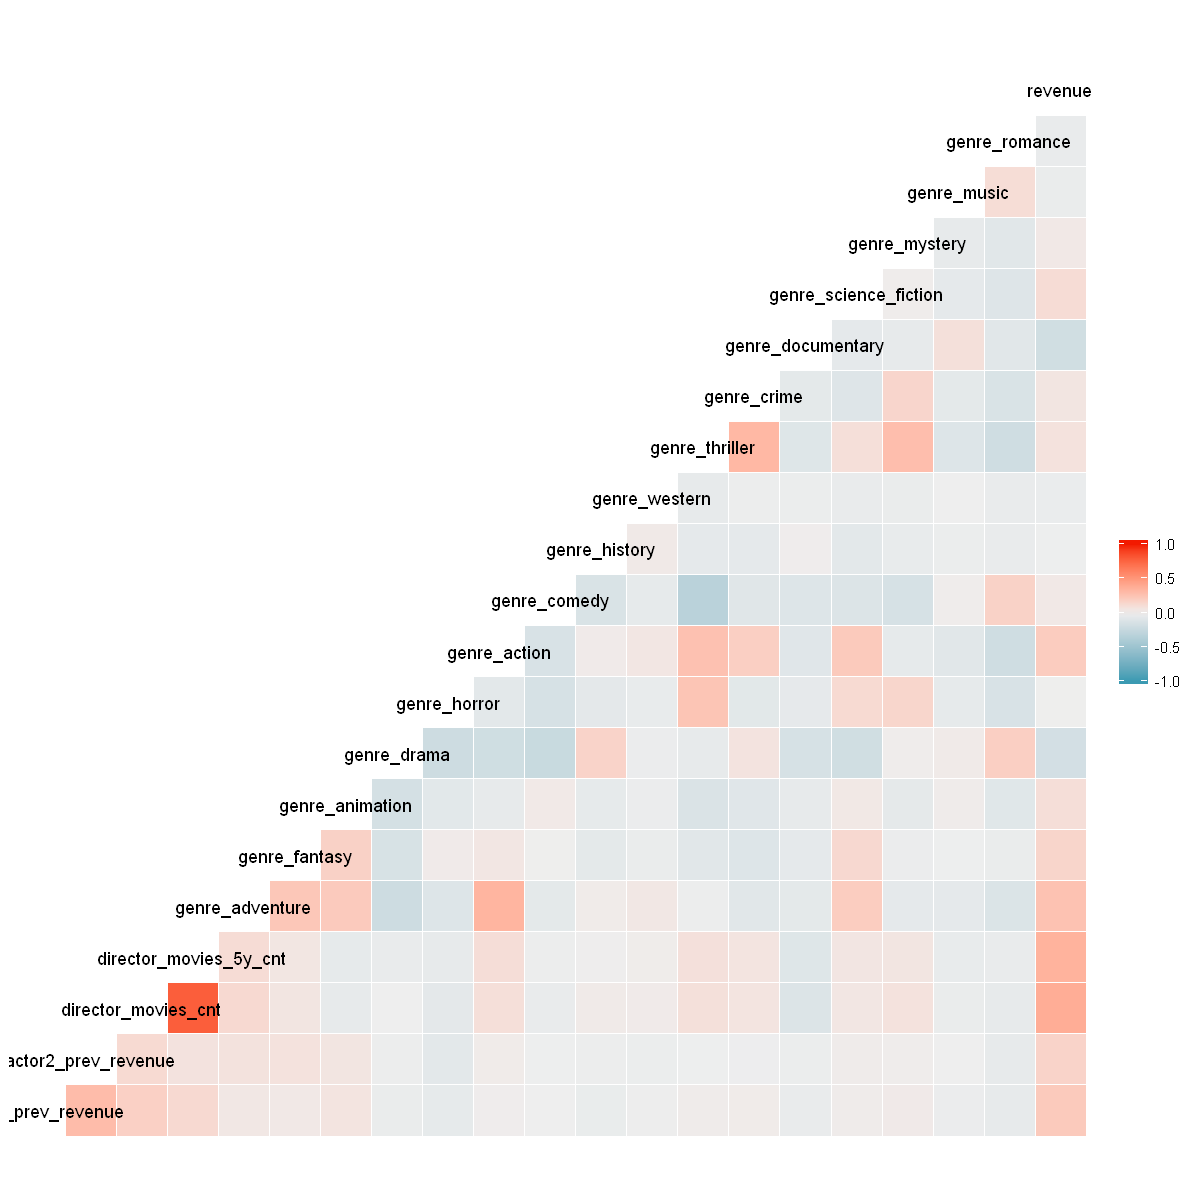

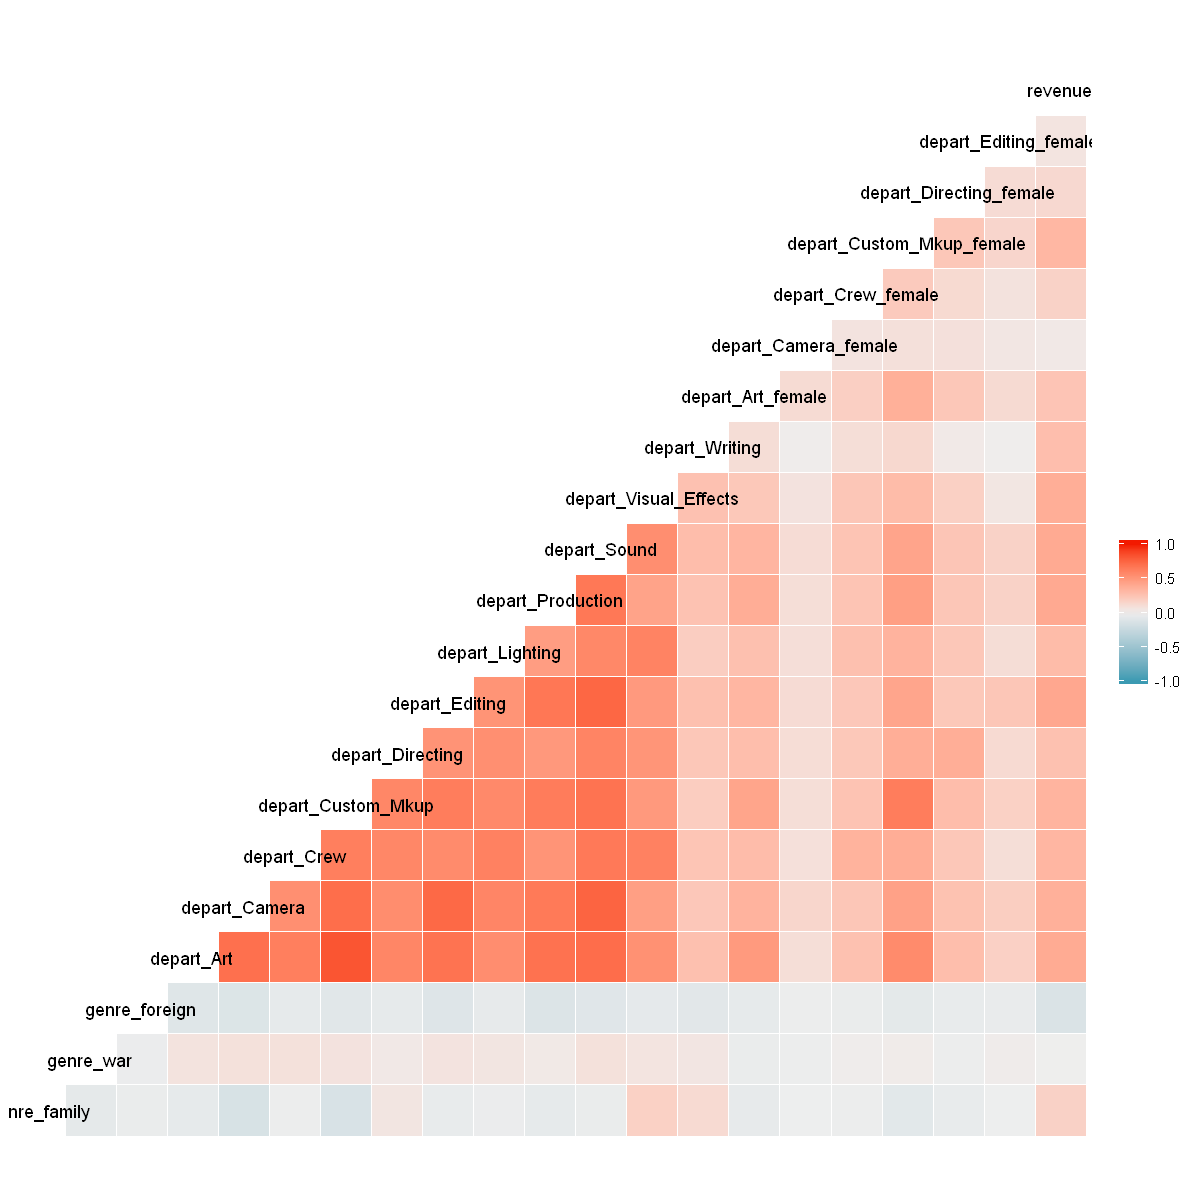

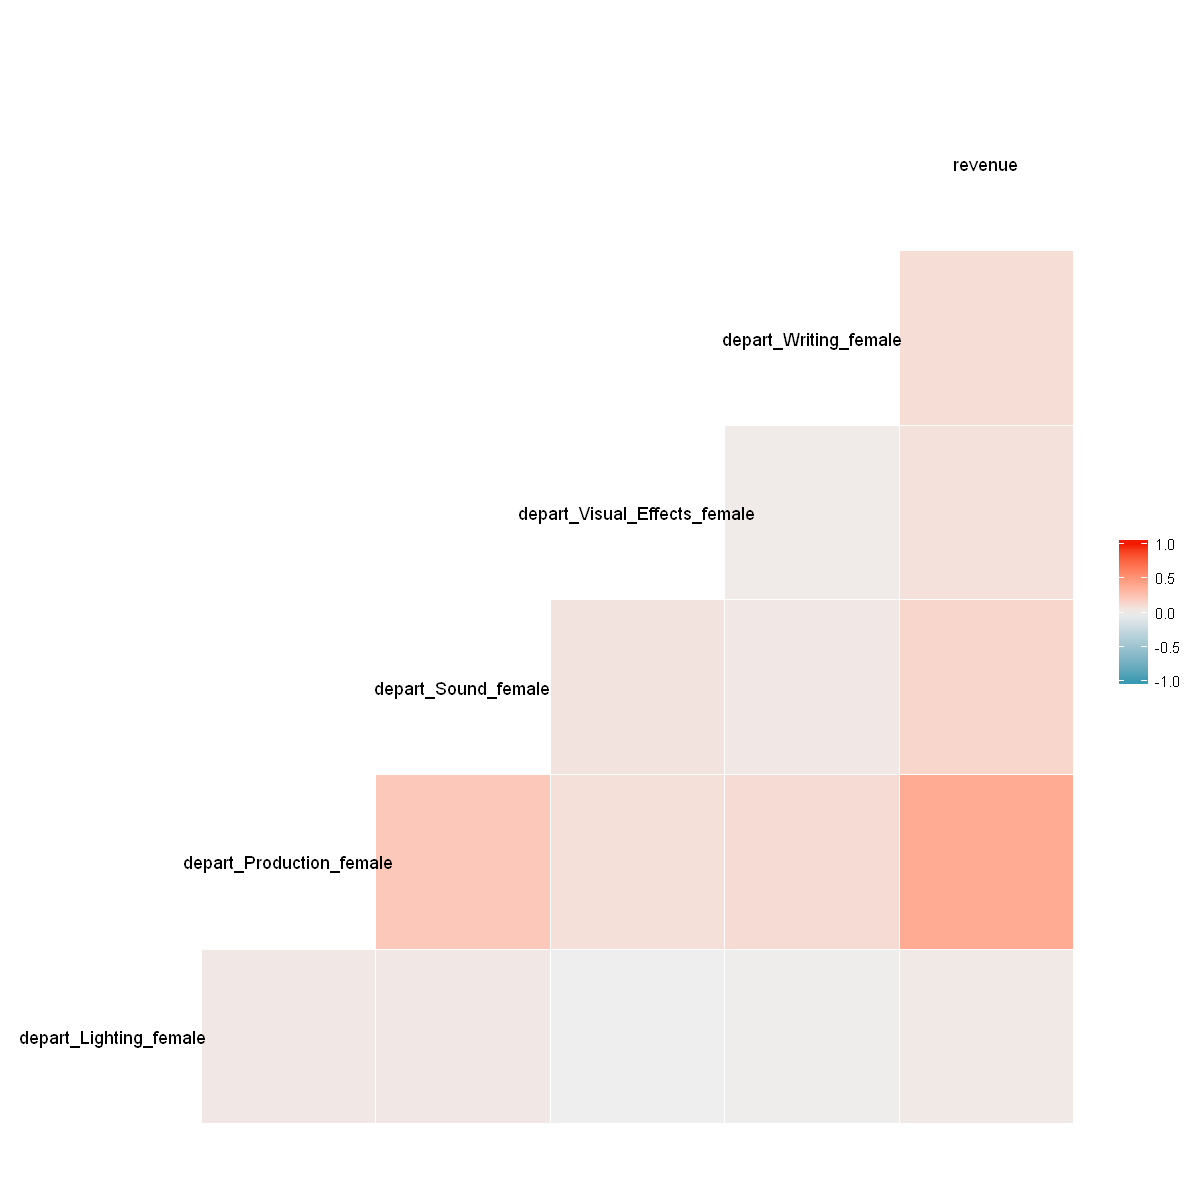

In [138]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggcorr(movies_ff_v[,1:20], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(21:40,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(41:60,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(61:80,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies_ff_v[,c(81:85,8)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)


2.4 Describe the outcome variable
Histogram
Histogram by categories

In [392]:
##question 2.4

## creating vector of the categoric variables
cn<- c()
for (v in names(movies_ff_v[,2:85])){
    if ((v %in% c('release_day','release_month','release_date','release_year'))|(is.numeric(movies_ff_v[[v]])==F)|
        (max(movies_ff_v[[v]],na.rm=T)==1 & length(unique(movies_ff_v[[v]]))<=3)) {
        cn<- c(cn,v)
    } 
}

In [383]:

cn

[1] "original_language"      "release_date"           "runtime_cat"           
 [4] "sw_lang_en"             "sw_web_presence"        "sw_has_poster"         
 [7] "sw_tagline"             "release_year"           "release_month"         
[10] "high_release_month"     "release_day"            "lang_US"               
[13] "lang_FR"                "lang_RU"                "lang_ES"               
[16] "lang_JA"                "sw_female_actor0"       "sw_female_actor1"      
[19] "sw_female_actor2"       "sw_male_actor0"         "sw_male_actor1"        
[22] "sw_male_actor2"         "genre_adventure"        "genre_fantasy"         
[25] "genre_animation"        "genre_drama"            "genre_horror"          
[28] "genre_action"           "genre_comedy"           "genre_history"         
[31] "genre_western"          "genre_thriller"         "genre_crime"           
[34] "genre_documentary"      "genre_science_fiction"  "genre_mystery"         
[37] "genre_music"            "genre_romance"          "genre_family"          
[40] "genre_war"              "genre_foreign"          "depart_Lighting_female"

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


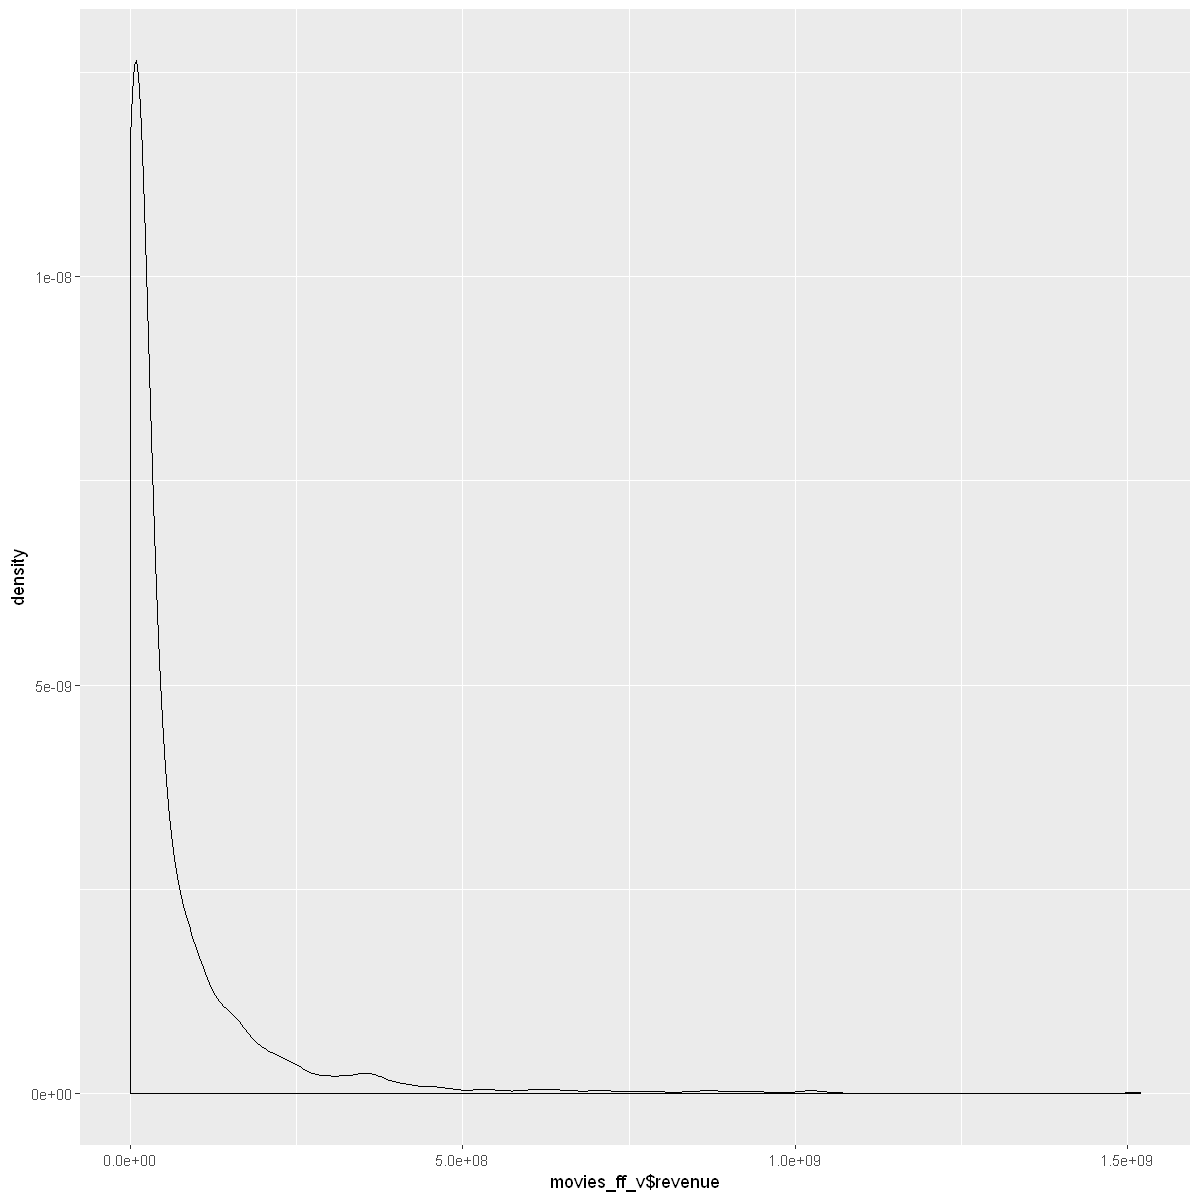

In [384]:
#distribution of revenue- question 2.4
print(ggplot(movies_ff_v,aes(x=movies_ff_v$revenue)) +
    geom_density(adjust=2))


Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Removed 4382 rows containing non-finite values (stat_

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."


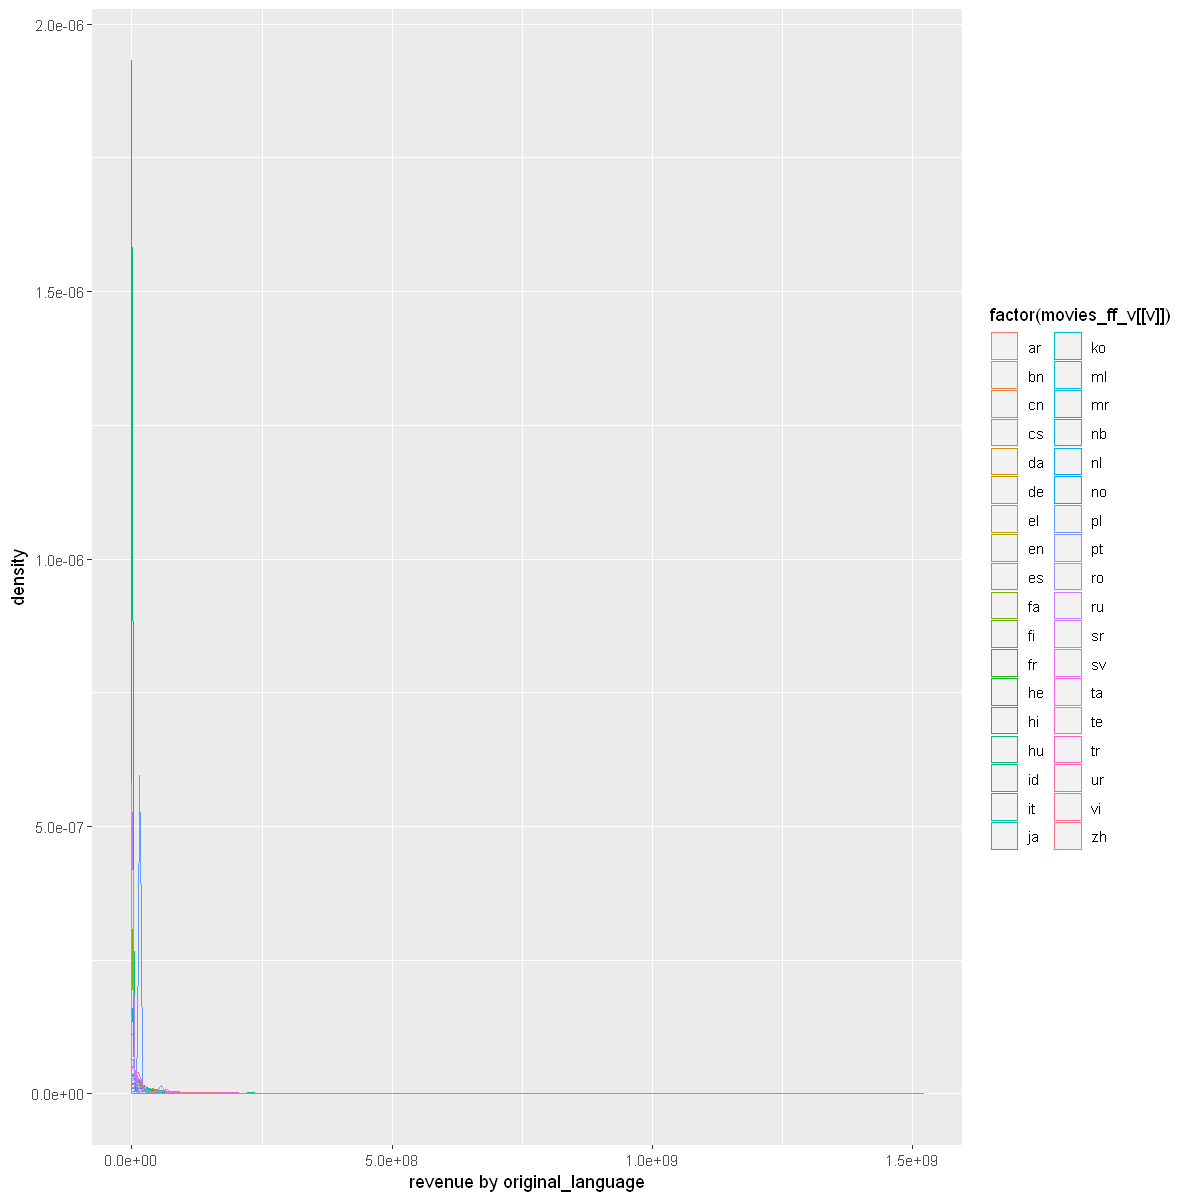

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


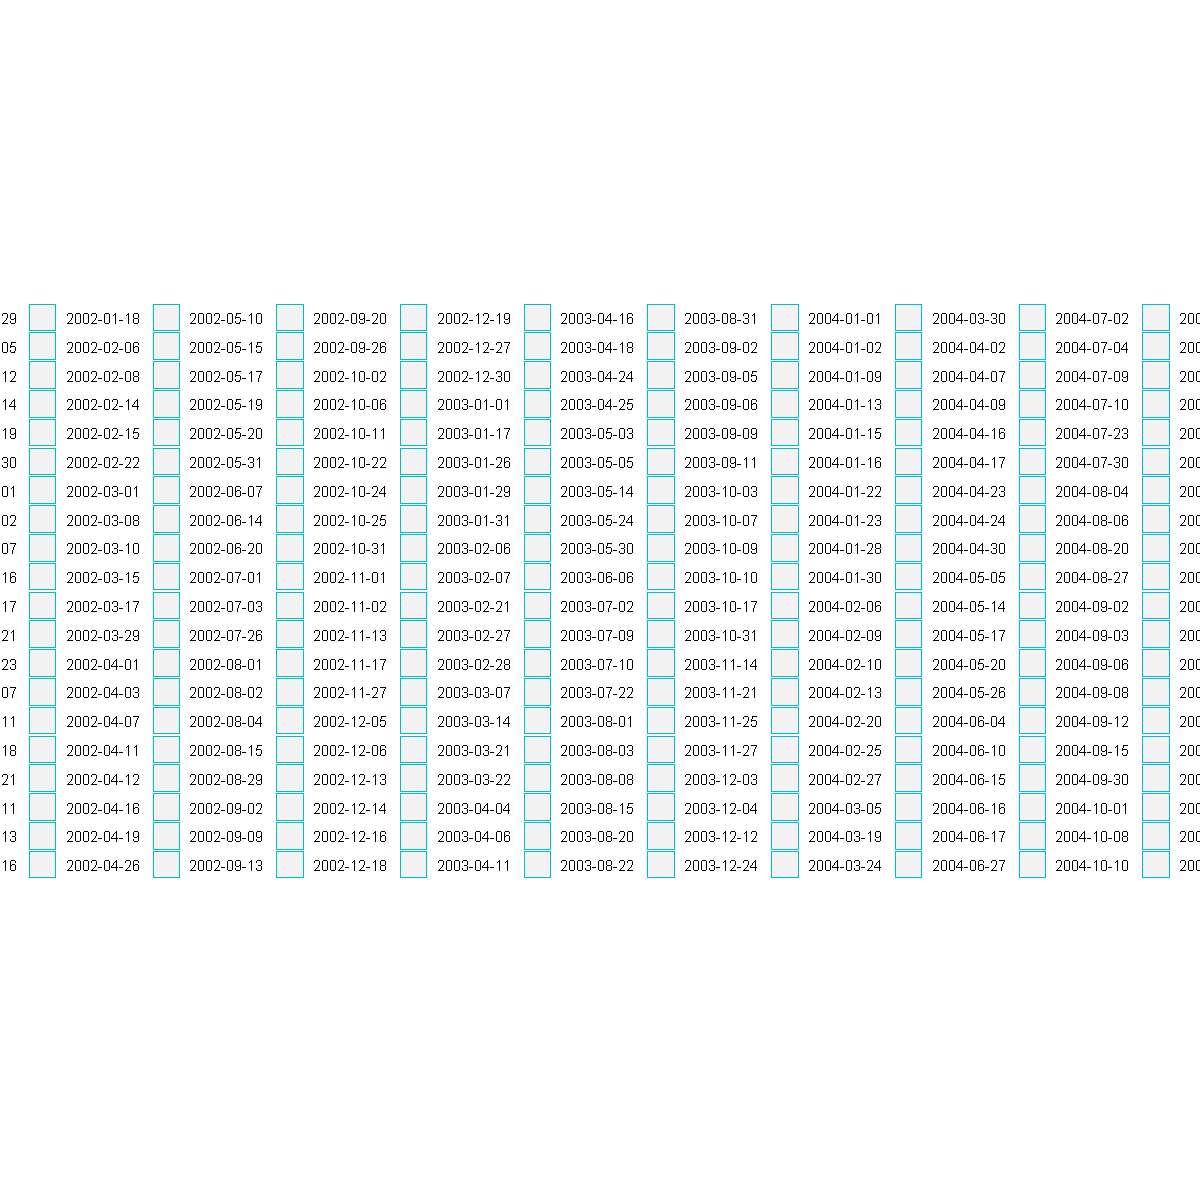

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


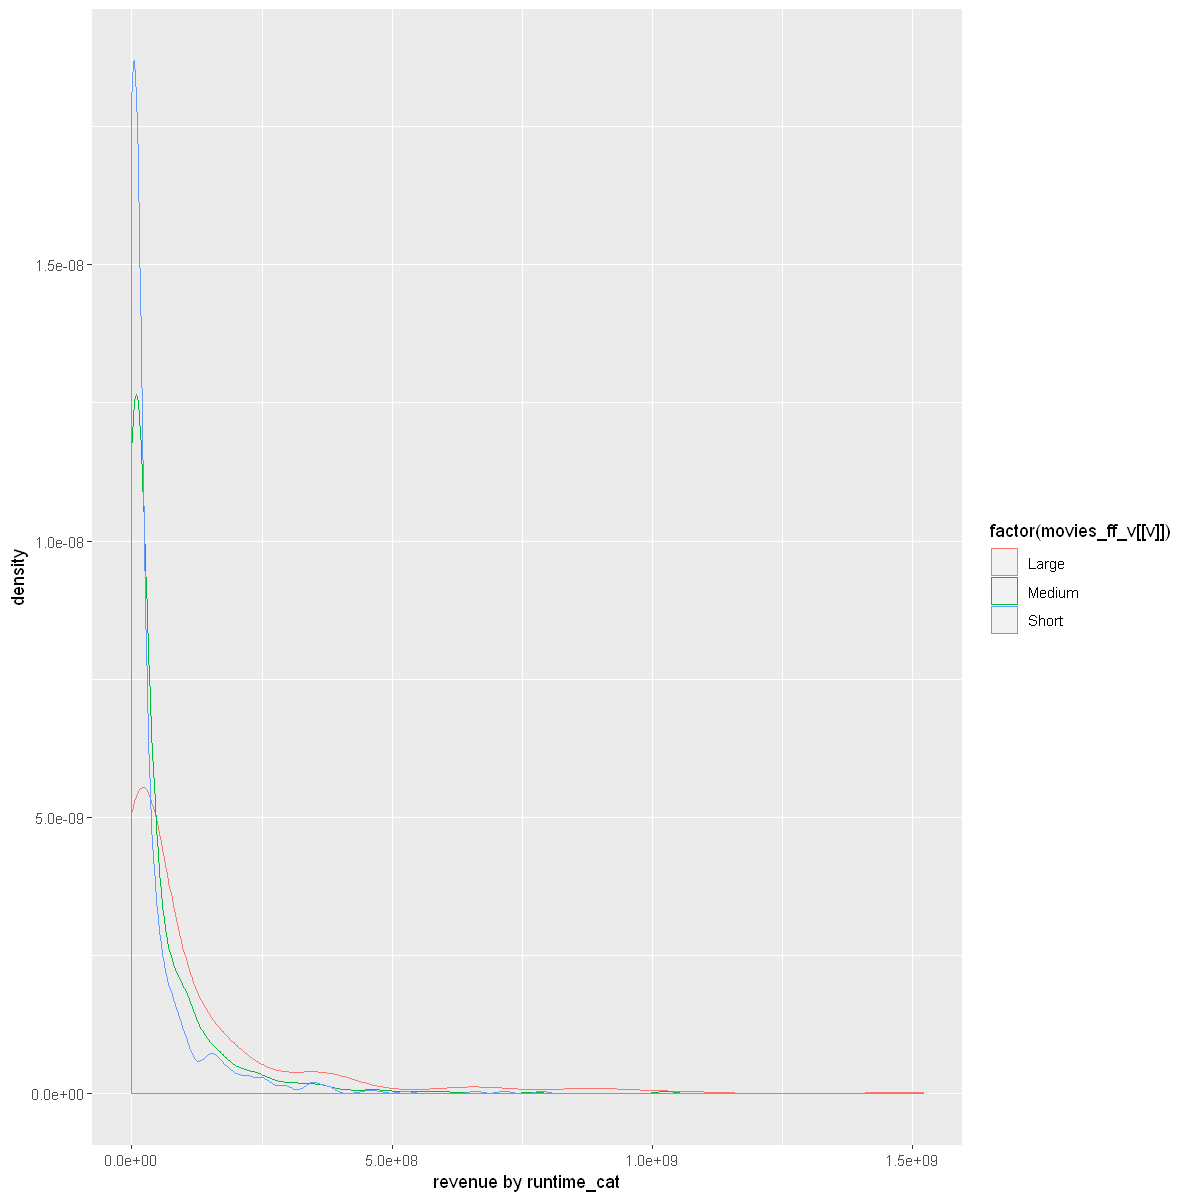

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


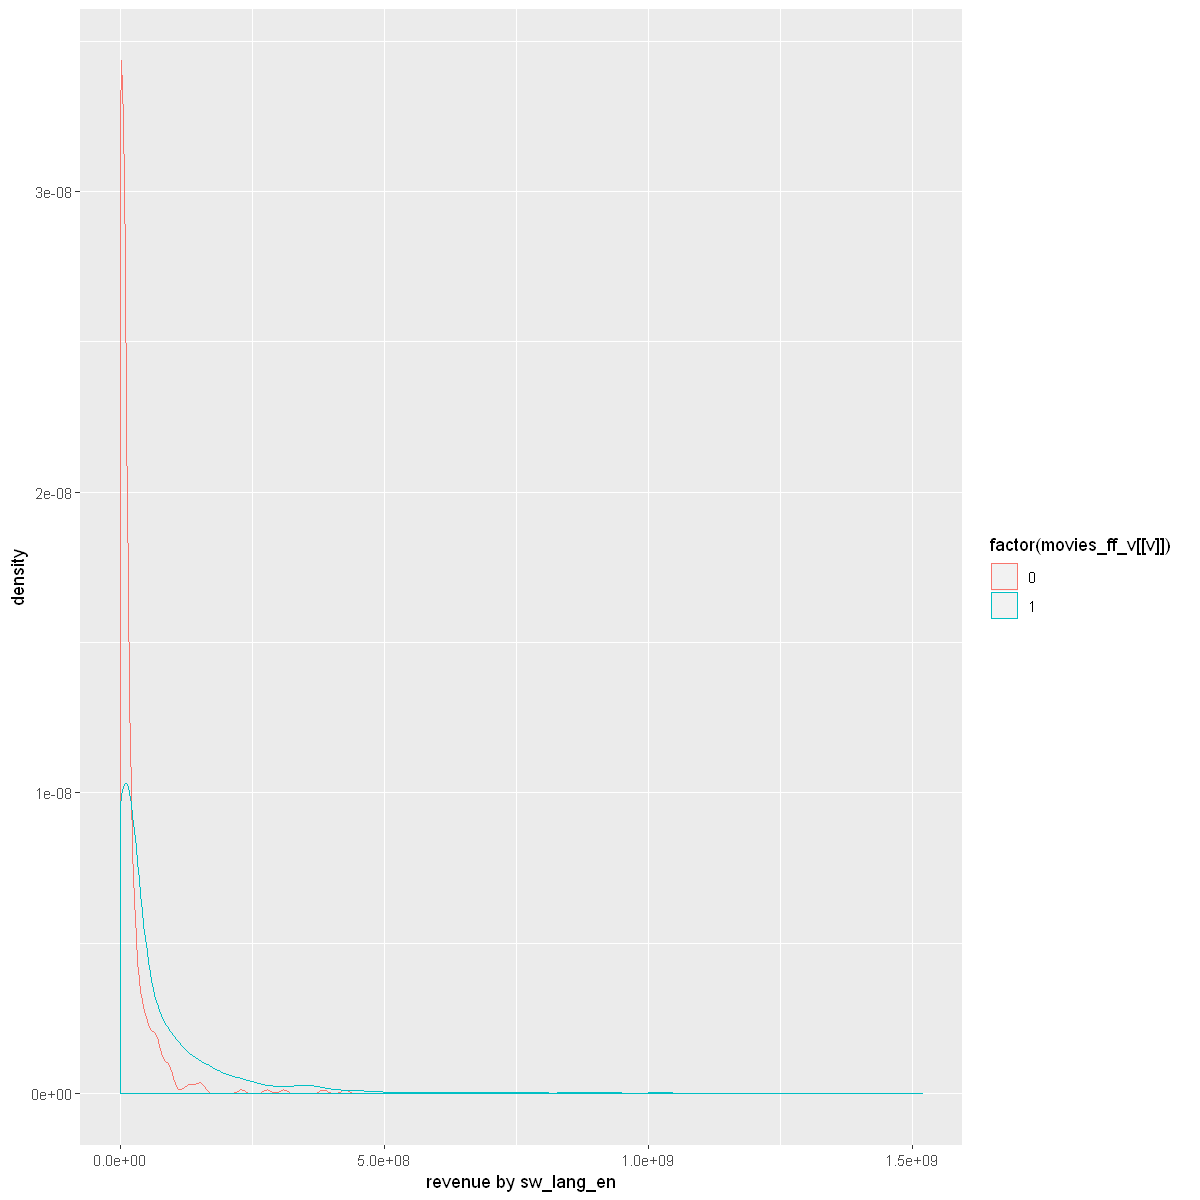

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."


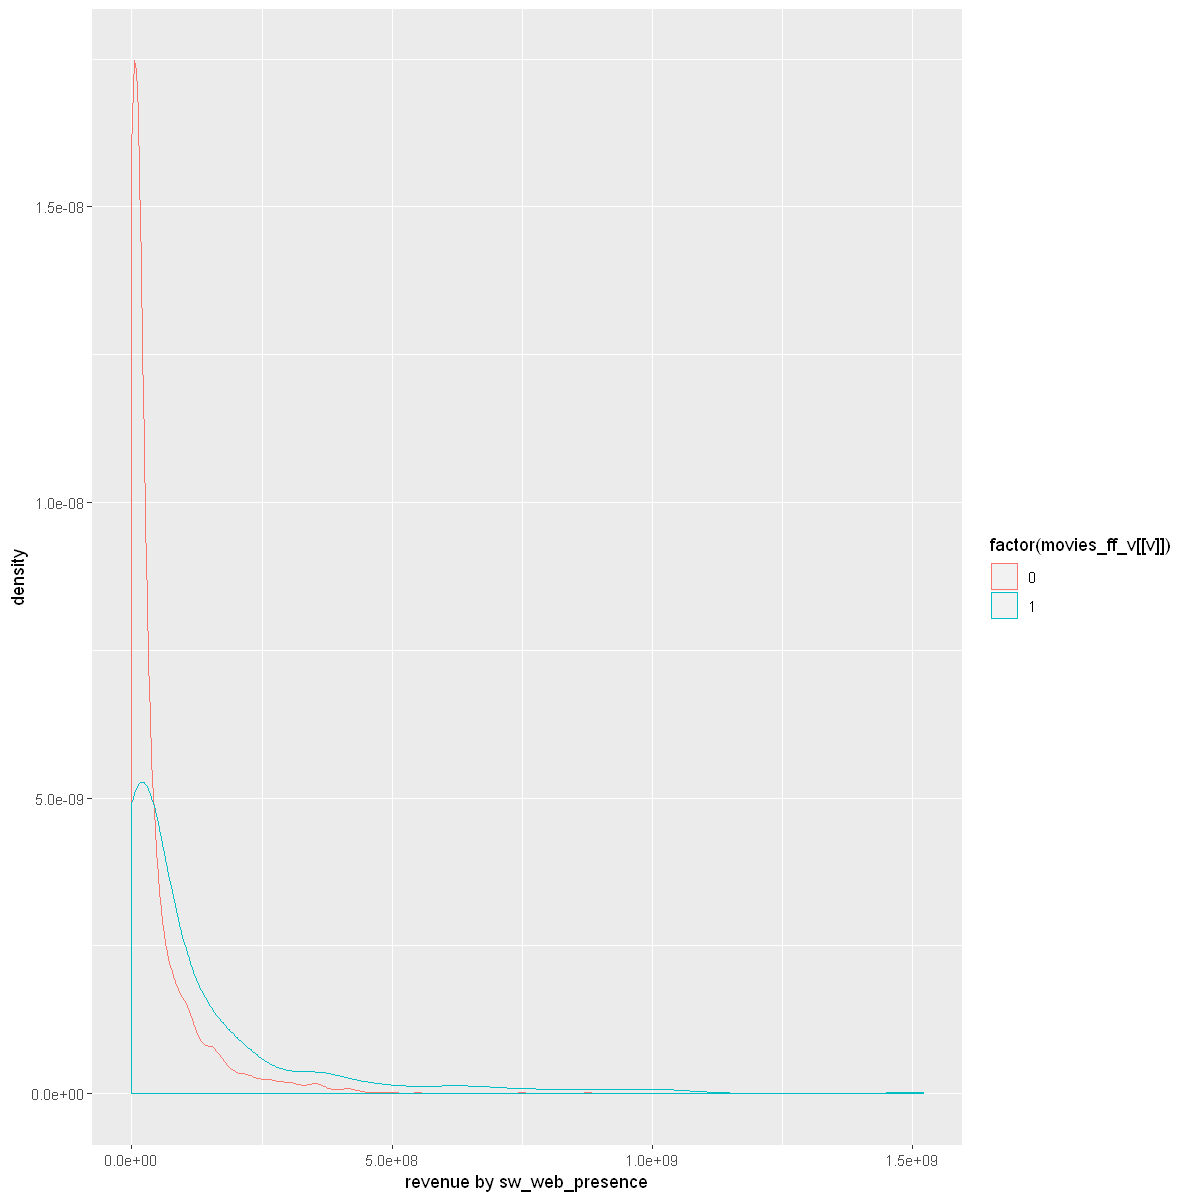

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


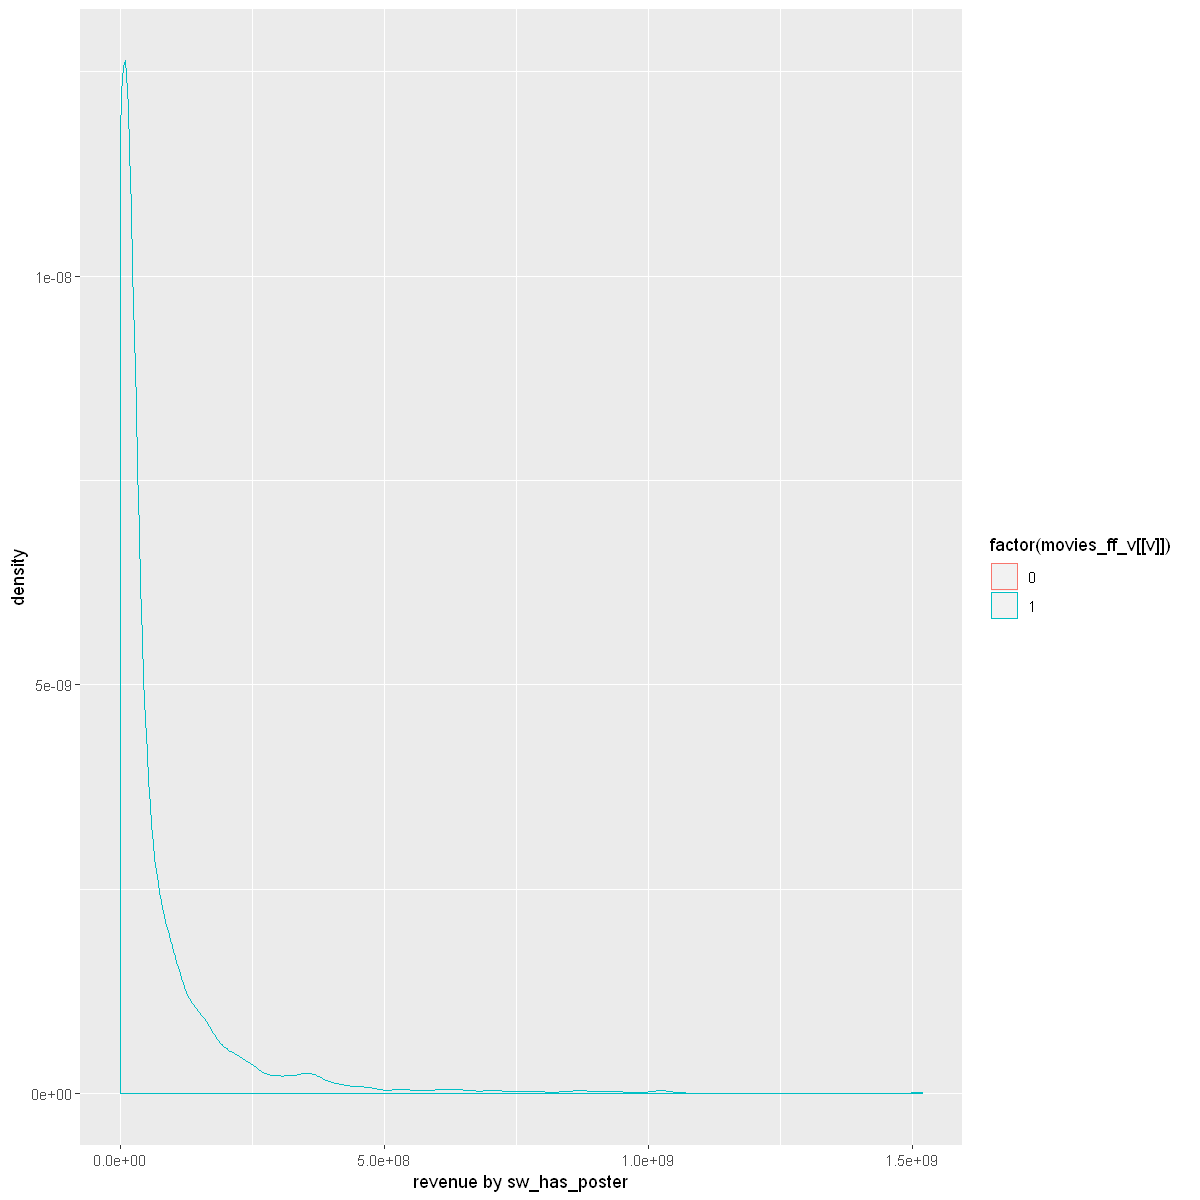

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."


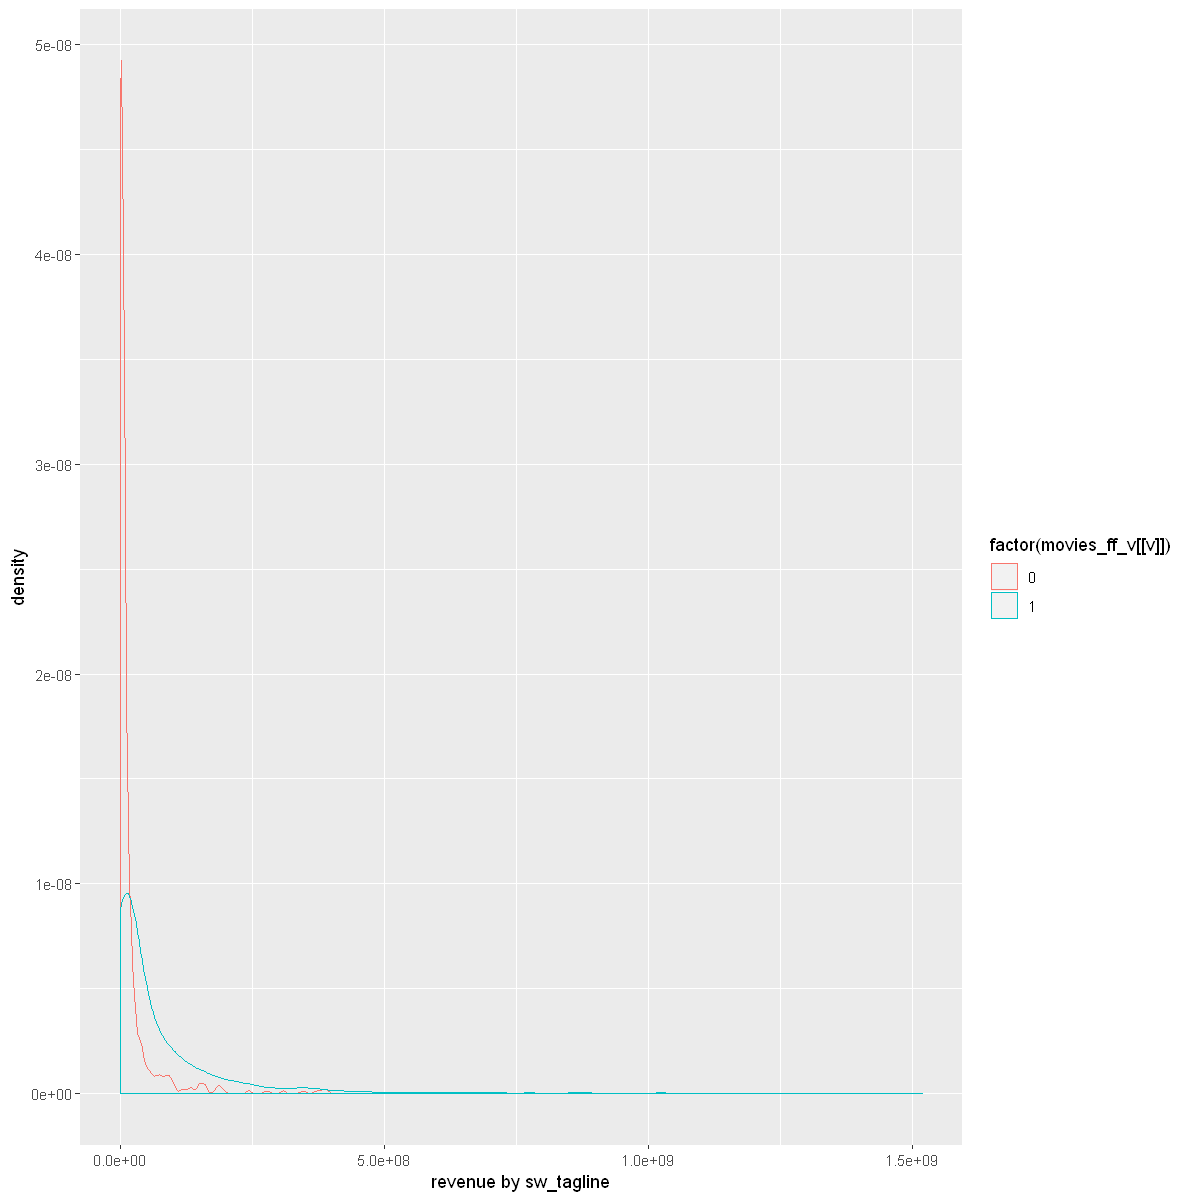

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


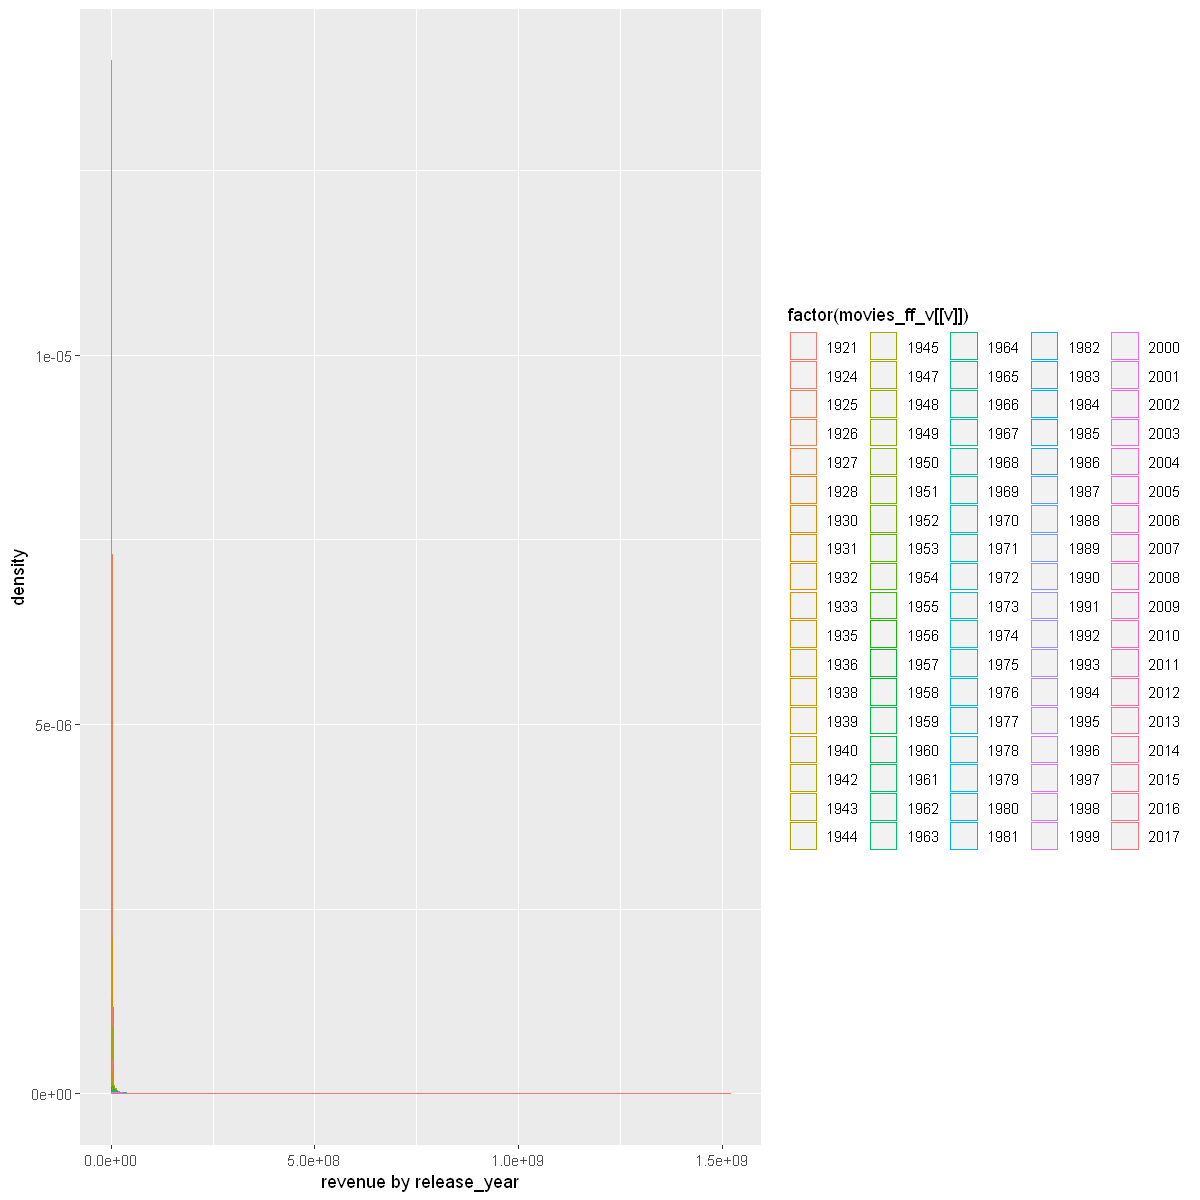

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


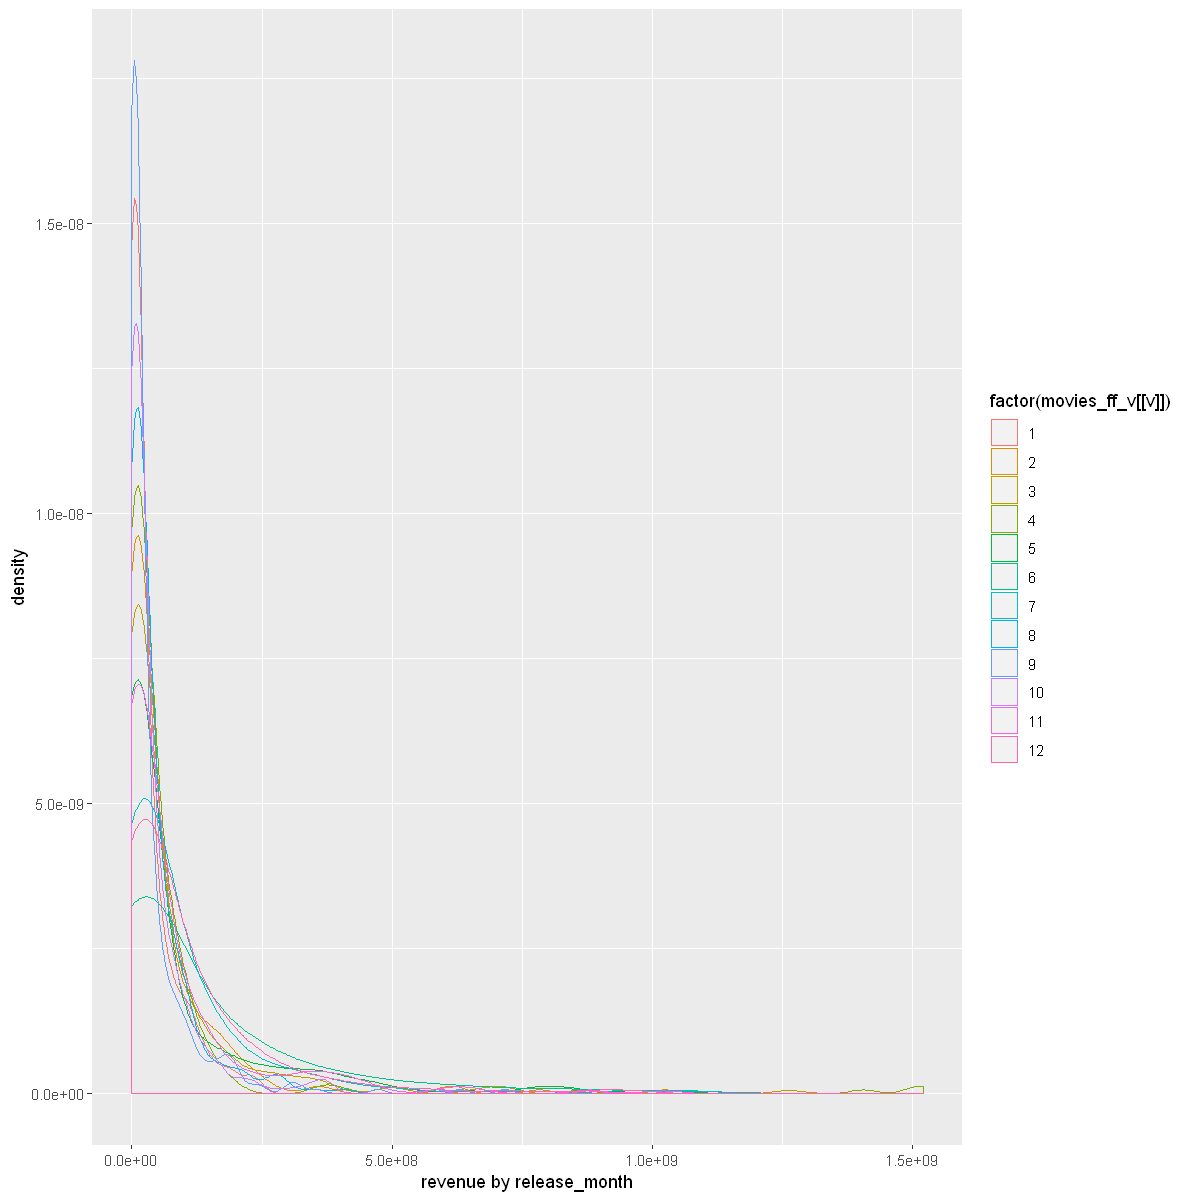

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


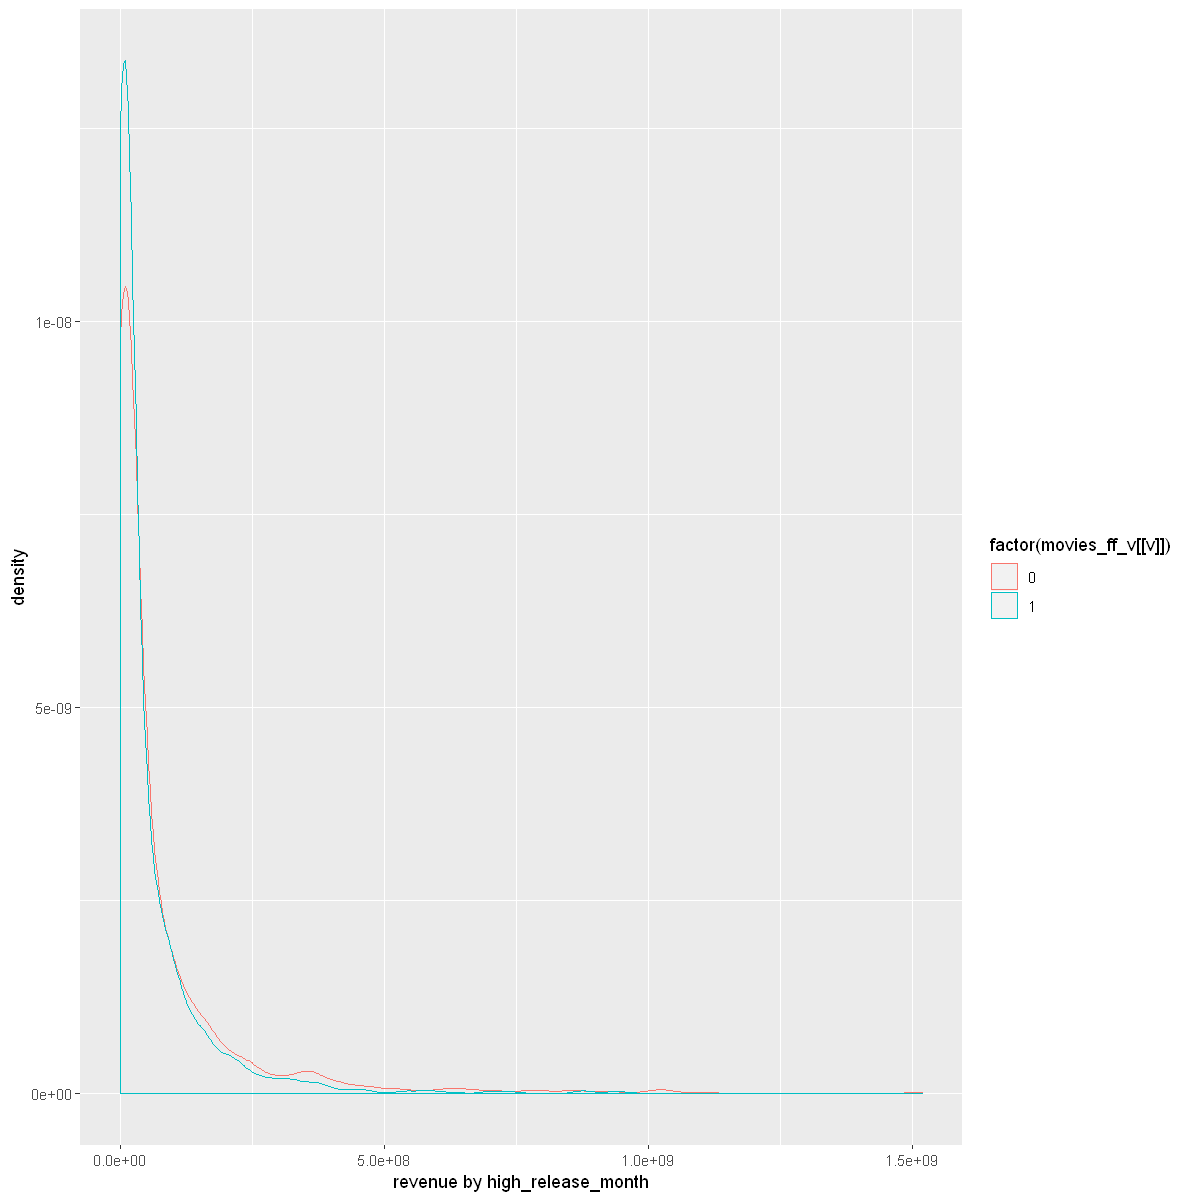

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


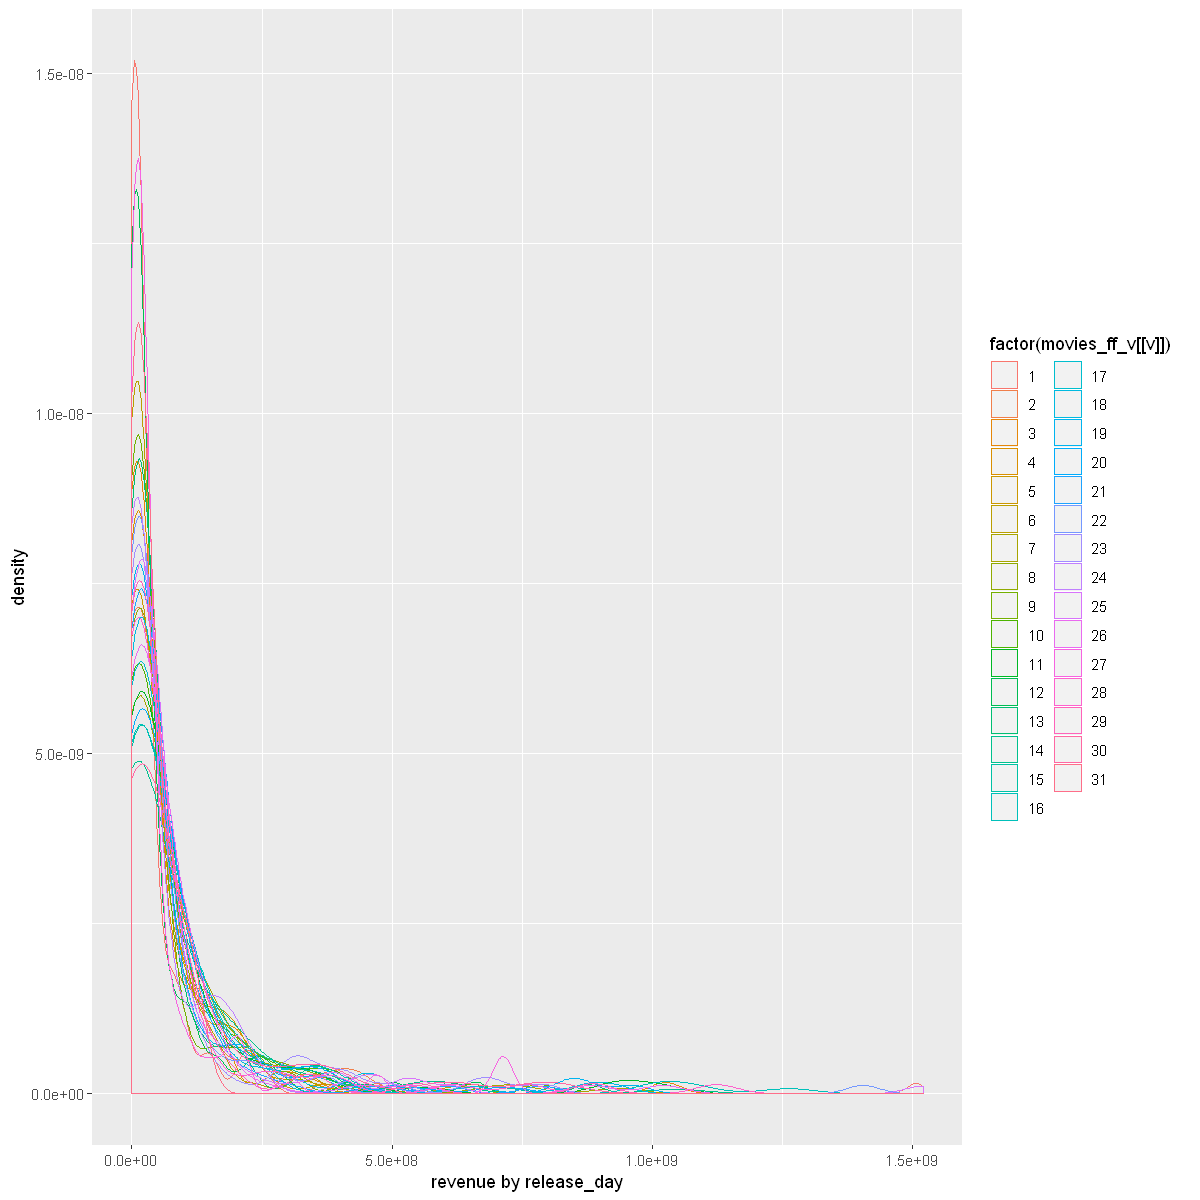

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


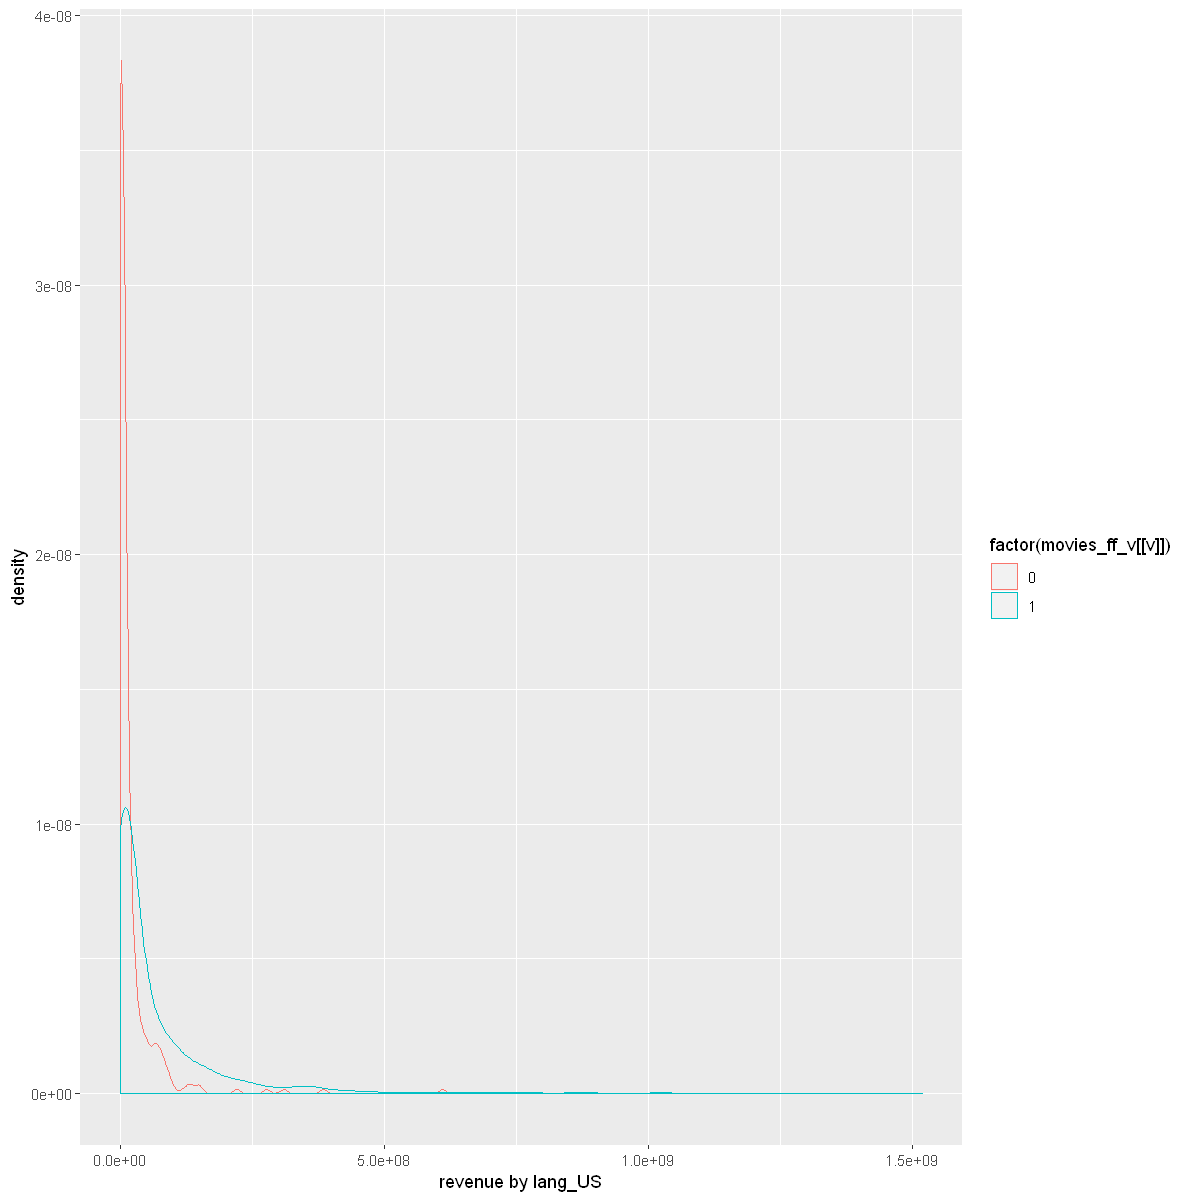

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


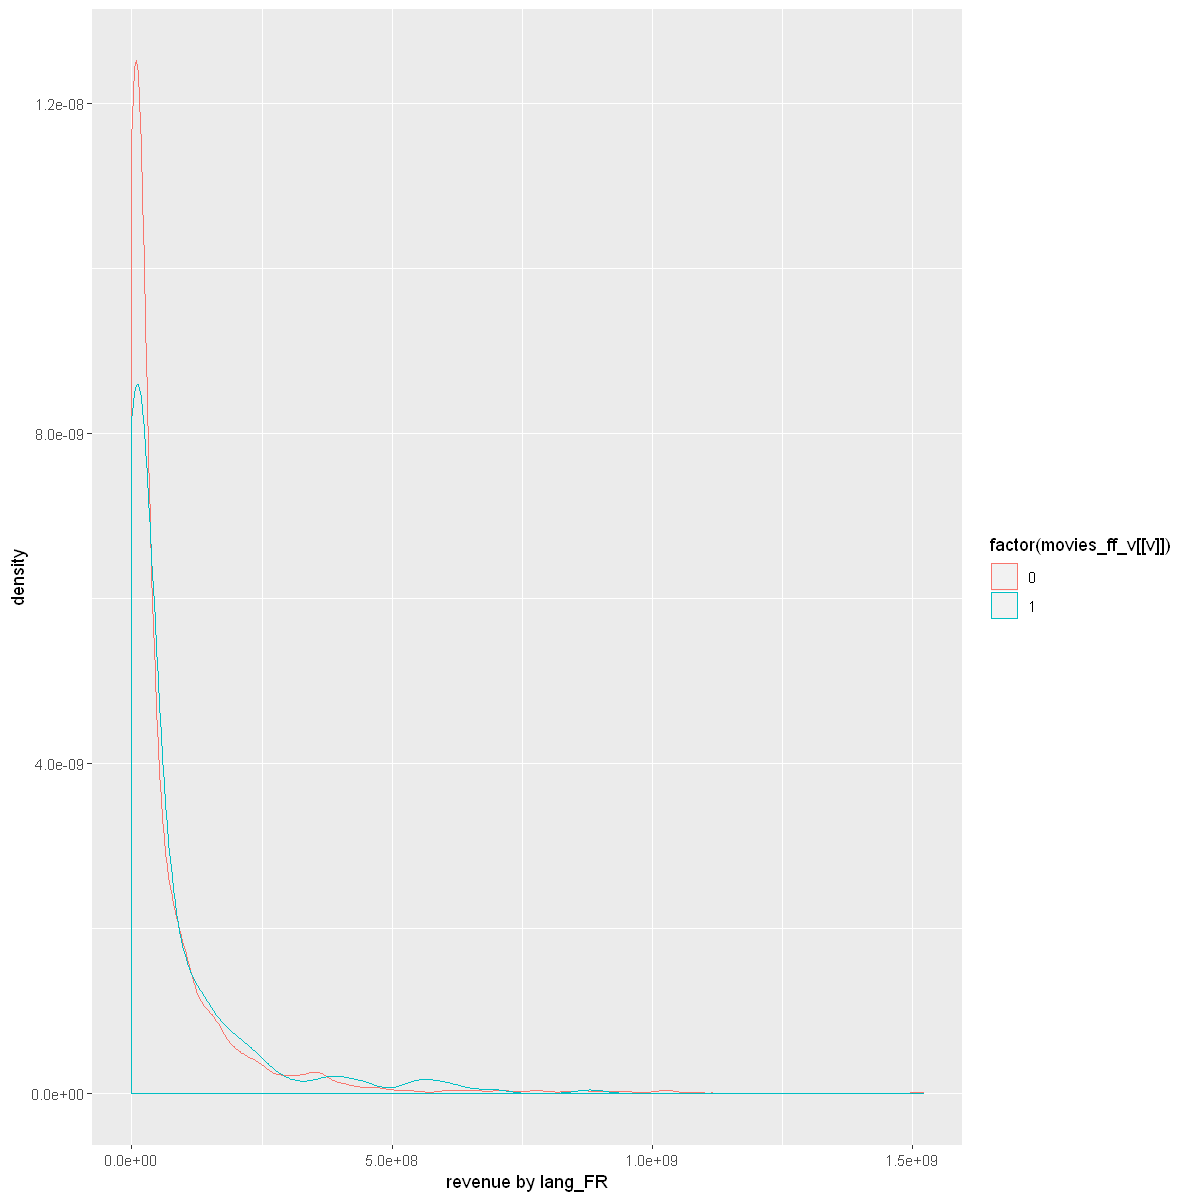

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


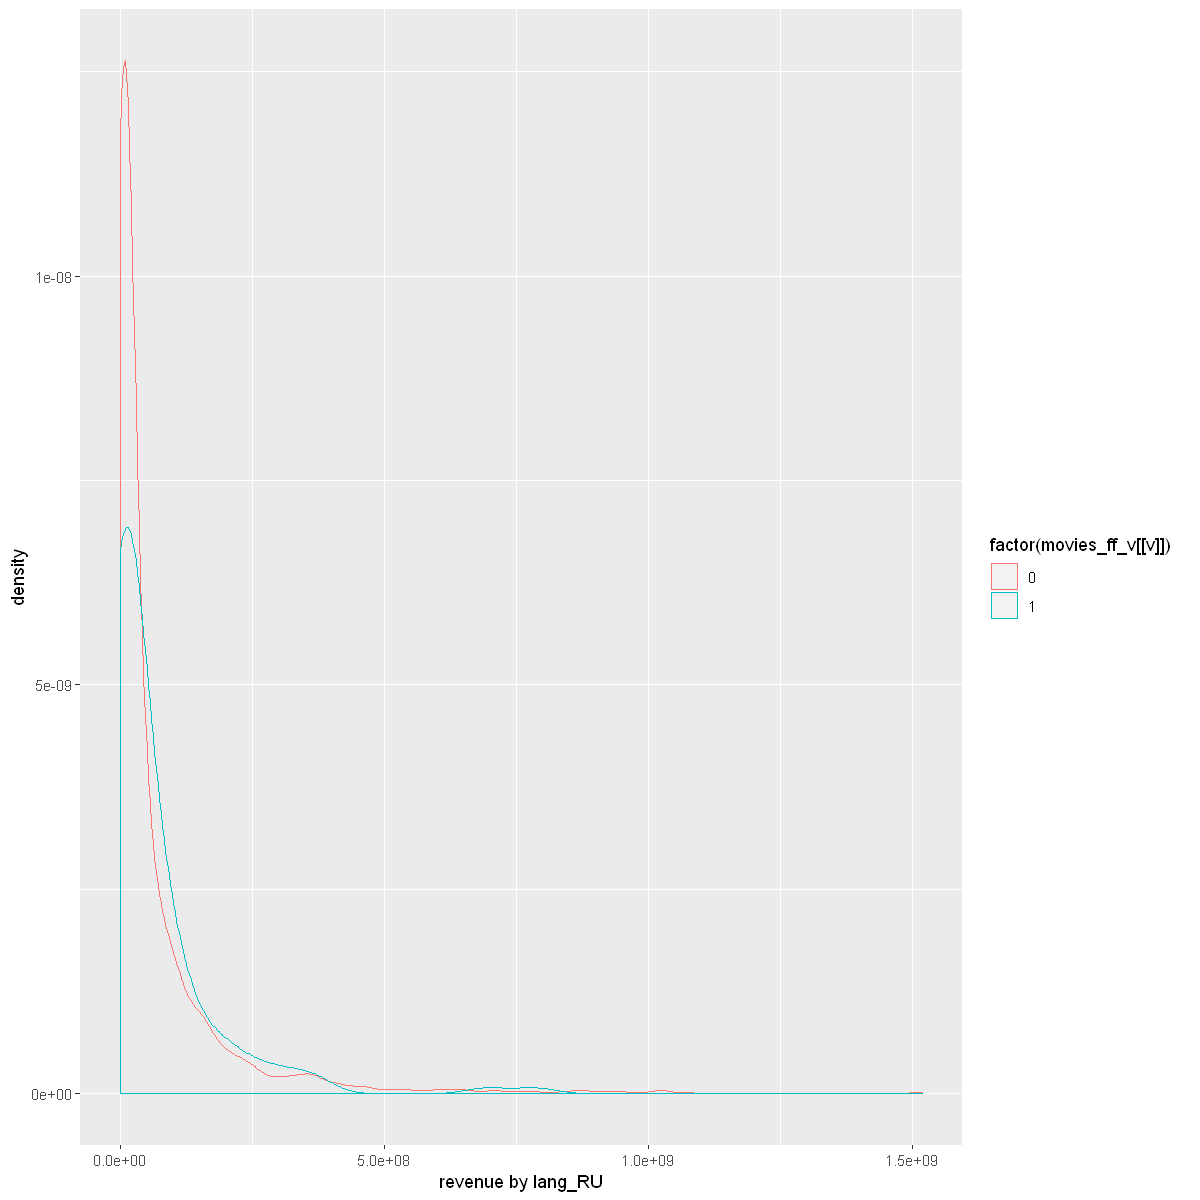

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


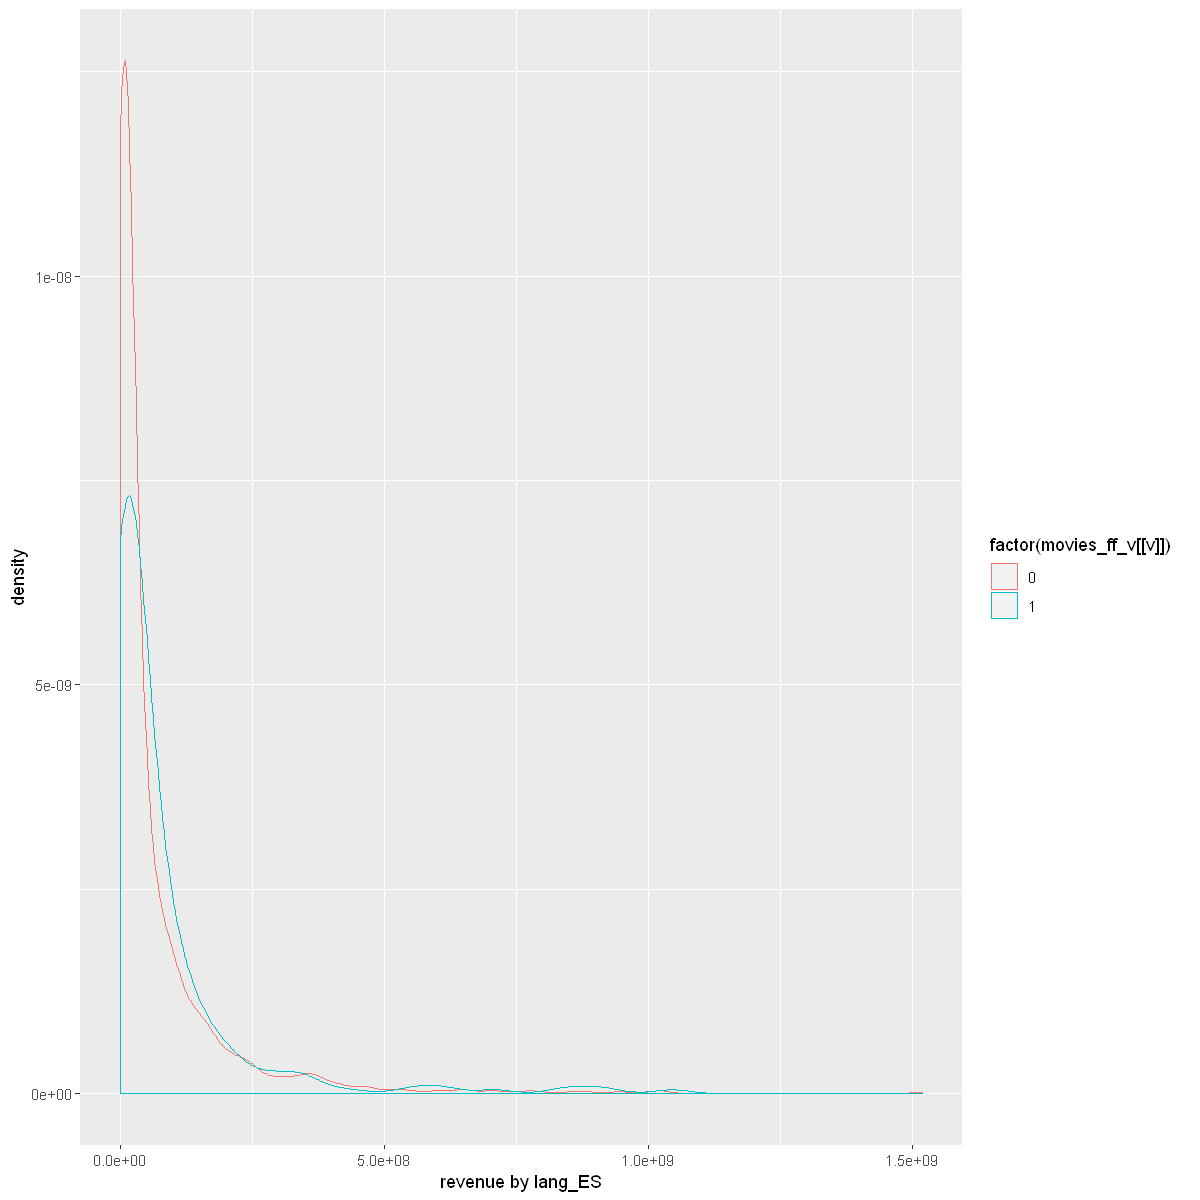

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


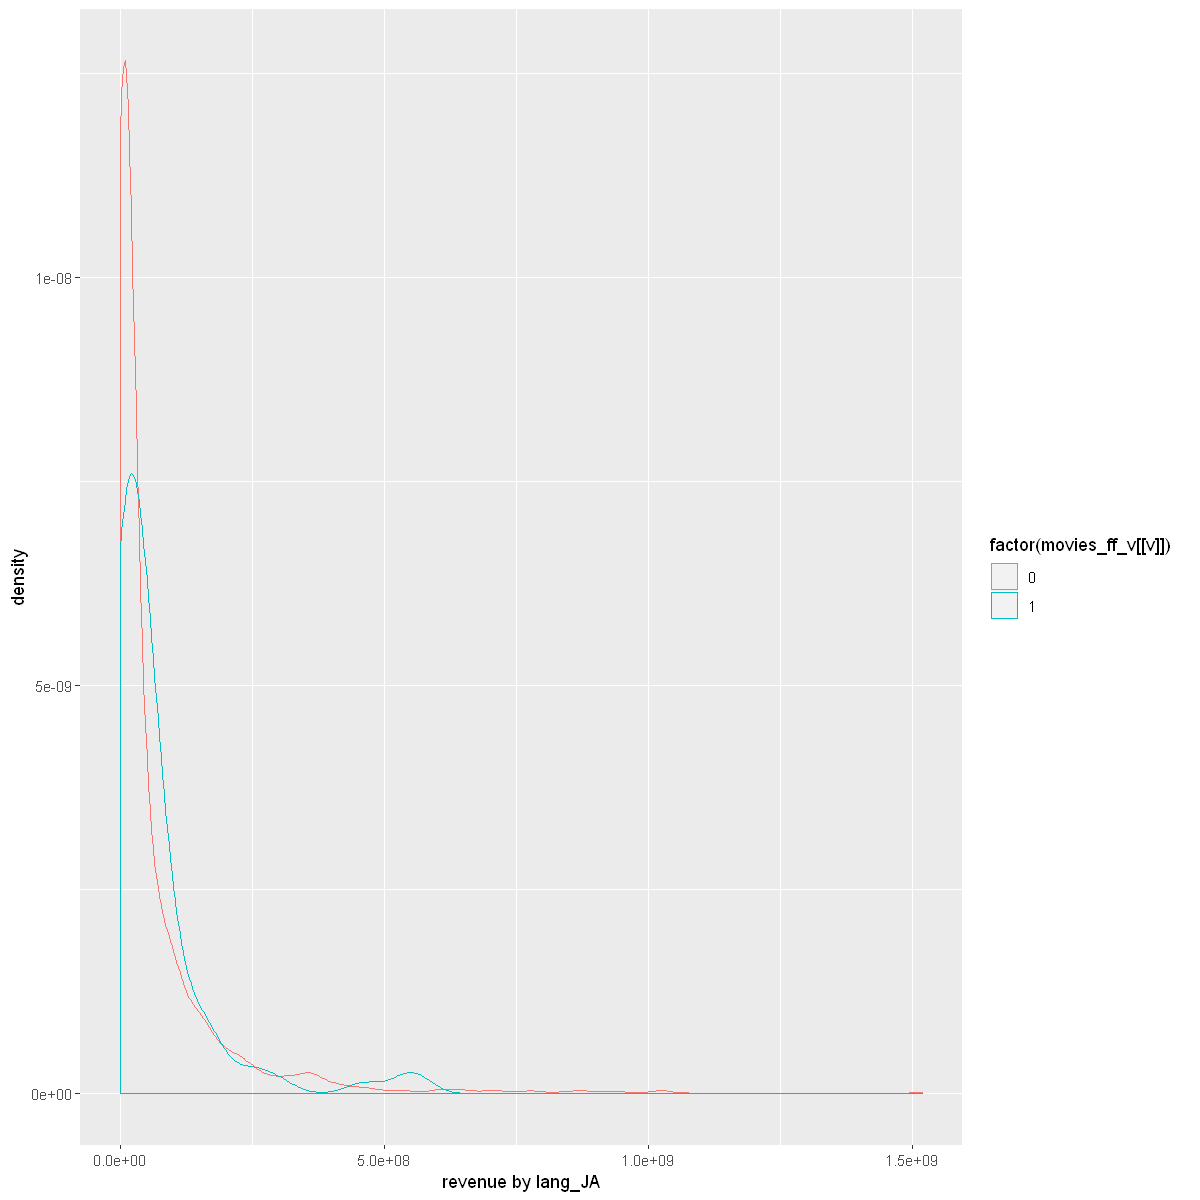

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


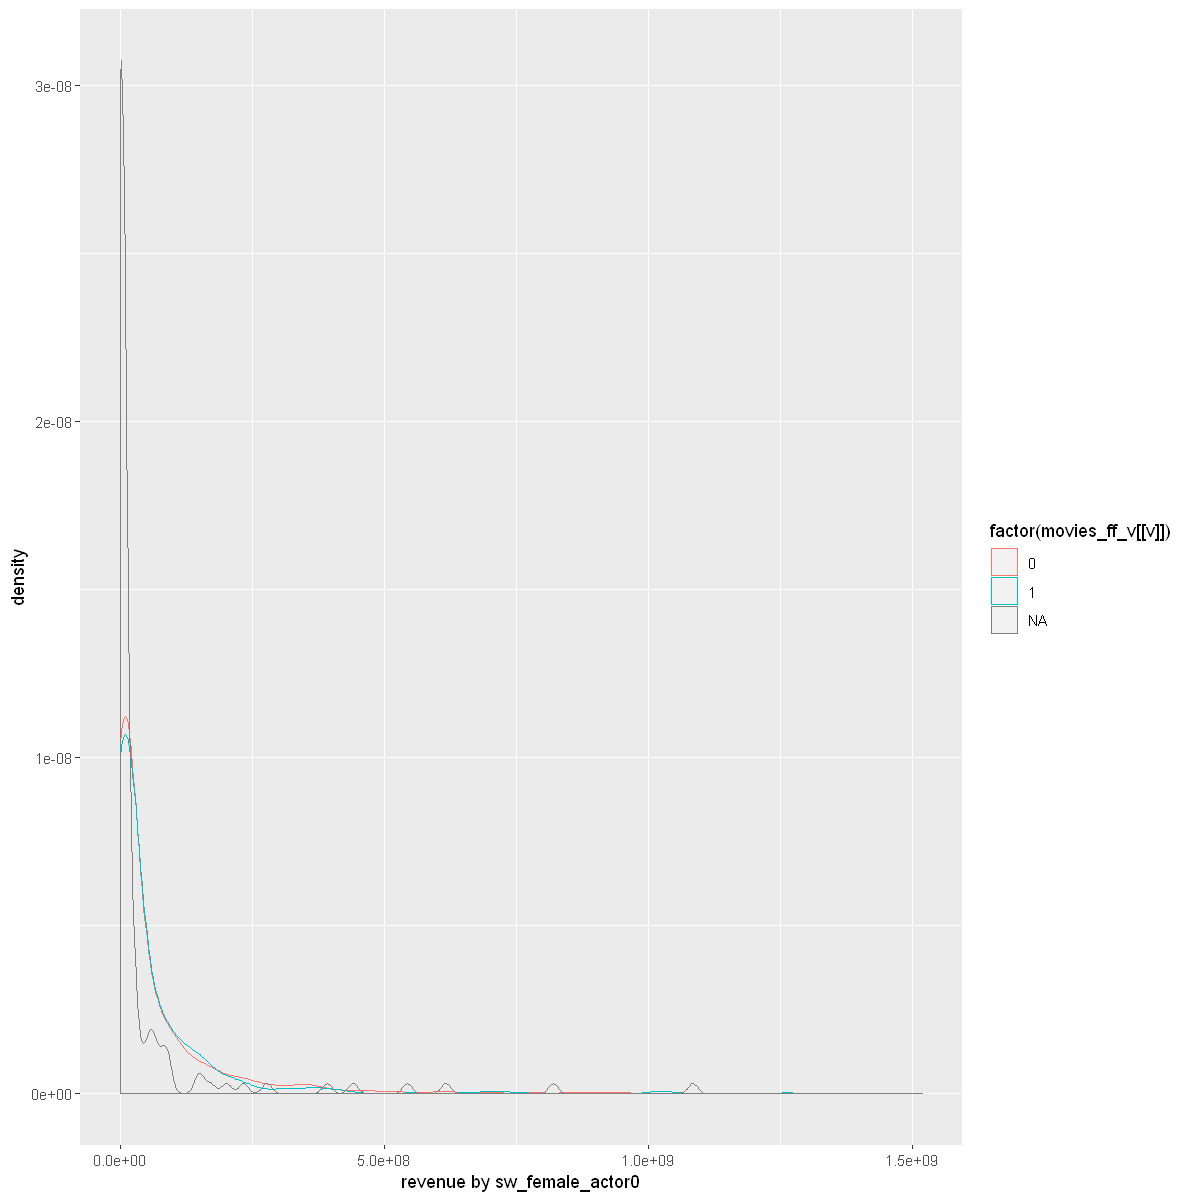

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


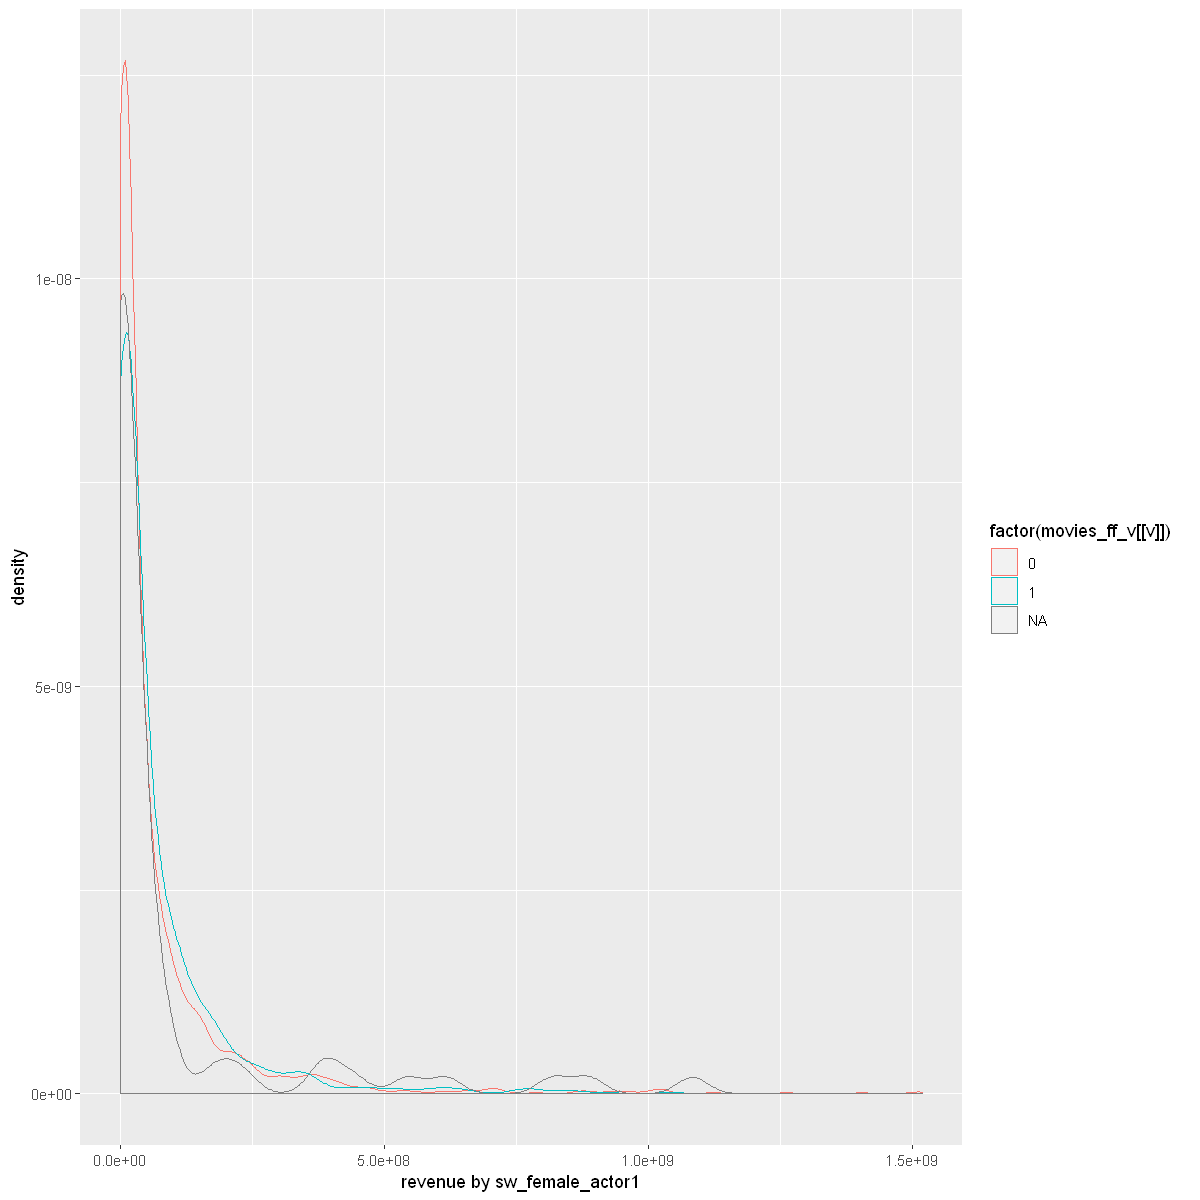

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


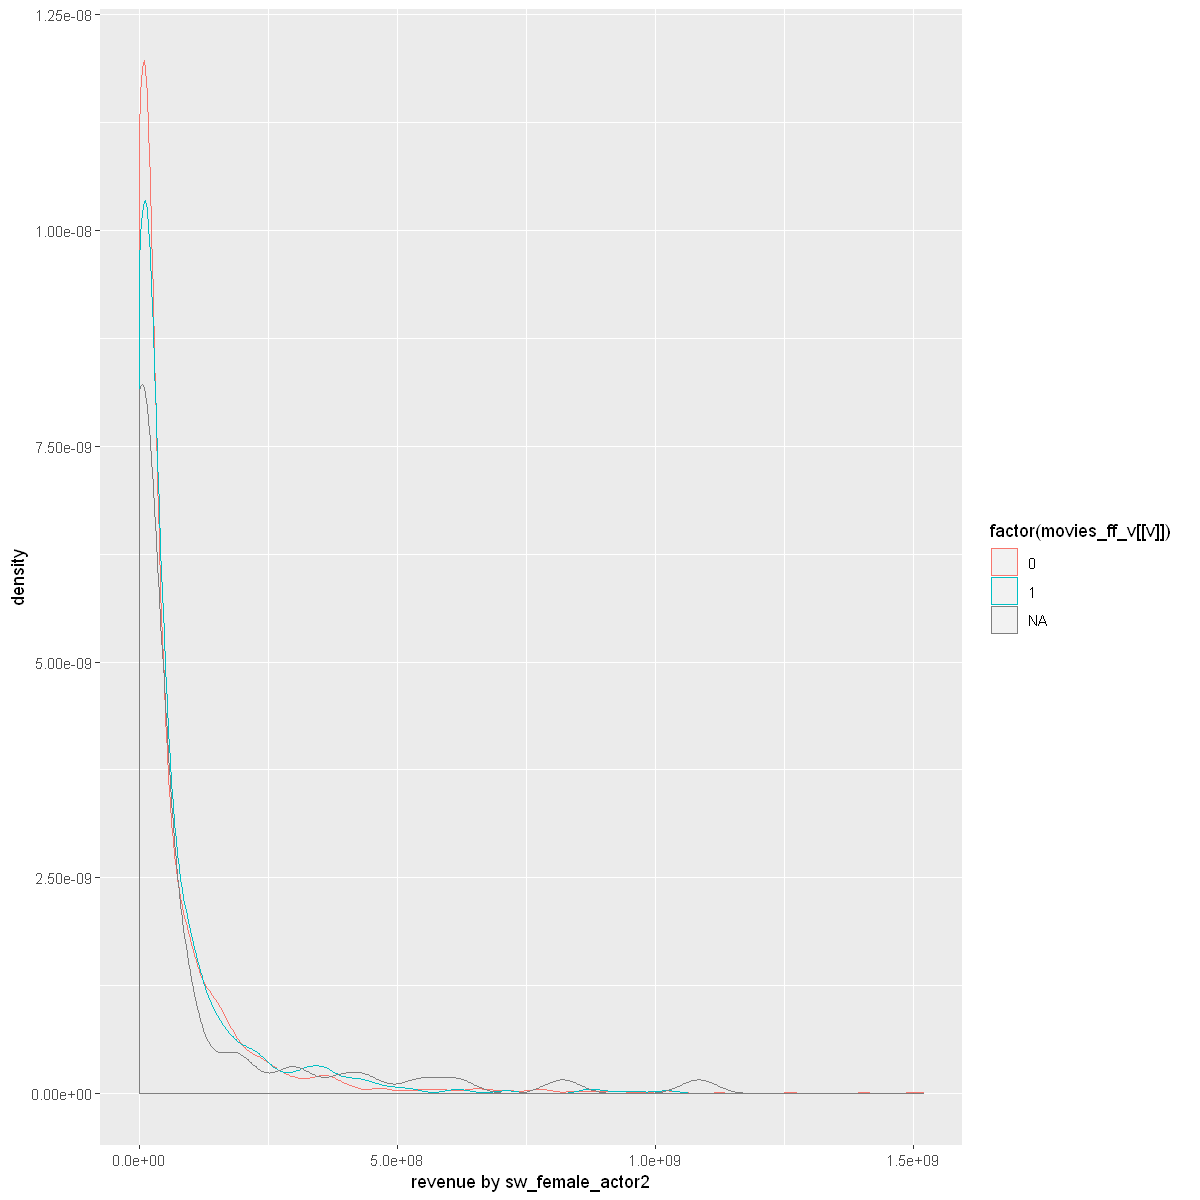

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


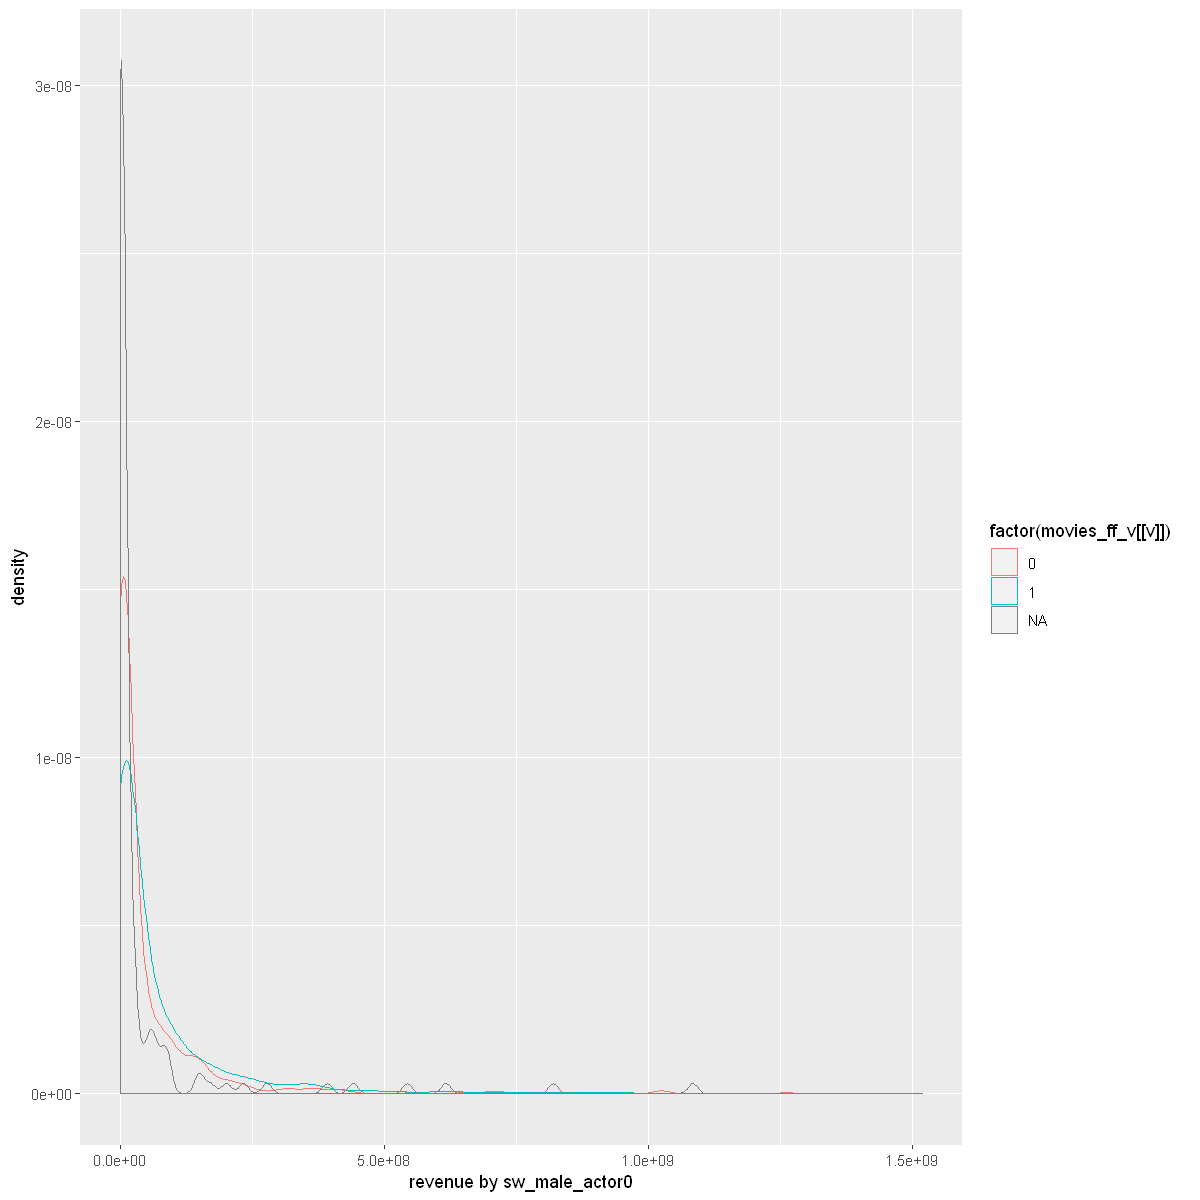

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


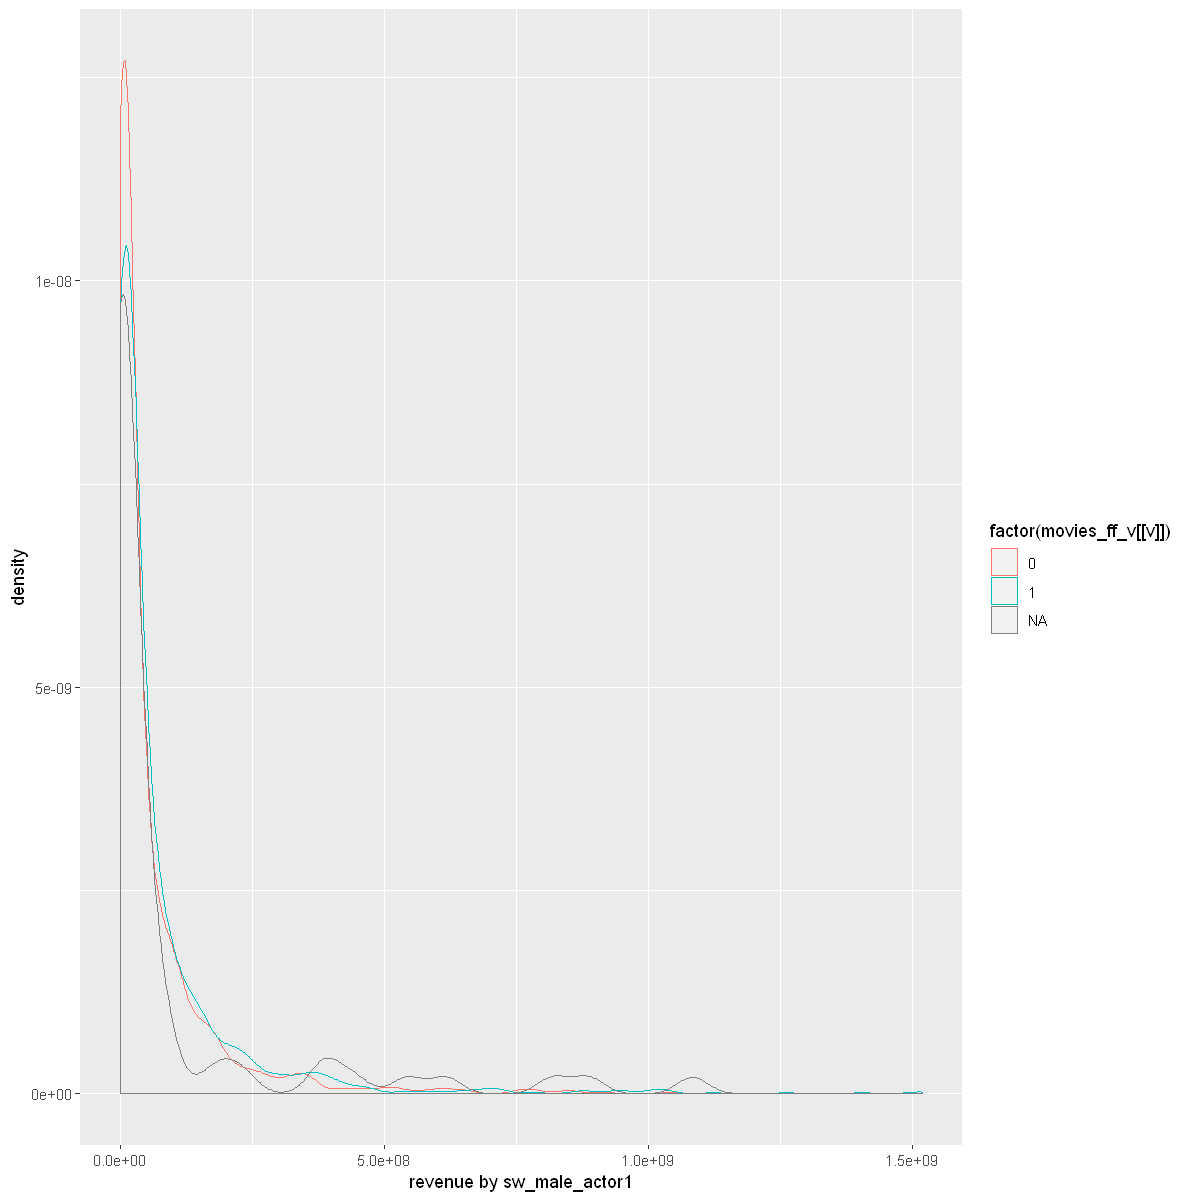

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


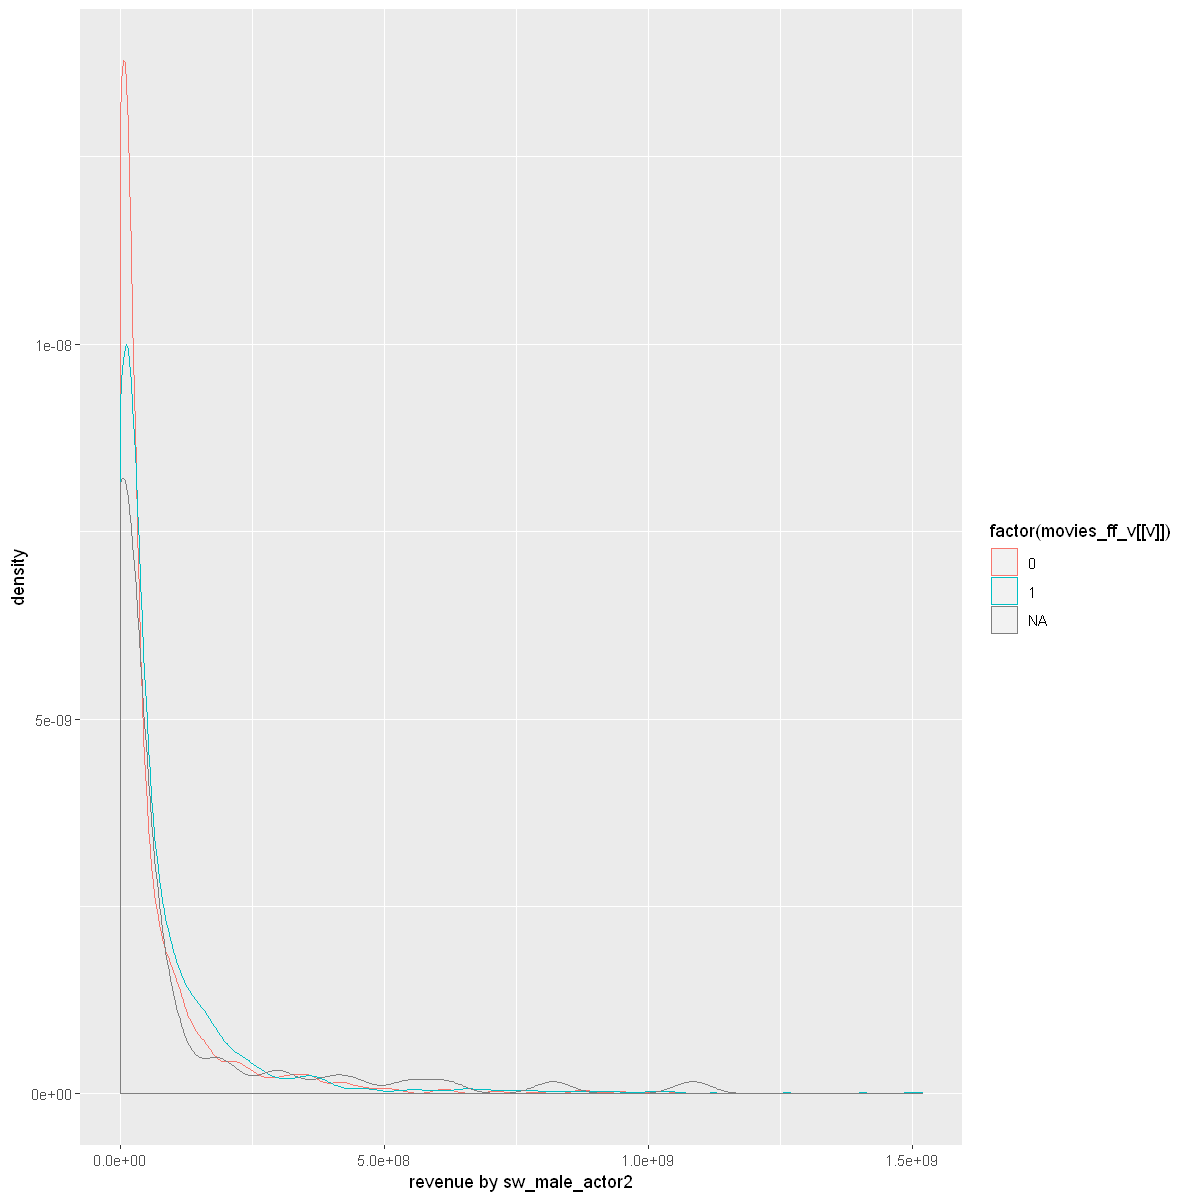

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


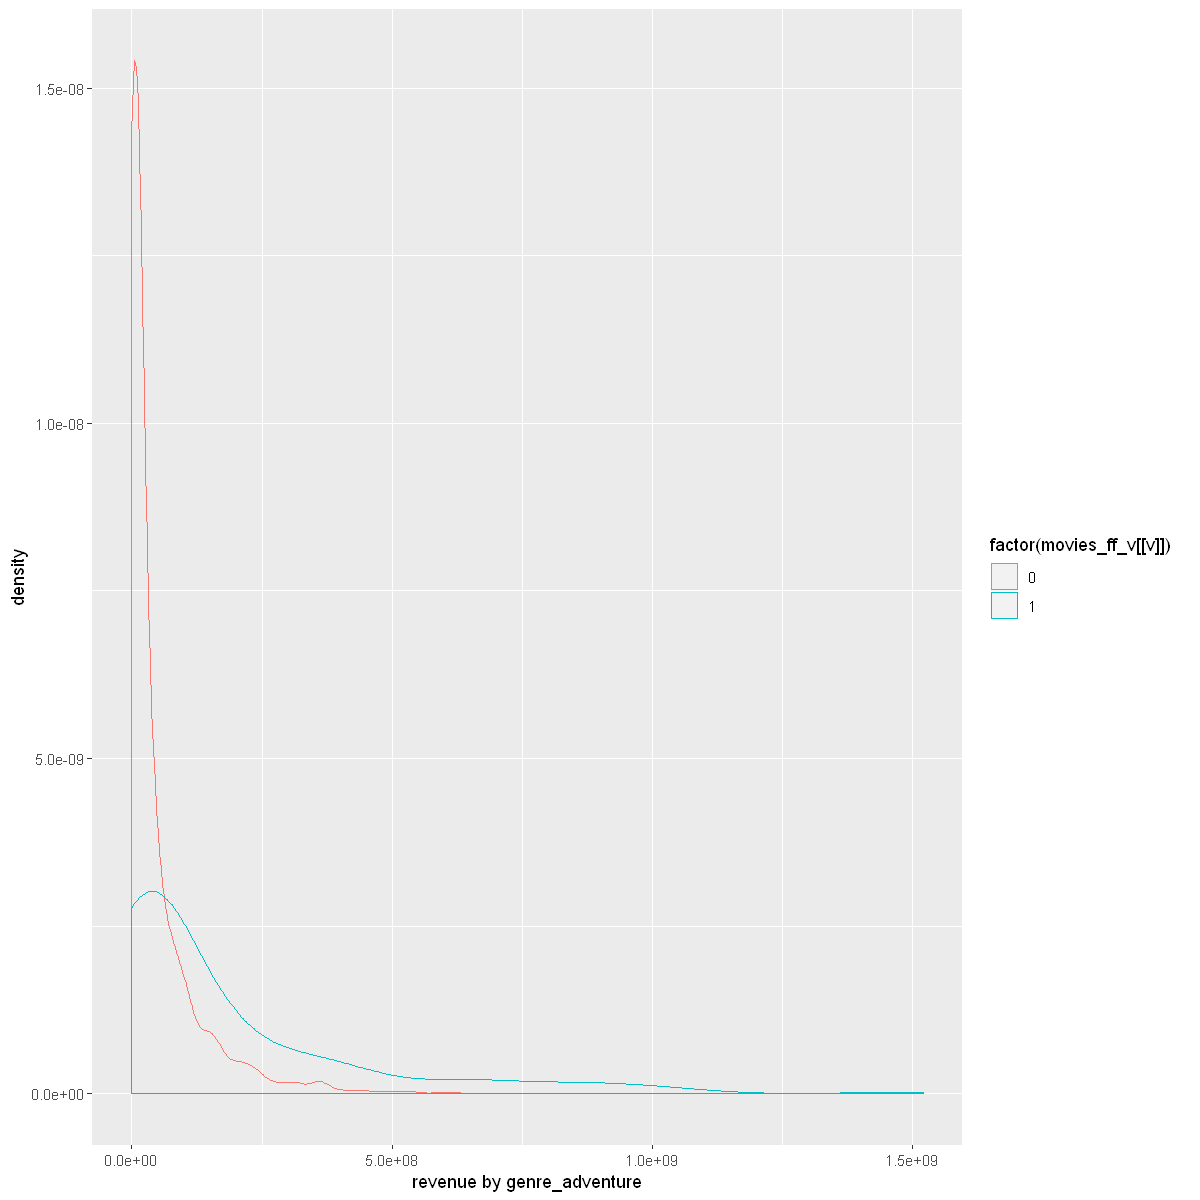

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


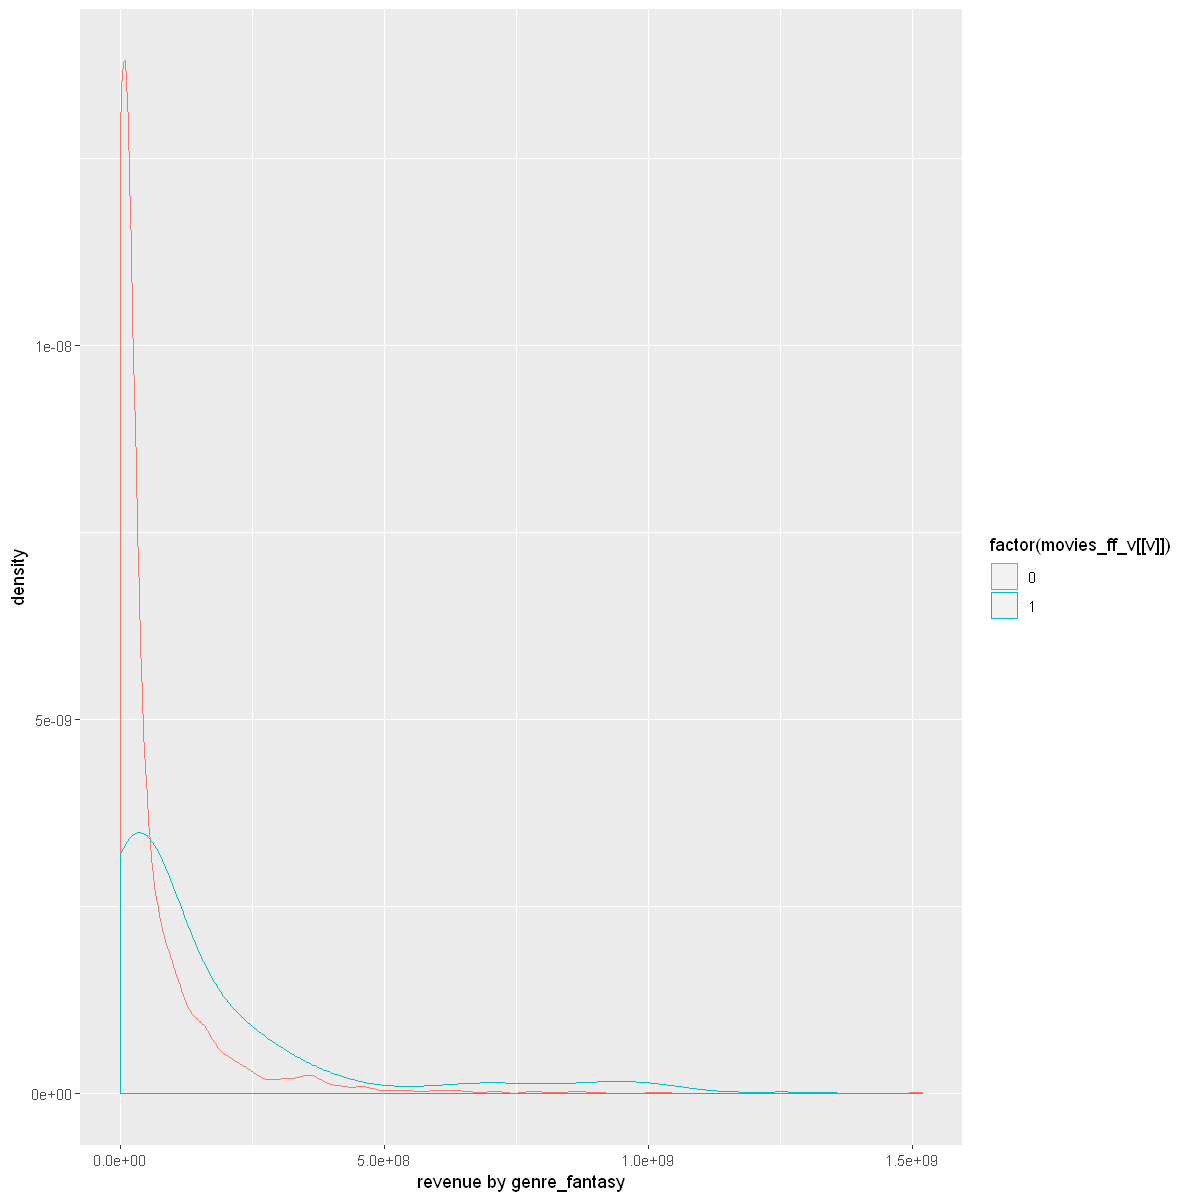

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


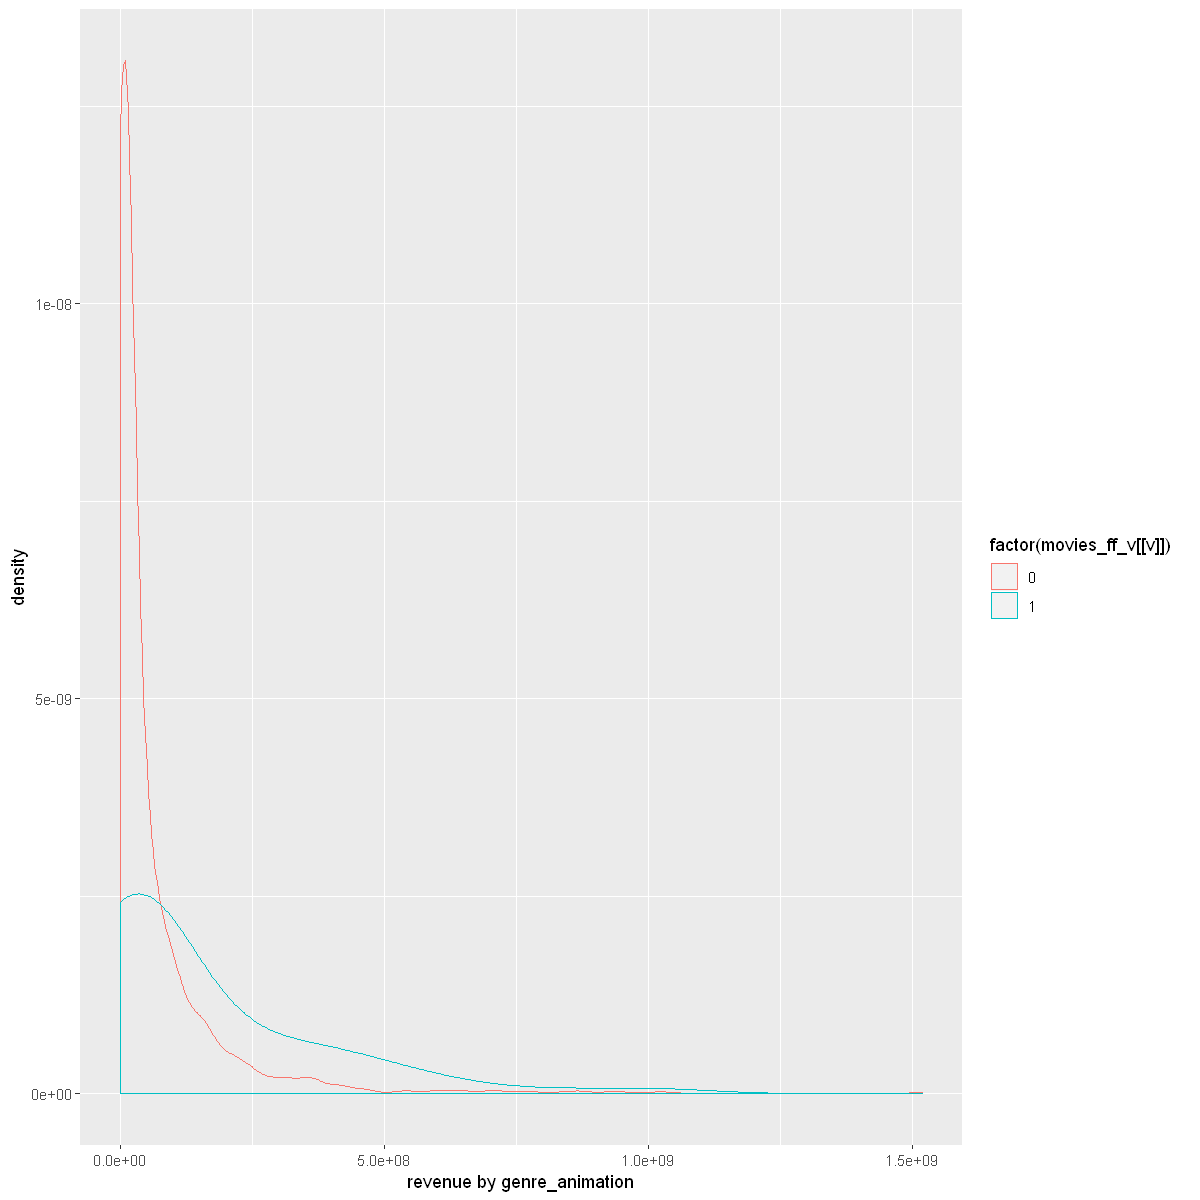

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


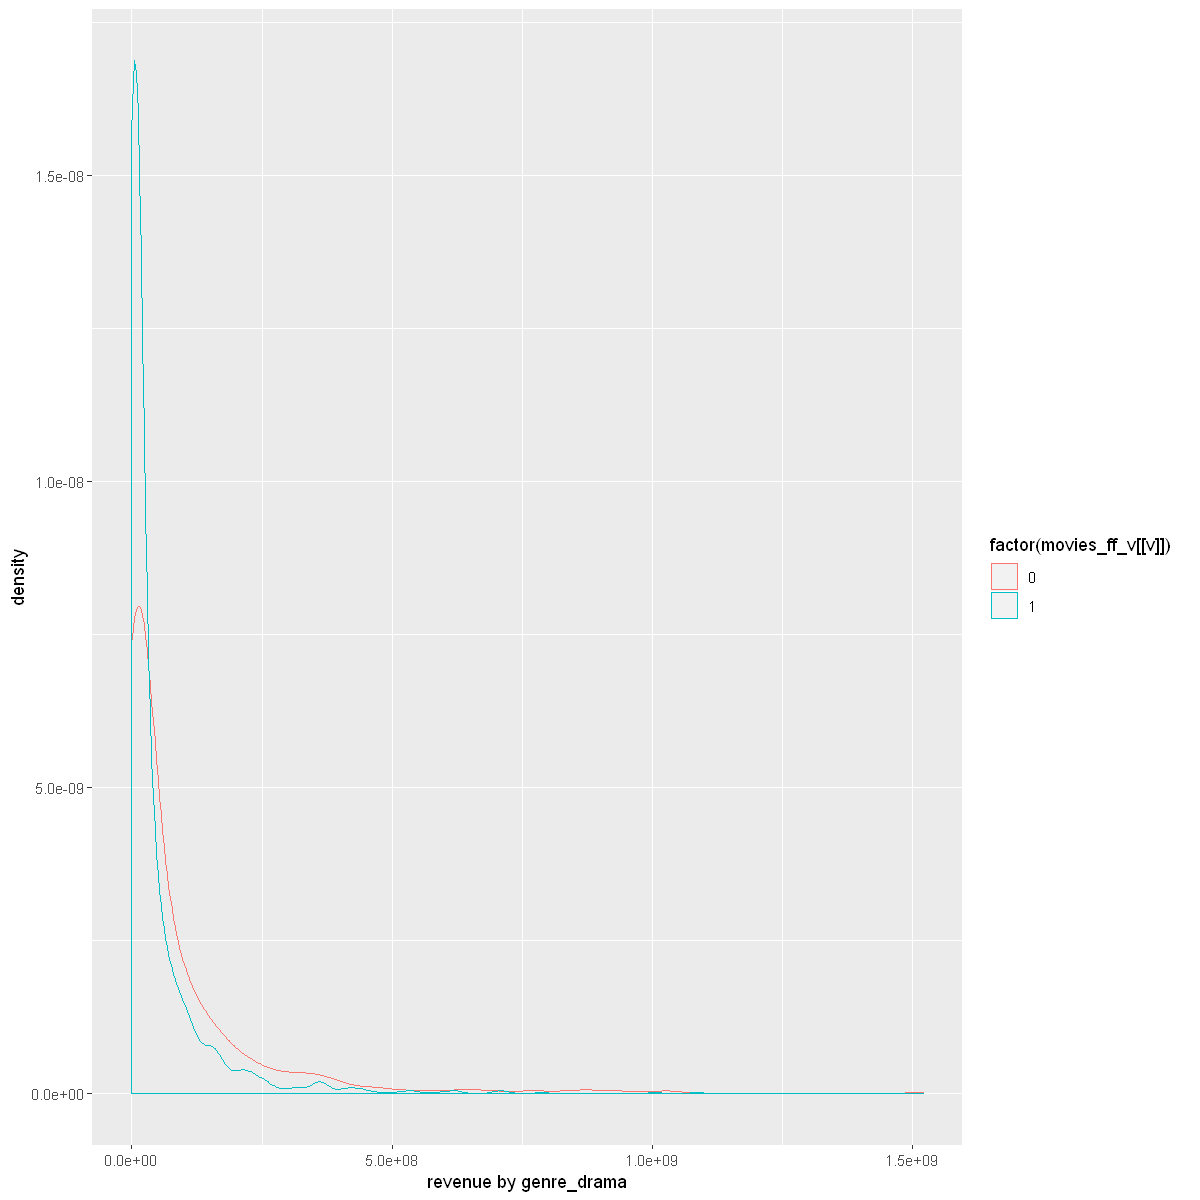

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


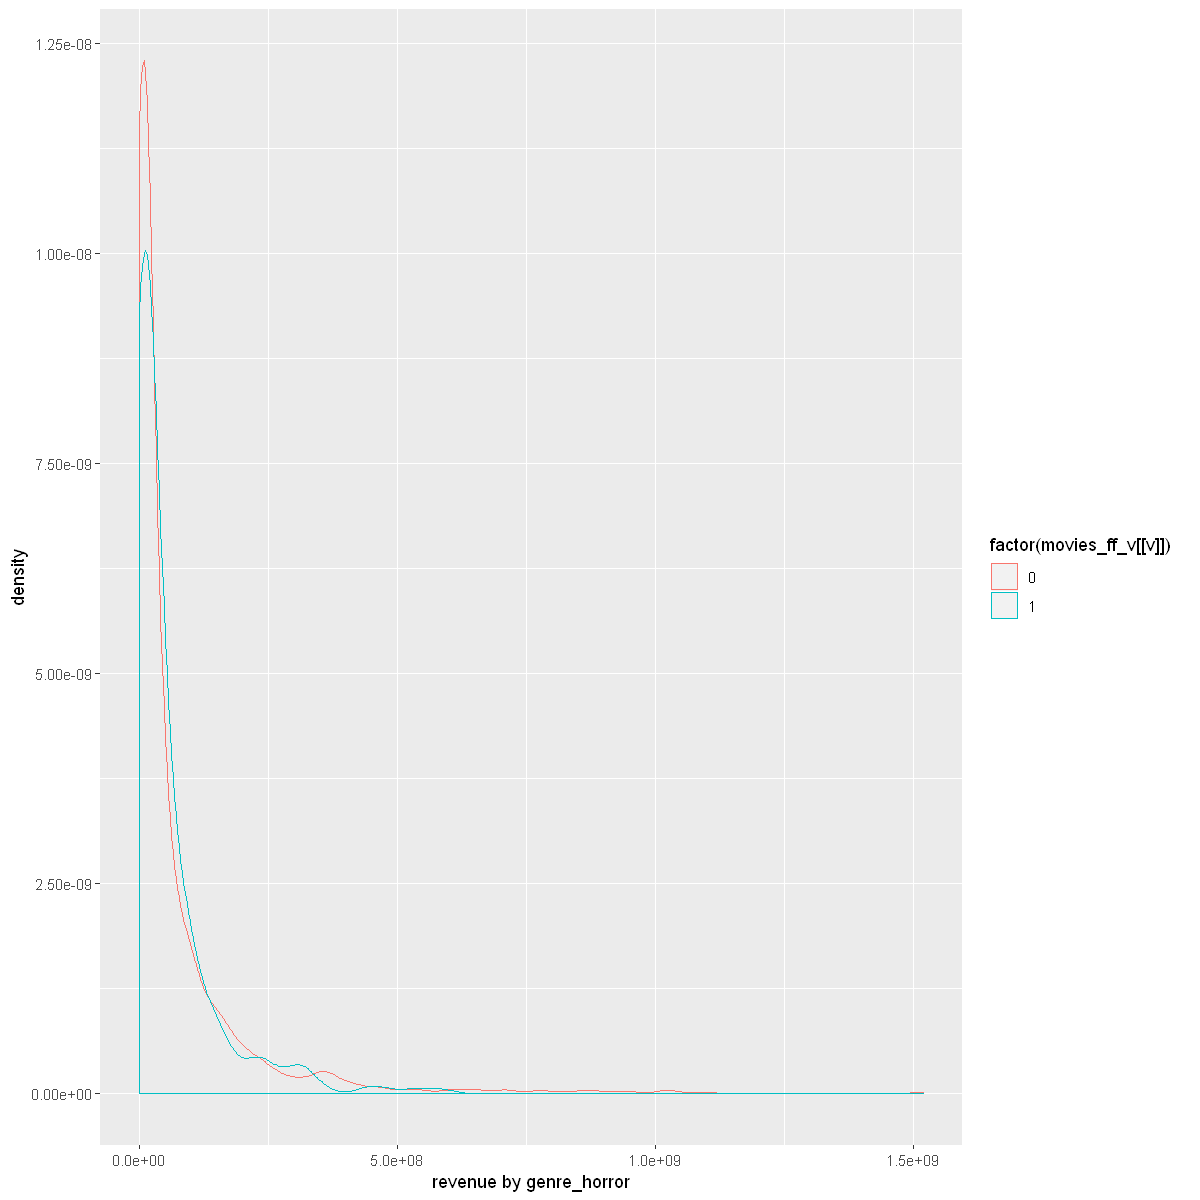

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


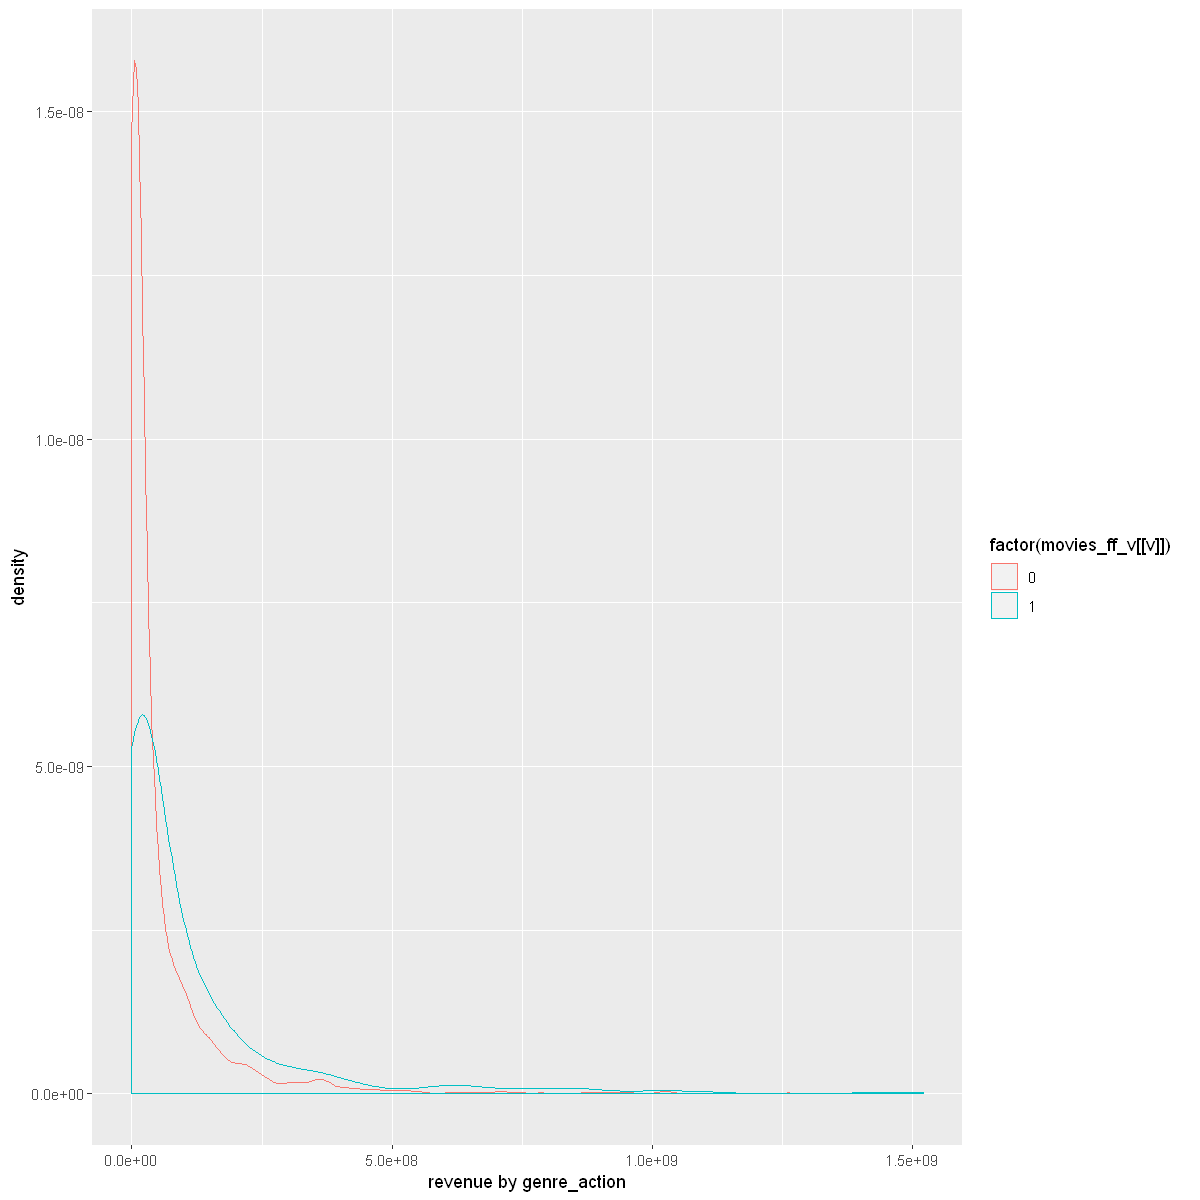

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


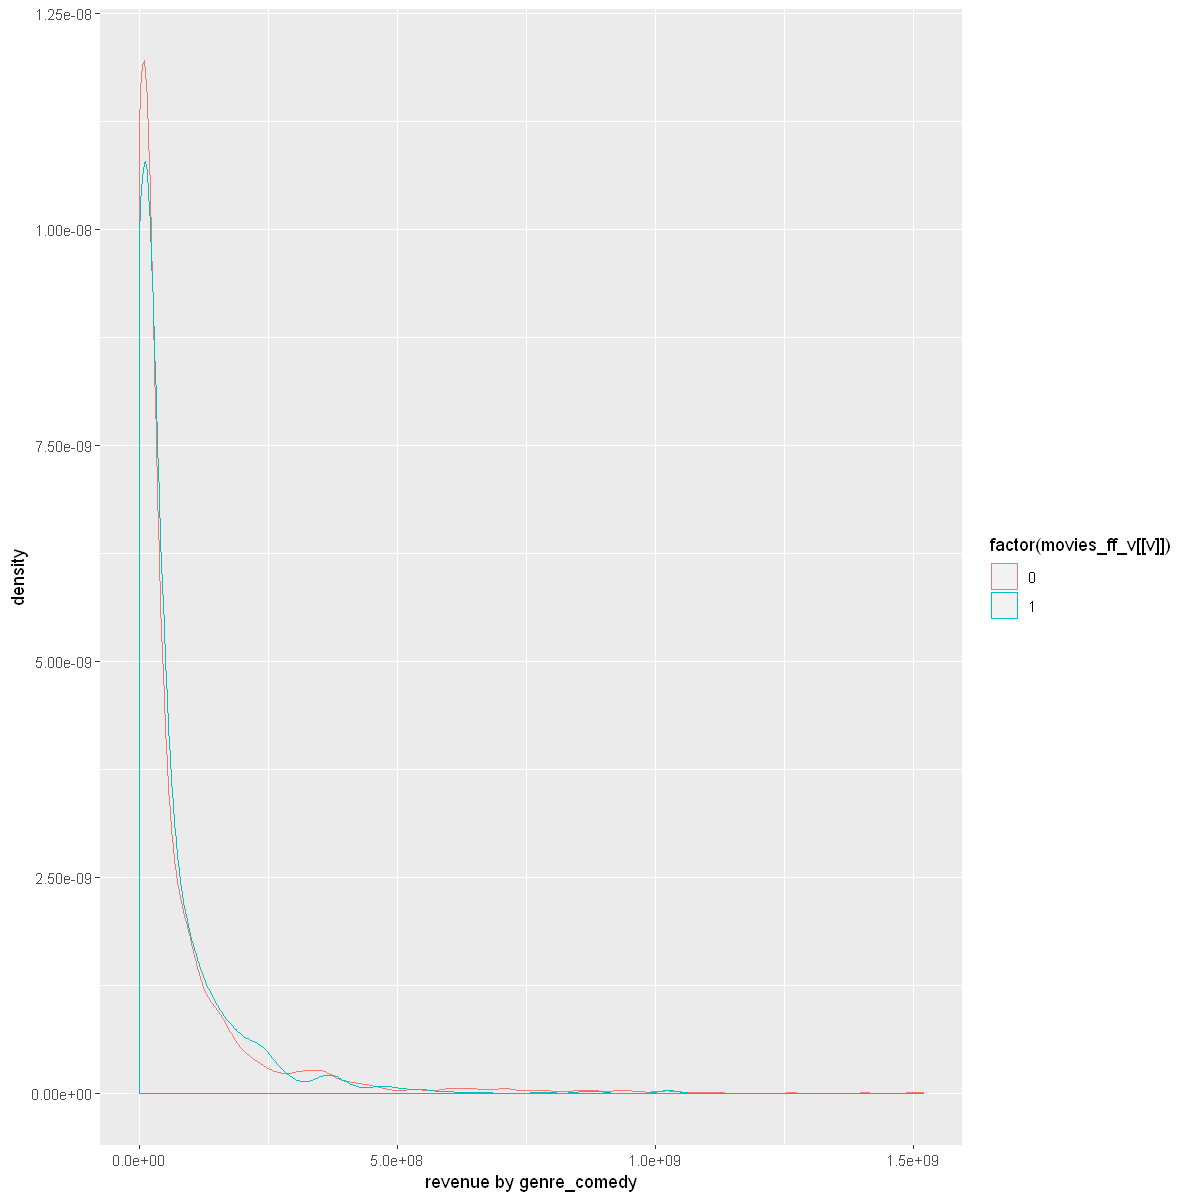

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


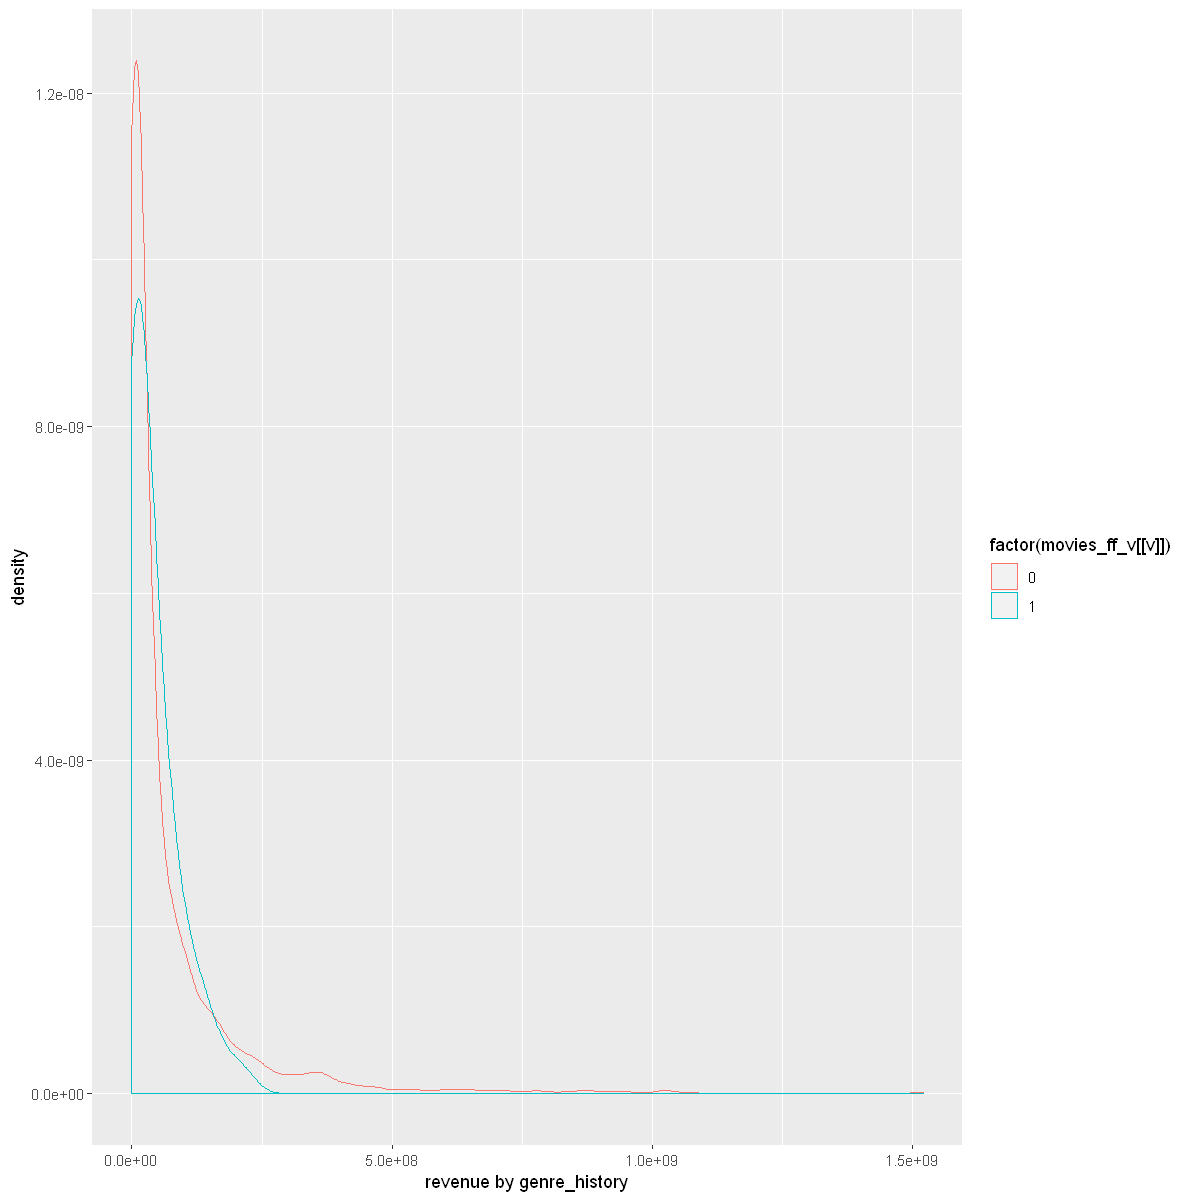

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


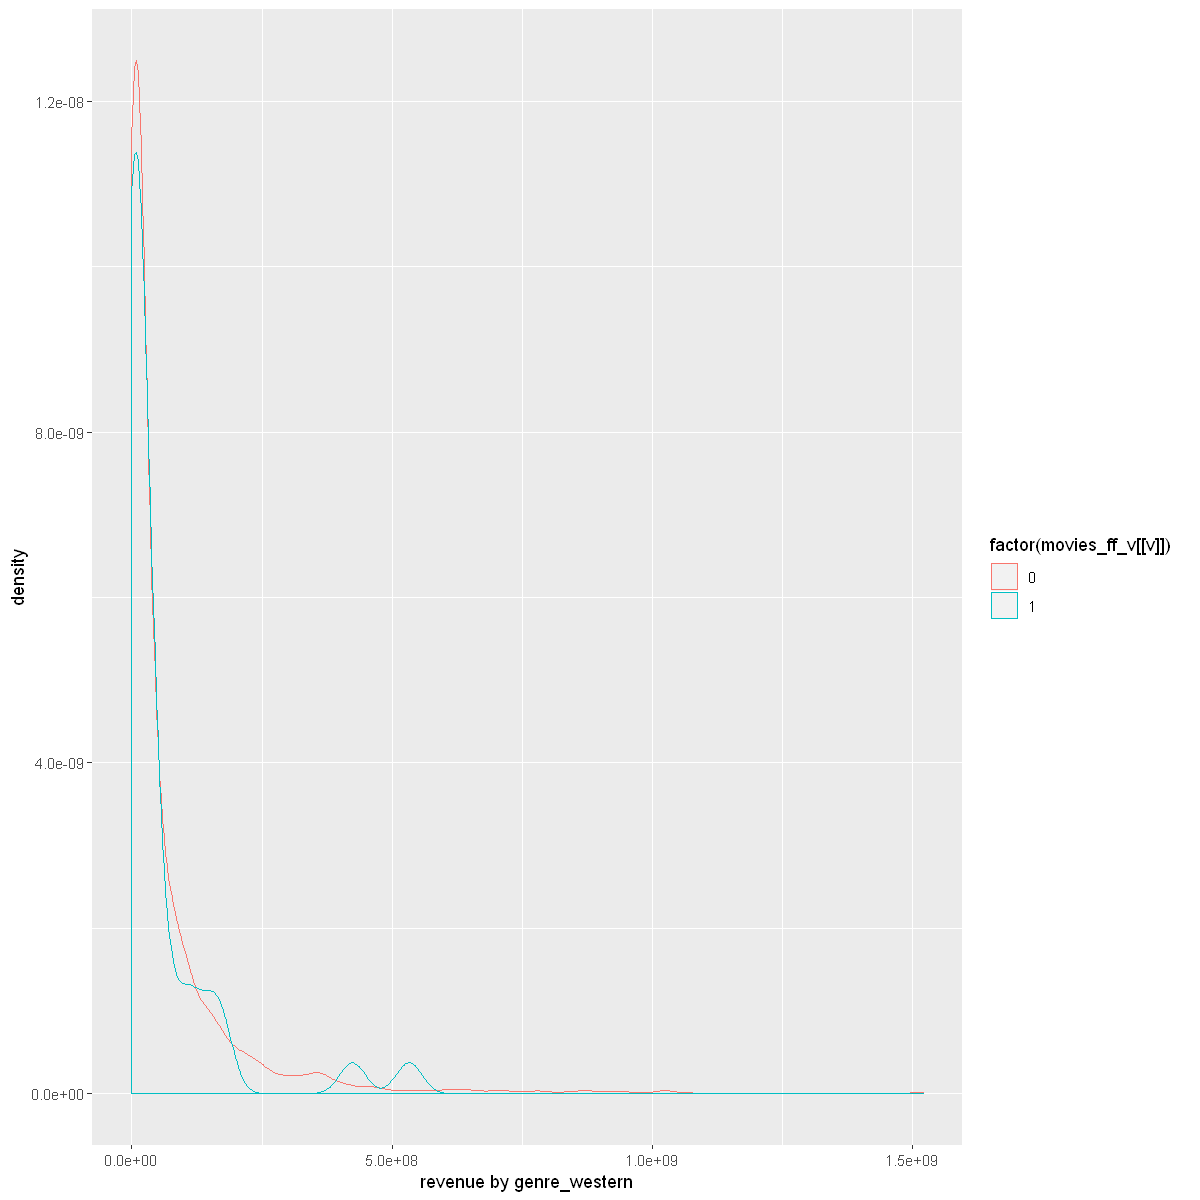

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


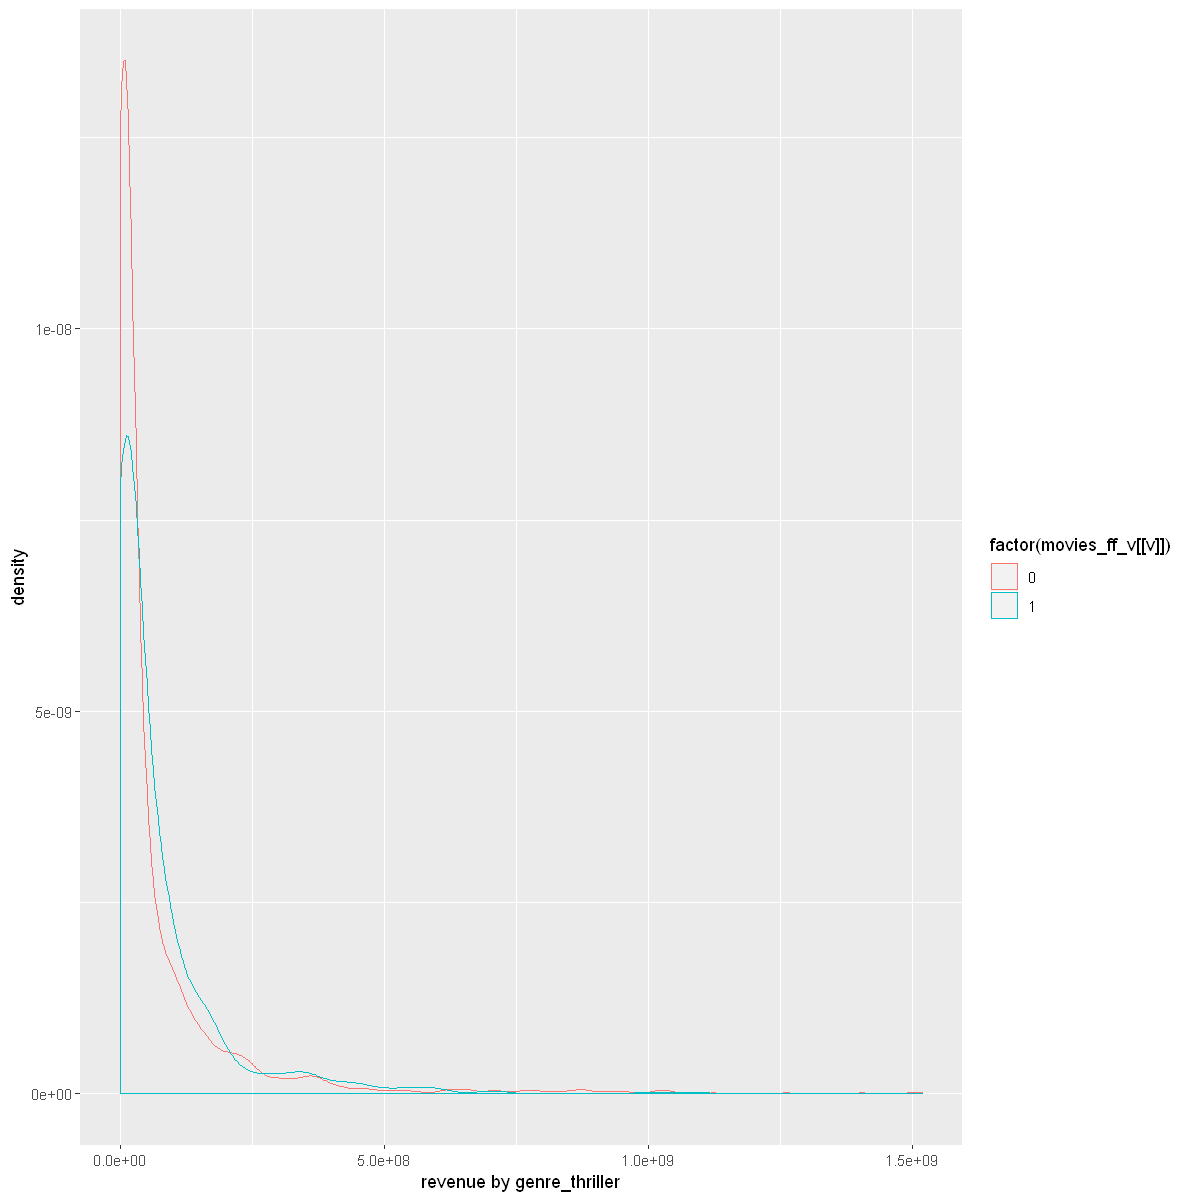

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


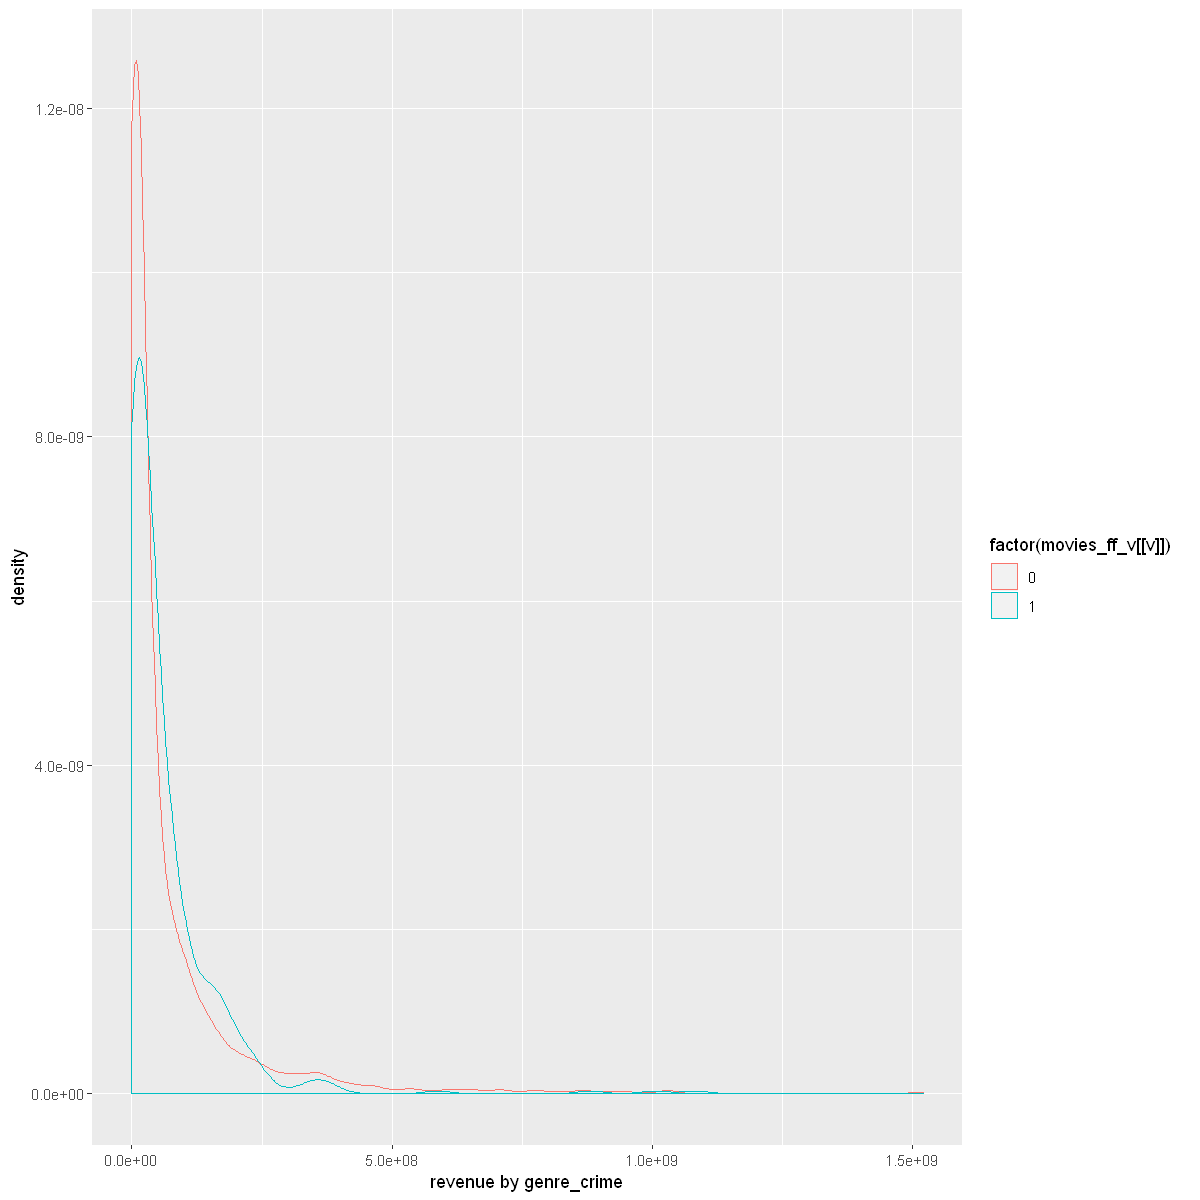

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


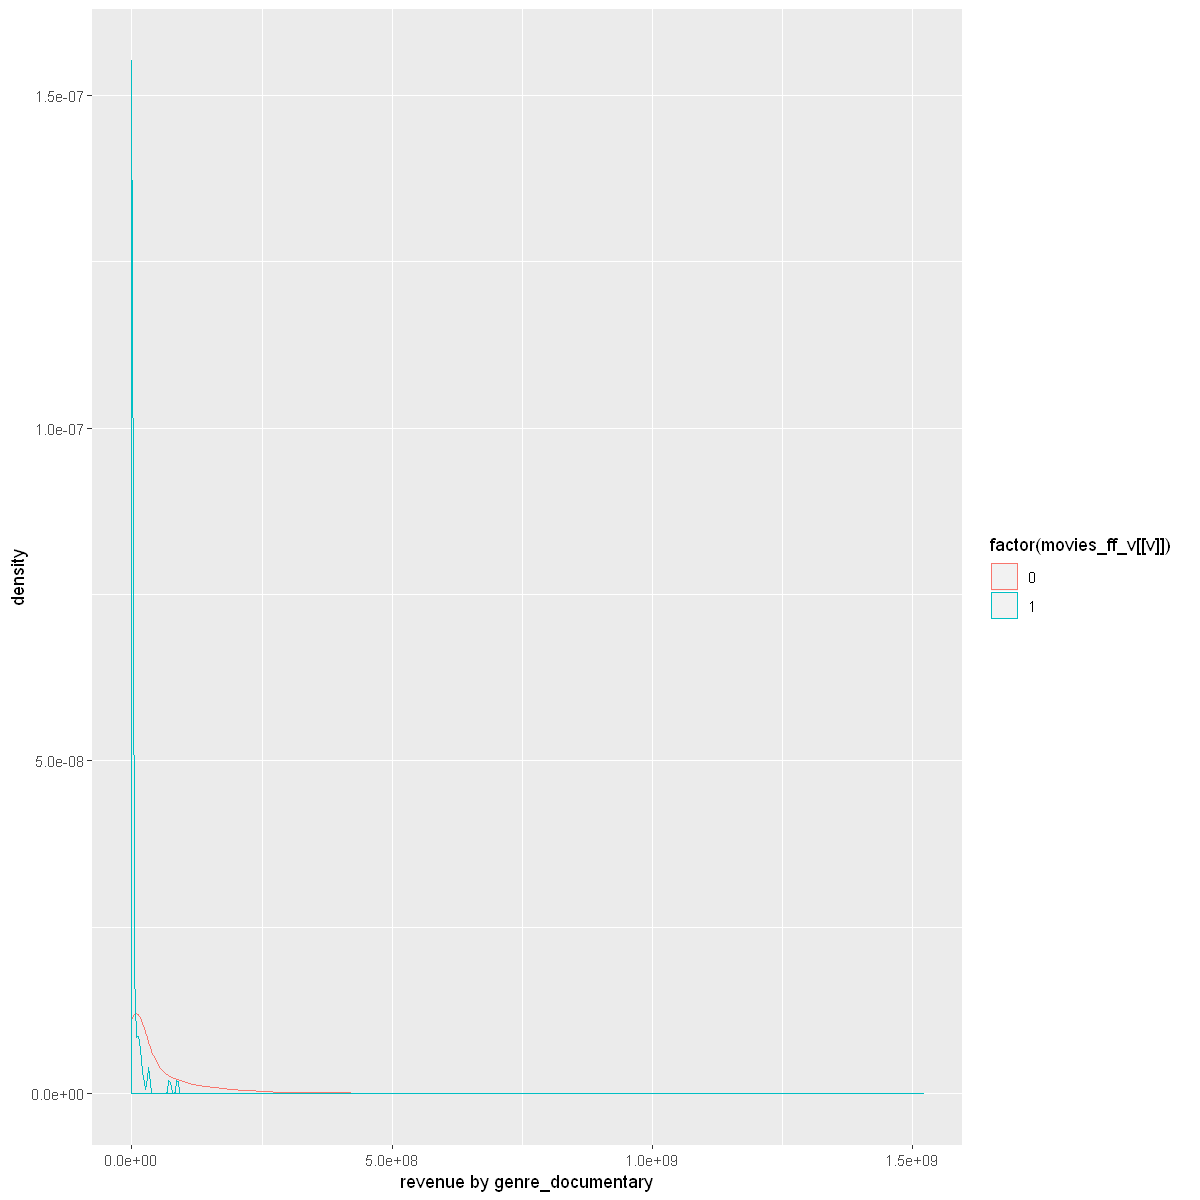

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


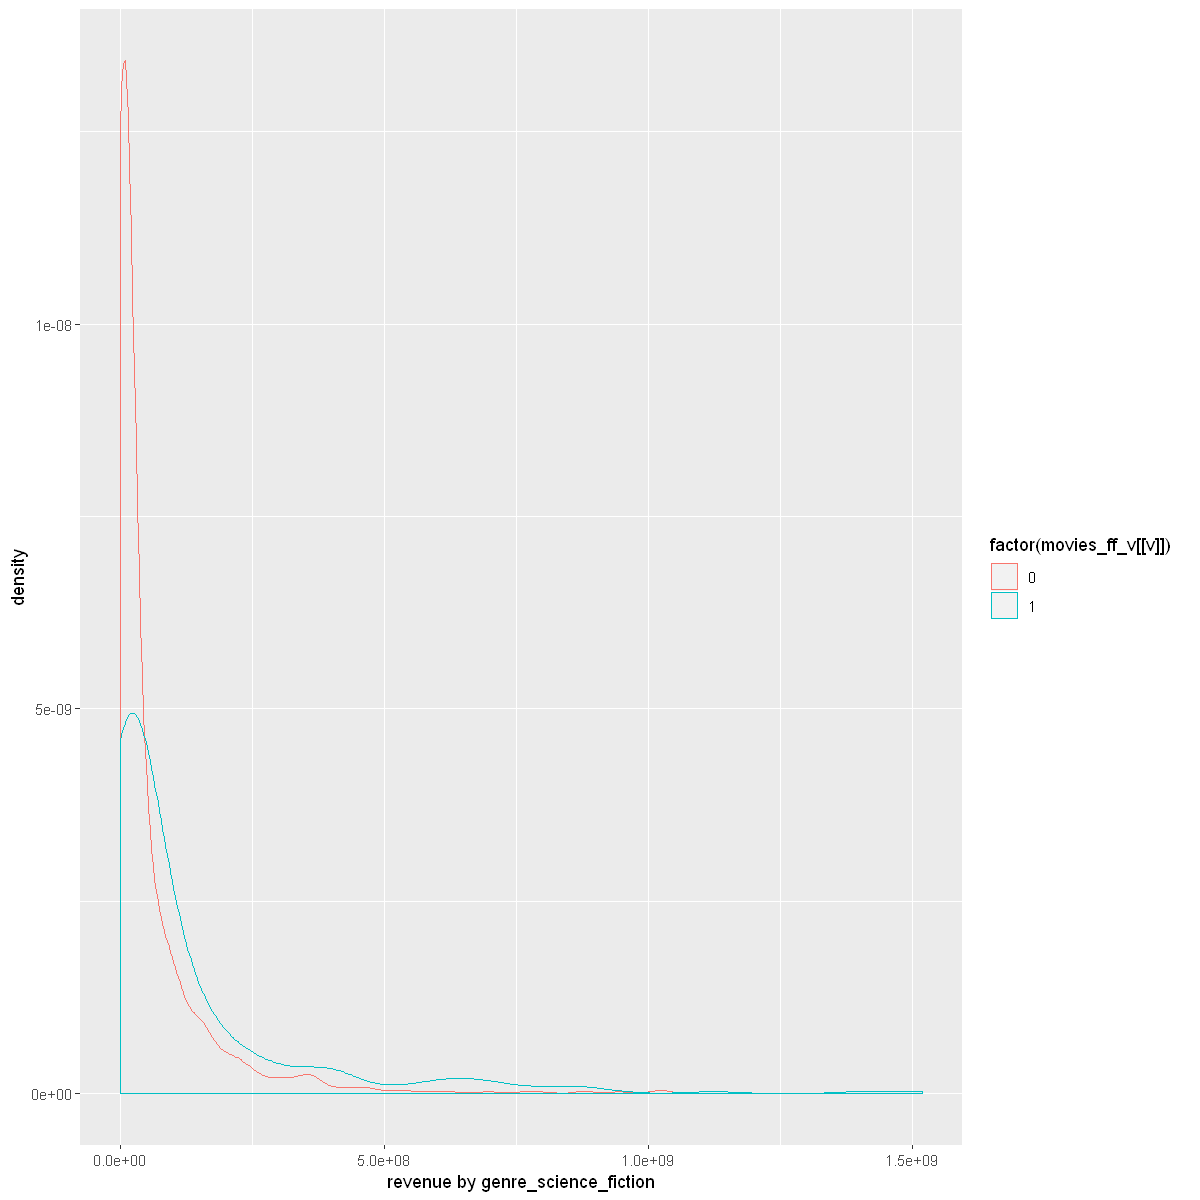

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


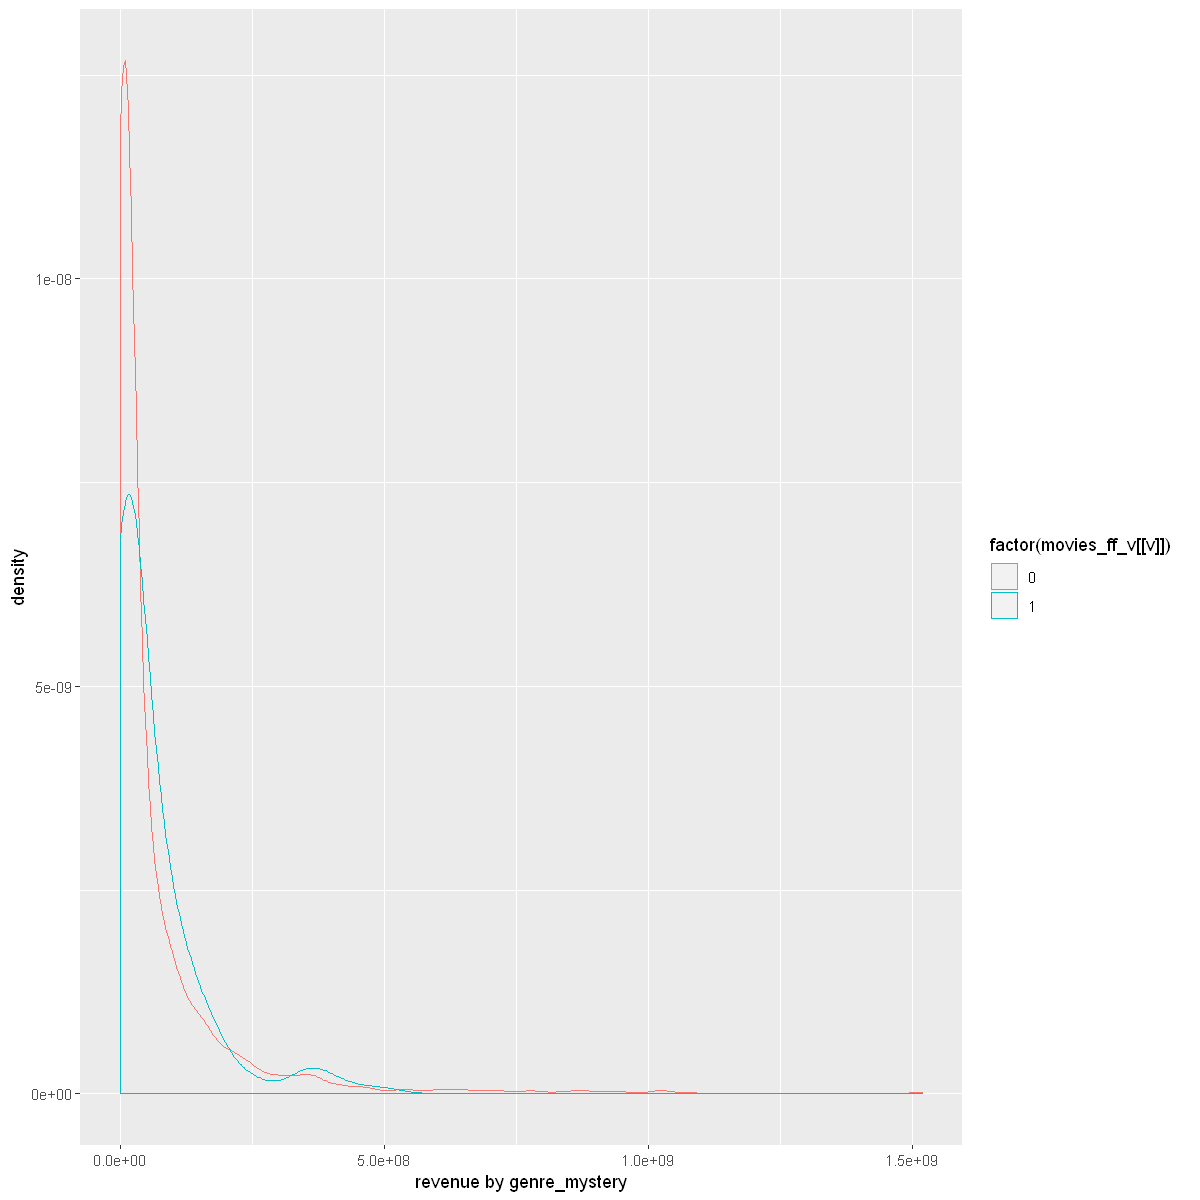

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


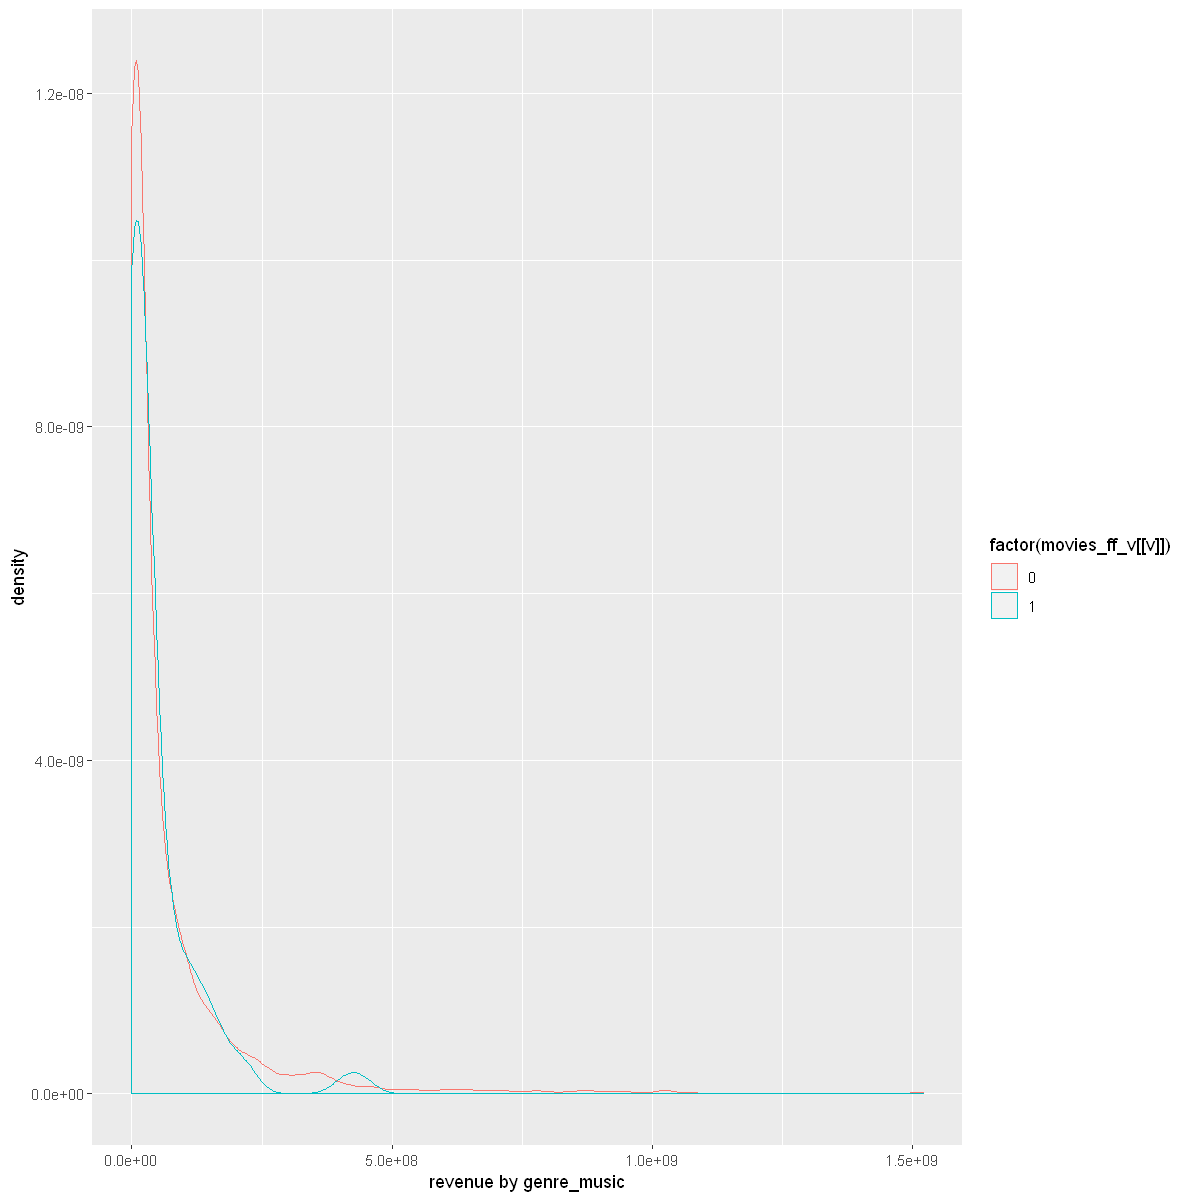

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


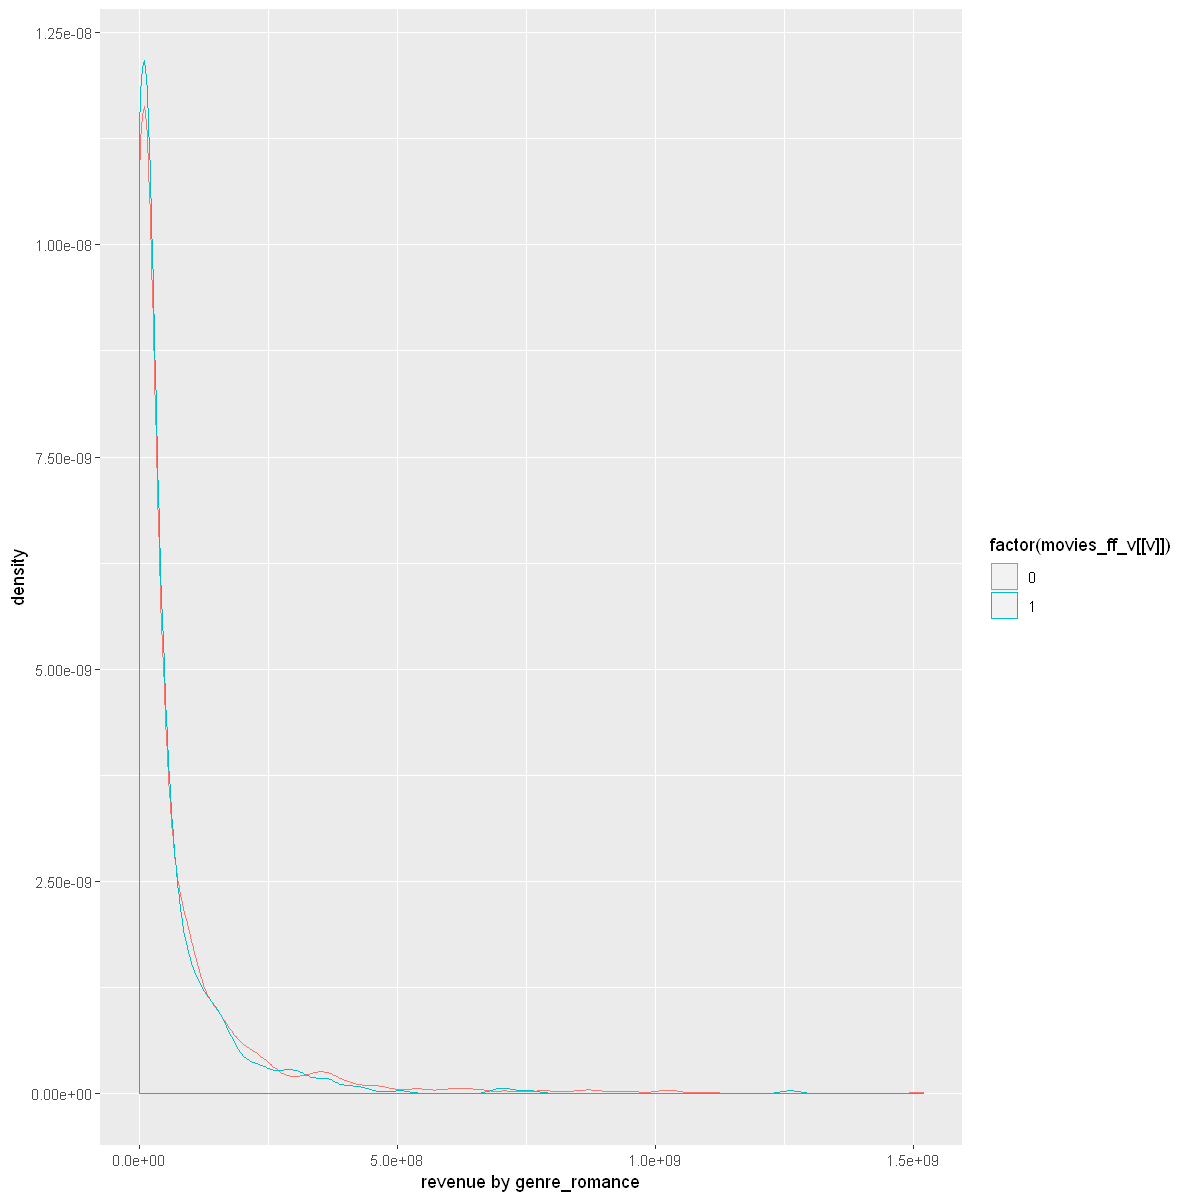

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


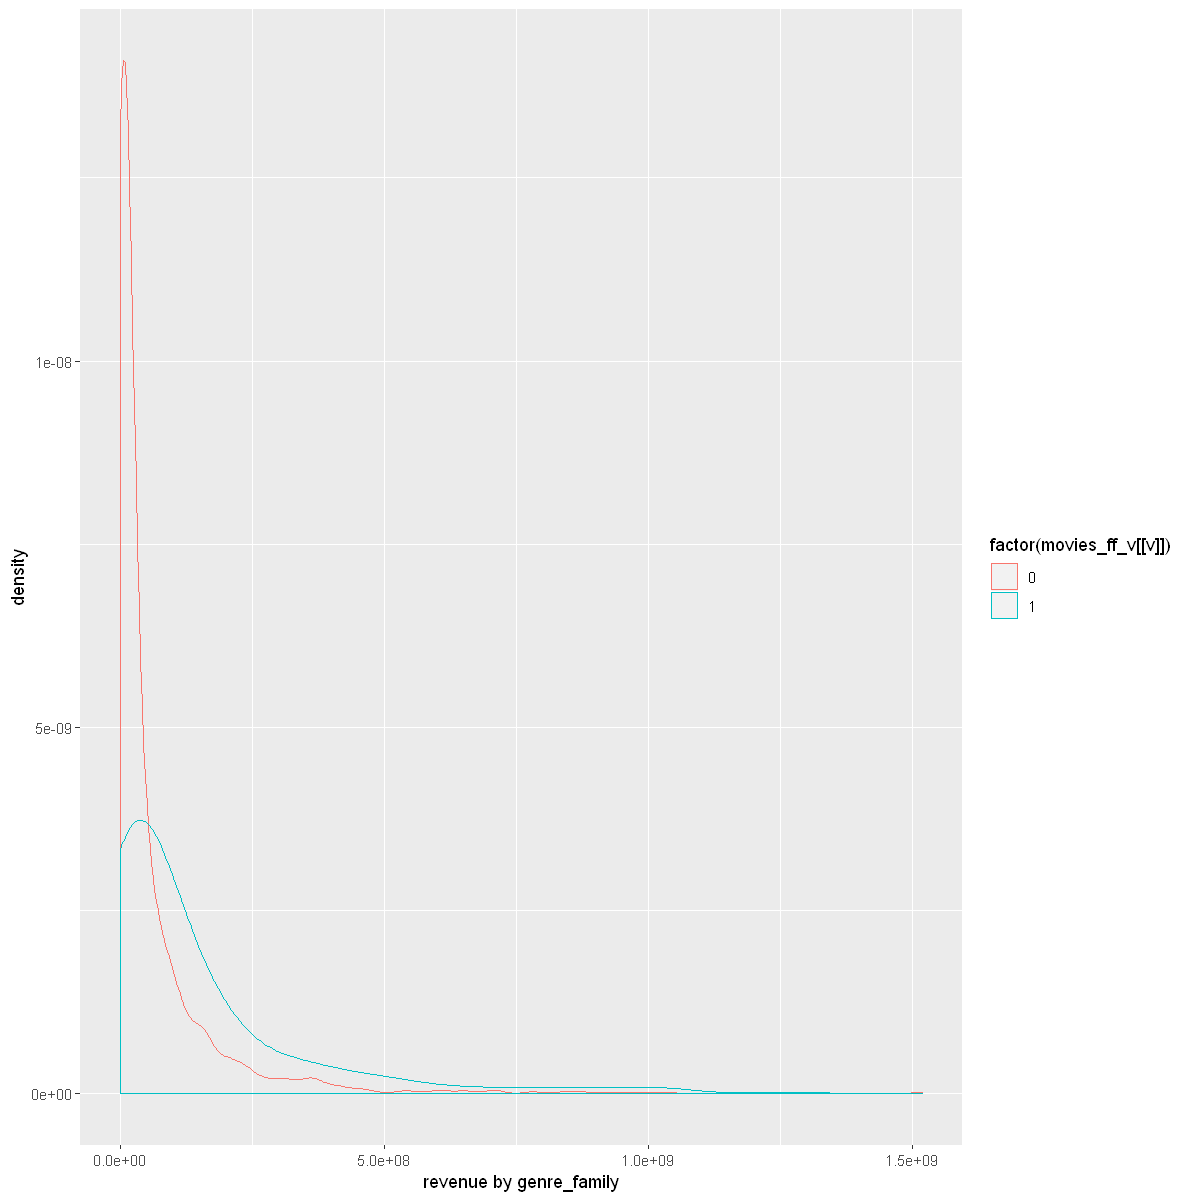

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


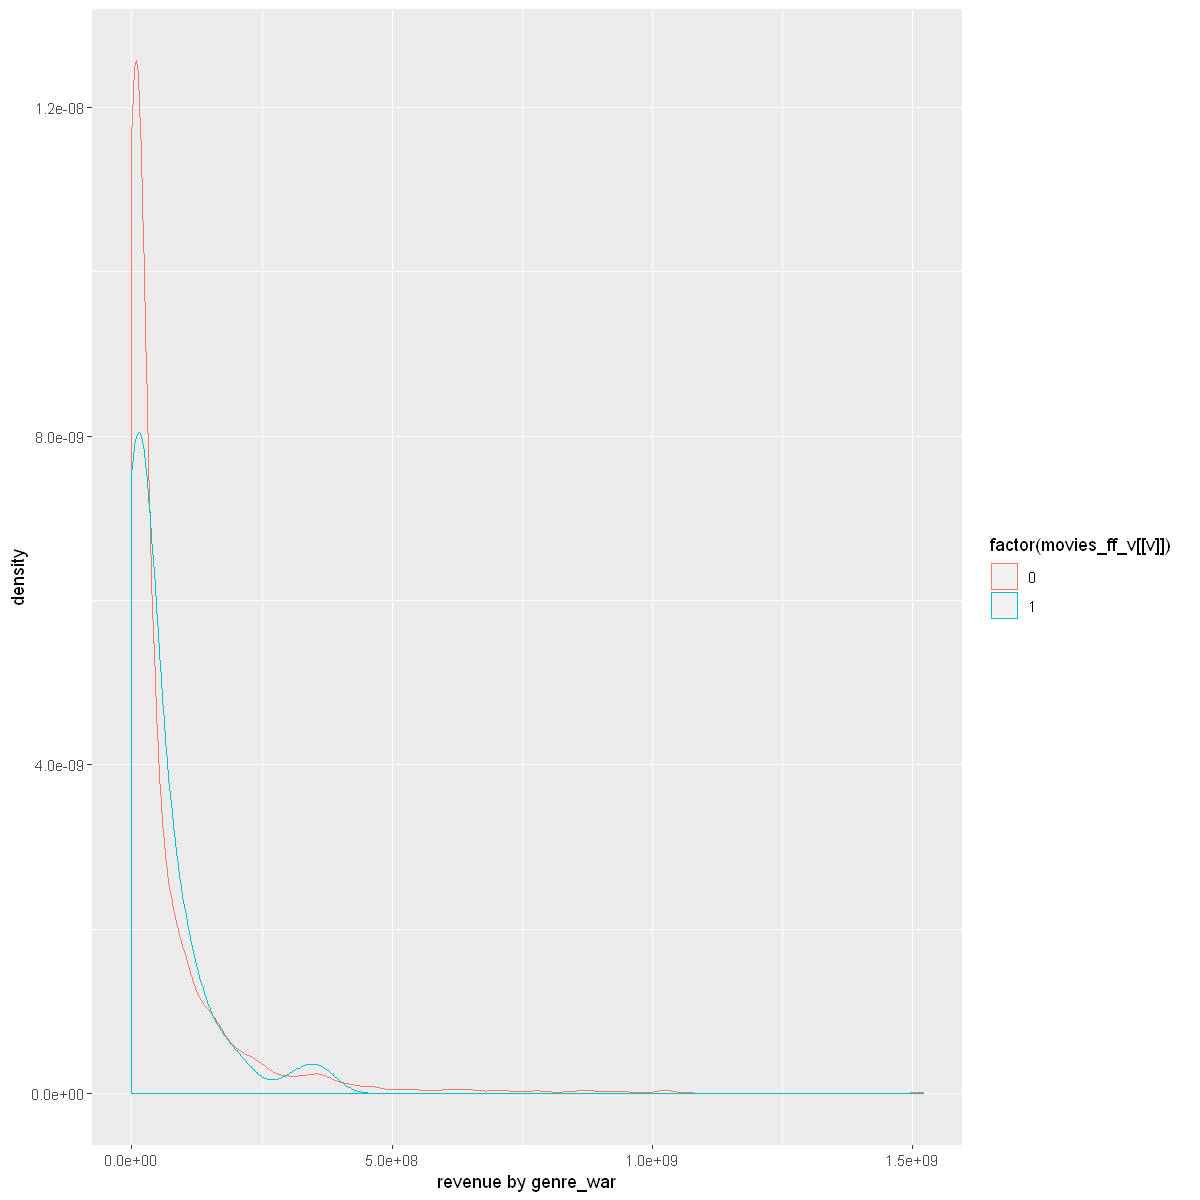

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


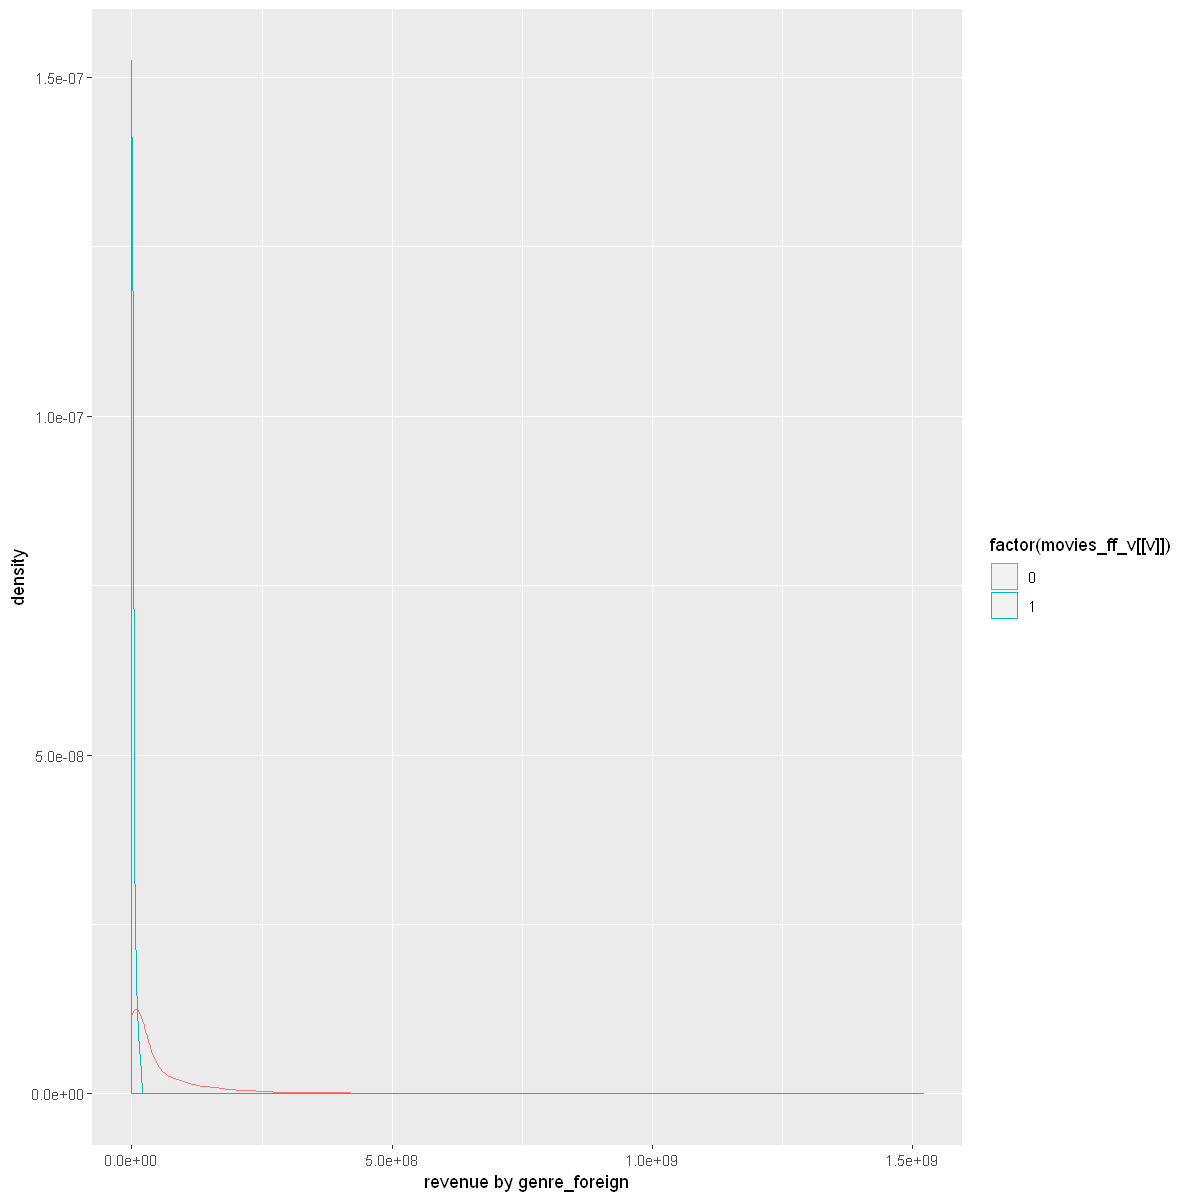

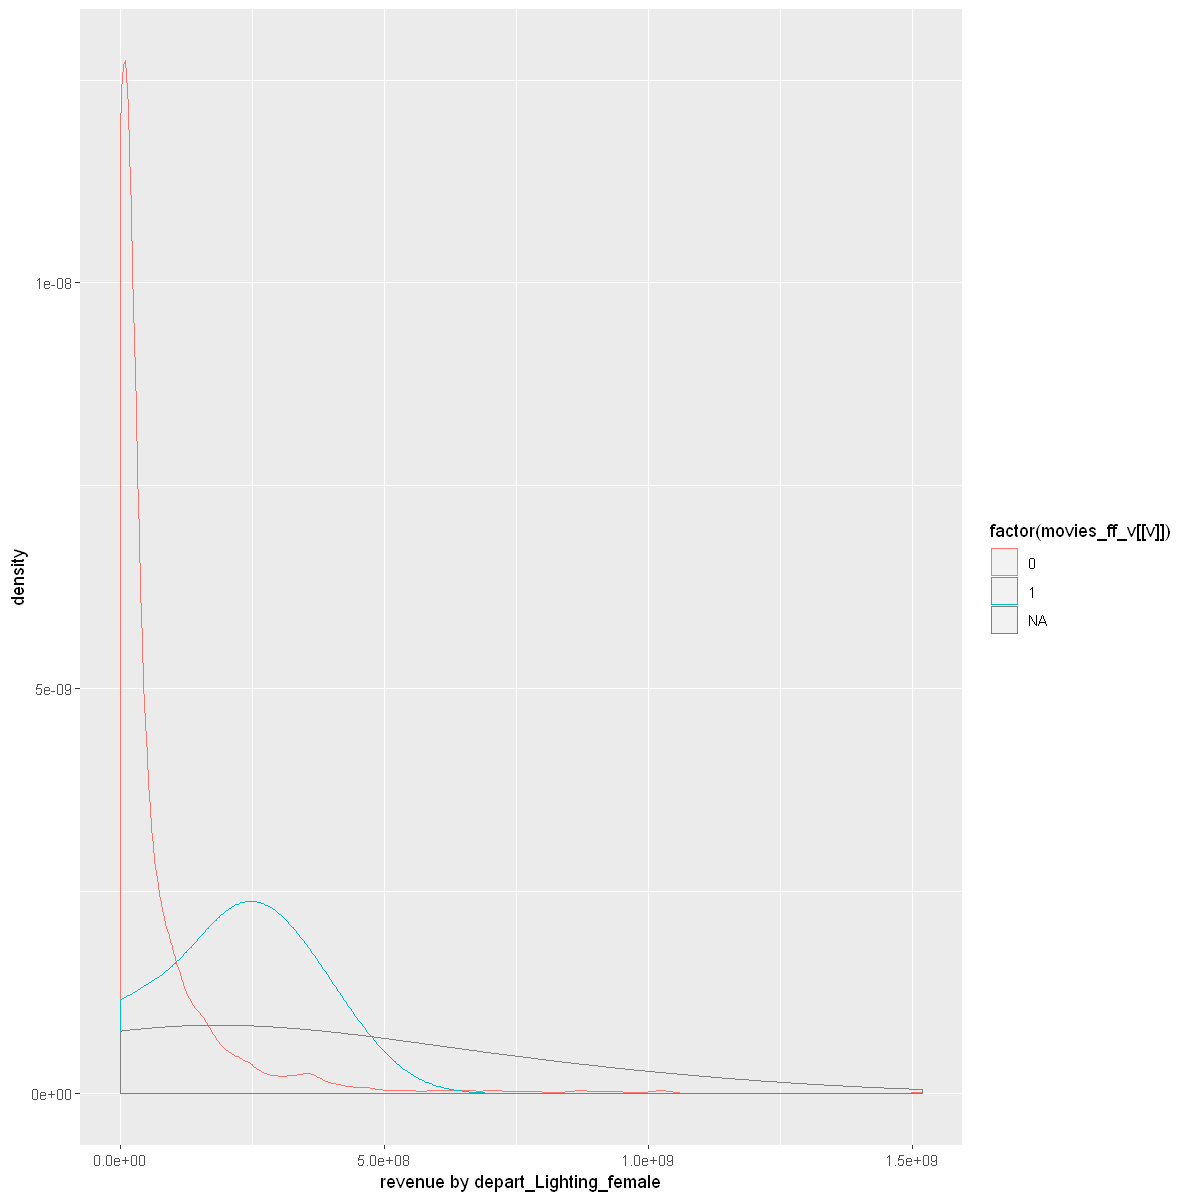

In [394]:
##distribution of revenue by categorical variables
for (v in cn) {
    print(ggplot(movies_ff_v,aes(x=movies_ff_v$revenue, group=factor(movies_ff_v[[v]]),
                          color=factor(movies_ff_v[[v]]))) + xlab(paste('revenue by',v,sep=' ')) +
    geom_density(adjust=2))
}

In [395]:
## creating a vector of the continuous variables
vn <- names(movies_ff_v[,2:85])
l <- c()
for(v in vn) {
        if((is.numeric(movies_ff_v[[v]])) & (max(movies_ff_v[[v]],na.rm=T)>1) & 
           (!(v %in% c('release_day','release_year','release_month','seasonality'))))
            {l <- c(l,v)}}
    

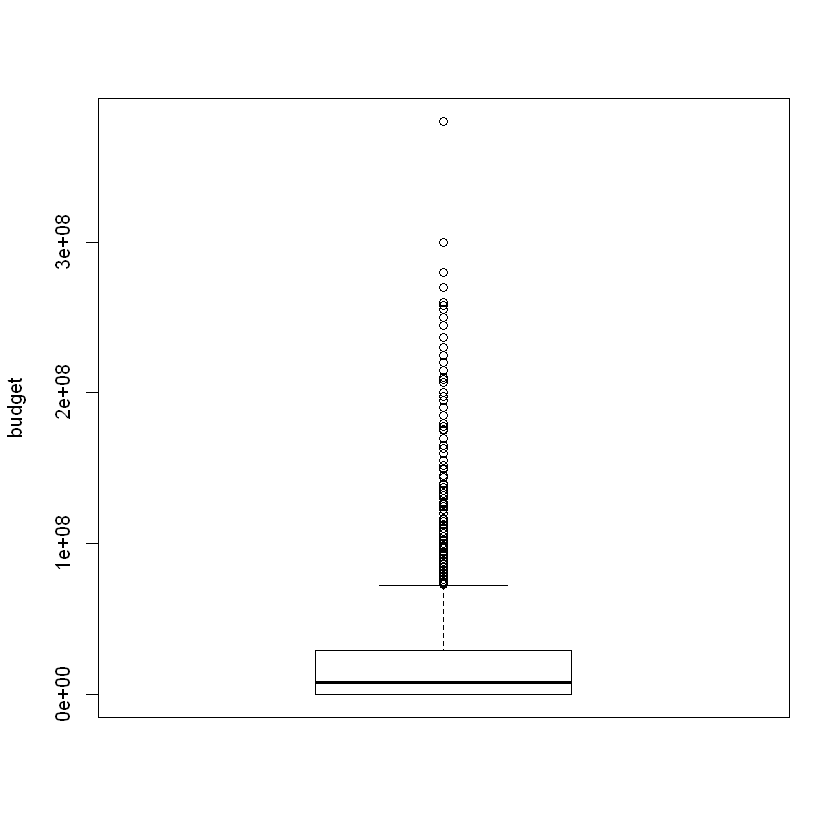

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


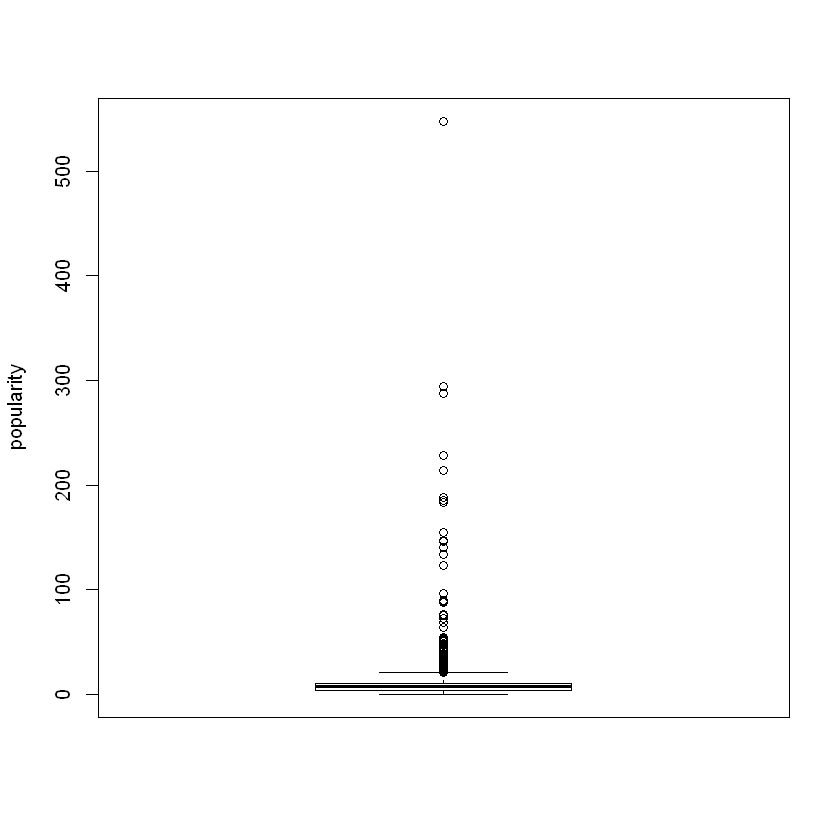

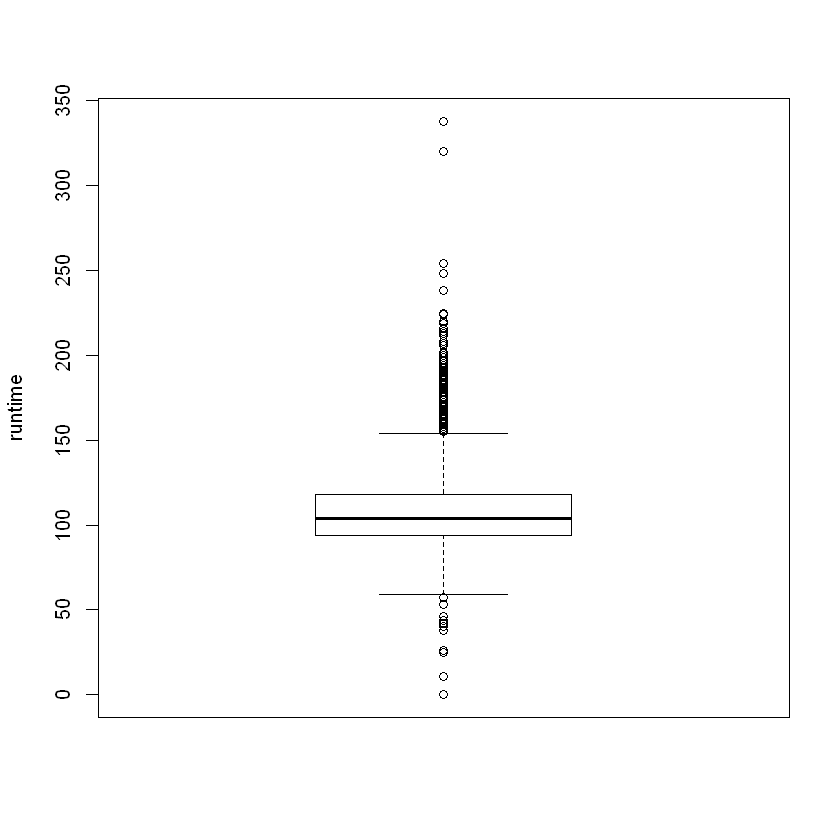

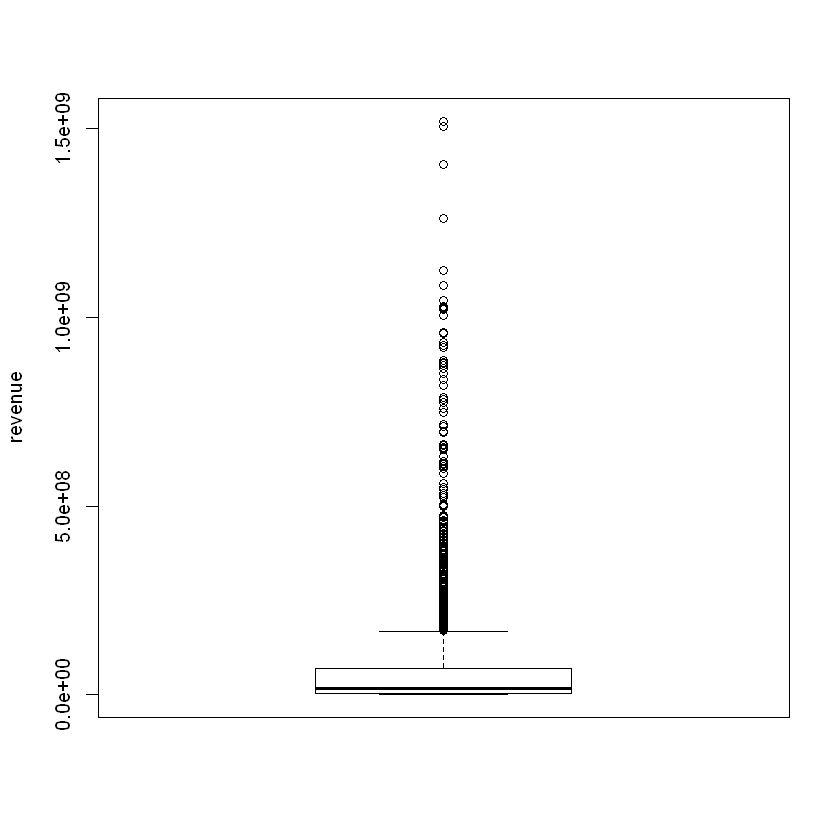

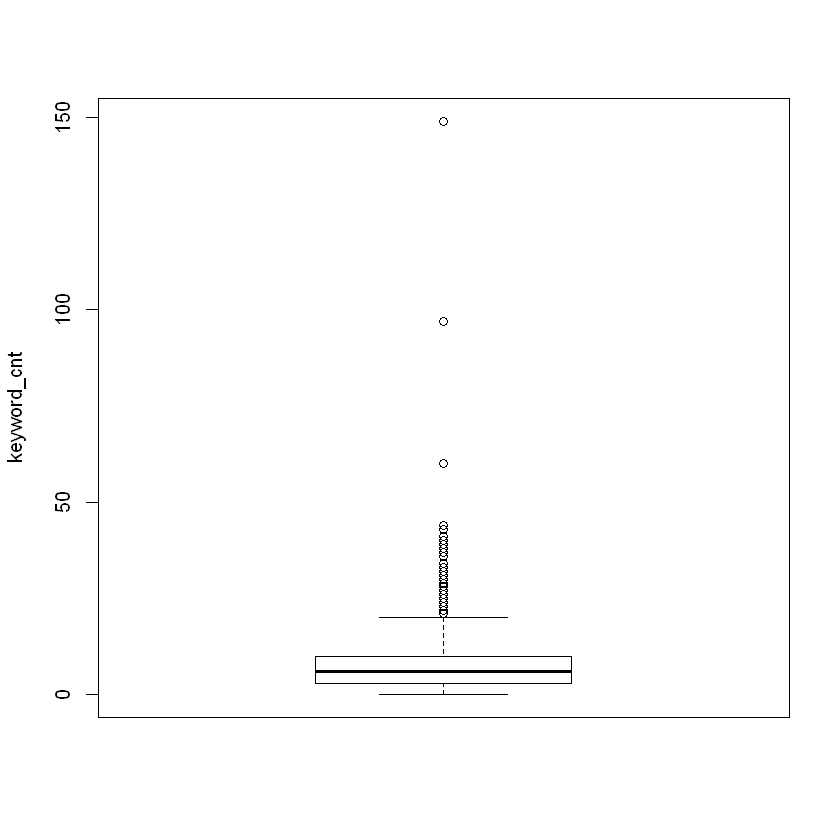

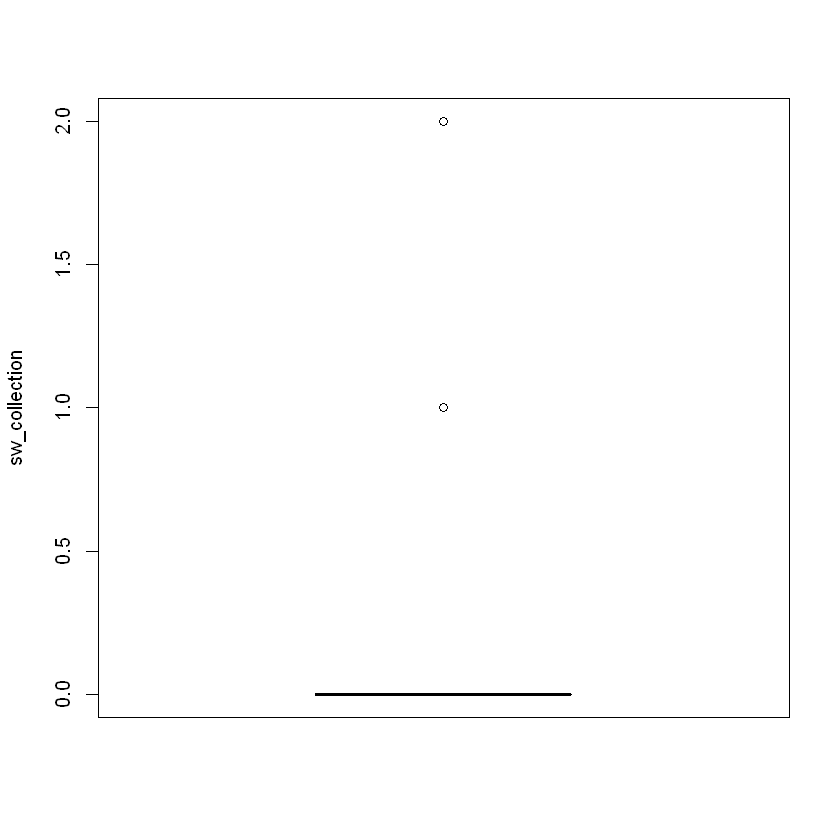

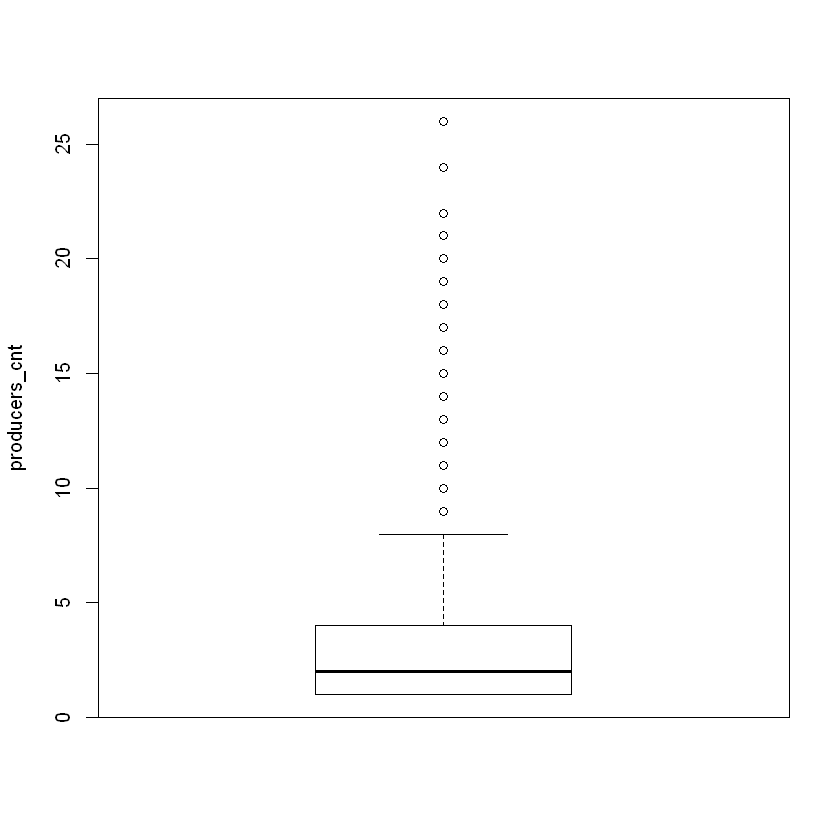

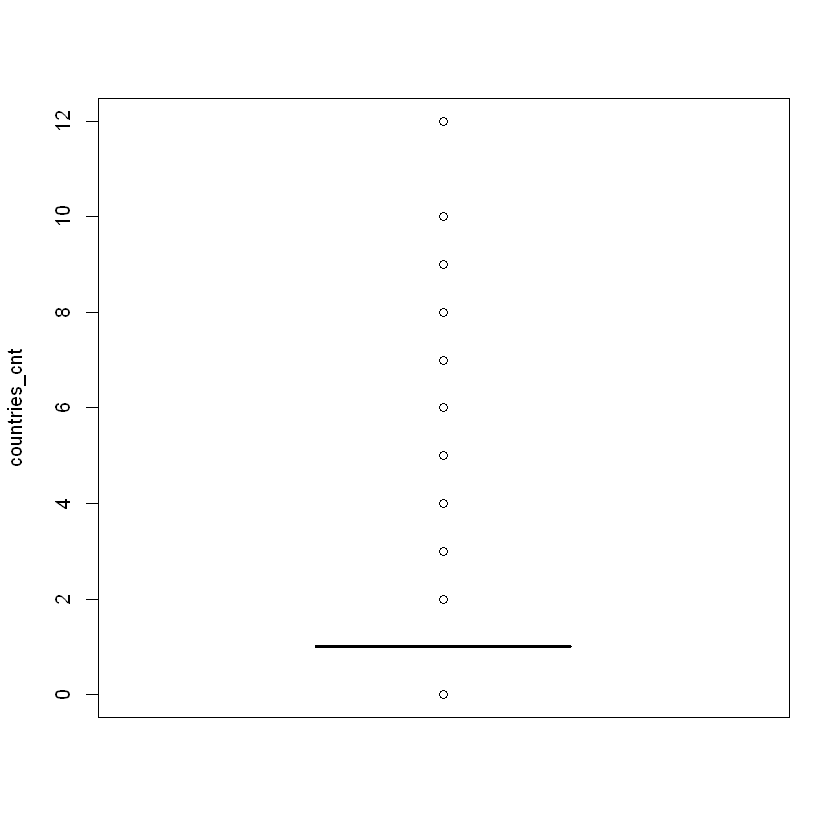

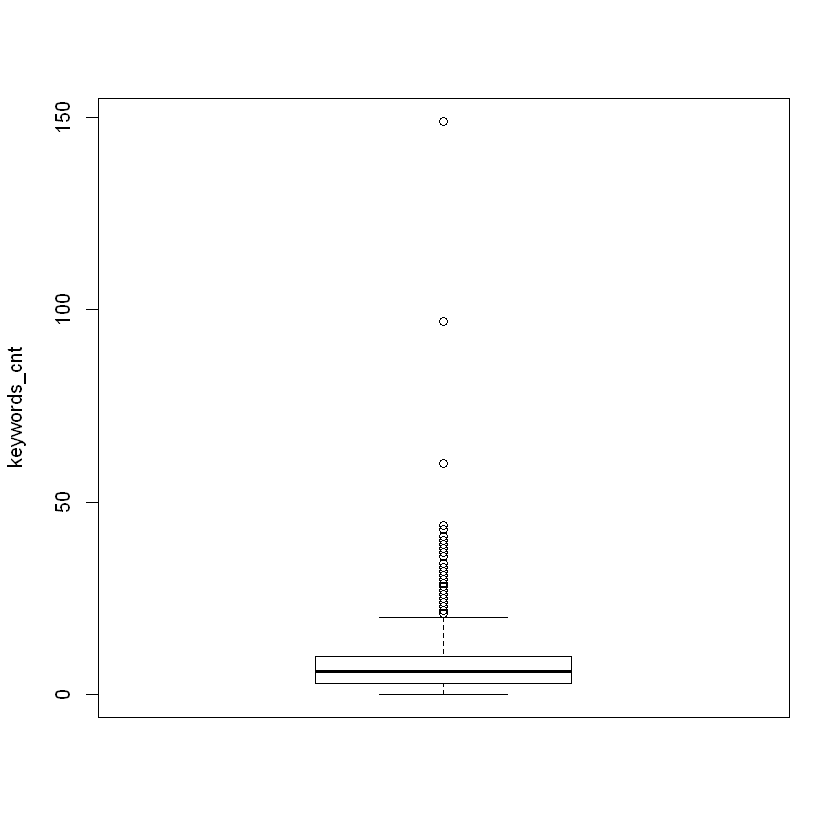

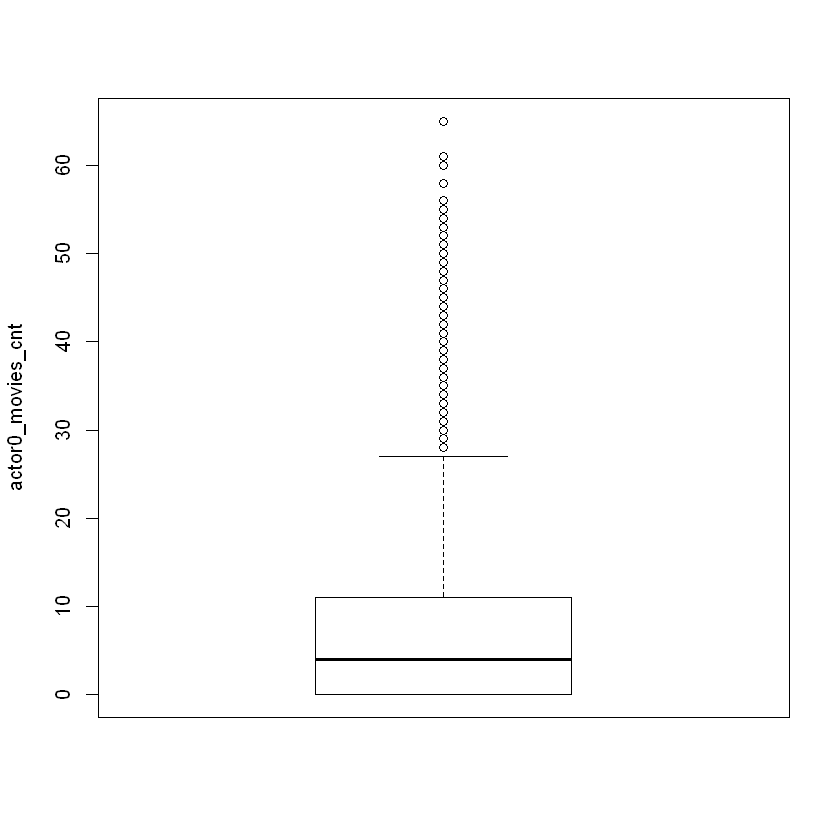

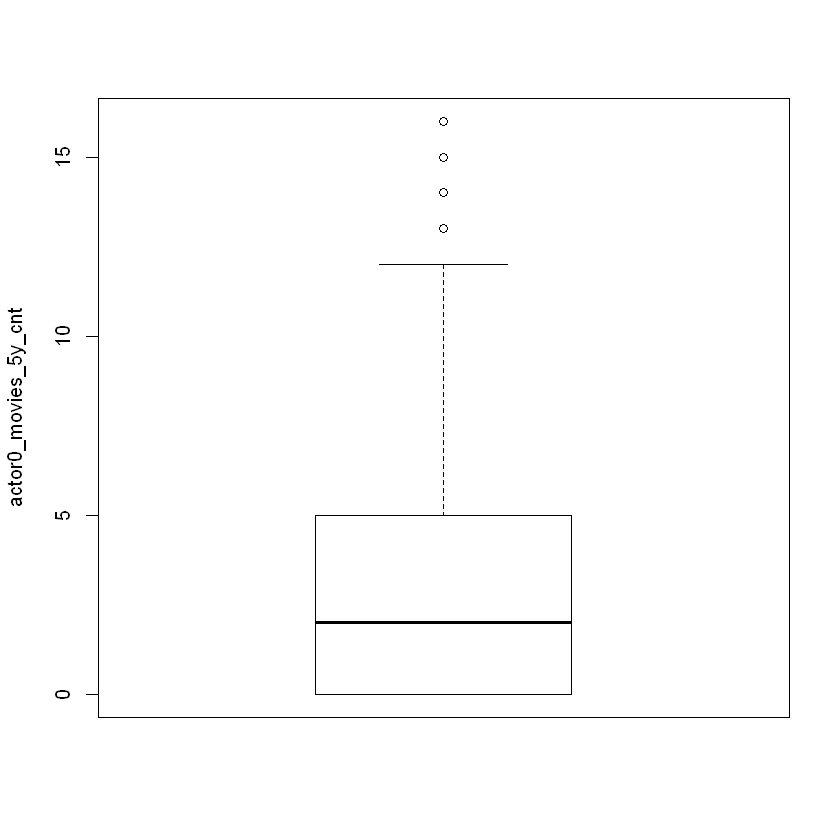

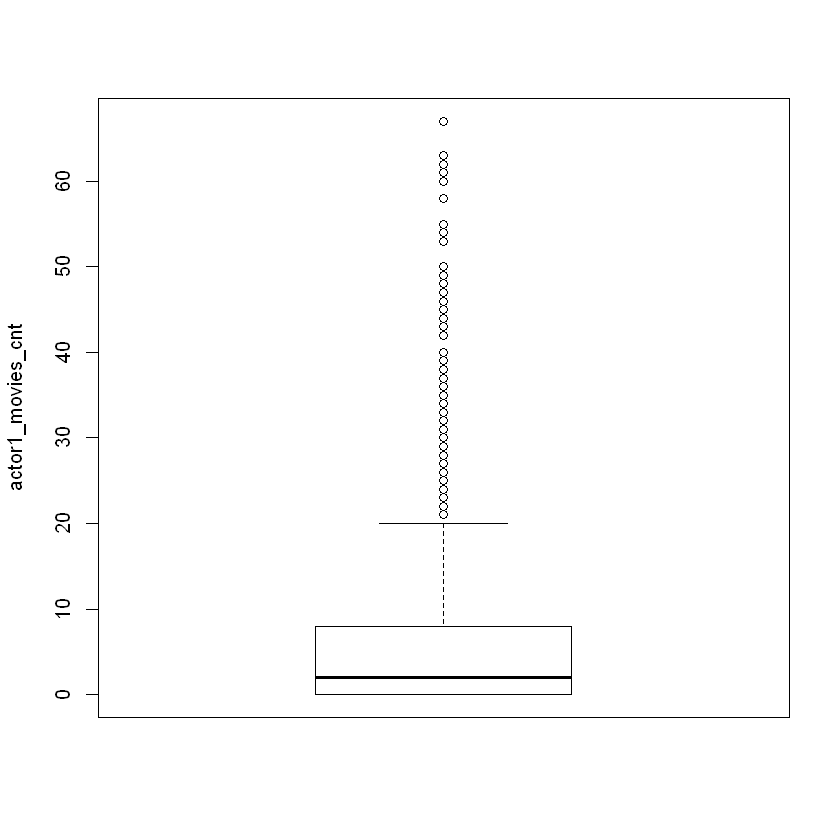

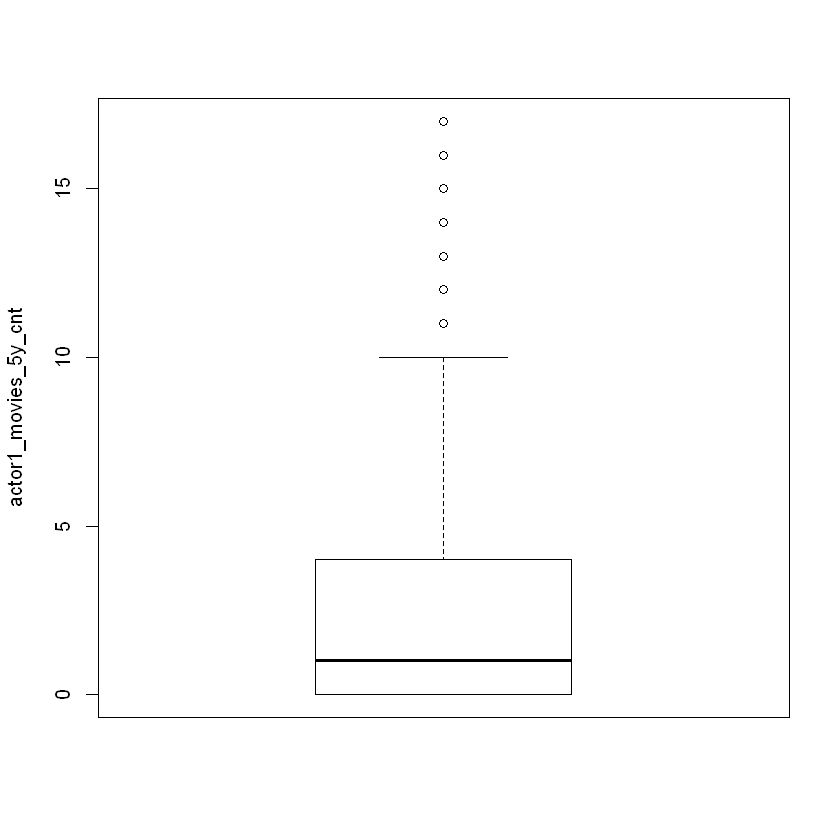

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


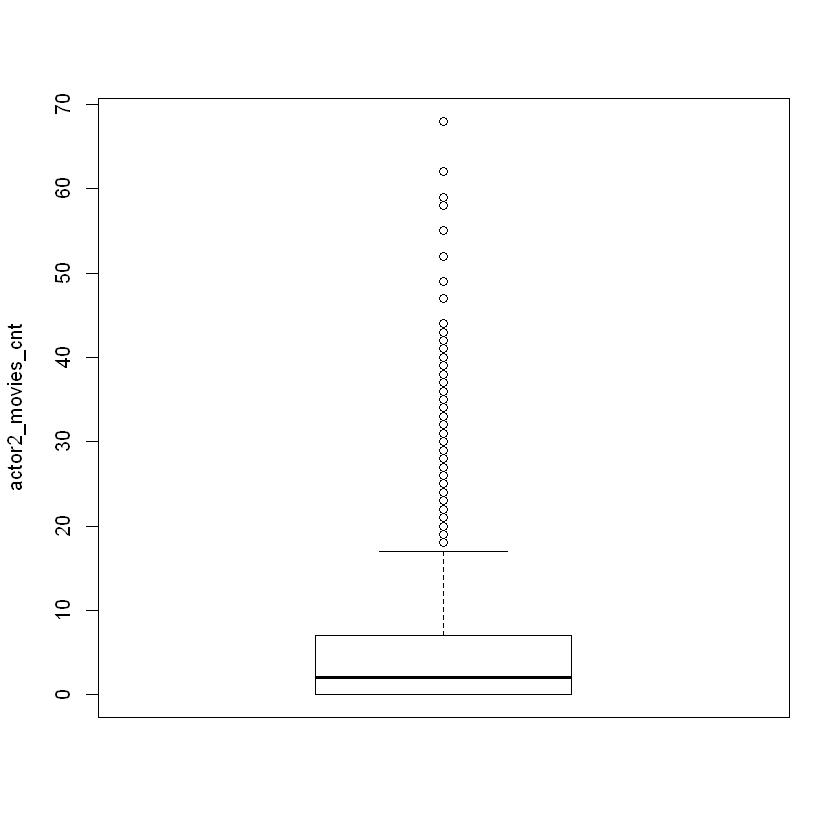

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


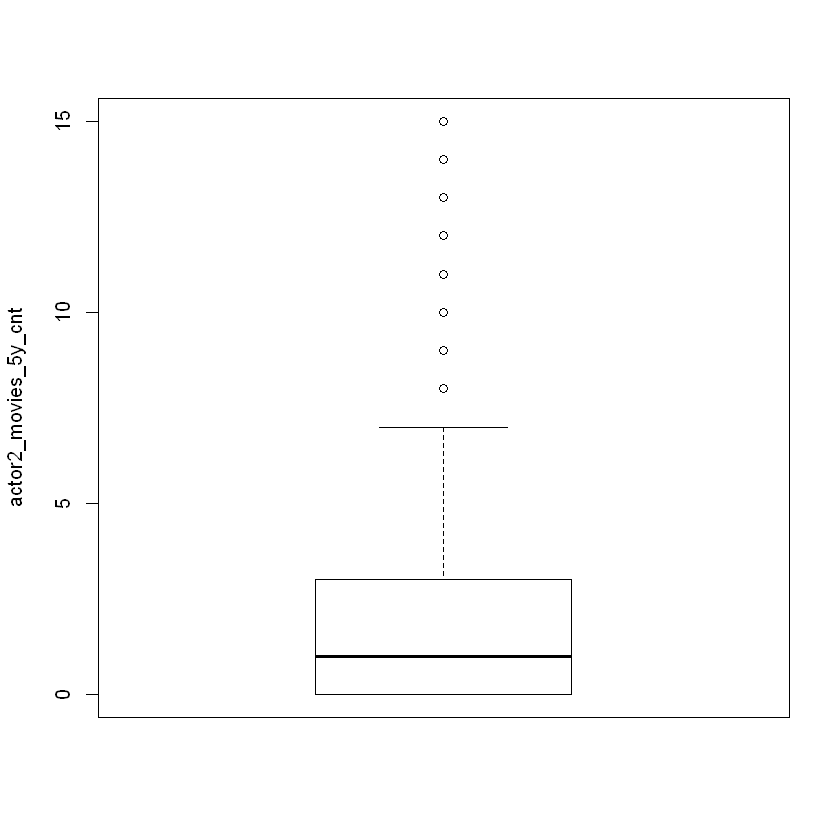

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


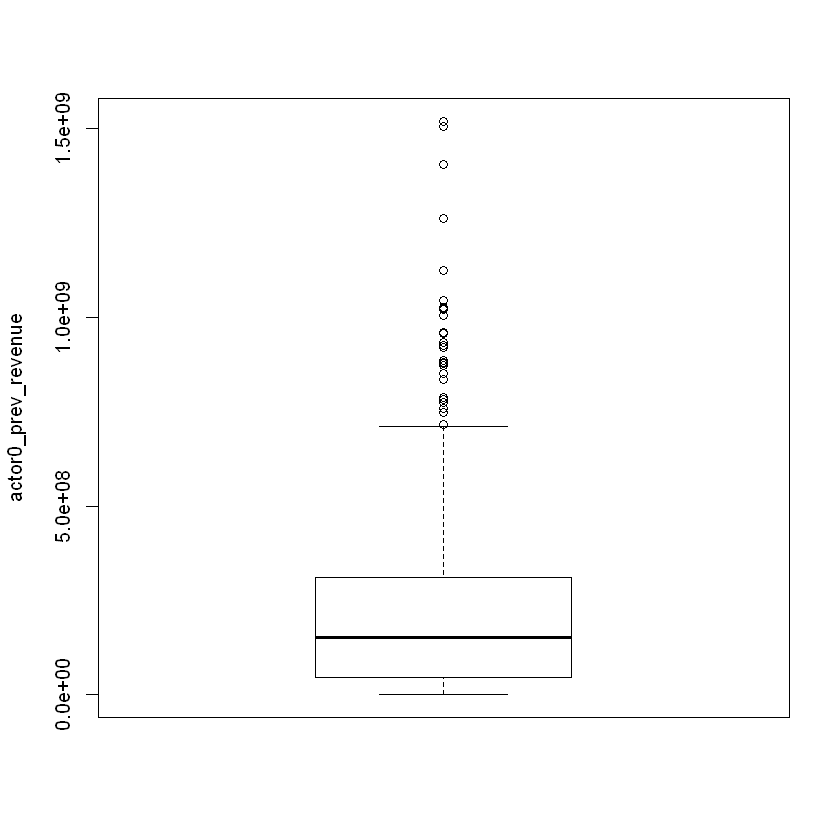

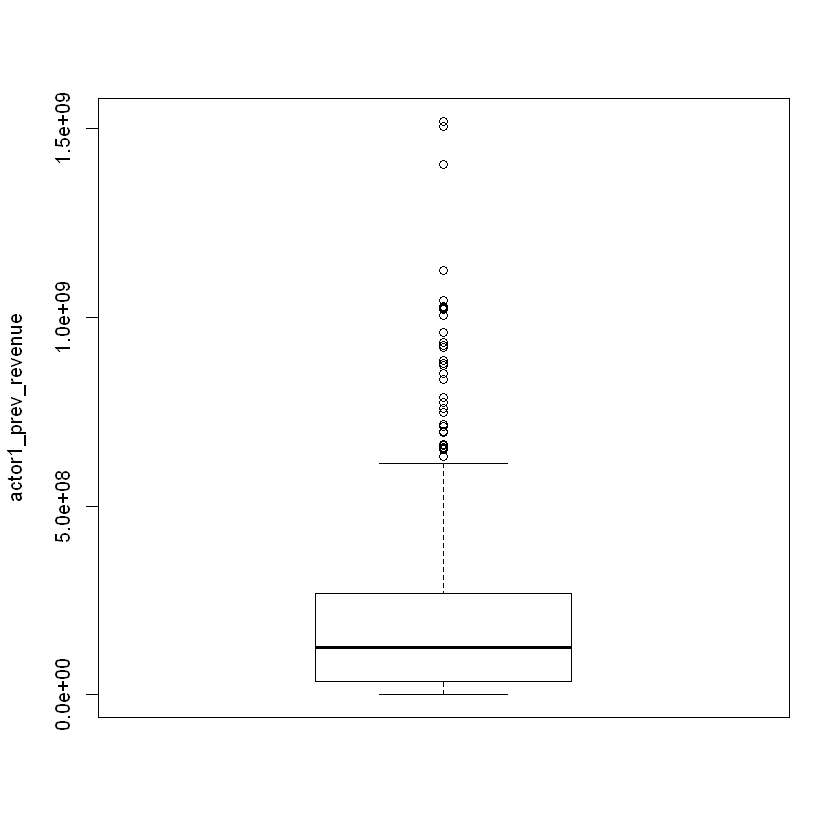

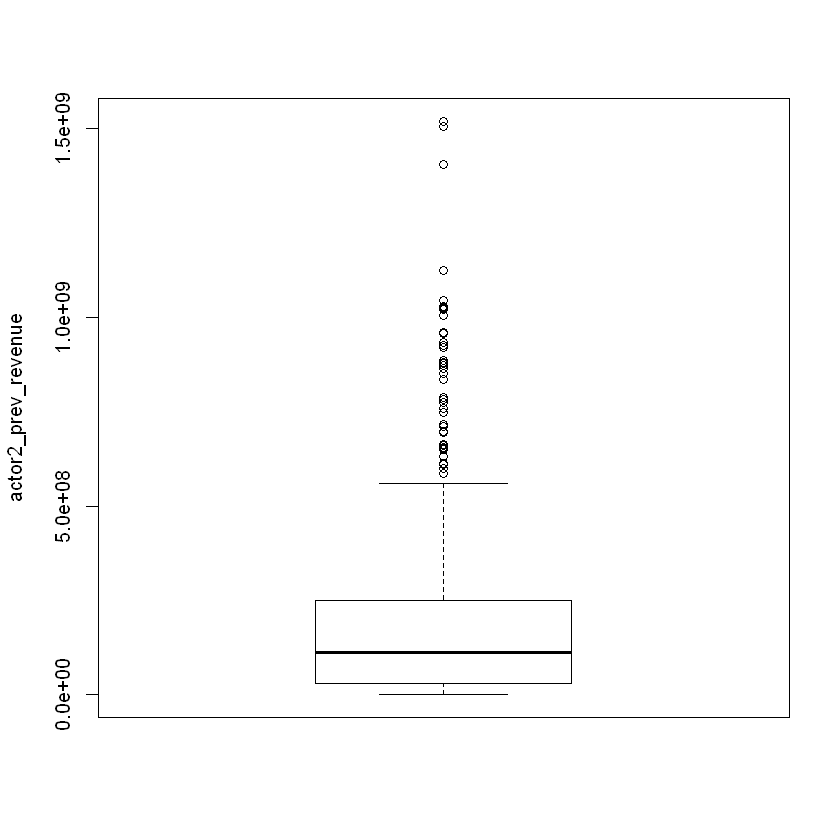

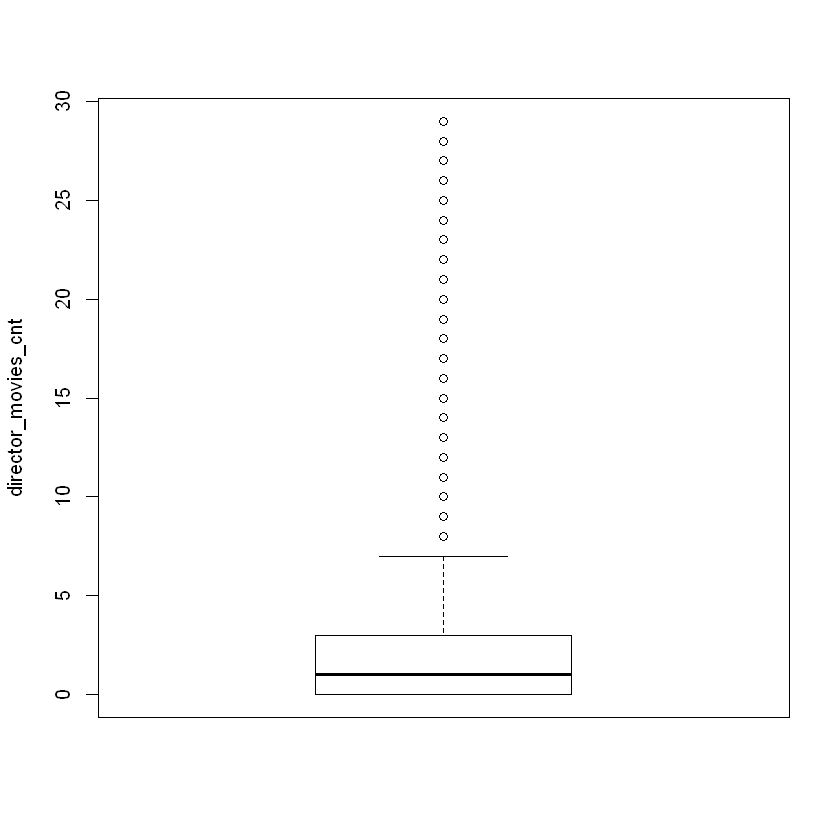

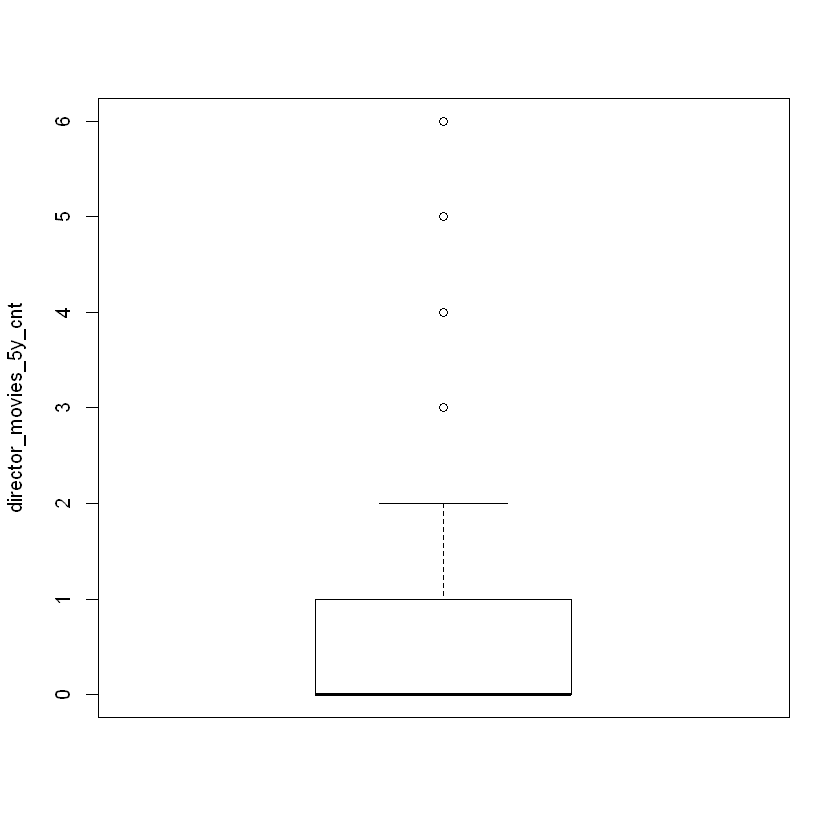

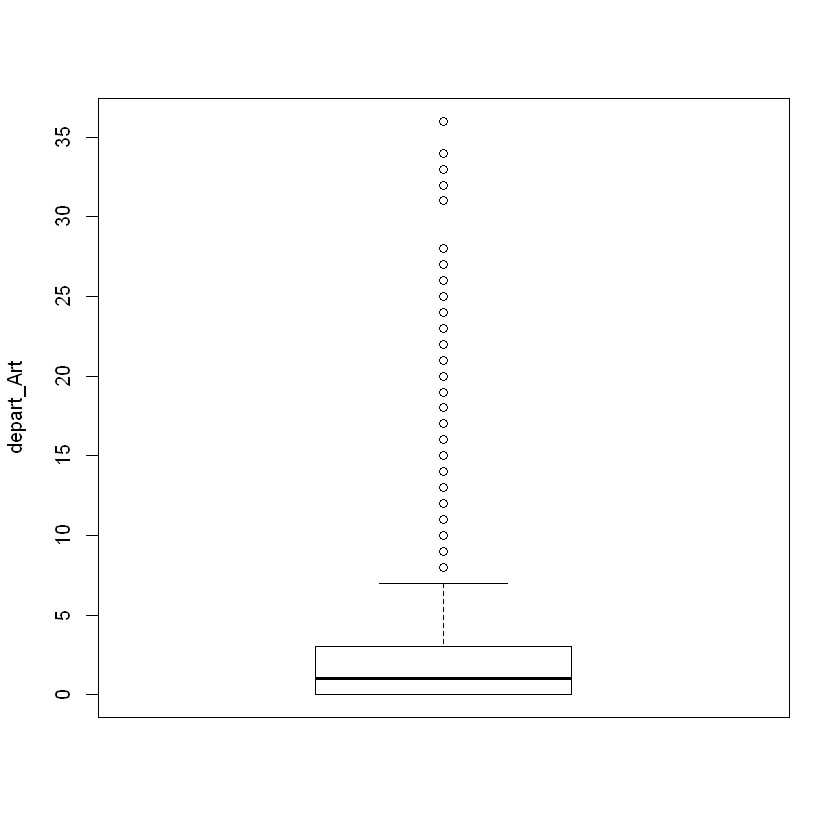

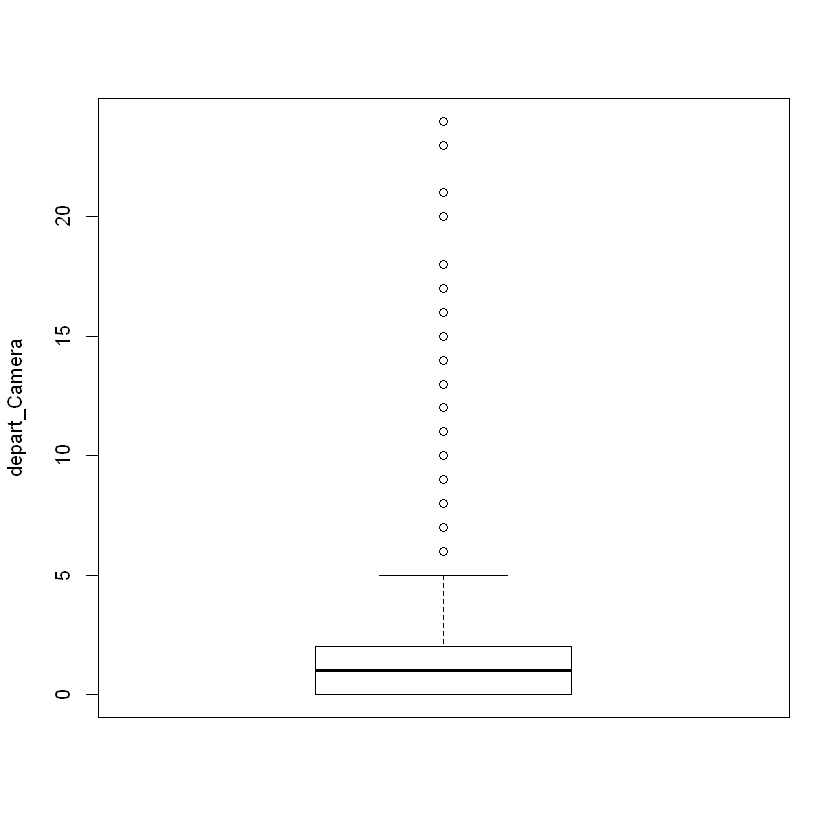

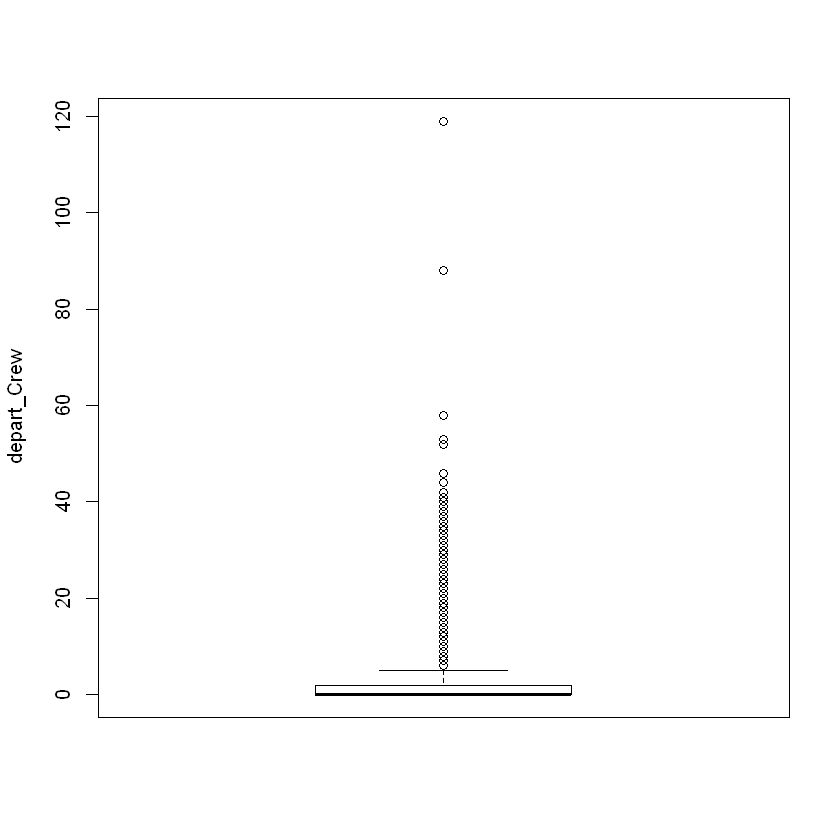

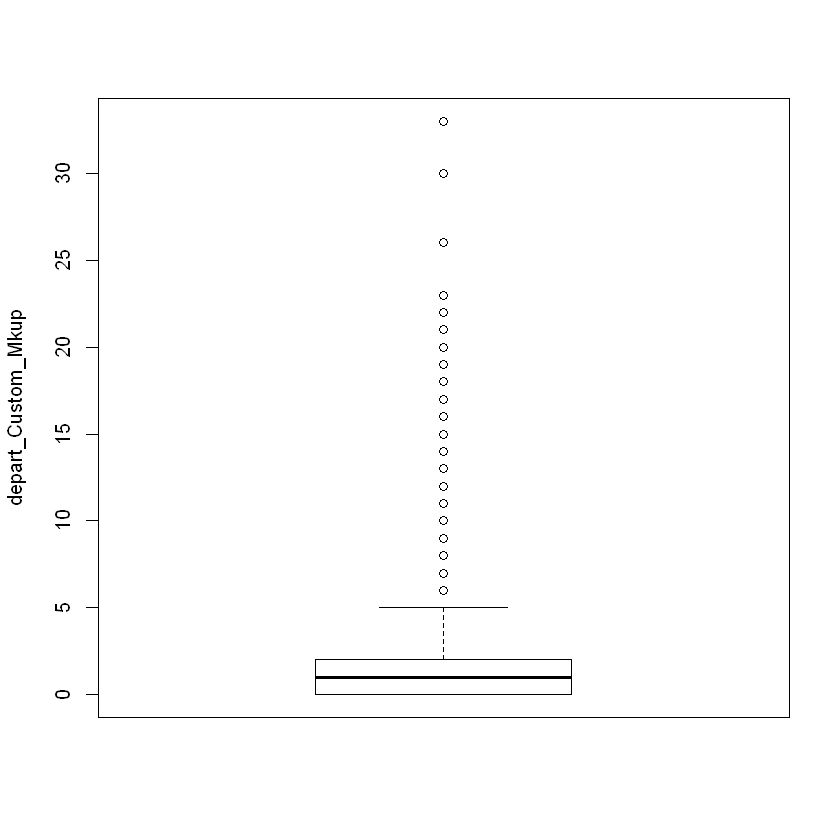

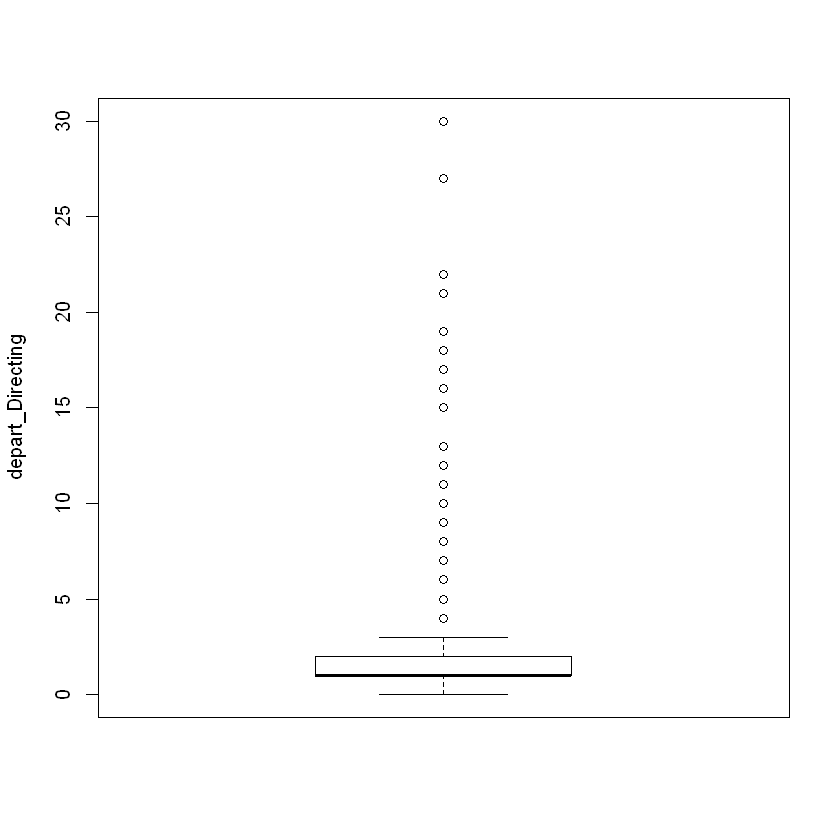

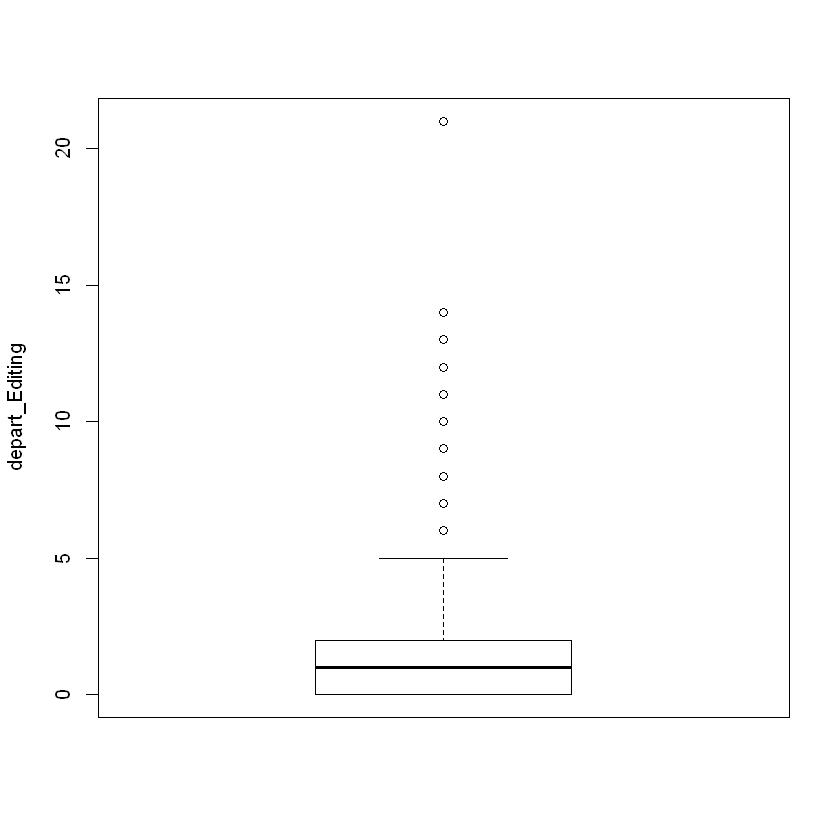

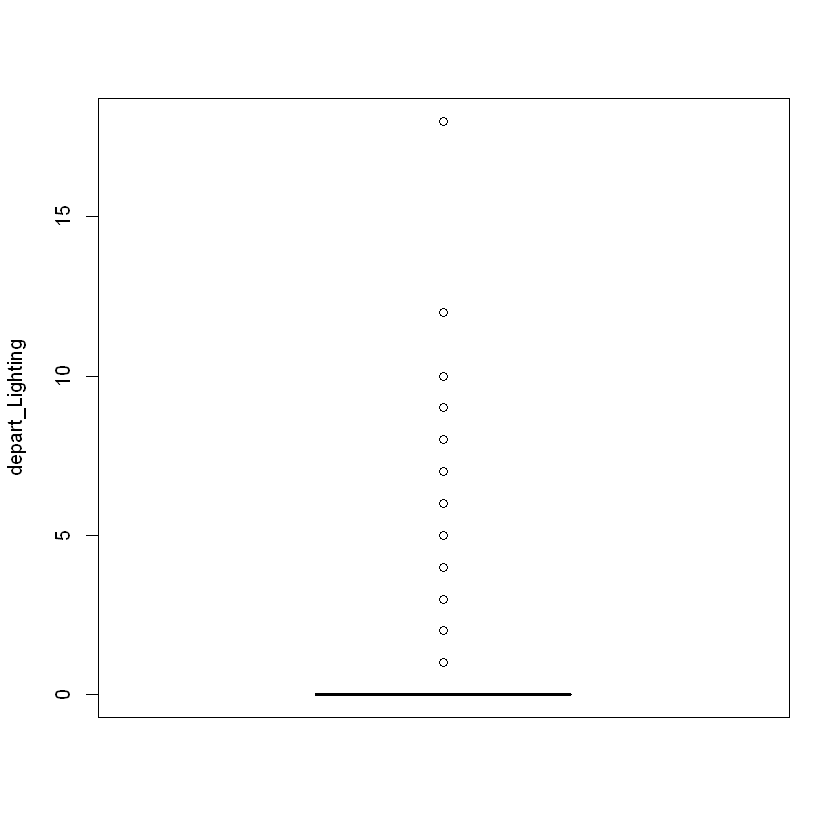

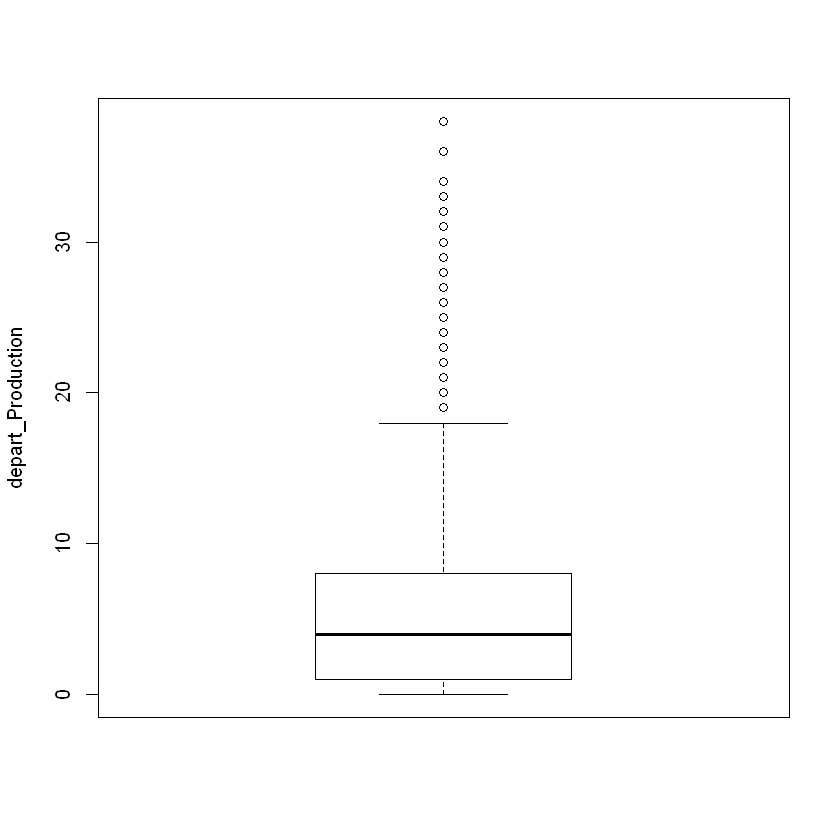

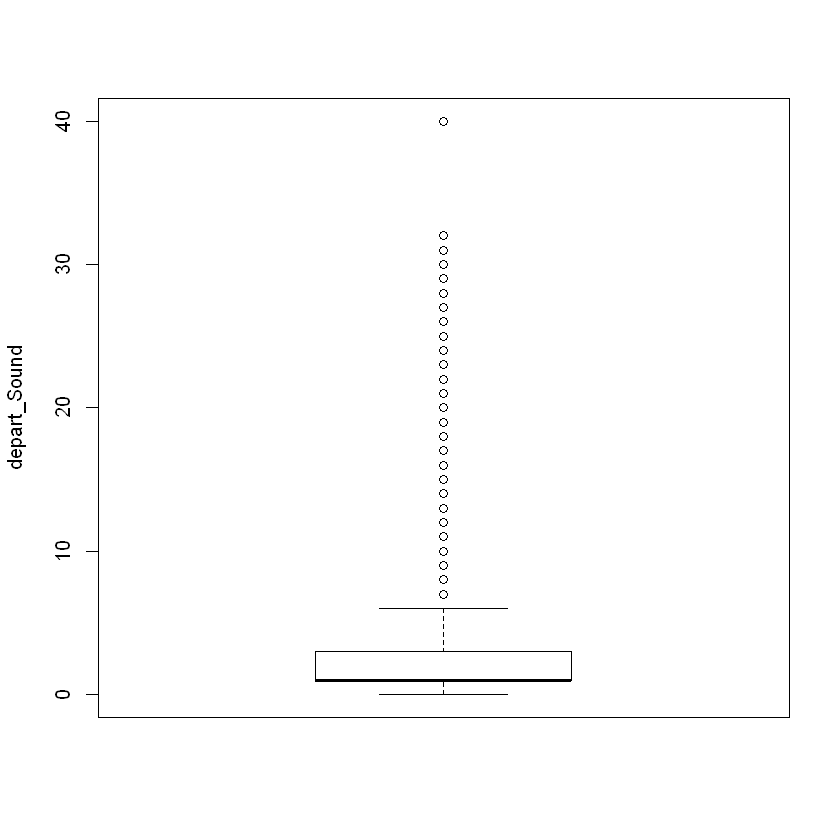

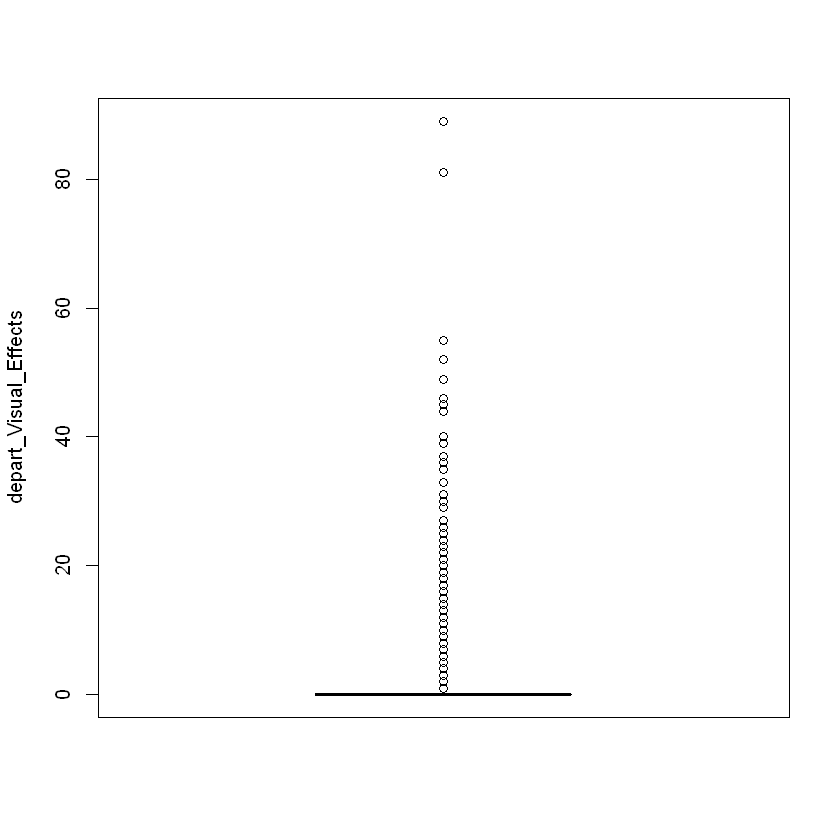

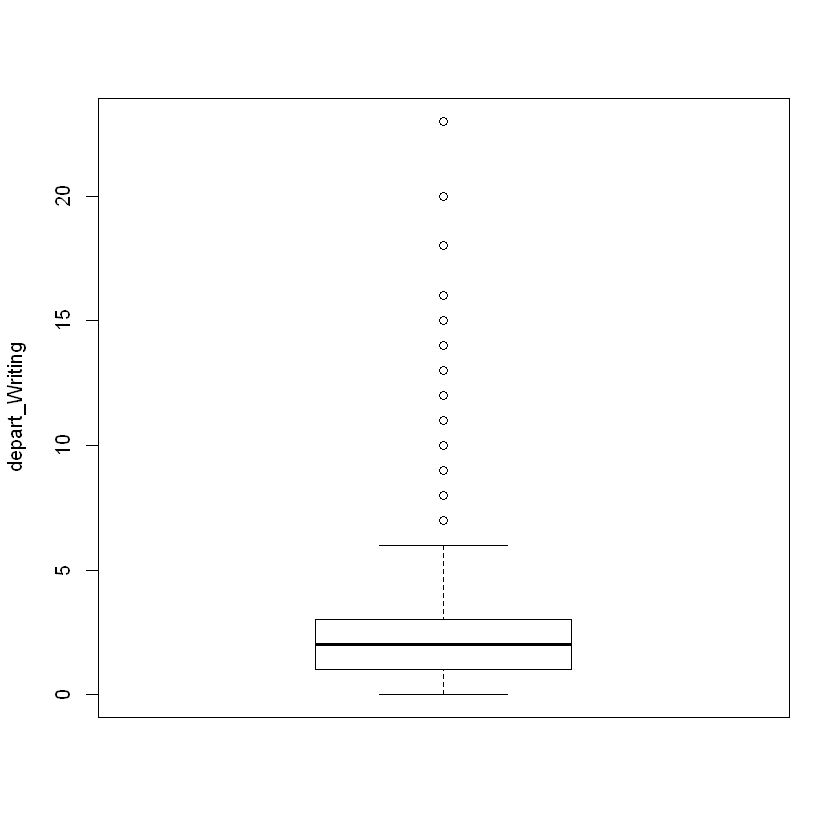

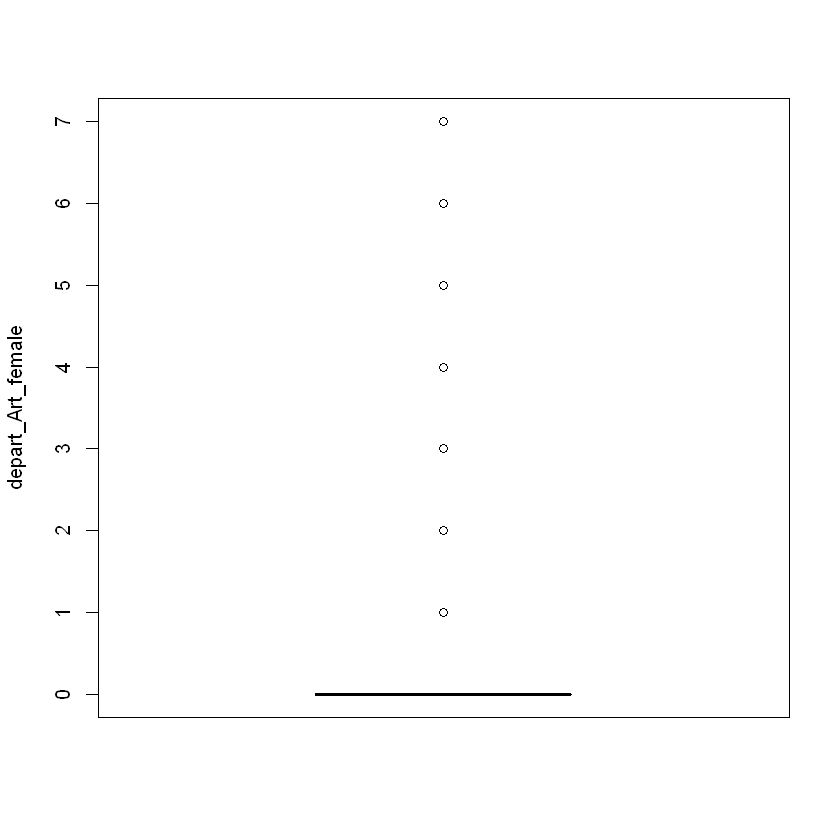

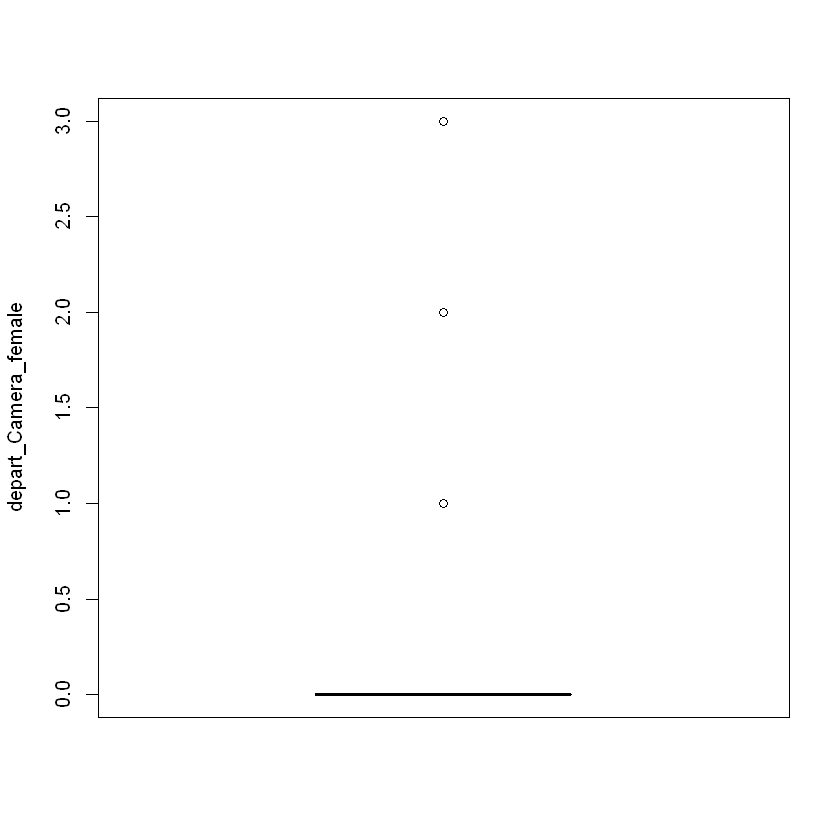

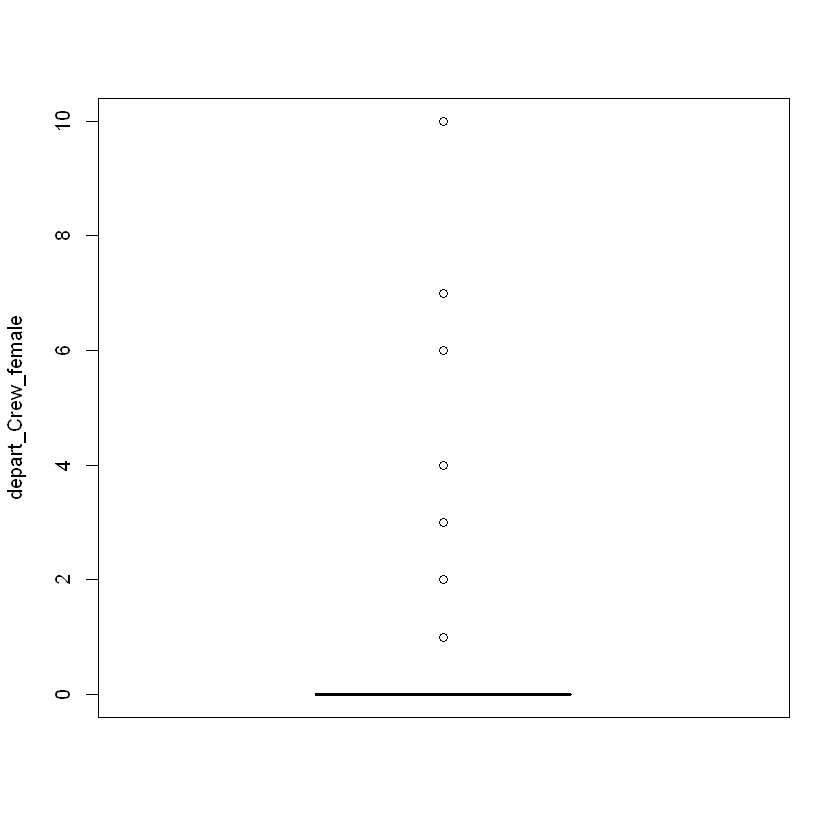

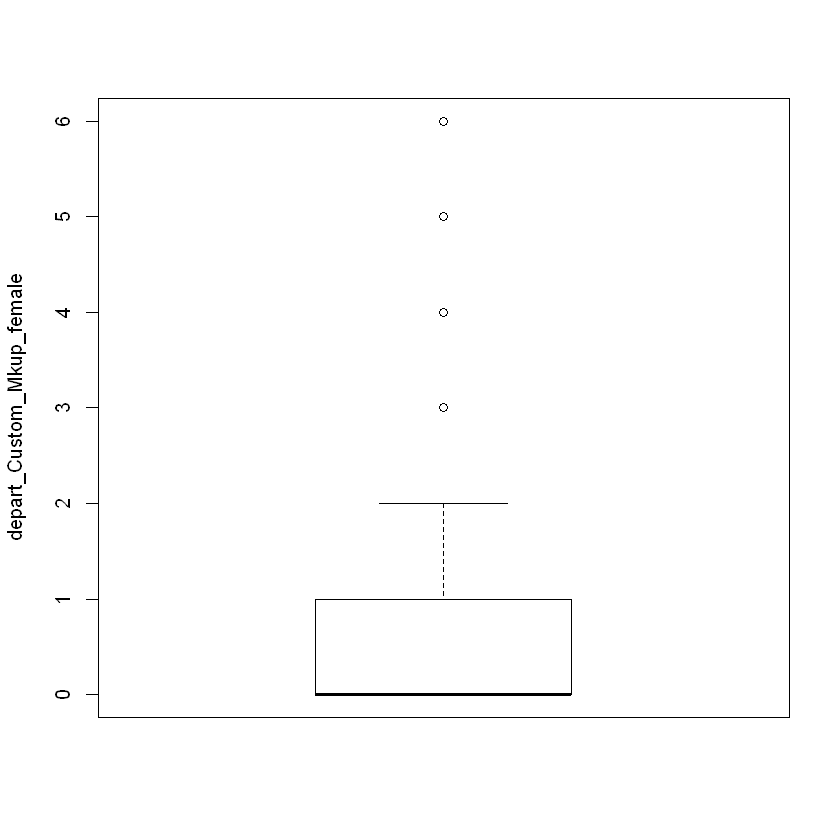

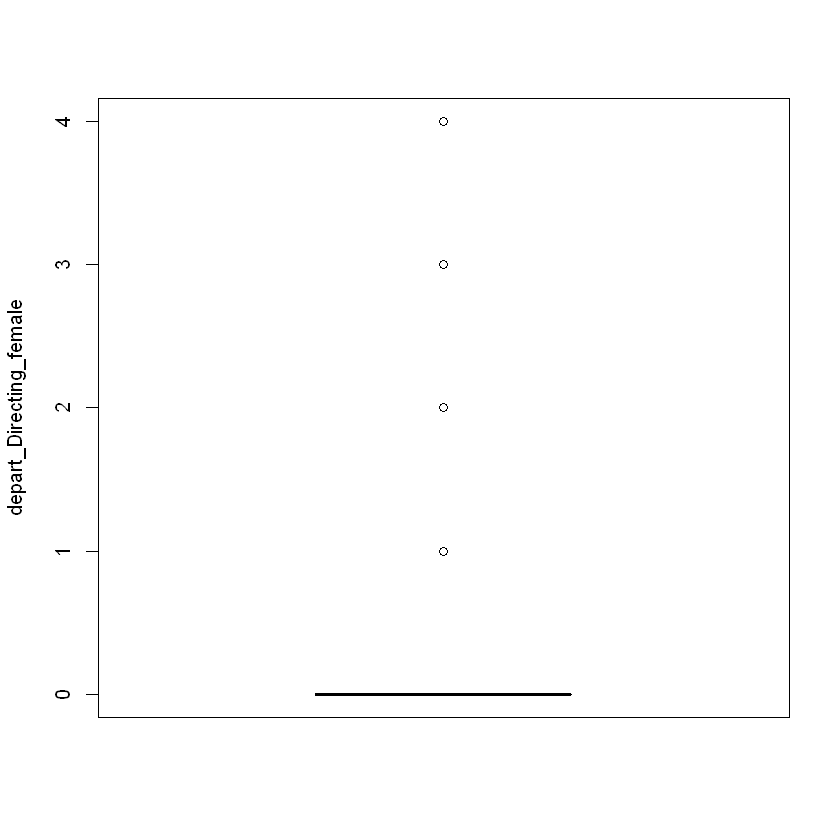

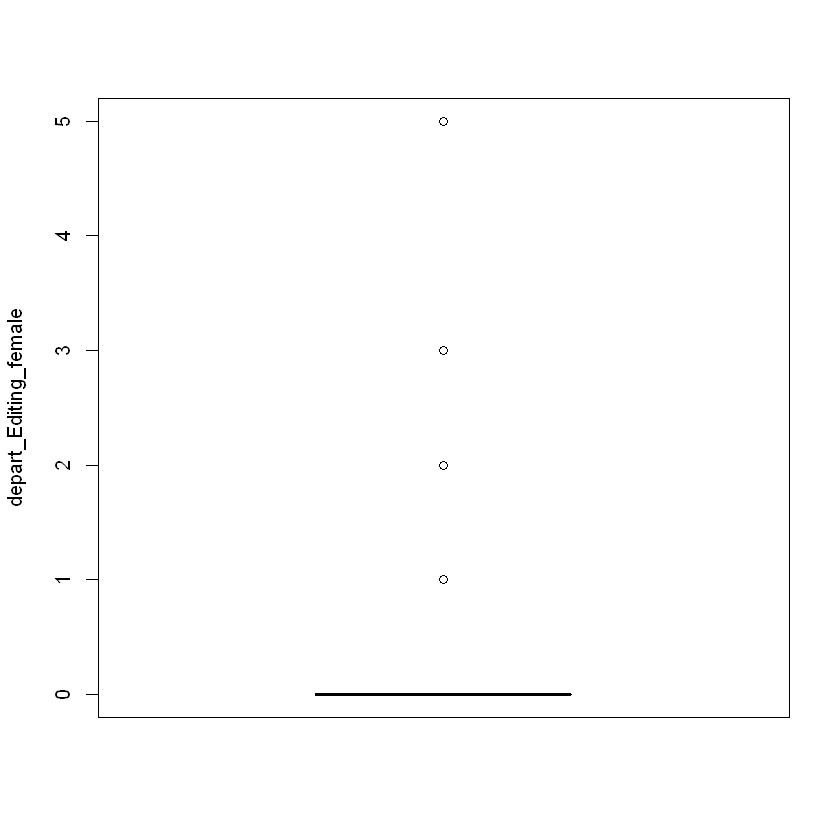

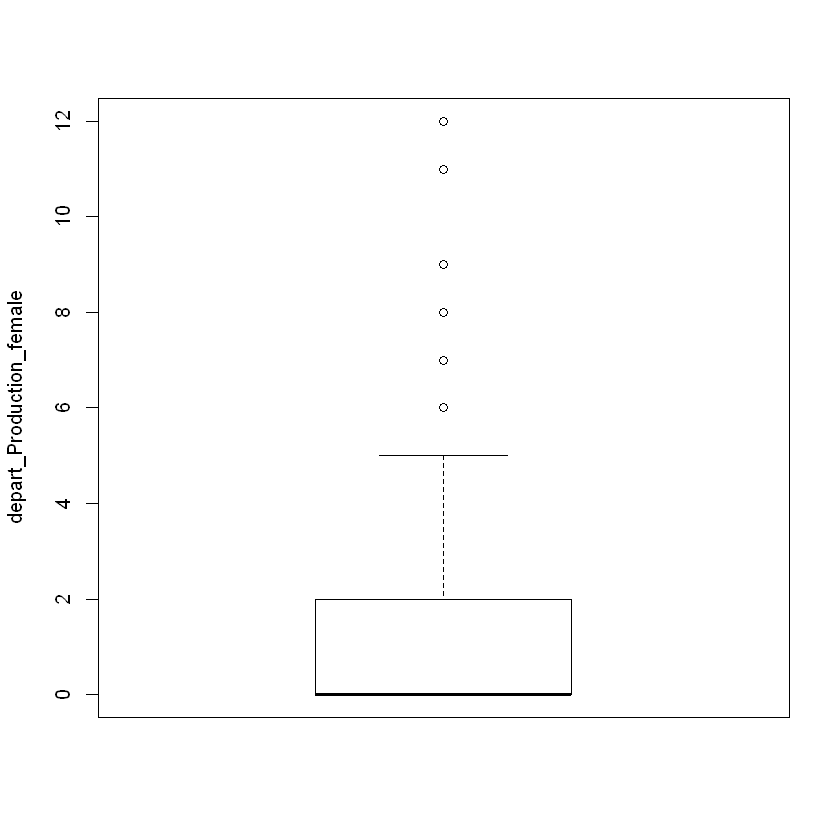

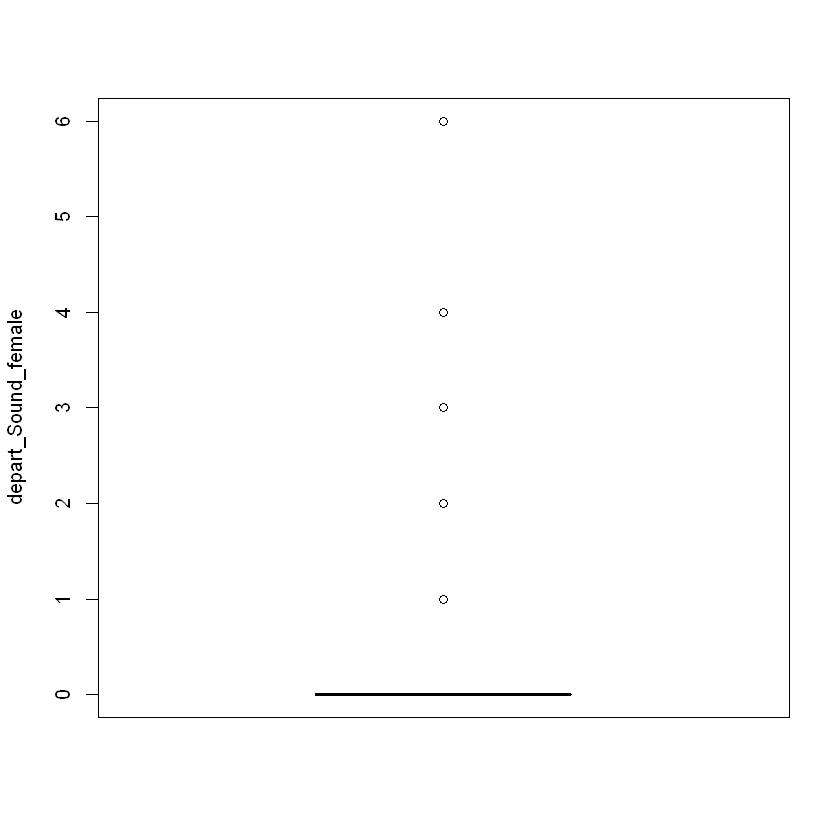

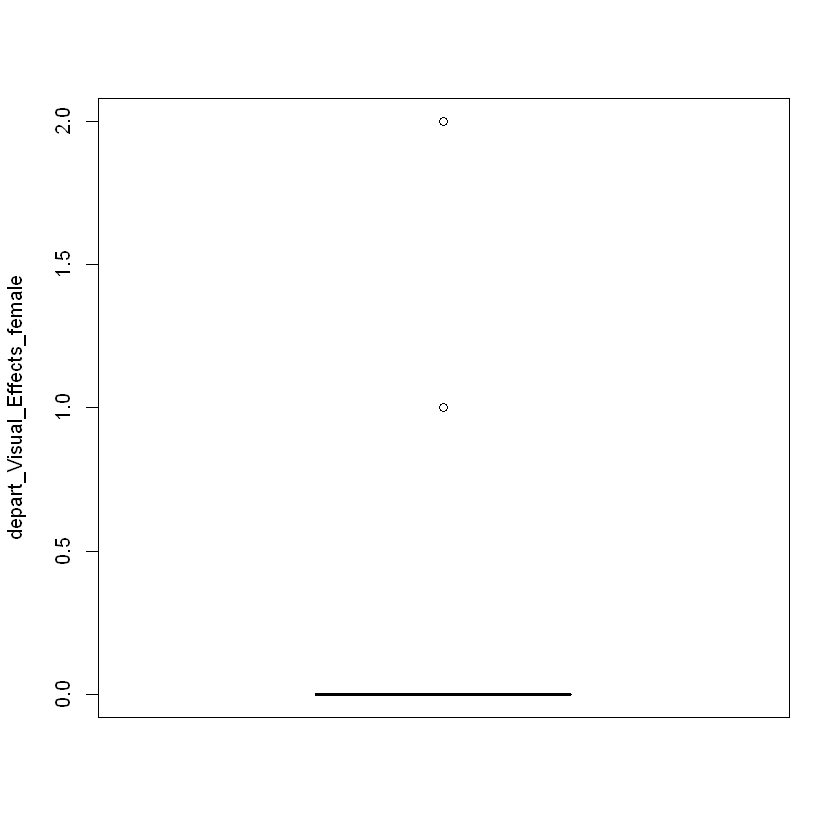

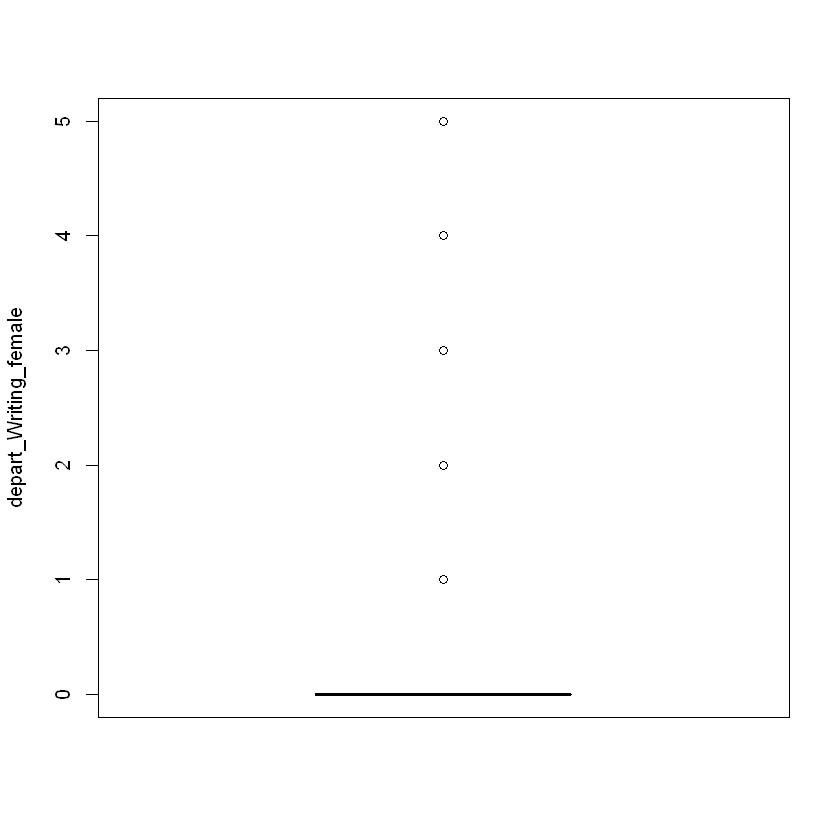

In [22]:
for (v in l){
    boxplot(movies_ff_v[[v]],ylab=v)
}

In [396]:
## because it's not logical for features runtime and budget to have the value 0 i convert it to NA
movies_ff_v$budget[movies_ff_v$budget==0] <- NA
movies_ff_v$runtime[movies_ff_v$runtime==0] <- NA

In [145]:
#question 2.6- description of the missing values
getMissingness(movies_ff_v)

[[1]]
                   var na.count rate
1              revenue     4382 59.4
2  actor2_prev_revenue     3423 46.4
3  actor1_prev_revenue     3201 43.4
4  actor0_prev_revenue     2752 37.3
5               budget     2012 27.3
6     sw_female_actor0      934 12.7
7       sw_male_actor0      934 12.7
8     sw_female_actor2      788 10.7
9       sw_male_actor2      788 10.7
10    sw_female_actor1      782 10.6

[[2]]
[1] "This dataset has 964 (13.1%) complete rows. Original data has 7375 rows."



$missingness
                            var na.count rate
1                       revenue     4382 59.4
2           actor2_prev_revenue     3423 46.4
3           actor1_prev_revenue     3201 43.4
4           actor0_prev_revenue     2752 37.3
5                        budget     2012 27.3
6              sw_female_actor0      934 12.7
7                sw_male_actor0      934 12.7
8              sw_female_actor2      788 10.7
9                sw_male_actor2      788 10.7
10             sw_female_actor1      782 10.6
11               sw_male_actor1      782 10.6
12                producers_cnt      395  5.4
13                   depart_Art       34  0.5
14                depart_Camera       34  0.5
15                  depart_Crew       34  0.5
16           depart_Custom_Mkup       34  0.5
17             depart_Directing       34  0.5
18               depart_Editing       34  0.5
19              depart_Lighting       34  0.5
20            depart_Production       34  0.5
21                 depart_Sound       34  0.5
22        depart_Visual_Effects       34  0.5
23               depart_Writing       34  0.5
24            depart_Art_female       34  0.5
25         depart_Camera_female       34  0.5
26           depart_Crew_female       34  0.5
27    depart_Custom_Mkup_female       34  0.5
28      depart_Directing_female       34  0.5
29        depart_Editing_female       34  0.5
30       depart_Lighting_female       34  0.5
31     depart_Production_female       34  0.5
32          depart_Sound_female       34  0.5
33 depart_Visual_Effects_female       34  0.5
34        depart_Writing_female       34  0.5
35                      runtime       24  0.3
36                 release_date        1  0.0
37                 release_year        1  0.0
38                release_month        1  0.0
39                  release_day        1  0.0
40                  seasonality        1  0.0

$message
[1] "This dataset has 964 (13.1%) complete rows. Original data has 7375 rows."

$rows
NULL

In [397]:
#question 2.7 matrix of missing values
movies.miss <- missingMatrix(movies_ff_v)
movies.miss 

budget original_language popularity release_date runtime runtime_cat
1    0      0                 0          0            0       0          
2    0      0                 0          0            0       0          
3    0      0                 0          0            0       0          
4    0      0                 0          0            0       0          
5    1      0                 0          0            0       0          
6    0      0                 0          0            0       0          
7    0      0                 0          0            0       0          
8    1      0                 0          0            0       0          
9    1      0                 0          0            0       0          
10   0      0                 0          0            0       0          
11   0      0                 0          0            0       0          
12   1      0                 0          0            0       0          
13   0      0                 0          0            0       0          
14   0      0                 0          0            0       0          
15   0      0                 0          0            0       0          
16   0      0                 0          0            0       0          
17   0      0                 0          0            0       0          
18   1      0                 0          0            0       0          
19   0      0                 0          0            0       0          
20   0      0                 0          0            0       0          
21   0      0                 0          0            0       0          
22   0      0                 0          0            0       0          
23   1      0                 0          0            0       0          
24   1      0                 0          0            0       0          
25   1      0                 0          0            0       0          
26   1      0                 0          0            0       0          
27   0      0                 0          0            0       0          
28   0      0                 0          0            0       0          
29   0      0                 0          0            0       0          
30   0      0                 0          0            0       0          
...  ...    ...               ...        ...          ...     ...        
7346 0      0                 0          0            0       0          
7347 0      0                 0          0            0       0          
7348 1      0                 0          0            0       0          
7349 0      0                 0          0            0       0          
7350 0      0                 0          0            0       0          
7351 0      0                 0          0            0       0          
7352 0      0                 0          0            0       0          
7353 1      0                 0          0            0       0          
7354 0      0                 0          0            0       0          
7355 0      0                 0          0            0       0          
7356 0      0                 0          0            0       0          
7357 1      0                 0          0            0       0          
7358 1      0                 0          0            0       0          
7359 0      0                 0          0            0       0          
7360 0      0                 0          0            0       0          
7361 0      0                 0          0            0       0          
7362 0      0                 0          0            0       0          
7363 0      0                 0          0            0       0          
7364 1      0                 0          0            0       0          
7365 1      0                 0          0            0       0          
7366 0      0                 0          0            0       0          
7367 1      0                 0          0            0       0          
7368 1   

Warning message:
"`cols` is now required.
Please use `cols = c(data)`"


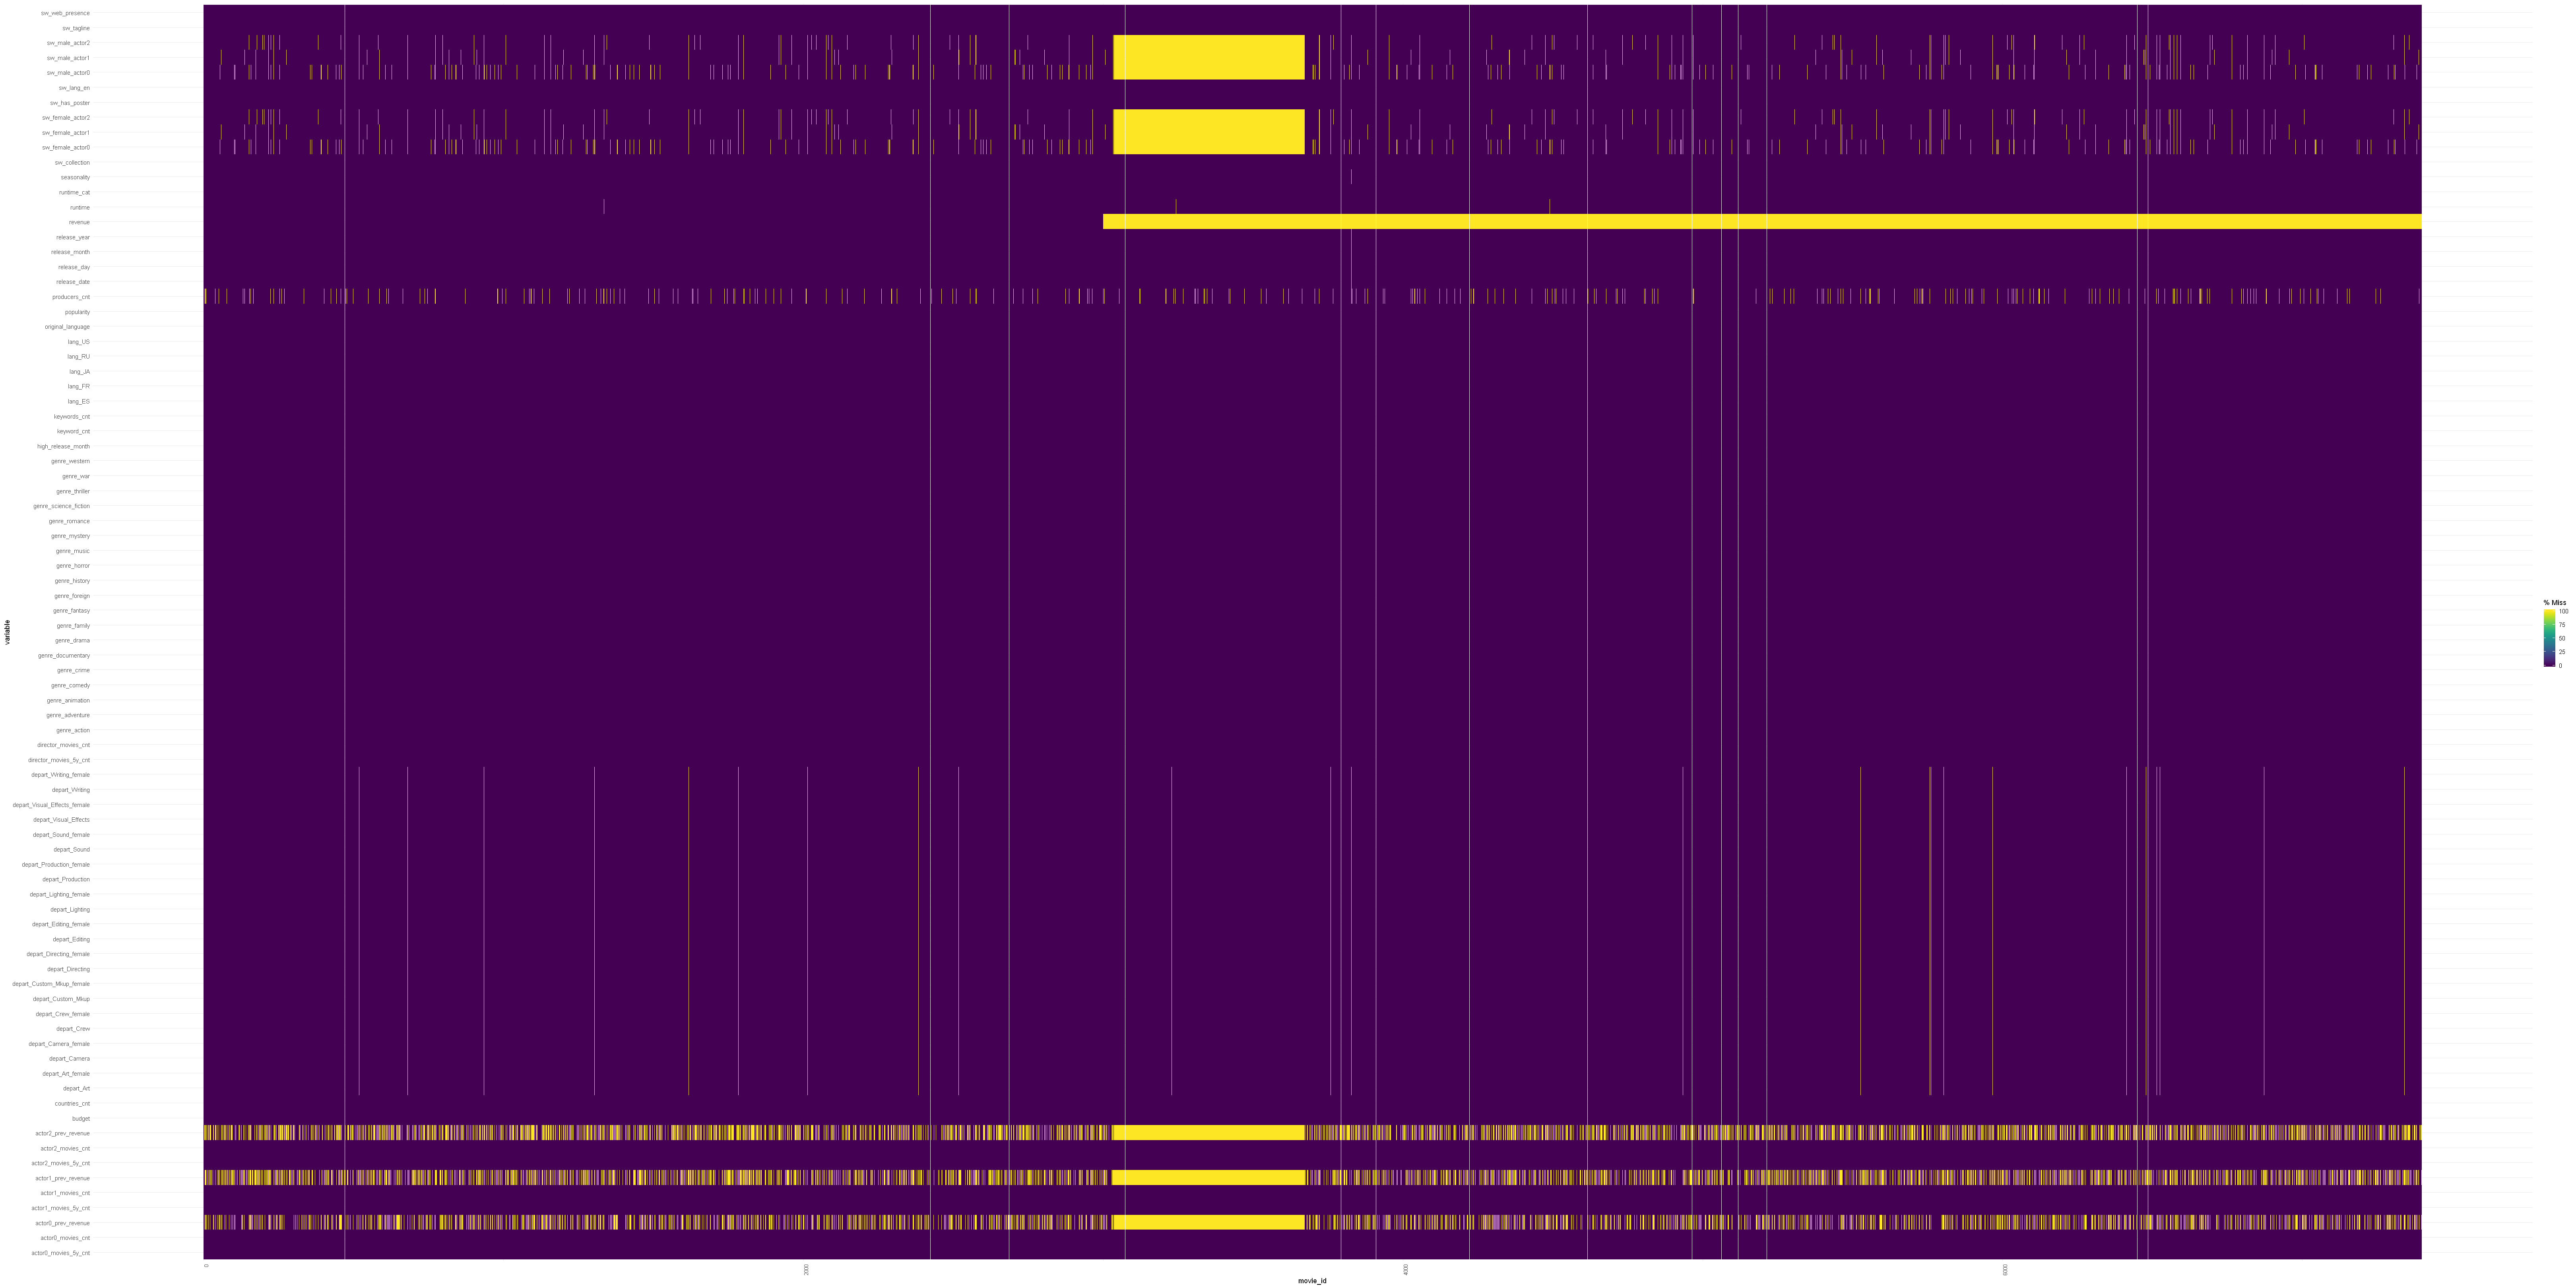

In [19]:
#heatmap of missing values
library(naniar)
options(repr.plot.width = 54, repr.plot.height = 27)
gg_miss_fct(x=movies_ff_v, fct=movie_id) + 
theme(axis.text.x = element_text(angle=90, size=8))

In [398]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]]) & (v!='revenue')) {
            med <- median(data[[v]],na.rm = TRUE)
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[paste(v,'out',sep='_')] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}

In [399]:
movies.out <- outlierMatrix(movies_ff_v)

In [400]:
movies.out <- movies.out[,2:81]
head(movies.out)

budget_out popularity_out runtime_out sw_lang_en_out sw_web_presence_out
1  0         0              0           0              0                  
2  0         0              0           0              0                  
3  0         1              0           0              0                  
4  0         0              0           1              0                  
5 NA         0              0           1              0                  
6  0         0              0           0              0                  
  sw_has_poster_out sw_tagline_out keyword_cnt_out release_year_out
1 0                 0              0               0               
2 0                 0              0               0               
3 0                 0              0               0               
4 0                 1              0               0               
5 0                 1              0               0               
6 0                 1              0               0               
  release_month_out ... depart_Camera_female_out depart_Crew_female_out
1 0                 ... 0                        0                     
2 0                 ... 0                        0                     
3 0                 ... 0                        1                     
4 0                 ... 0                        0                     
5 0                 ... 0                        0                     
6 0                 ... 0                        0                     
  depart_Custom_Mkup_female_out depart_Directing_female_out
1 0                             0                          
2 0                             0                          
3 0                             0                          
4 0                             0                          
5 0                             0                          
6 0                             0                          
  depart_Editing_female_out depart_Lighting_female_out
1 0                         0                         
2 0                         0                         
3 0                         0                         
4 0                         0                         
5 0                         0                         
6 0                         0                         
  depart_Production_female_out depart_Sound_female_out
1 0                            0                      
2 0                            0                      
3 0                            0                      
4 0                            0                      
5 0                            0                      
6 0                            0                      
  depart_Visual_Effects_female_out depart_Writing_female_out
1 0                                0                        
2 0                                1                        
3 0                                0                        
4 0                                0                        
5 0                                0                        
6 0                                0

In [401]:
for (v in names(movies.out))
    {factor (movies.out[[v]])}

In [402]:
movies.out$movie_id=movies_ff_v$movie_id


In [403]:
head(movies.out)

budget_out popularity_out runtime_out sw_lang_en_out sw_web_presence_out
1  0         0              0           0              0                  
2  0         0              0           0              0                  
3  0         1              0           0              0                  
4  0         0              0           1              0                  
5 NA         0              0           1              0                  
6  0         0              0           0              0                  
  sw_has_poster_out sw_tagline_out keyword_cnt_out release_year_out
1 0                 0              0               0               
2 0                 0              0               0               
3 0                 0              0               0               
4 0                 1              0               0               
5 0                 1              0               0               
6 0                 1              0               0               
  release_month_out ... depart_Crew_female_out depart_Custom_Mkup_female_out
1 0                 ... 0                      0                            
2 0                 ... 0                      0                            
3 0                 ... 1                      0                            
4 0                 ... 0                      0                            
5 0                 ... 0                      0                            
6 0                 ... 0                      0                            
  depart_Directing_female_out depart_Editing_female_out
1 0                           0                        
2 0                           0                        
3 0                           0                        
4 0                           0                        
5 0                           0                        
6 0                           0                        
  depart_Lighting_female_out depart_Production_female_out
1 0                          0                           
2 0                          0                           
3 0                          0                           
4 0                          0                           
5 0                          0                           
6 0                          0                           
  depart_Sound_female_out depart_Visual_Effects_female_out
1 0                       0                               
2 0                       0                               
3 0                       0                               
4 0                       0                               
5 0                       0                               
6 0                       0                               
  depart_Writing_female_out movie_id
1 0                         1       
2 1                         2       
3 0                         3       
4 0                         4       
5 0                         5       
6 0                         6

3.1.1 - For the variables where outliers were found, check the distribution with/without outliers

In [404]:
l<- l[c(1:3,5:41)]
length(l)
l

[1] 40

[1] "budget"                       "popularity"                  
 [3] "runtime"                      "keyword_cnt"                 
 [5] "sw_collection"                "producers_cnt"               
 [7] "countries_cnt"                "keywords_cnt"                
 [9] "actor0_movies_cnt"            "actor0_movies_5y_cnt"        
[11] "actor1_movies_cnt"            "actor1_movies_5y_cnt"        
[13] "actor2_movies_cnt"            "actor2_movies_5y_cnt"        
[15] "actor0_prev_revenue"          "actor1_prev_revenue"         
[17] "actor2_prev_revenue"          "director_movies_cnt"         
[19] "director_movies_5y_cnt"       "depart_Art"                  
[21] "depart_Camera"                "depart_Crew"                 
[23] "depart_Custom_Mkup"           "depart_Directing"            
[25] "depart_Editing"               "depart_Lighting"             
[27] "depart_Production"            "depart_Sound"                
[29] "depart_Visual_Effects"        "depart_Writing"              
[31] "depart_Art_female"            "depart_Camera_female"        
[33] "depart_Crew_female"           "depart_Custom_Mkup_female"   
[35] "depart_Directing_female"      "depart_Editing_female"       
[37] "depart_Production_female"     "depart_Sound_female"         
[39] "depart_Visual_Effects_female" "depart_Writing_female"

Joining, by = c("budget", "outliers")
Warning message:
"Removed 2012 rows containing non-finite values (stat_density)."
Joining, by = c("popularity", "outliers")
Joining, by = c("runtime", "outliers")


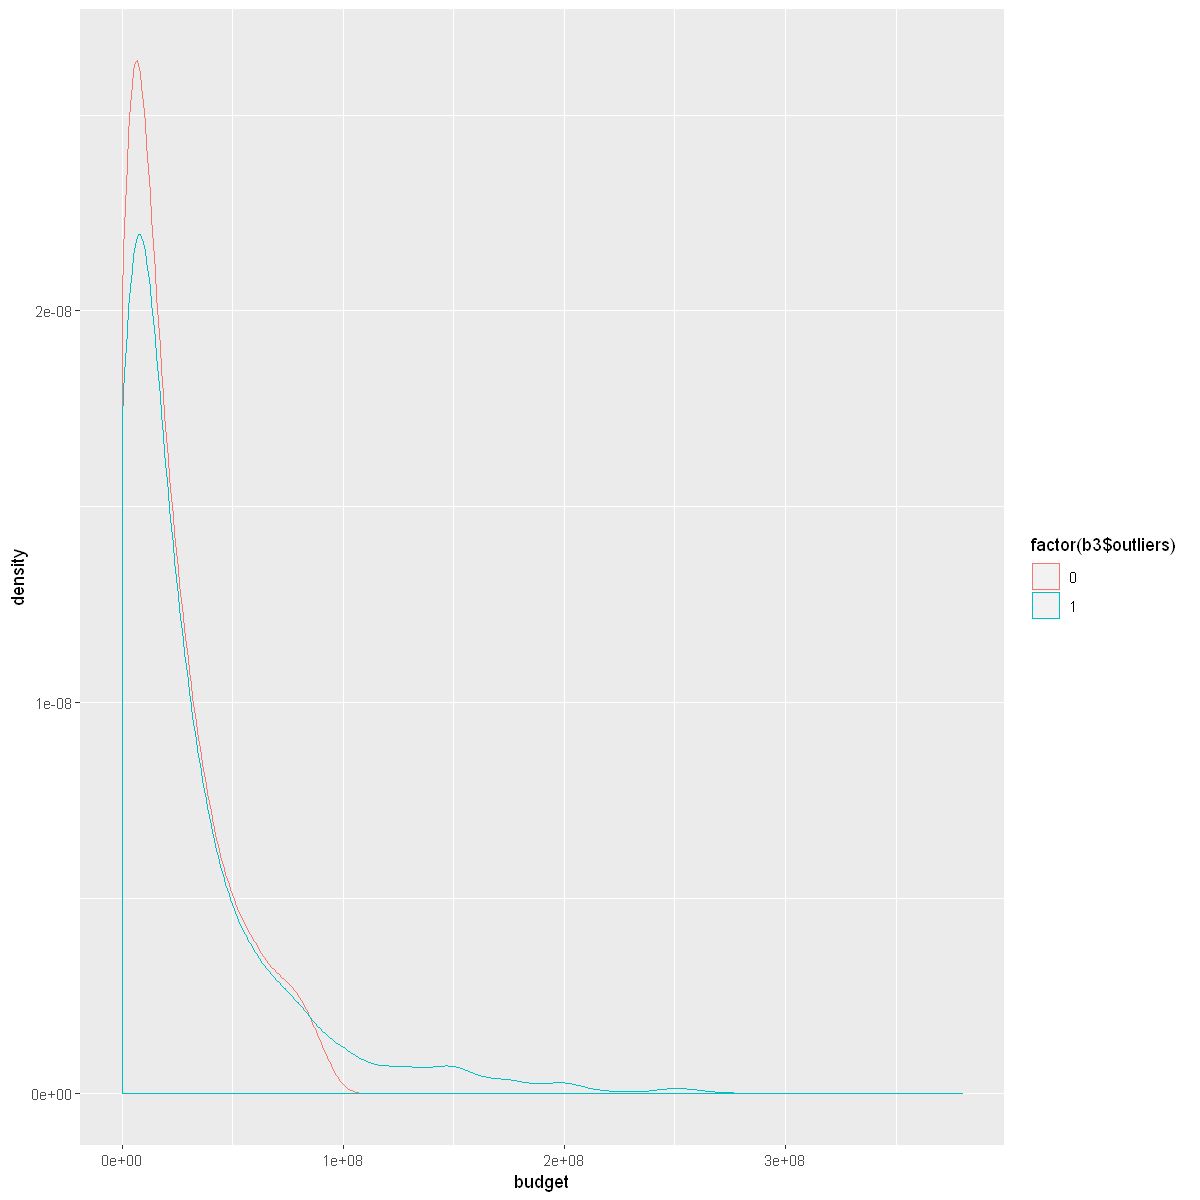

Warning message:
"Removed 24 rows containing non-finite values (stat_density)."
Joining, by = c("sw_collection", "outliers")


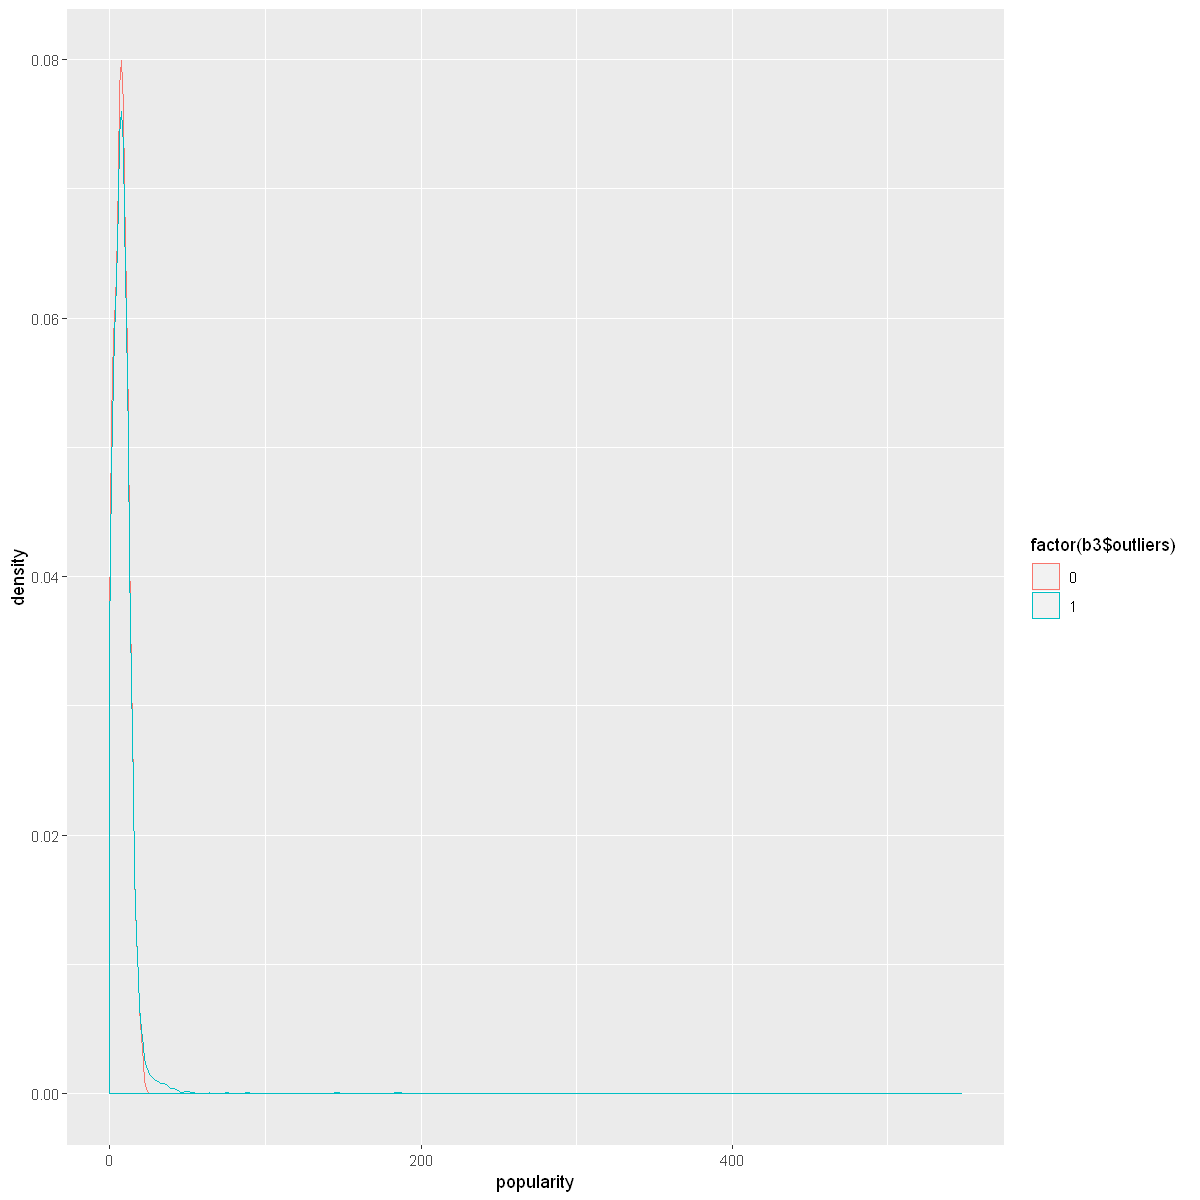

Joining, by = c("producers_cnt", "outliers")


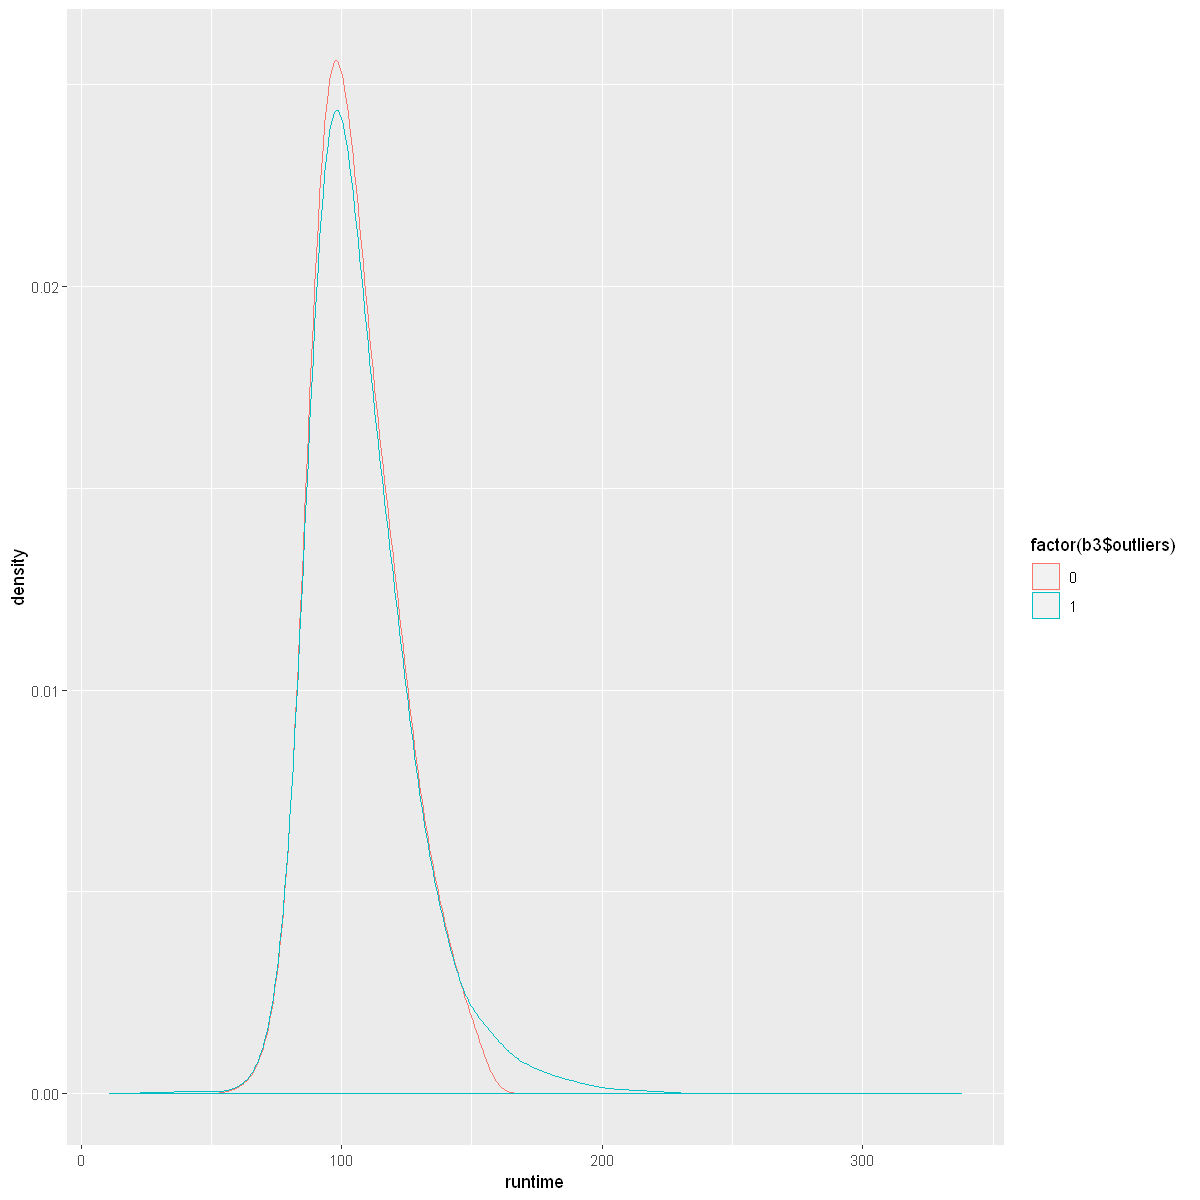

Warning message:
"Removed 395 rows containing non-finite values (stat_density)."
Joining, by = c("countries_cnt", "outliers")


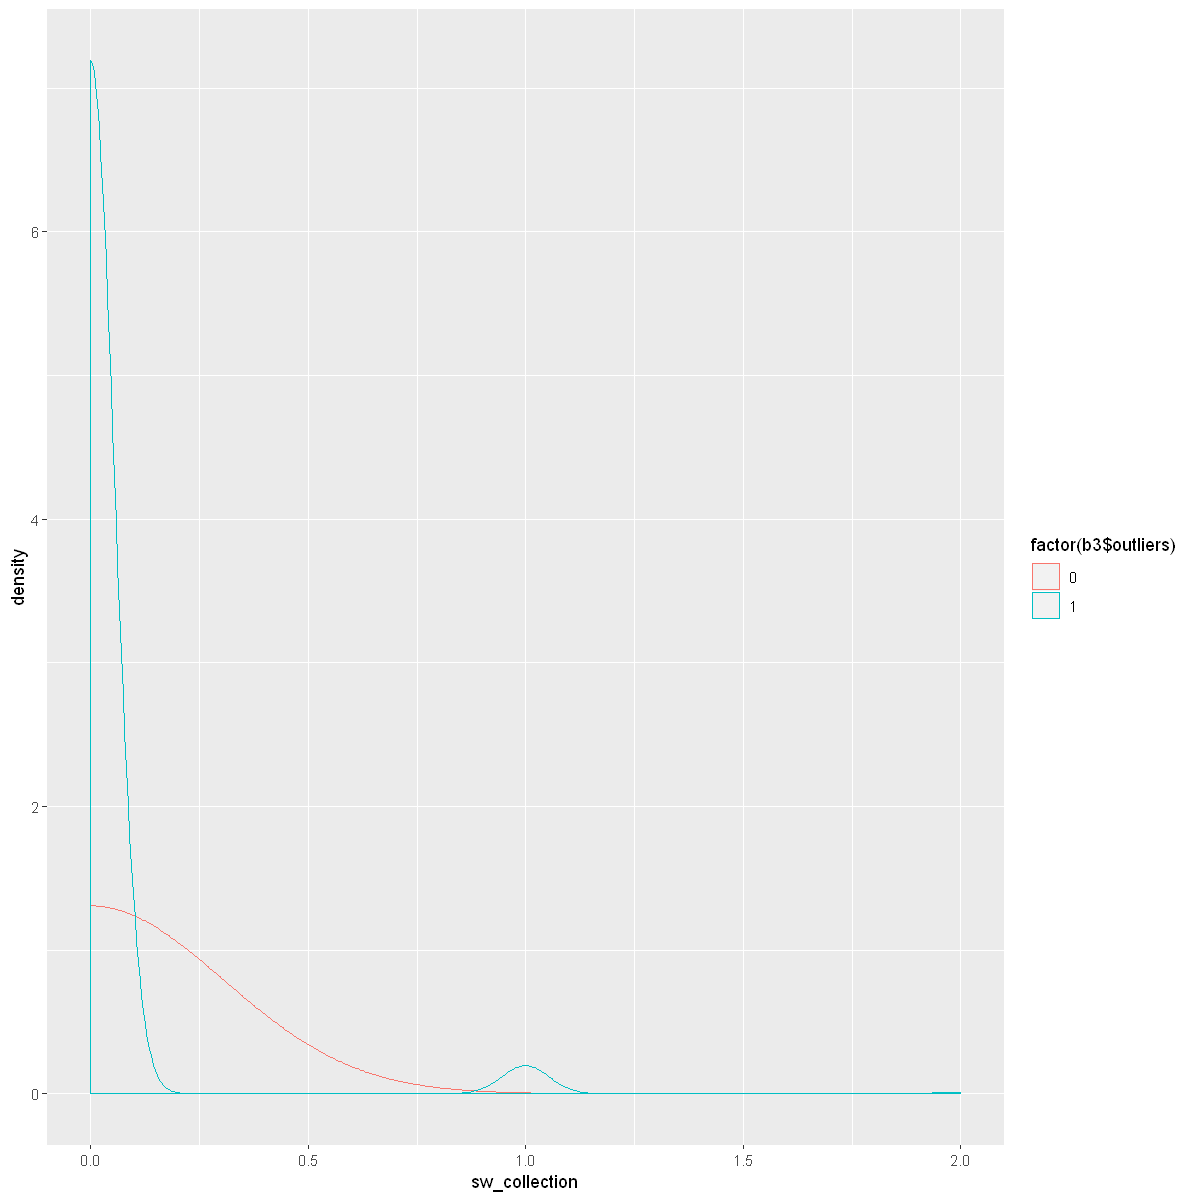

Joining, by = c("keywords_cnt", "outliers")


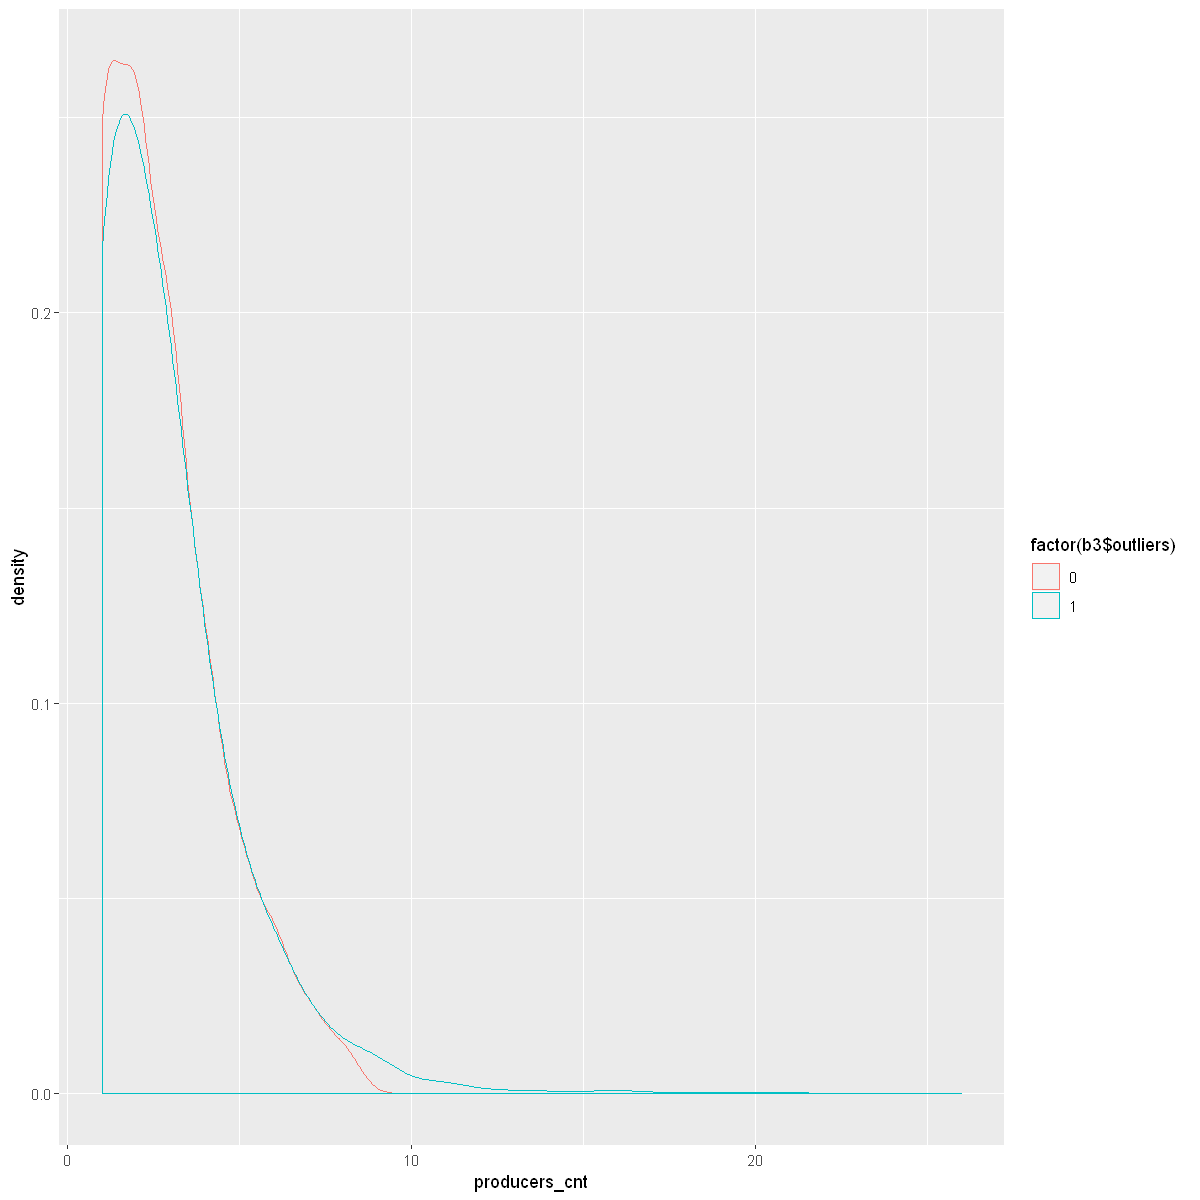

Joining, by = c("actor0_movies_cnt", "outliers")


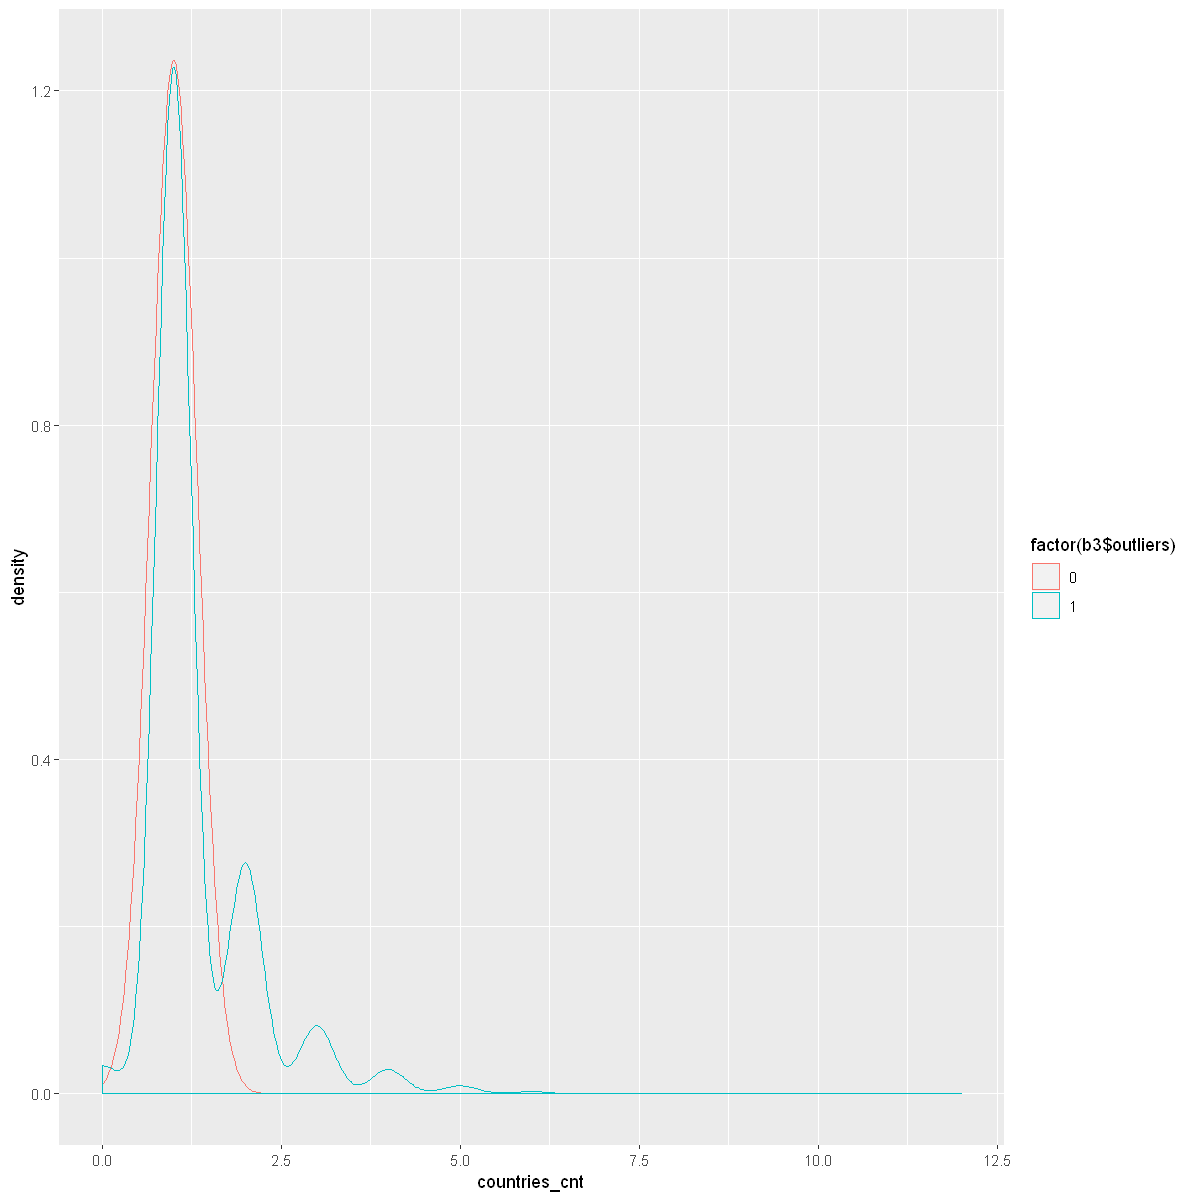

Joining, by = c("actor0_movies_5y_cnt", "outliers")


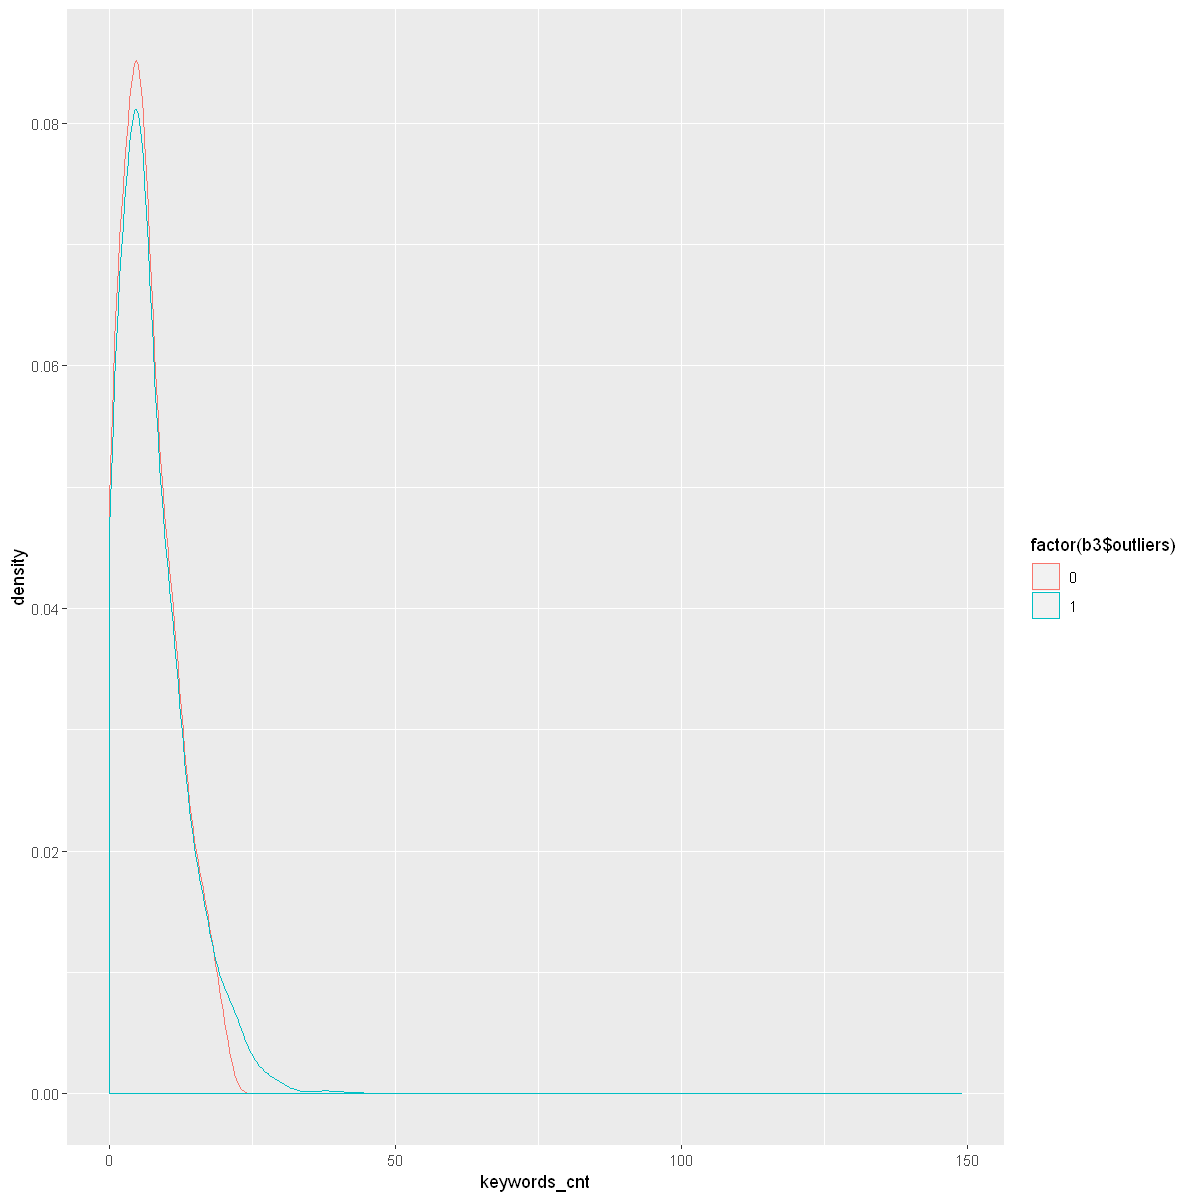

Joining, by = c("actor1_movies_cnt", "outliers")


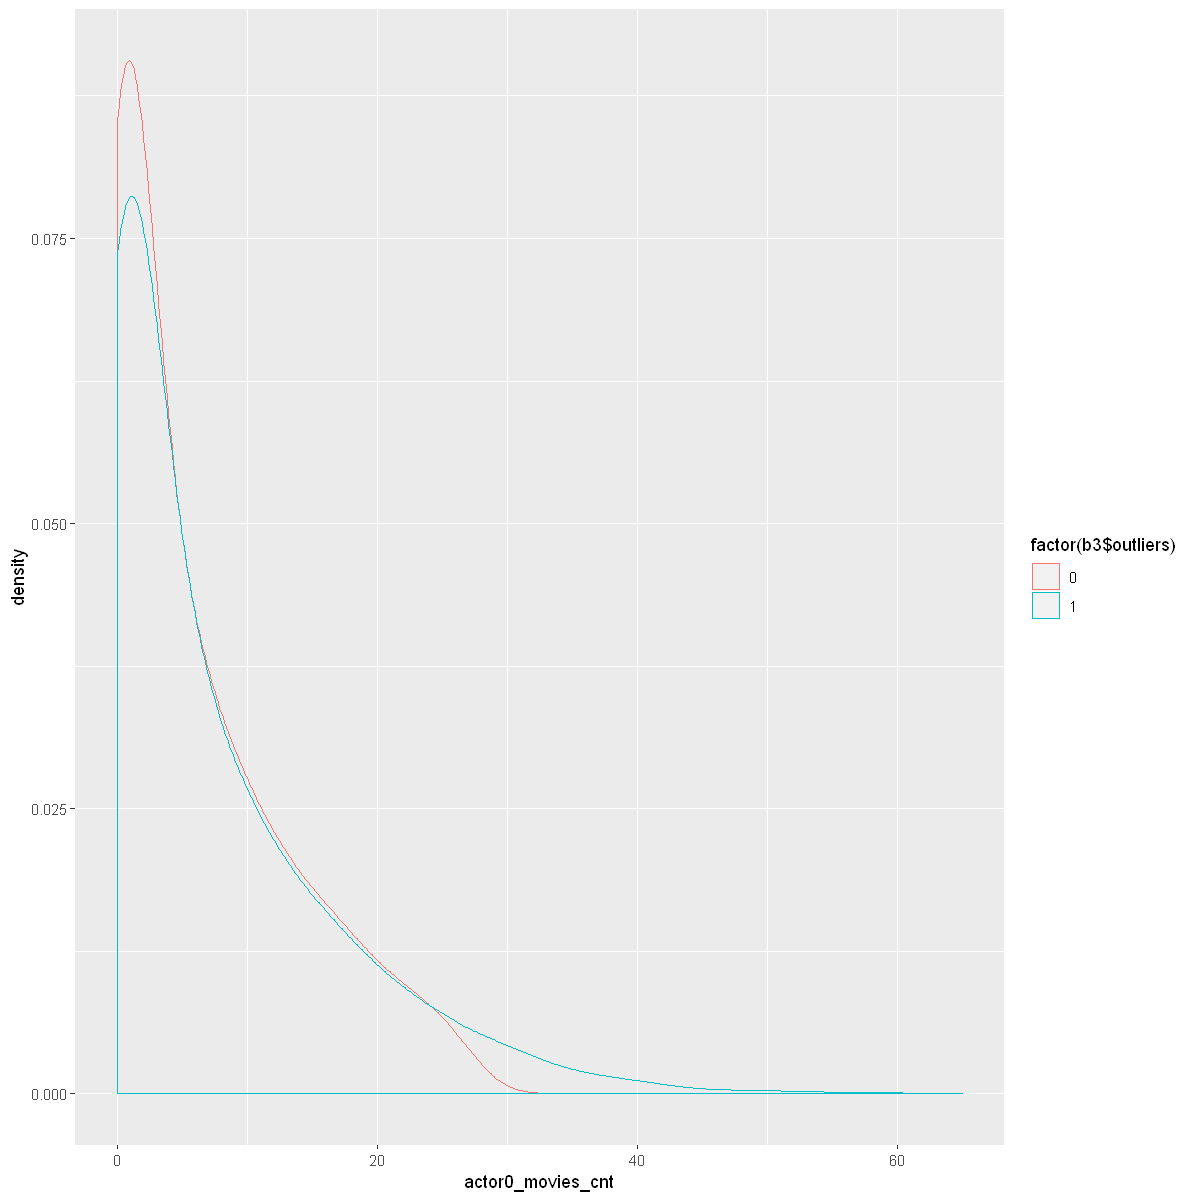

Joining, by = c("actor1_movies_5y_cnt", "outliers")


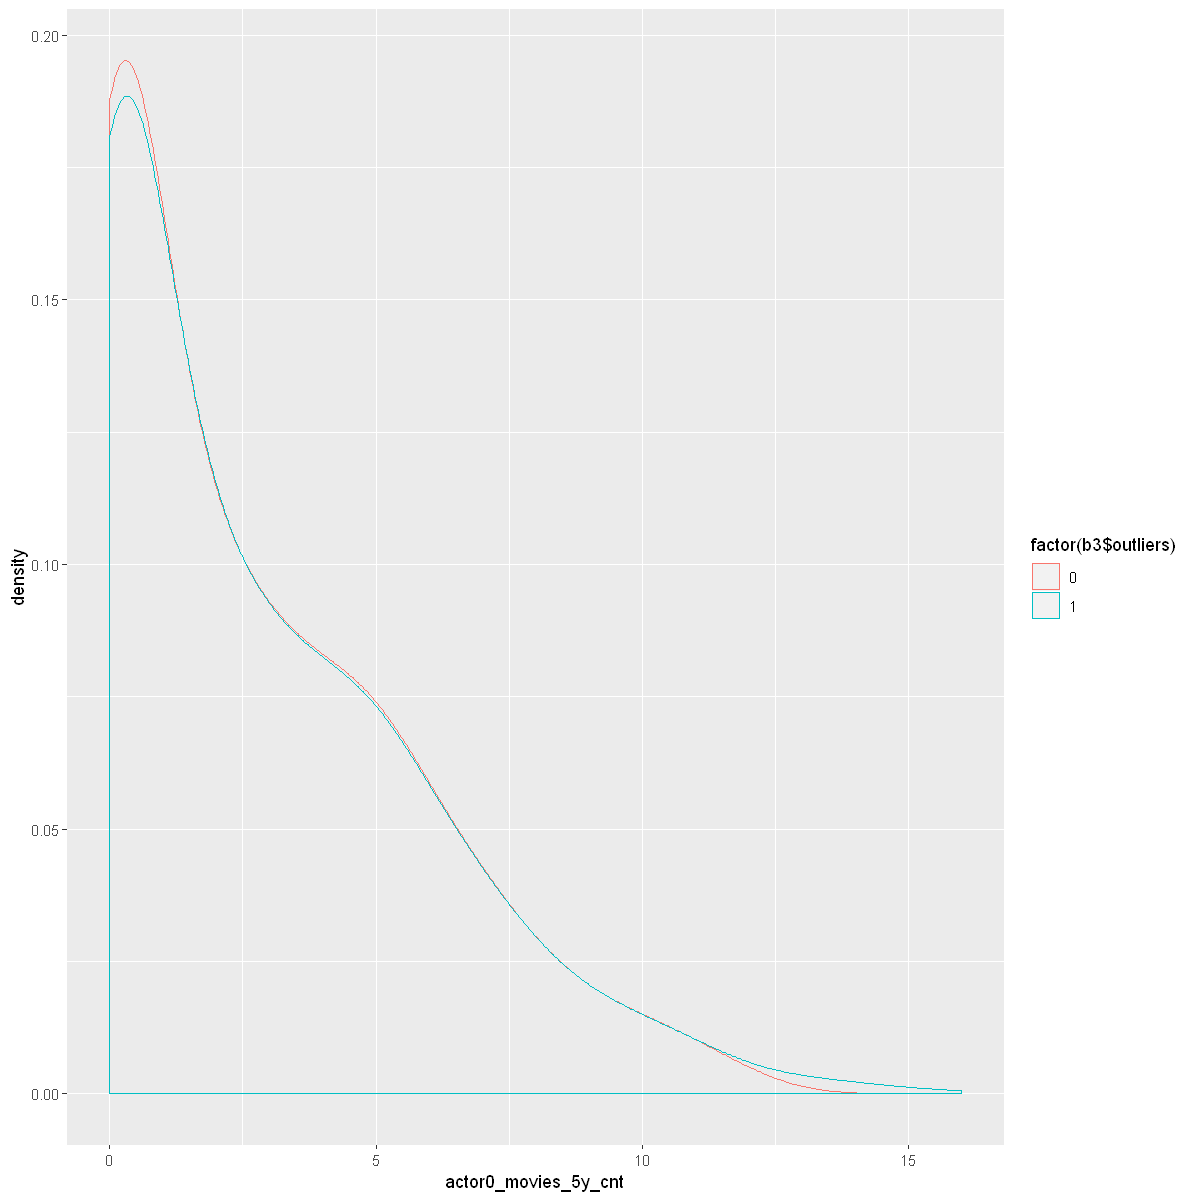

Joining, by = c("actor2_movies_cnt", "outliers")


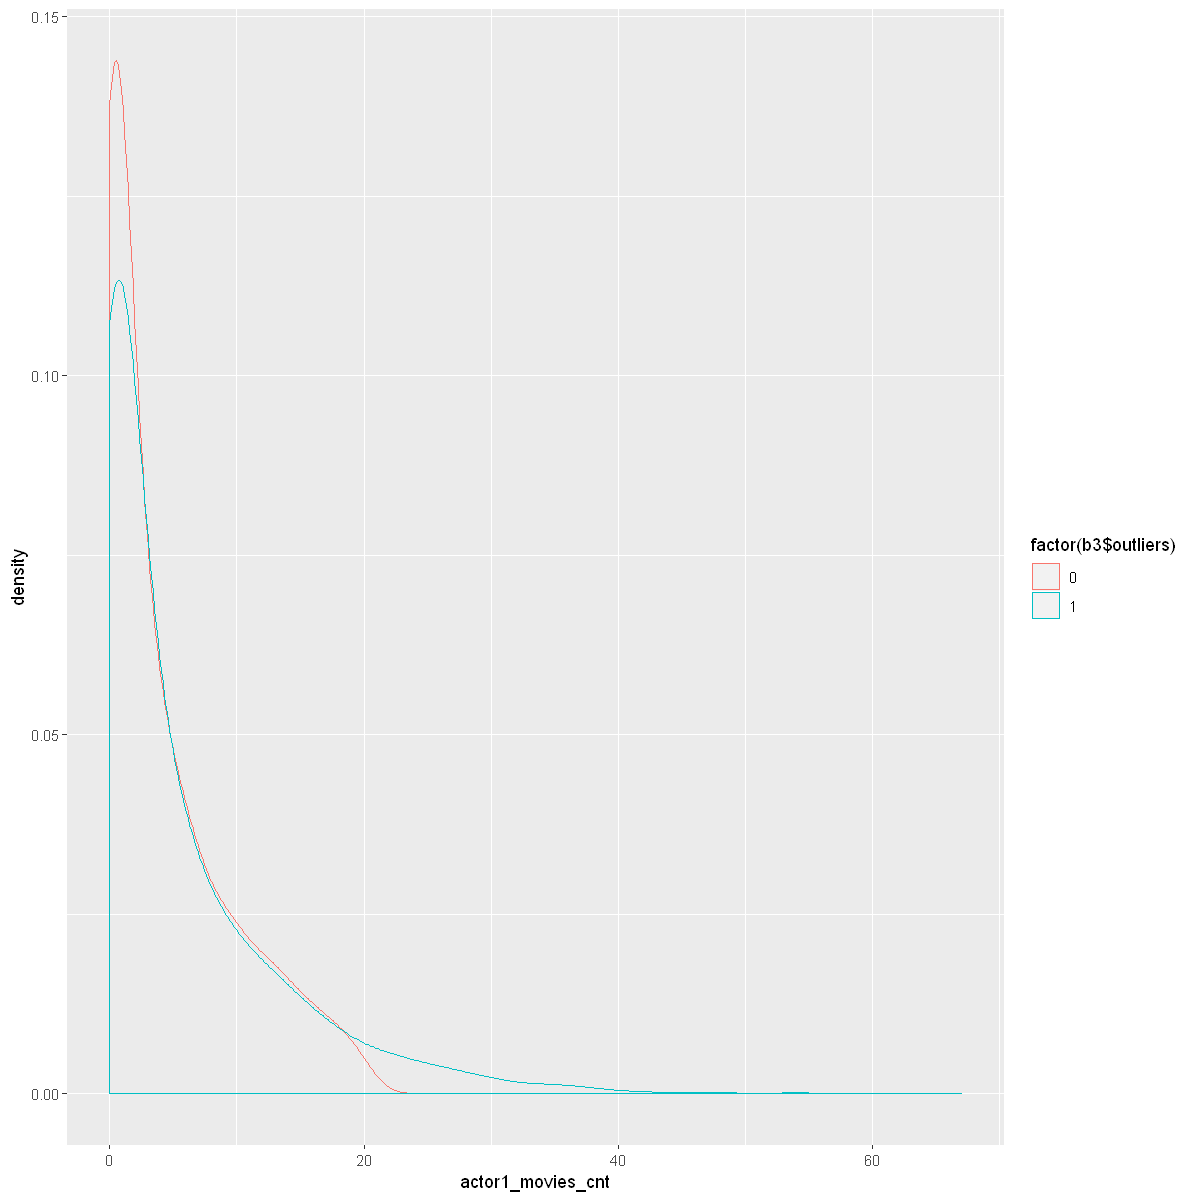

Joining, by = c("actor2_movies_5y_cnt", "outliers")


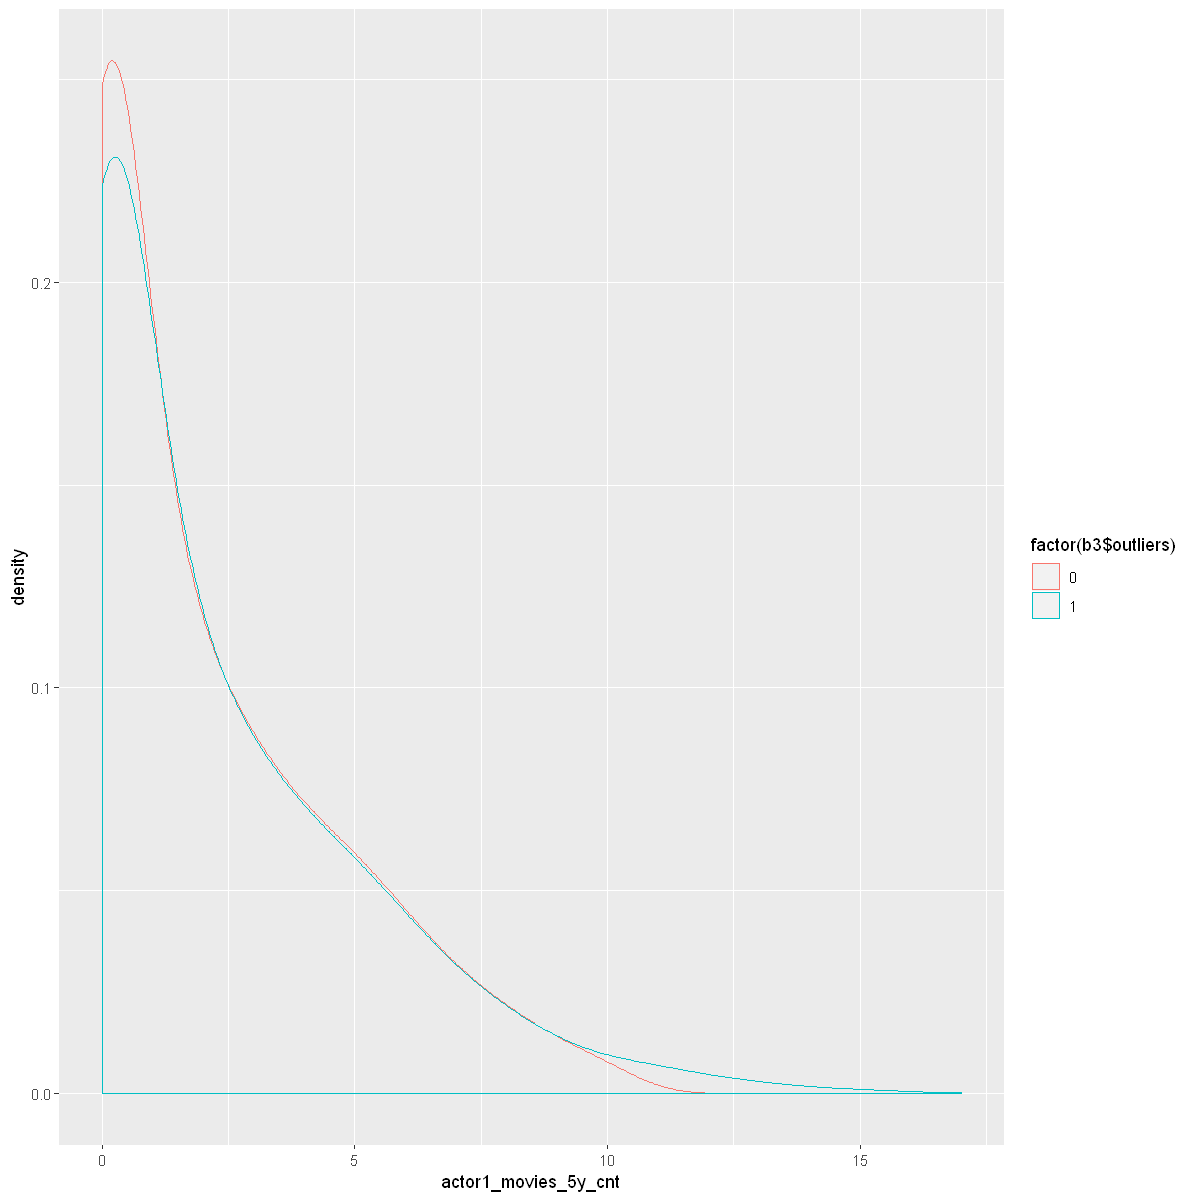

Joining, by = c("actor0_prev_revenue", "outliers")


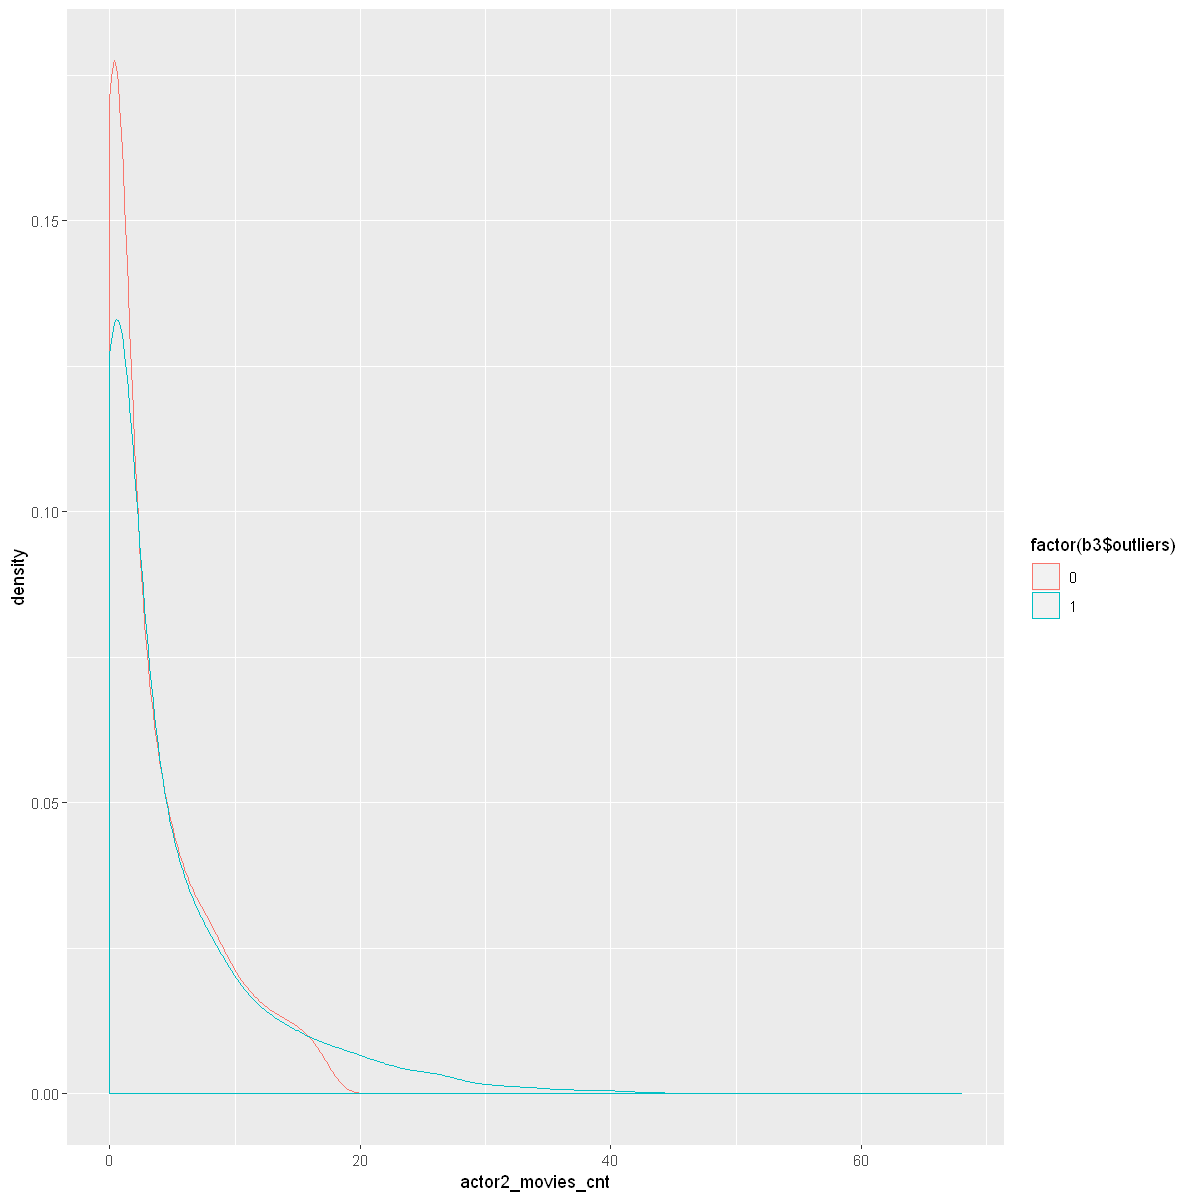

Warning message:
"Removed 2752 rows containing non-finite values (stat_density)."
Joining, by = c("actor1_prev_revenue", "outliers")


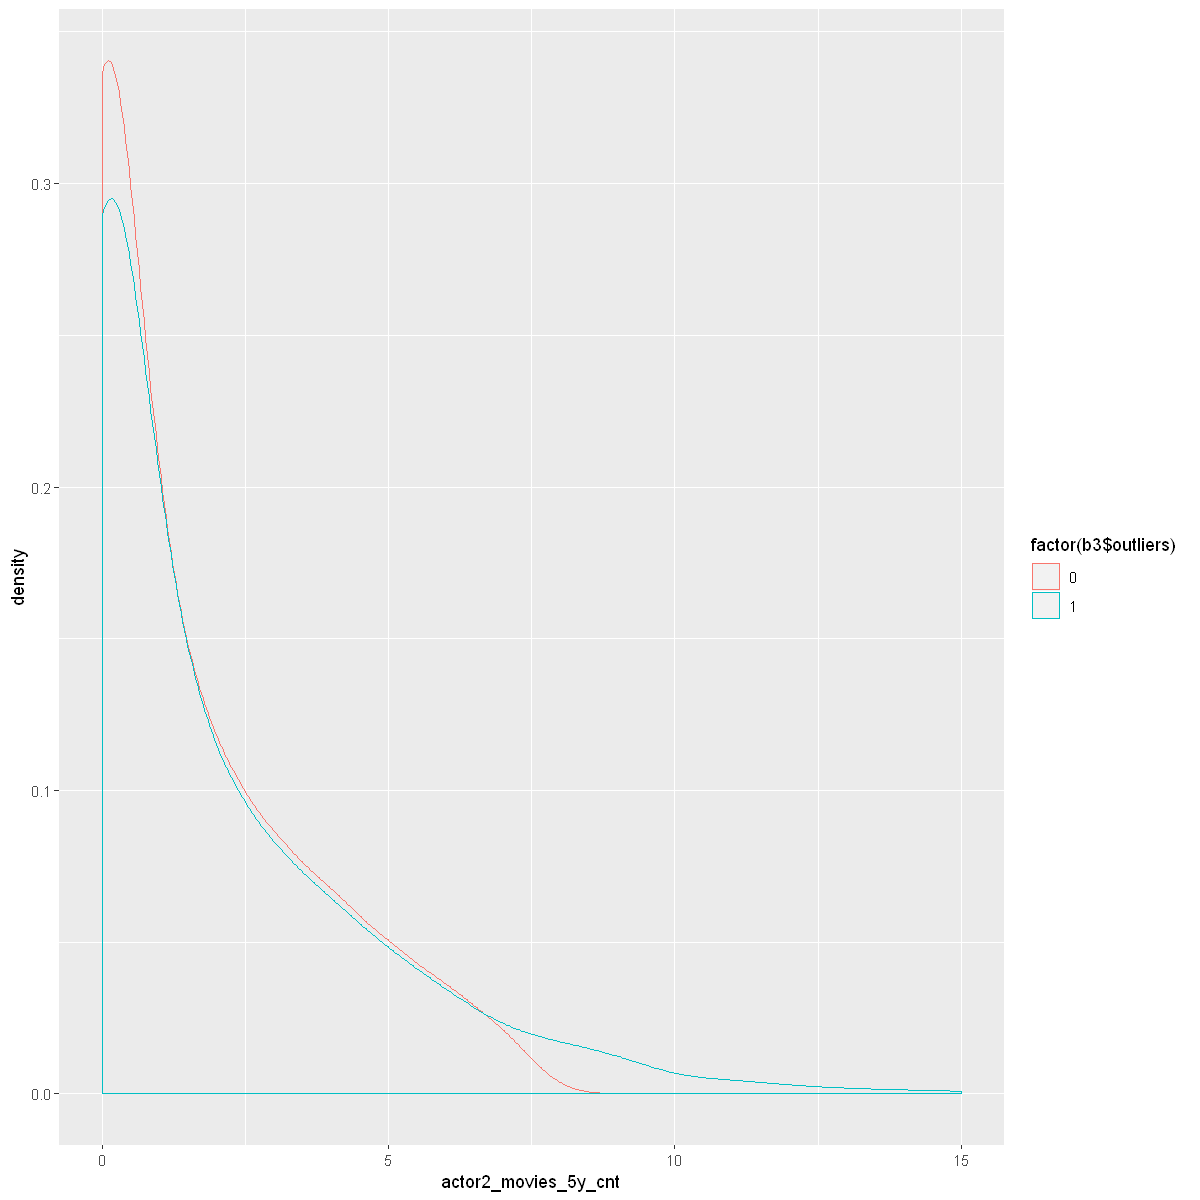

Warning message:
"Removed 3201 rows containing non-finite values (stat_density)."
Joining, by = c("actor2_prev_revenue", "outliers")


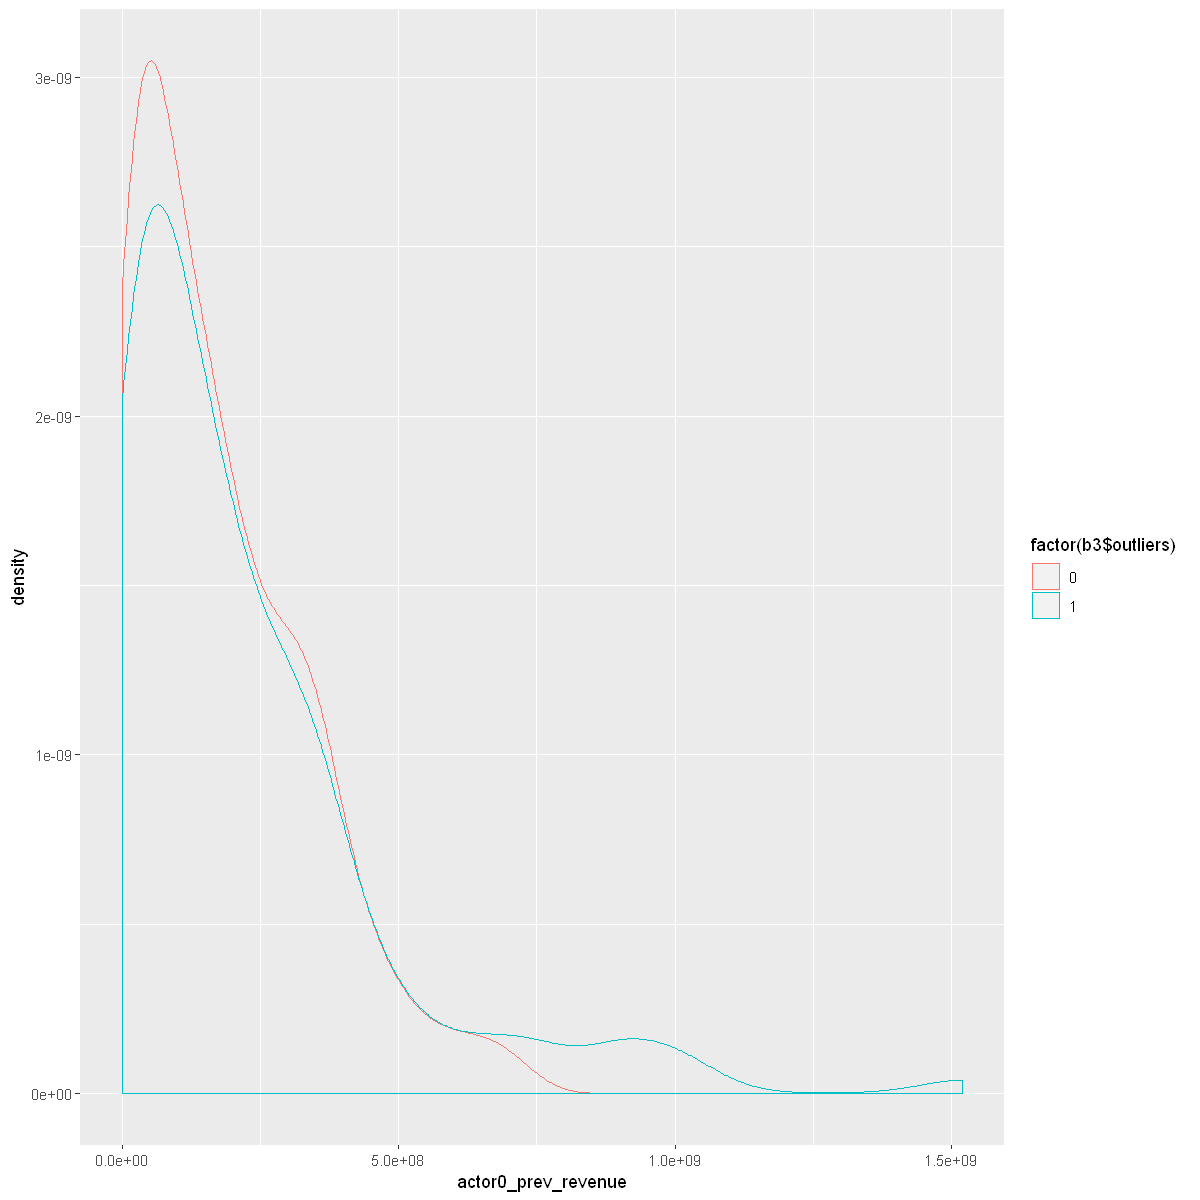

Warning message:
"Removed 3423 rows containing non-finite values (stat_density)."
Joining, by = c("director_movies_cnt", "outliers")


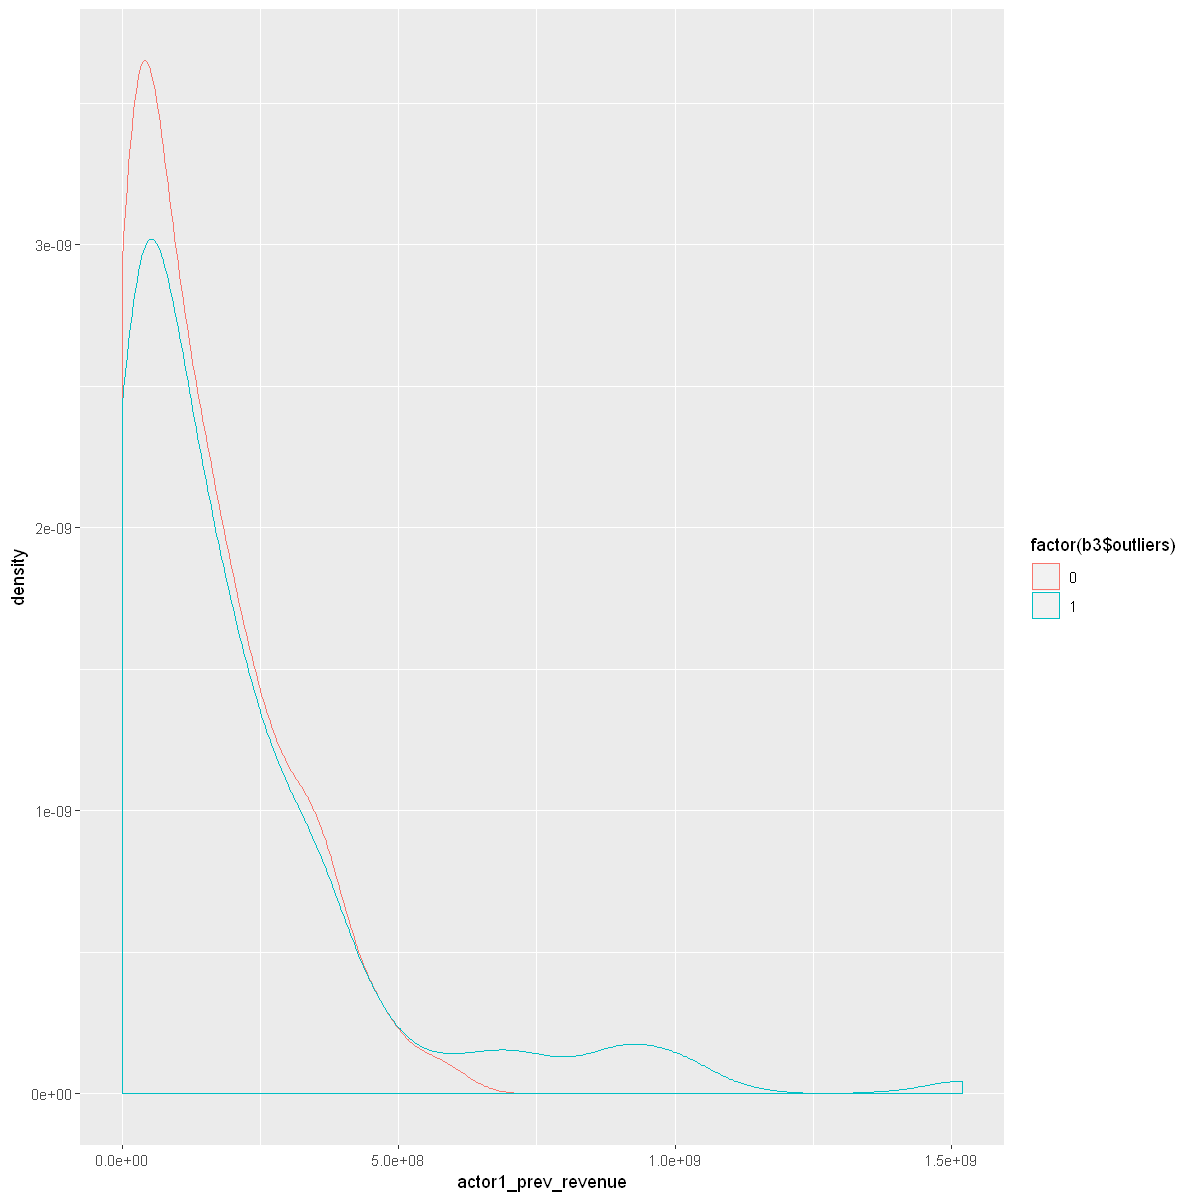

Joining, by = c("director_movies_5y_cnt", "outliers")


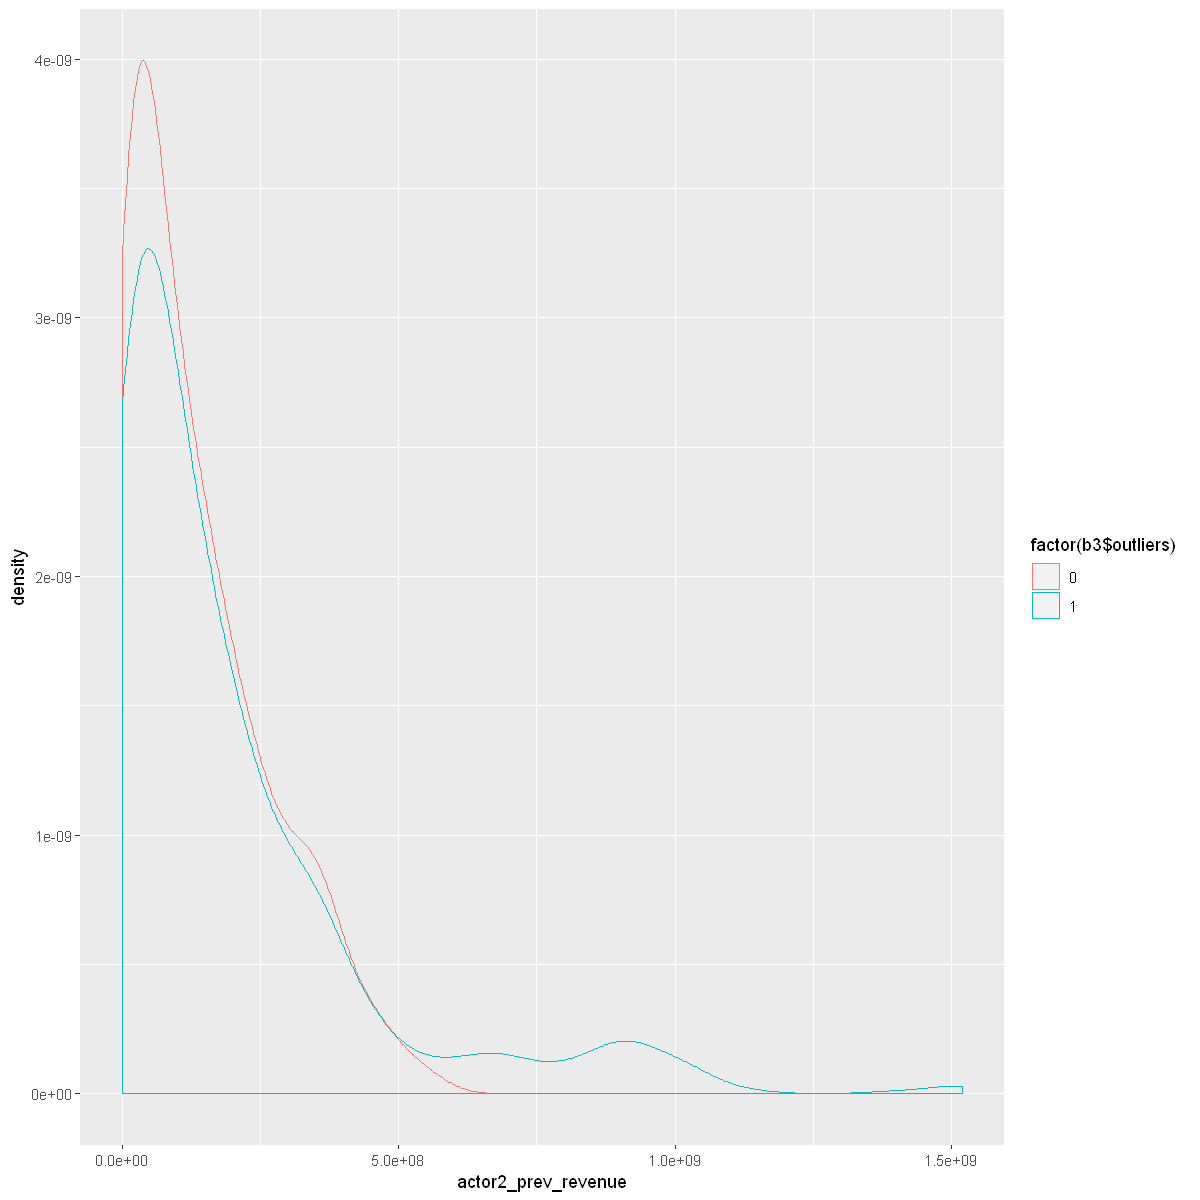

Joining, by = c("depart_Art", "outliers")


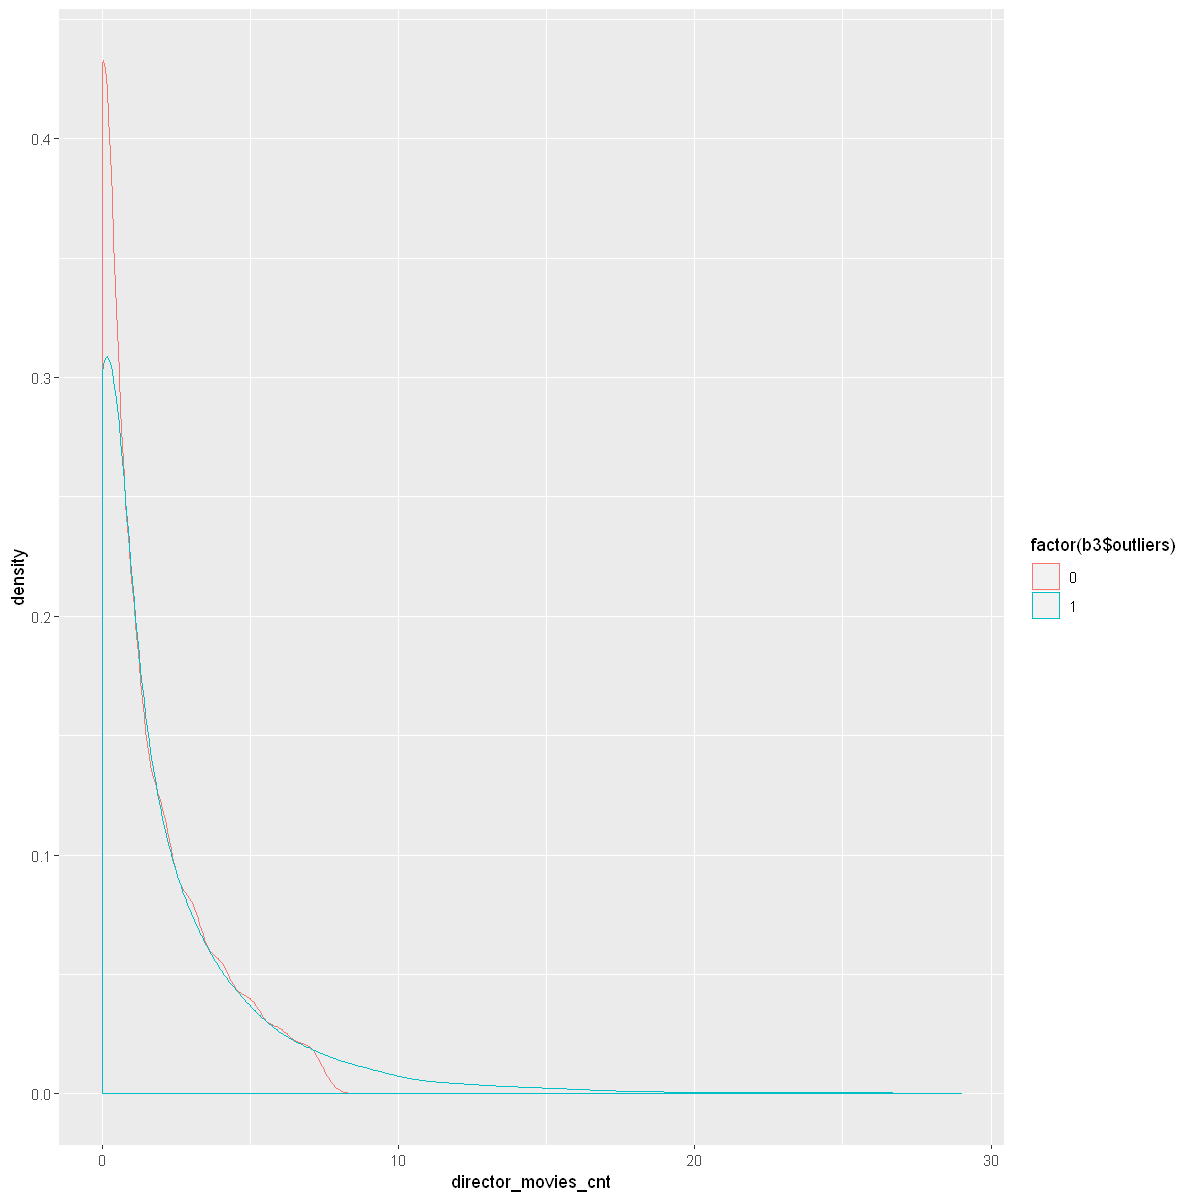

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Camera", "outliers")


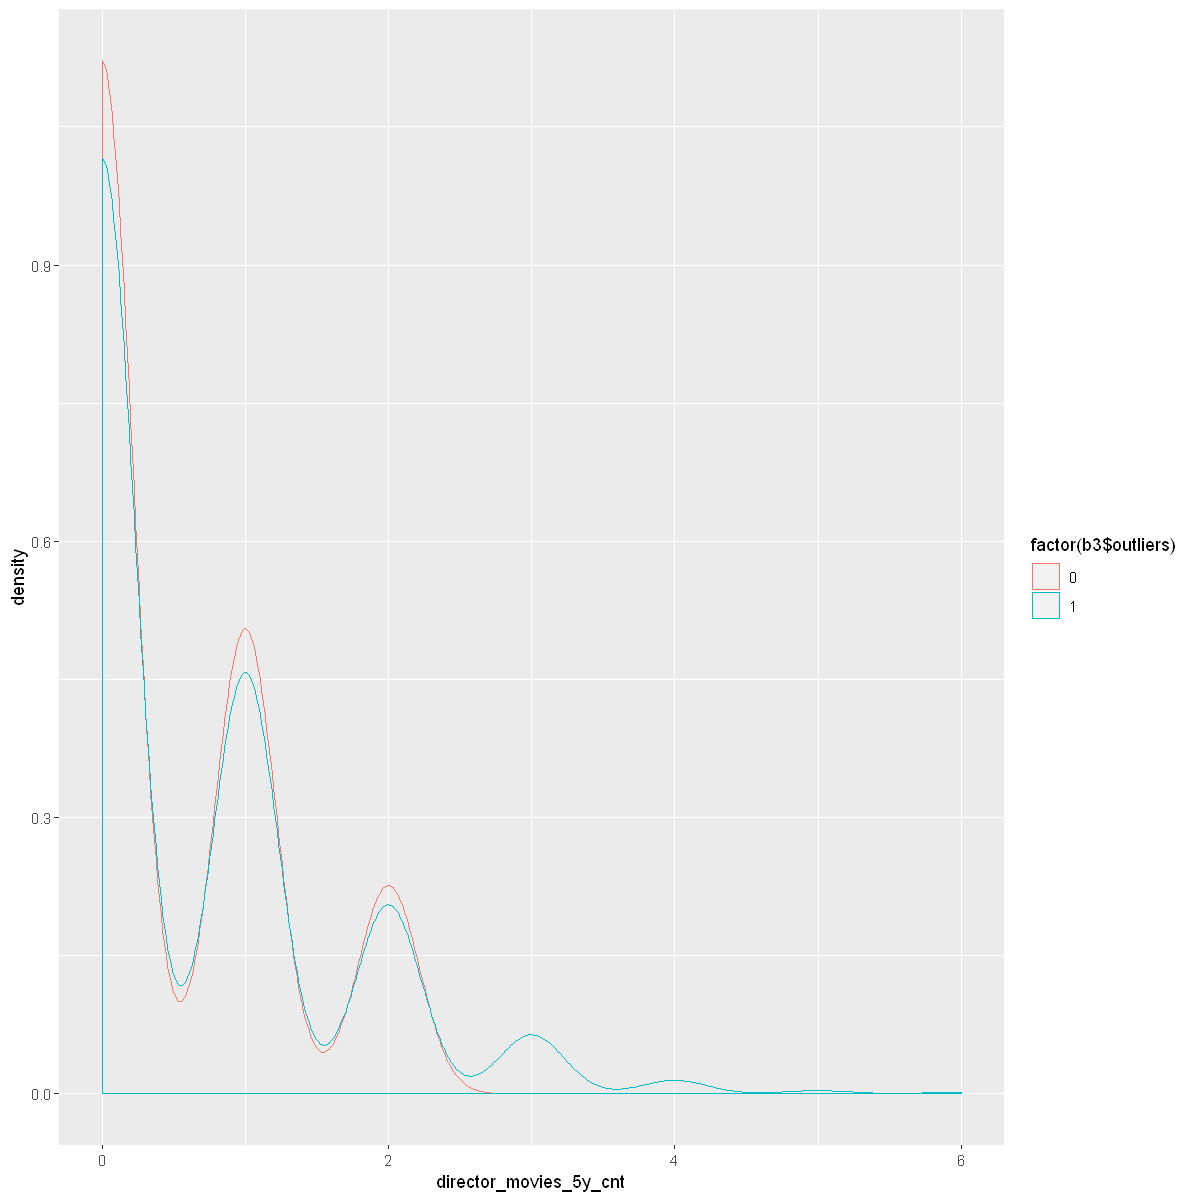

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Crew", "outliers")


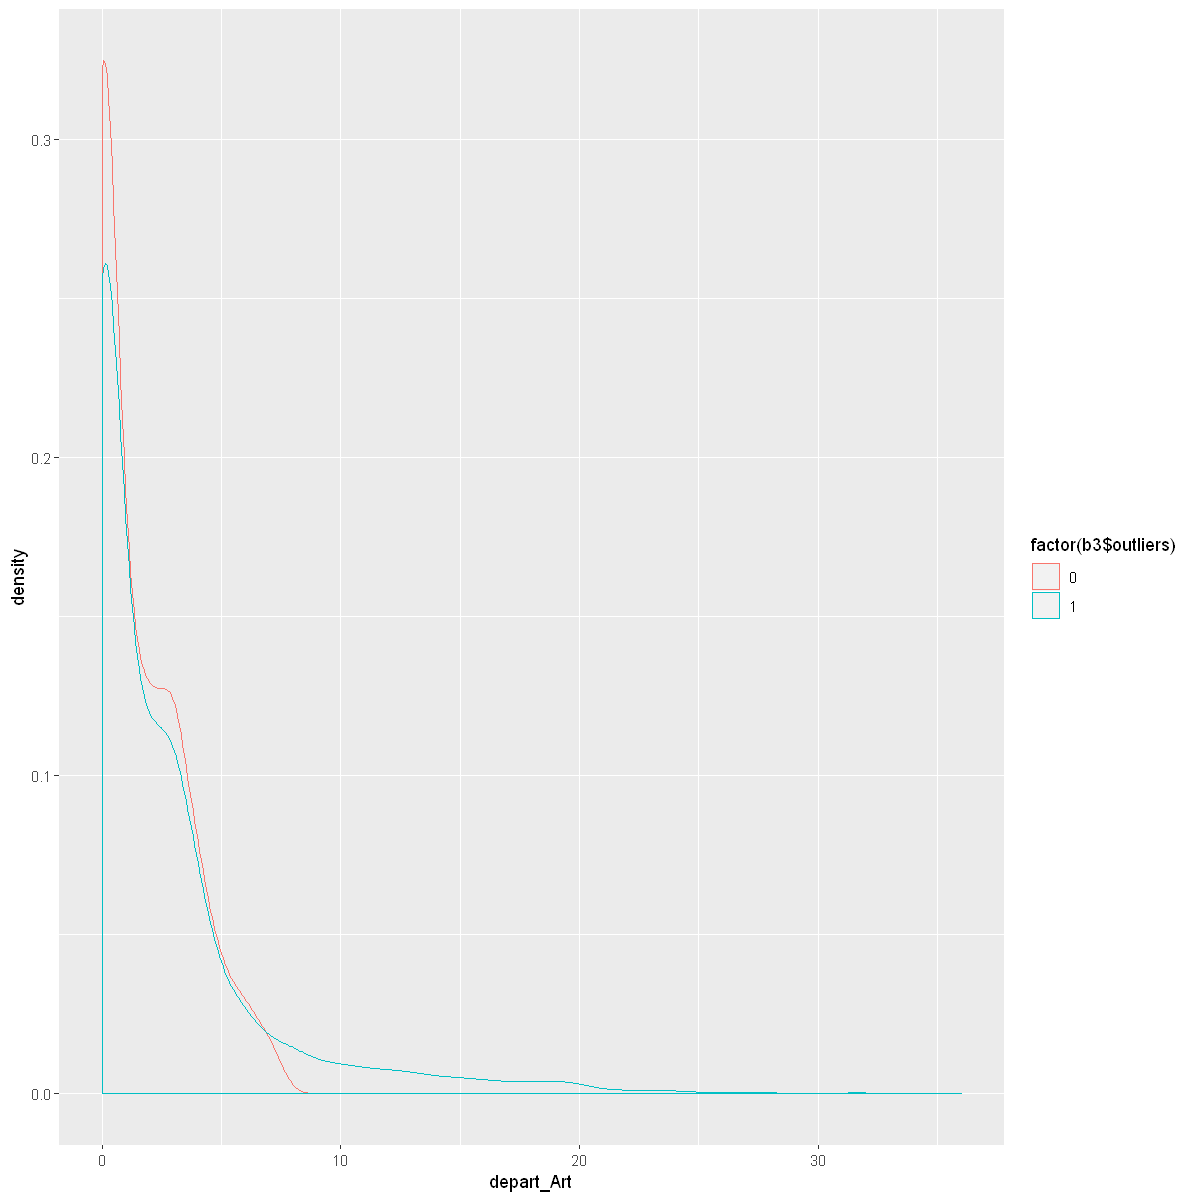

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Custom_Mkup", "outliers")


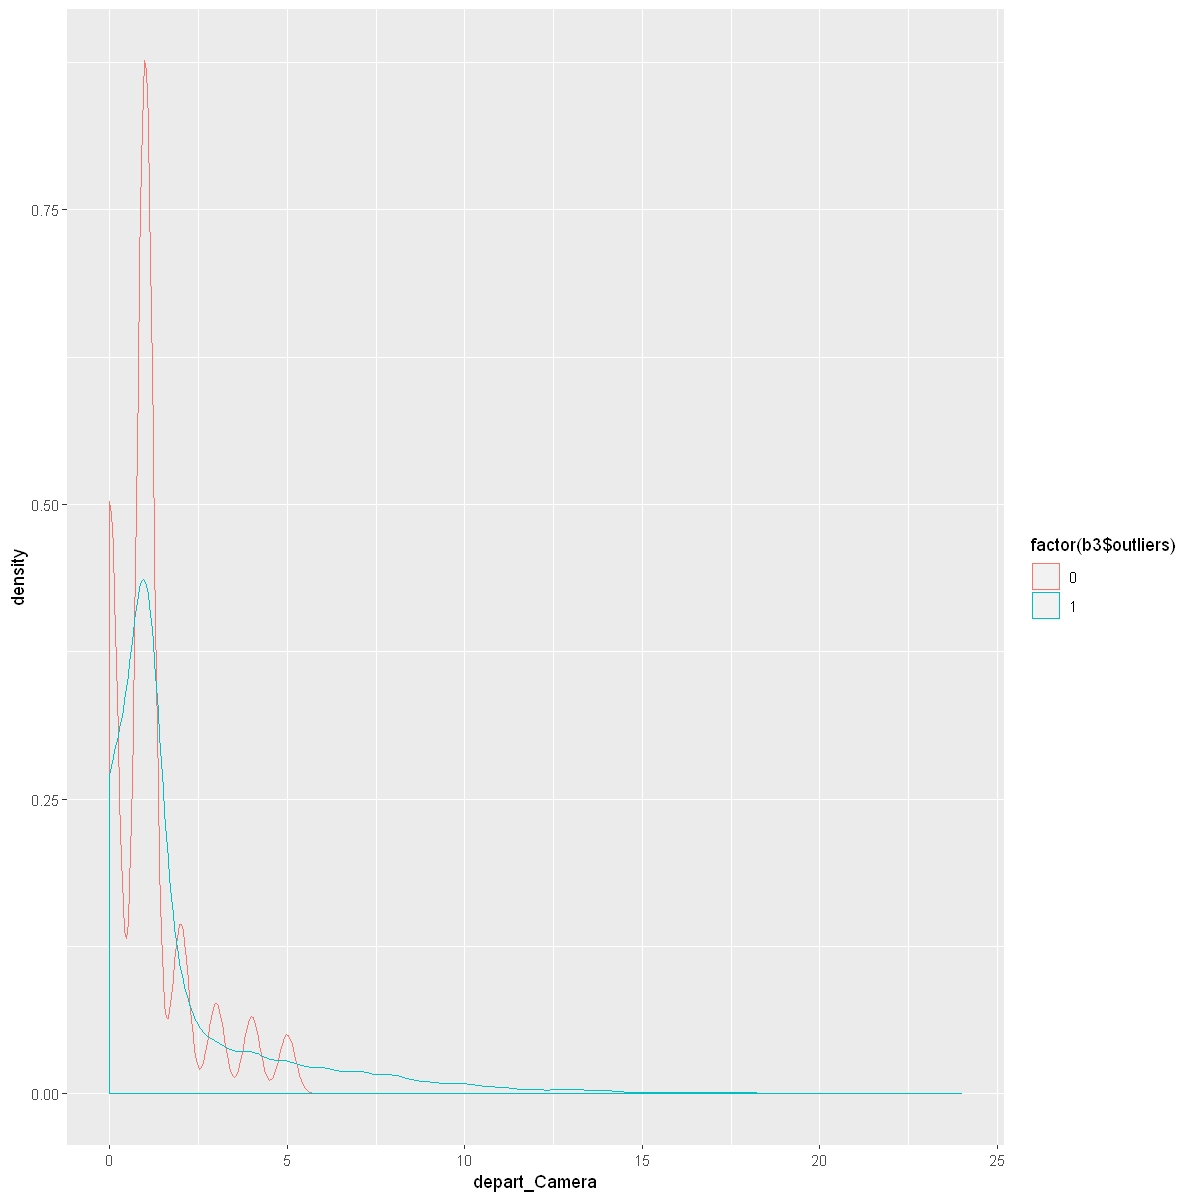

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Directing", "outliers")


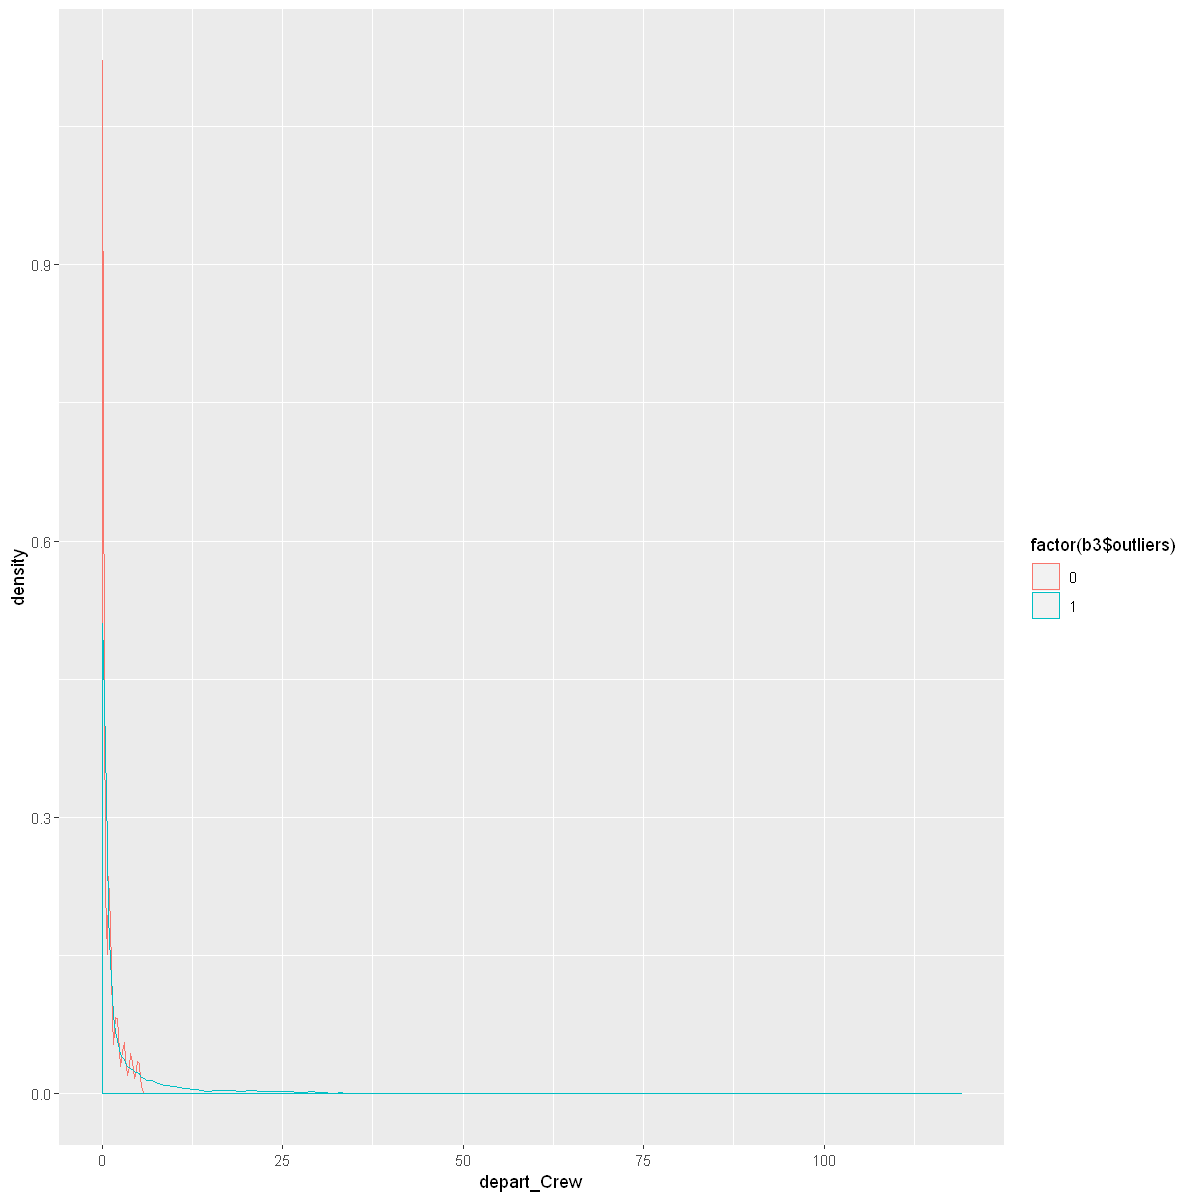

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Editing", "outliers")


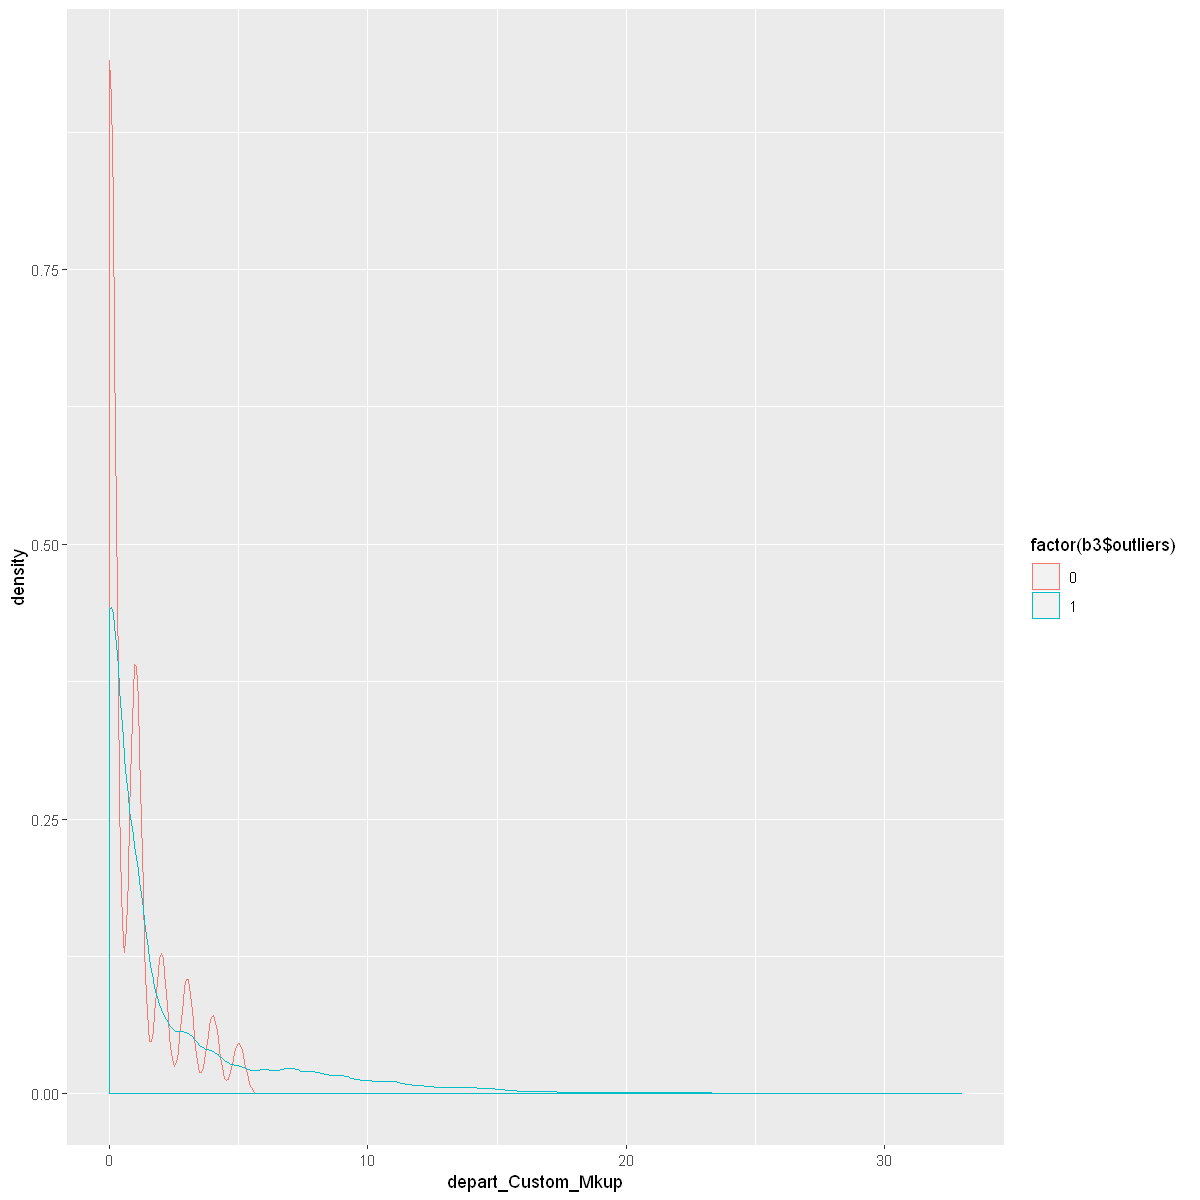

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Lighting", "outliers")


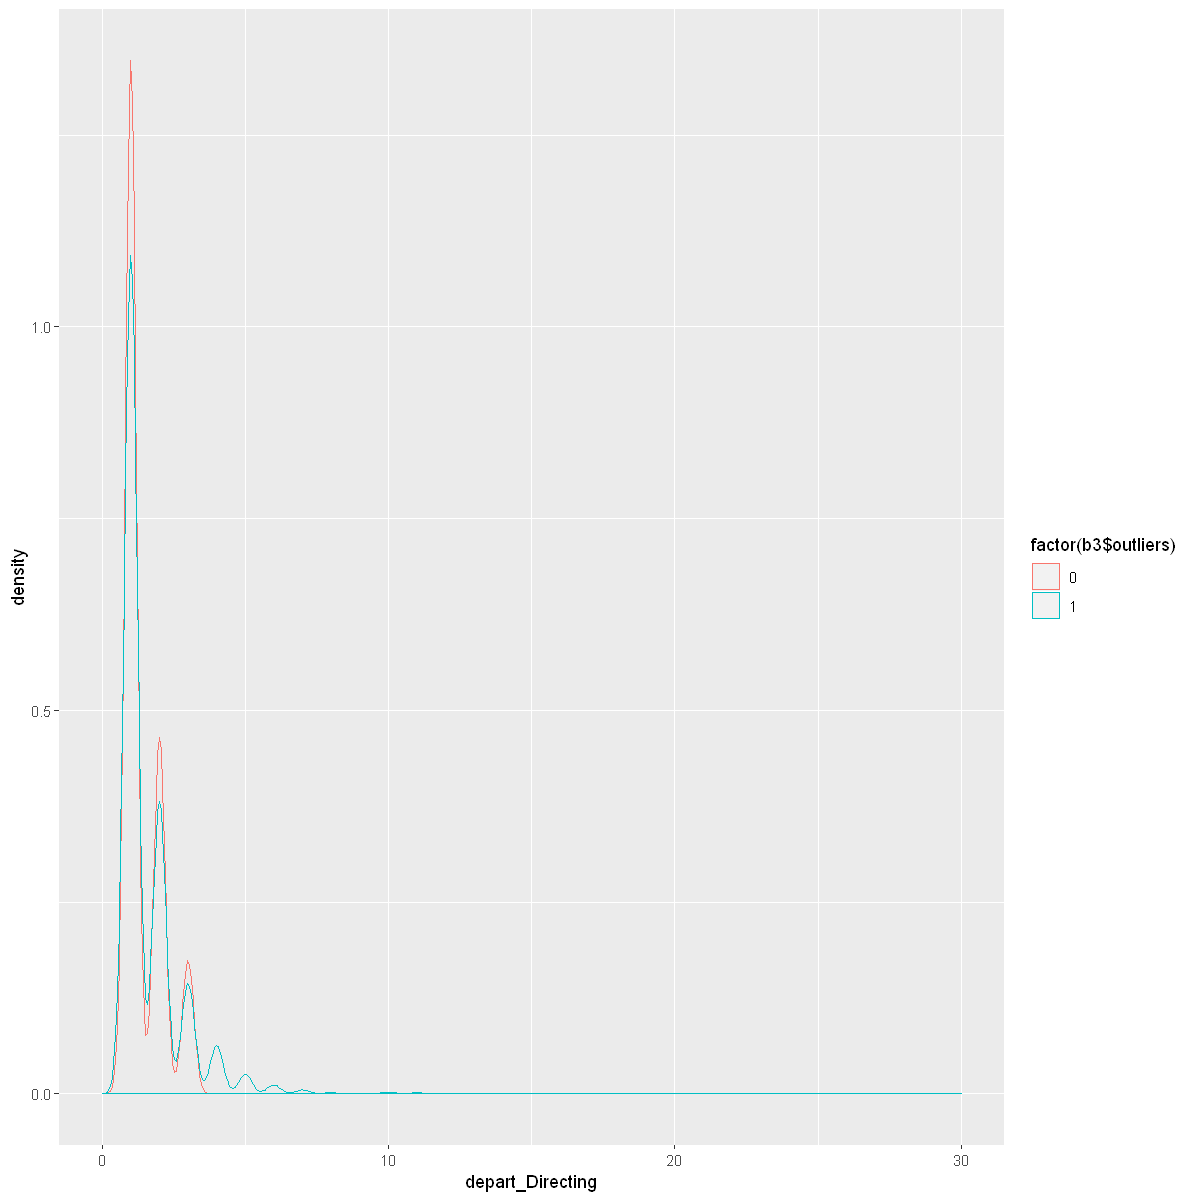

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Production", "outliers")


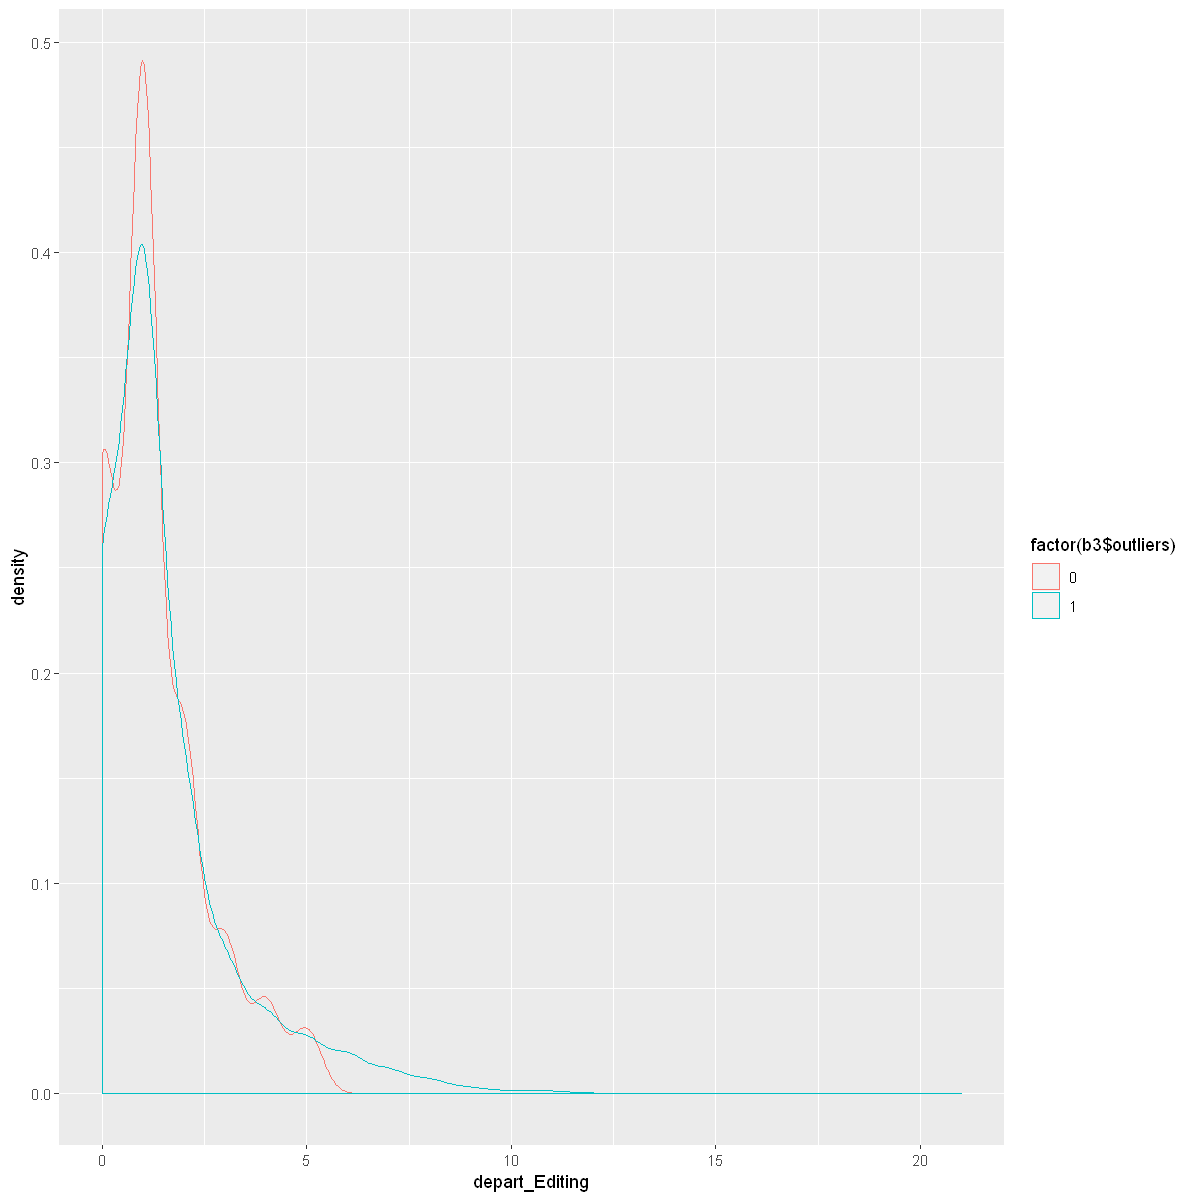

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Sound", "outliers")


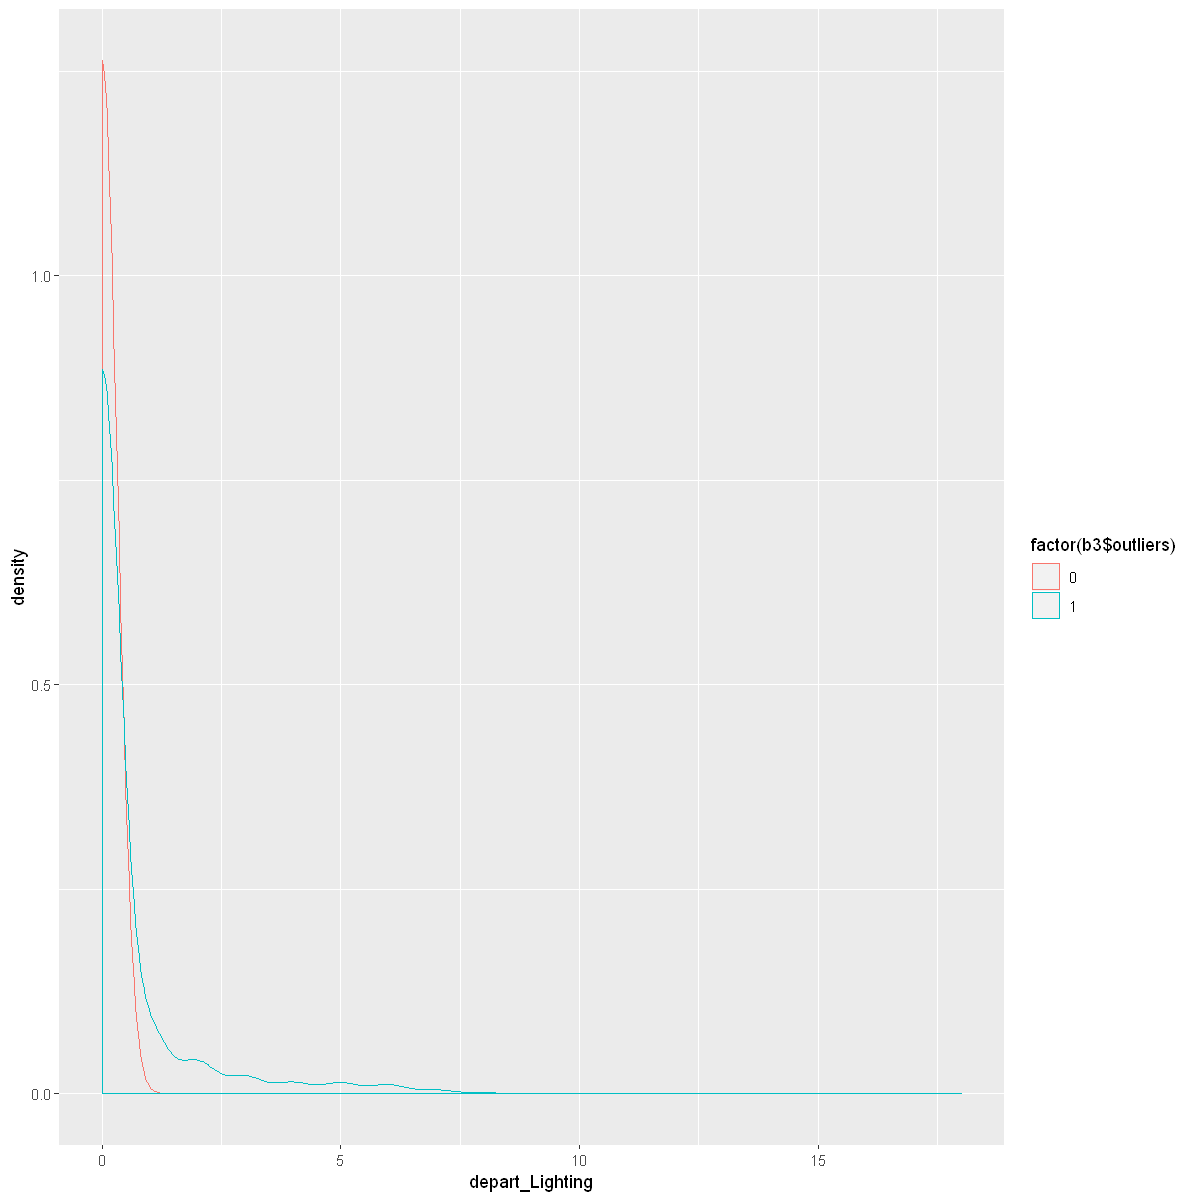

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Visual_Effects", "outliers")


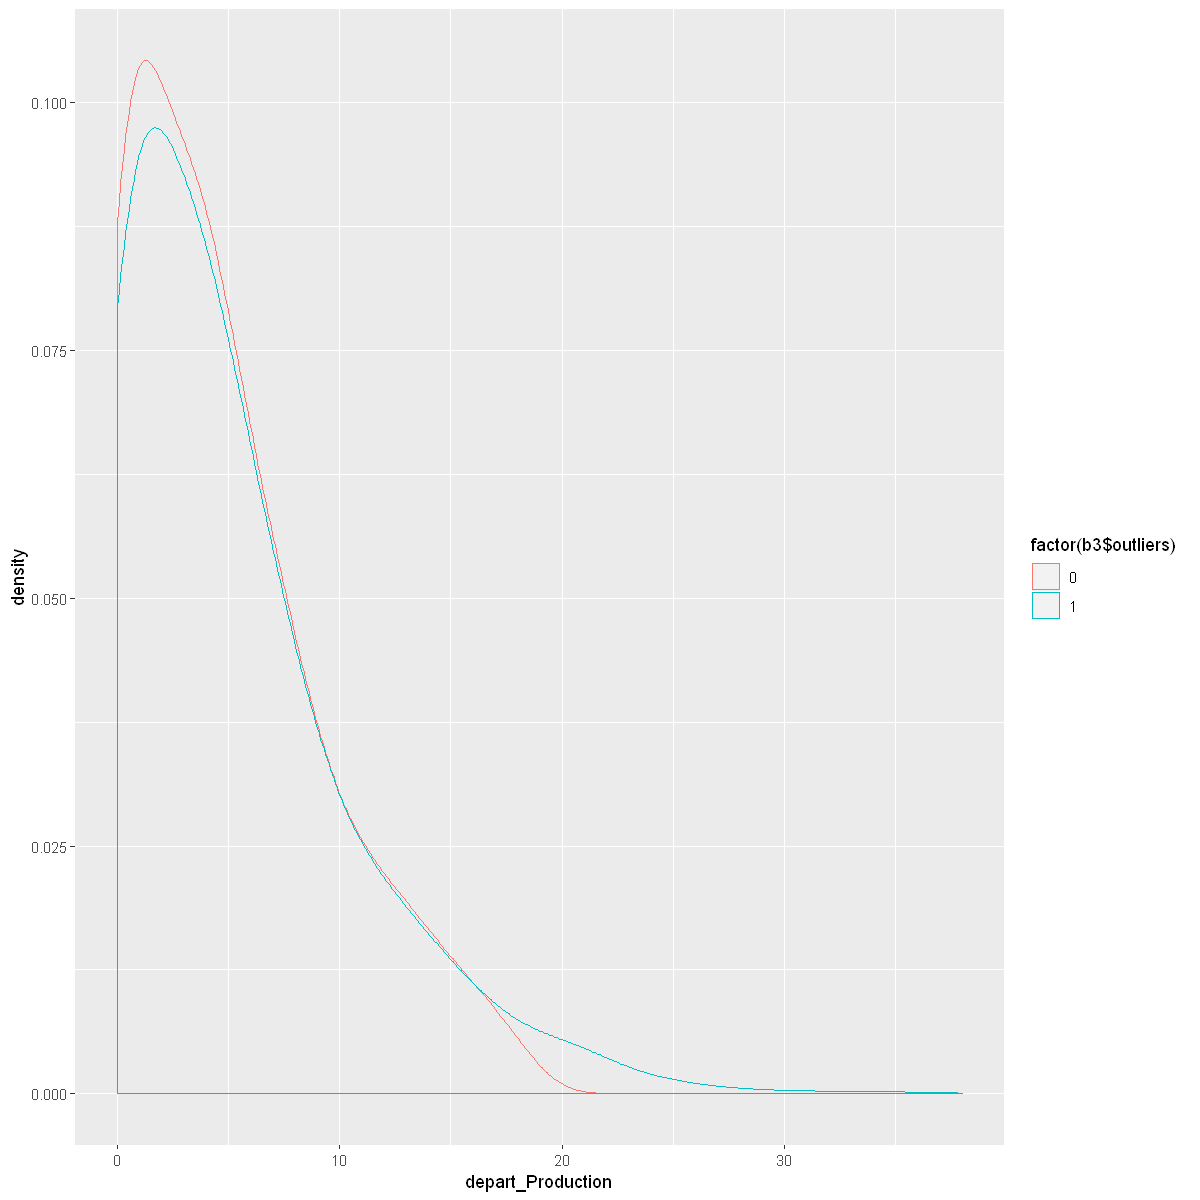

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Writing", "outliers")


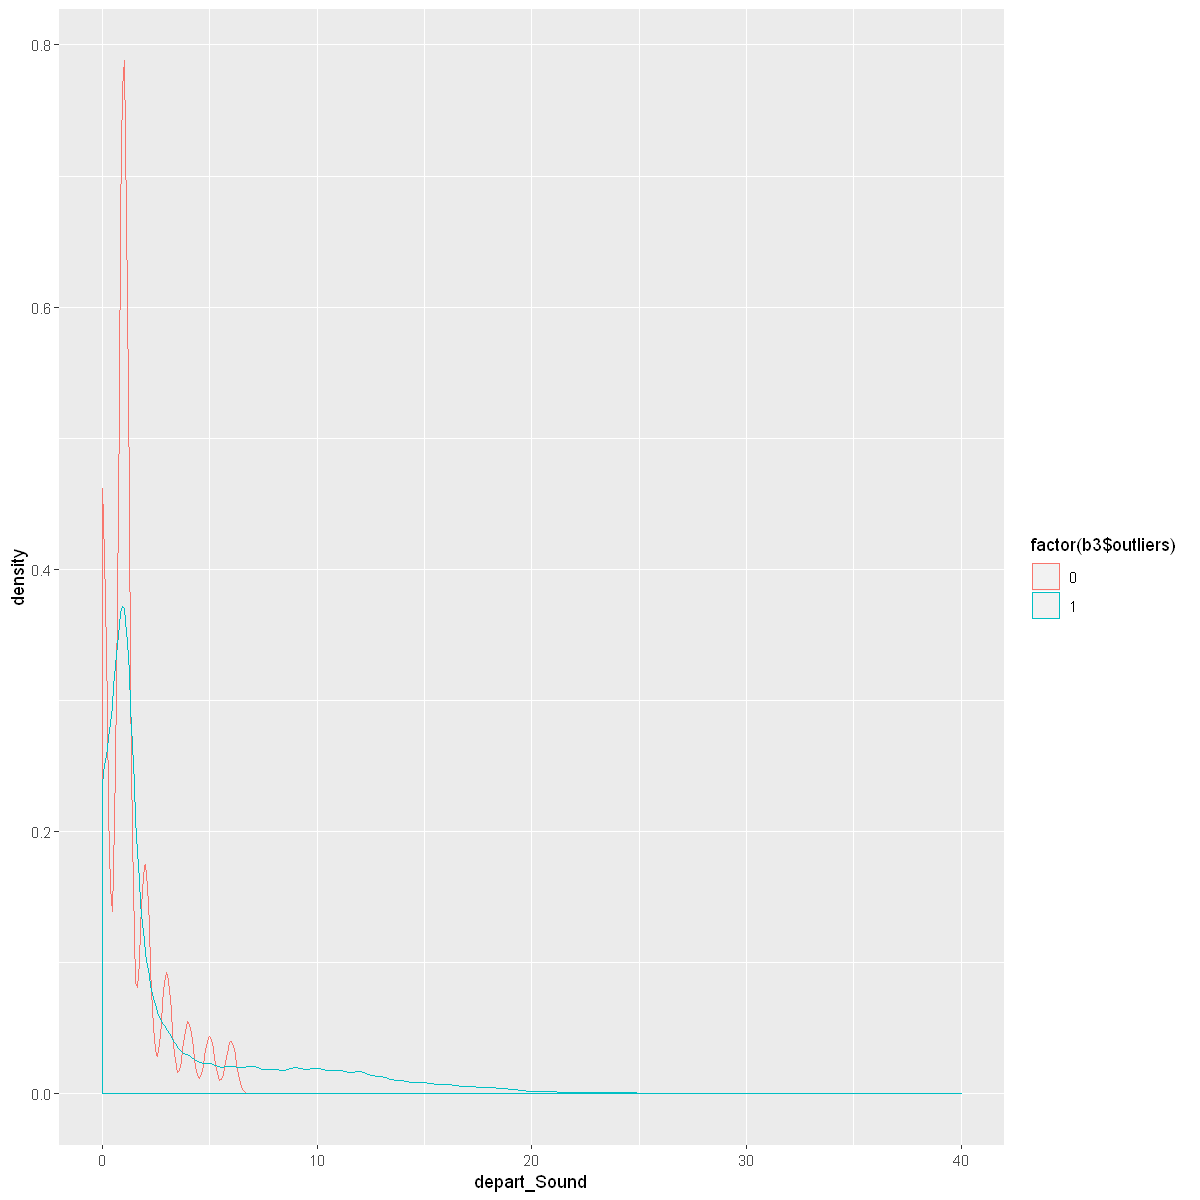

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Art_female", "outliers")


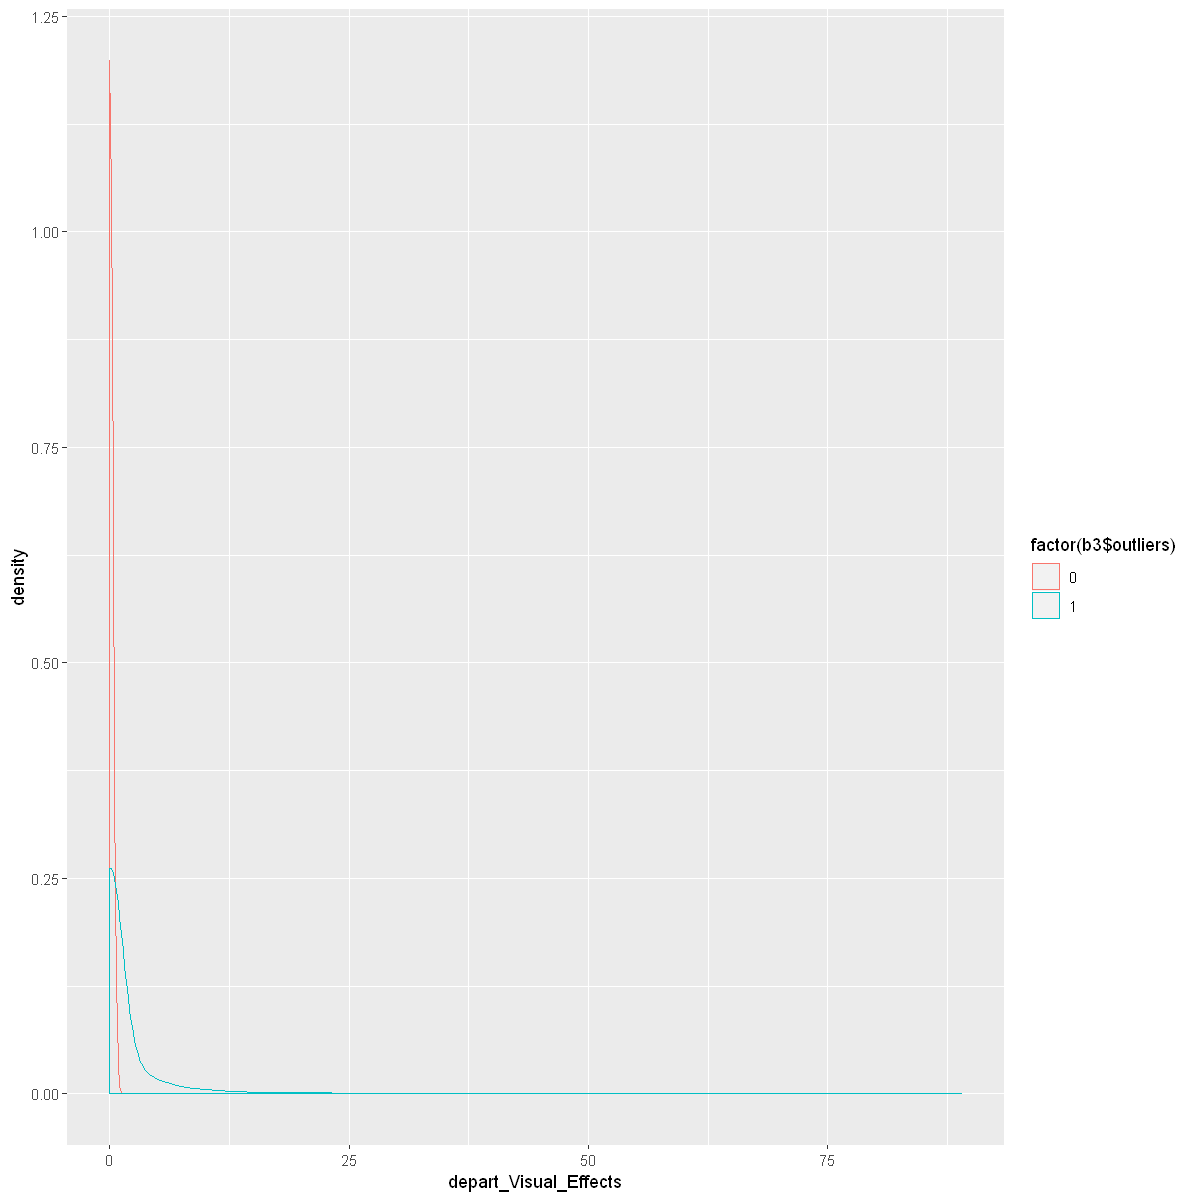

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Camera_female", "outliers")


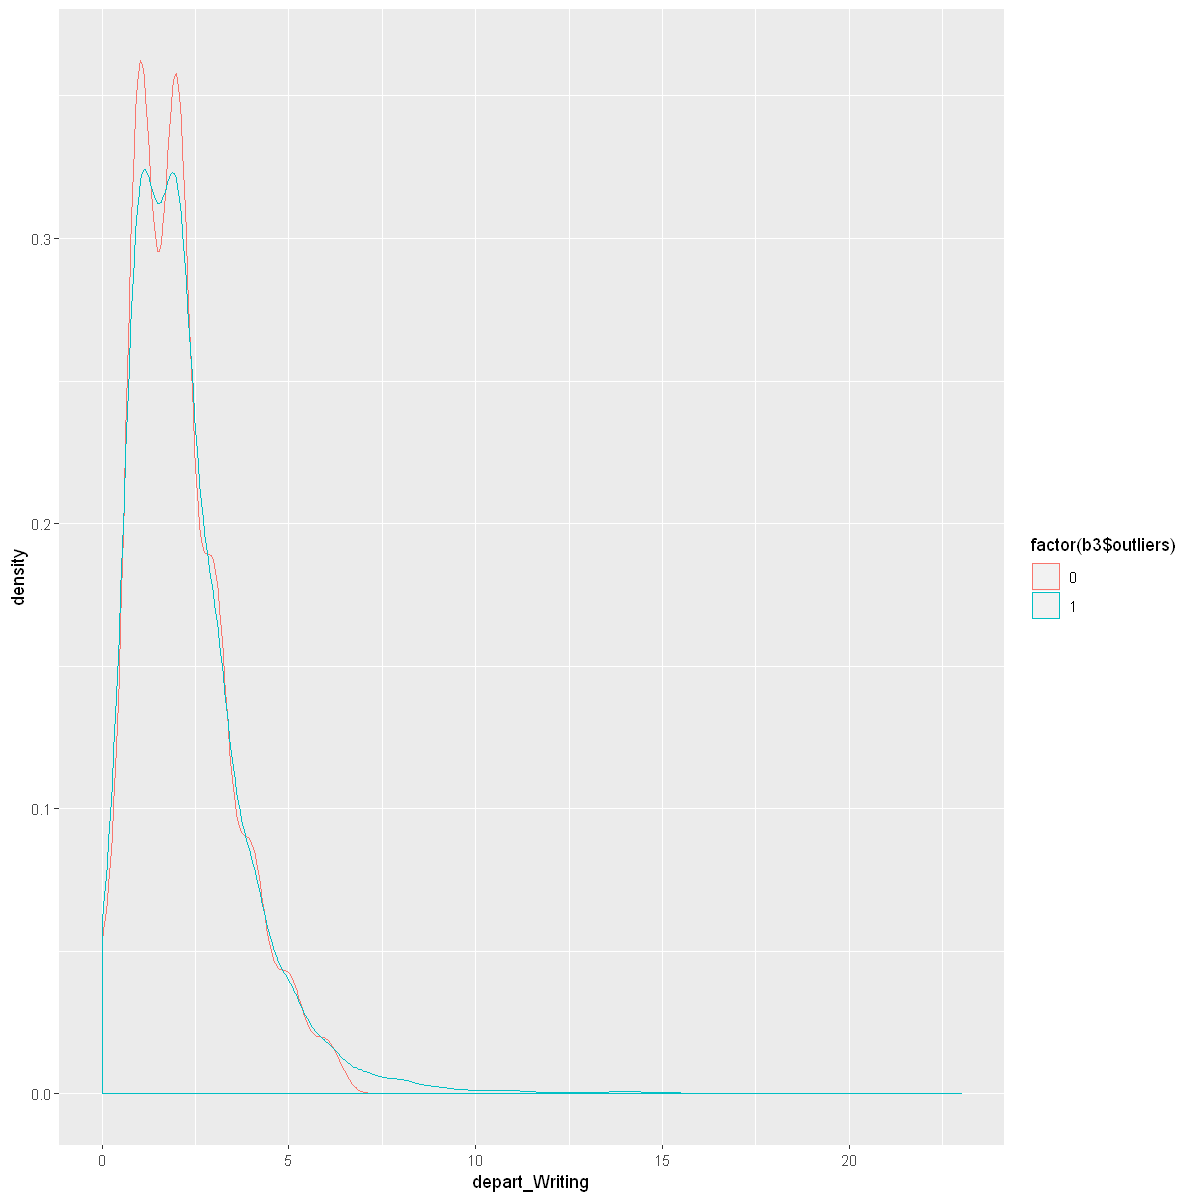

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Crew_female", "outliers")


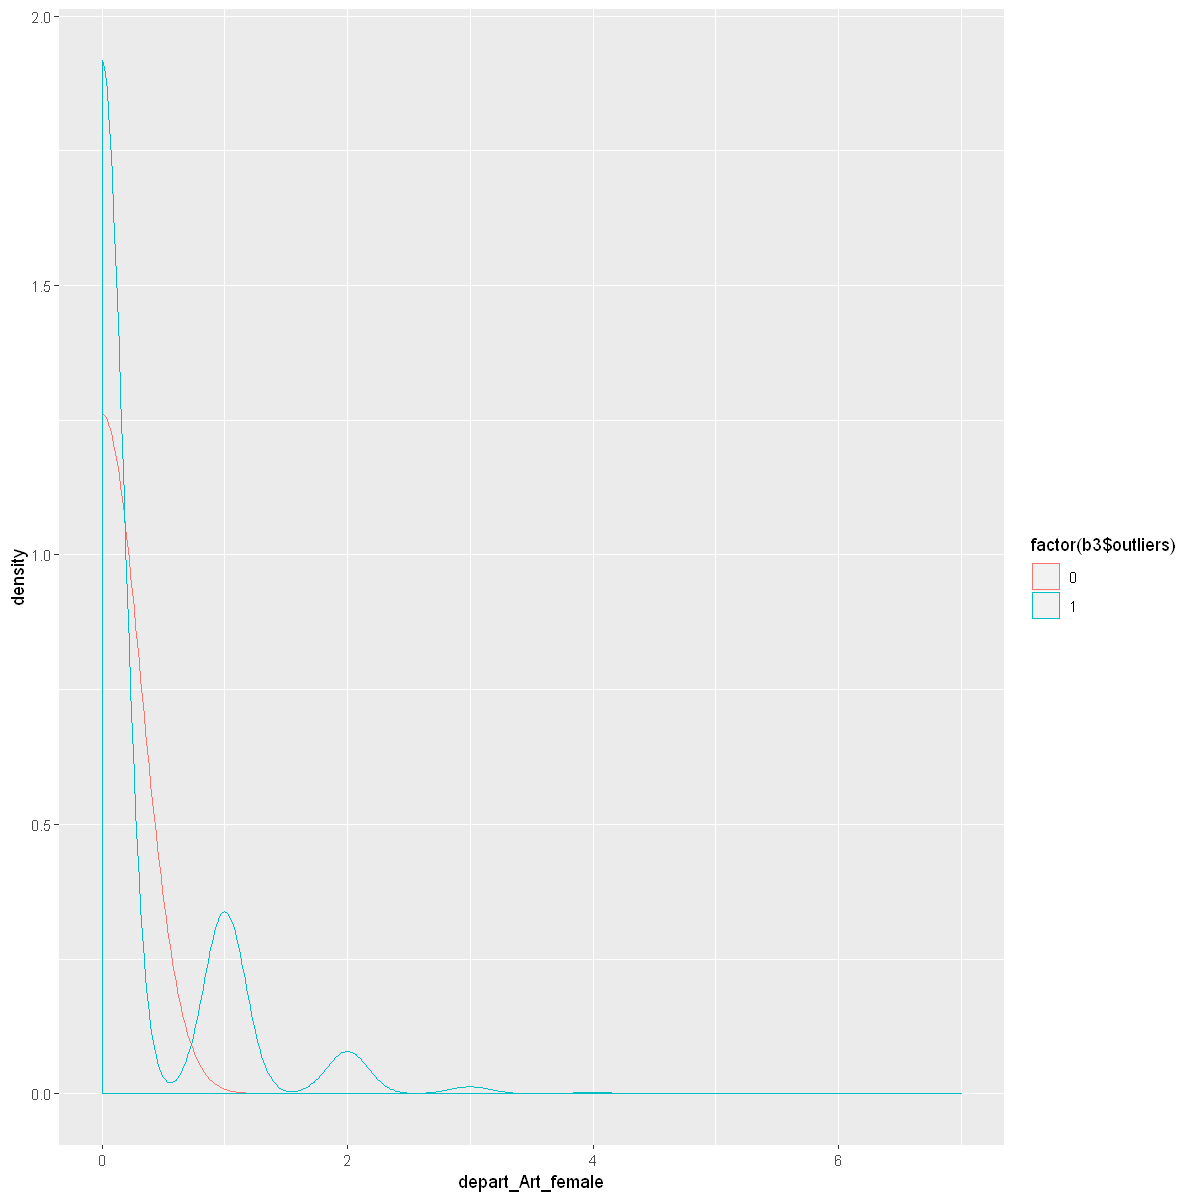

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Custom_Mkup_female", "outliers")


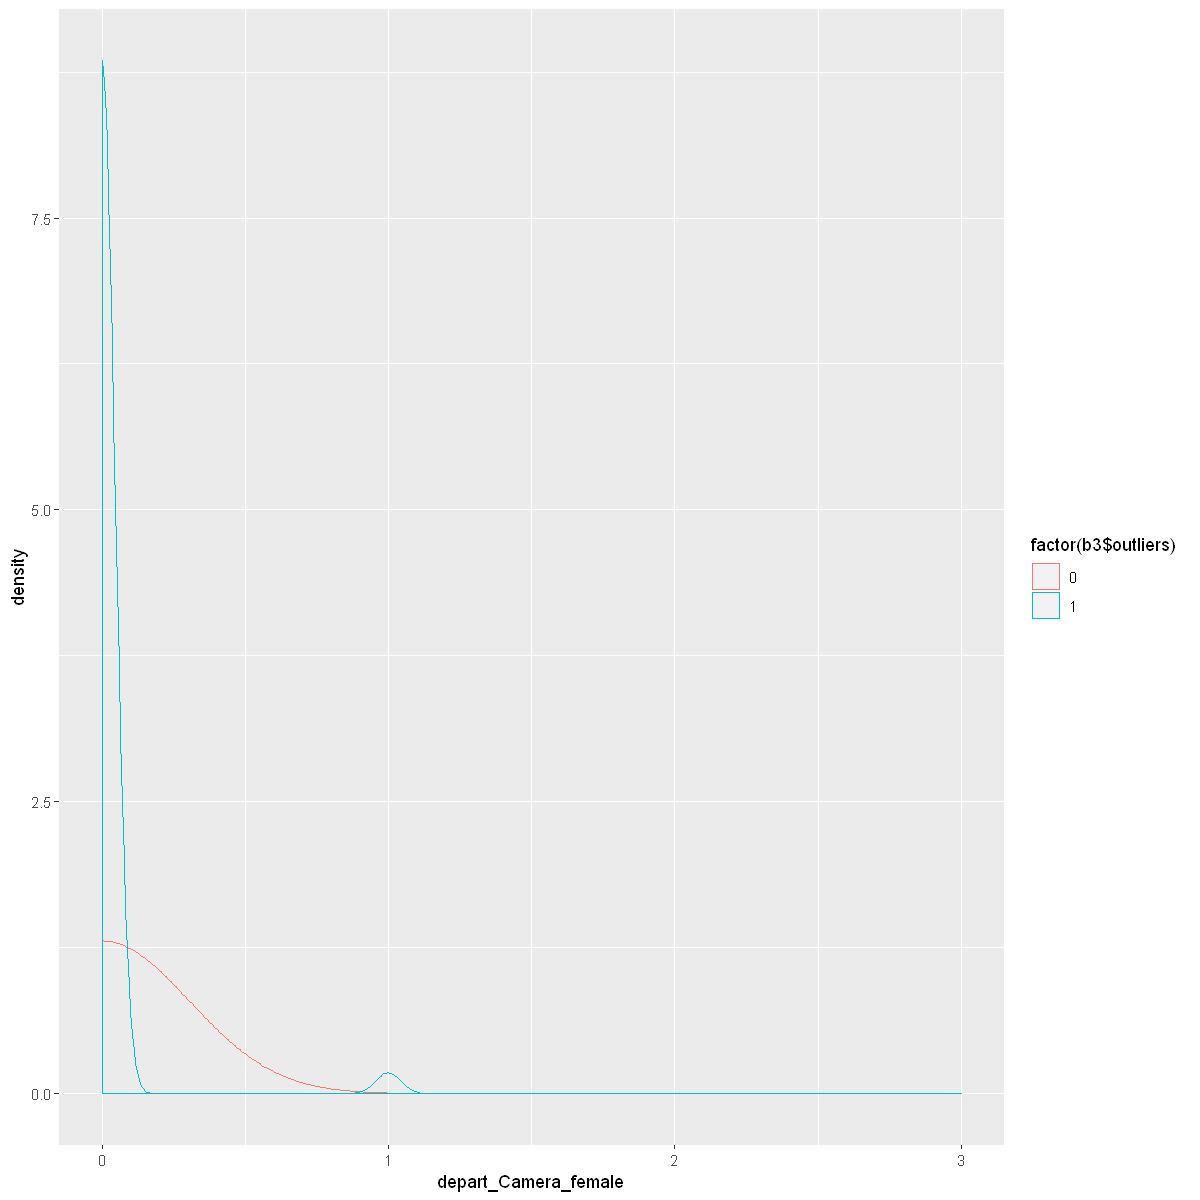

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Directing_female", "outliers")


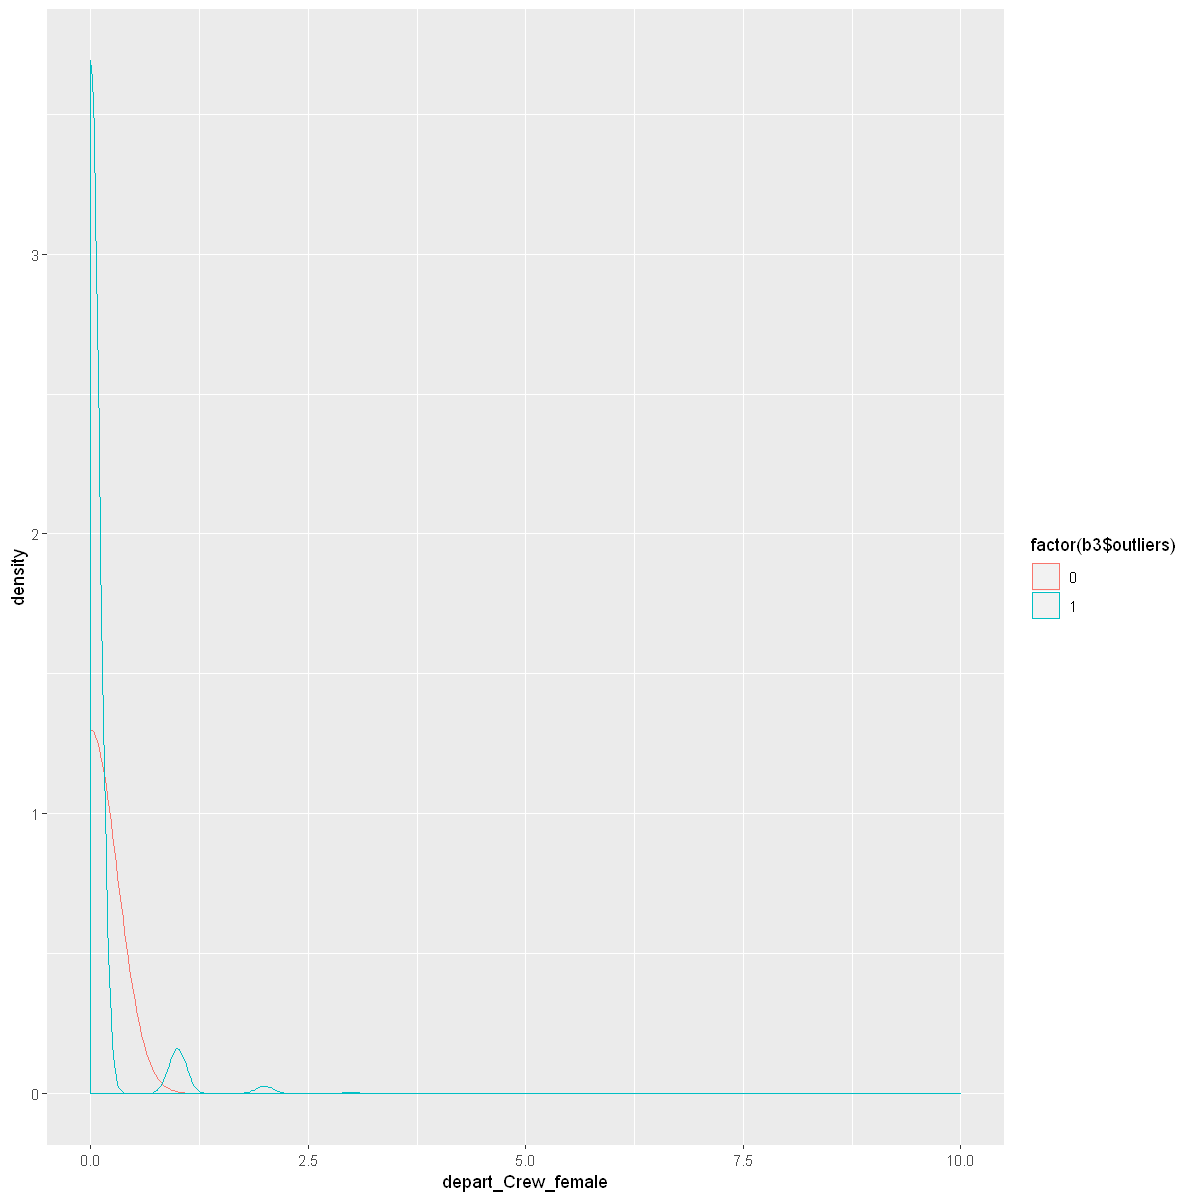

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Editing_female", "outliers")


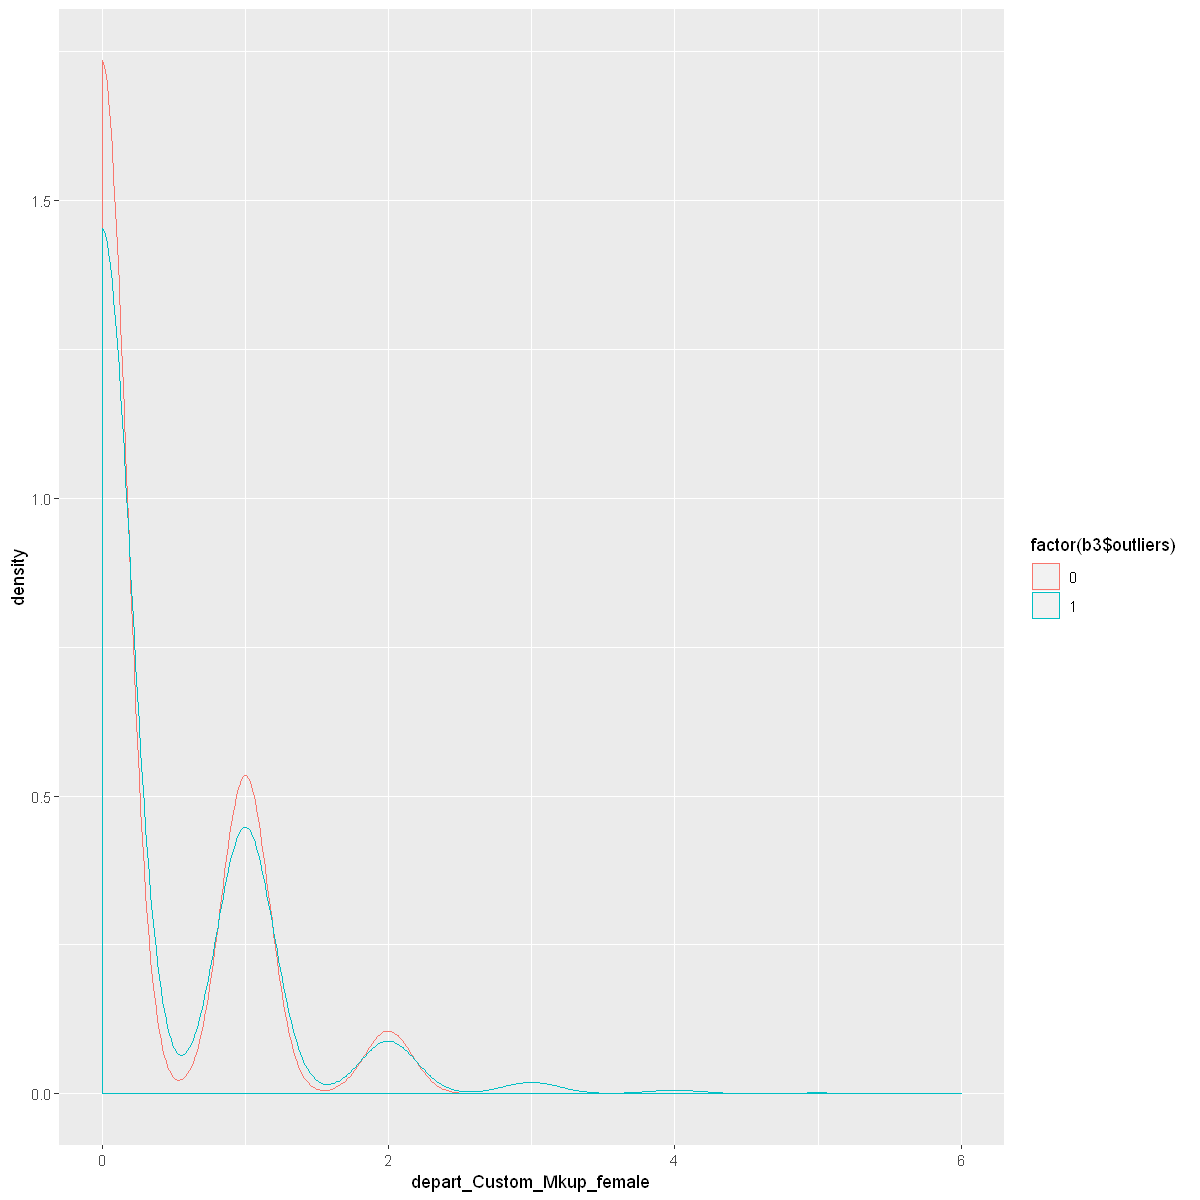

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Production_female", "outliers")


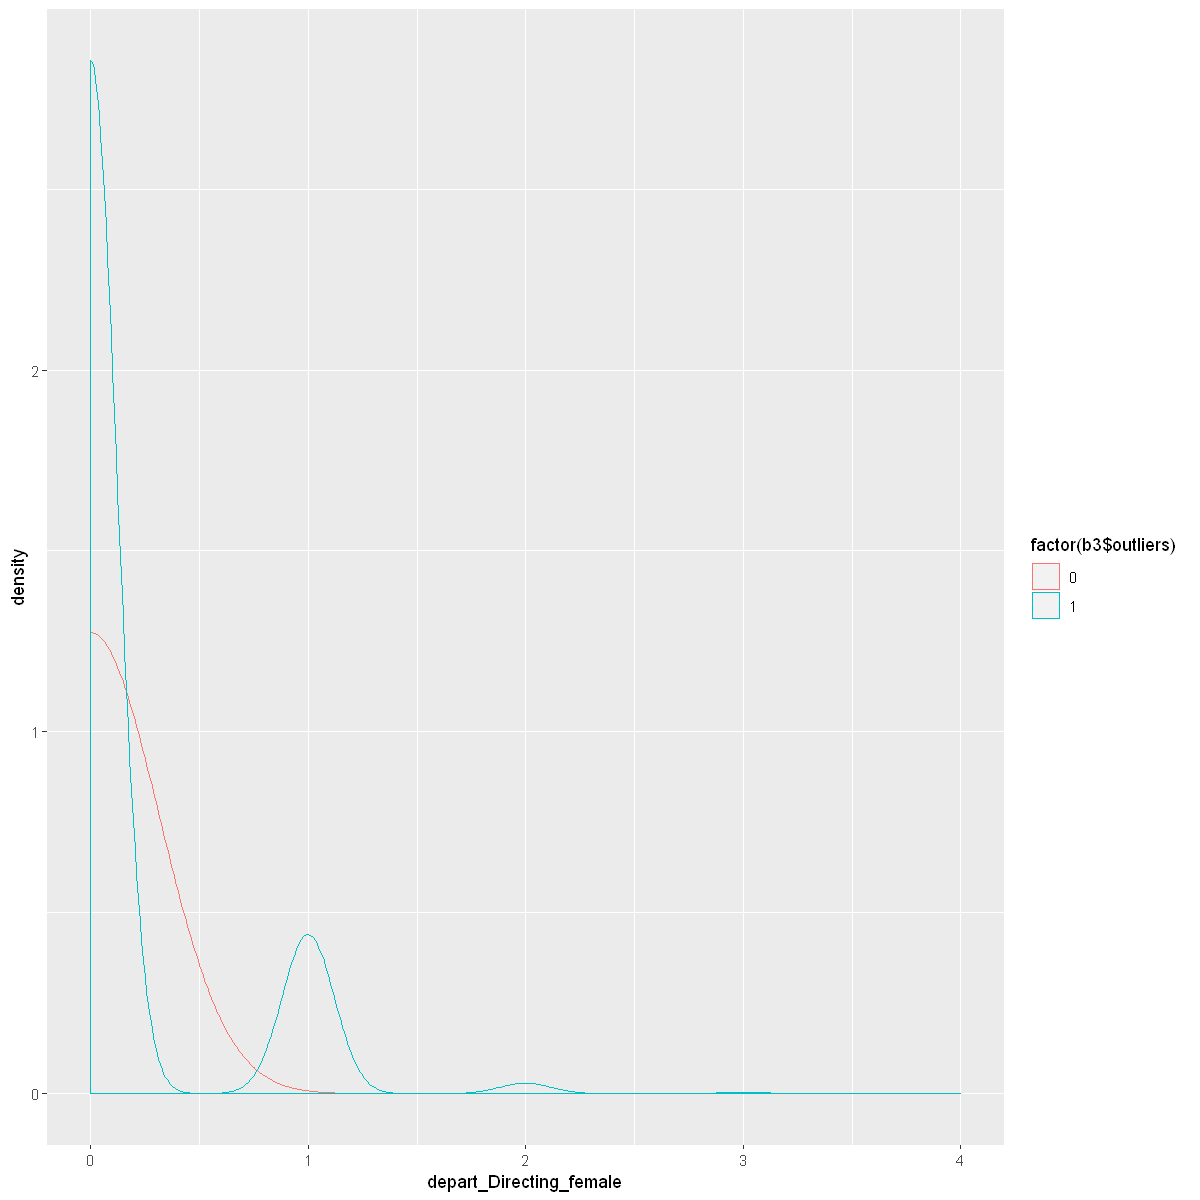

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Sound_female", "outliers")


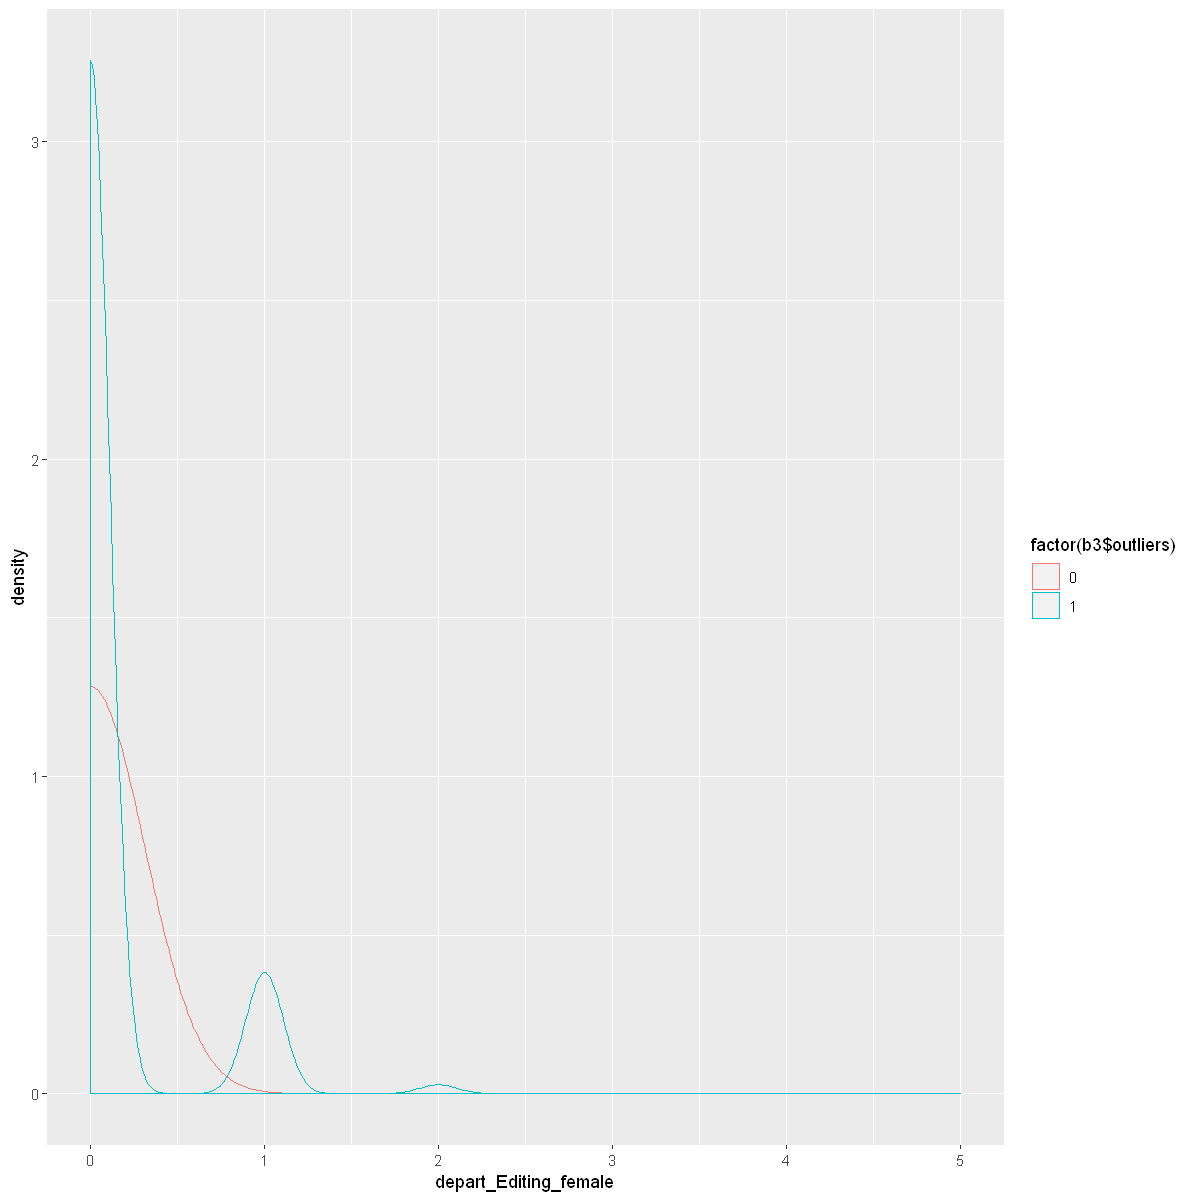

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Visual_Effects_female", "outliers")


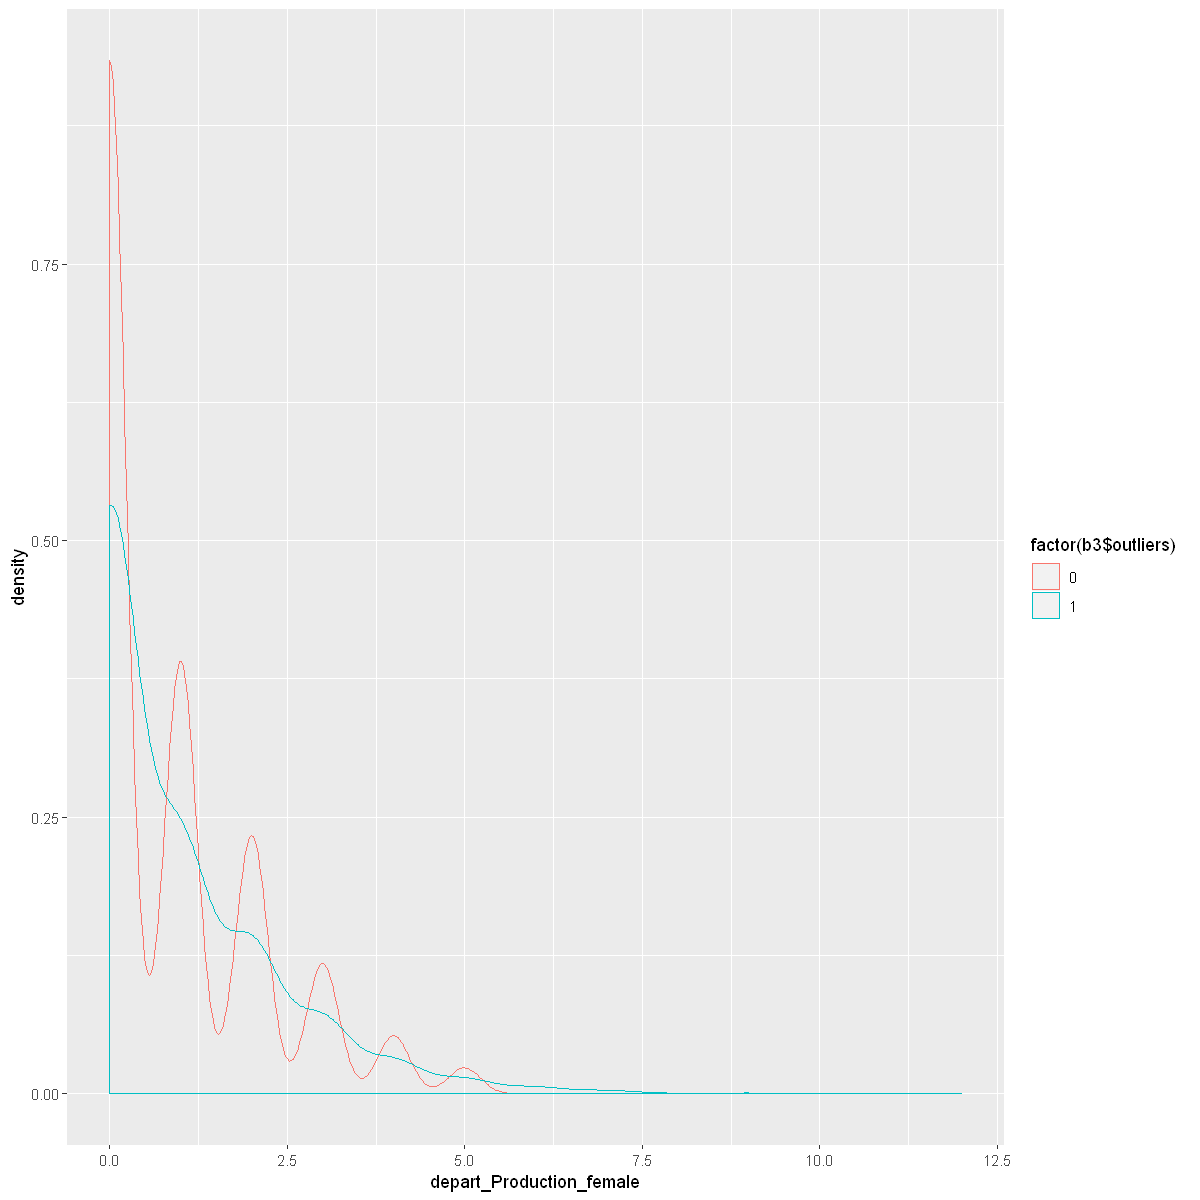

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."
Joining, by = c("depart_Writing_female", "outliers")


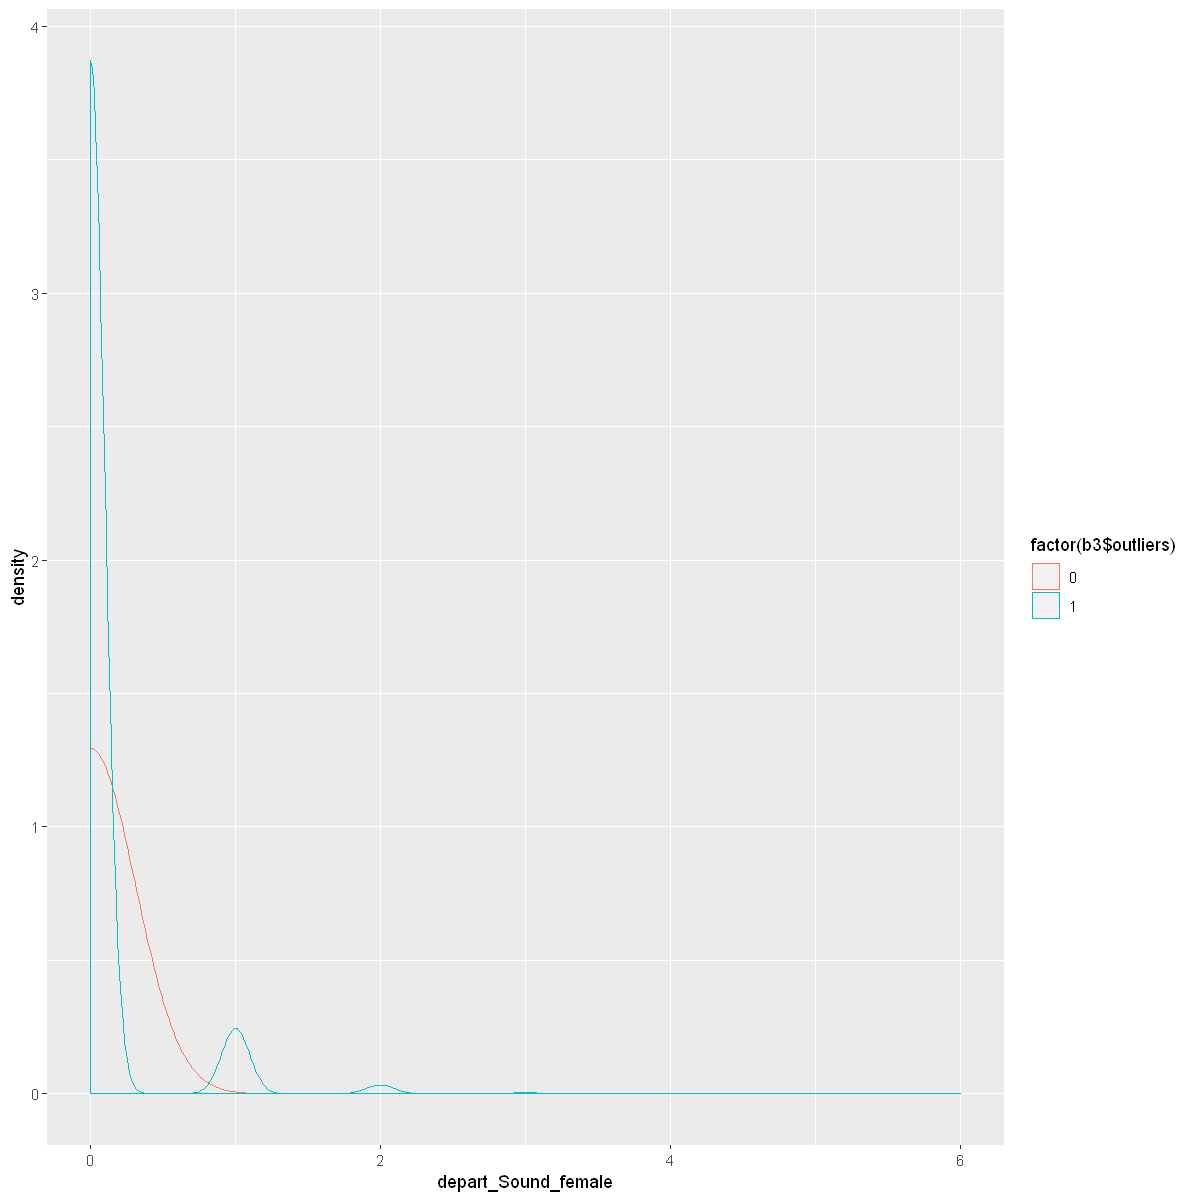

Warning message:
"Removed 34 rows containing non-finite values (stat_density)."


ERROR: Error: Unknown column `NA` 


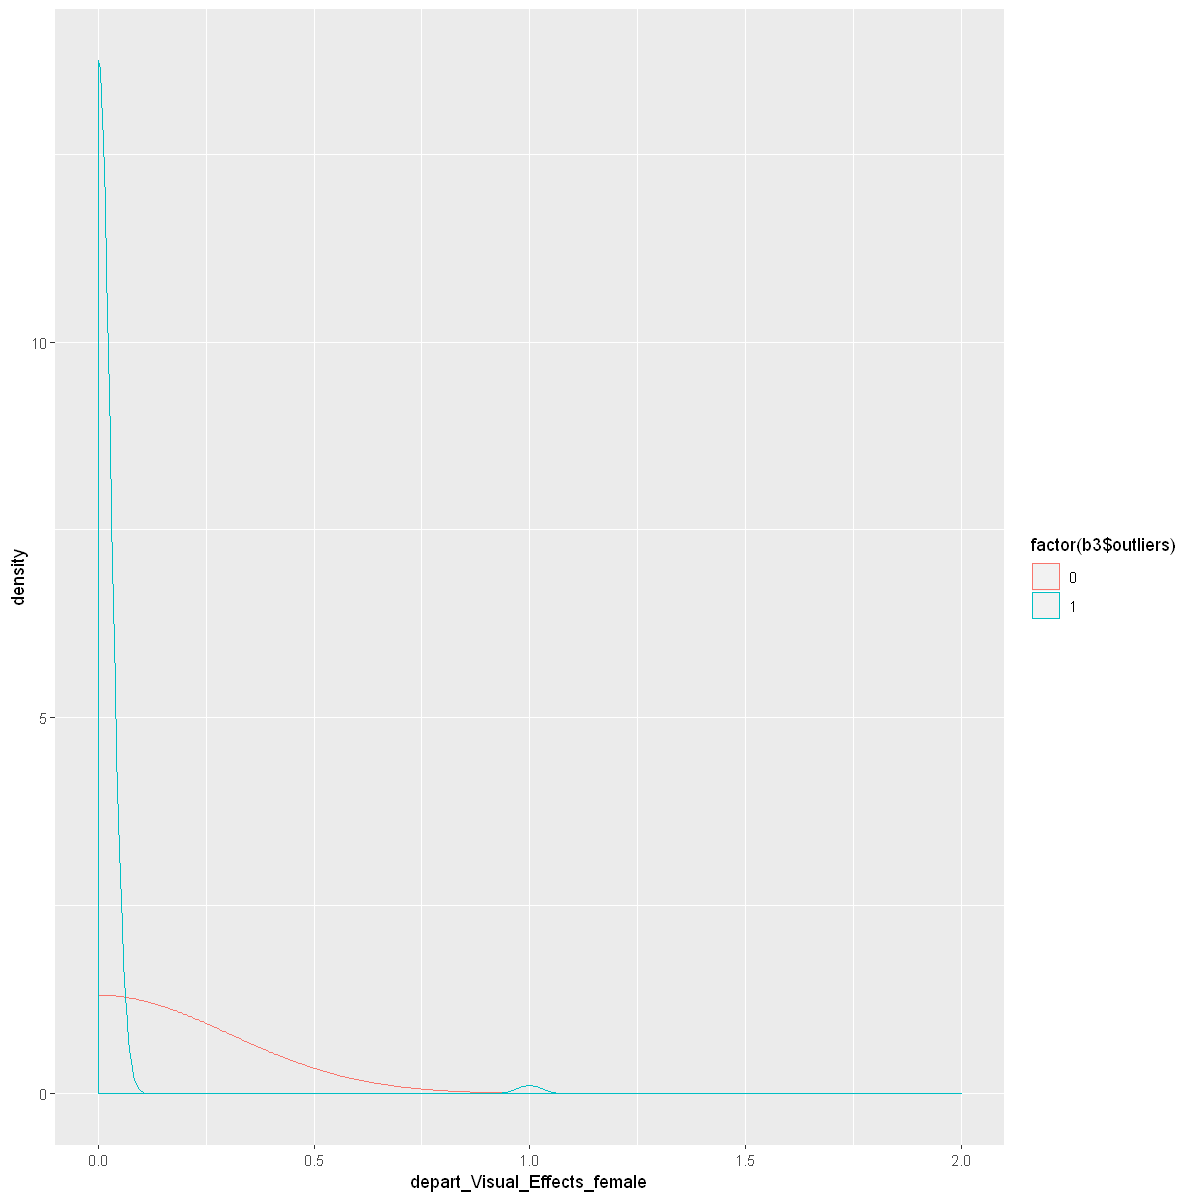

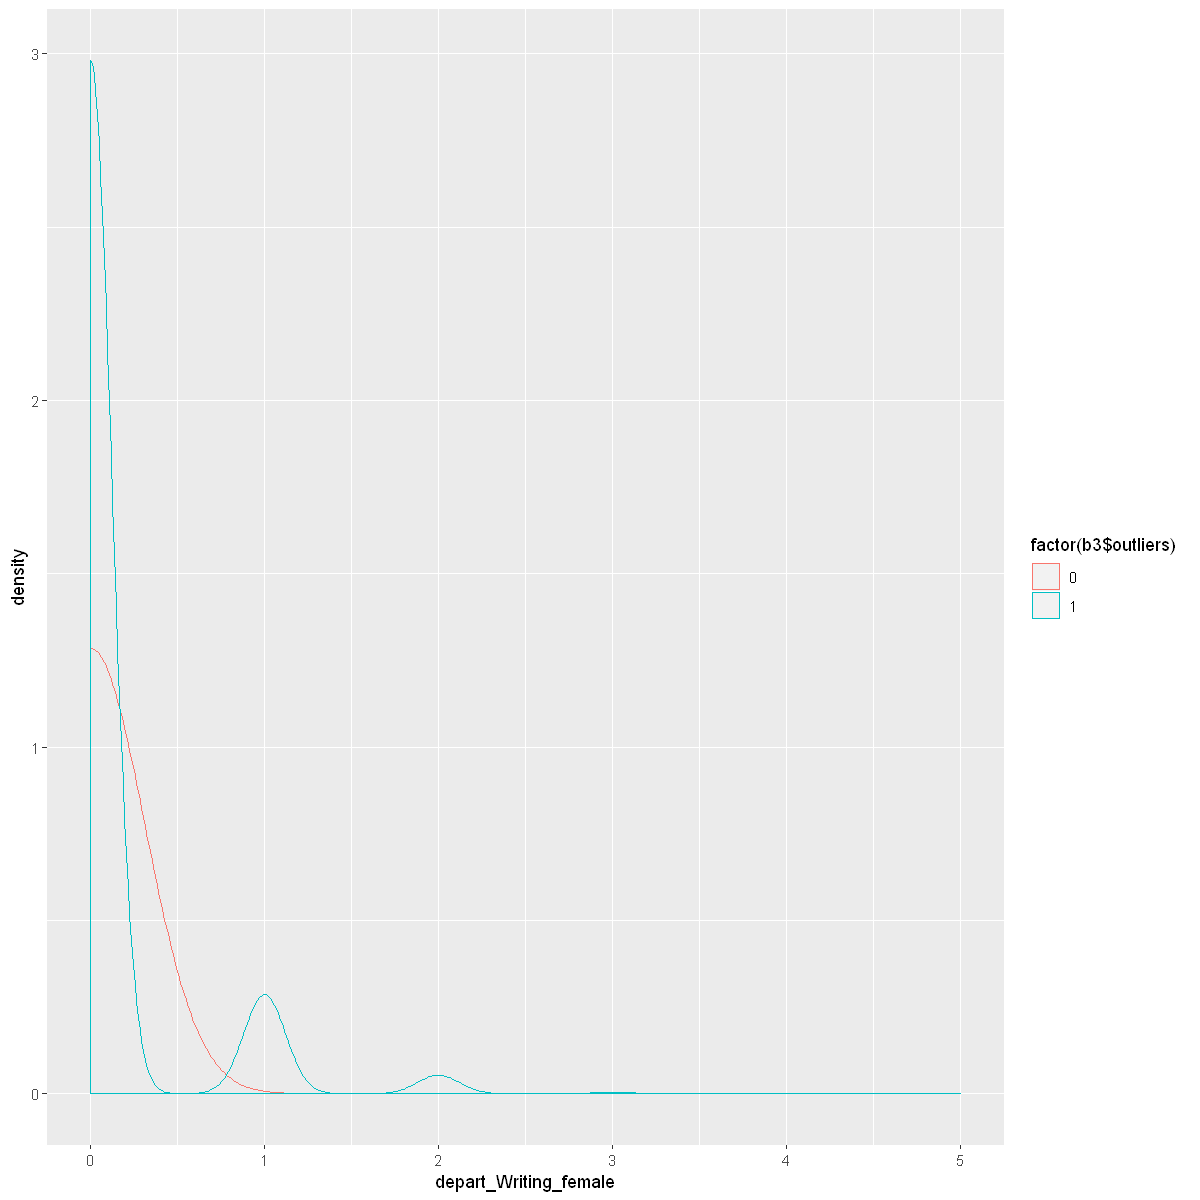

In [385]:
for (v in l) {
    b1 <- movies_ff_v %>% select(v) 
    b1$outliers <- 1
    b2 <- movies_ff_v %>% select(v) %>% filter(movies.out[[paste(v,'out',sep='_')]]==0)
    b2$outliers <- 0
    b3 <- full_join(b1,b2)
    print(ggplot(b3,aes(x=b3[[v]], group=factor(b3$outliers),
                          color=factor(b3$outliers))) + xlab(v) +
    geom_density(adjust=2))
}

removing the outliers doesnt affect the assumption at variables:
budget, runtime, producers_cnt, keywords_cnt, actor0_movies_cnt, actor0_movies_5y_cnt, actor1_movies_cnt,
actor1_movies_5y_cnt, actor2_movies_cnt, actor2_movies_5y_cnt, actor0_prev_revenue, actor1_prev_revenue,
actor2_prev_revenue, director_movies_cnt, director_movies_5y_cnt, depart_Art, depart_Directing, depart_Editing,
depart_Production, depart_writing, depart_Custom_Mkup_female

In [42]:
for (v in l[1:length(l)]) {
    b1 <- movies_ff_v %>% select(v) 
    b2 <- movies_ff_v %>% select(v) %>% filter(movies.out[[paste(v,'out',sep='_')]]==0)
    print(v)
    print(t.test(b1[[v]],b2[[v]],main=v))
}

[1] "budget"

	Welch Two Sample t-test

data:  b1[[v]] and b2[[v]]
t = 14.303, df = 8436.5, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  7794284 10270004
sample estimates:
mean of x mean of y 
 31170351  22138207 

[1] "popularity"

	Welch Two Sample t-test

data:  b1[[v]] and b2[[v]]
t = 7.064, df = 9473.5, p-value = 1.732e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.7745935 1.3695965
sample estimates:
mean of x mean of y 
 8.539777  7.467682 

[1] "runtime"

	Welch Two Sample t-test

data:  b1[[v]] and b2[[v]]
t = 6.9587, df = 13871, p-value = 3.589e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.546628 2.759620
sample estimates:
mean of x mean of y 
 108.0257  105.8726 

[1] "sw_collection"

	Welch Two Sample t-test

data:  b1[[v]] and b2[[v]]
t = 14.227, df = 7374, p-value < 2.2e-16
alternati

ERROR: Error: Unknown column `NA` 



.תייצרו גרף scatter עם המשתנים שבשאלה הקודמת ב-X ומשתנה המטרה ב-Y .האם ערכי
קיצון במשתנה ה-X משפיעה על ההתנהגות של משתנה ה-Y ?האם רואים שוני עם או בלי ערכי
הקיצון?

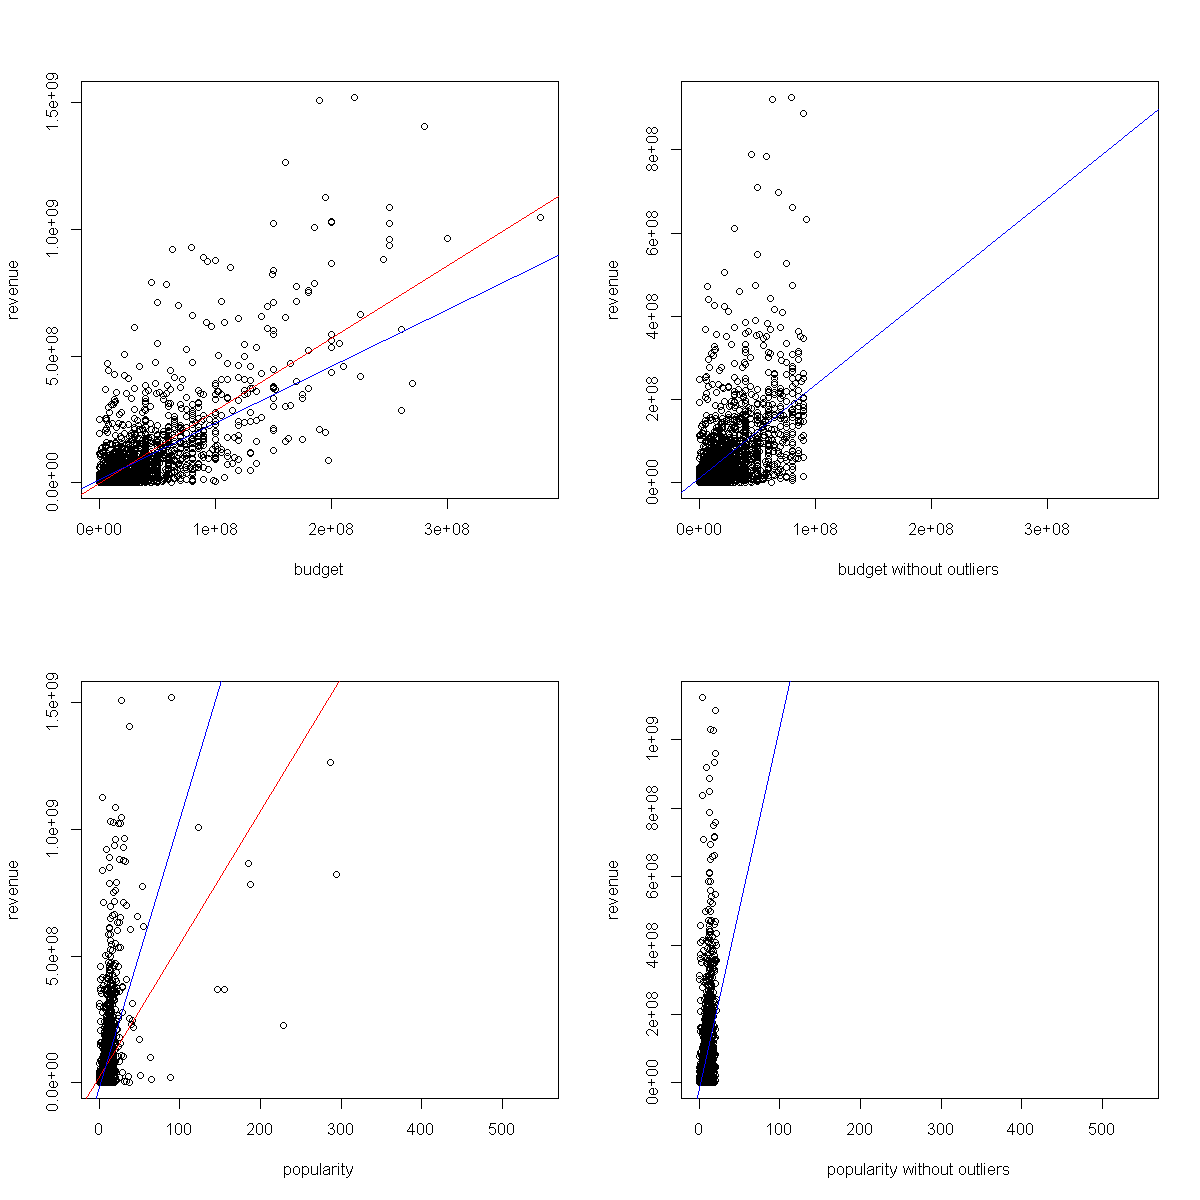

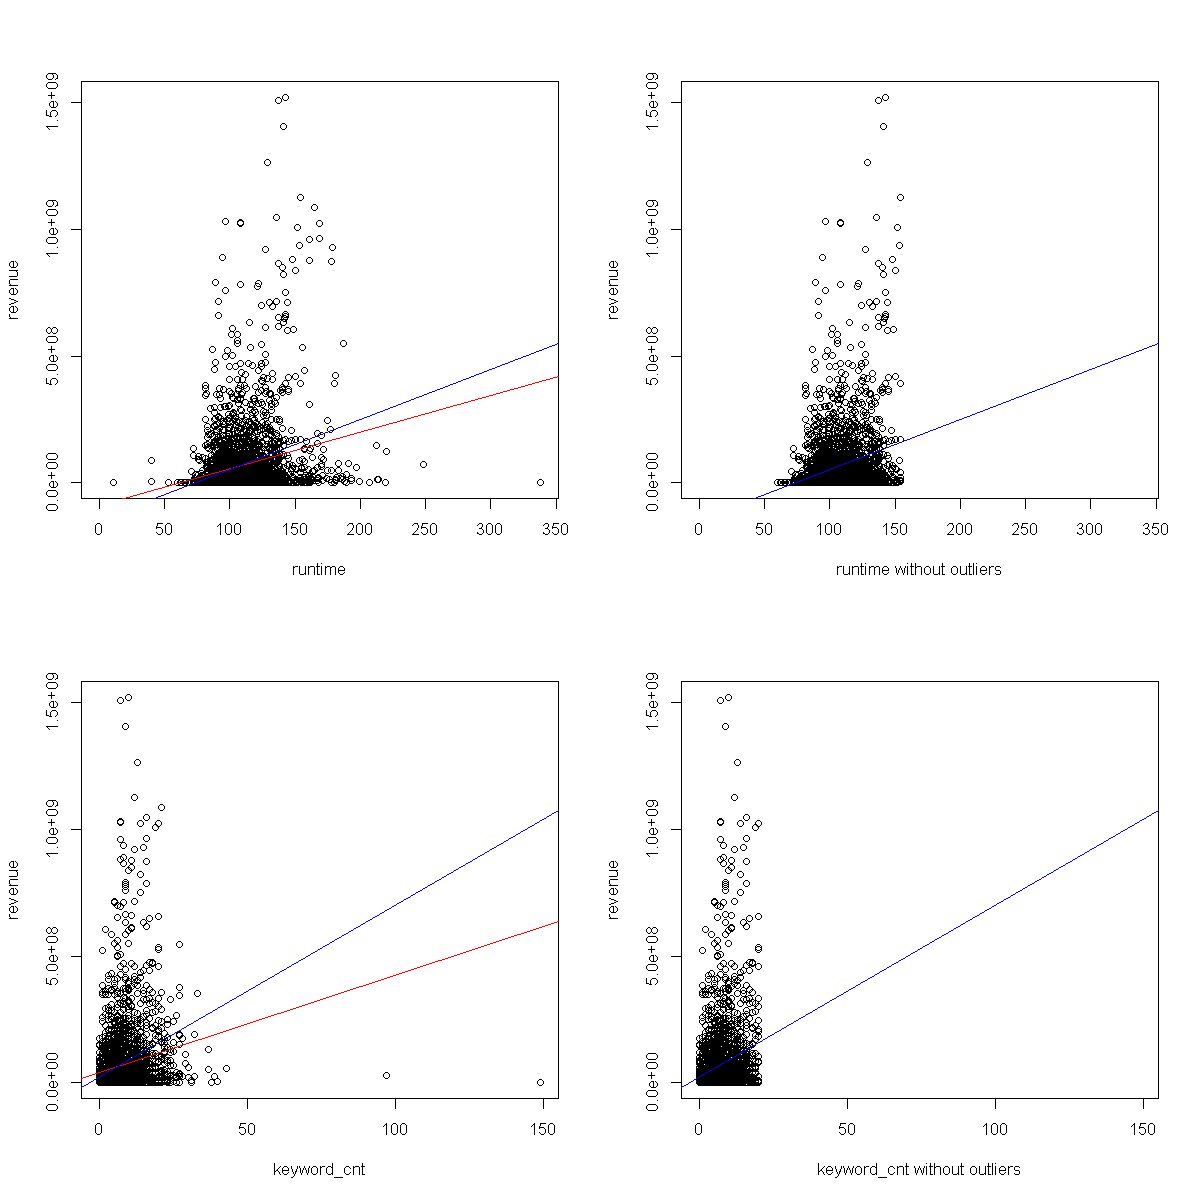

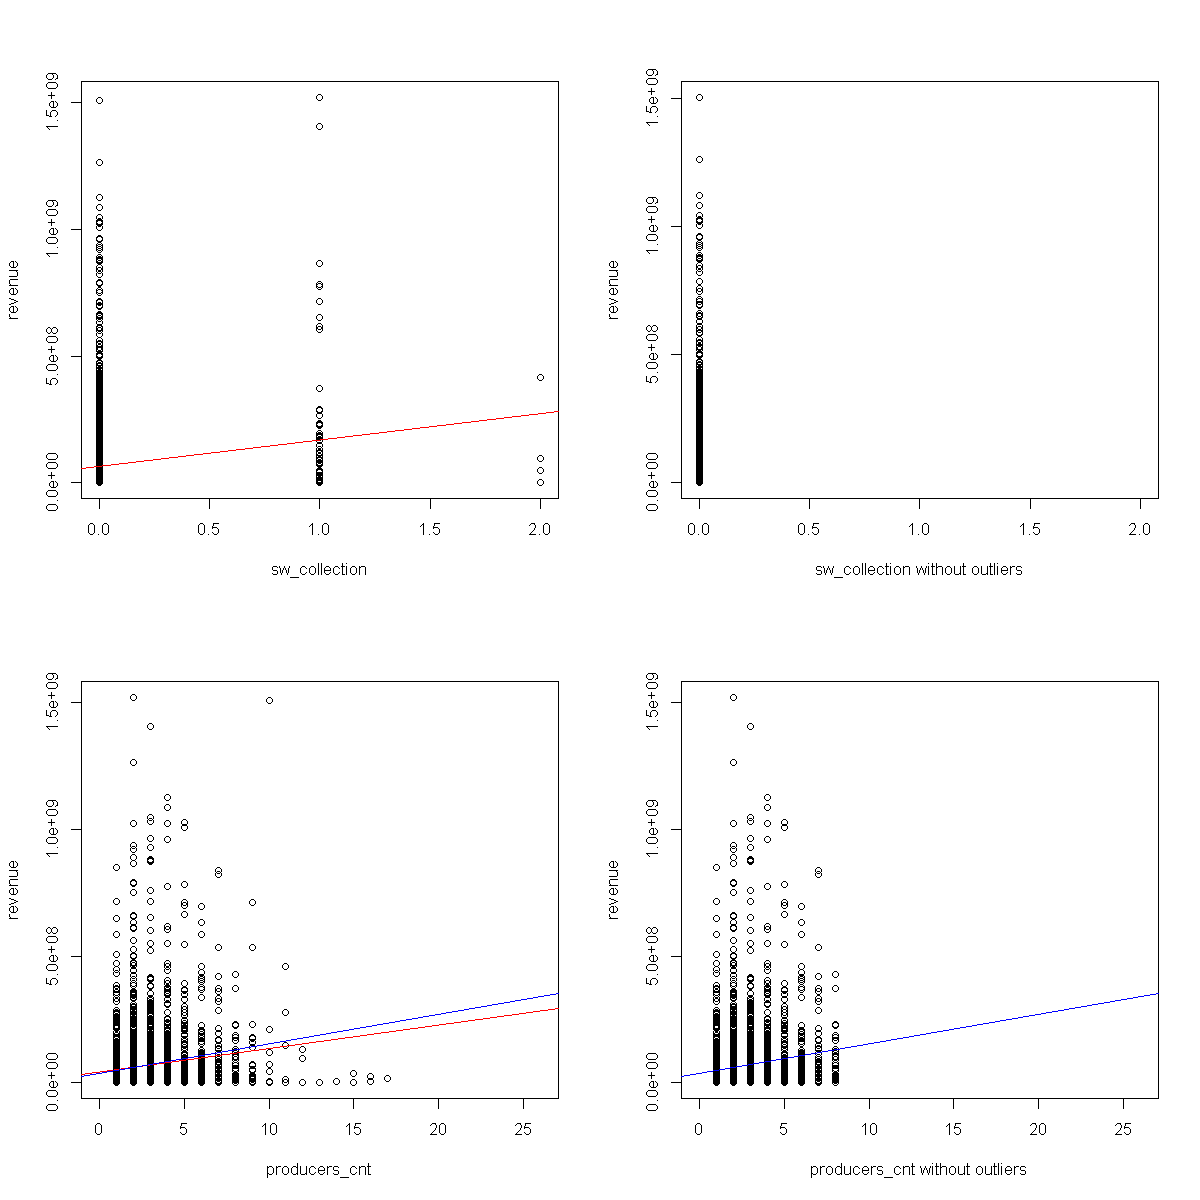

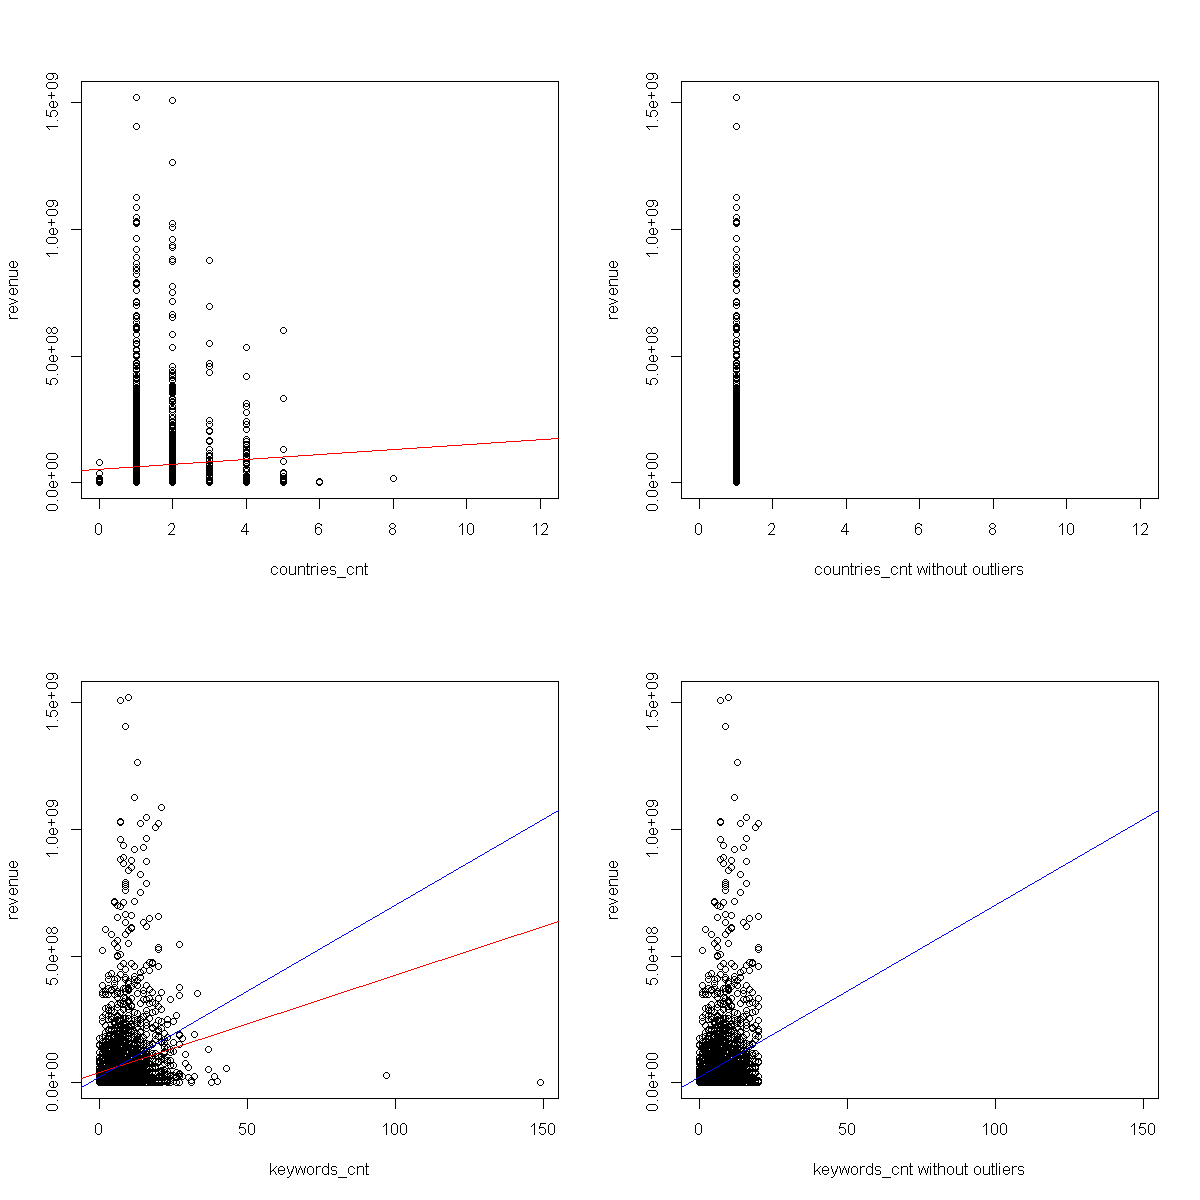

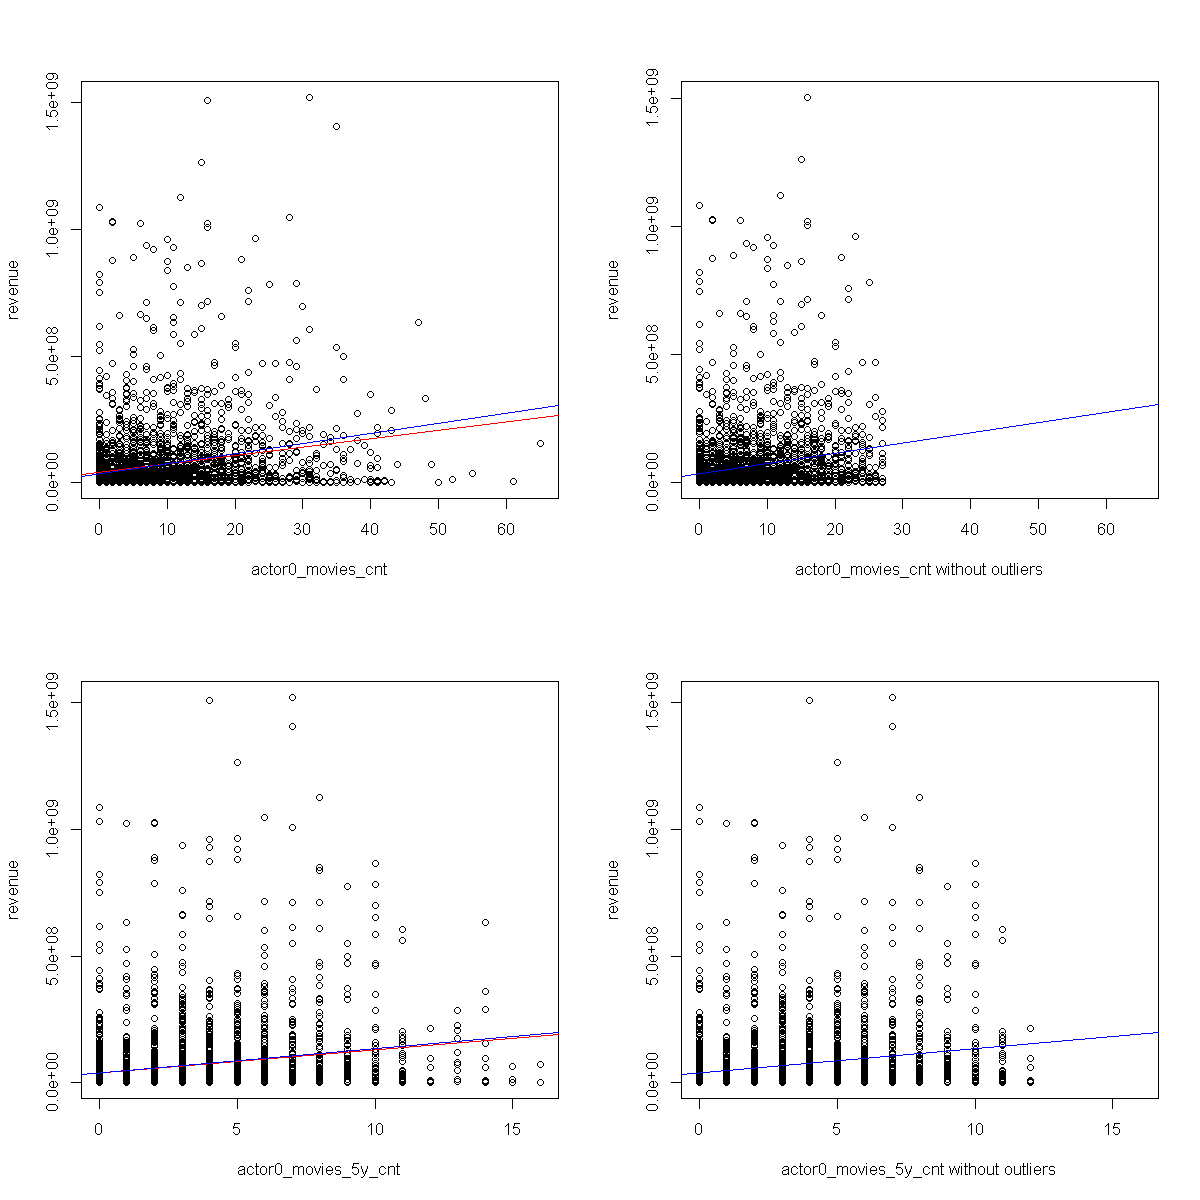

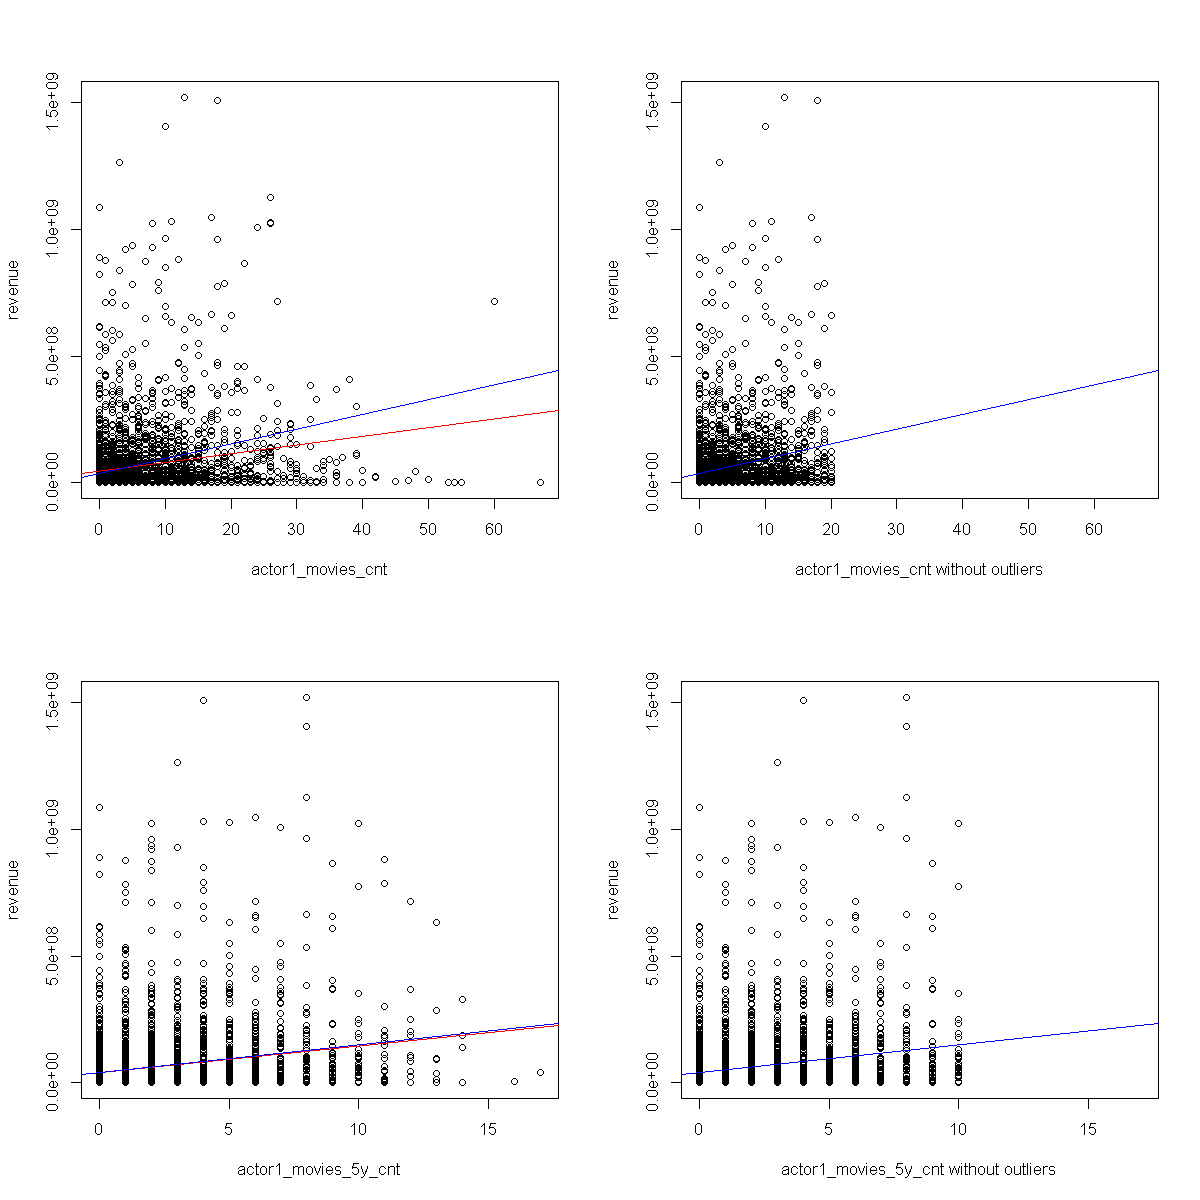

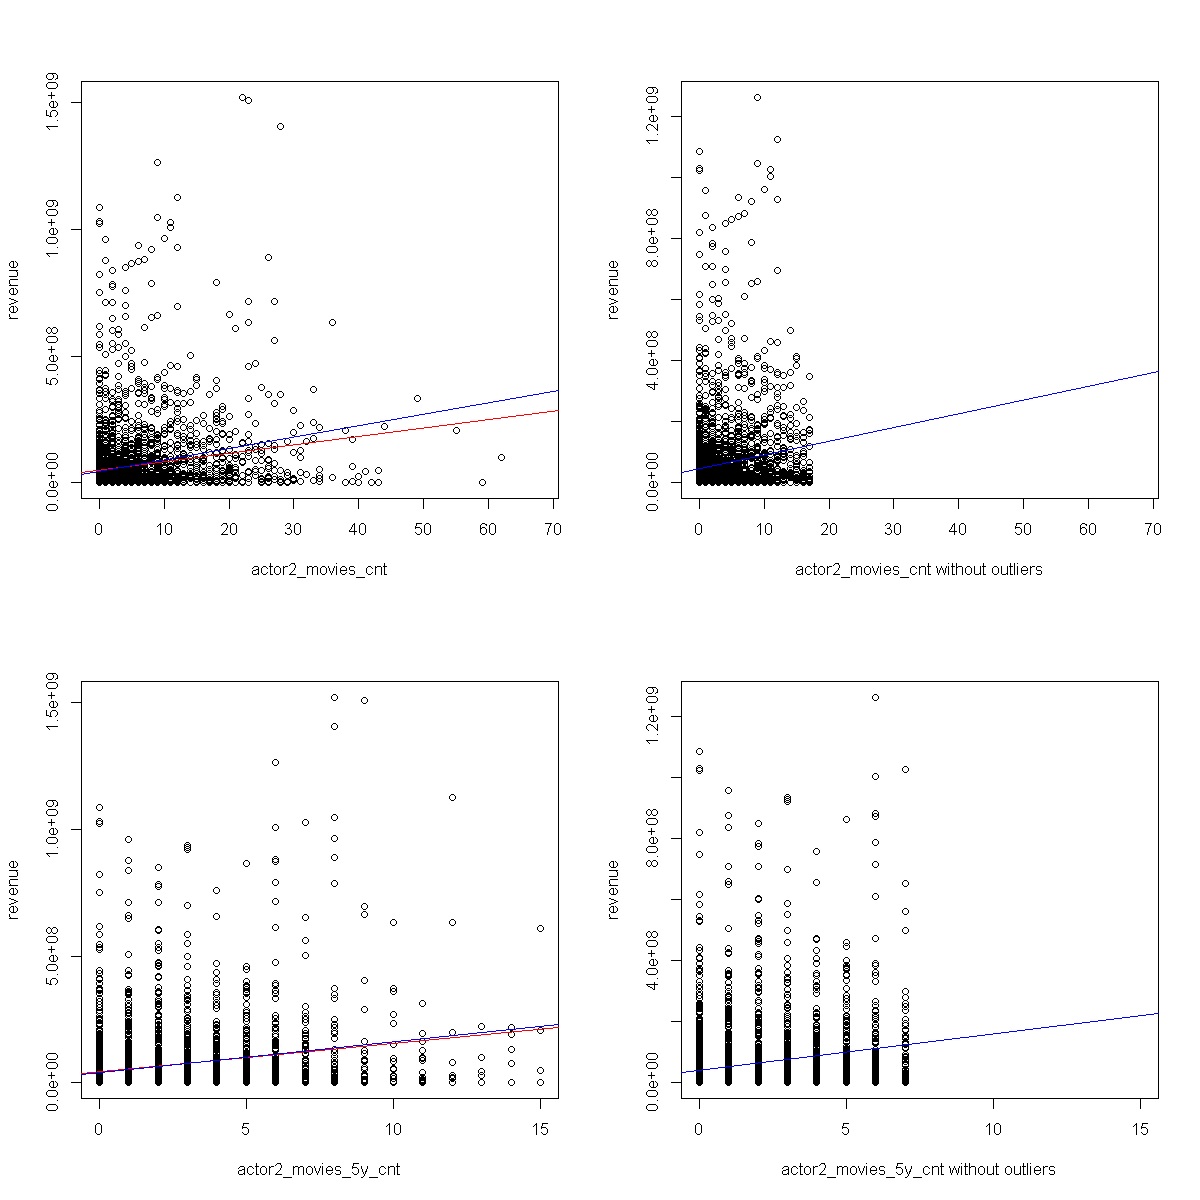

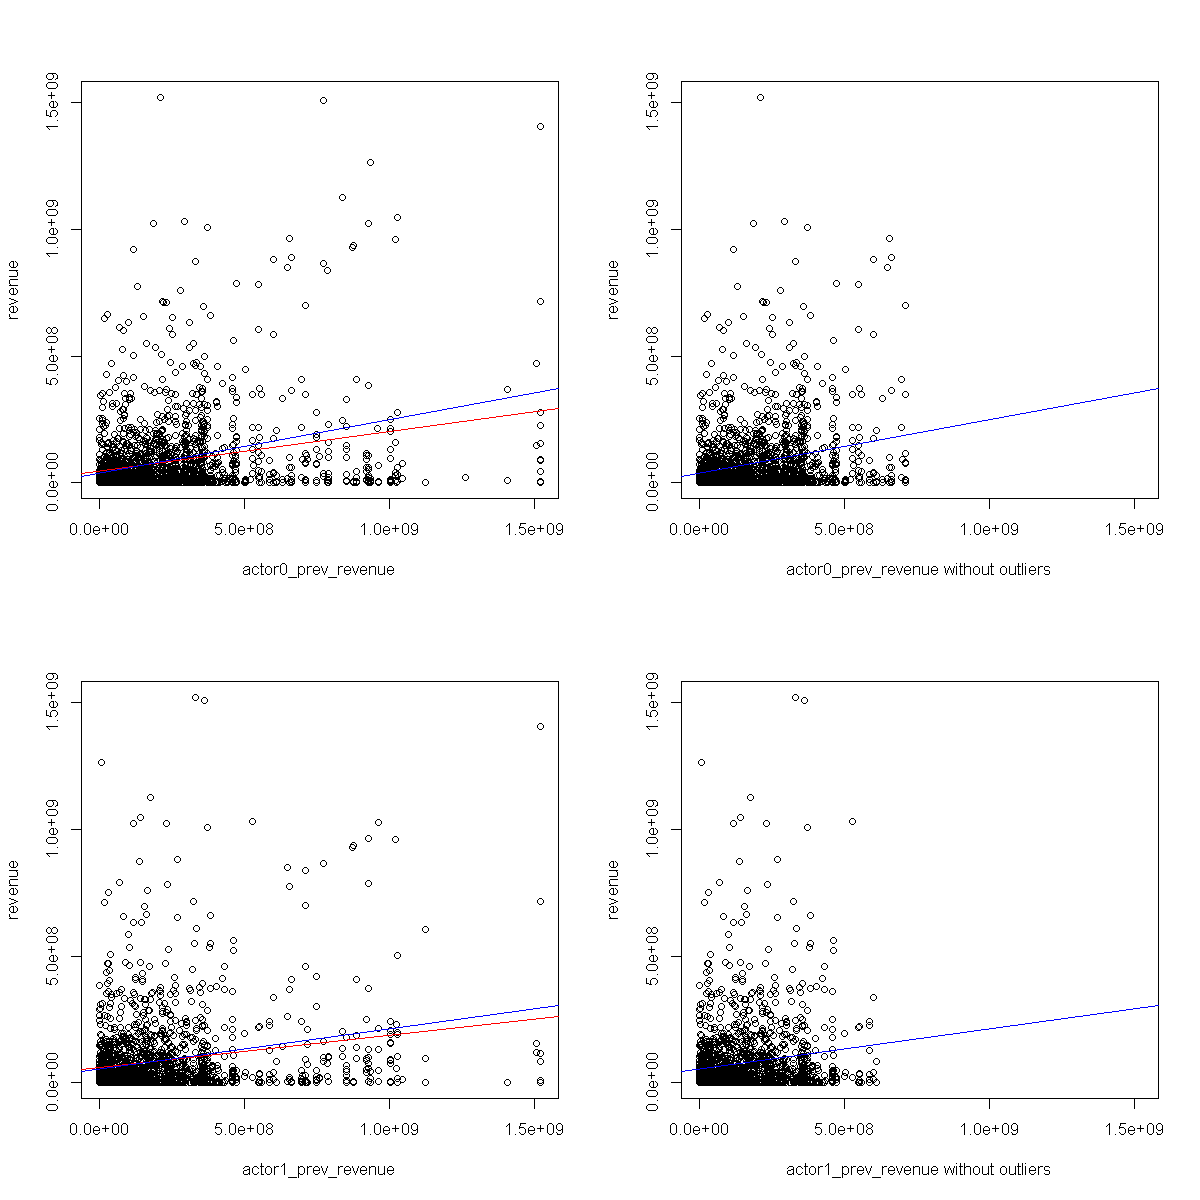

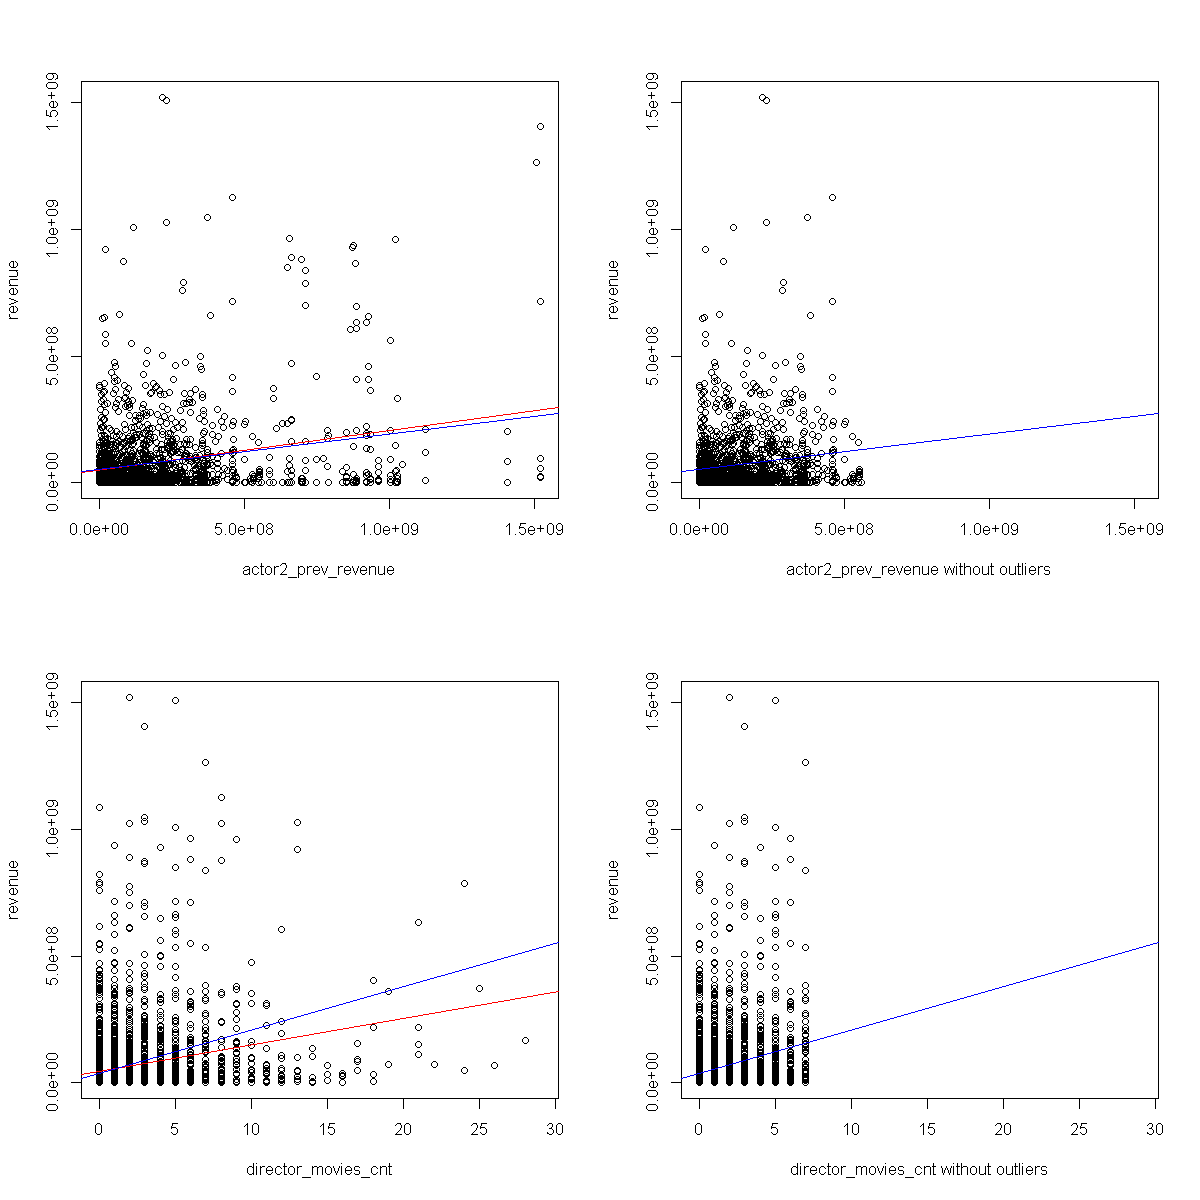

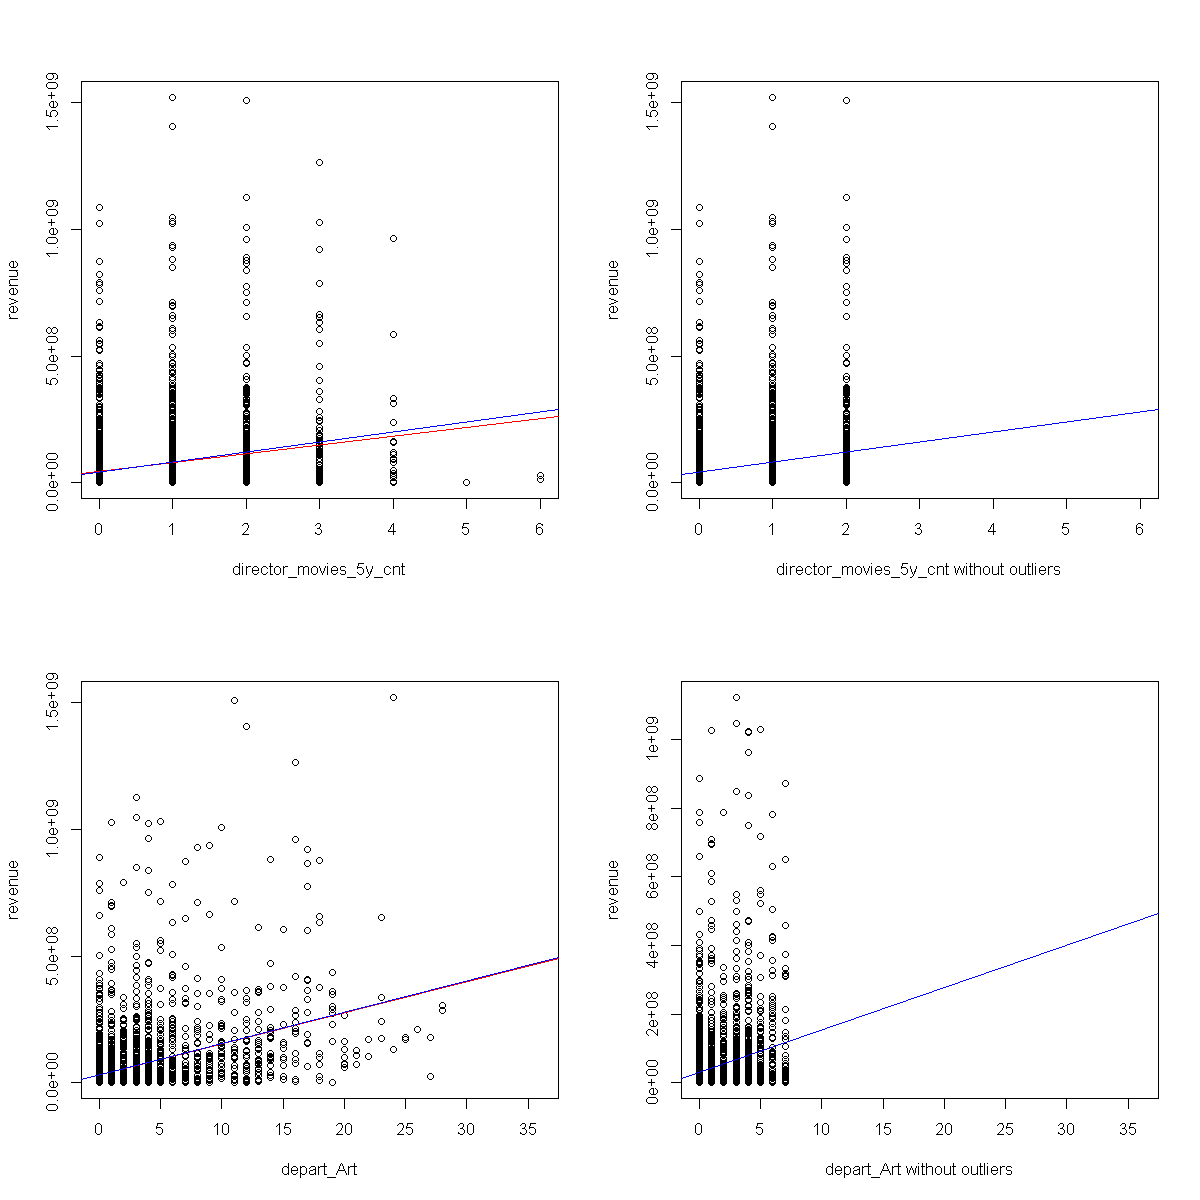

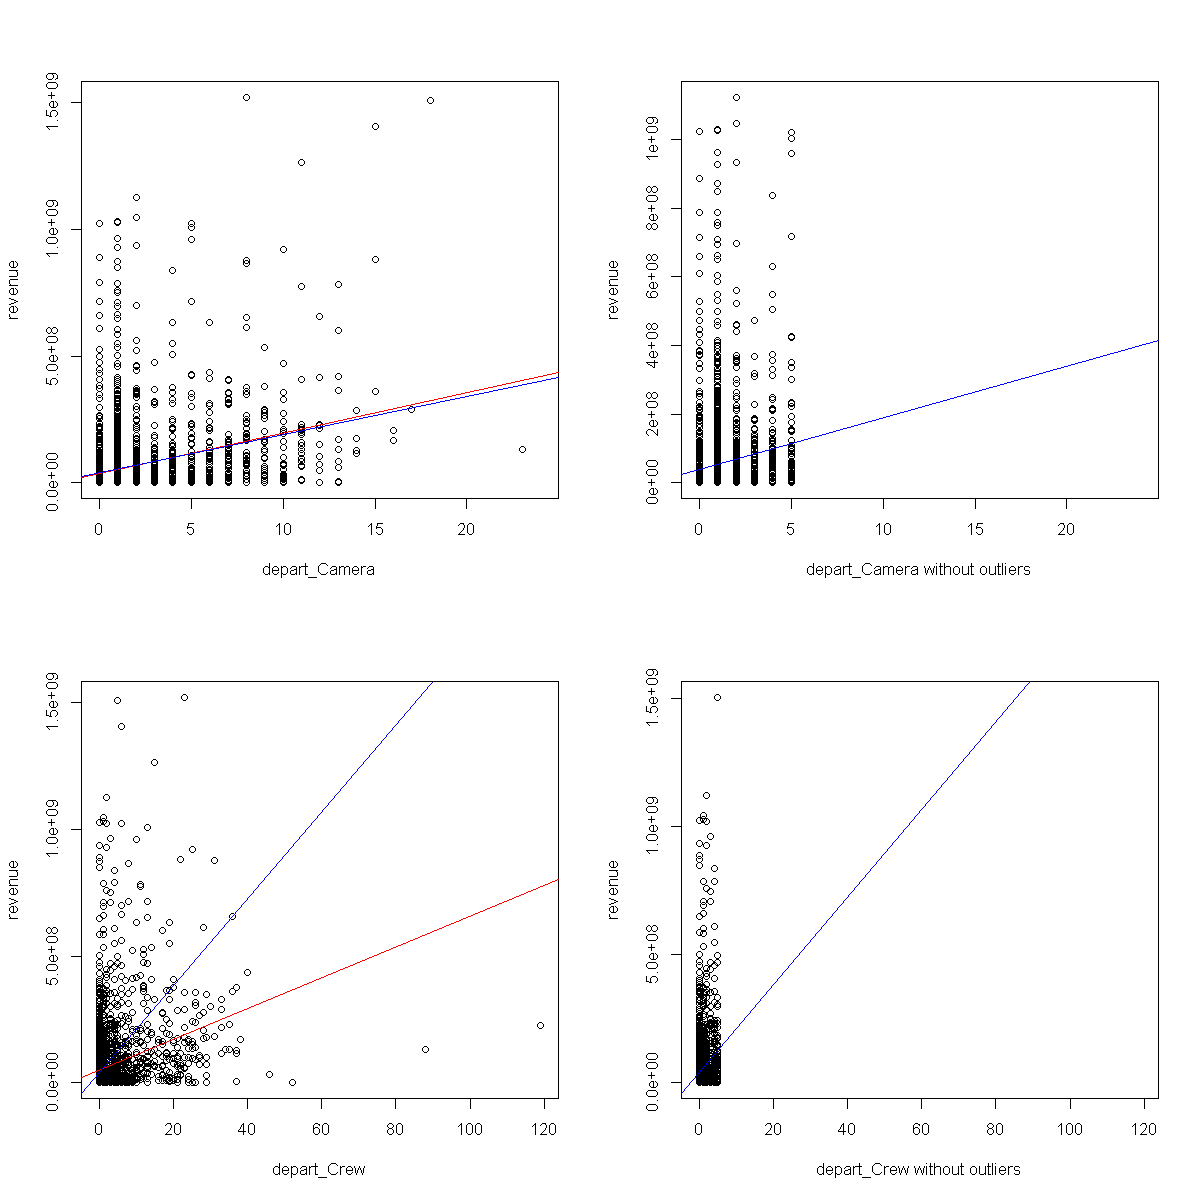

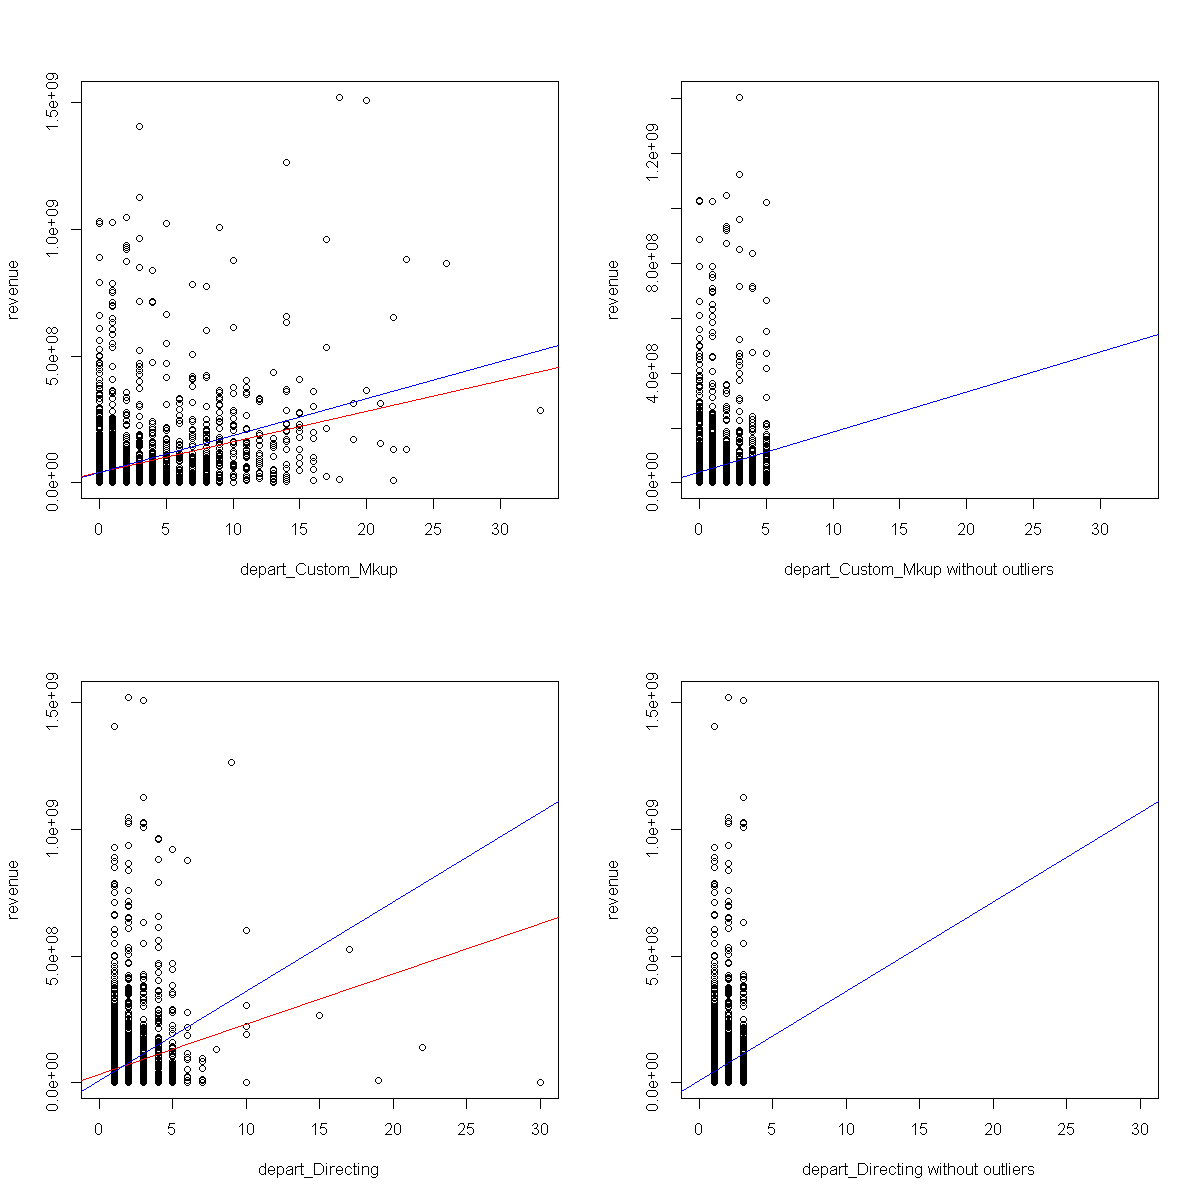

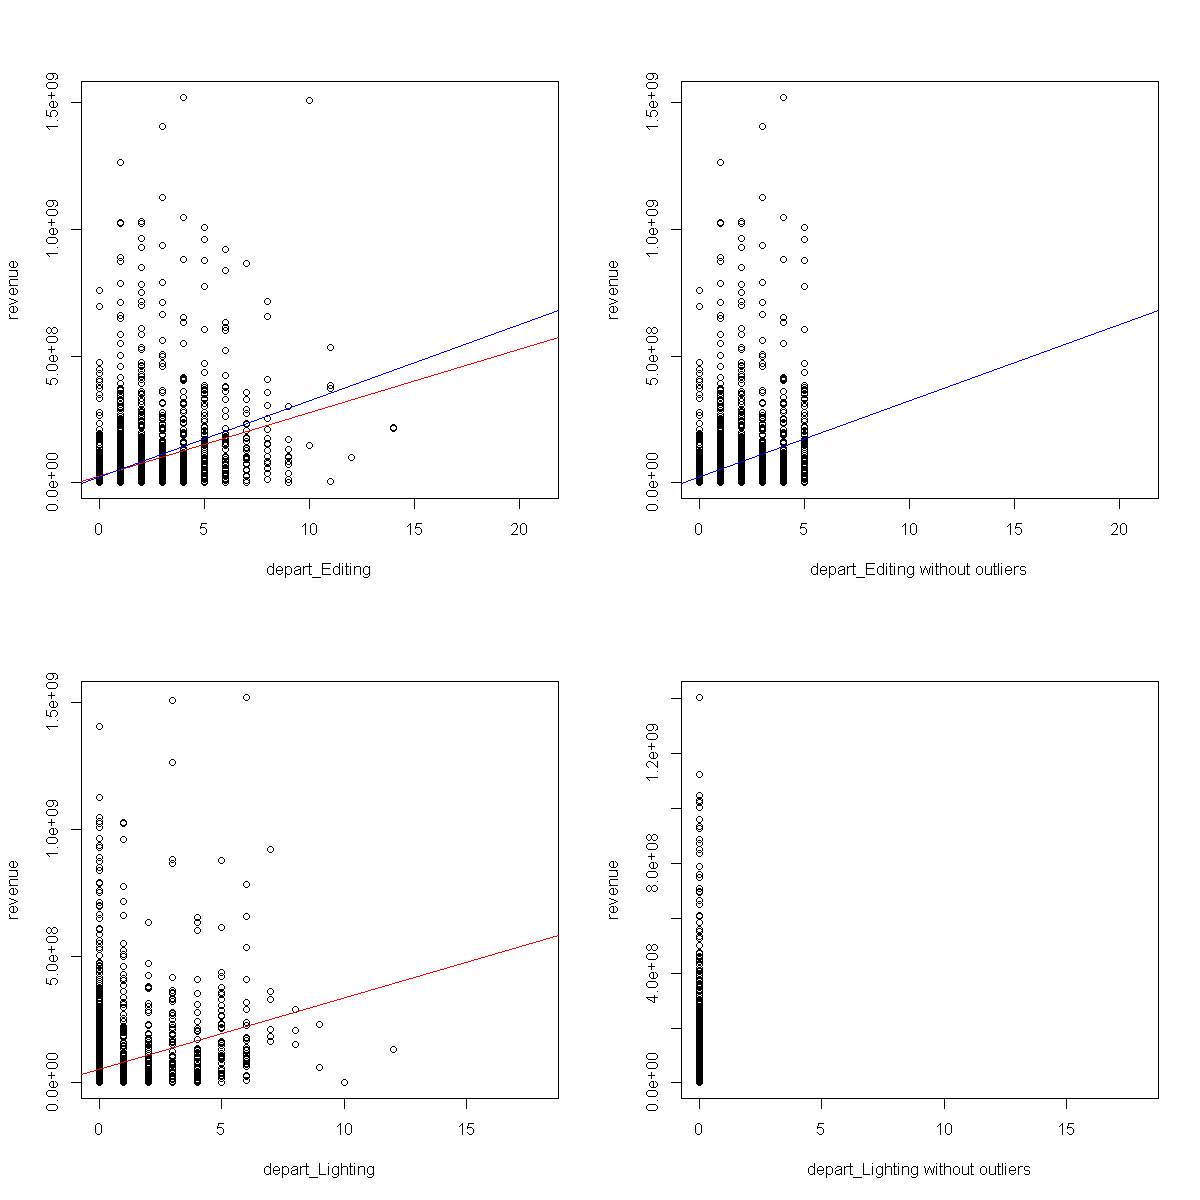

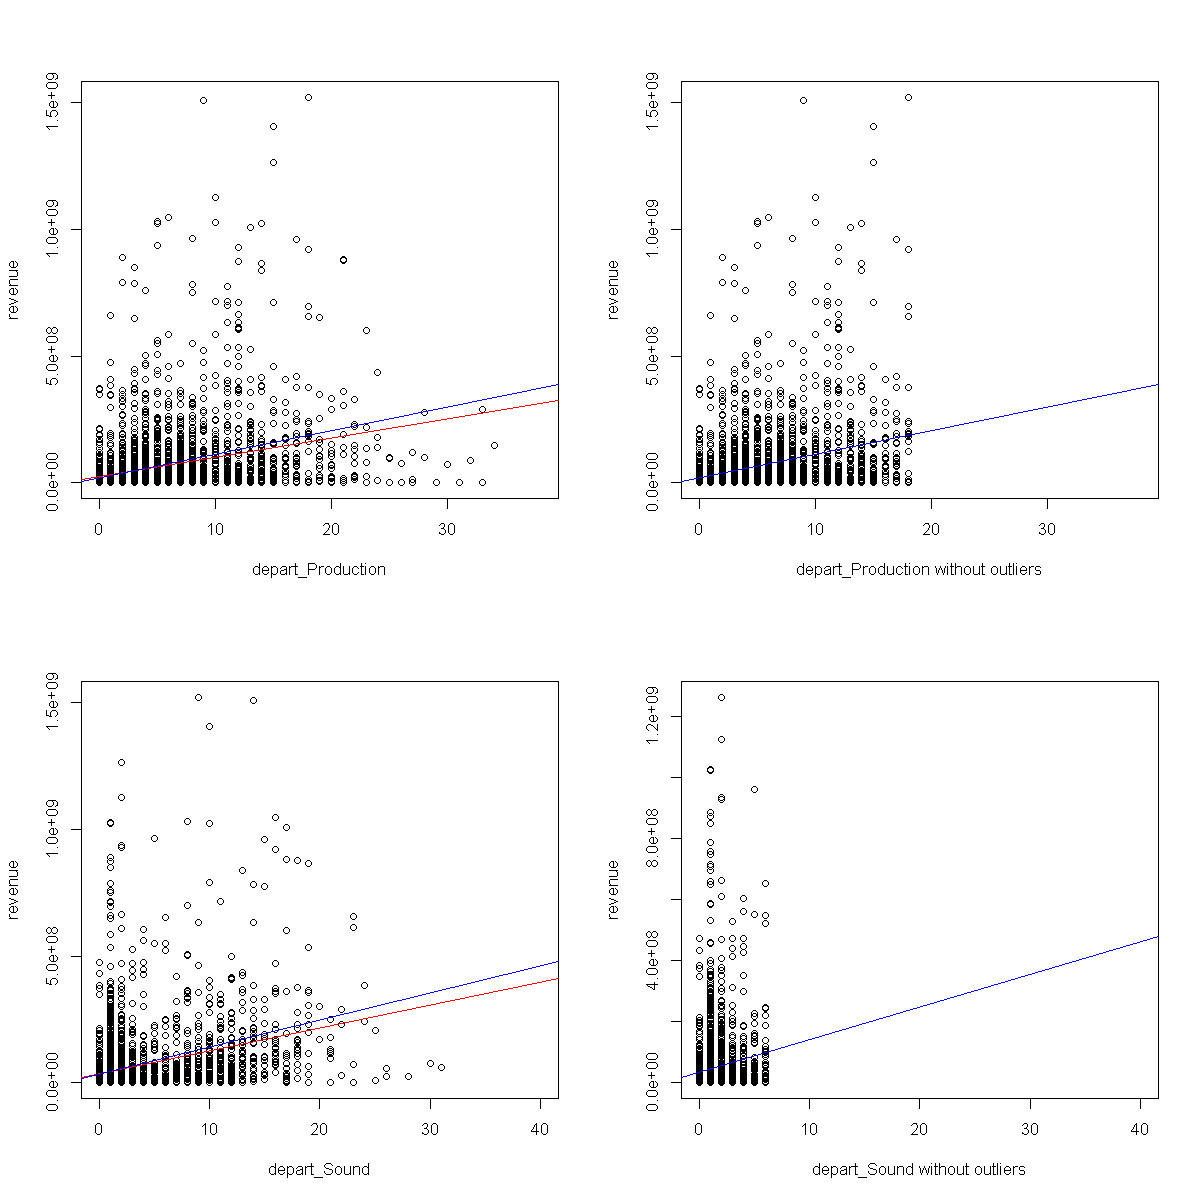

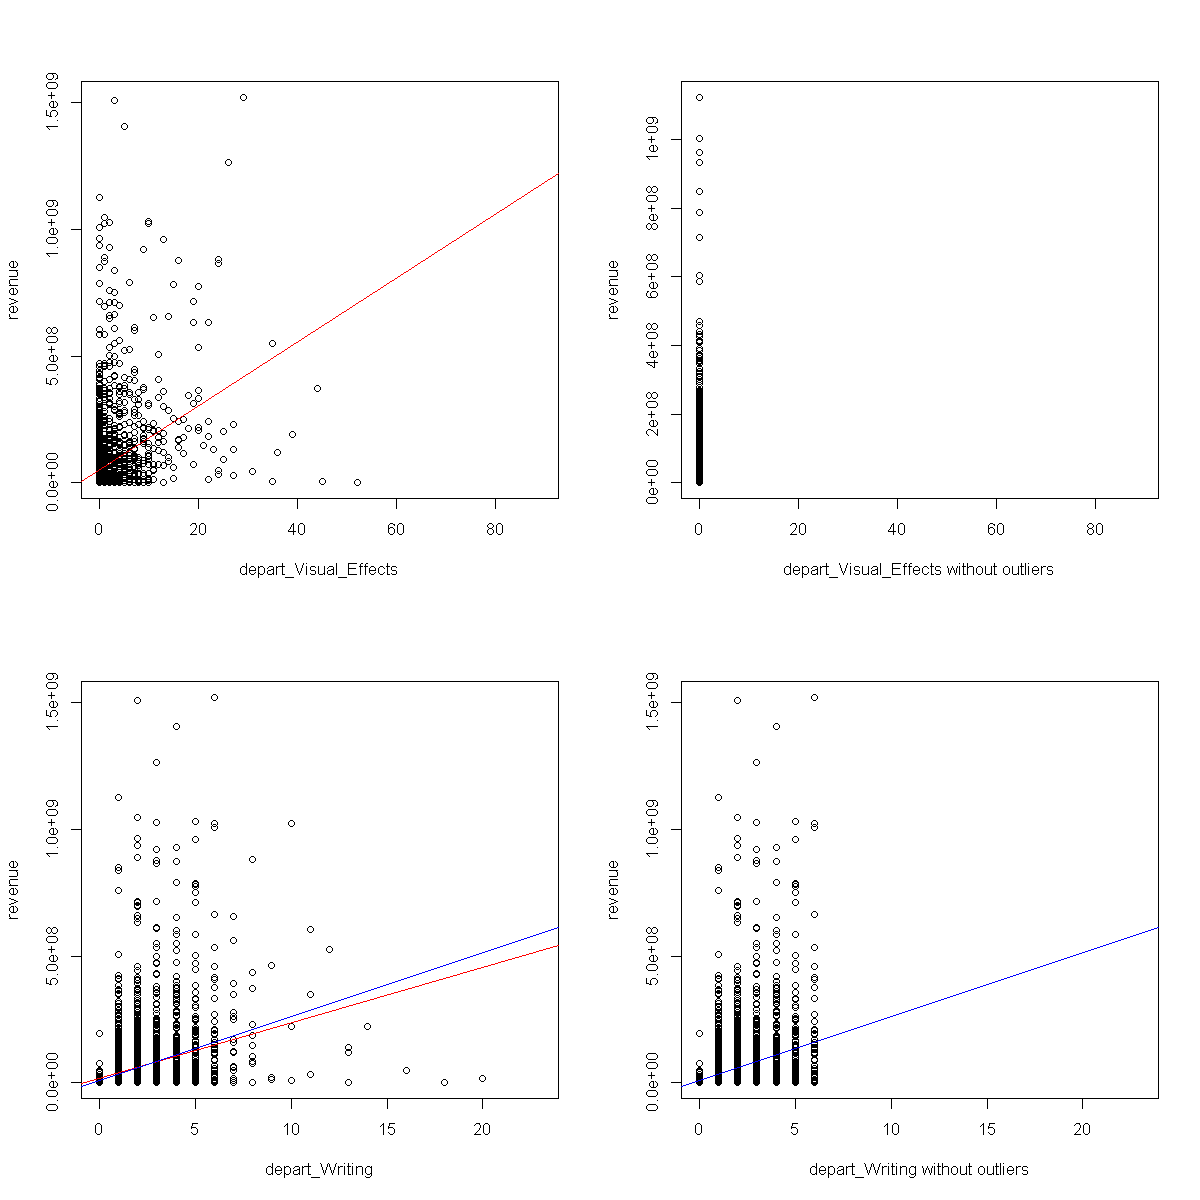

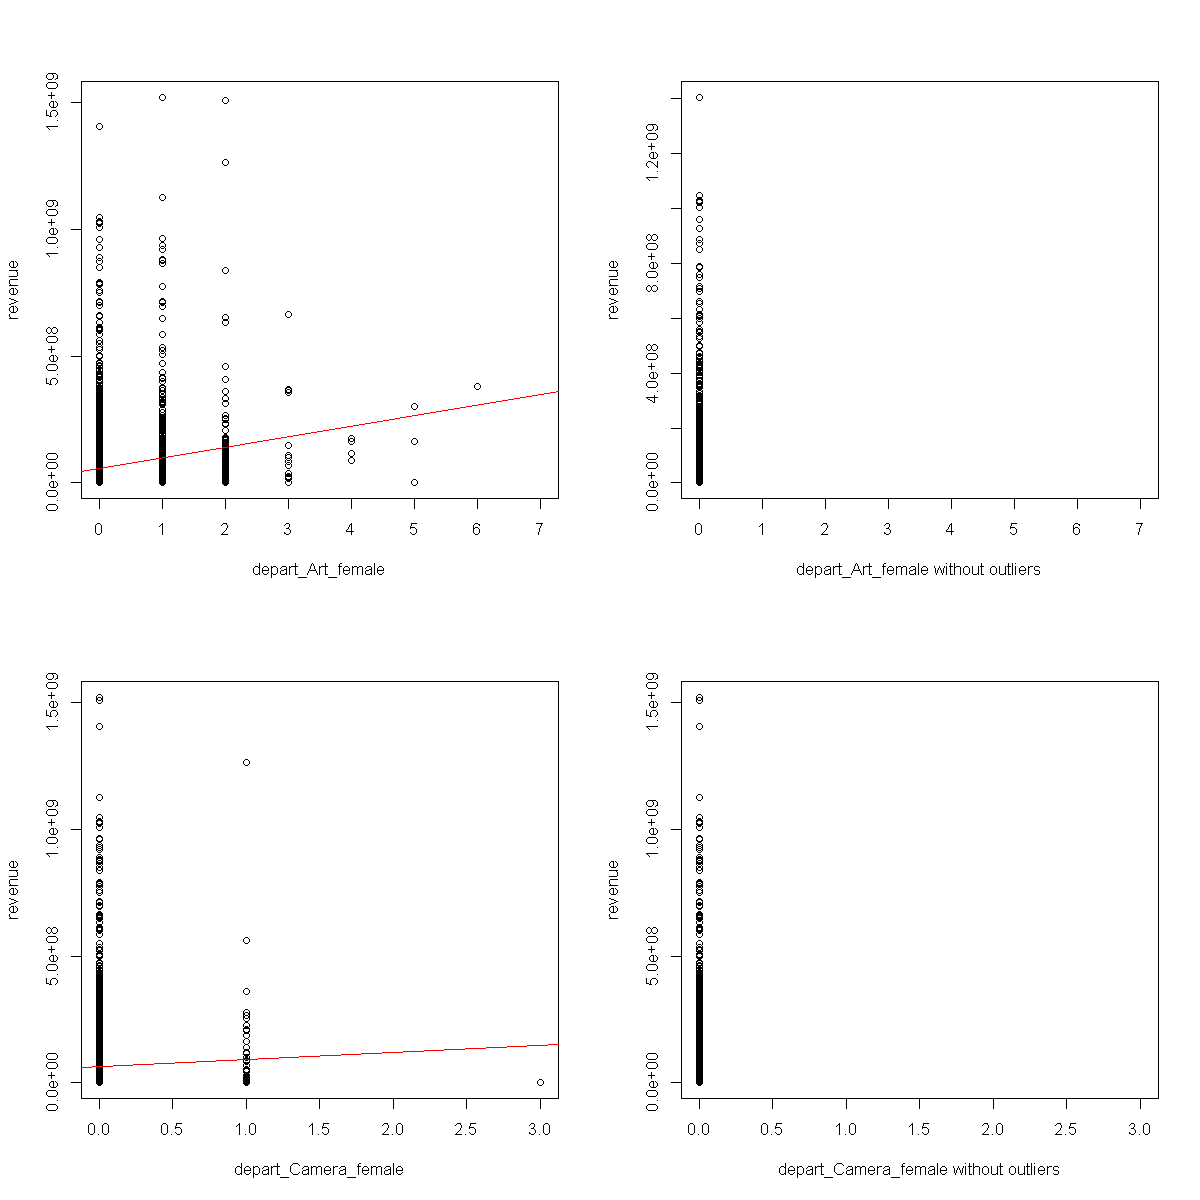

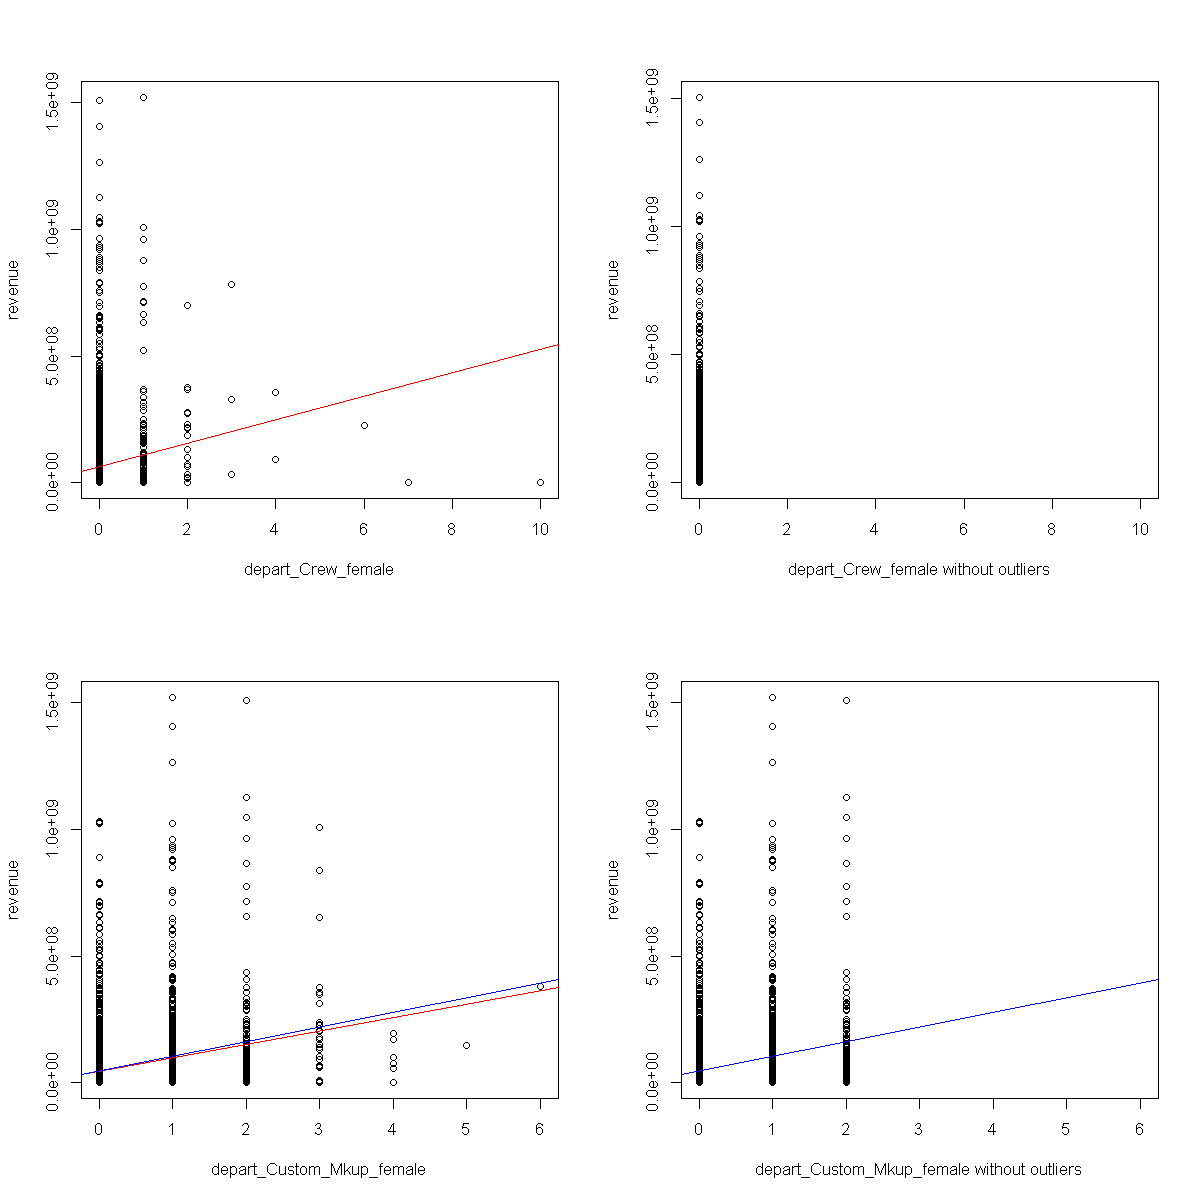

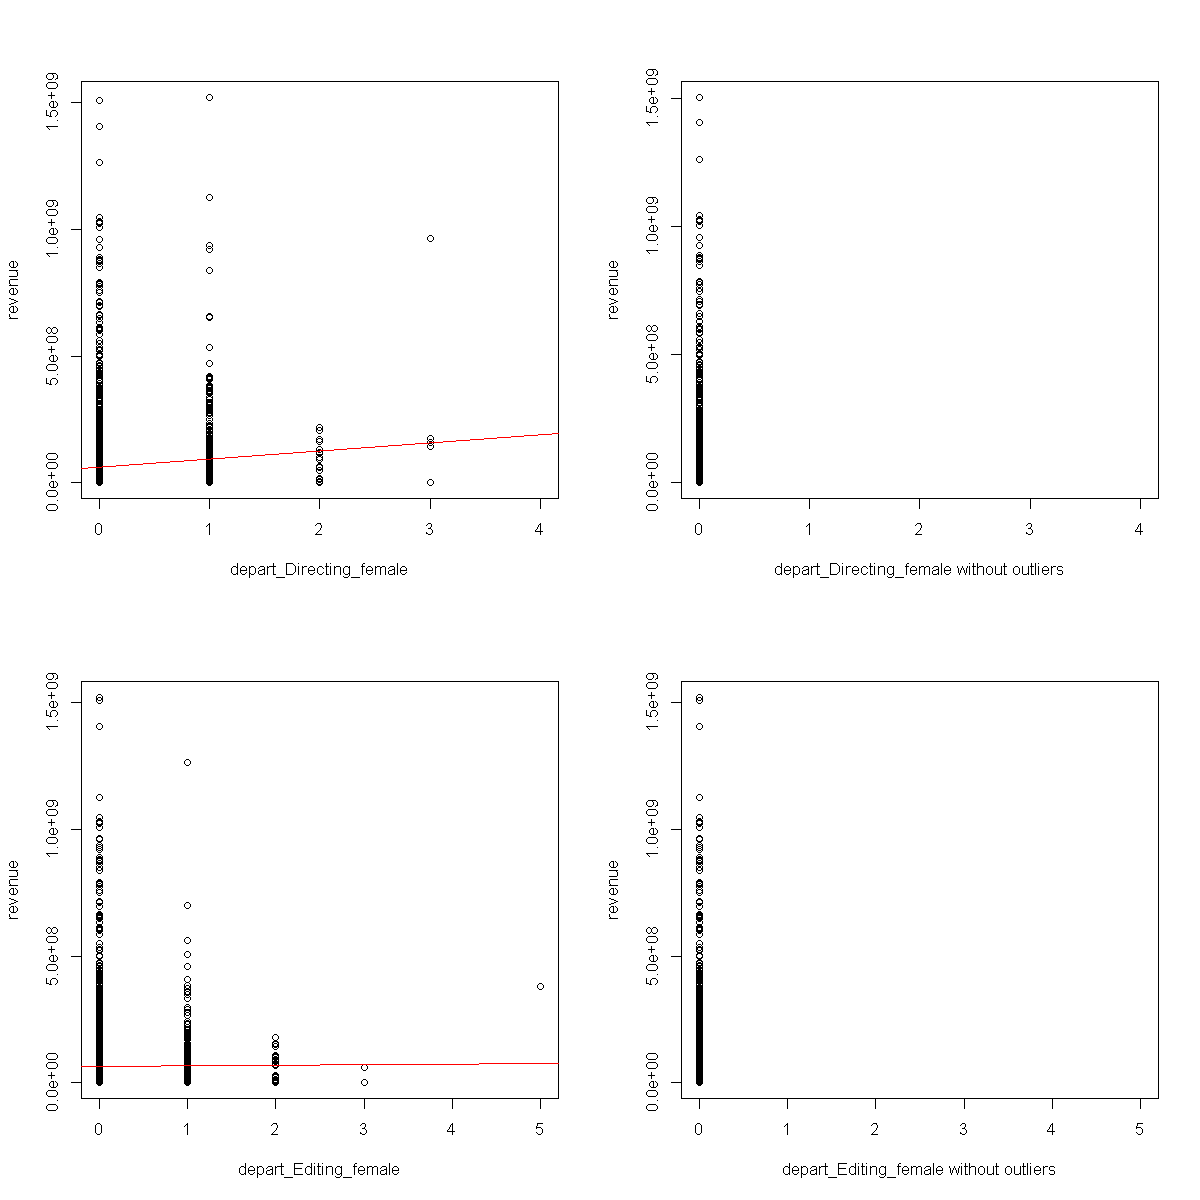

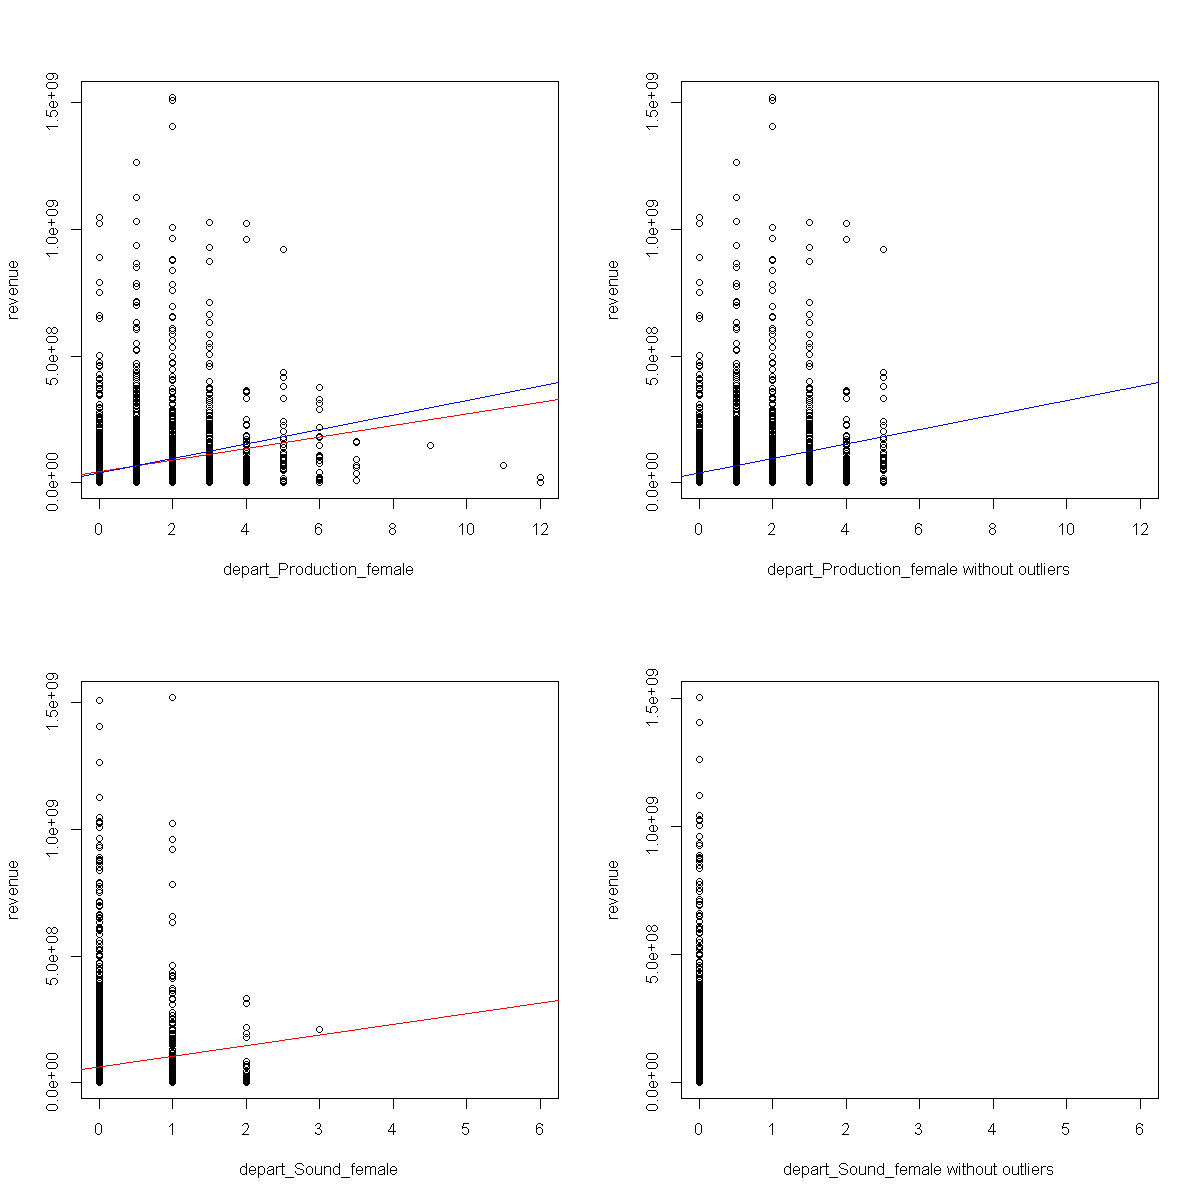

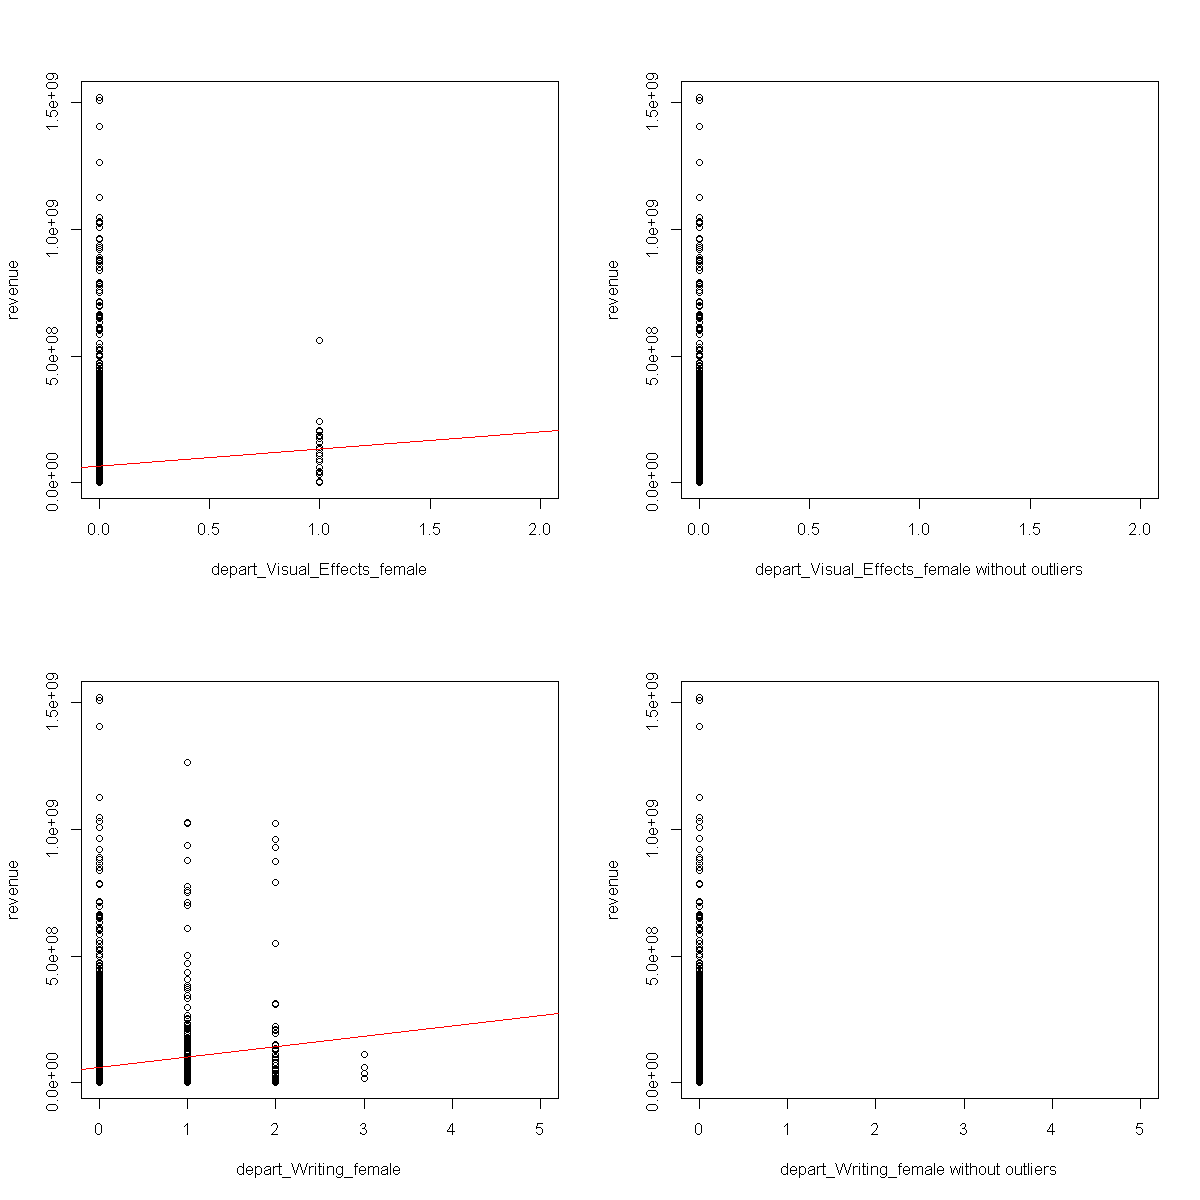

In [85]:
#3.1.2
options(repr.plot.width=10,repr.plot.height=10)
par(mfrow=c(2,2))
for (v in l){
            a<-max(movies_ff_v[[v]],na.rm=TRUE)
            b1<- movies_ff_v %>% select(revenue,v)   
            b2<-movies_ff_v %>% select(revenue,v) %>% filter(movies.out[[paste(v,'out',sep='_')]]==0) 
            plot(b1[[v]],b1$revenue,xlab=v,ylab='revenue',xlim=c(0,a))
            abline(coef(lm(b1$revenue~b1[[v]])), col="red")
            if (length(unique(b2[[v]]))!=1){
            abline(coef(lm(b2$revenue~b2[[v]])), col="blue")}
            plot(b2[[v]],b2$revenue,xlab=paste(v,'without outliers',sep=' '),ylab='revenue',xlim=c(0,a))
            if (length(unique(b2[[v]]))!=1){
            abline(coef(lm(b2$revenue~b2[[v]])), col="blue")}
            
}

removing the outliers doesnt affect the assumption at variables:
budget, runtime, producers_cnt, keywords_cnt, actor0_movies_cnt, actor0_movies_5y_cnt, actor1_movies_cnt,
actor1_movies_5y_cnt, actor2_movies_cnt, actor2_movies_5y_cnt, actor0_prev_revenue, actor1_prev_revenue,
actor2_prev_revenue, director_movies_cnt, director_movies_5y_cnt, depart_Art, depart_Directing, depart_Editing,
depart_Production, depart_writing, depart_Custom_Mkup_female

removing the outliers from the data doesnt affect the regression model at features:
* producers_cnt, actor0_movies_cnt, actor0_movies_5y_cnt, actor1_movies_5y_cnt,
,actor2_movies_cnt, actor2_movies_5y_cnt, actor0_prev_revenue, actor1_prev_revenue,
actor2_prev_revenue, director_movies_5y_cnt, depart_Art, depart_Camera, depart_Custom_Mkup,
depart_Editing, depart_Production, depart_Sound, depart_Writing, depart_Custom_Mkup_female,
depart_Production_female 

In [405]:
# i decided to treat these features by convering the outliers to NA values because at some of them 
# reomoving the outliers affects only the result and at some of them removing the outliers affect ony the model
l1<- c('budget','runtime','prodecers_cnt','keywords_cnt','actor0_movies_cnt','actor0_movies_5y_cnt','actor1_movies_cnt',
       'actor1_movies_5y_cnt','actor2_movies_cnt','actor2_movies_5y_cnt','actor0_prev_revenue','actor1_prev_revenue',
'actor2_prev_revenue','director_movies_cnt','director_movies_5y_cnt','depart_Art','depart_Directing','depart_Camera','depart_Custom_Mkup',
'depart_Editing','depart_Production', 'depart_Sound', 'depart_Writing','depart_Custom_Mkup_female',
'depart_Production_female')

In [406]:
outliers_treat = read.csv("../data/outlier_treatment.csv")

In [407]:
outliers_treat <- outliers_treat[1:41,1:4]
outliers_treat

Feature.name                 Scale Outlier.treatment
1  budget                       Ratio drop             
2  popularity                   Ratio Leave            
3  runtime                      Ratio drop             
4  sw_collection                Ratio Leave            
5  producers_cnt                Ratio Null             
6  countries_cnt                Ratio Leave            
7  keywords_cnt                 Ratio drop             
8  actor0_movies_cnt            Ratio drop             
9  actor0_movies_5y_cnt         Ratio drop             
10 actor1_movies_cnt            Ratio drop             
11 actor1_movies_5y_cnt         Ratio drop             
12 actor2_movies_cnt            Ratio drop             
13 actor2_movies_5y_cnt         Ratio drop             
14 actor0_prev_revenue          Ratio drop             
15 actor1_prev_revenue          Ratio drop             
16 actor2_prev_revenue          Ratio drop             
17 director_movies_cnt          Ratio drop             
18 director_movies_5y_cnt       Ratio drop             
19 depart_Art                   Ratio drop             
20 depart_Camera                Ratio drop             
21 depart_Crew                  Ratio Leave            
22 depart_Custom_Mkup           Ratio drop             
23 depart_Directing             Ratio drop             
24 depart_Editing               Ratio drop             
25 depart_Lighting              Ratio Leave            
26 depart_Production            Ratio drop             
27 depart_Sound                 Ratio drop             
28 depart_Visual_Effects        Ratio Leave            
29 depart_Writing               Ratio drop             
30 depart_Art_female            Ratio Leave            
31 depart_Camera_female         Ratio Leave            
32 depart_Crew_female           Ratio Leave            
33 depart_Custom_Mkup_female    Ratio drop             
34 depart_Directing_female      Ratio Leave            
35 depart_Editing_female        Ratio Leave            
36 depart_Lighting_female       Ratio Leave            
37 depart_Production_female     Ratio drop             
38 depart_Sound_female          Ratio Leave            
39 depart_Visual_Effects_female Ratio Leave            
40 depart_Writing_female        Ratio Leave            
41                                                     
   why                                            
1  doesn't affect assumptions, affects the results
2  affect both assumption and resaults            
3  doesn't affect assumptions, affects the results
4  affect both assumption and resaults            
5  doesn't affect both assumption and resaults    
6  affect both assumption and resaults            
7  doesn't affect assumptions, affects the results
8  doesn't affect both assumption and resaults    
9  doesn't affect both assumption and resaults    
10 doesn't affect assumptions, affects the results
11 doesn't affect both assumption and resaults    
12 doesn't affect both assumption and resaults    
13 doesn't affect both assumption and resaults    
14 doesn't affect both assumption and resaults    
15 doesn't affect both assumption and resaults    
16 doesn't affect both assumption and resaults    
17 doesn't affect assumptions, affects the results
18 doesn't affect both assumption and resaults    
19 doesn't affect both assumption and resaults    
20 affect assumption but doesn't affect resaults  
21 affect both assumption and resaults            
22 affect assumption but doesn't affect resaults  
23 doesn't affect both assumption and resaults    
24 doesn't affect both assumption and resaults    
25 affect both assumption and resaults            
26 doesn't affect both assumption and resaults    
27 affect assumption but doesn't affect results   
28 affect both assumption and resaults            
29 doesn't affect both assumption and resaults    
30 affect both assumption and resaults            
31 affect both assumption and resaults            
32 affect both assu

In [409]:
outlierRepNAMatrix <- function(data,vec,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]]) & (v %in% vec)) {
            med <- median(data[[v]],na.rm = TRUE)
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]]  > outhigh & v!='revenue',NA,data[[v]])
            outdata[v] <- mv
        } else {
            outdata[v] <- data[[v]]
        }
    }
    return(outdata)
}



In [439]:
movies_ff_v1 <- outlierRepNAMatrix(movies_ff_v,l1) 

In [440]:
movies_ff_v1<- movies_ff_v1[,2:86]

In [441]:
movies.miss1<- missingMatrix(movies_ff_v1)

In [442]:
getMissingness(movies_ff_v1)

[[1]]
                   var na.count rate
1              revenue     4382 59.4
2  actor2_prev_revenue     3754 50.9
3  actor1_prev_revenue     3527 47.8
4  actor0_prev_revenue     3033 41.1
5               budget     2406 32.6
6         depart_Sound     1283 17.4
7   depart_Custom_Mkup     1017 13.8
8     sw_female_actor0      934 12.7
9       sw_male_actor0      934 12.7
10    sw_female_actor2      788 10.7

[[2]]
[1] "This dataset has 267 (3.6%) complete rows. Original data has 7375 rows."



$missingness
                            var na.count rate
1                       revenue     4382 59.4
2           actor2_prev_revenue     3754 50.9
3           actor1_prev_revenue     3527 47.8
4           actor0_prev_revenue     3033 41.1
5                        budget     2406 32.6
6                  depart_Sound     1283 17.4
7            depart_Custom_Mkup     1017 13.8
8              sw_female_actor0      934 12.7
9                sw_male_actor0      934 12.7
10             sw_female_actor2      788 10.7
11               sw_male_actor2      788 10.7
12             sw_female_actor1      782 10.6
13               sw_male_actor1      782 10.6
14                   depart_Art      727  9.9
15                depart_Camera      704  9.5
16             depart_Directing      513  7.0
17            actor2_movies_cnt      507  6.9
18          director_movies_cnt      427  5.8
19            actor1_movies_cnt      411  5.6
20                producers_cnt      395  5.4
21               depart_Editing      361  4.9
22       director_movies_5y_cnt      350  4.7
23         actor2_movies_5y_cnt      345  4.7
24            actor0_movies_cnt      306  4.1
25                      runtime      280  3.8
26                 keywords_cnt      278  3.8
27            depart_Production      249  3.4
28               depart_Writing      176  2.4
29         actor1_movies_5y_cnt      132  1.8
30    depart_Custom_Mkup_female      130  1.8
31     depart_Production_female      111  1.5
32         actor0_movies_5y_cnt       52  0.7
33                  depart_Crew       34  0.5
34              depart_Lighting       34  0.5
35        depart_Visual_Effects       34  0.5
36            depart_Art_female       34  0.5
37         depart_Camera_female       34  0.5
38           depart_Crew_female       34  0.5
39      depart_Directing_female       34  0.5
40        depart_Editing_female       34  0.5
41       depart_Lighting_female       34  0.5
42          depart_Sound_female       34  0.5
43 depart_Visual_Effects_female       34  0.5
44        depart_Writing_female       34  0.5
45                 release_date        1  0.0
46                 release_year        1  0.0
47                release_month        1  0.0
48                  release_day        1  0.0
49                  seasonality        1  0.0

$message
[1] "This dataset has 267 (3.6%) complete rows. Original data has 7375 rows."

$rows
NULL

In [443]:
summary(movies_ff_v1)

    movie_id        budget         original_language    popularity     
 Min.   :   1   Min.   :       1   Length:7375        Min.   :  0.000  
 1st Qu.:1848   1st Qu.: 5000000   Class :character   1st Qu.:  3.970  
 Median :3696   Median :15000000   Mode  :character   Median :  7.456  
 Mean   :3698   Mean   :22138207                      Mean   :  8.540  
 3rd Qu.:5550   3rd Qu.:32000000                      3rd Qu.: 10.932  
 Max.   :7398   Max.   :92000000                      Max.   :547.488  
                NA's   :2406                                           
  release_date           runtime      runtime_cat           revenue         
 Min.   :1918-08-01   Min.   : 59.0   Length:7375        Min.   :1.000e+00  
 1st Qu.:1992-11-13   1st Qu.: 94.0   Class :character   1st Qu.:2.405e+06  
 Median :2004-07-29   Median :103.0   Mode  :character   Median :1.693e+07  
 Mean   :2000-03-15   Mean   :105.9                      Mean   :6.688e+07  
 3rd Qu.:2011-06-27   3rd Qu.:116.0    

In [444]:
##creating vector of coninuous features with more than 5 percent NA values 
l2 <- c()
for (i in l){
    if (sum(is.na(movies_ff_v1[[i]])*100/7375)>=5){
        l2<-c(l2,i)
    }
}

In [445]:
##creating vector of coninuous features with less than 5 percent NA values
l3 <- c()
for (i in l){
    if (sum(is.na(movies_ff_v1[[i]])*100/7375)<5){
        l3<-c(l3,i)
    }
}

In [446]:
##creating vector of categorical features with  NA values
l4 <- c()
for (i in cn){
    if (sum(is.na(movies_ff_v1[[i]]))>0){
        l4<-c(l4,i)
    }
}

In [447]:
## with these feature i am going to check the missingness mechanism
l2

[1] "budget"              "producers_cnt"       "actor1_movies_cnt"  
 [4] "actor2_movies_cnt"   "actor0_prev_revenue" "actor1_prev_revenue"
 [7] "actor2_prev_revenue" "director_movies_cnt" "depart_Art"         
[10] "depart_Camera"       "depart_Custom_Mkup"  "depart_Directing"   
[13] "depart_Sound"

In [448]:
#vector of the continuous features with less than 5 percent of missing values- the NA treatment 
##for these features will be remove rows with NA values 
l3

[1] "popularity"                   "runtime"                     
 [3] "keyword_cnt"                  "sw_collection"               
 [5] "countries_cnt"                "keywords_cnt"                
 [7] "actor0_movies_cnt"            "actor0_movies_5y_cnt"        
 [9] "actor1_movies_5y_cnt"         "actor2_movies_5y_cnt"        
[11] "director_movies_5y_cnt"       "depart_Crew"                 
[13] "depart_Editing"               "depart_Lighting"             
[15] "depart_Production"            "depart_Visual_Effects"       
[17] "depart_Writing"               "depart_Art_female"           
[19] "depart_Camera_female"         "depart_Crew_female"          
[21] "depart_Custom_Mkup_female"    "depart_Directing_female"     
[23] "depart_Editing_female"        "depart_Production_female"    
[25] "depart_Sound_female"          "depart_Visual_Effects_female"
[27] "depart_Writing_female"

In [420]:
#vector of the categoric features with missing values
l4

[1] "release_date"           "release_year"           "release_month"         
 [4] "release_day"            "sw_female_actor0"       "sw_female_actor1"      
 [7] "sw_female_actor2"       "sw_male_actor0"         "sw_male_actor1"        
[10] "sw_male_actor2"         "depart_Lighting_female"

Warning message:
"Removed 395 rows containing non-finite values (stat_density)."



	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 3.3345, df = 4195, p-value = 0.0008618
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.07619678 0.29364057
sample estimates:
mean of x mean of y 
 2.965596  2.780678 

[1] "producers_cnt by NA budget"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


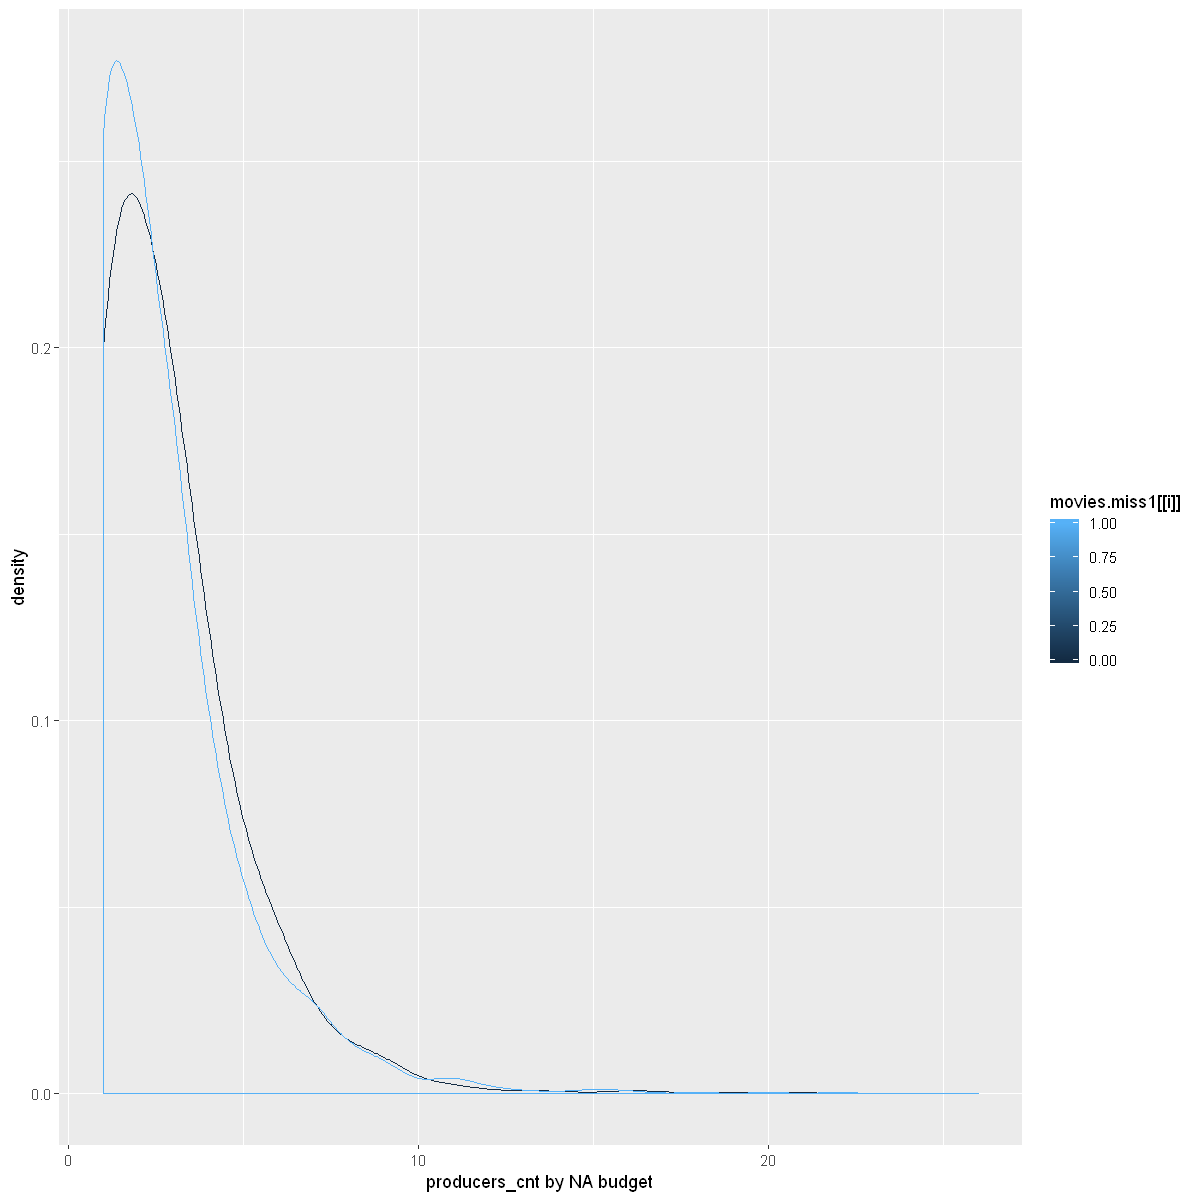


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 7.8239, df = 4947.1, p-value = 6.215e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.7292912 1.2169636
sample estimates:
mean of x mean of y 
 4.386048  3.412920 

[1] "actor1_movies_cnt by NA budget"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


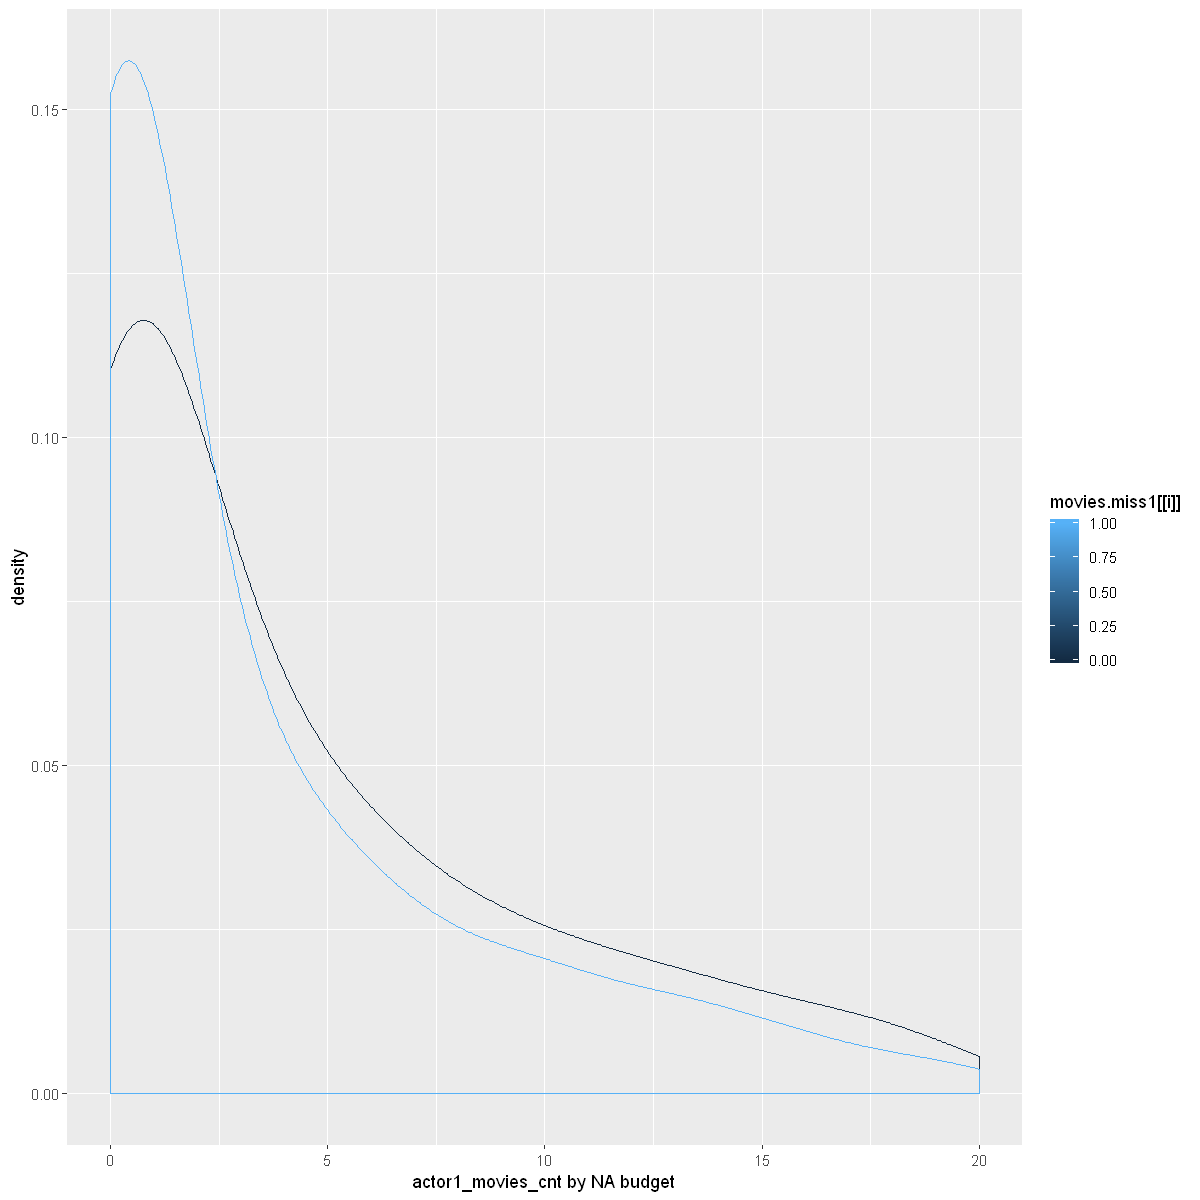


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 7.4384, df = 4824.2, p-value = 1.2e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.5799918 0.9951278
sample estimates:
mean of x mean of y 
 3.546811  2.759251 

[1] "actor2_movies_cnt by NA budget"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


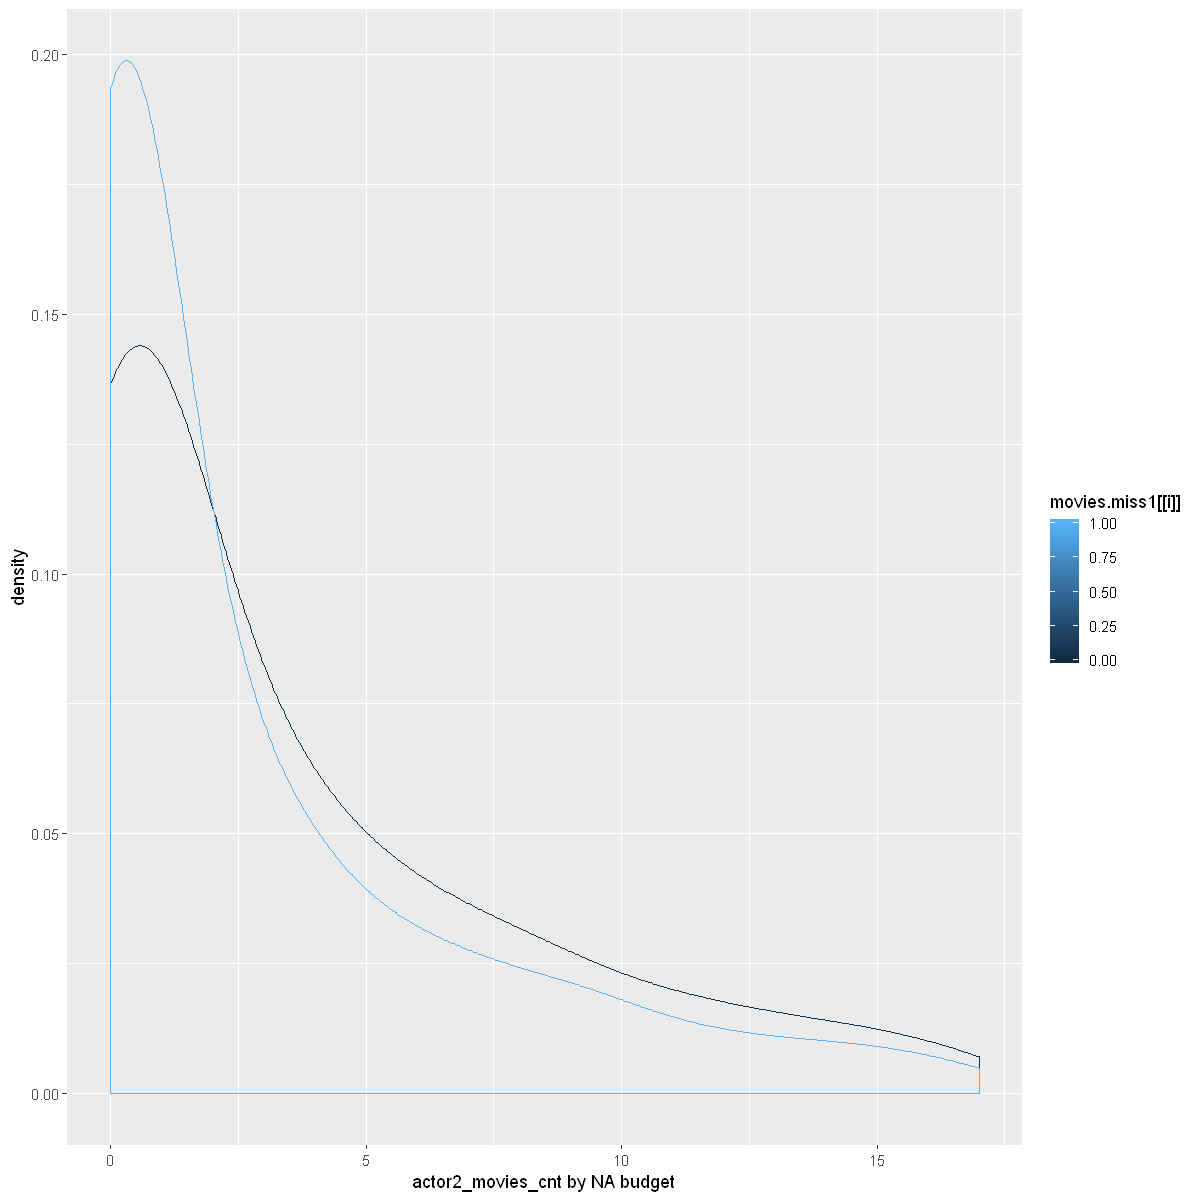


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 1.2384, df = 2139, p-value = 0.2157
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3953073 17501572
sample estimates:
mean of x mean of y 
176856868 170082619 

[1] "actor0_prev_revenue by NA budget"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


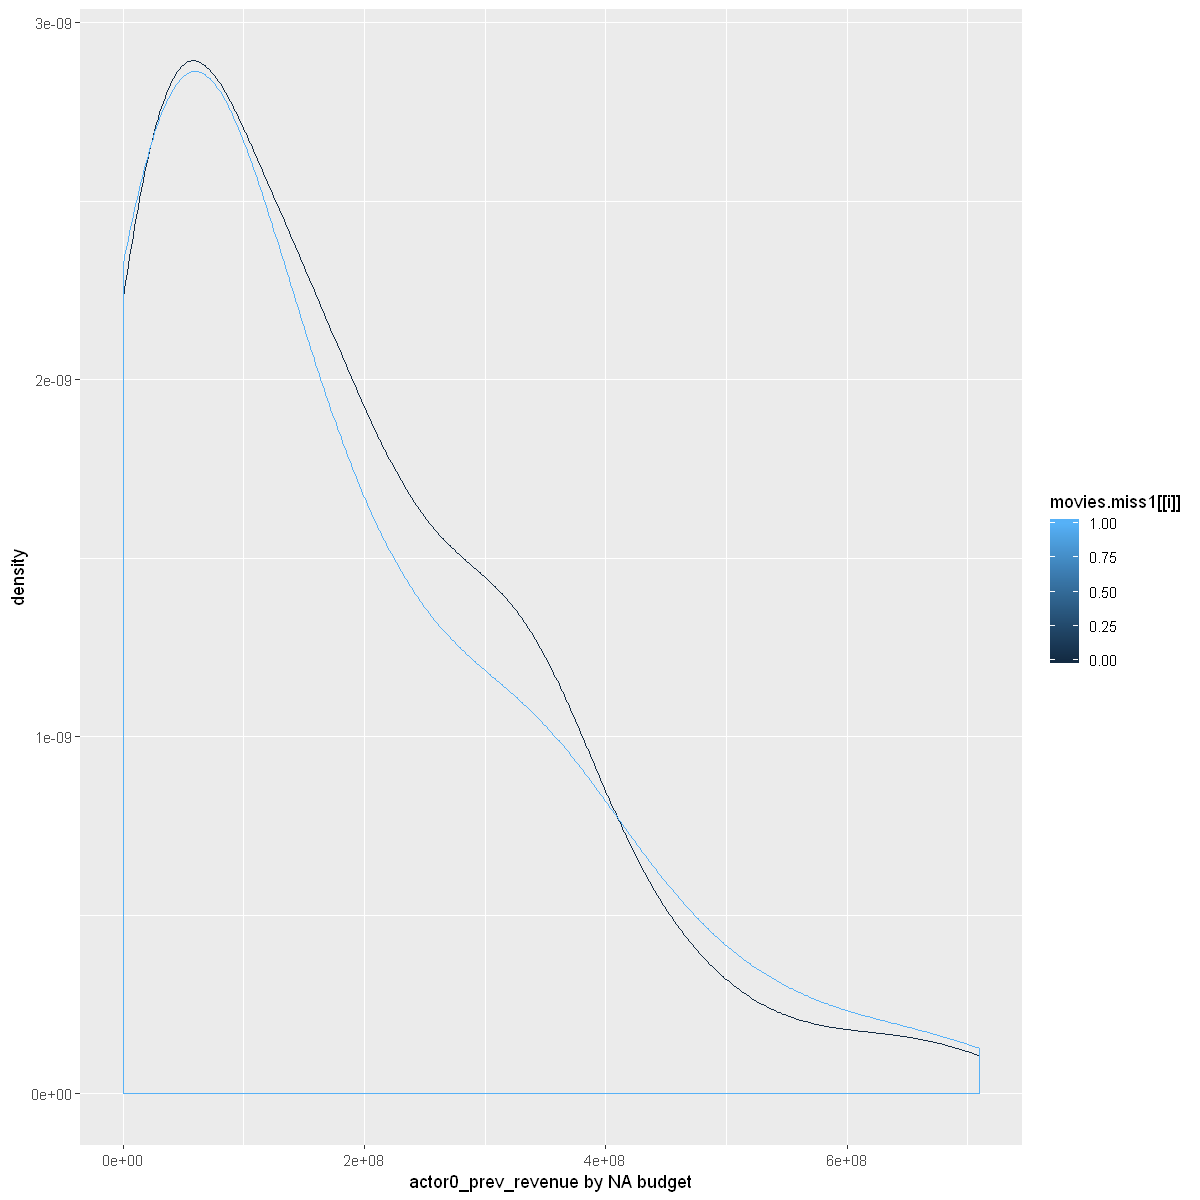


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 2.5156, df = 1924.3, p-value = 0.01196
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  2702477 21822043
sample estimates:
mean of x mean of y 
148645816 136383556 

[1] "actor1_prev_revenue by NA budget"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


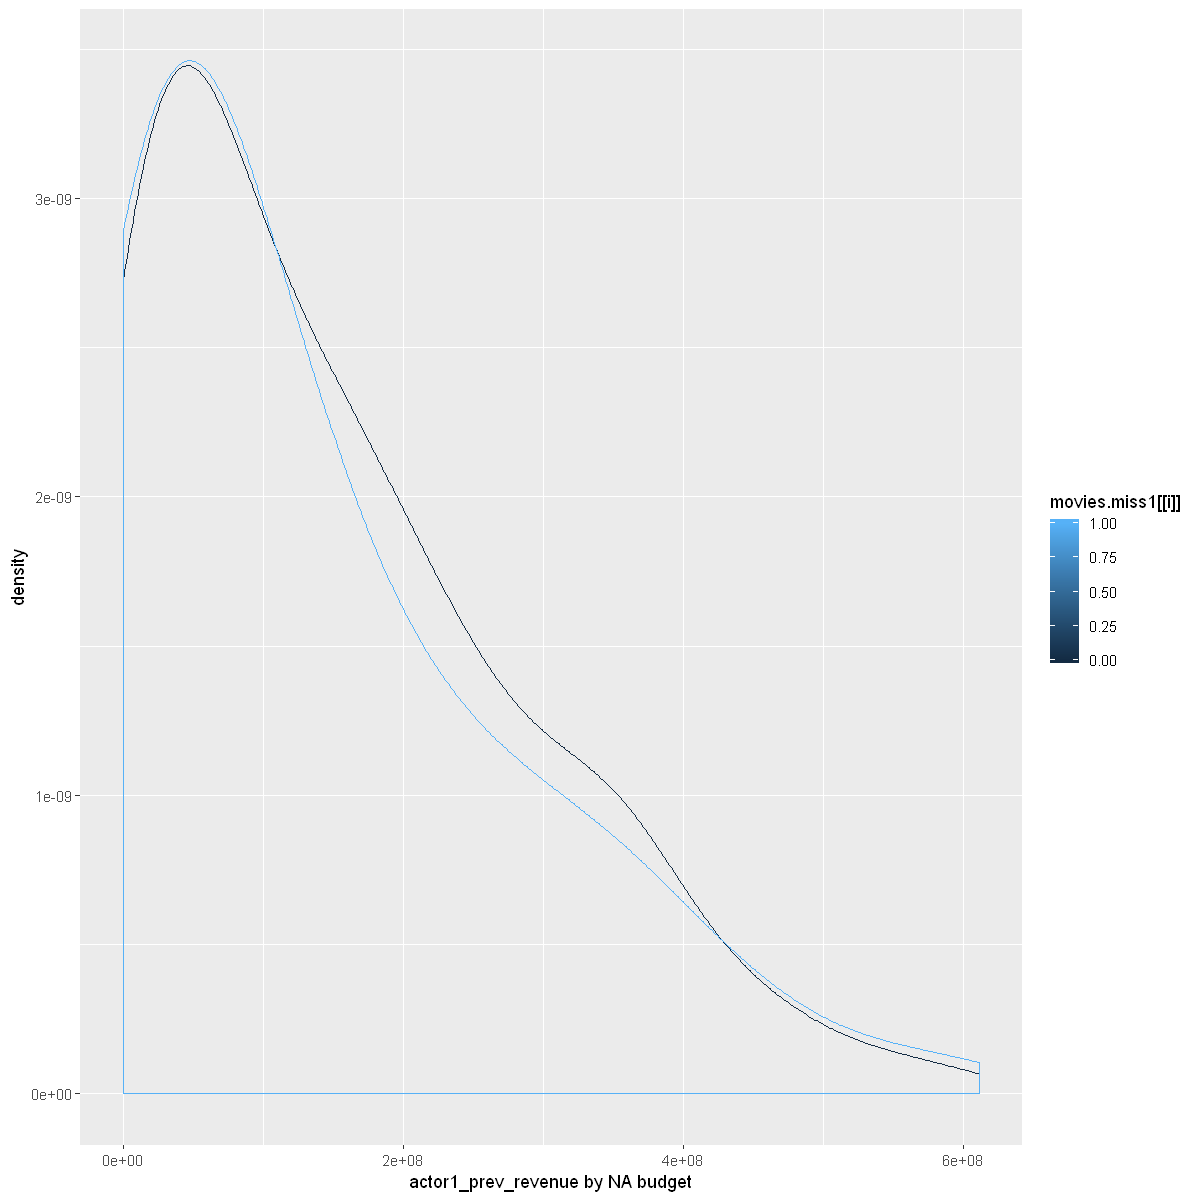


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 1.1409, df = 1824, p-value = 0.2541
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3879770 14670327
sample estimates:
mean of x mean of y 
135313487 129918209 

[1] "actor2_prev_revenue by NA budget"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


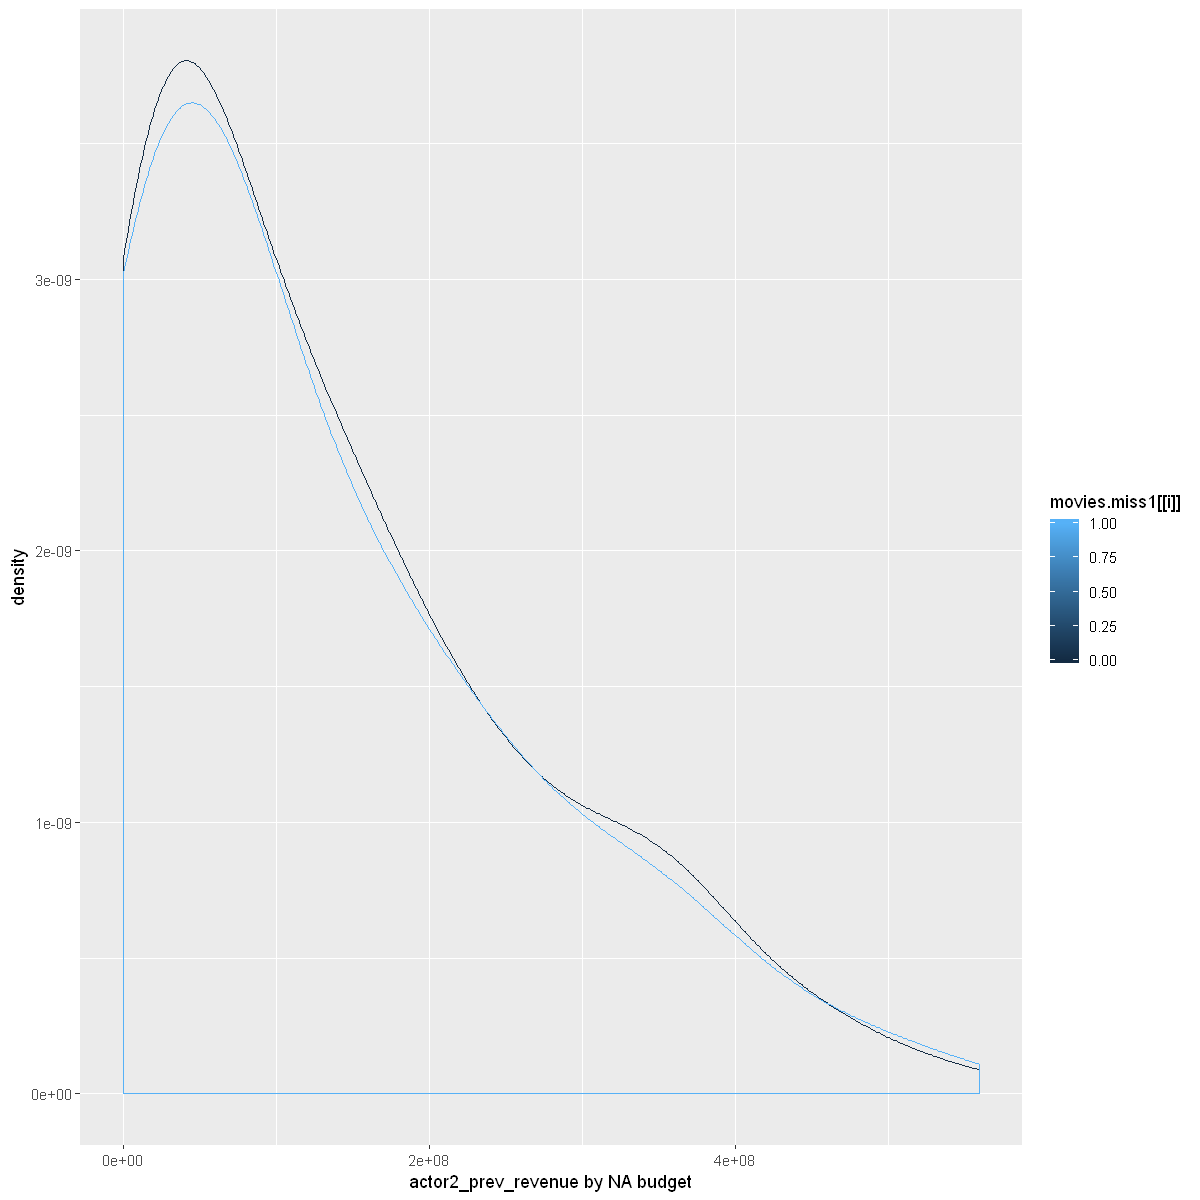


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.3649, df = 4722.1, p-value = 8.485e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1546714 0.3328070
sample estimates:
mean of x mean of y 
 1.435017  1.191278 

[1] "director_movies_cnt by NA budget"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


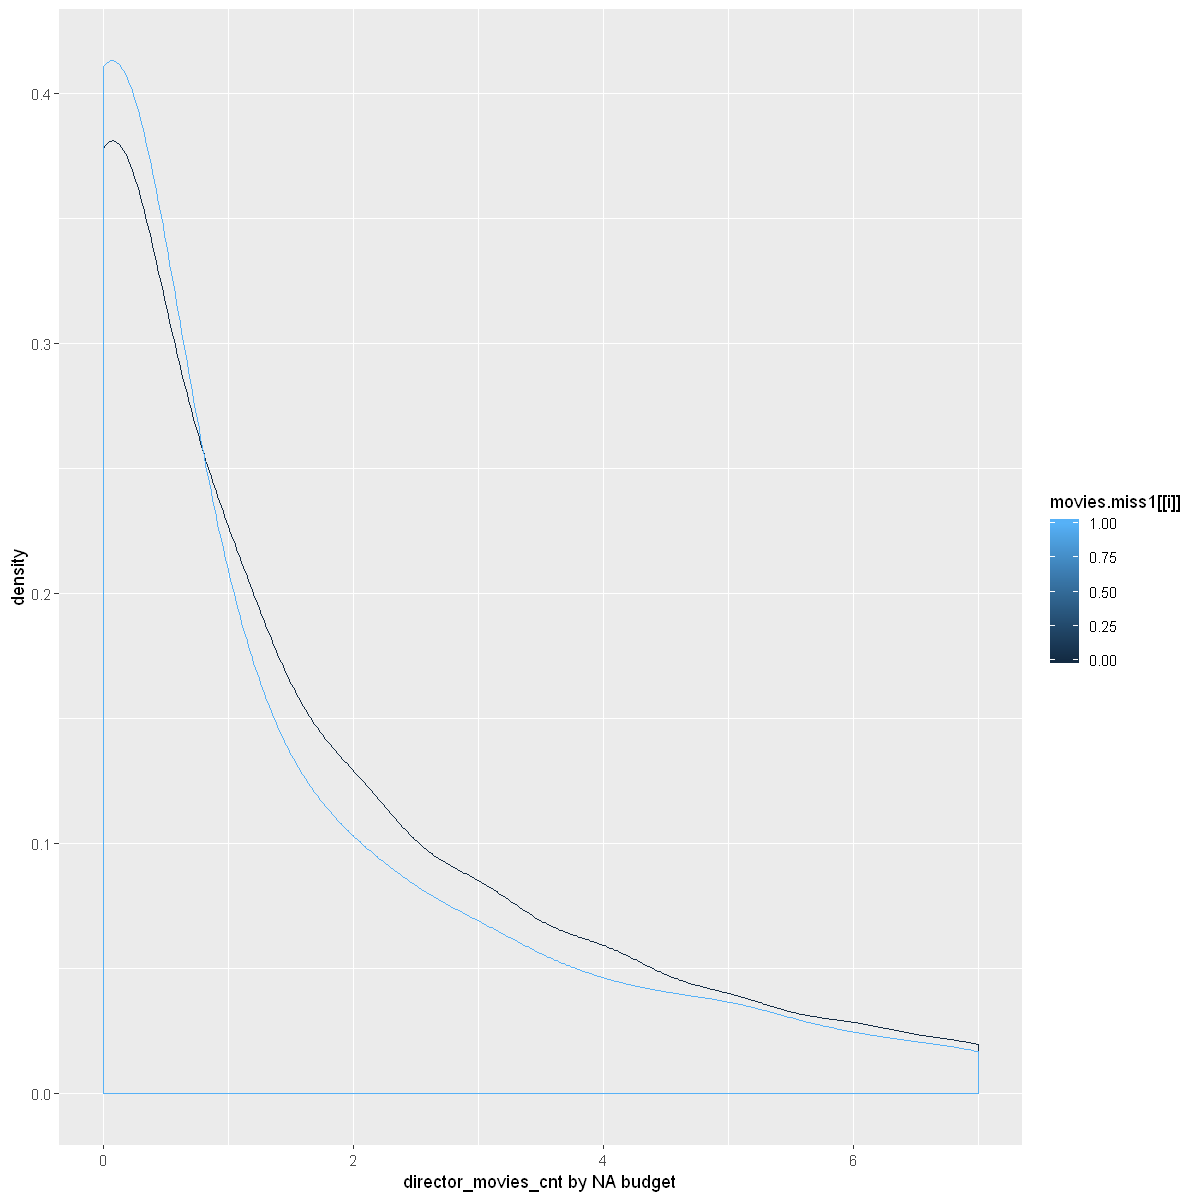


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 13.168, df = 4859.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.5147187 0.6947854
sample estimates:
mean of x mean of y 
 1.806221  1.201469 

[1] "depart_Art by NA budget"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


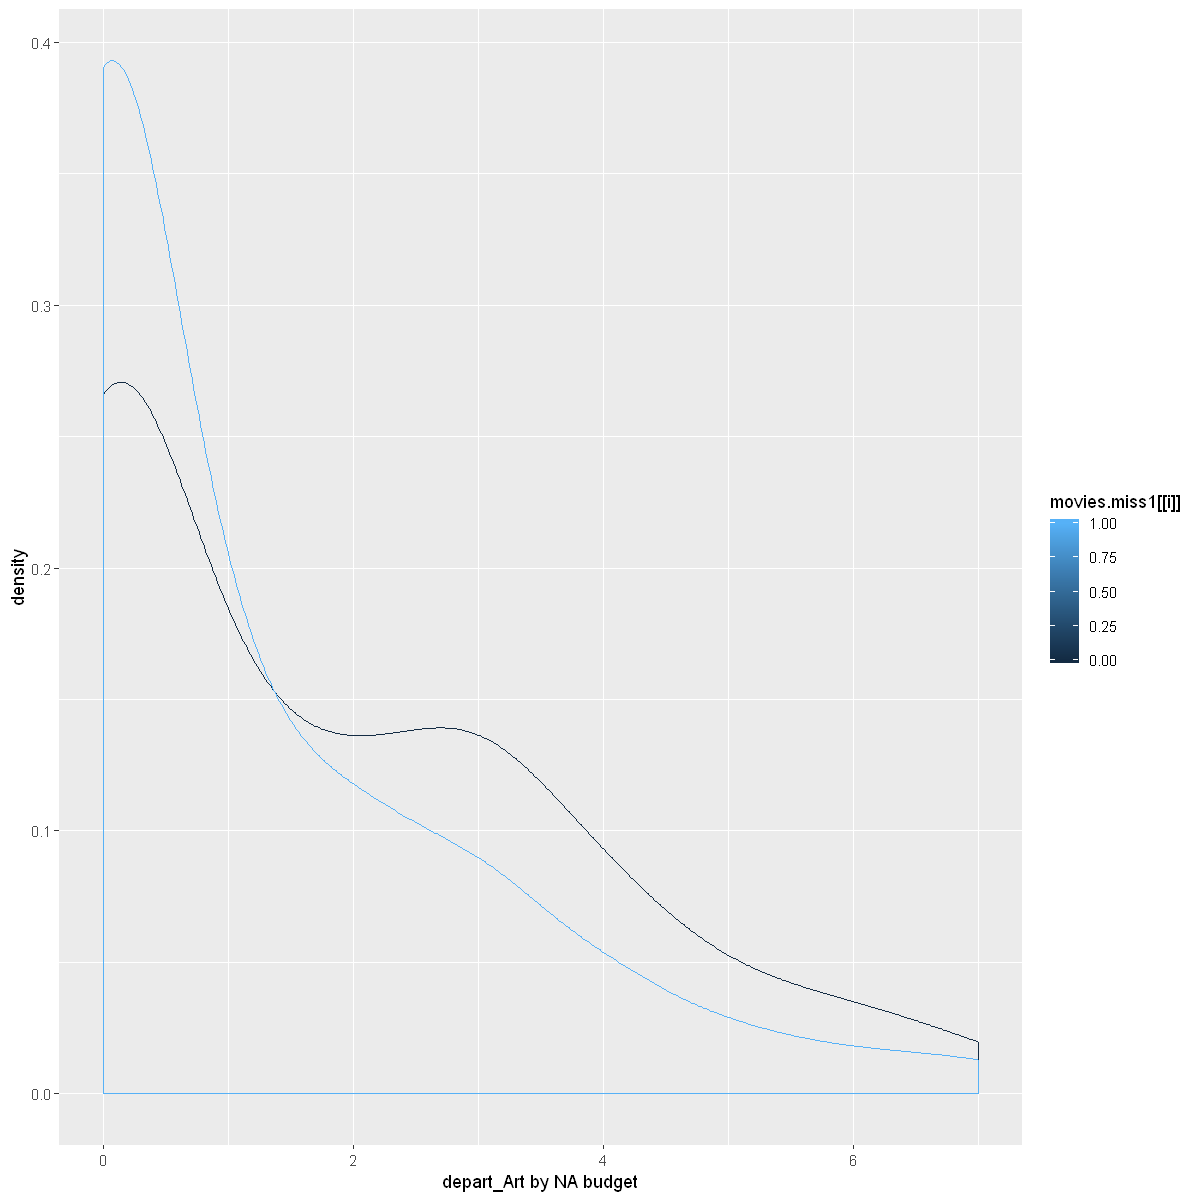


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 12.013, df = 5007.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2869836 0.3989175
sample estimates:
mean of x mean of y 
1.2249832 0.8820327 

[1] "depart_Camera by NA budget"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


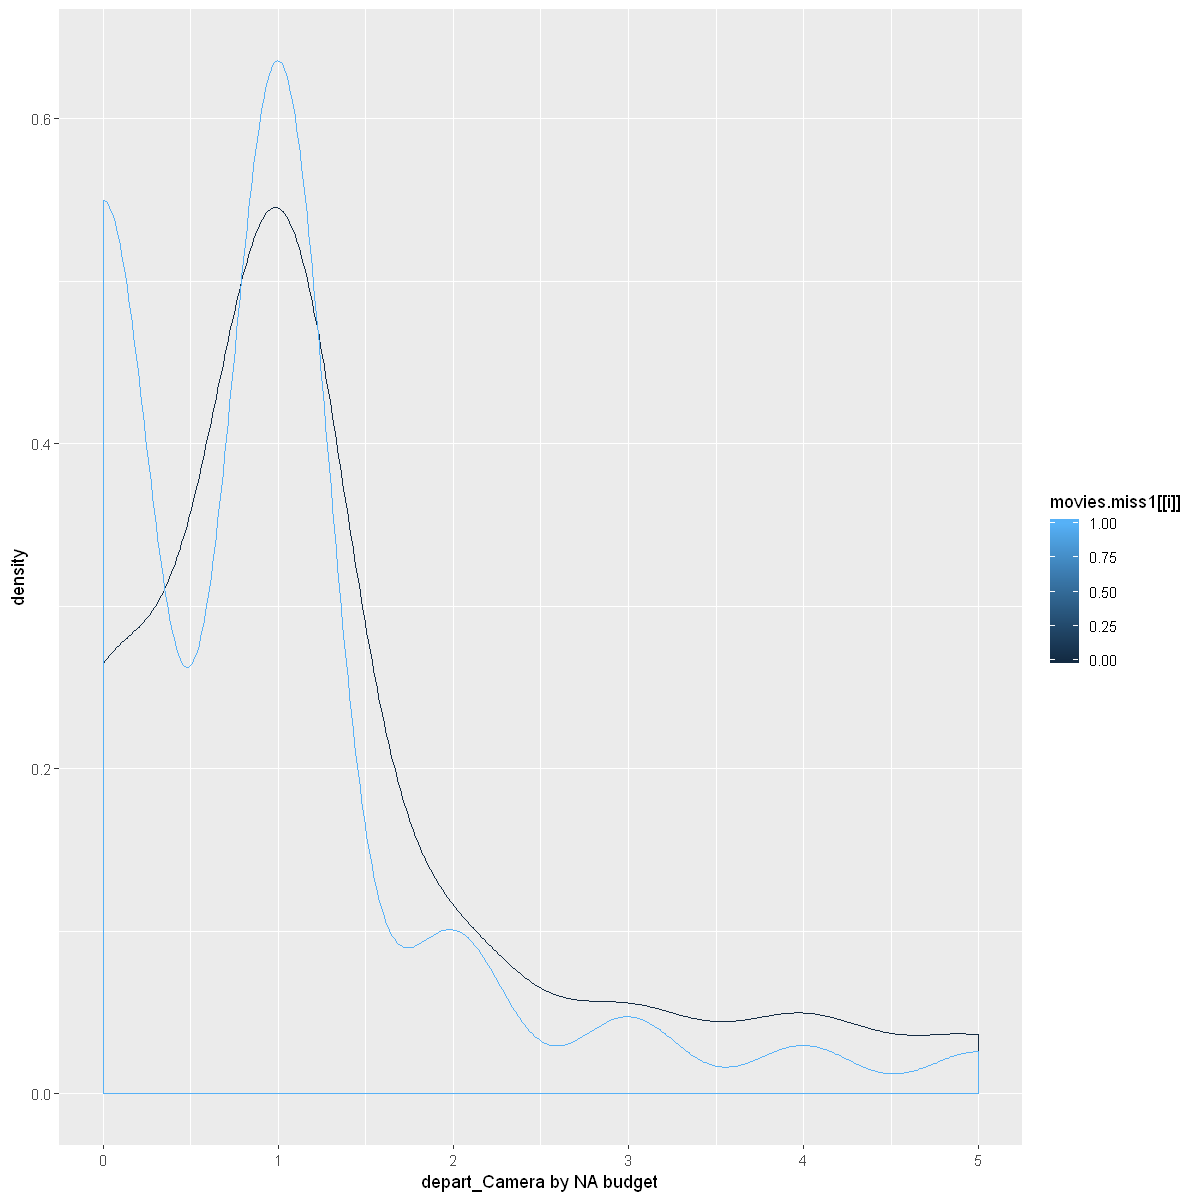


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 11.386, df = 5261.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2996611 0.4243166
sample estimates:
mean of x mean of y 
1.0000000 0.6380112 

[1] "depart_Custom_Mkup by NA budget"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


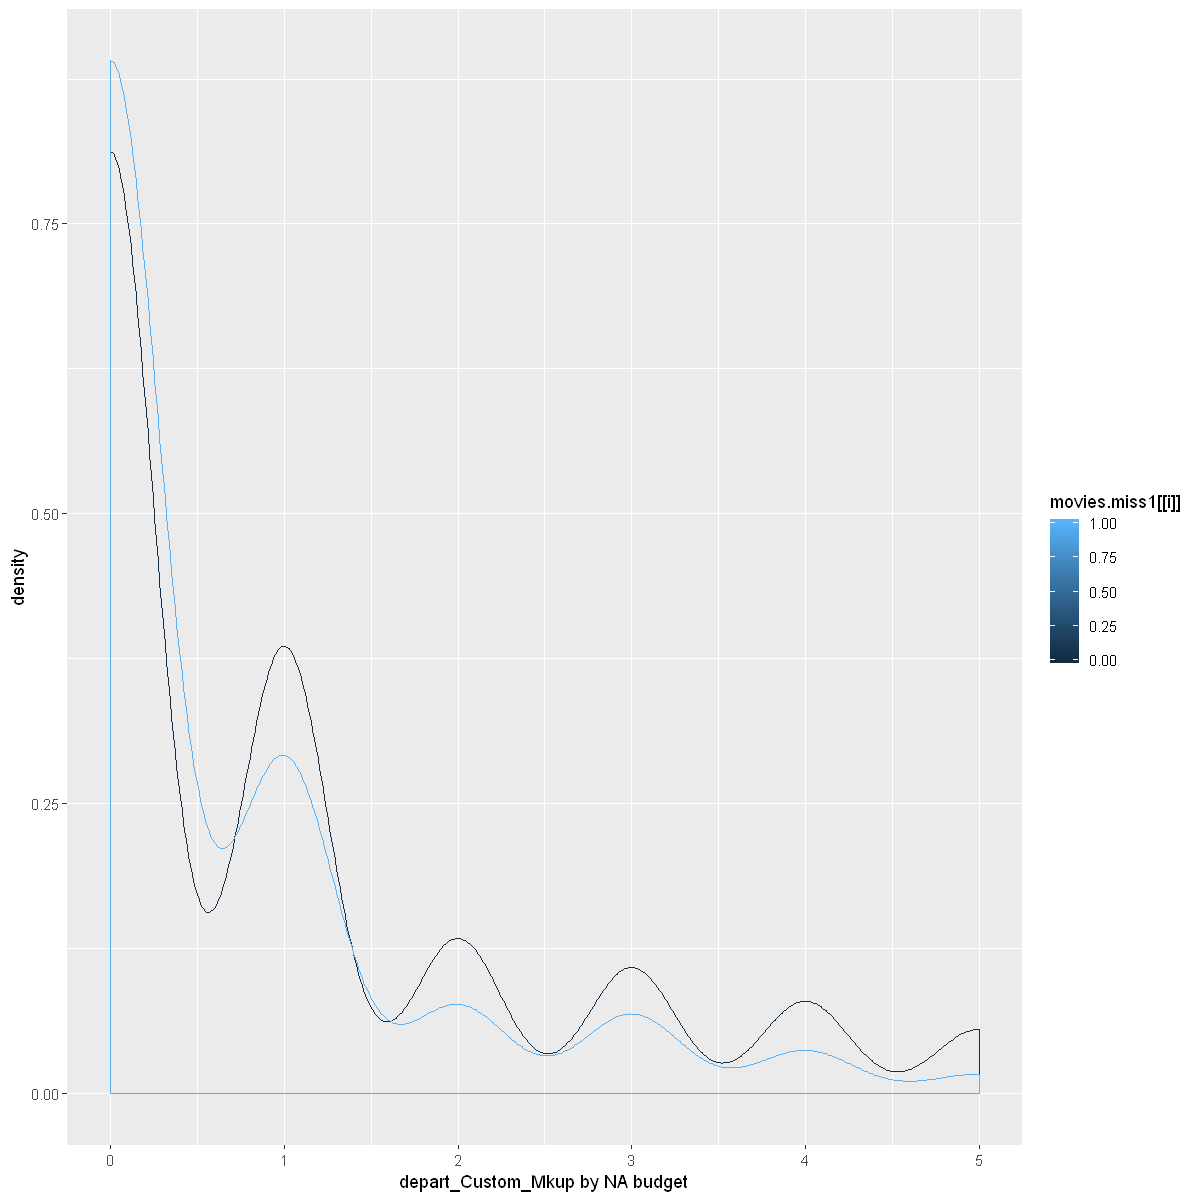


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 8.107, df = 5052.1, p-value = 6.456e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.0973375 0.1594290
sample estimates:
mean of x mean of y 
 1.454624  1.326241 

[1] "depart_Directing by NA budget"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


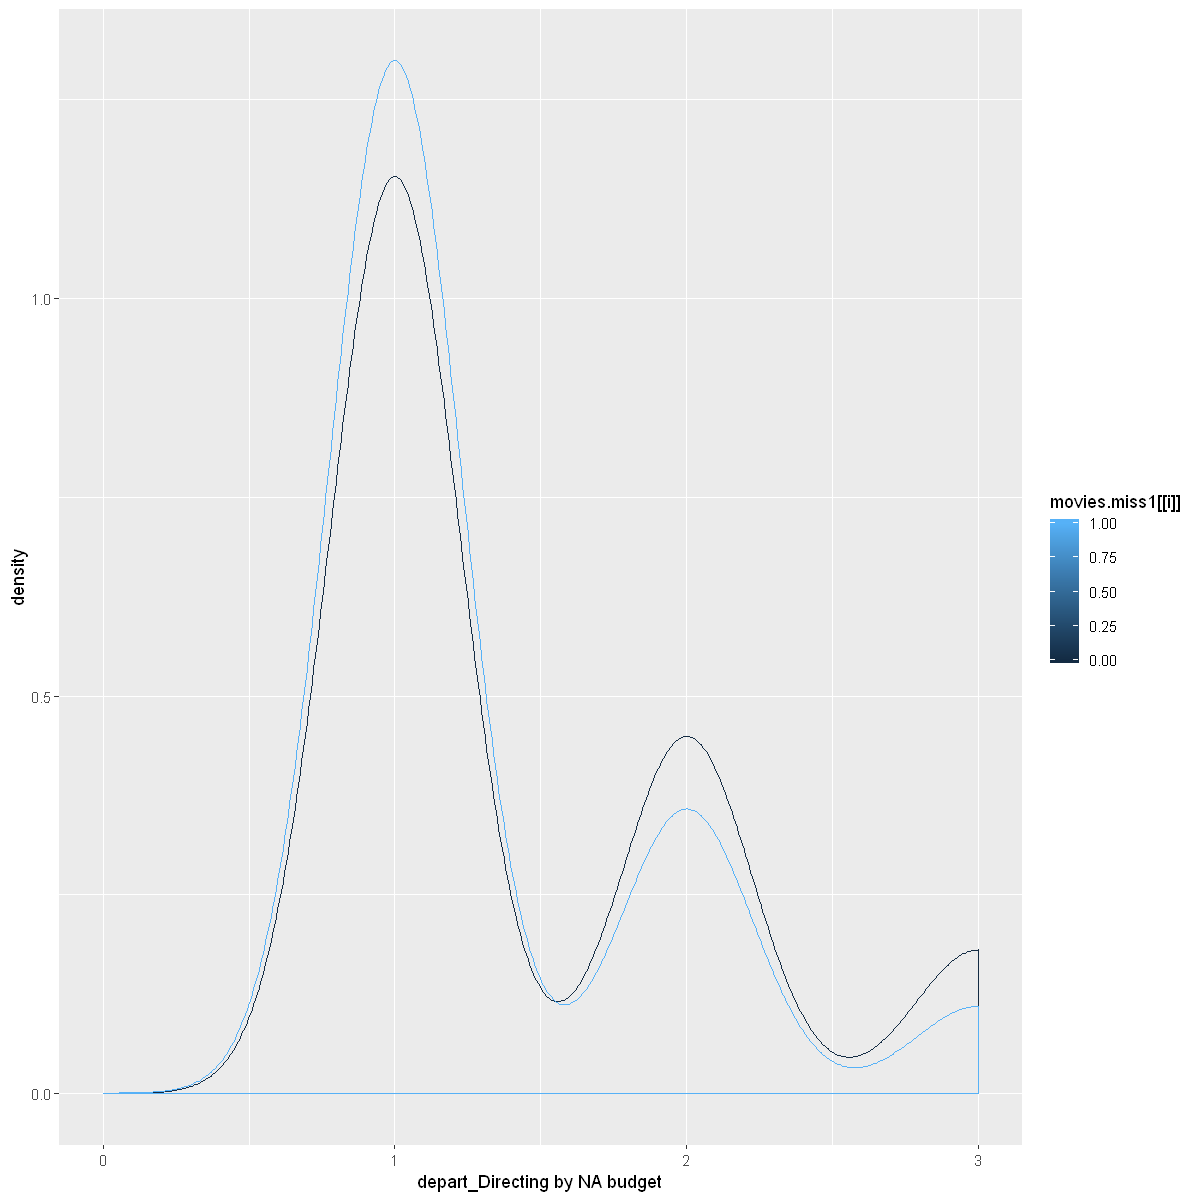


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 9.9081, df = 4546.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2828850 0.4224468
sample estimates:
mean of x mean of y 
 1.383524  1.030858 

[1] "depart_Sound by NA budget"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


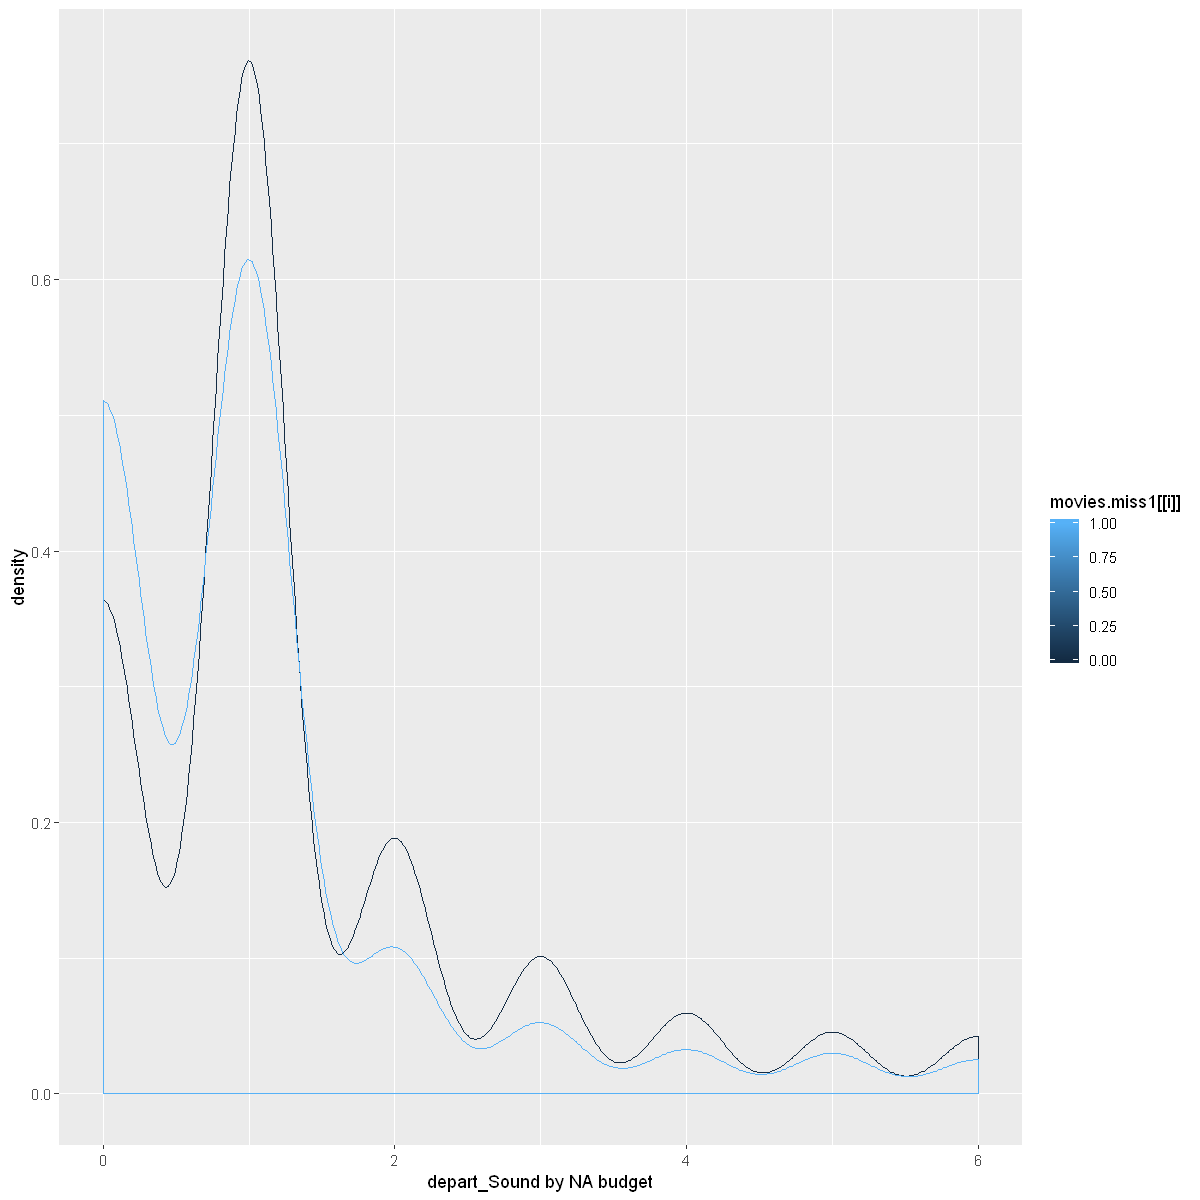


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 35.594, df = 433.12, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 17550718 19602250
sample estimates:
mean of x mean of y 
 22784964   4208479 

[1] "budget by NA producers_cnt"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


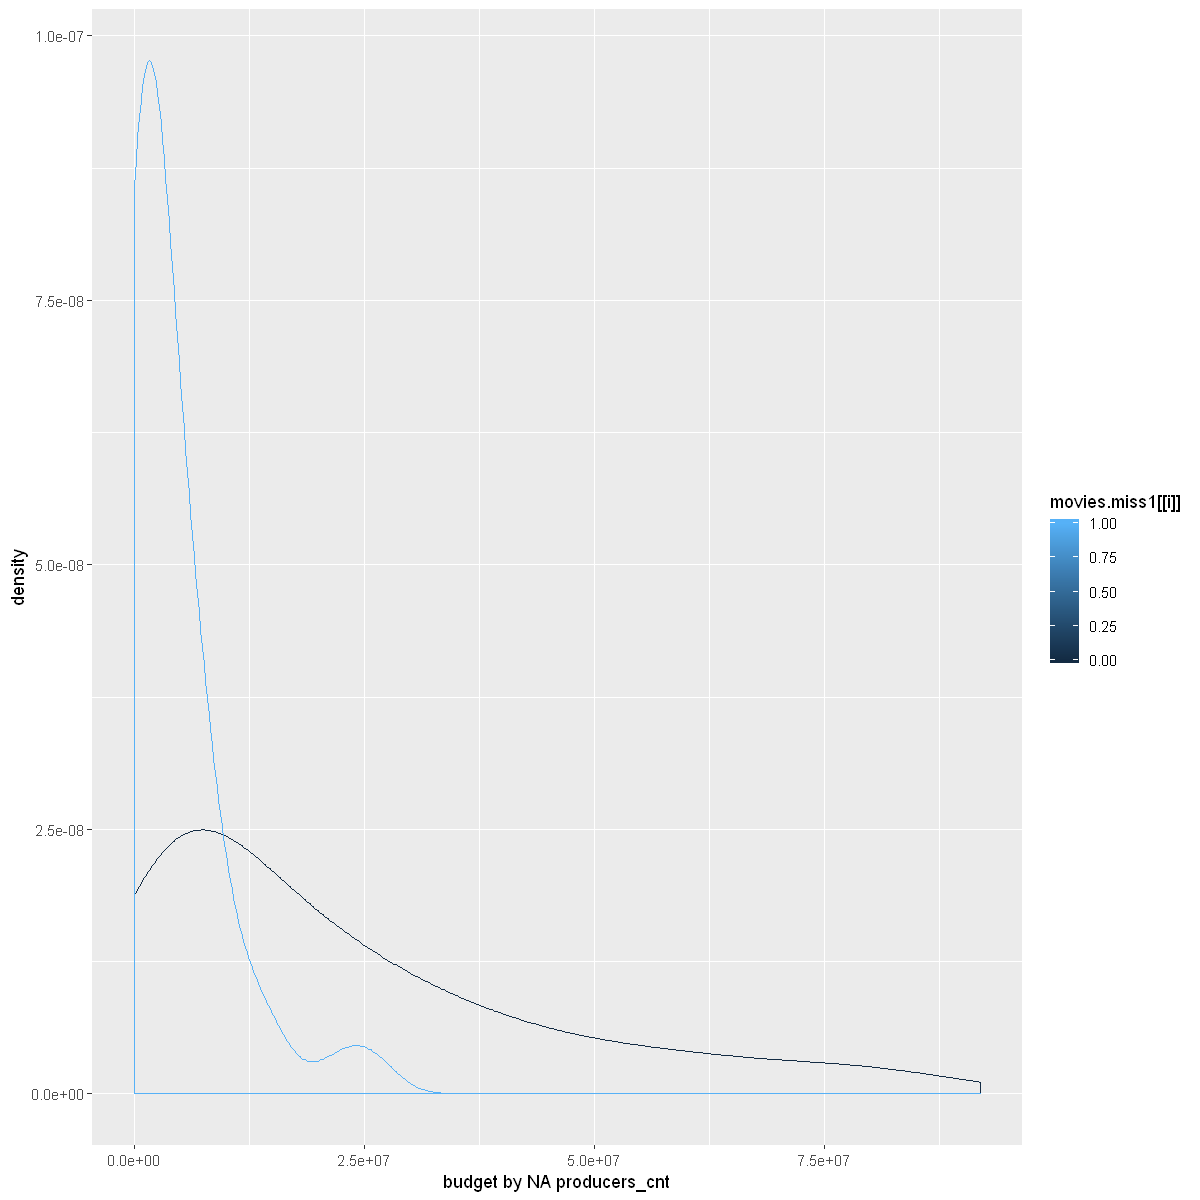


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 12.142, df = 497.28, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.909769 2.647152
sample estimates:
mean of x mean of y 
 4.194491  1.916031 

[1] "actor1_movies_cnt by NA producers_cnt"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


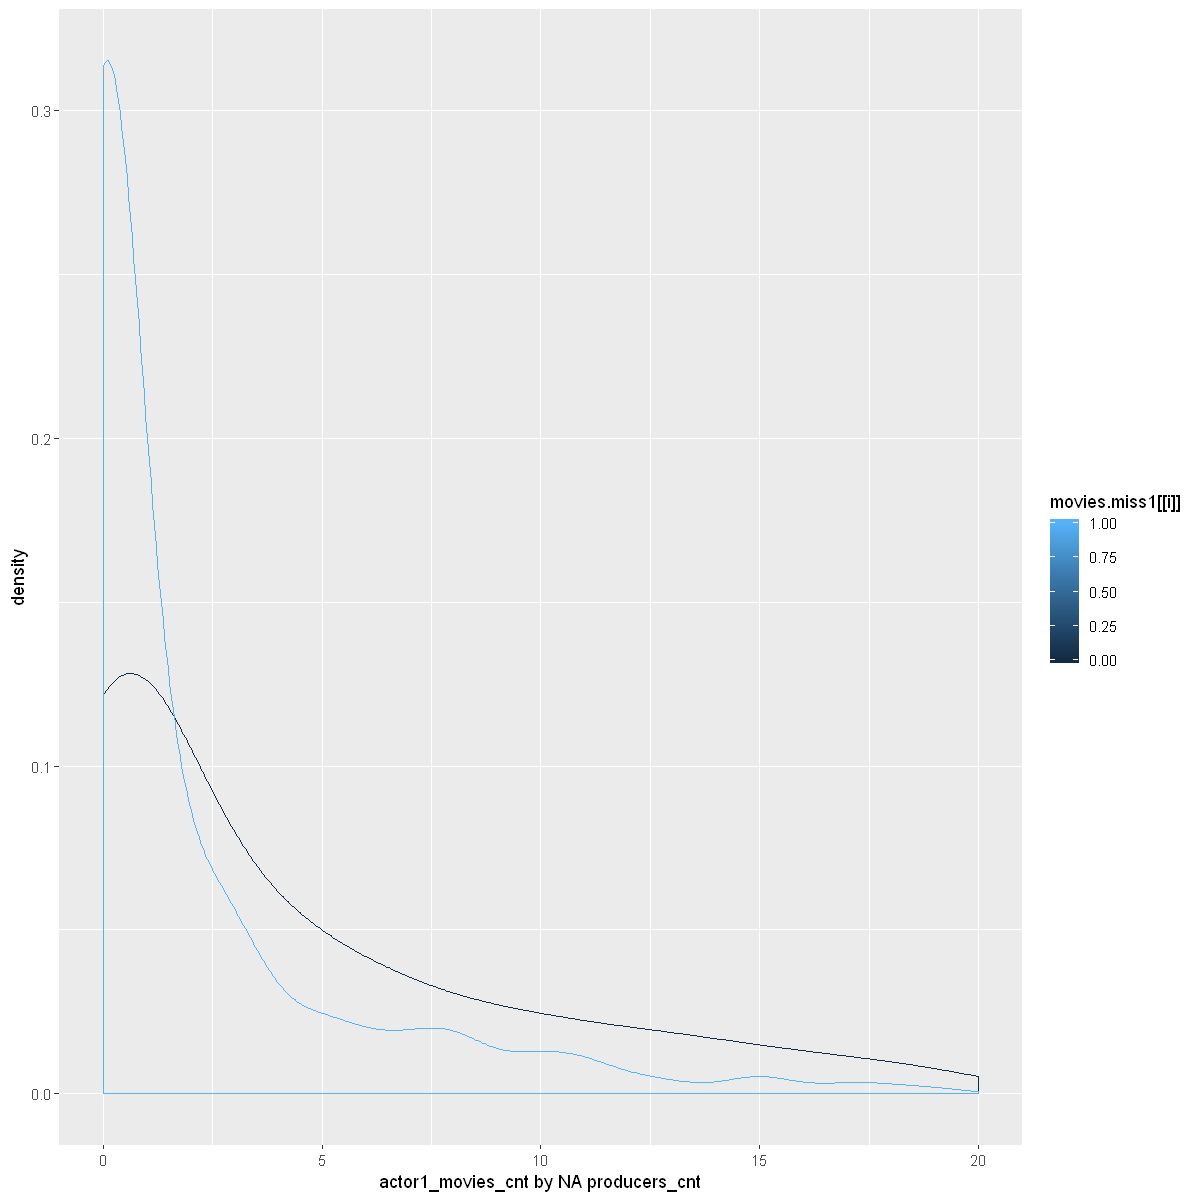


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 13.532, df = 503.17, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.761483 2.359832
sample estimates:
mean of x mean of y 
 3.406019  1.345361 

[1] "actor2_movies_cnt by NA producers_cnt"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


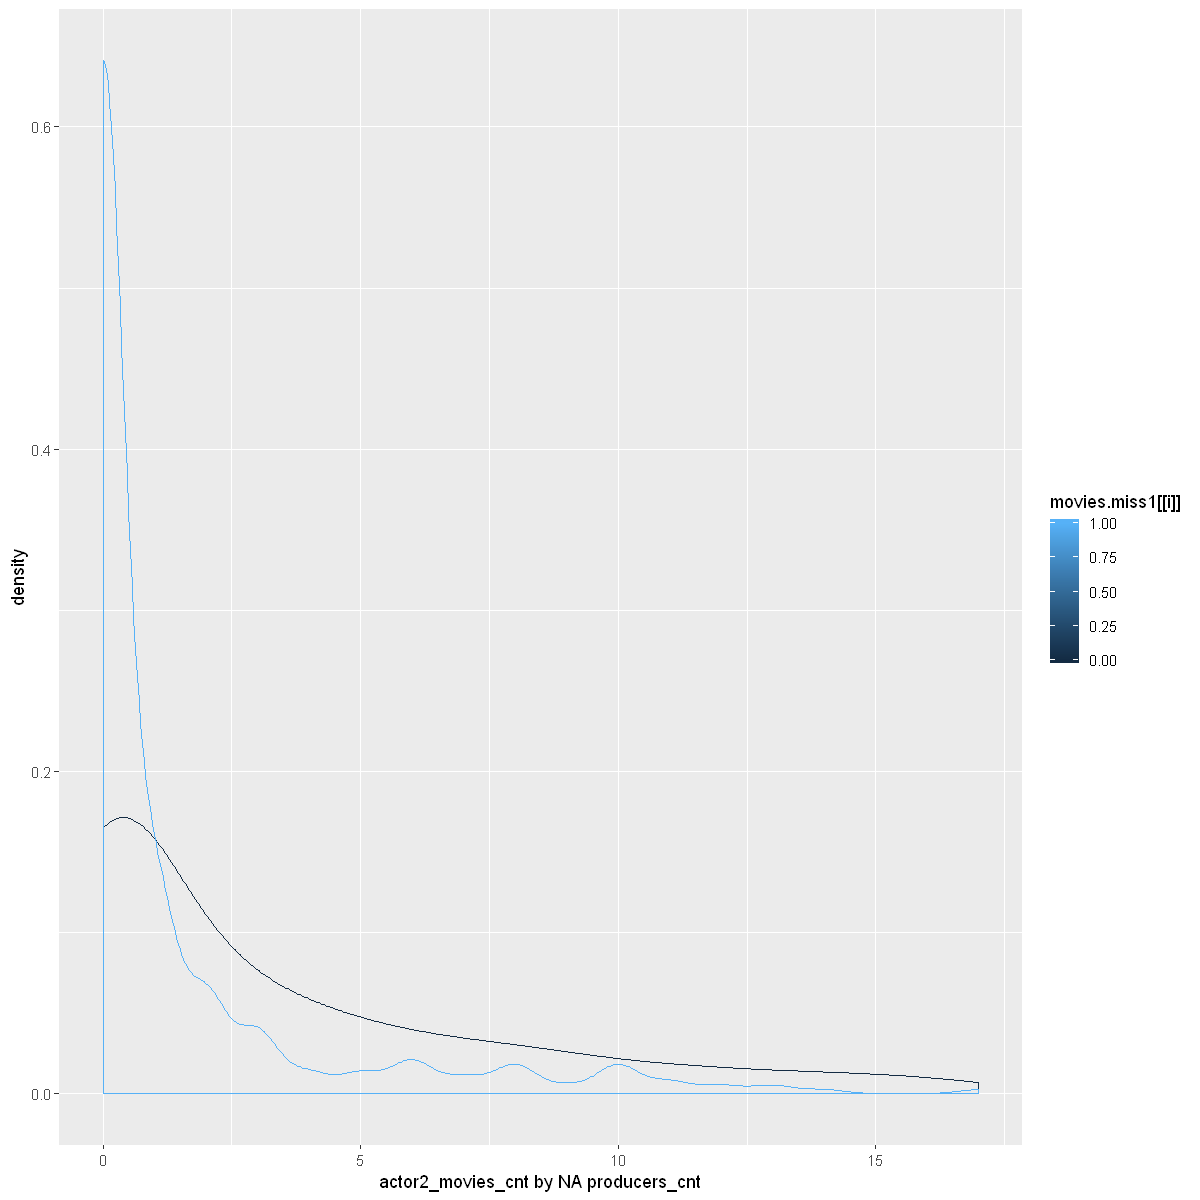


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 4.7731, df = 161.75, p-value = 4.032e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 32823905 79149589
sample estimates:
mean of x mean of y 
176852861 120866114 

[1] "actor0_prev_revenue by NA producers_cnt"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


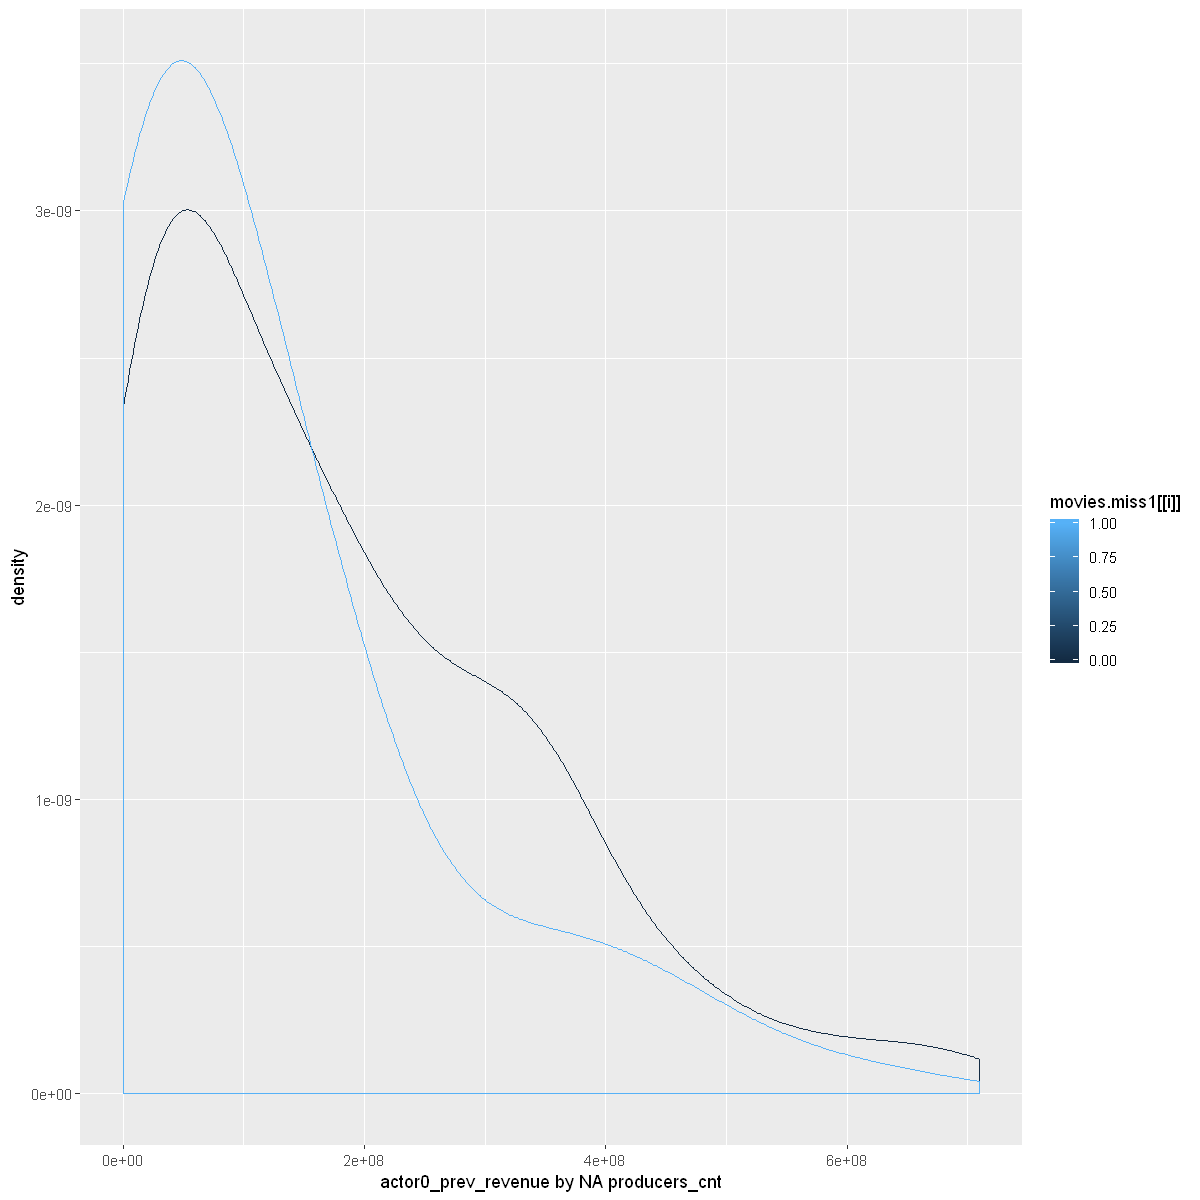


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.1249, df = 135.32, p-value = 1.006e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 32093279 72426222
sample estimates:
mean of x mean of y 
146862778  94603028 

[1] "actor1_prev_revenue by NA producers_cnt"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


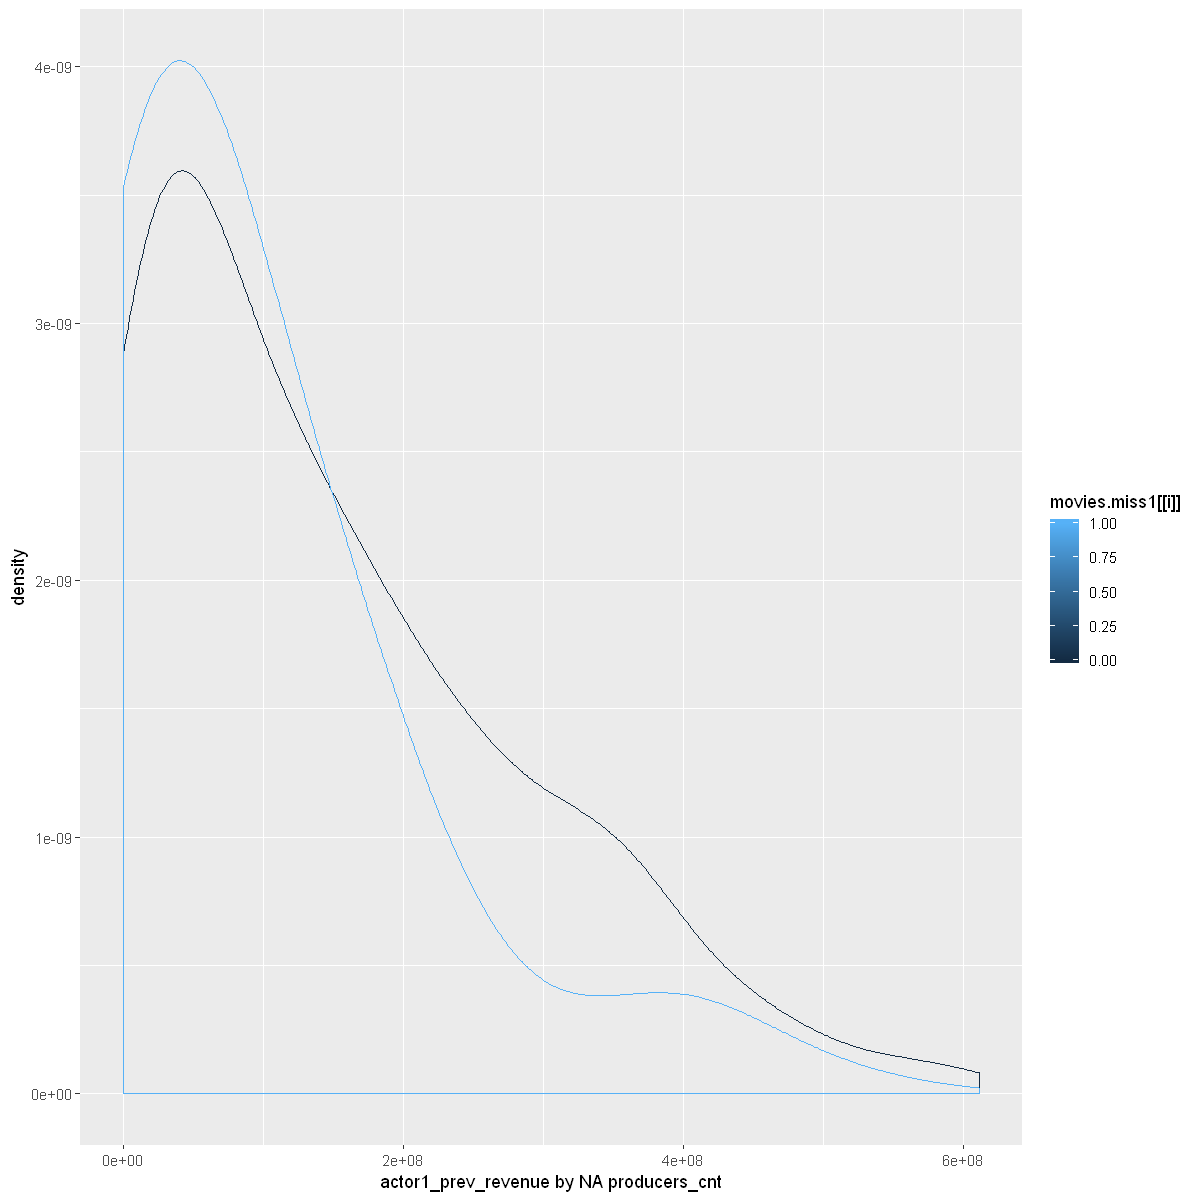


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 2.3922, df = 107.31, p-value = 0.01849
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  5091635 54343484
sample estimates:
mean of x mean of y 
134647195 104929635 

[1] "actor2_prev_revenue by NA producers_cnt"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


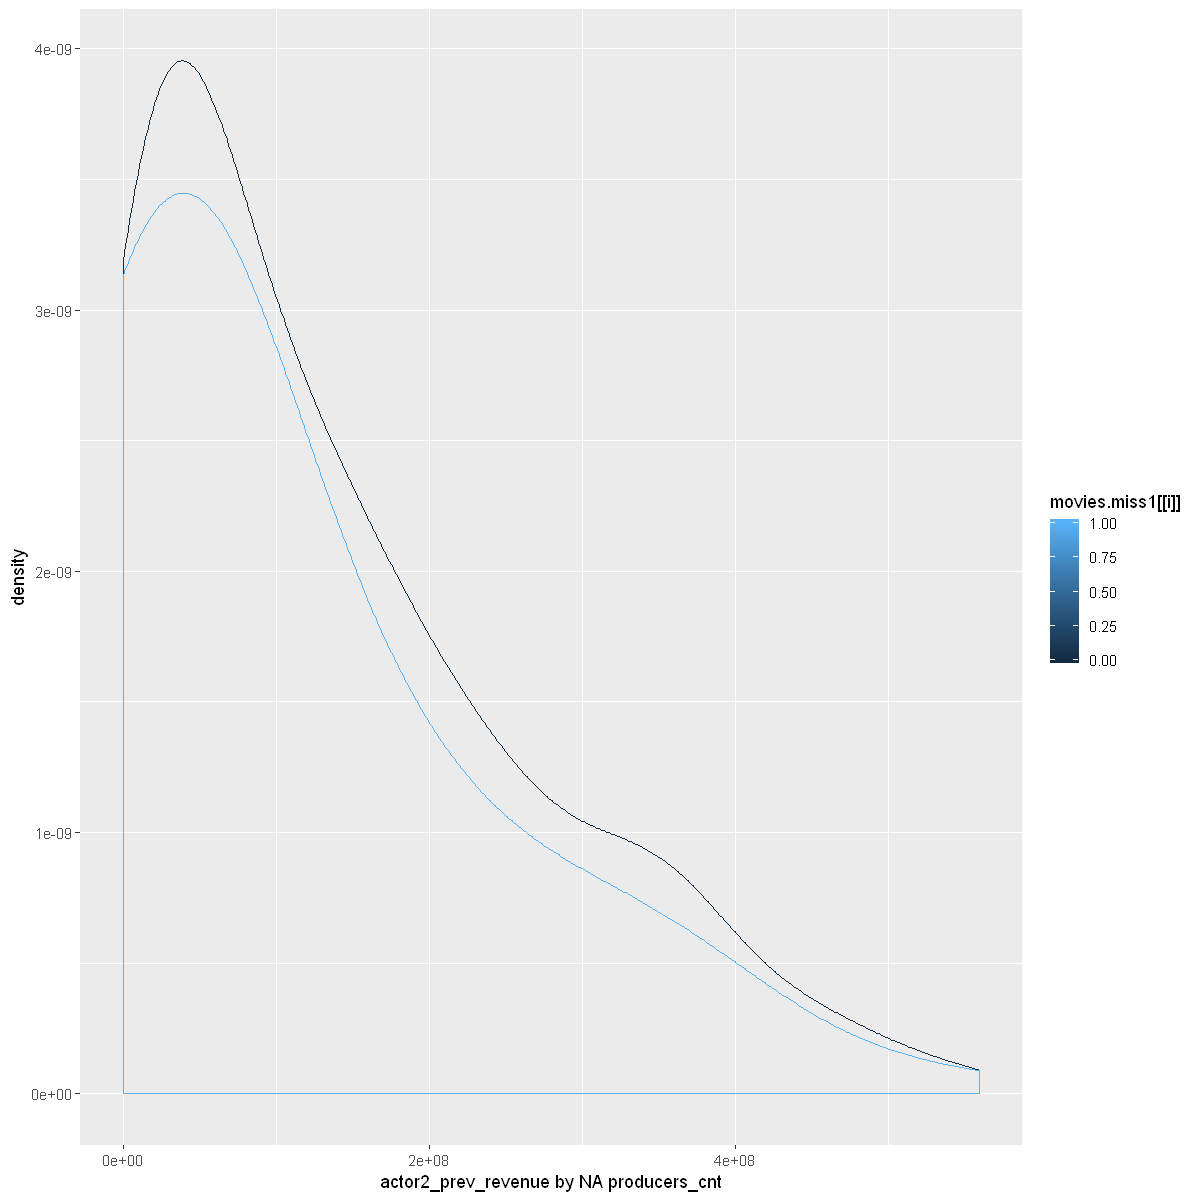


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 19.38, df = 587.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.9138348 1.1199394
sample estimates:
mean of x mean of y 
 1.411289  0.394402 

[1] "director_movies_cnt by NA producers_cnt"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


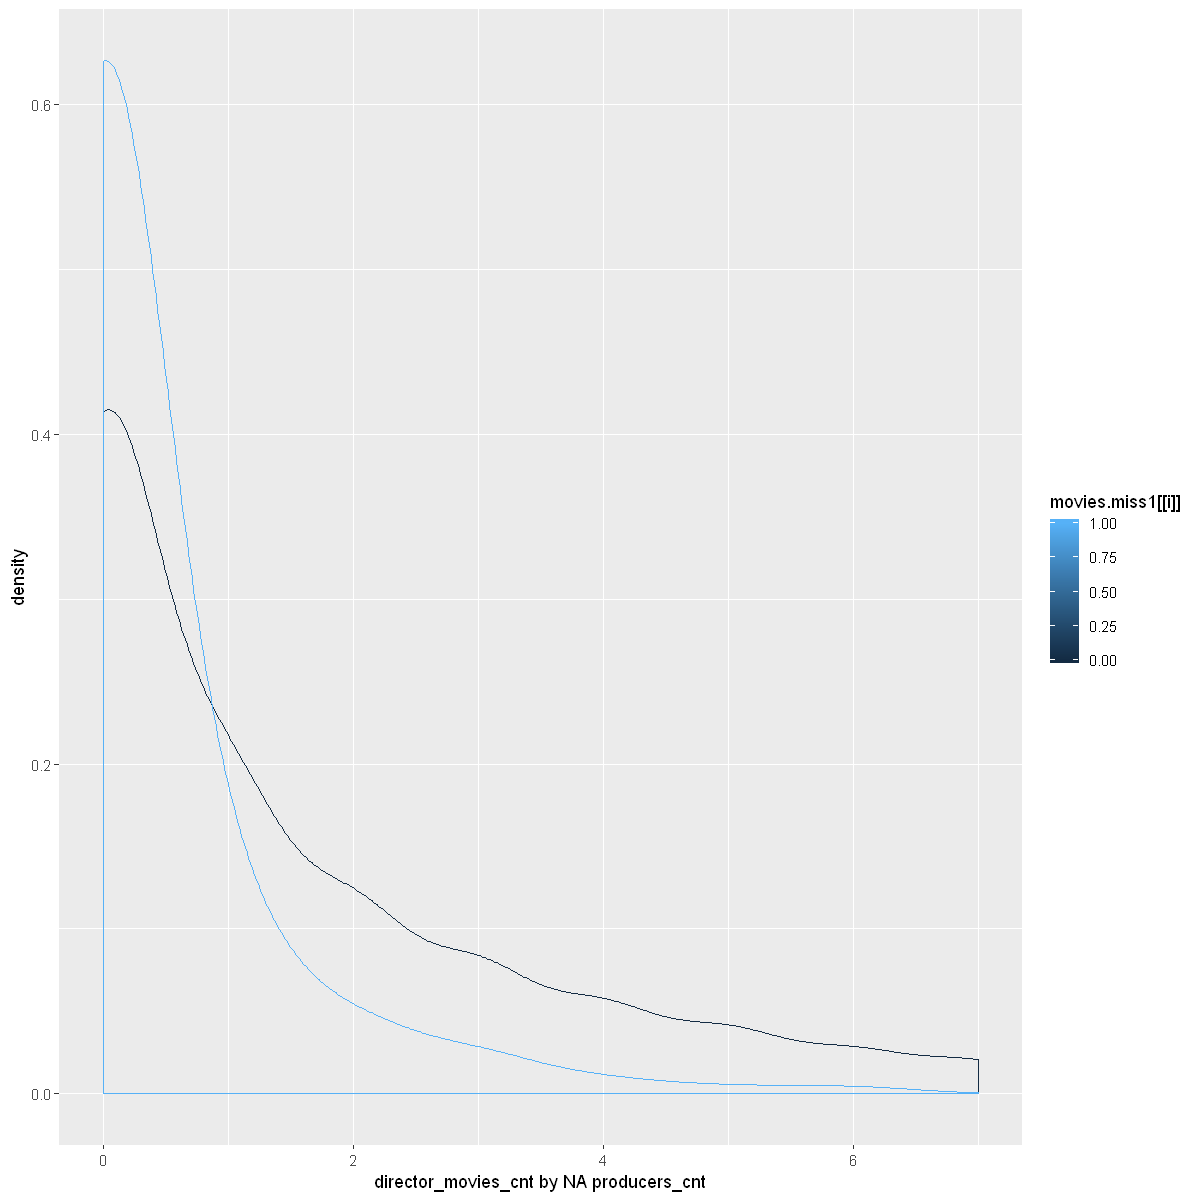


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 37.291, df = 864.82, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.448657 1.609623
sample estimates:
mean of x mean of y 
 1.697938  0.168798 

[1] "depart_Art by NA producers_cnt"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


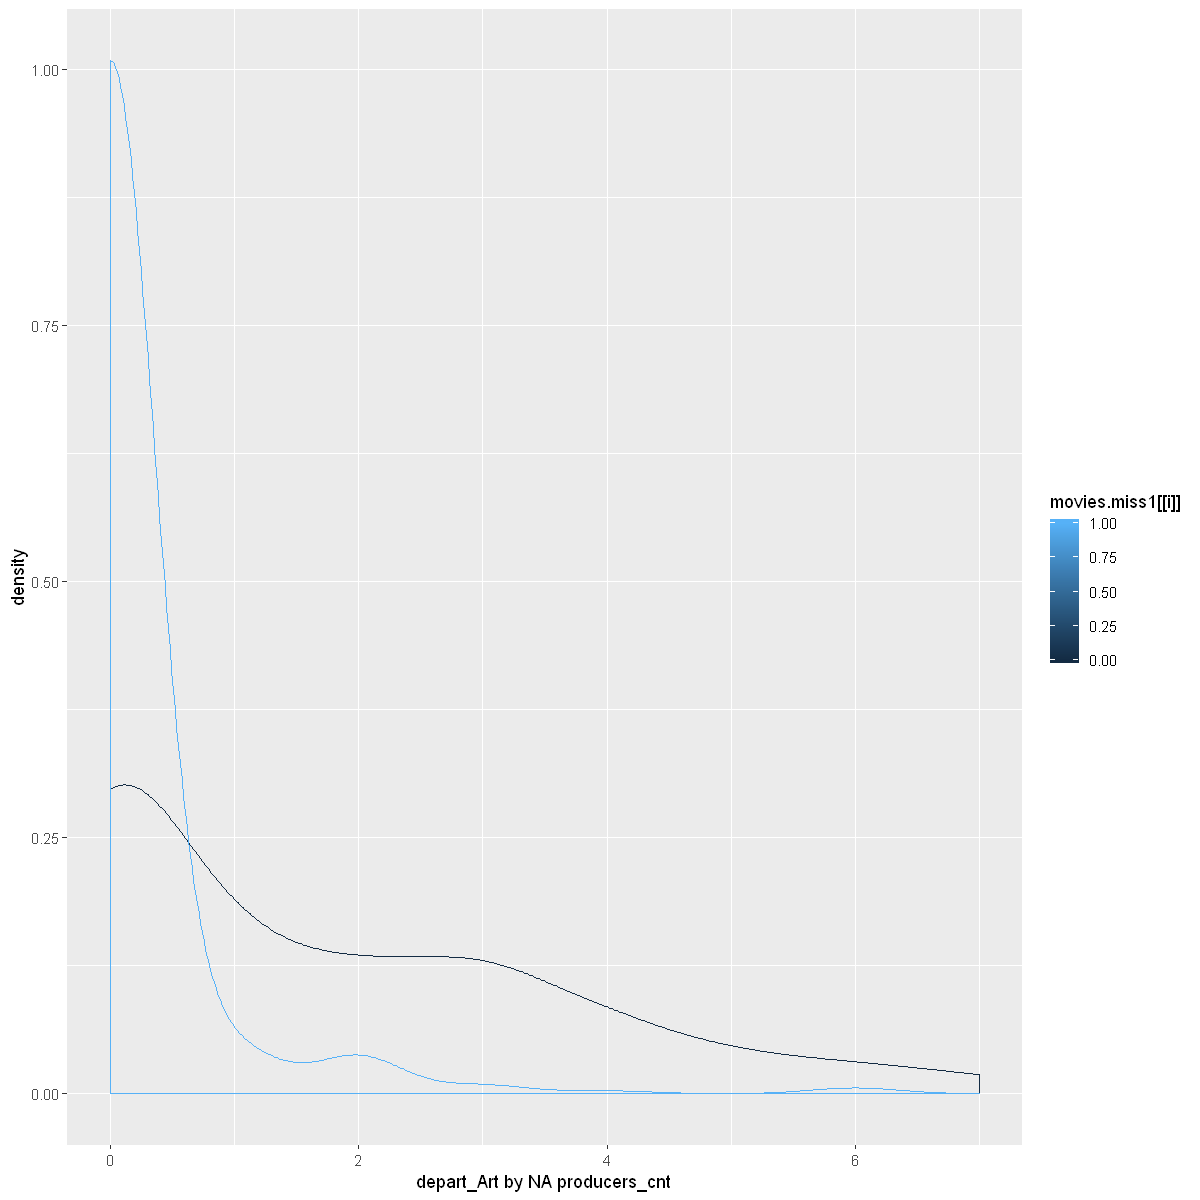


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 29.345, df = 642.38, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.8552100 0.9778747
sample estimates:
mean of x mean of y 
1.1652603 0.2487179 

[1] "depart_Camera by NA producers_cnt"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


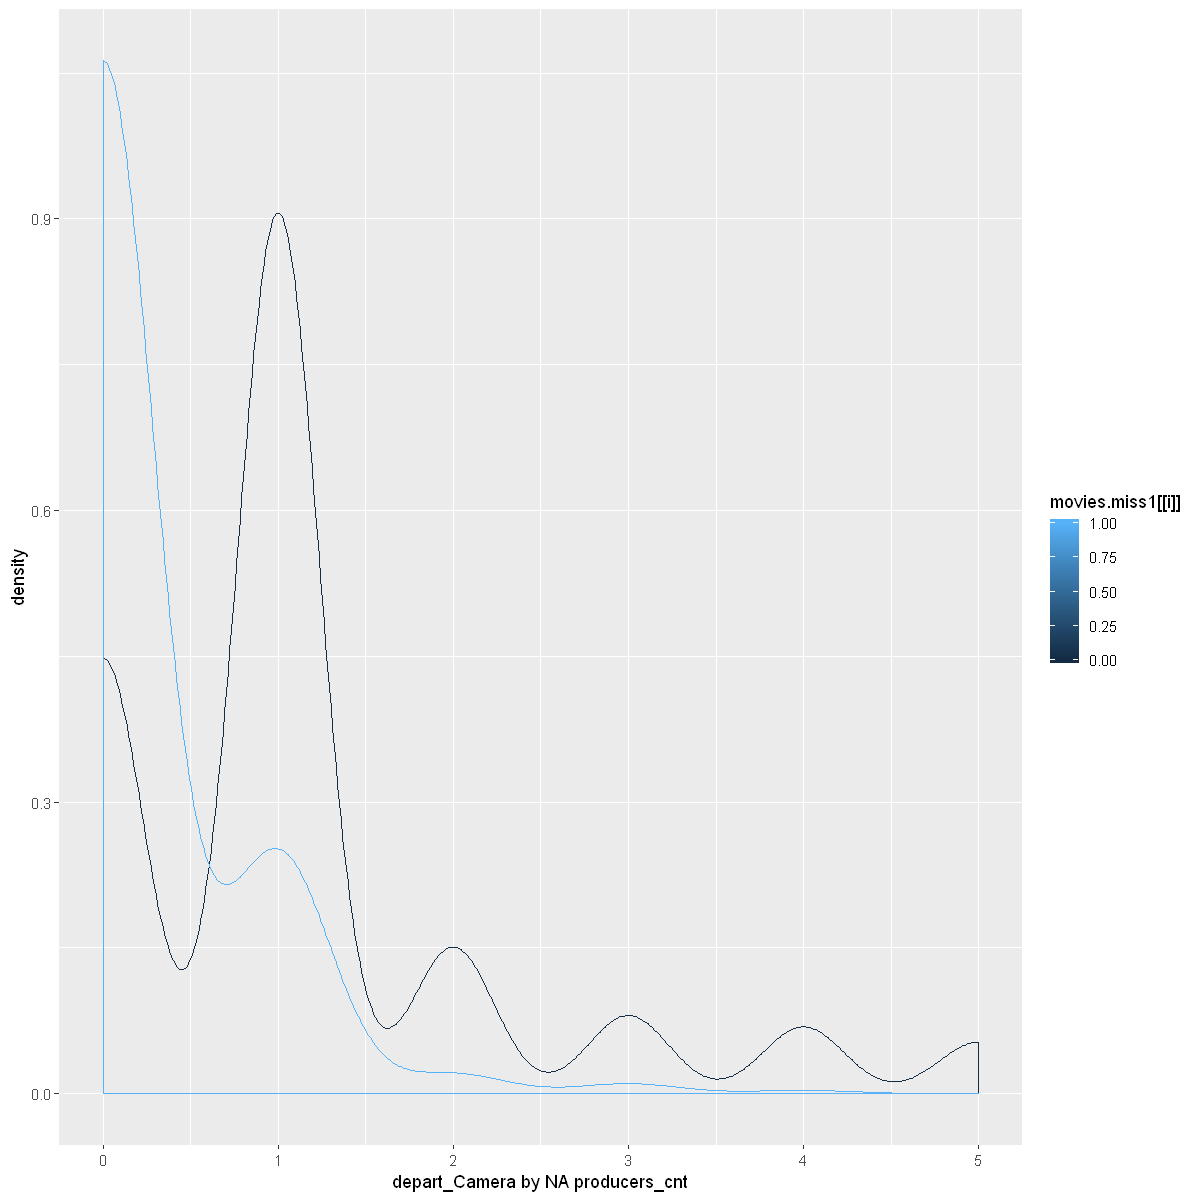


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 33.911, df = 1342.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.7932371 0.8906479
sample estimates:
 mean of x  mean of y 
0.92912198 0.08717949 

[1] "depart_Custom_Mkup by NA producers_cnt"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


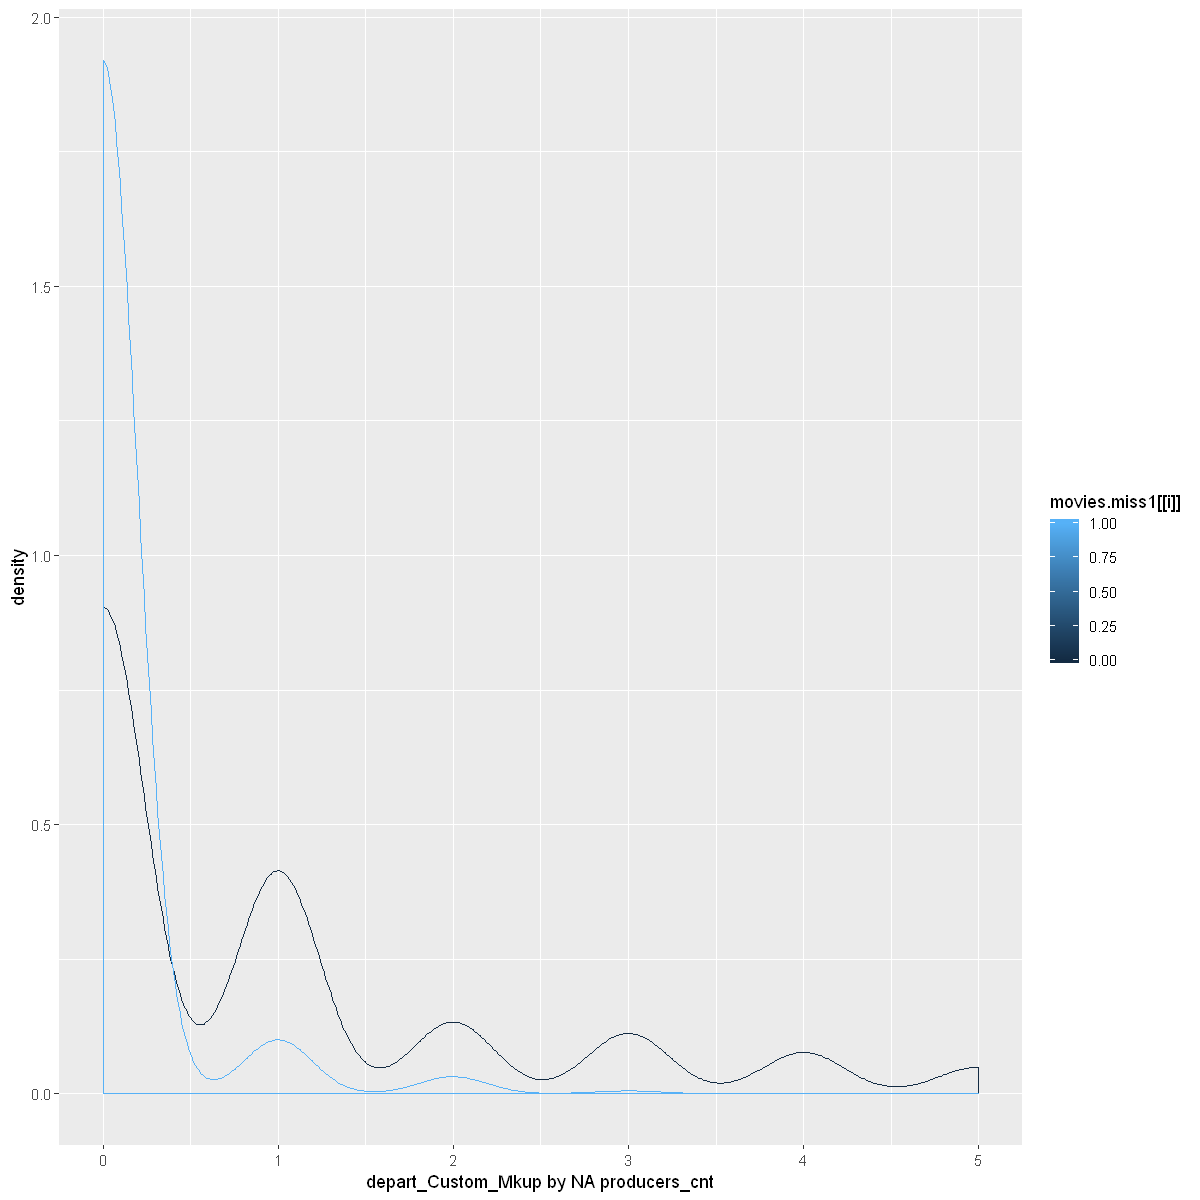


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 17.411, df = 594.86, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2860320 0.3587644
sample estimates:
mean of x mean of y 
 1.430646  1.108247 

[1] "depart_Directing by NA producers_cnt"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


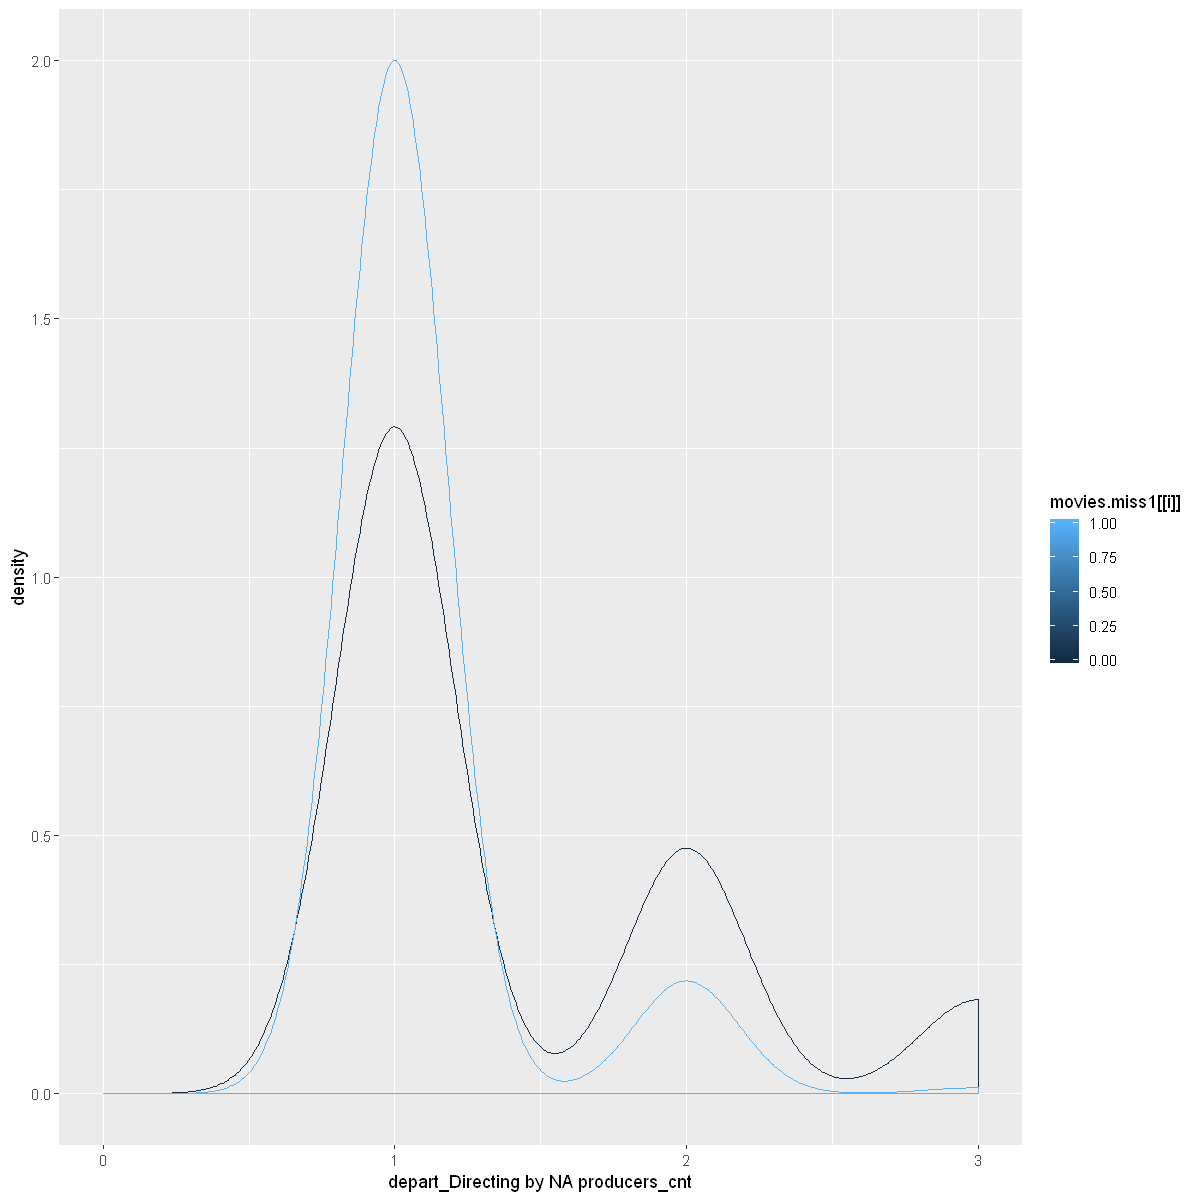


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 26.32, df = 649.45, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.9242284 1.0732533
sample estimates:
mean of x mean of y 
1.3269062 0.3281654 

[1] "depart_Sound by NA producers_cnt"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


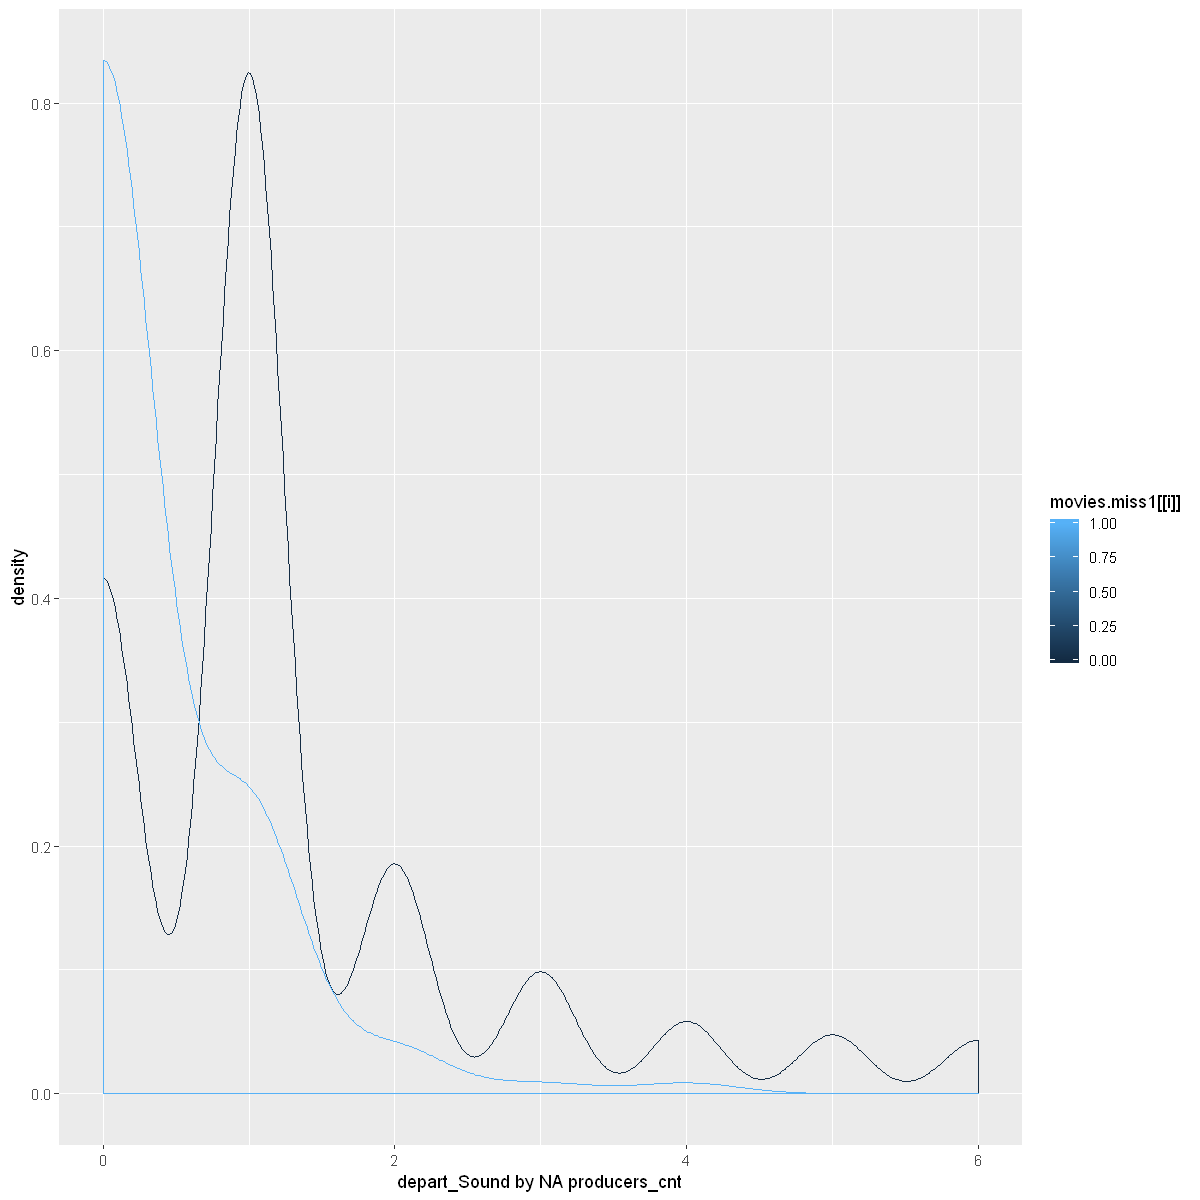


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.7182, df = 333.07, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -14045694  -8874189
sample estimates:
mean of x mean of y 
 21455546  32915488 

[1] "budget by NA actor1_movies_cnt"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


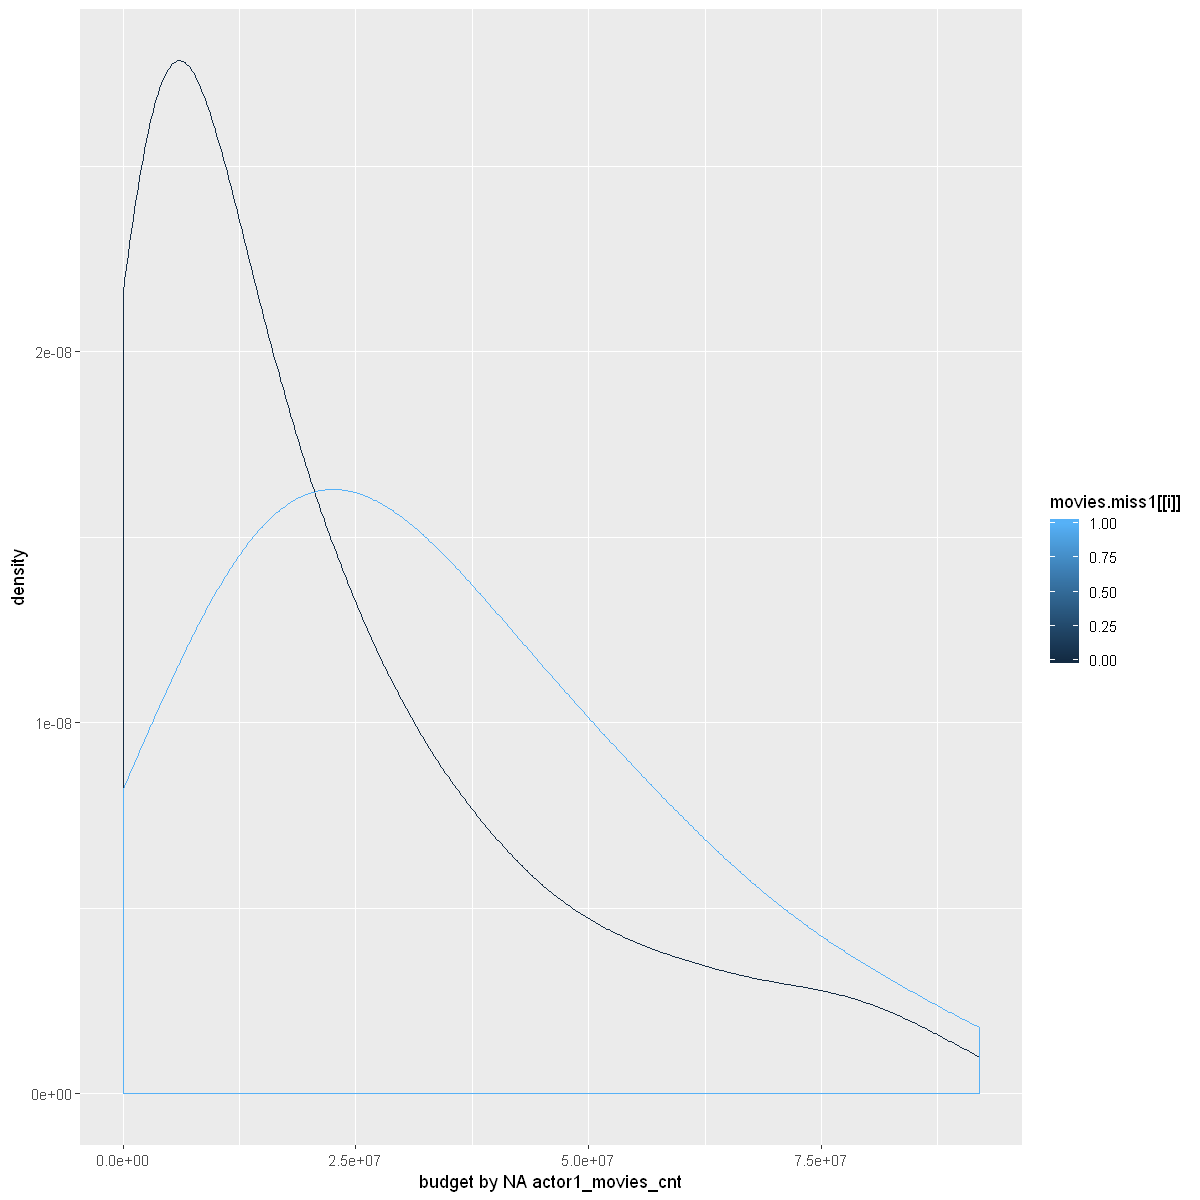


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.6471, df = 453.52, p-value = 1.24e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1091058 -0.6555986
sample estimates:
mean of x mean of y 
 2.856034  3.738386 

[1] "producers_cnt by NA actor1_movies_cnt"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


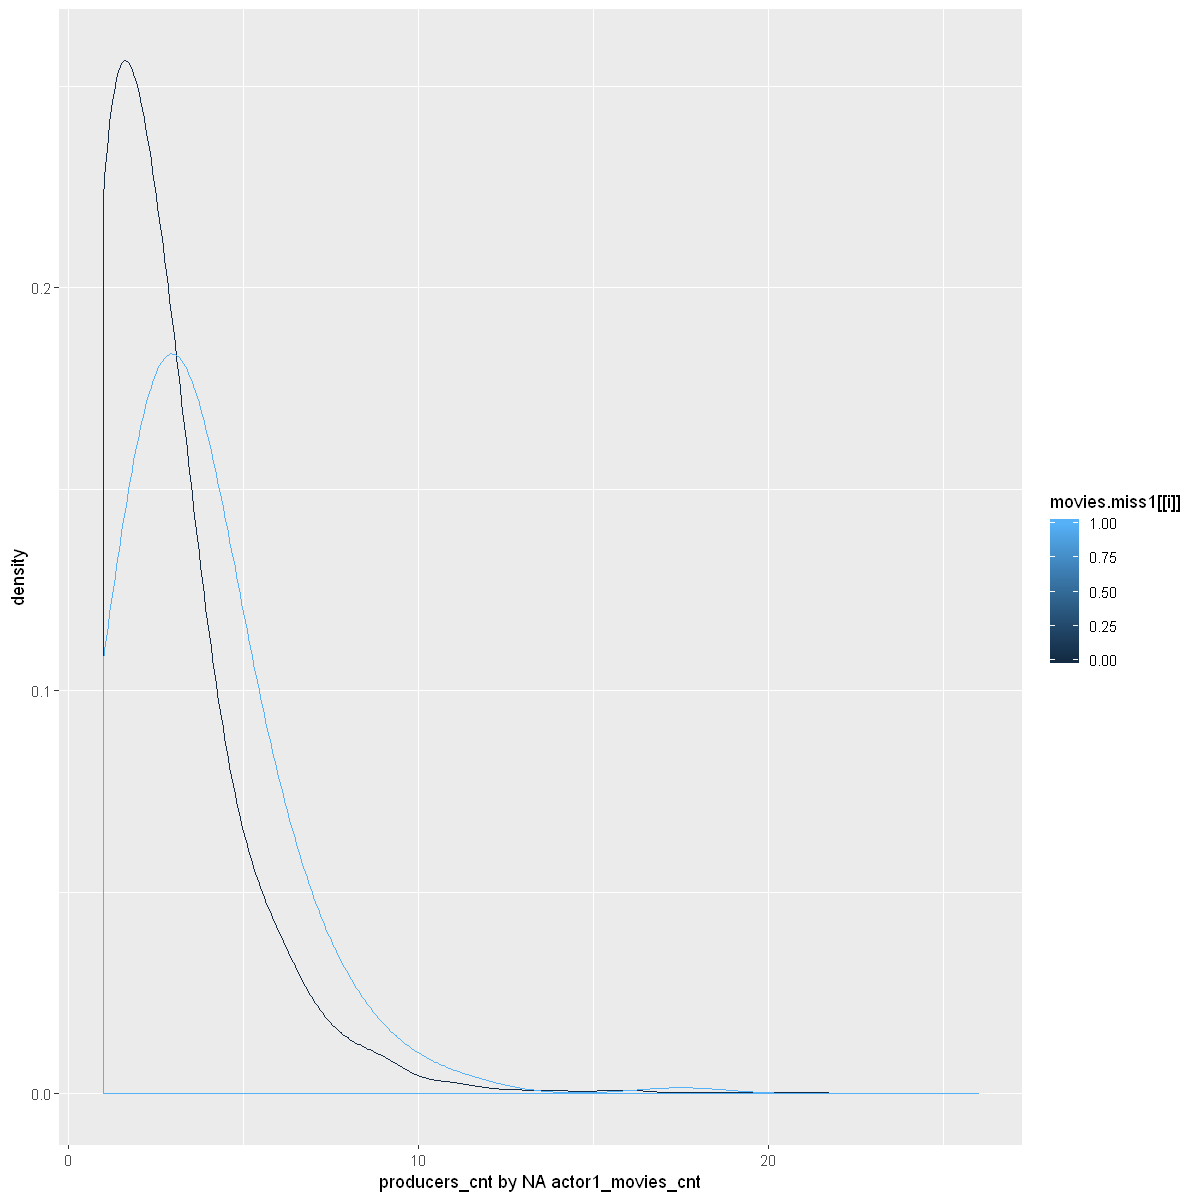


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -12.936, df = 307.31, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.392719 -3.232818
sample estimates:
mean of x mean of y 
 3.128611  6.941379 

[1] "actor2_movies_cnt by NA actor1_movies_cnt"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


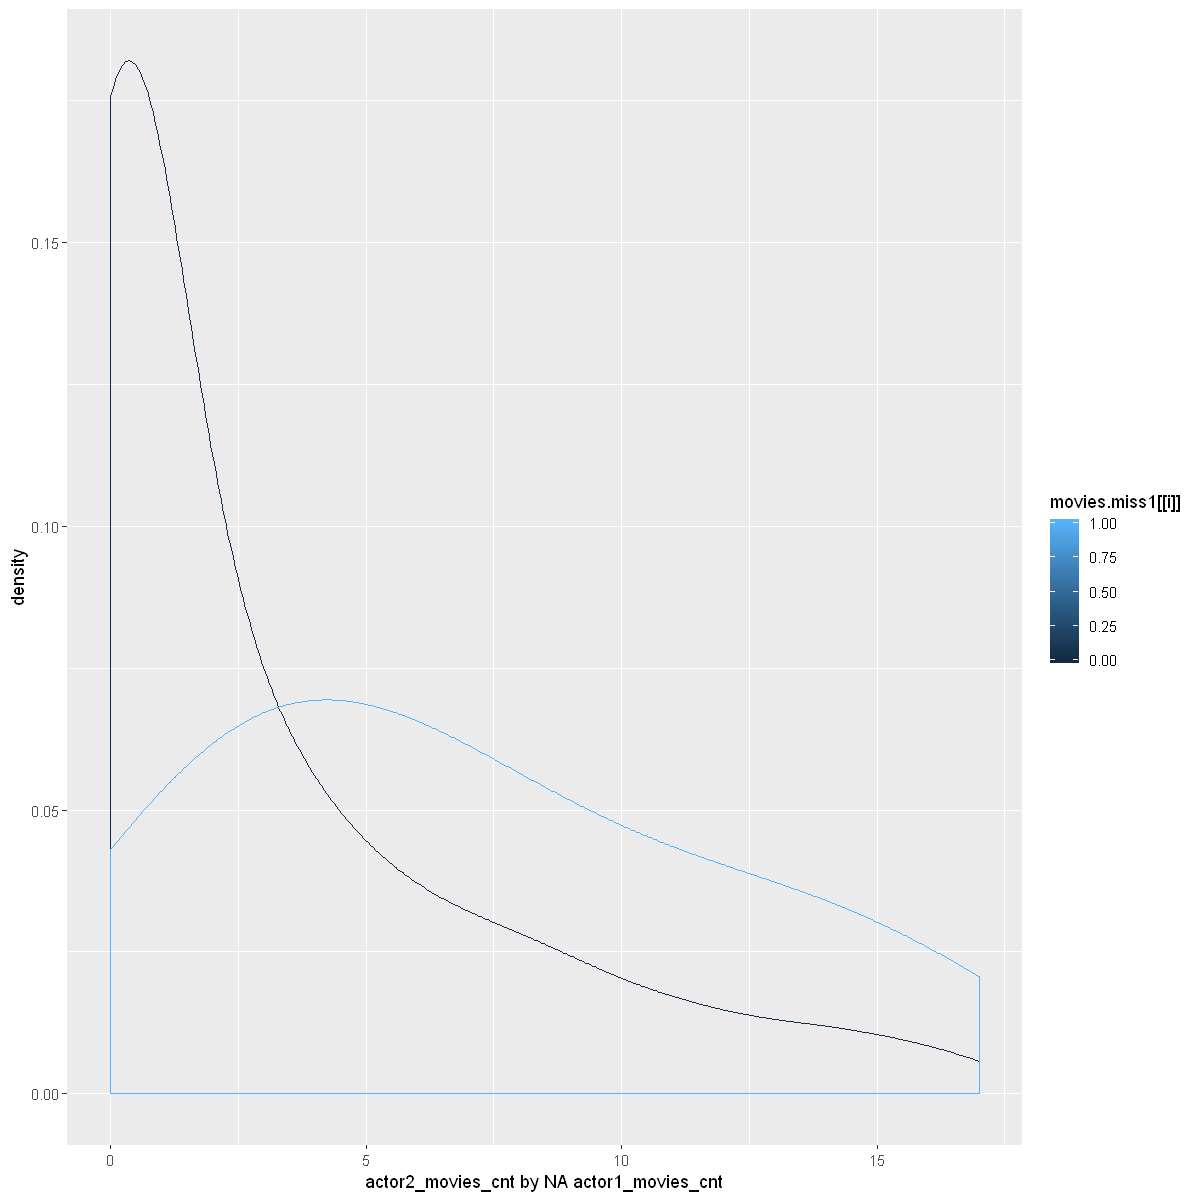


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.191, df = 359.22, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -118978592  -80488316
sample estimates:
mean of x mean of y 
167650298 267383752 

[1] "actor0_prev_revenue by NA actor1_movies_cnt"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


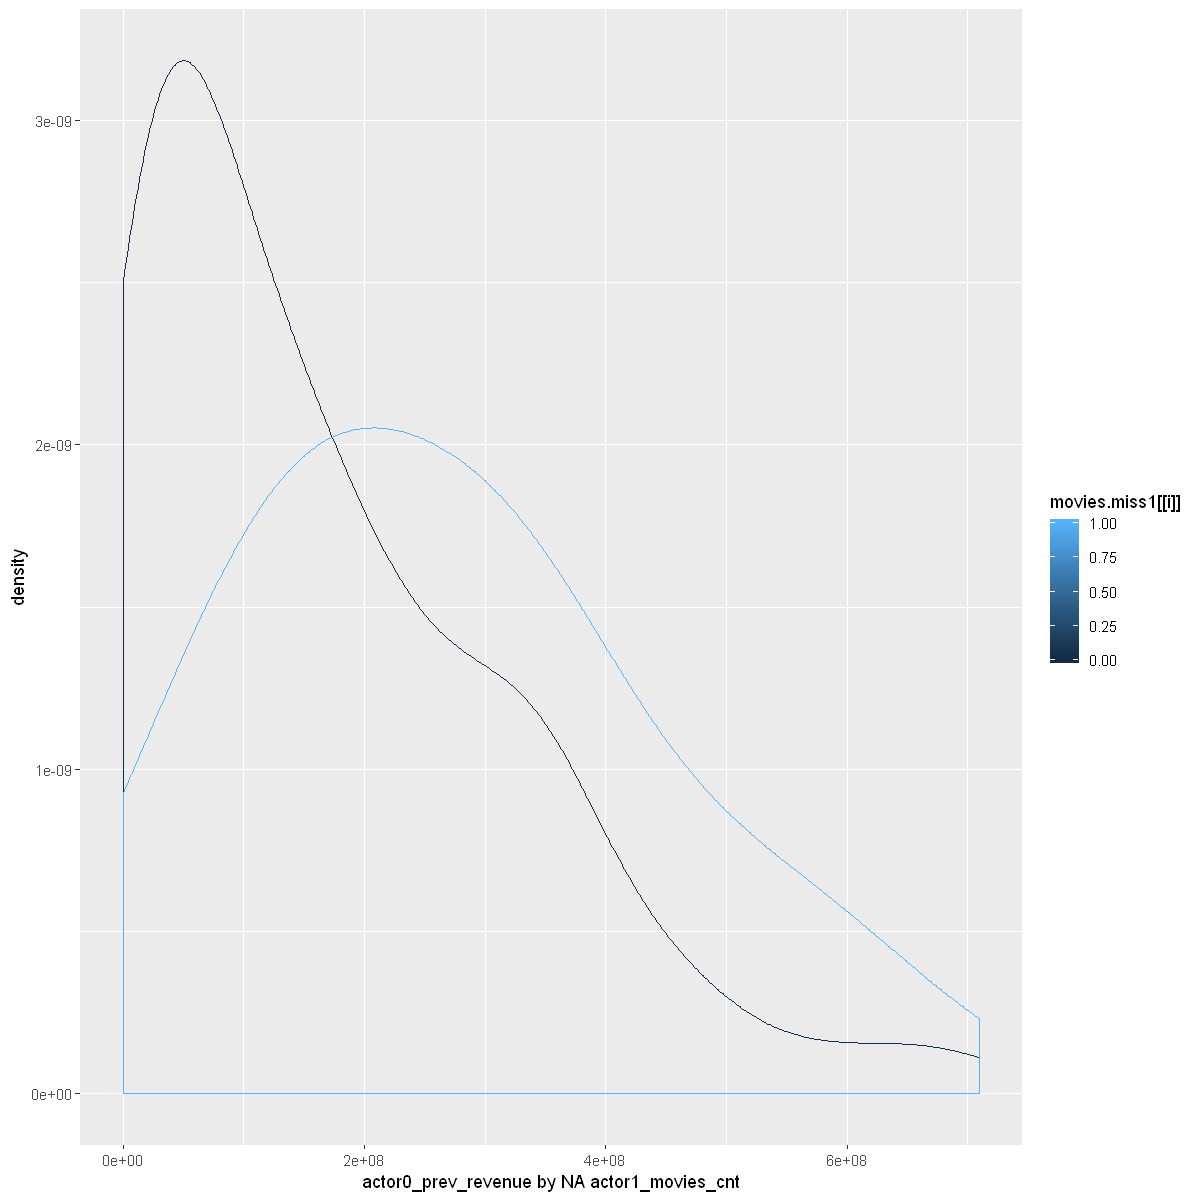


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -22.293, df = 388.01, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -162216265 -135922408
sample estimates:
mean of x mean of y 
133092029 282161366 

[1] "actor1_prev_revenue by NA actor1_movies_cnt"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


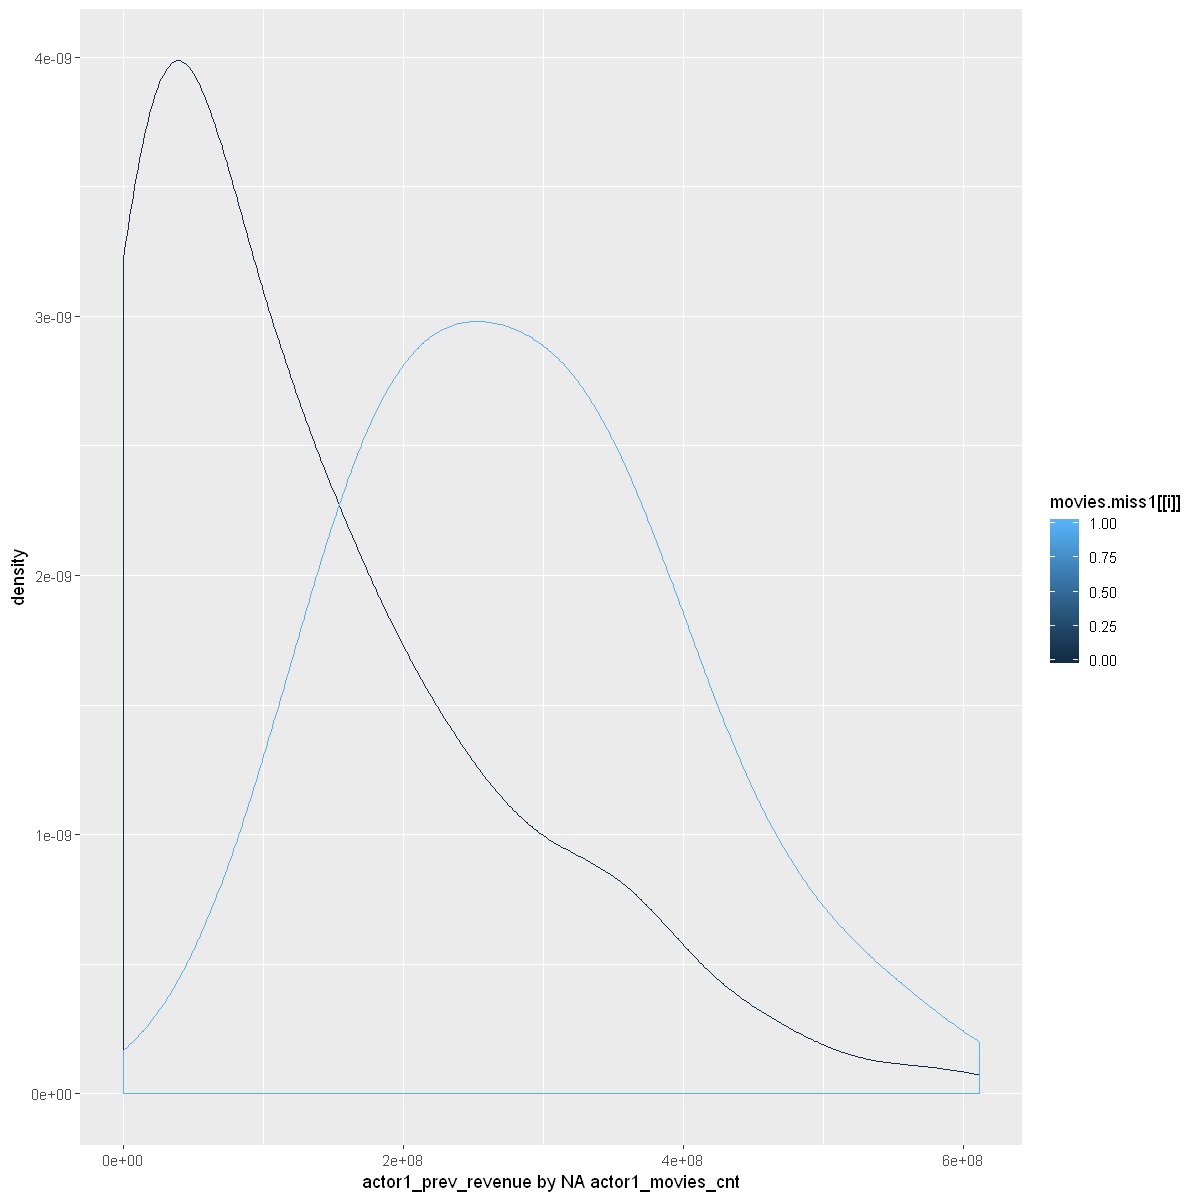


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.3304, df = 349.8, p-value = 1.853e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -84581343 -52271013
sample estimates:
mean of x mean of y 
128065381 196491558 

[1] "actor2_prev_revenue by NA actor1_movies_cnt"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


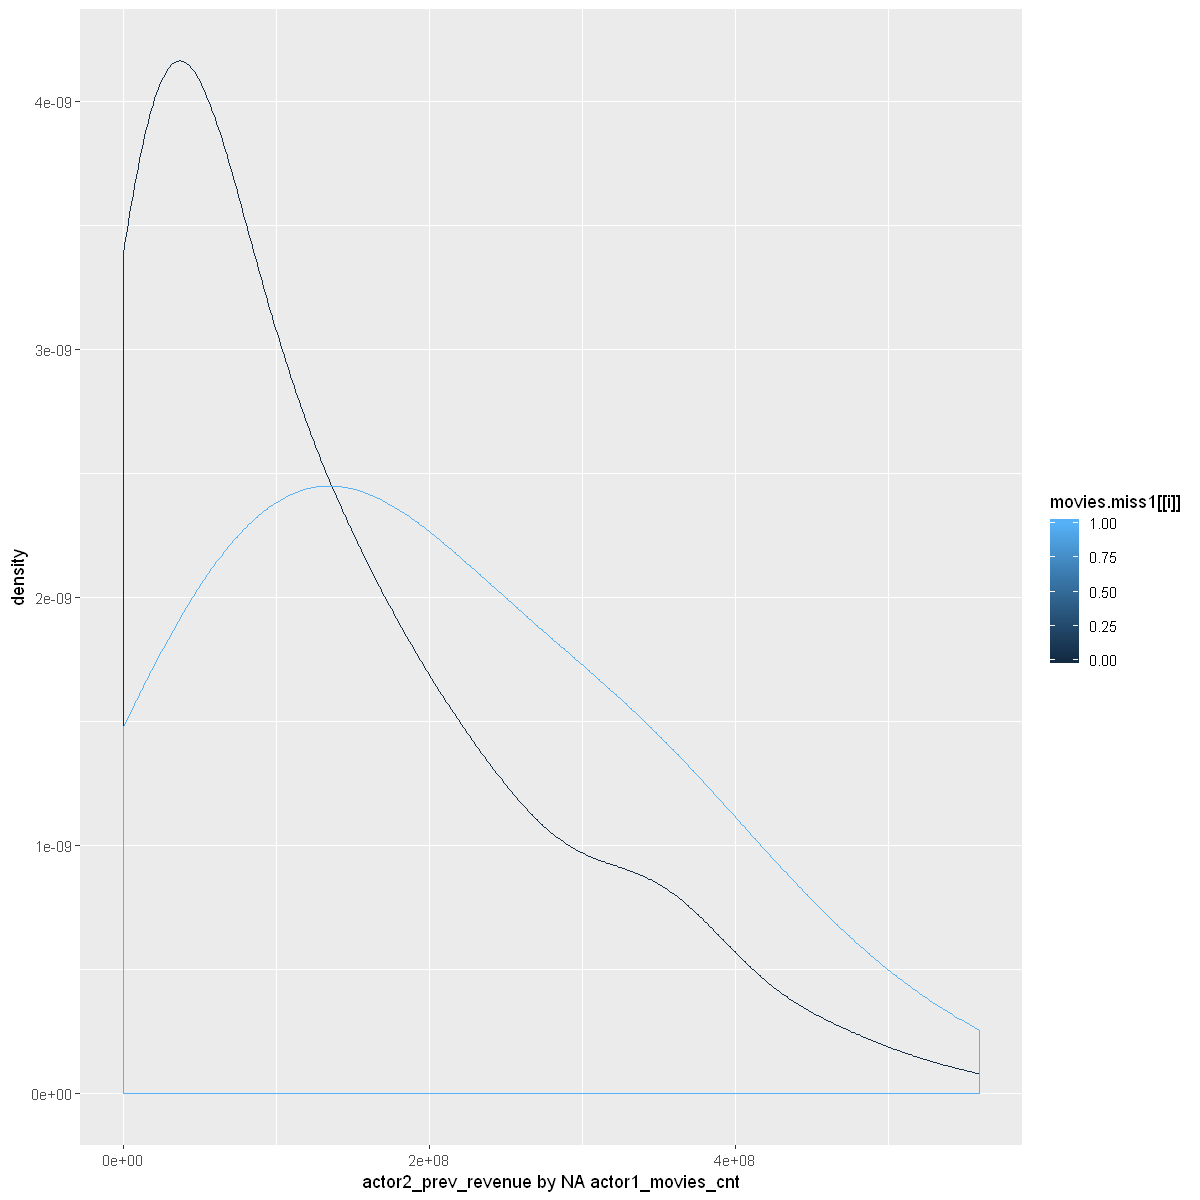


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.3246, df = 386.89, p-value = 1.405e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0248540 -0.5910903
sample estimates:
mean of x mean of y 
 1.312140  2.120112 

[1] "director_movies_cnt by NA actor1_movies_cnt"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


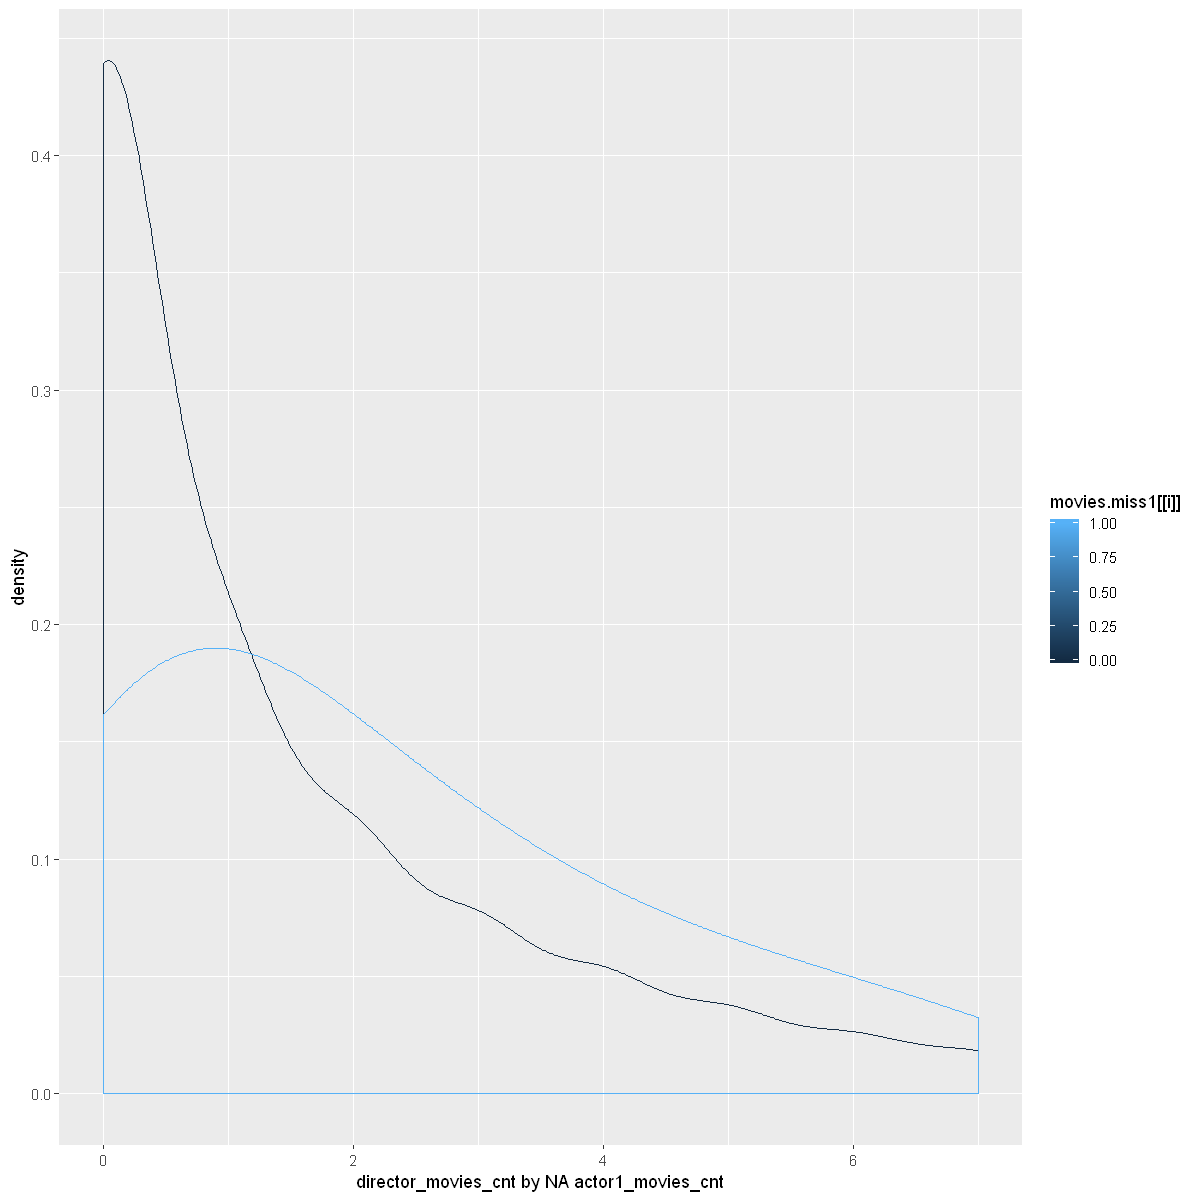


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.3343, df = 368.75, p-value = 1.428e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.134566 -0.654811
sample estimates:
mean of x mean of y 
 1.561707  2.456395 

[1] "depart_Art by NA actor1_movies_cnt"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


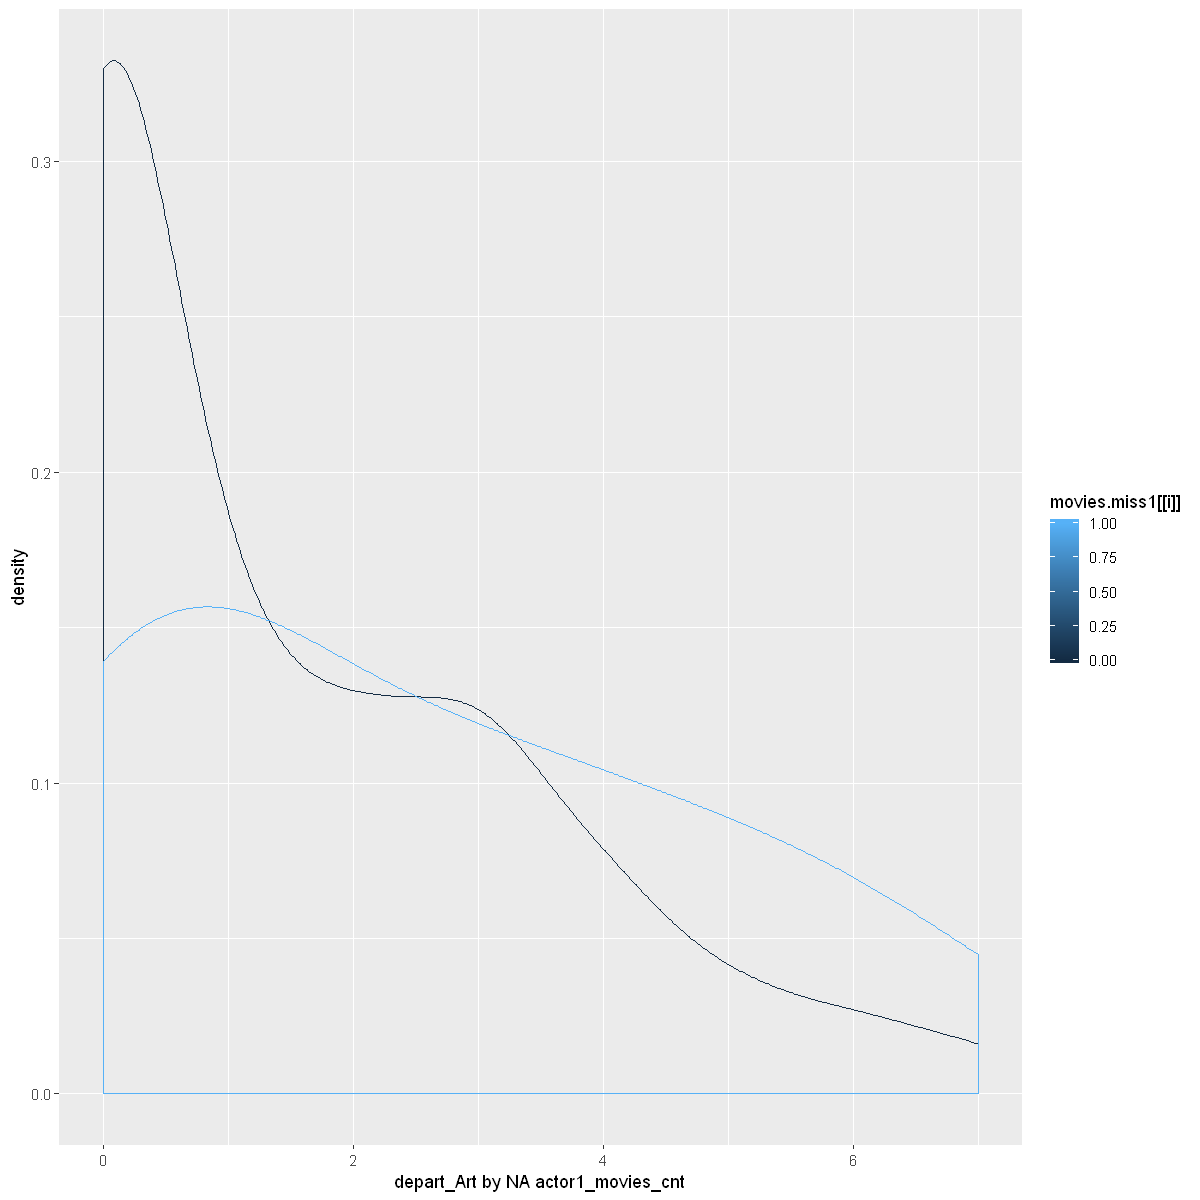


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -3.1154, df = 372.27, p-value = 0.001979
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.36788531 -0.08318265
sample estimates:
mean of x mean of y 
 1.100047  1.325581 

[1] "depart_Camera by NA actor1_movies_cnt"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


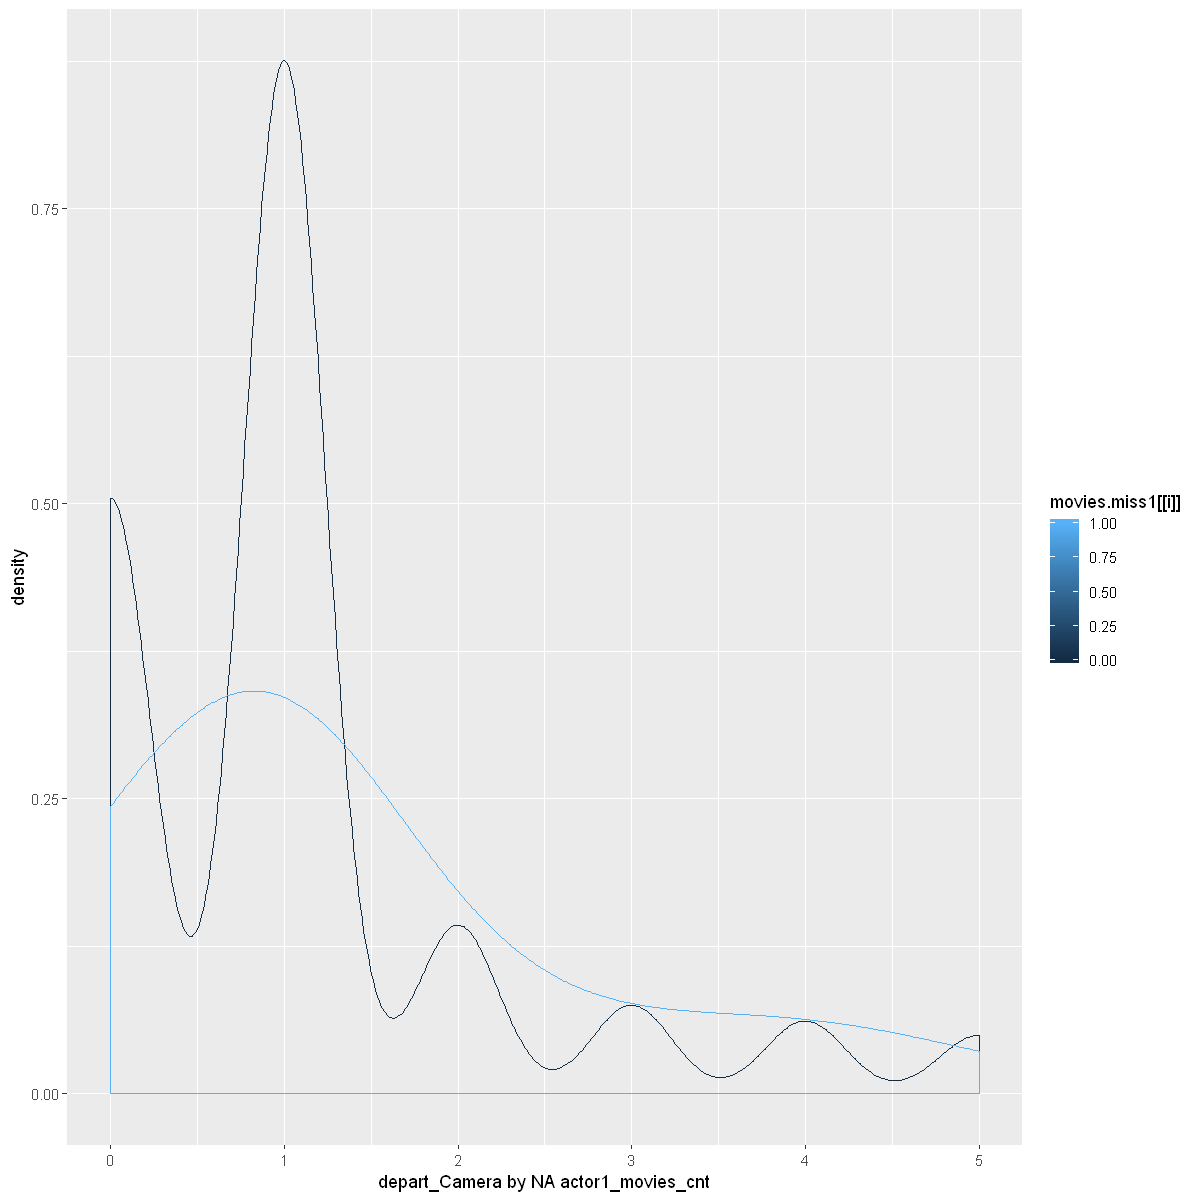


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -3.5696, df = 324.28, p-value = 0.0004116
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4699612 -0.1359976
sample estimates:
mean of x mean of y 
0.8631336 1.1661130 

[1] "depart_Custom_Mkup by NA actor1_movies_cnt"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


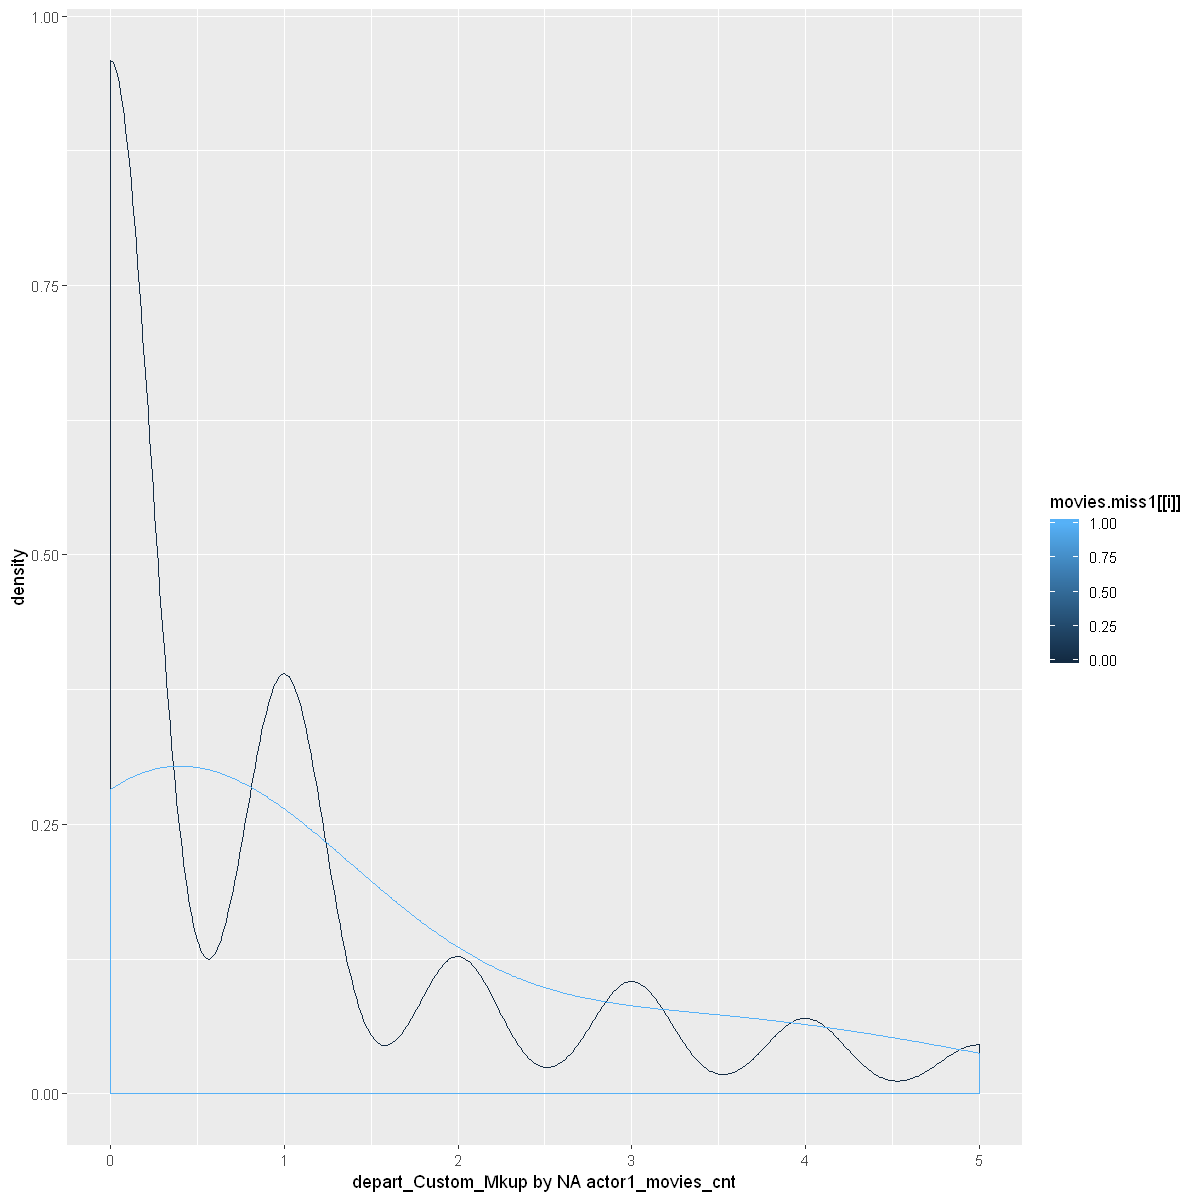


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.0505, df = 418.23, p-value = 3.209e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2991679 -0.1524496
sample estimates:
mean of x mean of y 
 1.399846  1.625654 

[1] "depart_Directing by NA actor1_movies_cnt"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


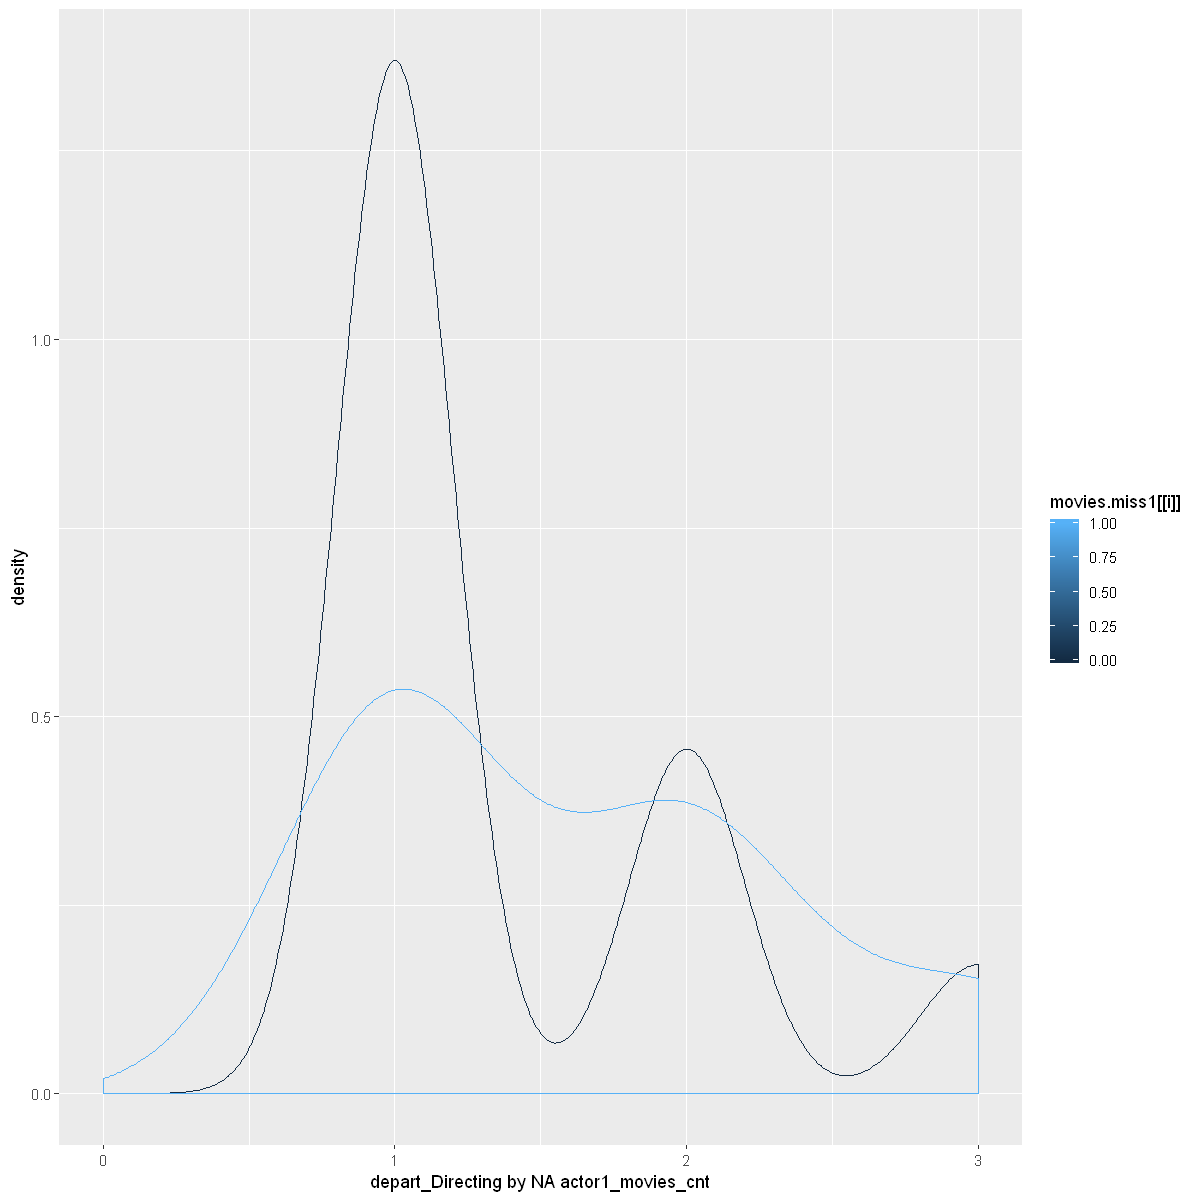


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -1.7915, df = 322.58, p-value = 0.07415
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.31601034  0.01478499
sample estimates:
mean of x mean of y 
 1.256167  1.406780 

[1] "depart_Sound by NA actor1_movies_cnt"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


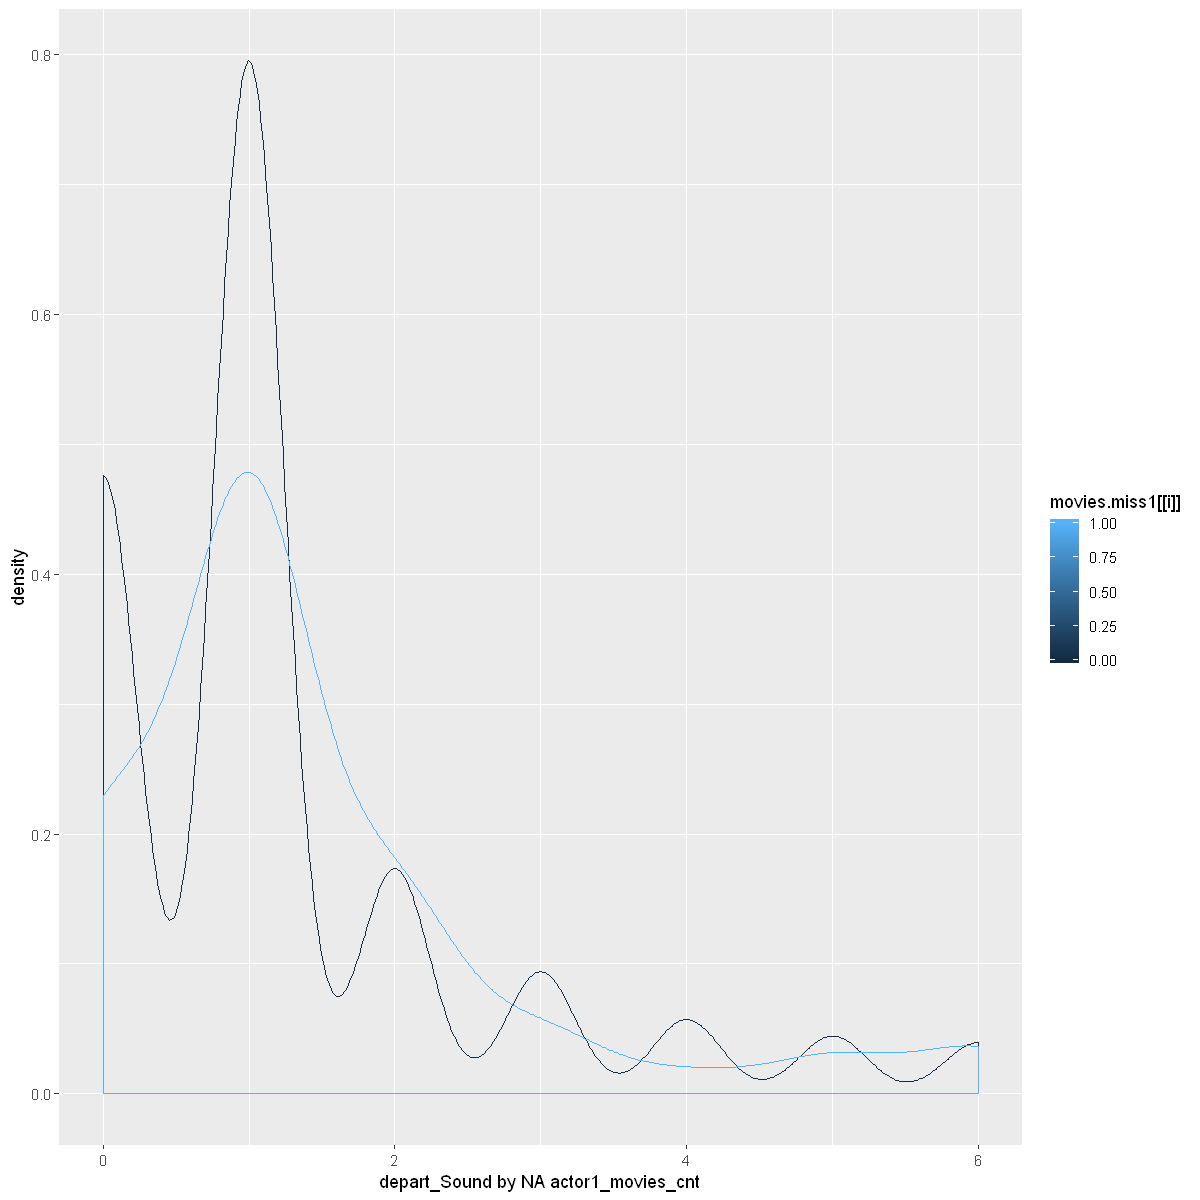


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -9.7231, df = 381.85, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -16138226 -10709182
sample estimates:
mean of x mean of y 
 21208895  34632599 

[1] "budget by NA actor2_movies_cnt"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


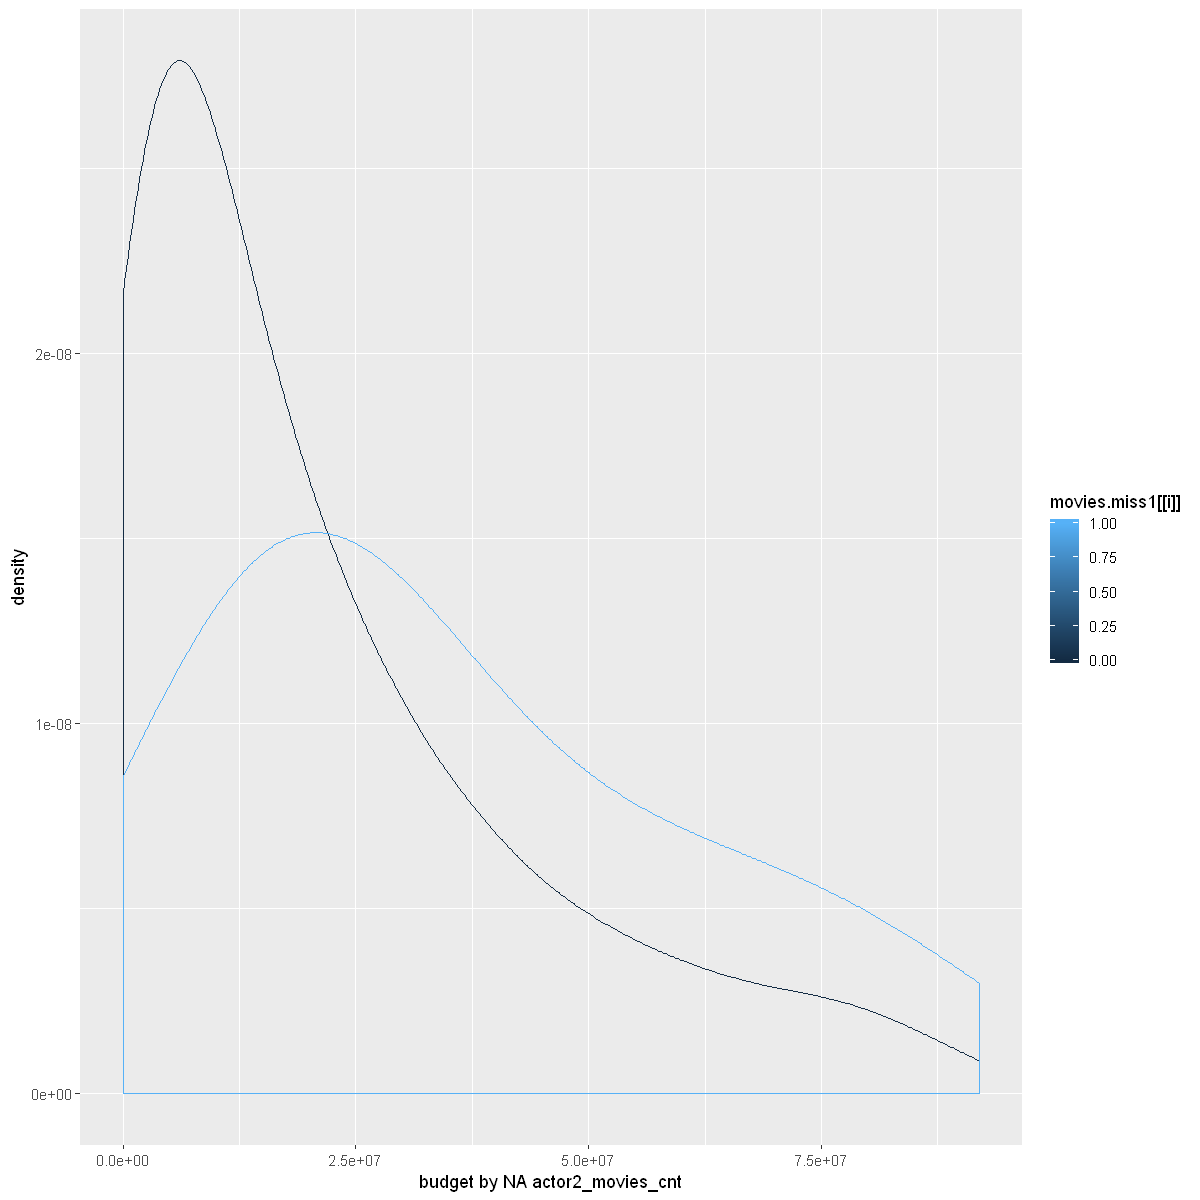


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.491, df = 569.28, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.2945079 -0.8862328
sample estimates:
mean of x mean of y 
  2.82963   3.92000 

[1] "producers_cnt by NA actor2_movies_cnt"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


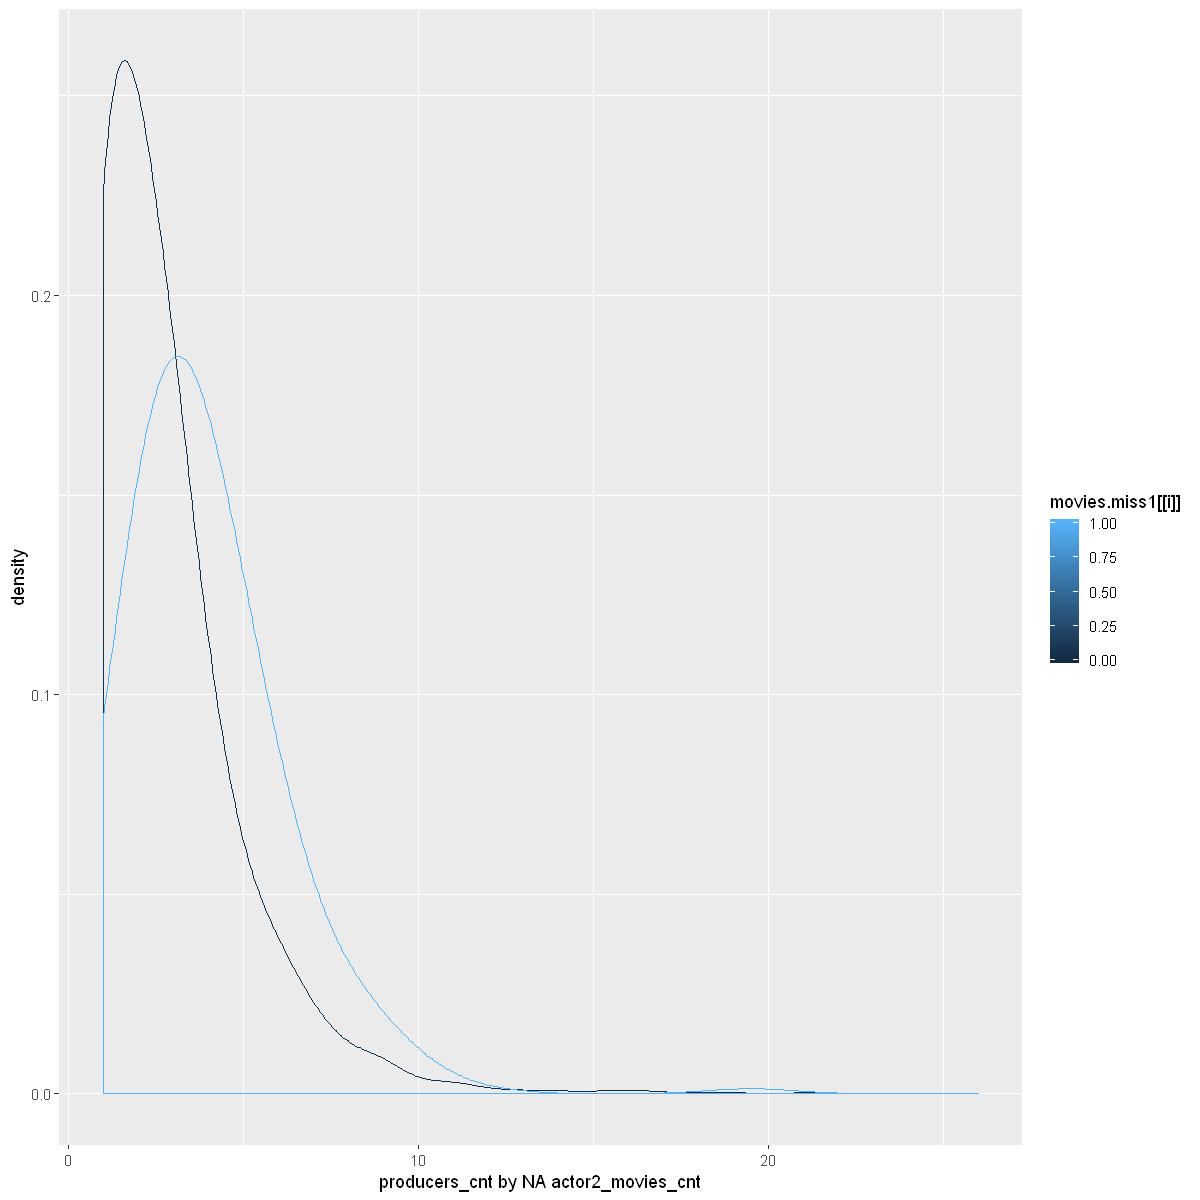


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -18.48, df = 415.64, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -6.264758 -5.060153
sample estimates:
mean of x mean of y 
 3.752052  9.414508 

[1] "actor1_movies_cnt by NA actor2_movies_cnt"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


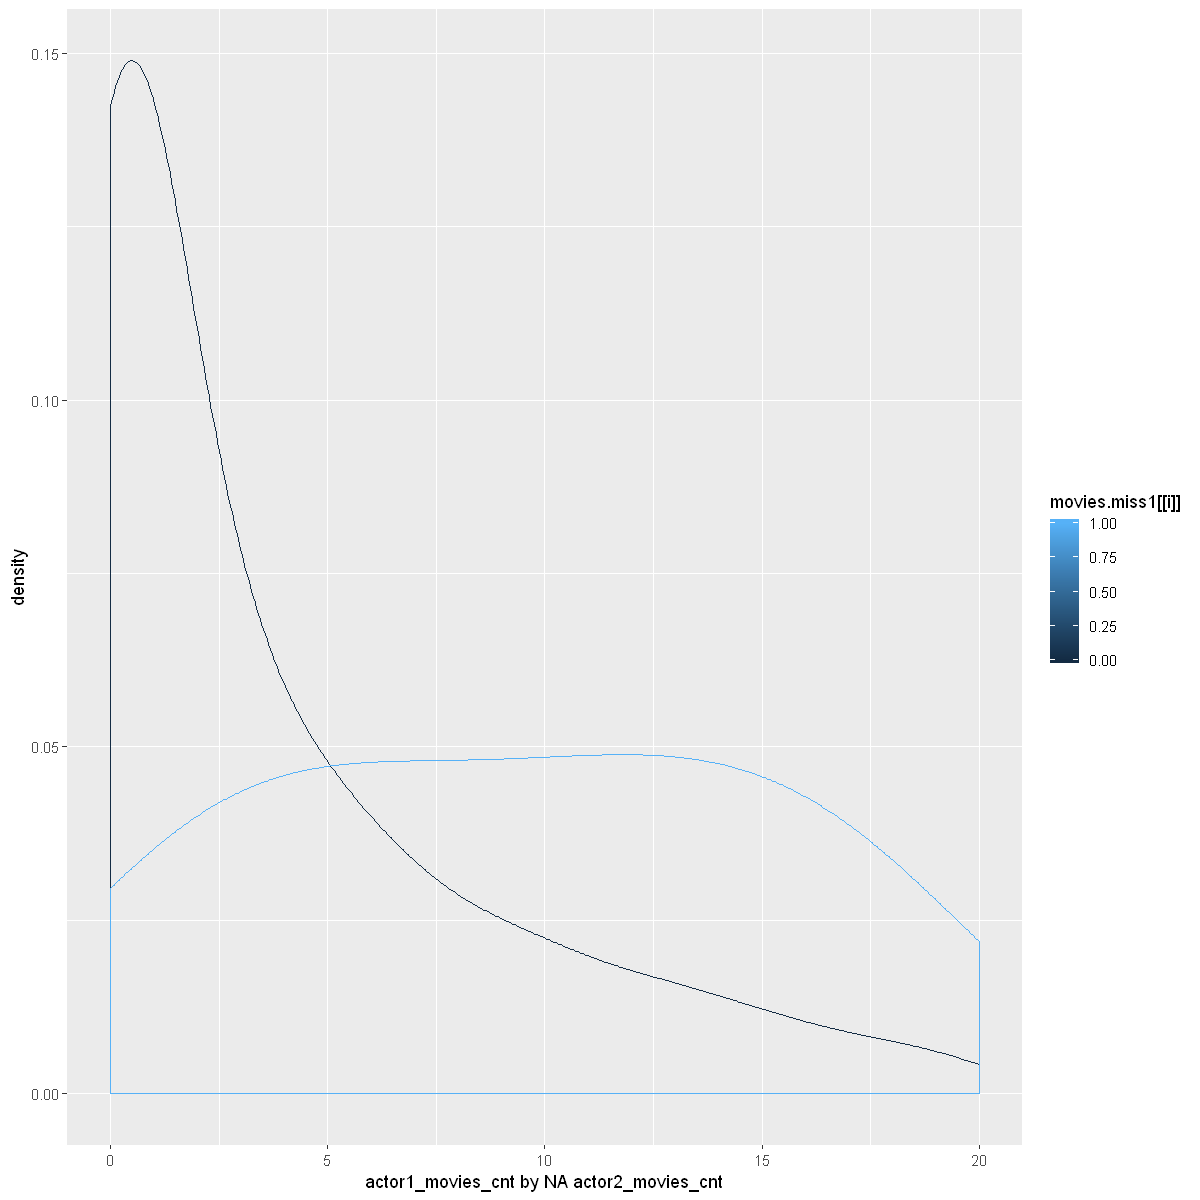


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -11.739, df = 456.96, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -123808116  -88299029
sample estimates:
mean of x mean of y 
165308151 271361723 

[1] "actor0_prev_revenue by NA actor2_movies_cnt"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


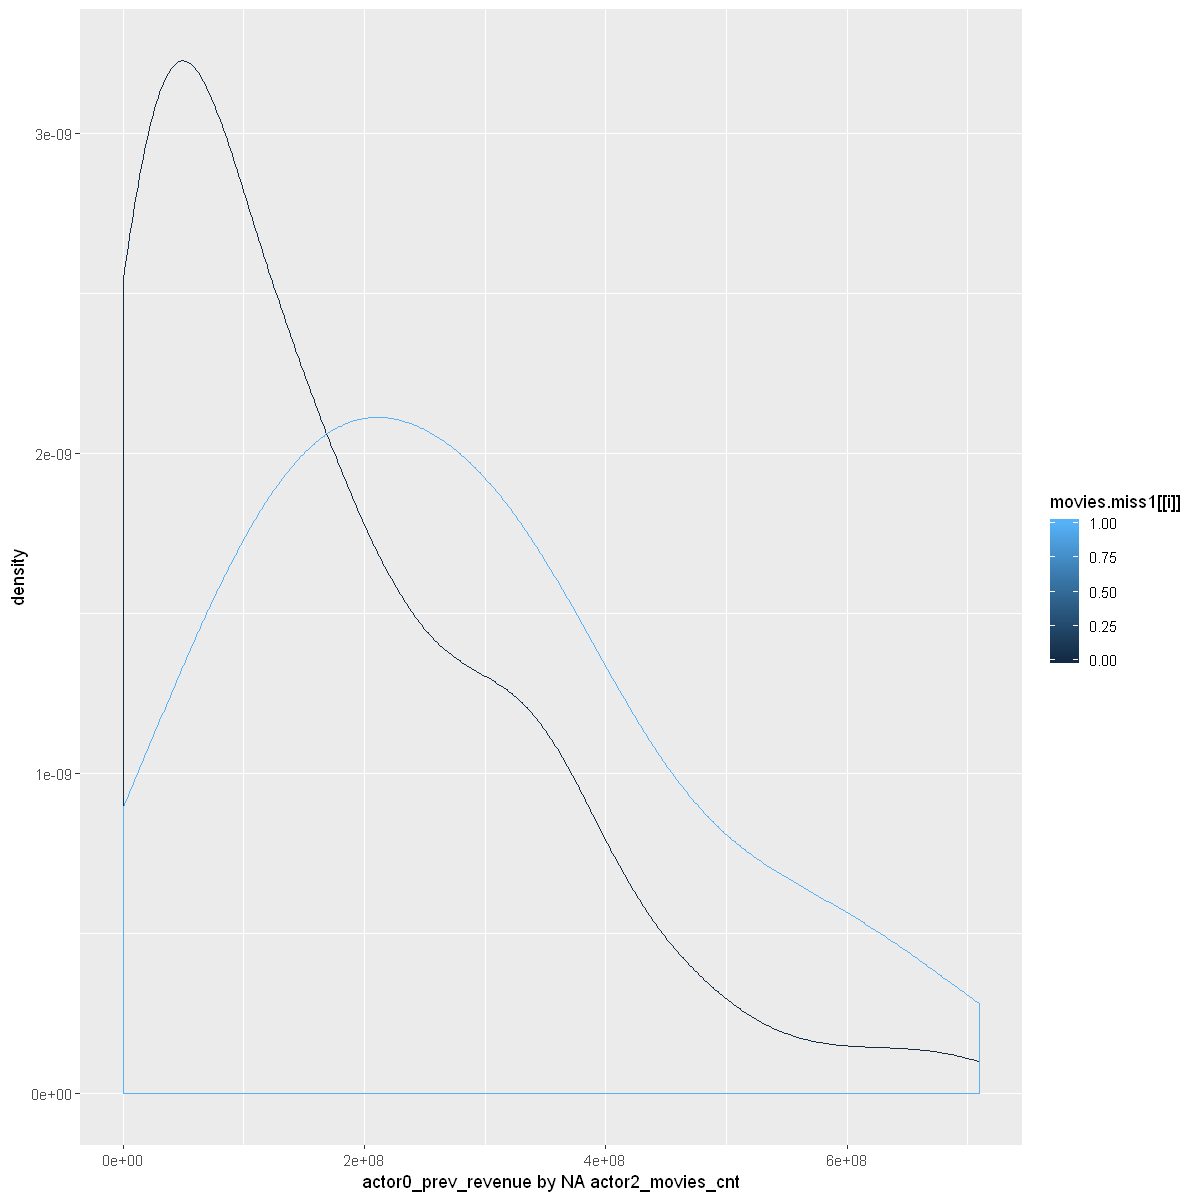


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.717, df = 426.28, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -99109209 -68388339
sample estimates:
mean of x mean of y 
137300079 221048854 

[1] "actor1_prev_revenue by NA actor2_movies_cnt"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


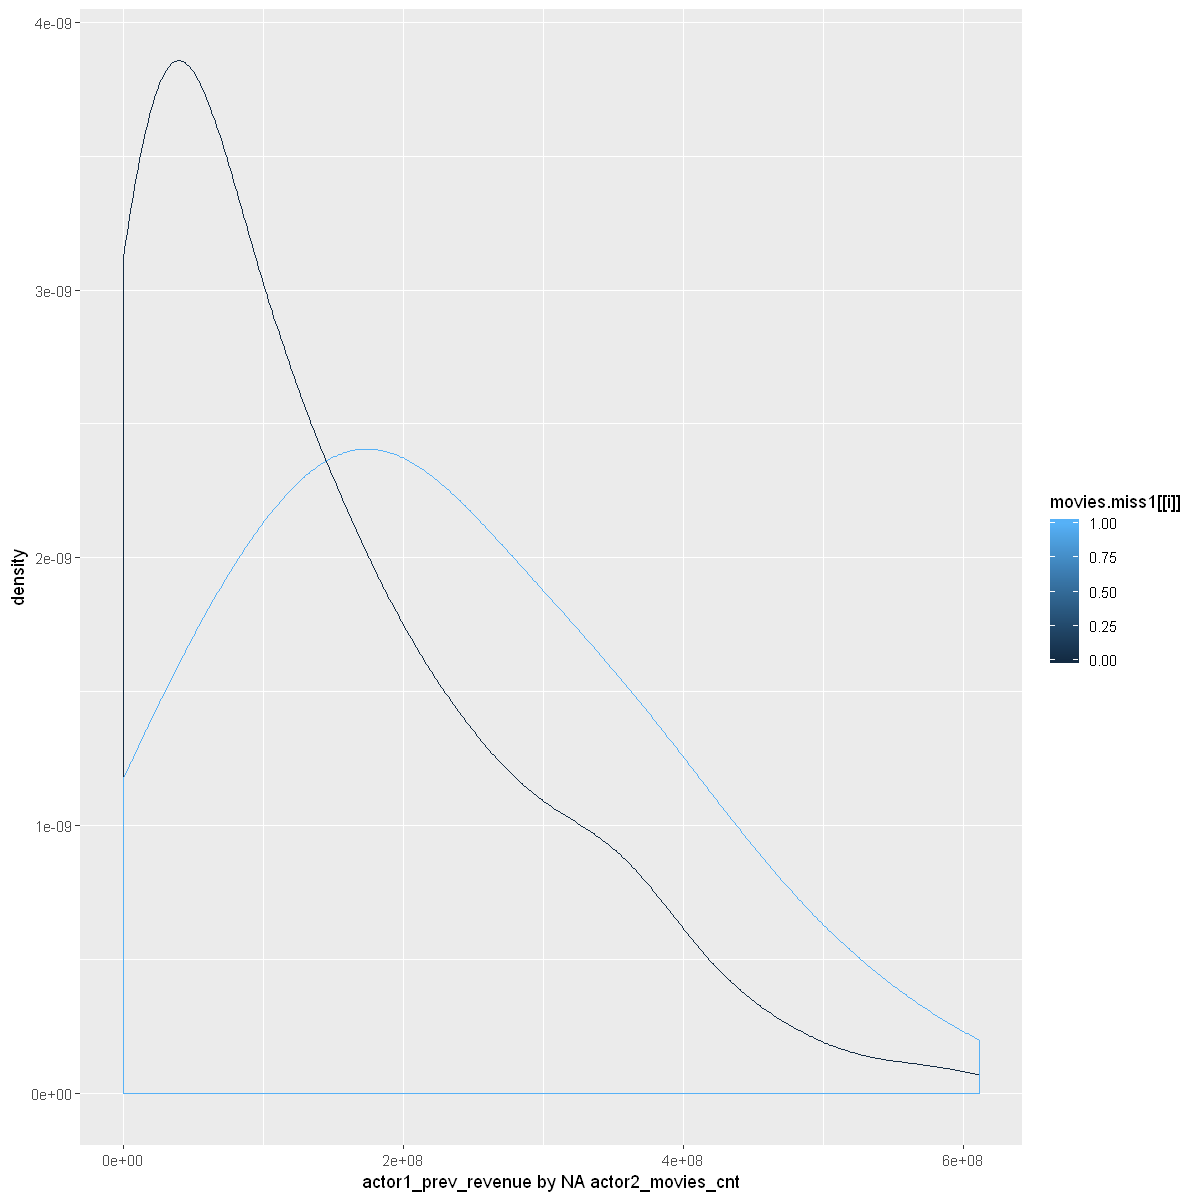


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -23.38, df = 491.81, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -154954319 -130929337
sample estimates:
mean of x mean of y 
118690854 261632682 

[1] "actor2_prev_revenue by NA actor2_movies_cnt"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


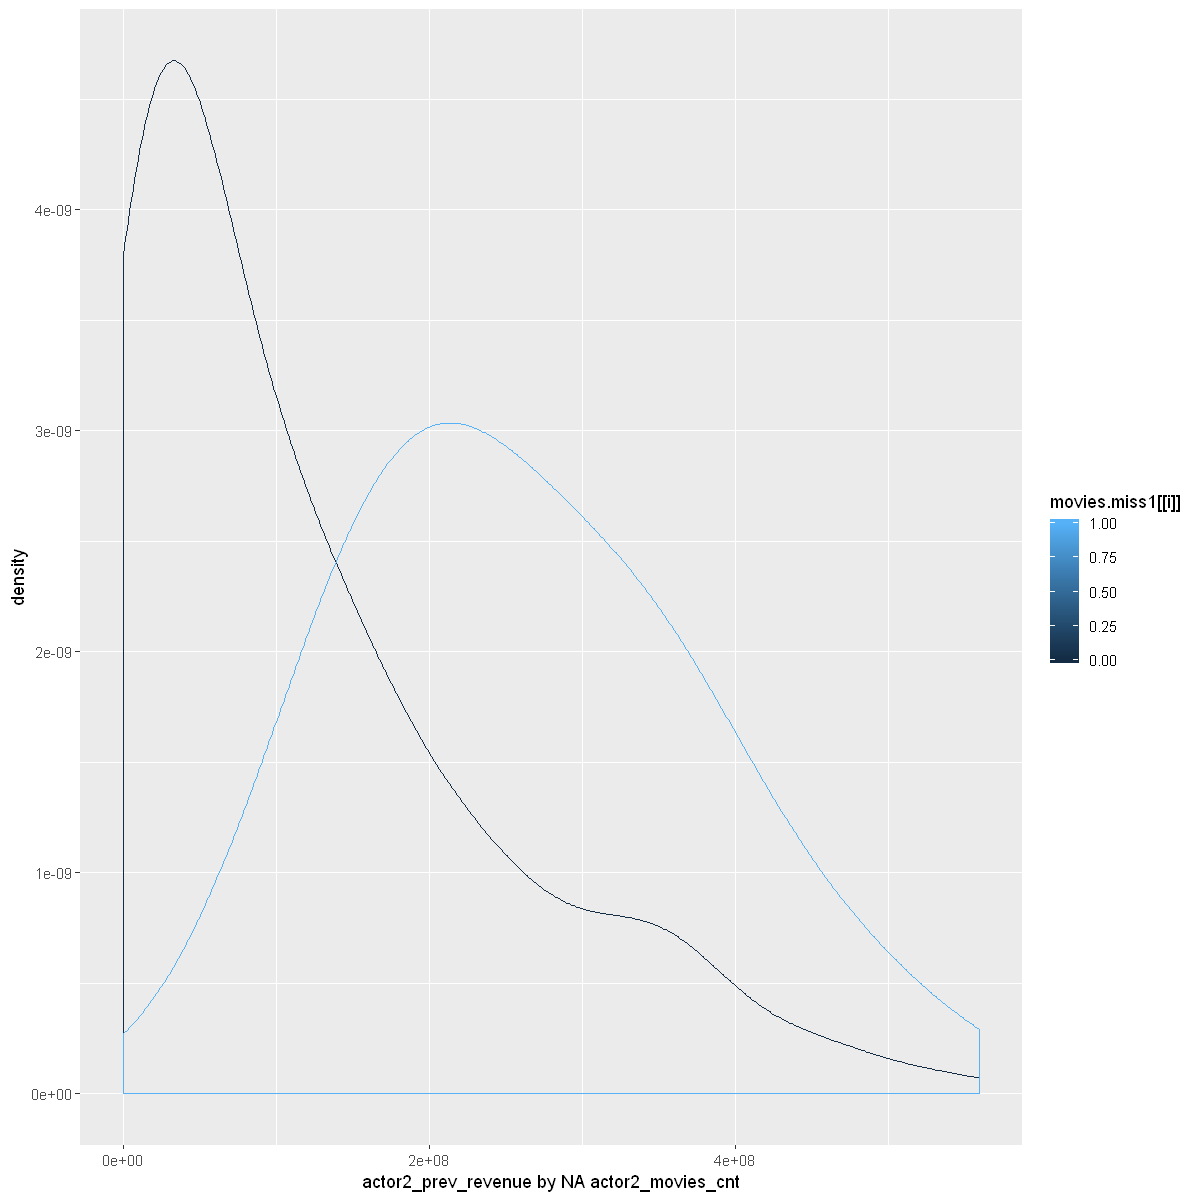


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.8692, df = 498.93, p-value = 2.233e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9643839 -0.5790349
sample estimates:
mean of x mean of y 
 1.303679  2.075388 

[1] "director_movies_cnt by NA actor2_movies_cnt"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


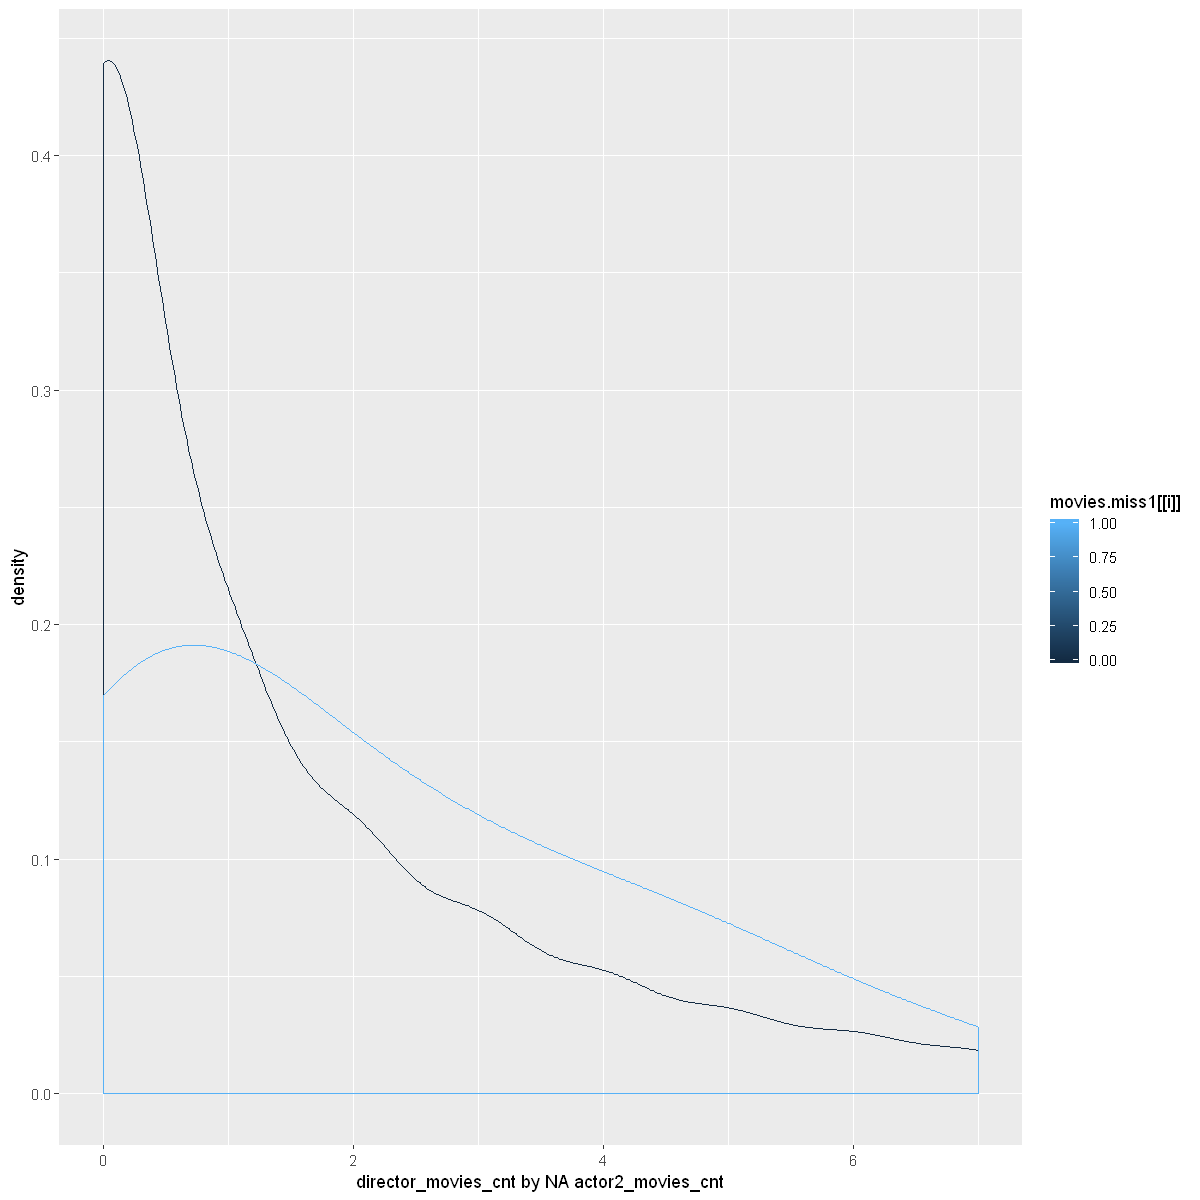


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.8577, df = 440.81, p-value = 3.021e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.057785 -0.634512
sample estimates:
mean of x mean of y 
 1.556836  2.402985 

[1] "depart_Art by NA actor2_movies_cnt"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


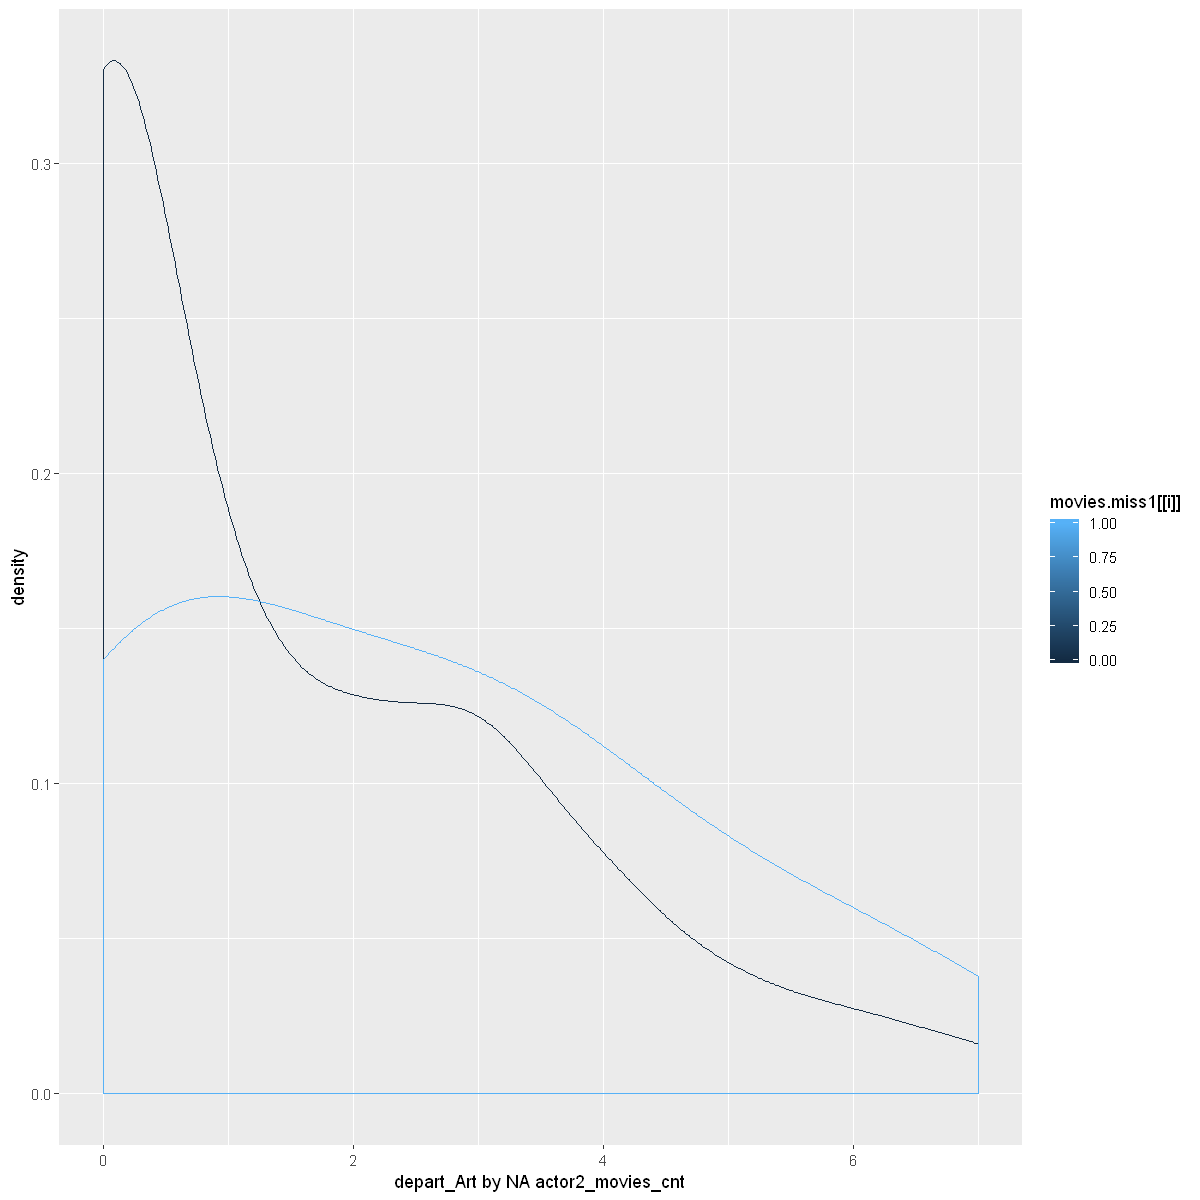


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -4.2266, df = 446.81, p-value = 2.878e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4310115 -0.1574077
sample estimates:
mean of x mean of y 
 1.093595  1.387805 

[1] "depart_Camera by NA actor2_movies_cnt"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


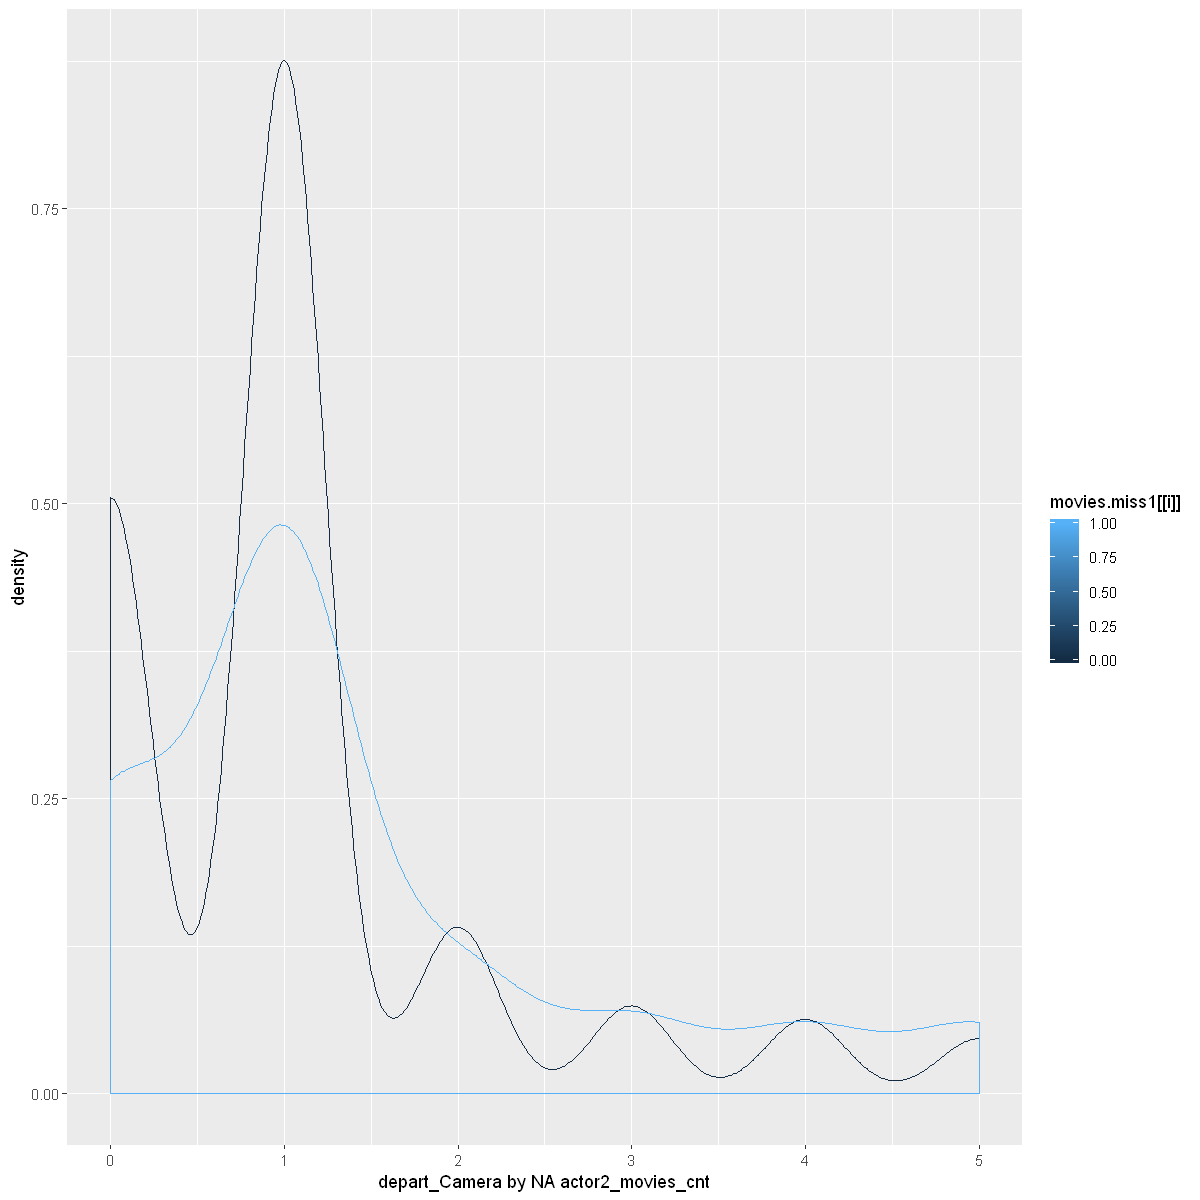


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -4.0411, df = 389.61, p-value = 6.411e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4753108 -0.1641858
sample estimates:
mean of x mean of y 
0.8595234 1.1792717 

[1] "depart_Custom_Mkup by NA actor2_movies_cnt"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


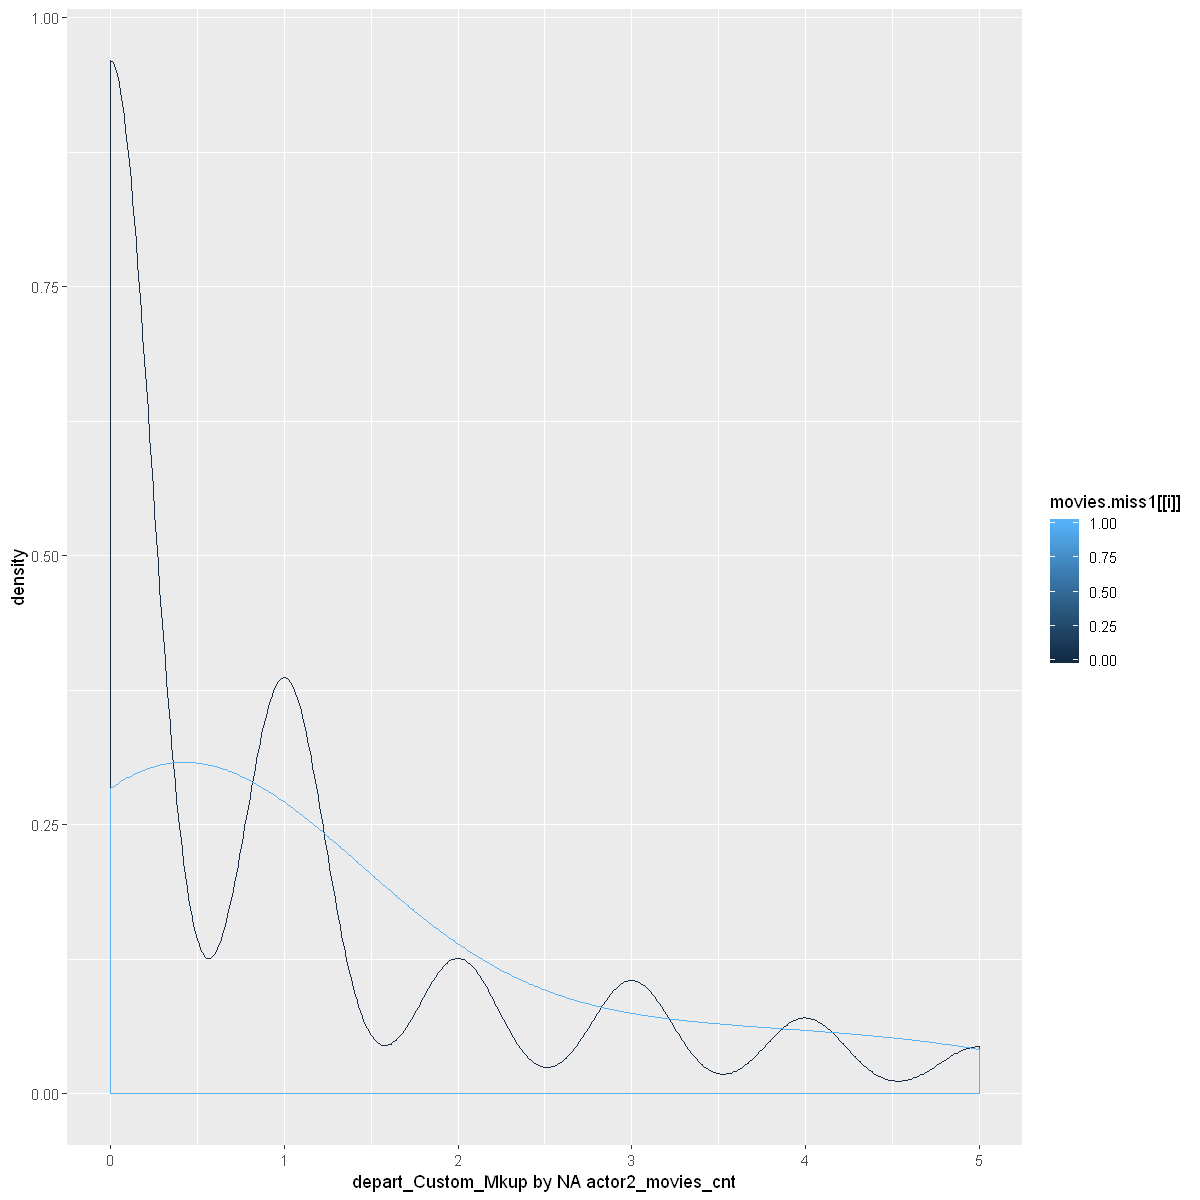


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.0711, df = 514.32, p-value = 5.04e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3179299 -0.1796785
sample estimates:
mean of x mean of y 
 1.395592  1.644397 

[1] "depart_Directing by NA actor2_movies_cnt"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


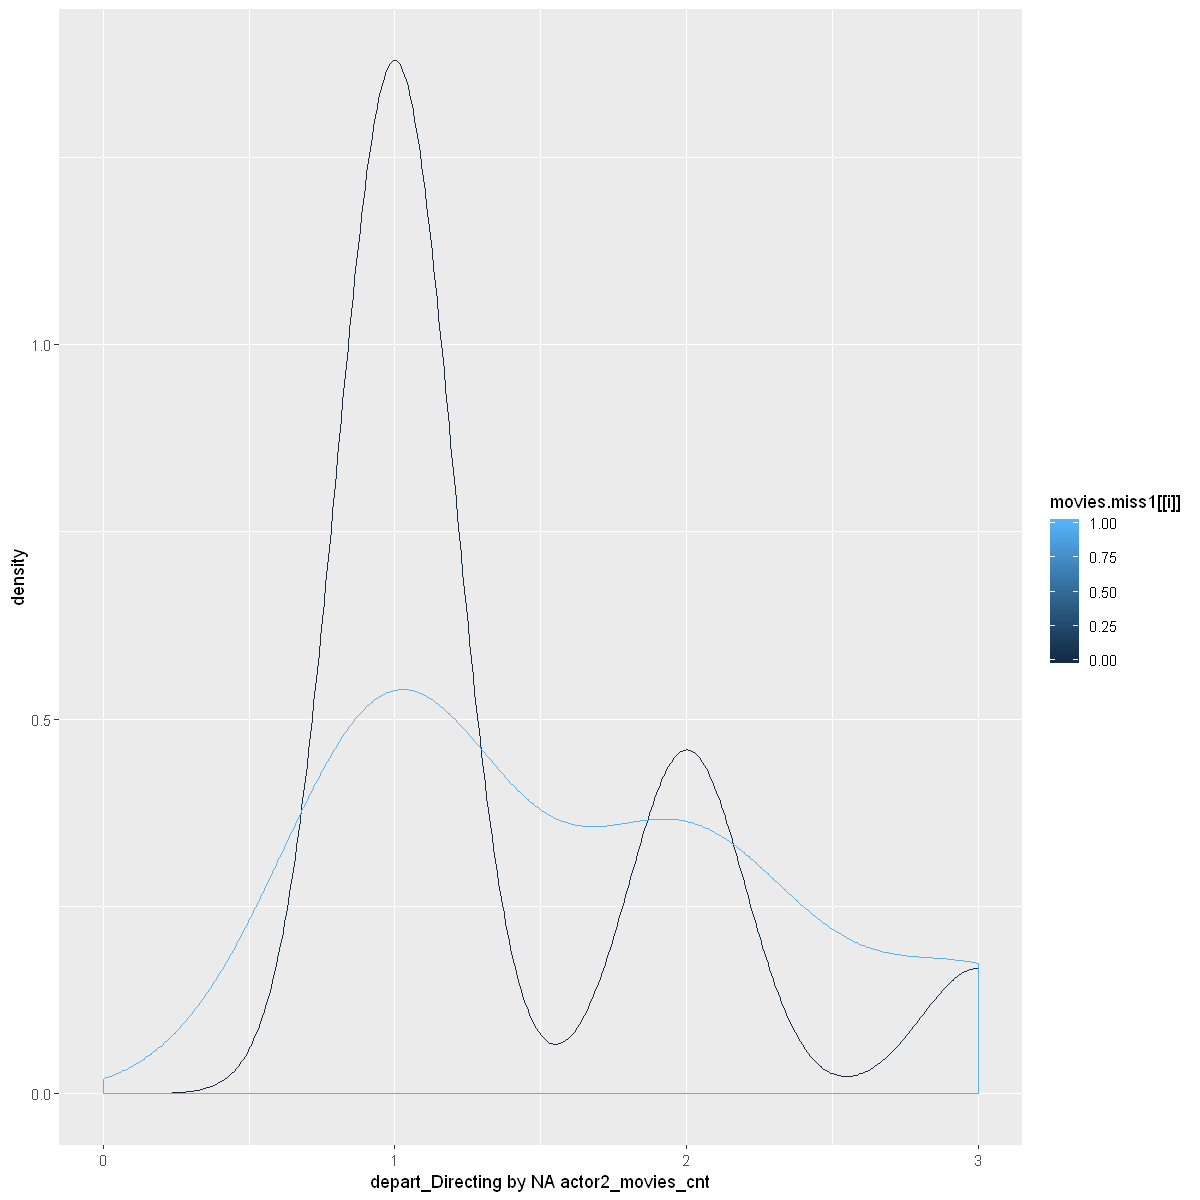


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -2.5335, df = 384.23, p-value = 0.01169
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.35289121 -0.04449205
sample estimates:
mean of x mean of y 
 1.252175  1.450867 

[1] "depart_Sound by NA actor2_movies_cnt"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


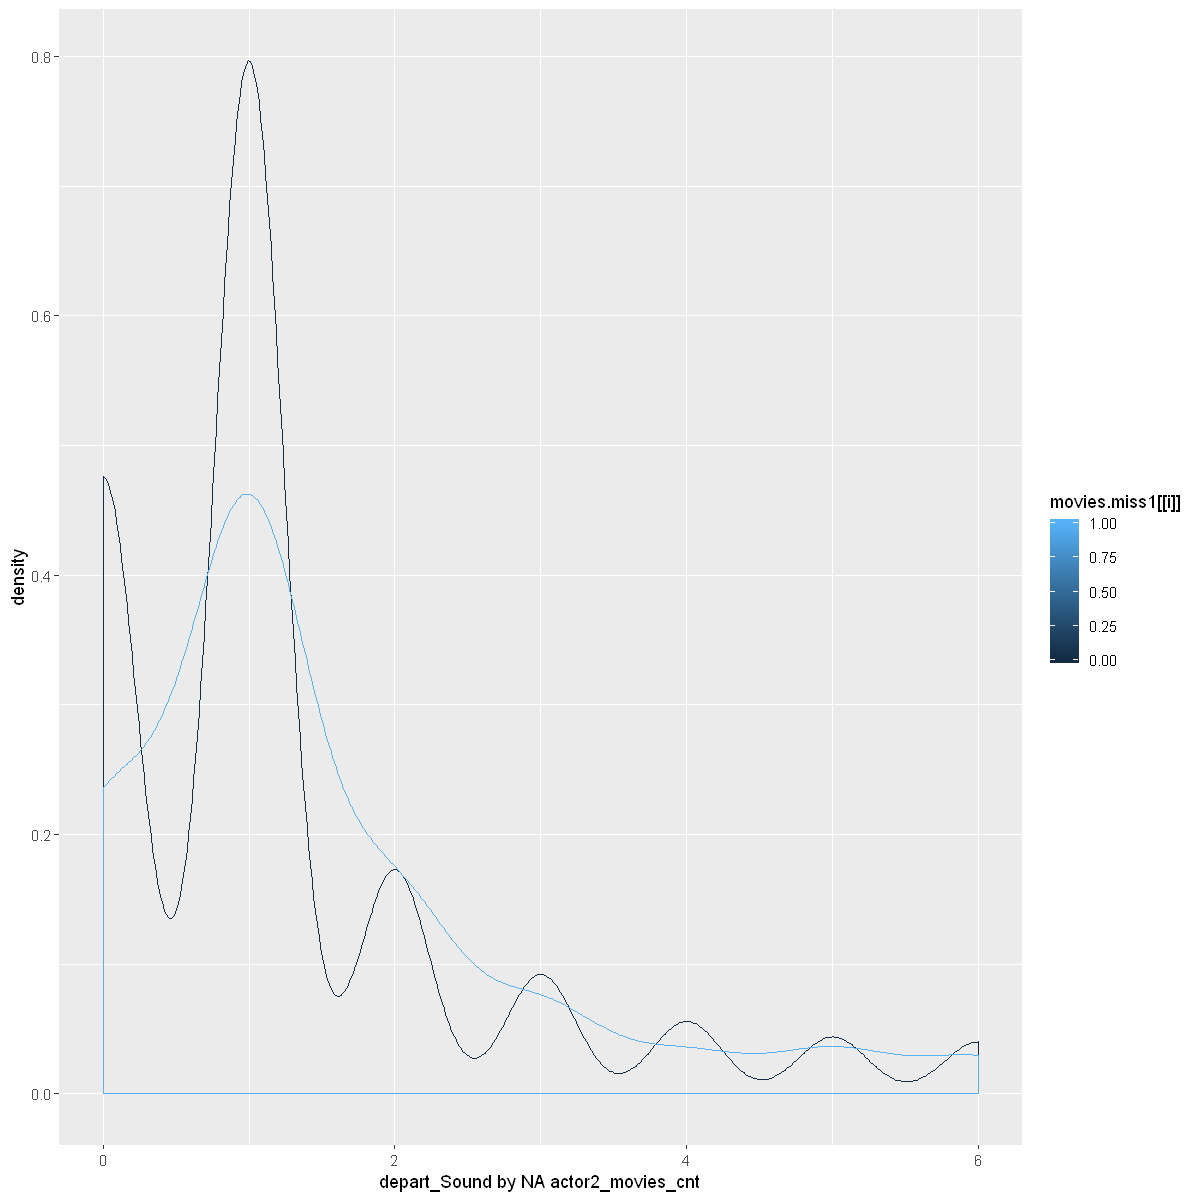


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 18.727, df = 4513.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  9973711 12306162
sample estimates:
mean of x mean of y 
 26310359  15170423 

[1] "budget by NA actor0_prev_revenue"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


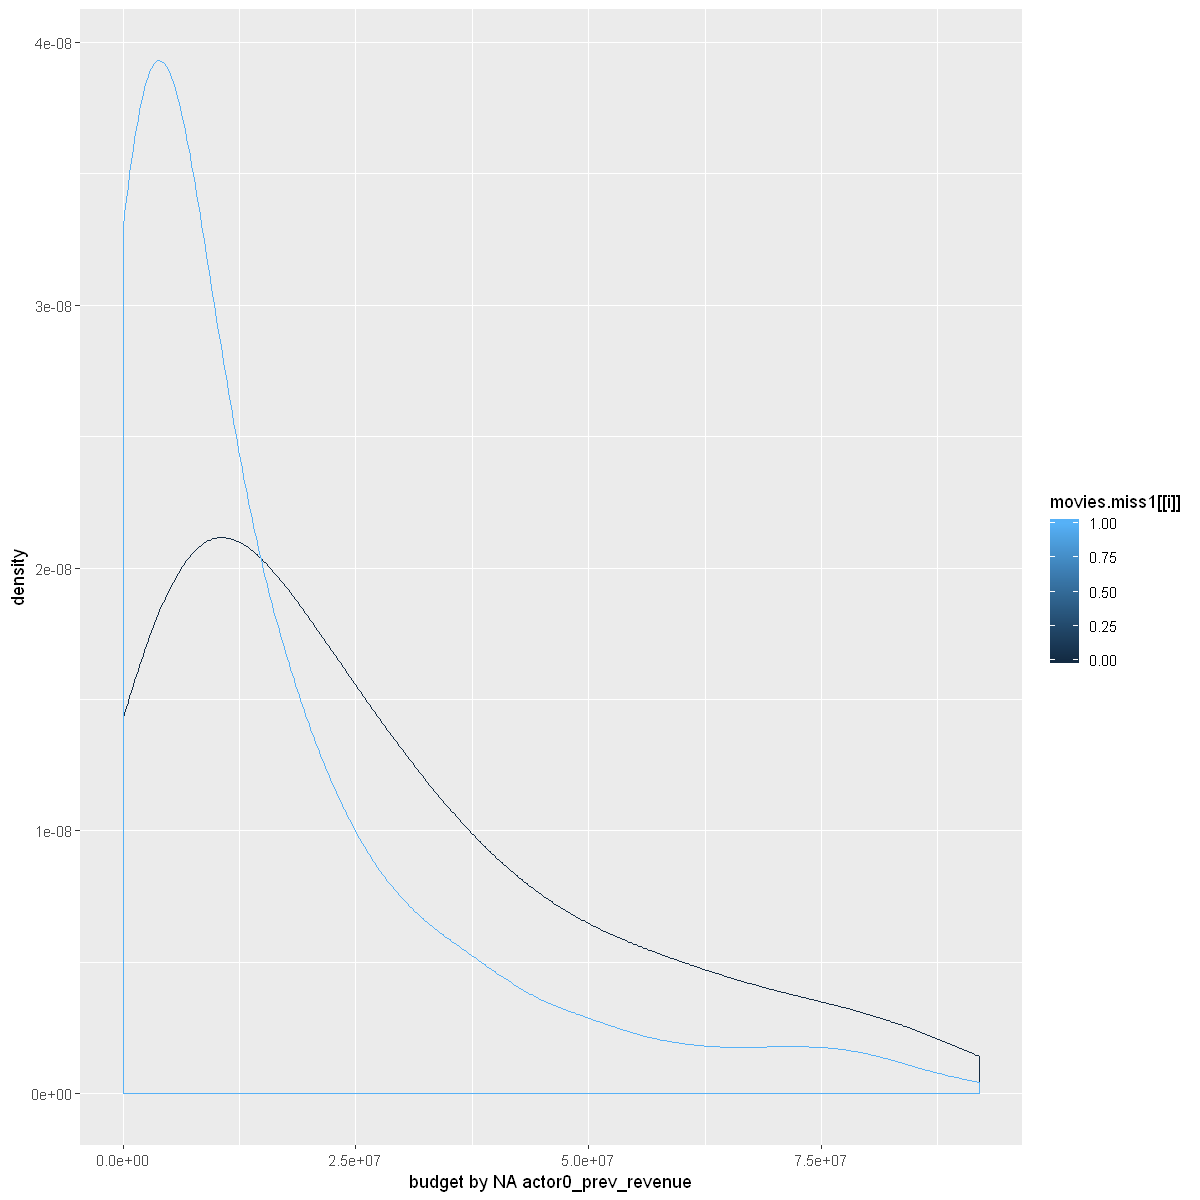


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 3.1674, df = 5578.7, p-value = 0.001546
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.06438391 0.27352306
sample estimates:
mean of x mean of y 
 2.975197  2.806243 

[1] "producers_cnt by NA actor0_prev_revenue"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


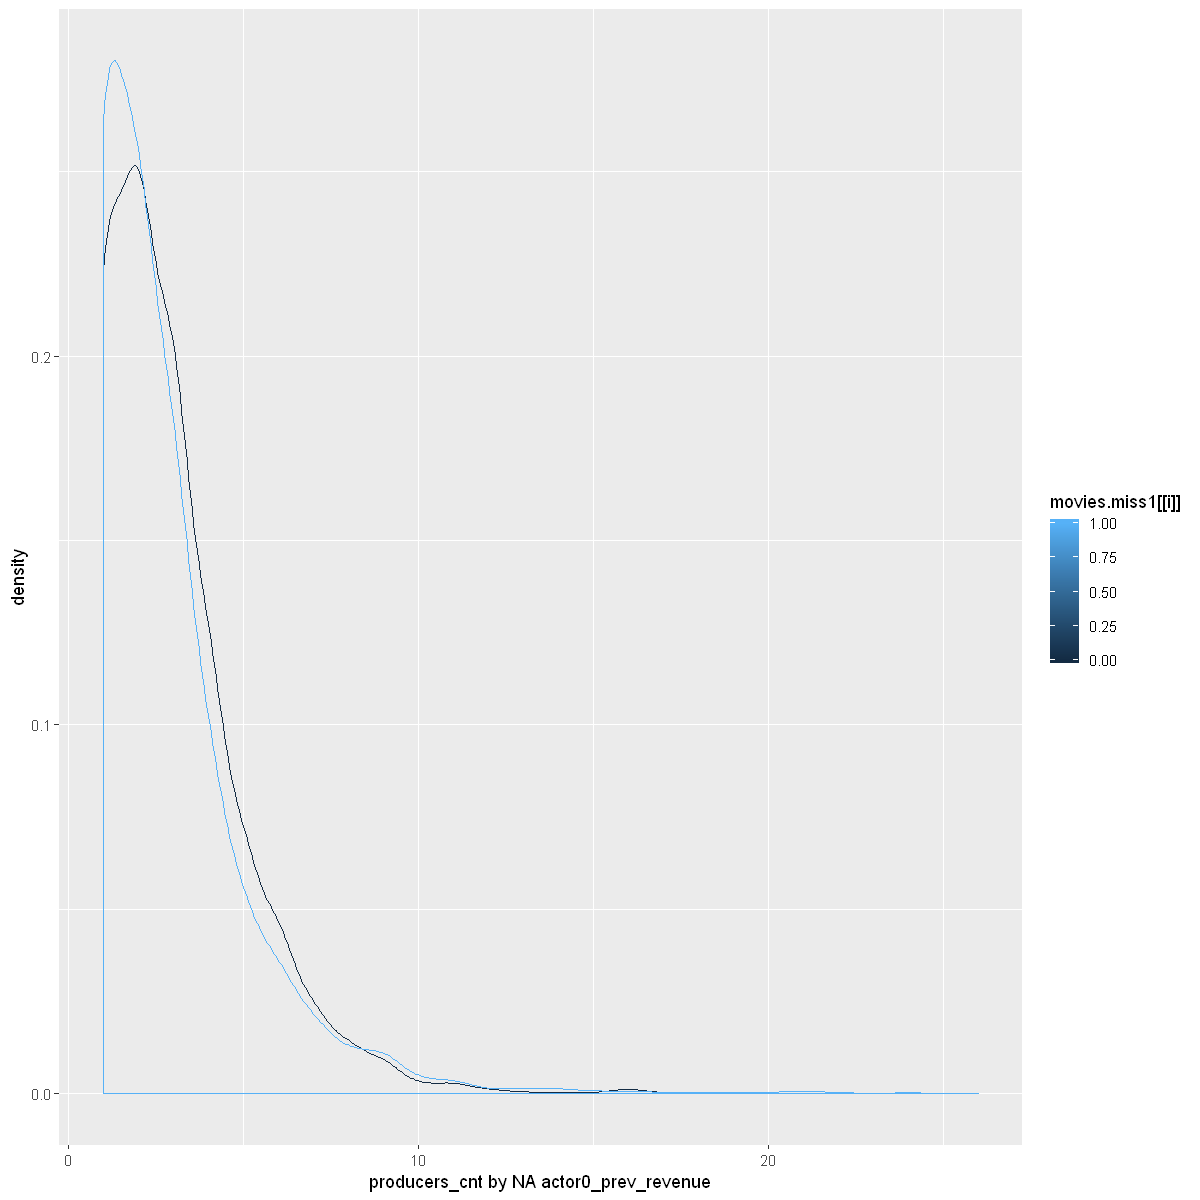


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 34.823, df = 6953.5, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.555419 3.979587
sample estimates:
mean of x mean of y 
 5.655901  1.888397 

[1] "actor1_movies_cnt by NA actor0_prev_revenue"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


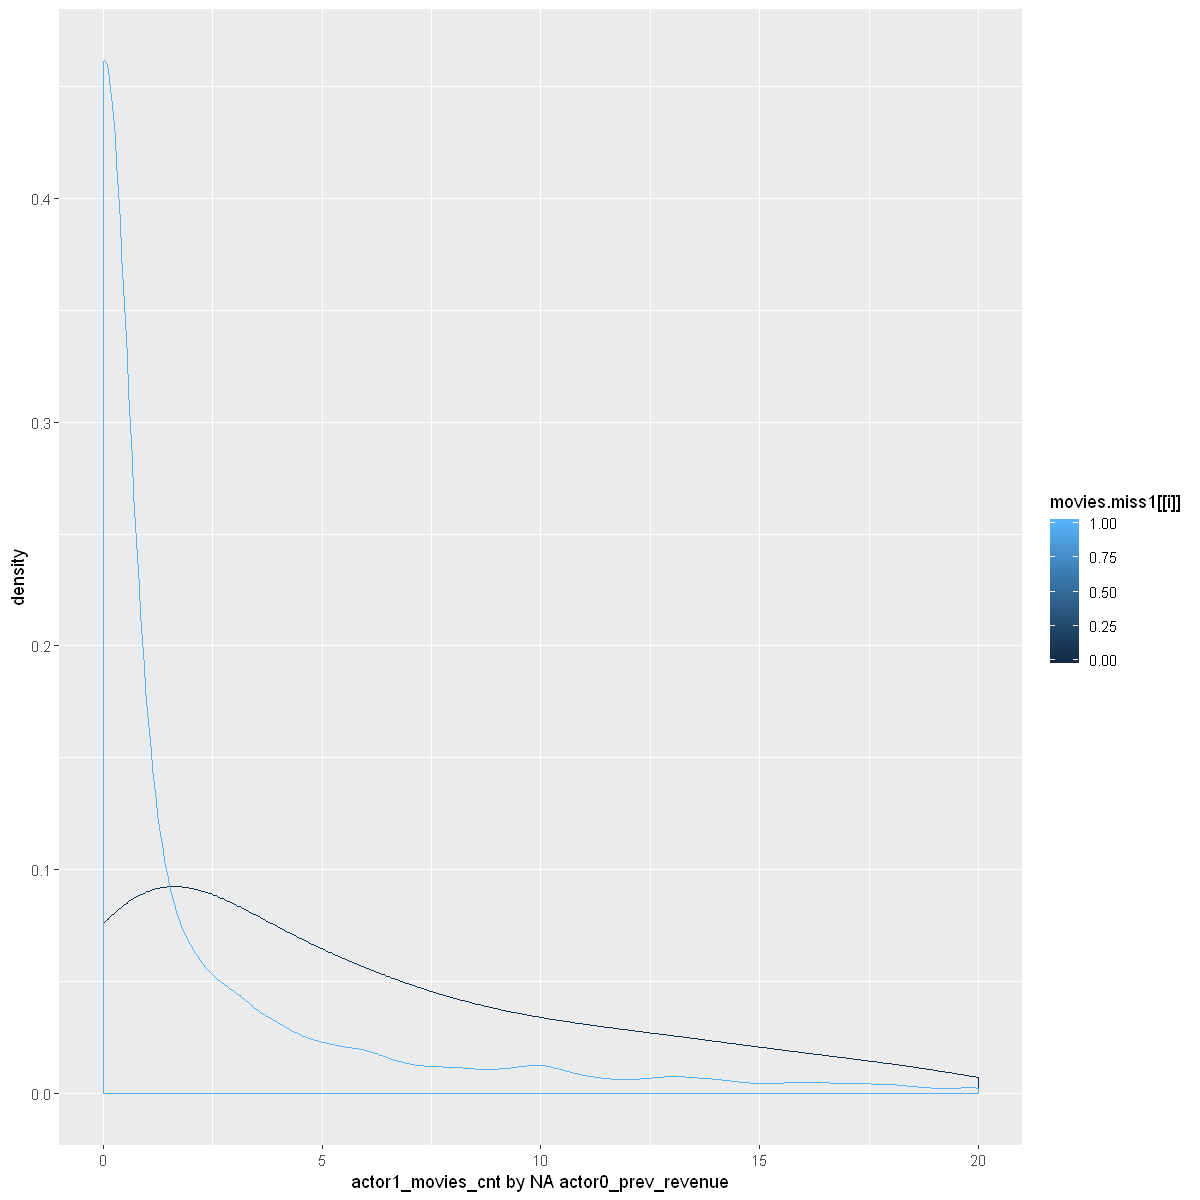


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 30.211, df = 6865.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.655503 3.024035
sample estimates:
mean of x mean of y 
 4.496960  1.657192 

[1] "actor2_movies_cnt by NA actor0_prev_revenue"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


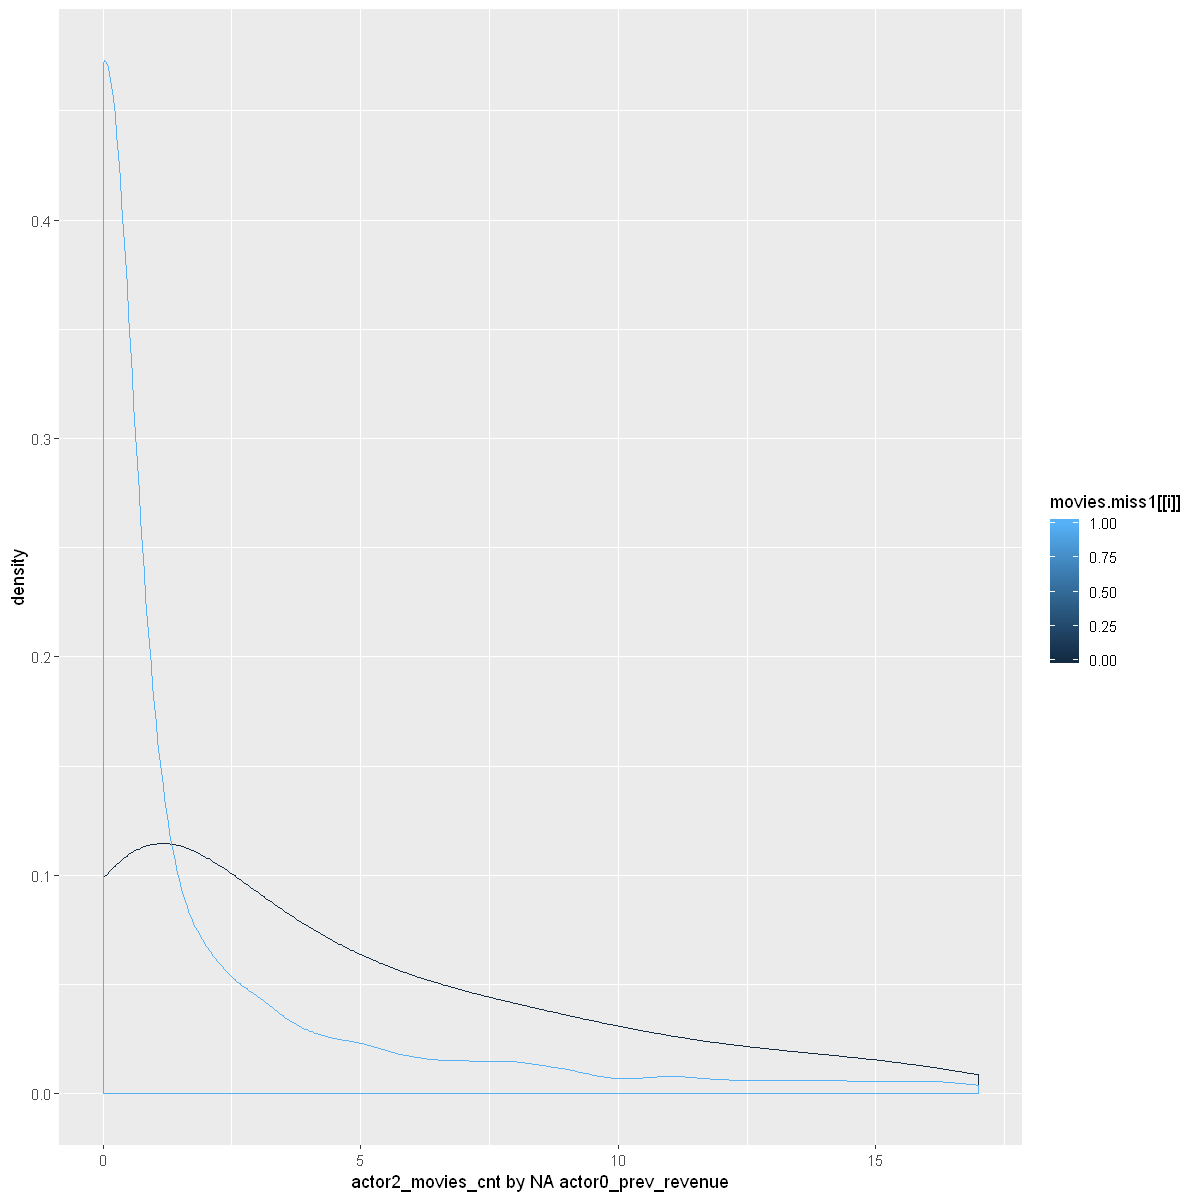


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.526, df = 1319.3, p-value = 3.944e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 18831392 39561350
sample estimates:
mean of x mean of y 
151559748 122363377 

[1] "actor1_prev_revenue by NA actor0_prev_revenue"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


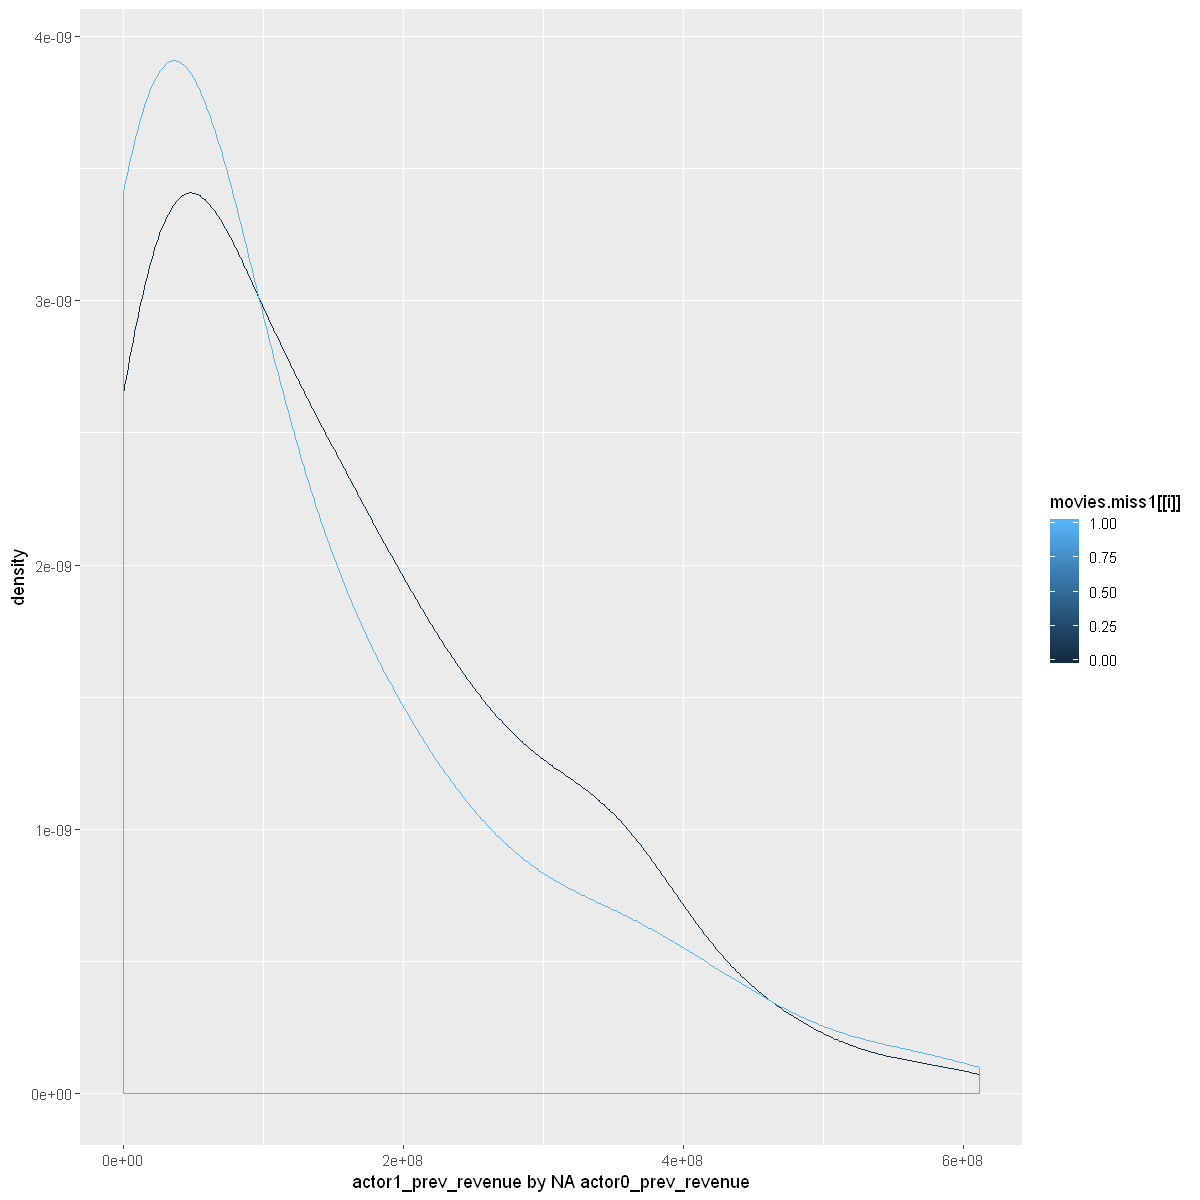


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.587, df = 1394, p-value = 2.775e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 17747571 36954144
sample estimates:
mean of x mean of y 
140003867 112653010 

[1] "actor2_prev_revenue by NA actor0_prev_revenue"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


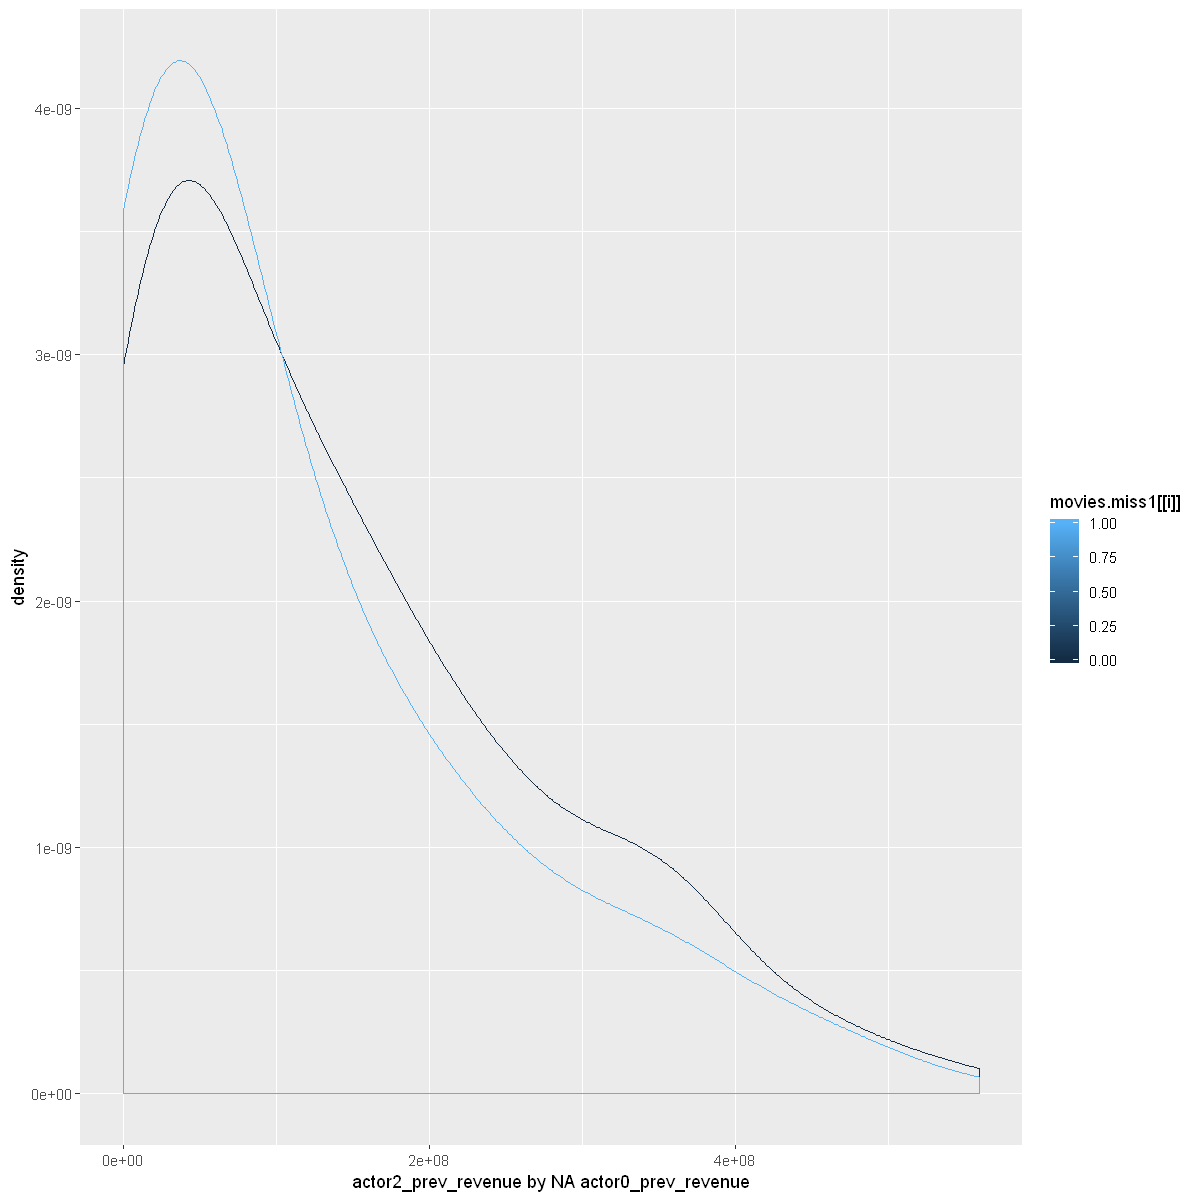


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 17.016, df = 6875.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.6242649 0.7868298
sample estimates:
mean of x mean of y 
1.6491706 0.9436232 

[1] "director_movies_cnt by NA actor0_prev_revenue"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


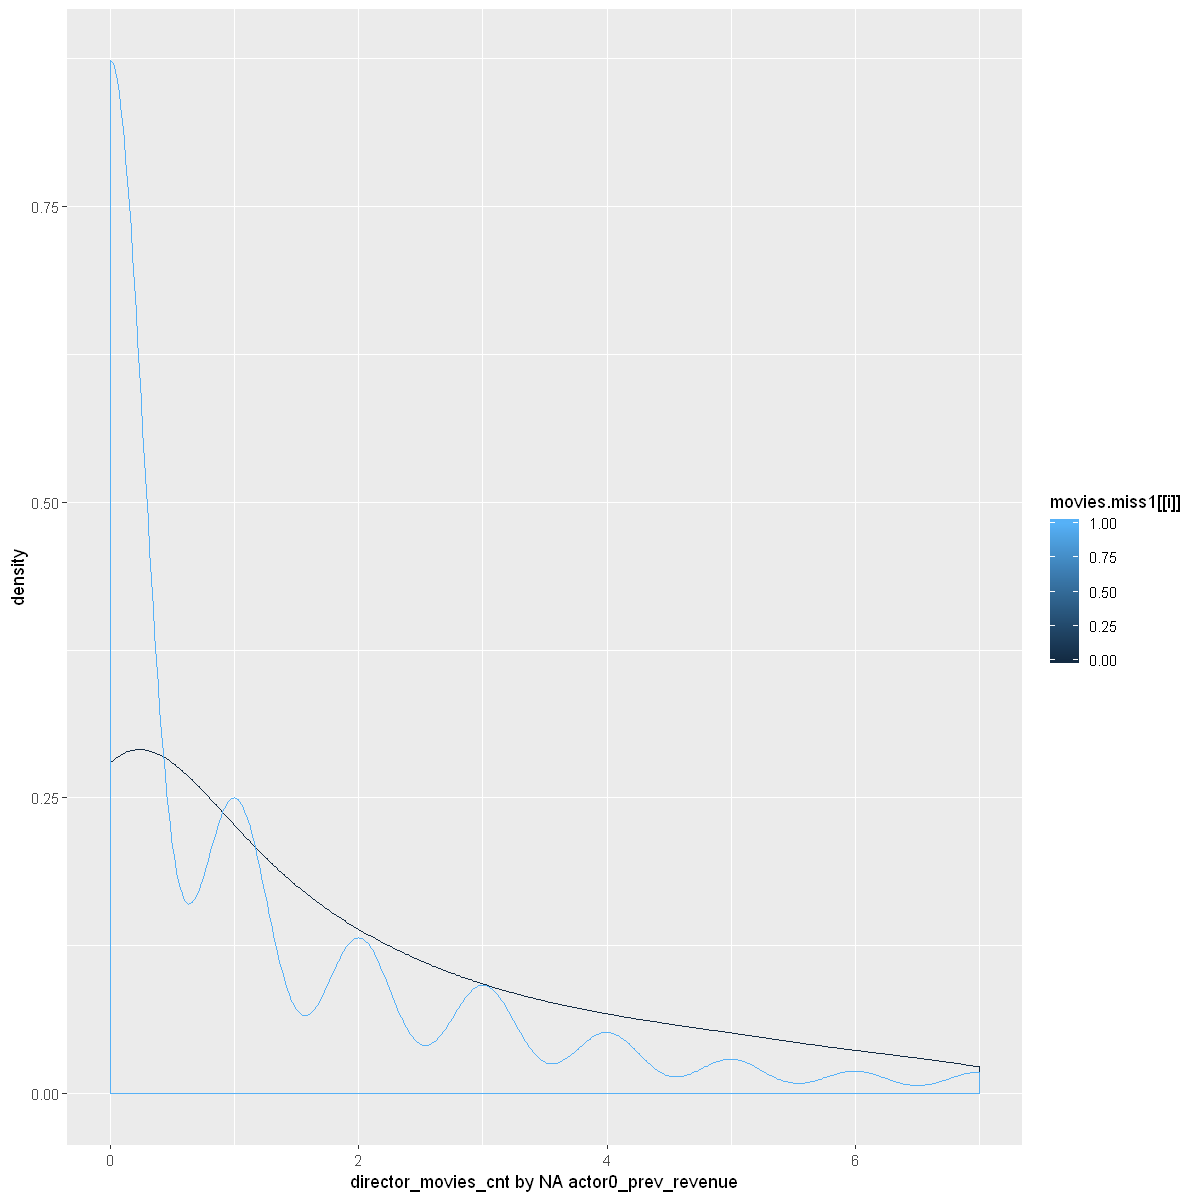


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 11.806, df = 6424.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4408717 0.6164325
sample estimates:
mean of x mean of y 
 1.830262  1.301610 

[1] "depart_Art by NA actor0_prev_revenue"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


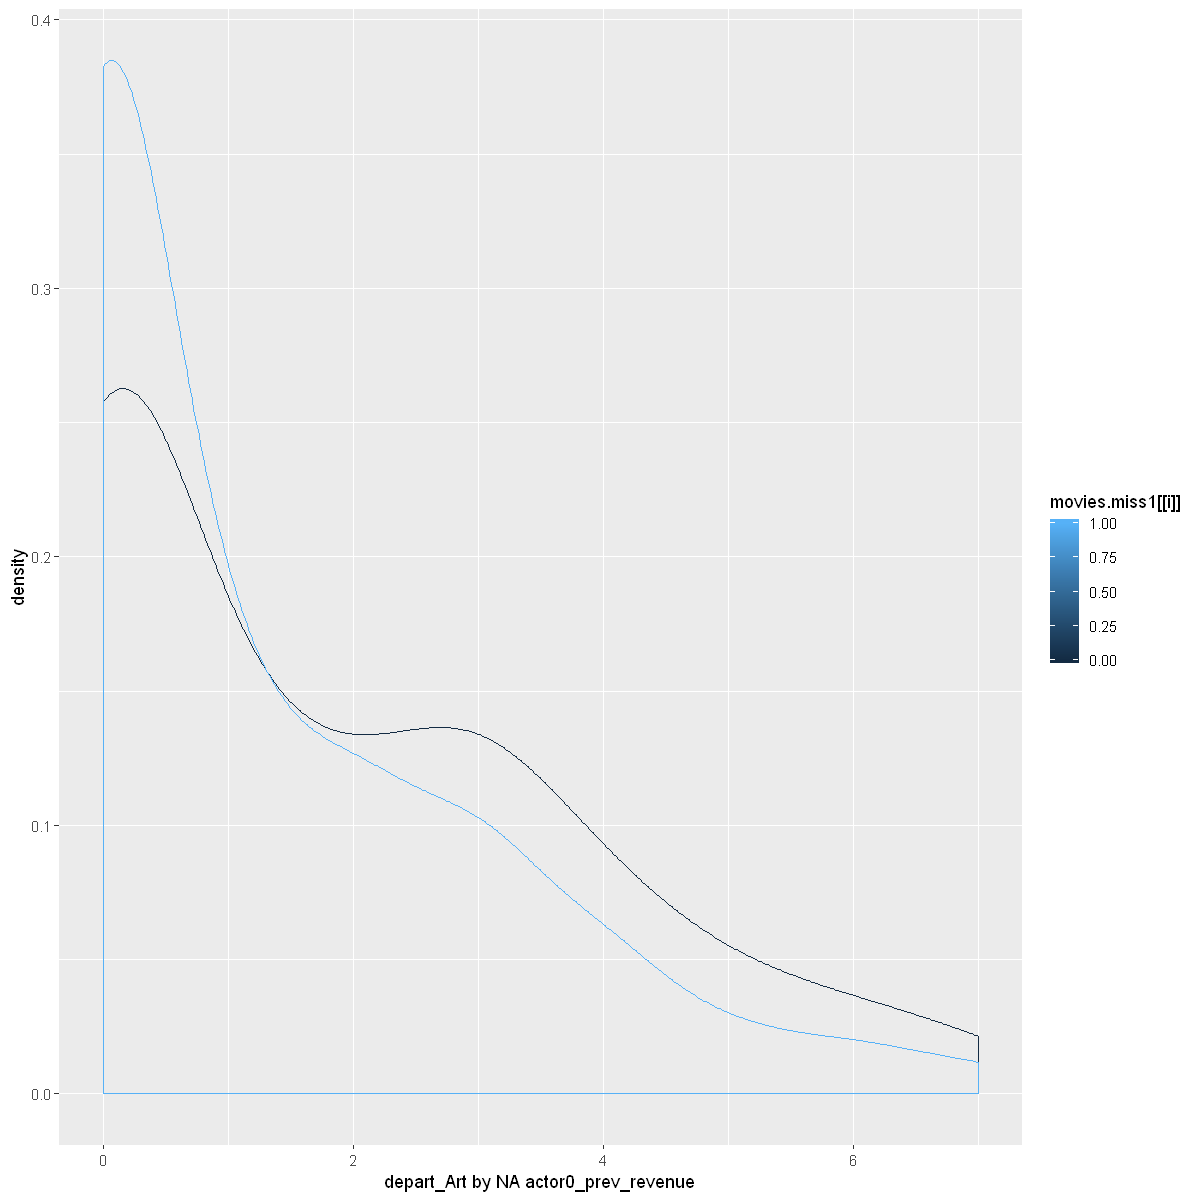


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 7.2125, df = 6160, p-value = 6.153e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1502191 0.2623568
sample estimates:
mean of x mean of y 
1.1984476 0.9921597 

[1] "depart_Camera by NA actor0_prev_revenue"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


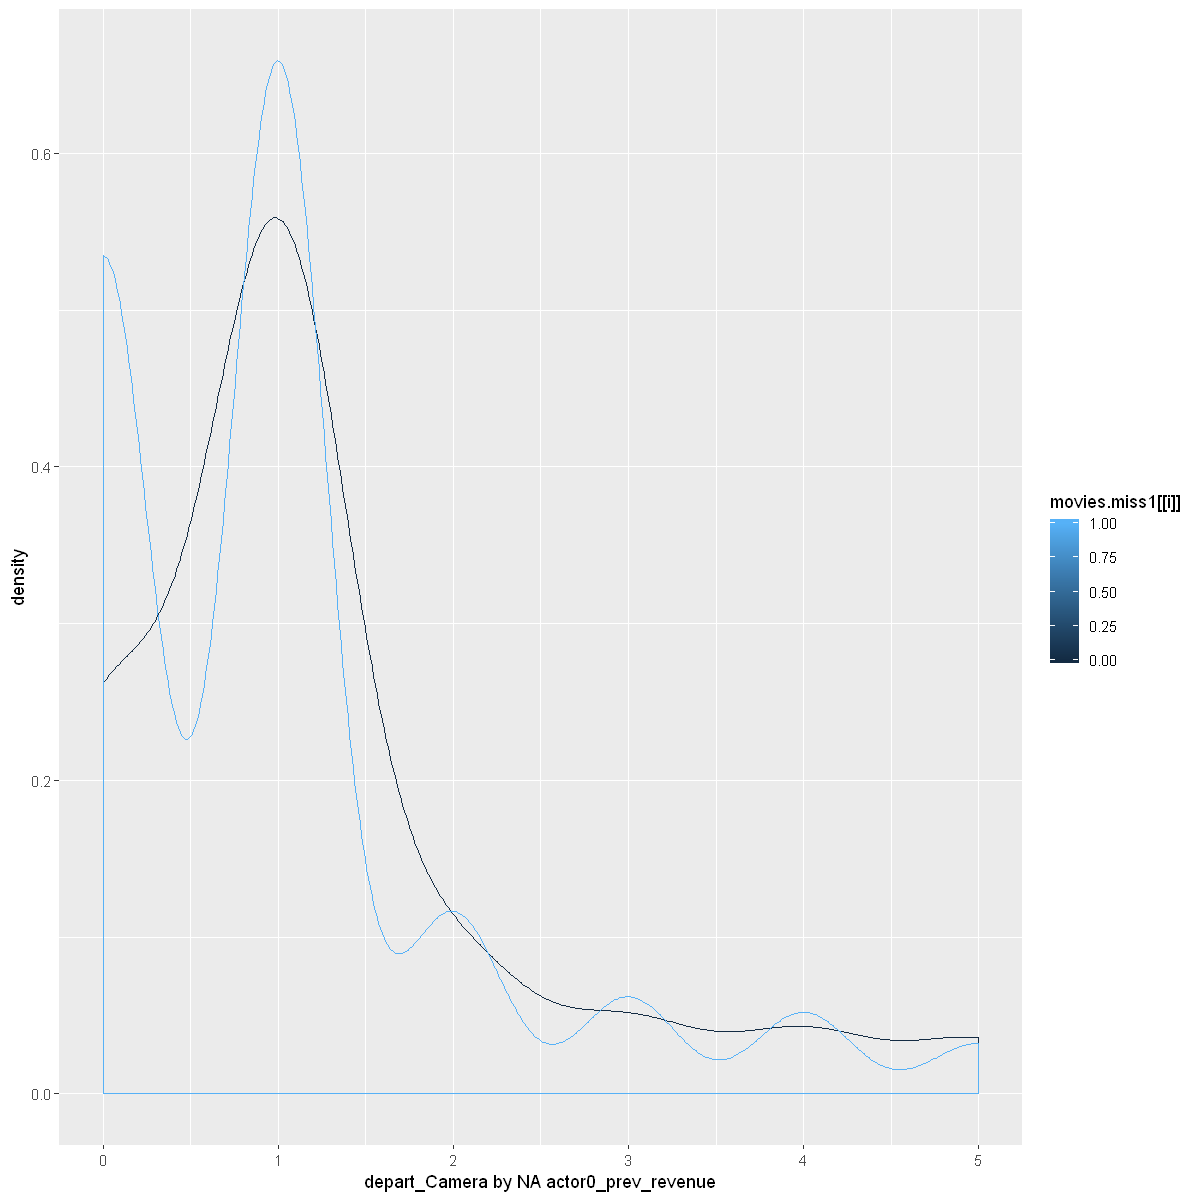


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 7.3022, df = 6145.3, p-value = 3.19e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1728039 0.2996351
sample estimates:
mean of x mean of y 
0.9787937 0.7425743 

[1] "depart_Custom_Mkup by NA actor0_prev_revenue"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


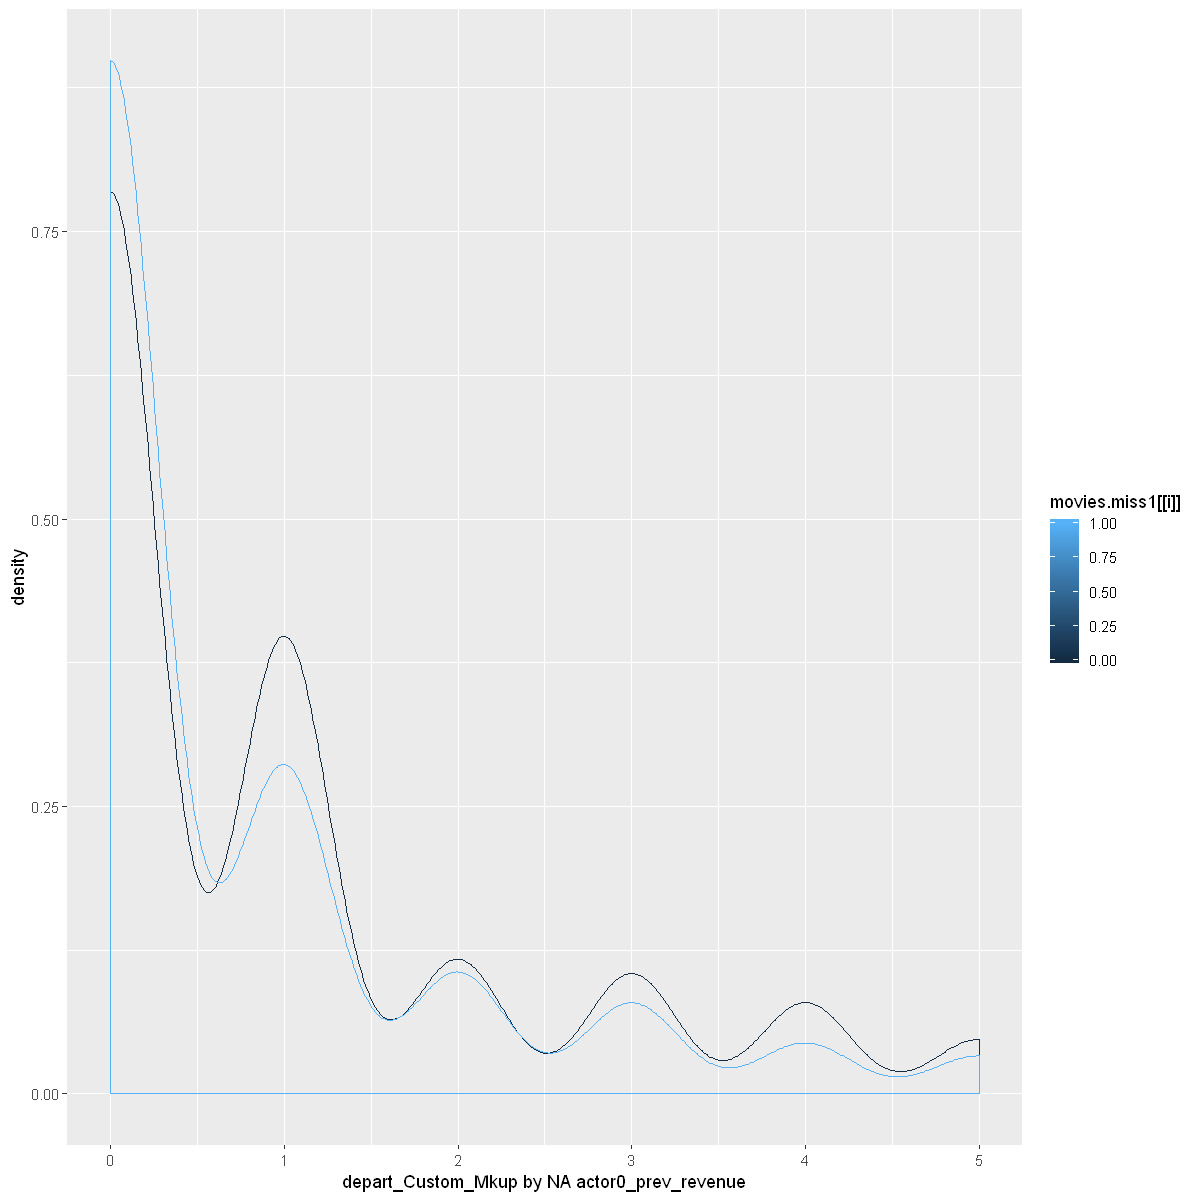


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 6.2385, df = 6481.8, p-value = 4.697e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.06651255 0.12746721
sample estimates:
mean of x mean of y 
  1.45260   1.35561 

[1] "depart_Directing by NA actor0_prev_revenue"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


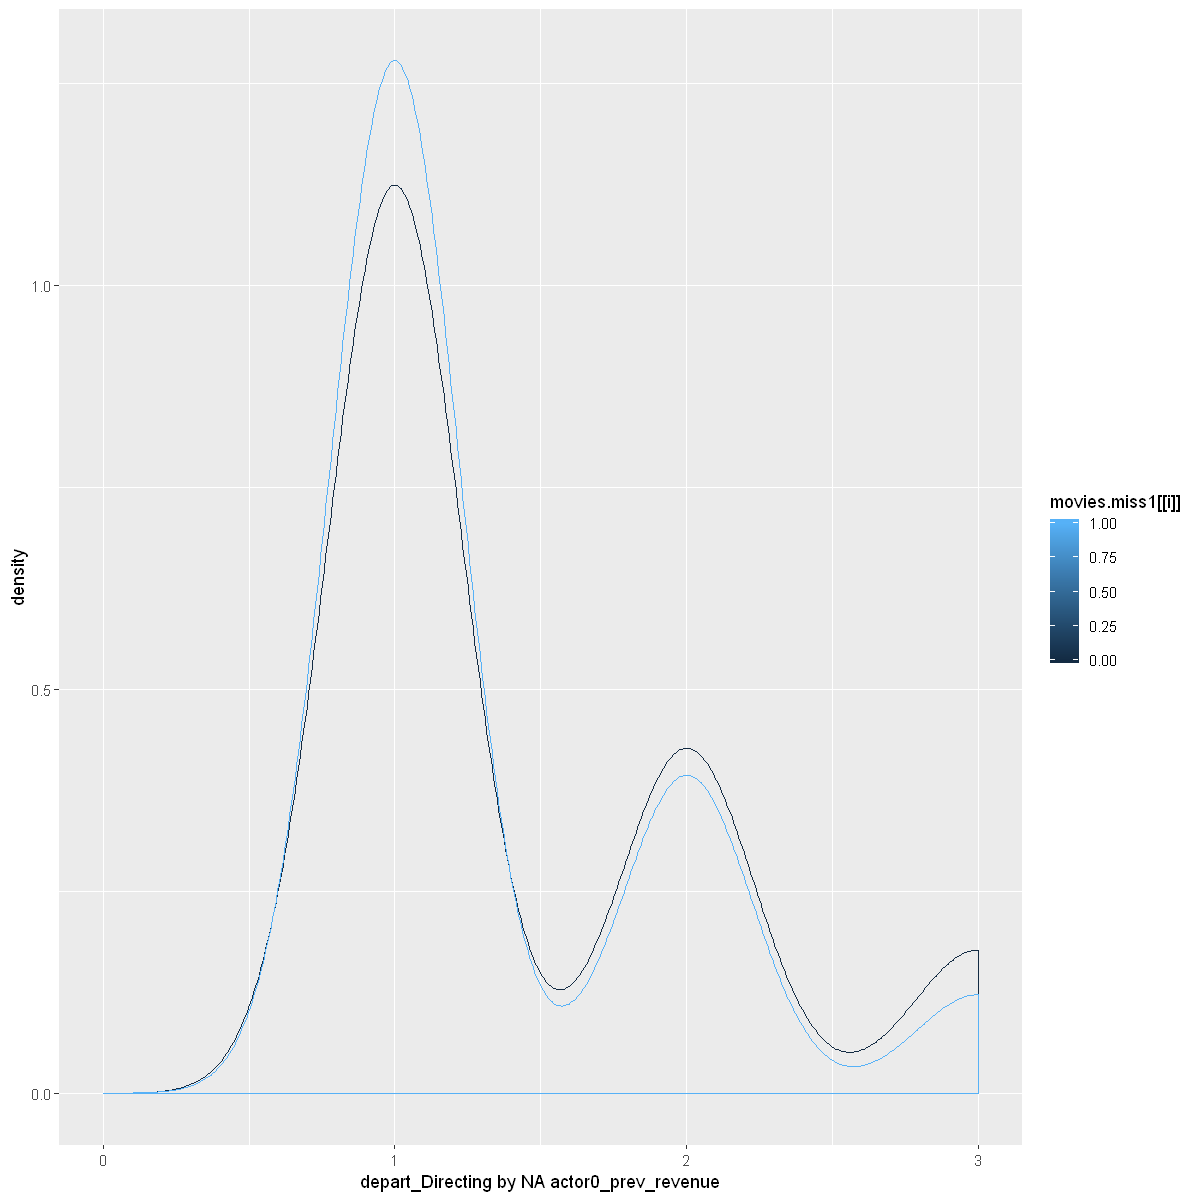


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 4.2071, df = 5573.7, p-value = 2.627e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.07957772 0.21844929
sample estimates:
mean of x mean of y 
 1.327571  1.178558 

[1] "depart_Sound by NA actor0_prev_revenue"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


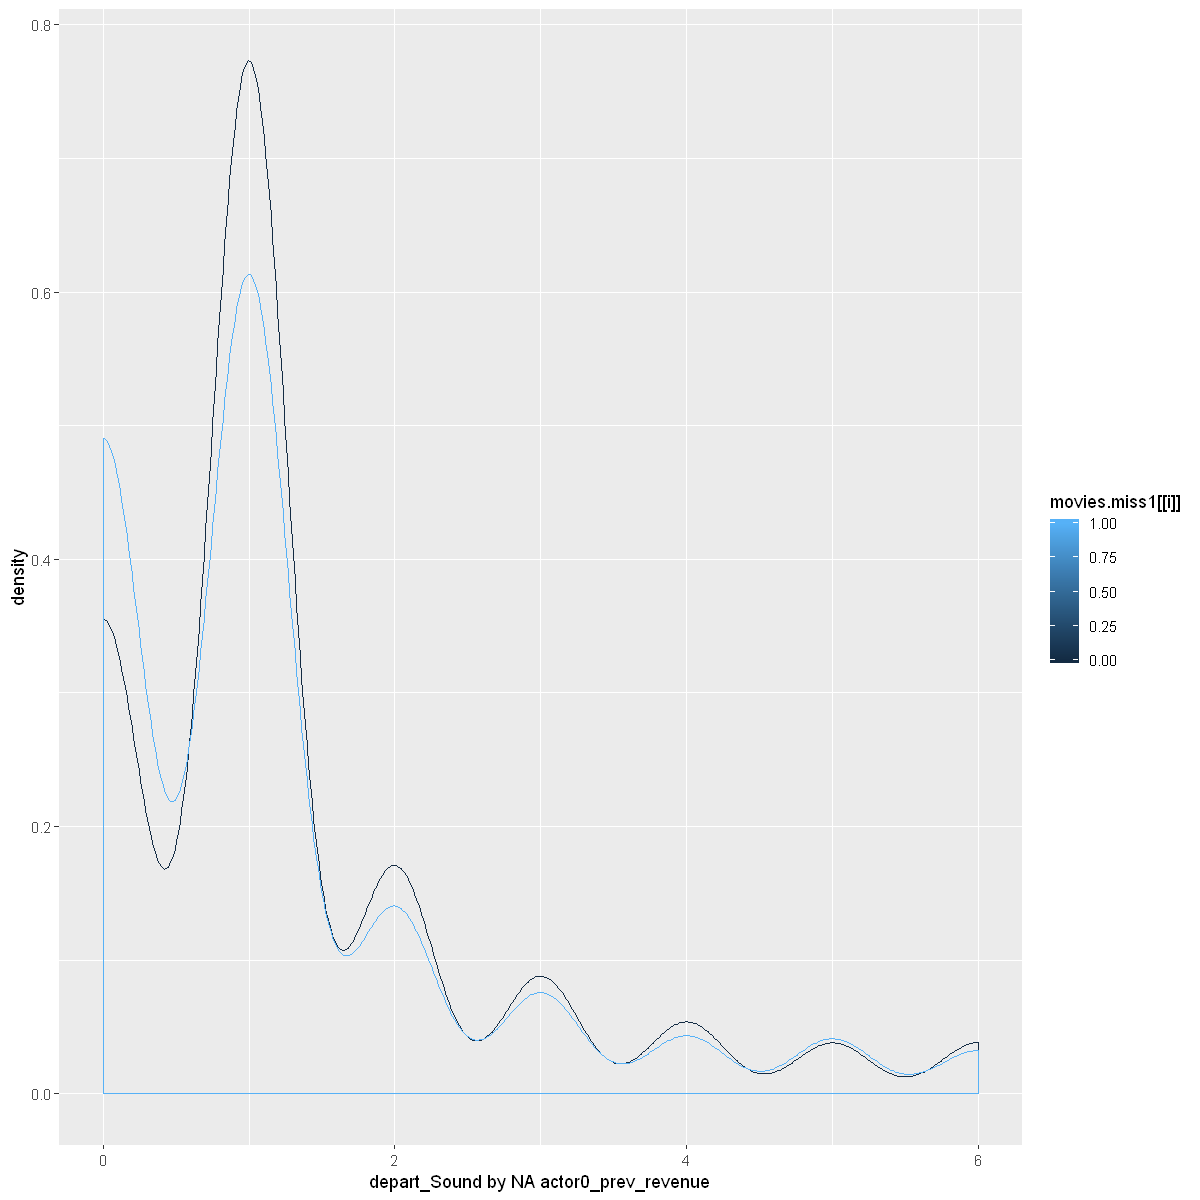


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 18.142, df = 4931.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  9703317 12054499
sample estimates:
mean of x mean of y 
 26974494  16095586 

[1] "budget by NA actor1_prev_revenue"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


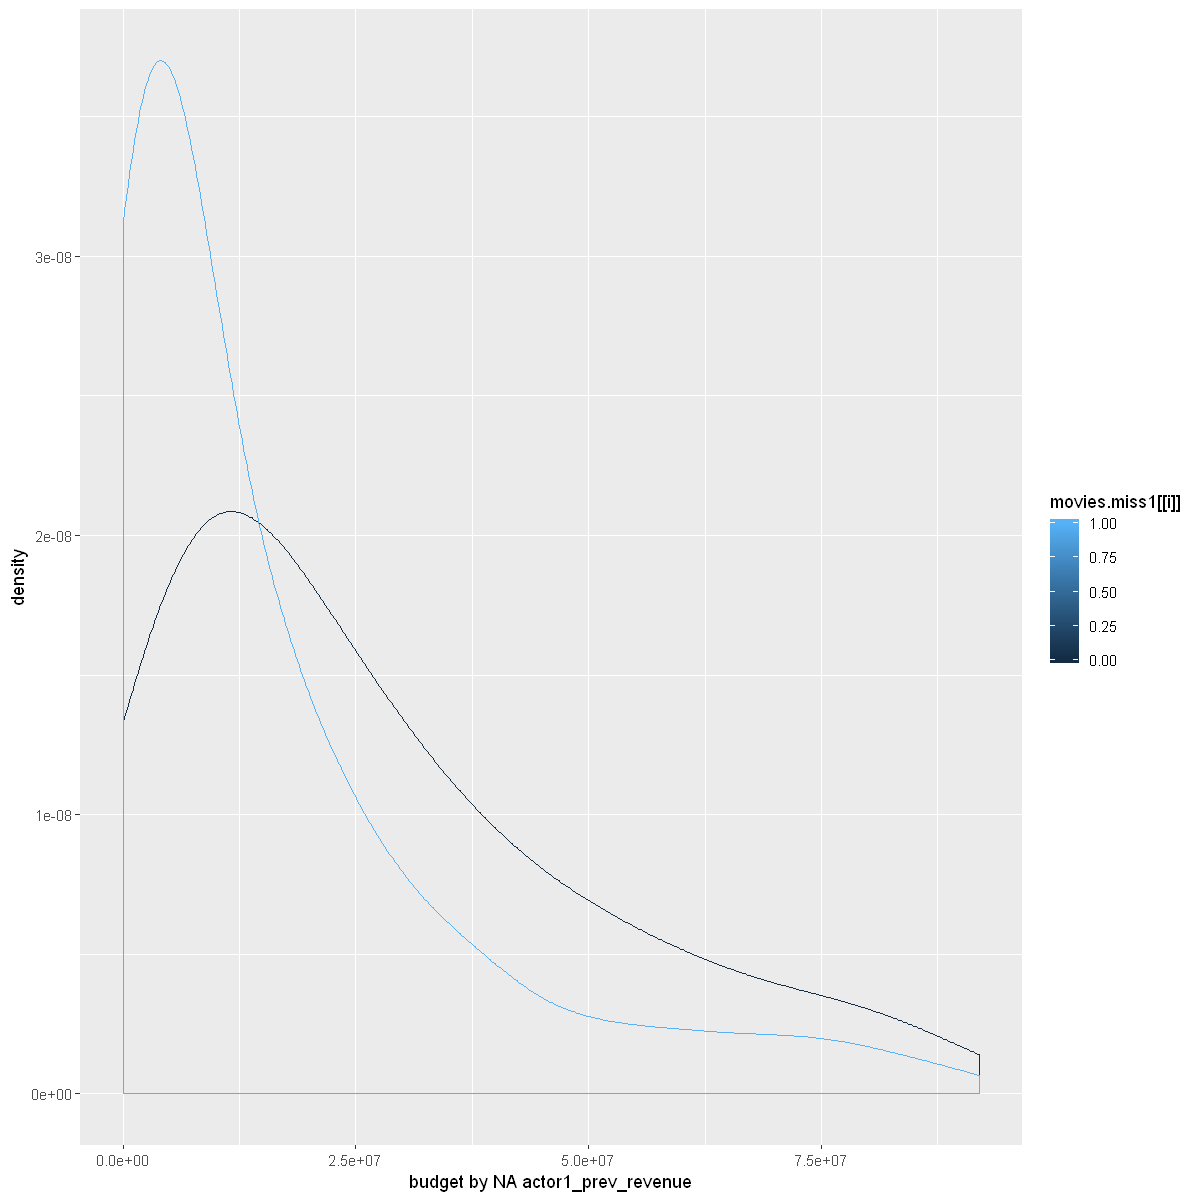


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.03, df = 6854, p-value = 5.03e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1575925 0.3588722
sample estimates:
mean of x mean of y 
 3.028195  2.769963 

[1] "producers_cnt by NA actor1_prev_revenue"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


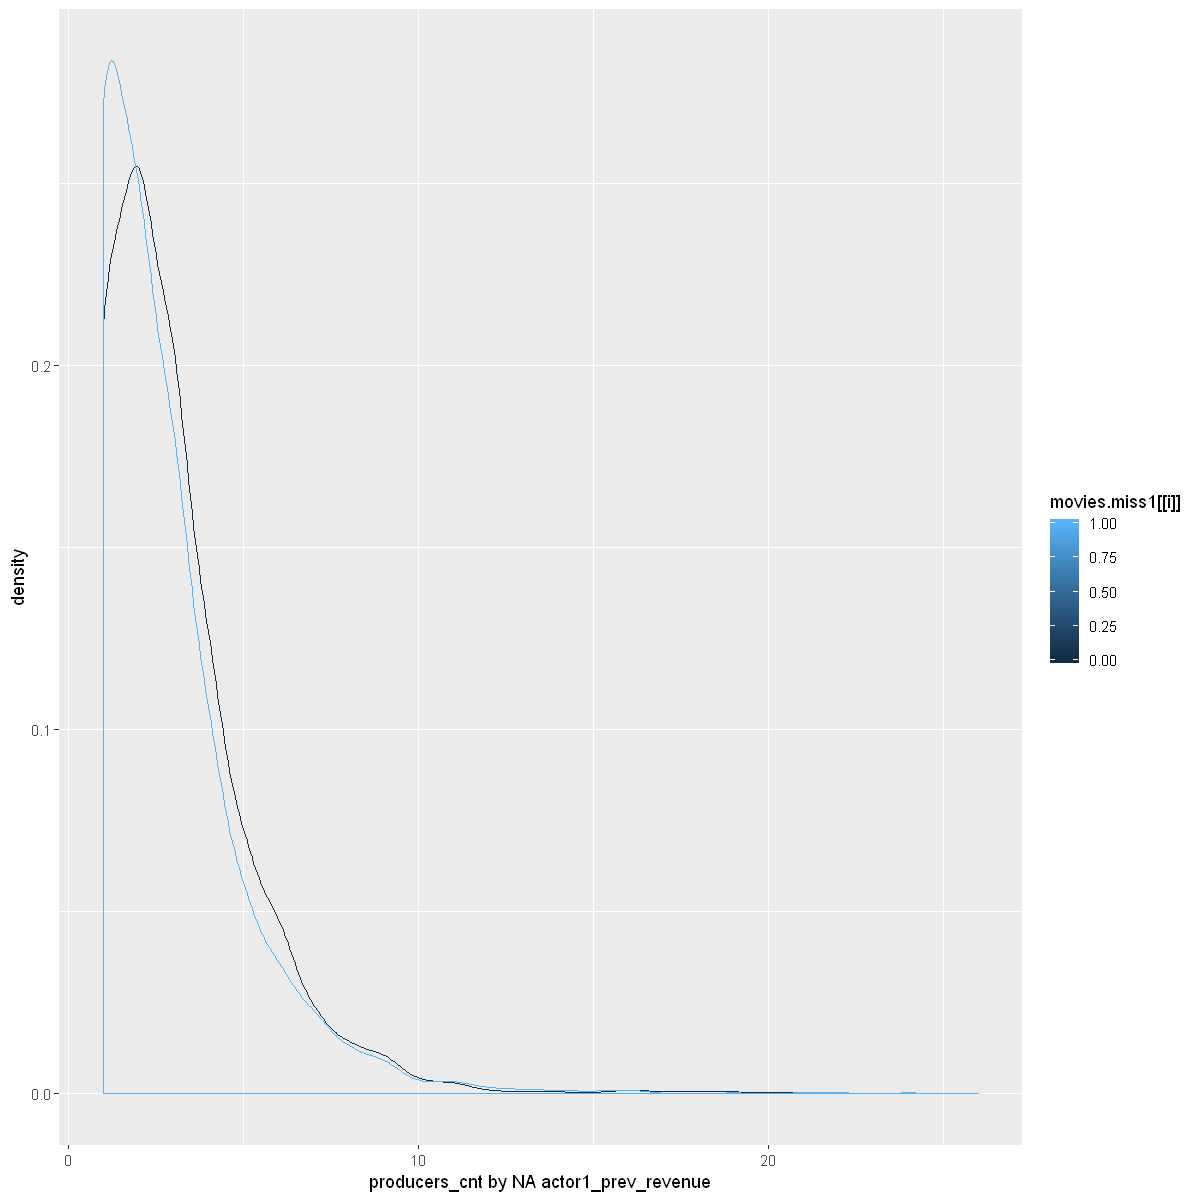


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 57.832, df = 6026.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 5.538771 5.927445
sample estimates:
mean of x mean of y 
 6.888009  1.154901 

[1] "actor1_movies_cnt by NA actor1_prev_revenue"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


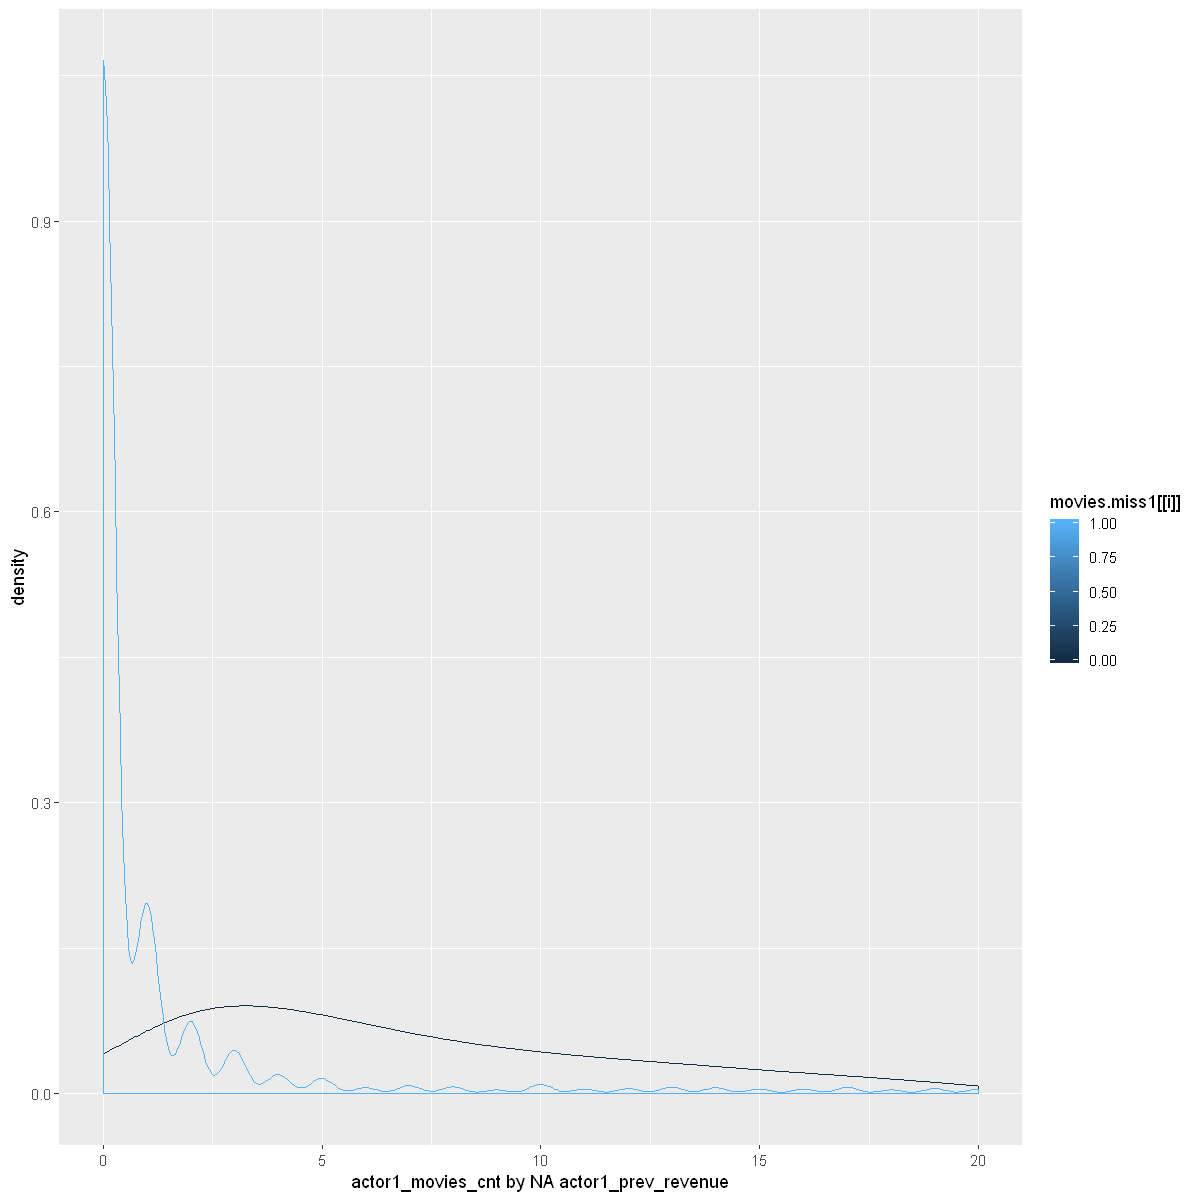


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 32.101, df = 6330.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.880585 3.255290
sample estimates:
mean of x mean of y 
 4.800344  1.732407 

[1] "actor2_movies_cnt by NA actor1_prev_revenue"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


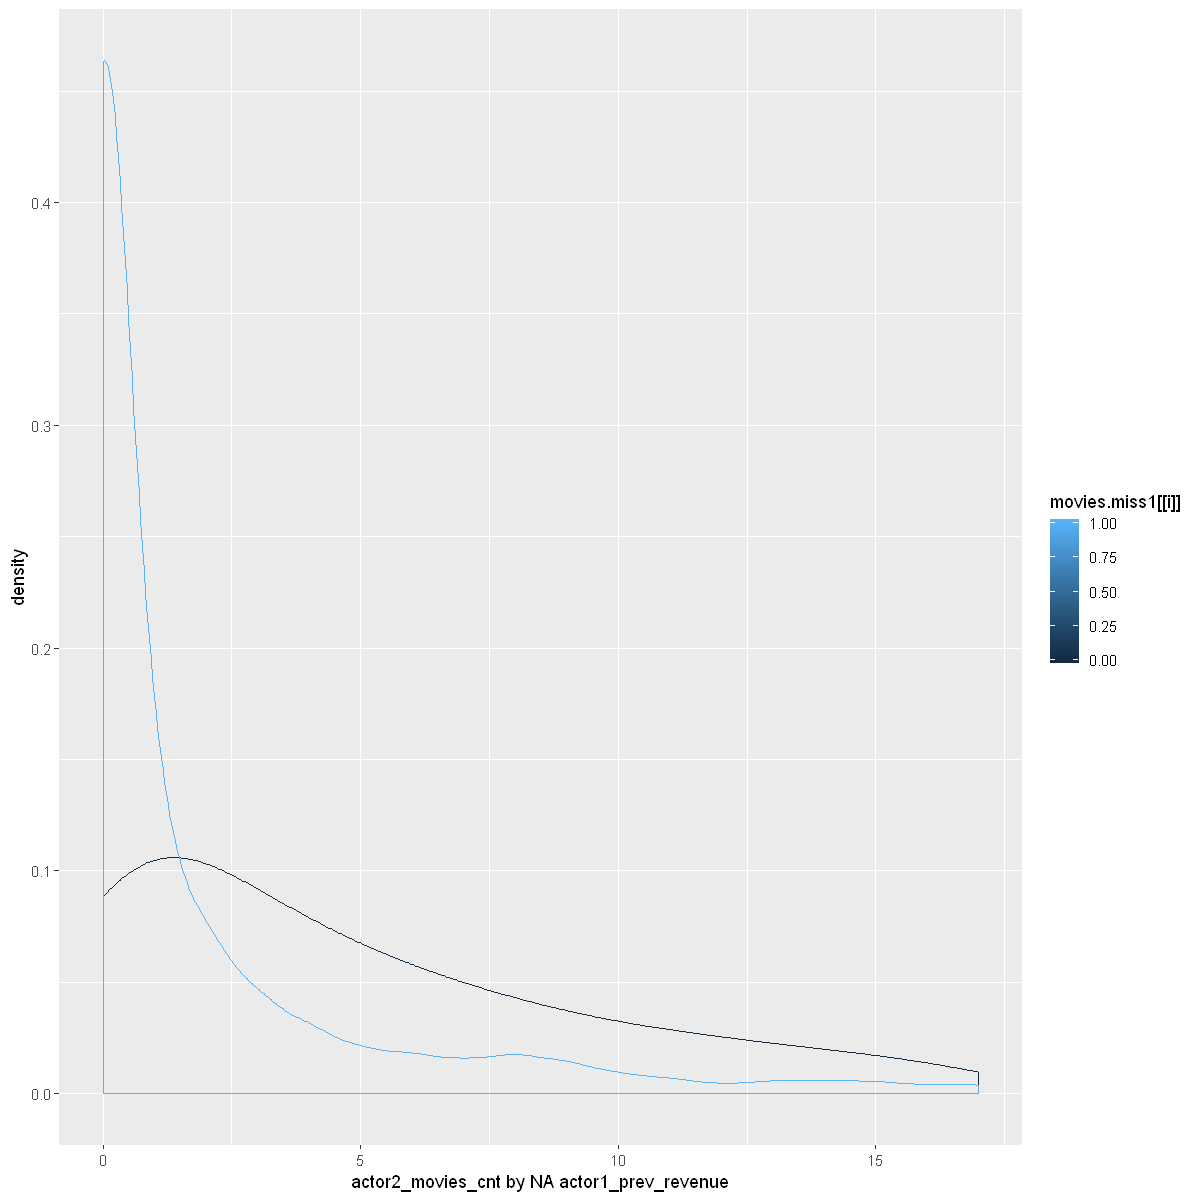


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 6.5482, df = 2428.8, p-value = 7.08e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 24264643 45009521
sample estimates:
mean of x mean of y 
185581207 150944126 

[1] "actor0_prev_revenue by NA actor1_prev_revenue"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


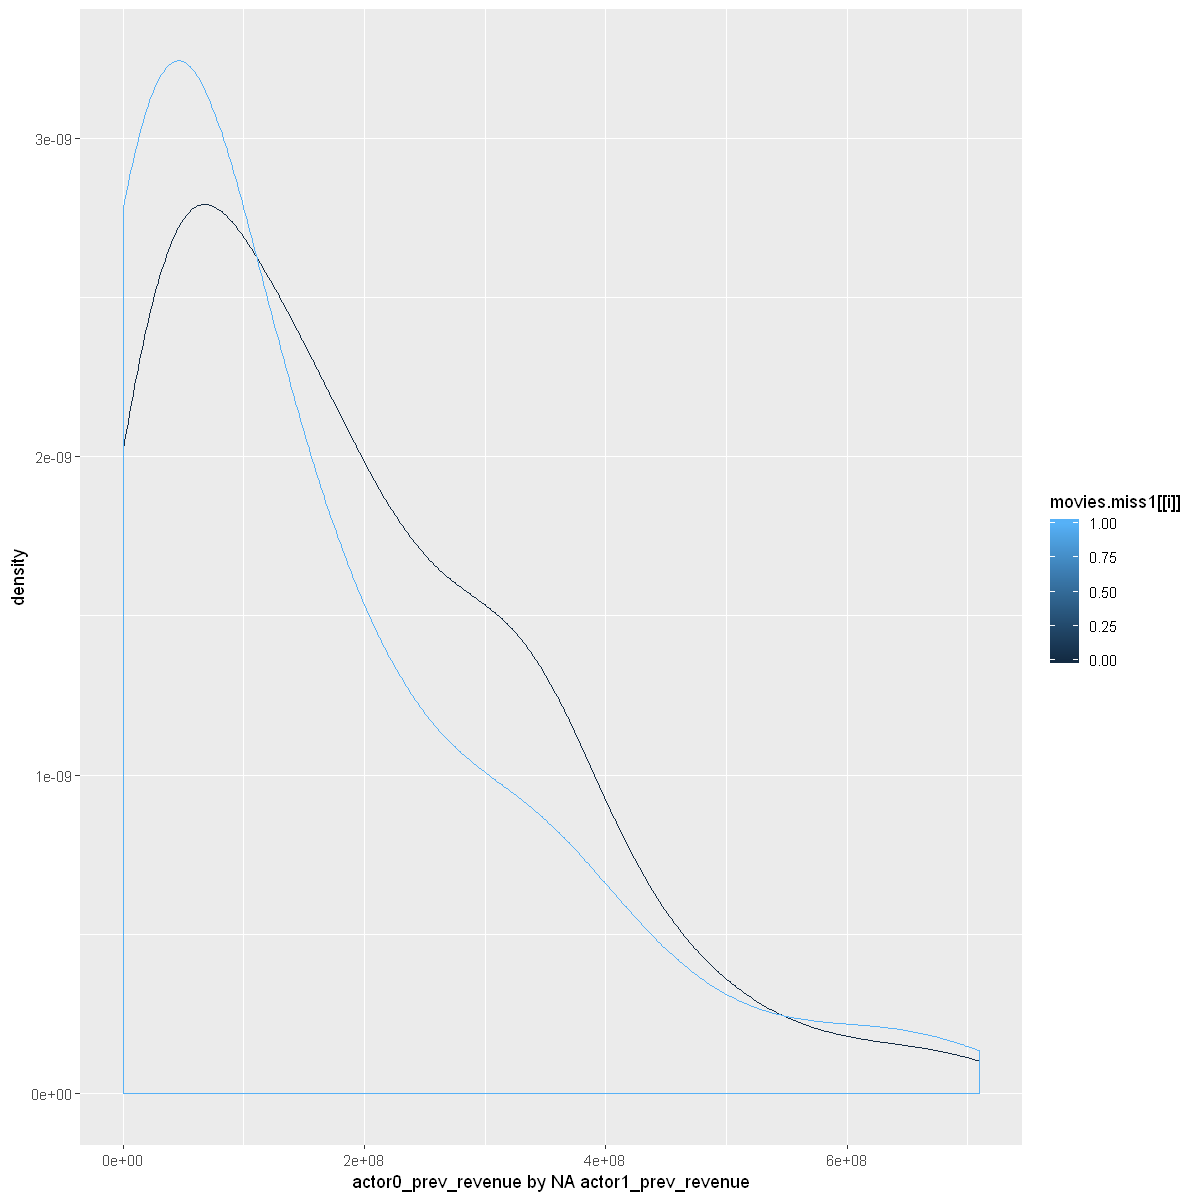


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.2551, df = 1963.8, p-value = 1.64e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 15247577 33404346
sample estimates:
mean of x mean of y 
140864004 116538043 

[1] "actor2_prev_revenue by NA actor1_prev_revenue"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


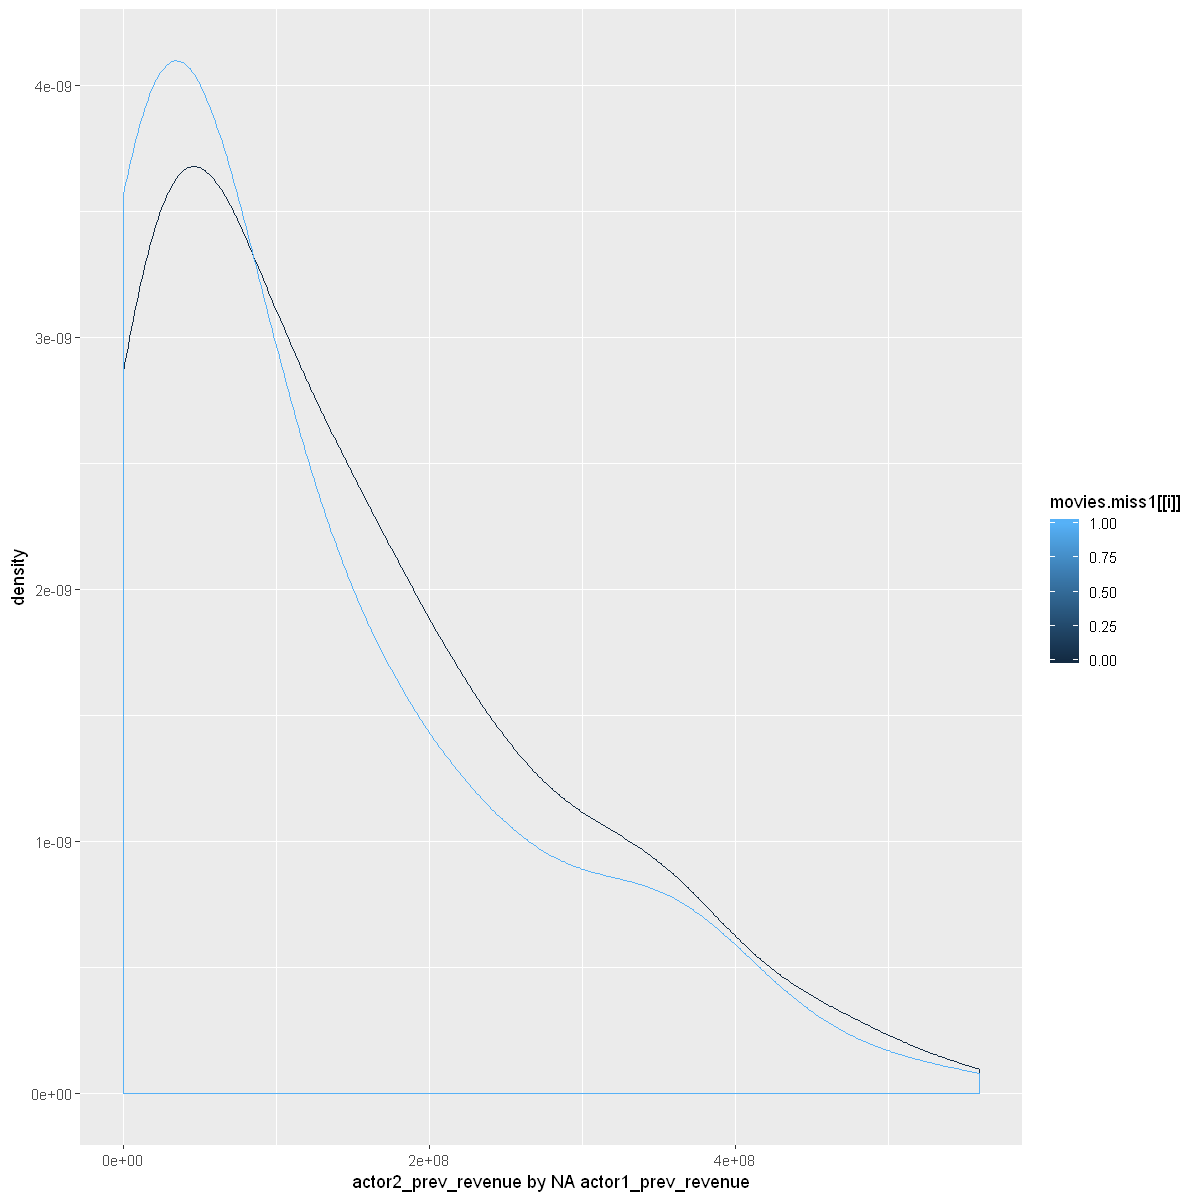


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 14.851, df = 6857.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.546632 0.712890
sample estimates:
mean of x mean of y 
 1.660494  1.030733 

[1] "director_movies_cnt by NA actor1_prev_revenue"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


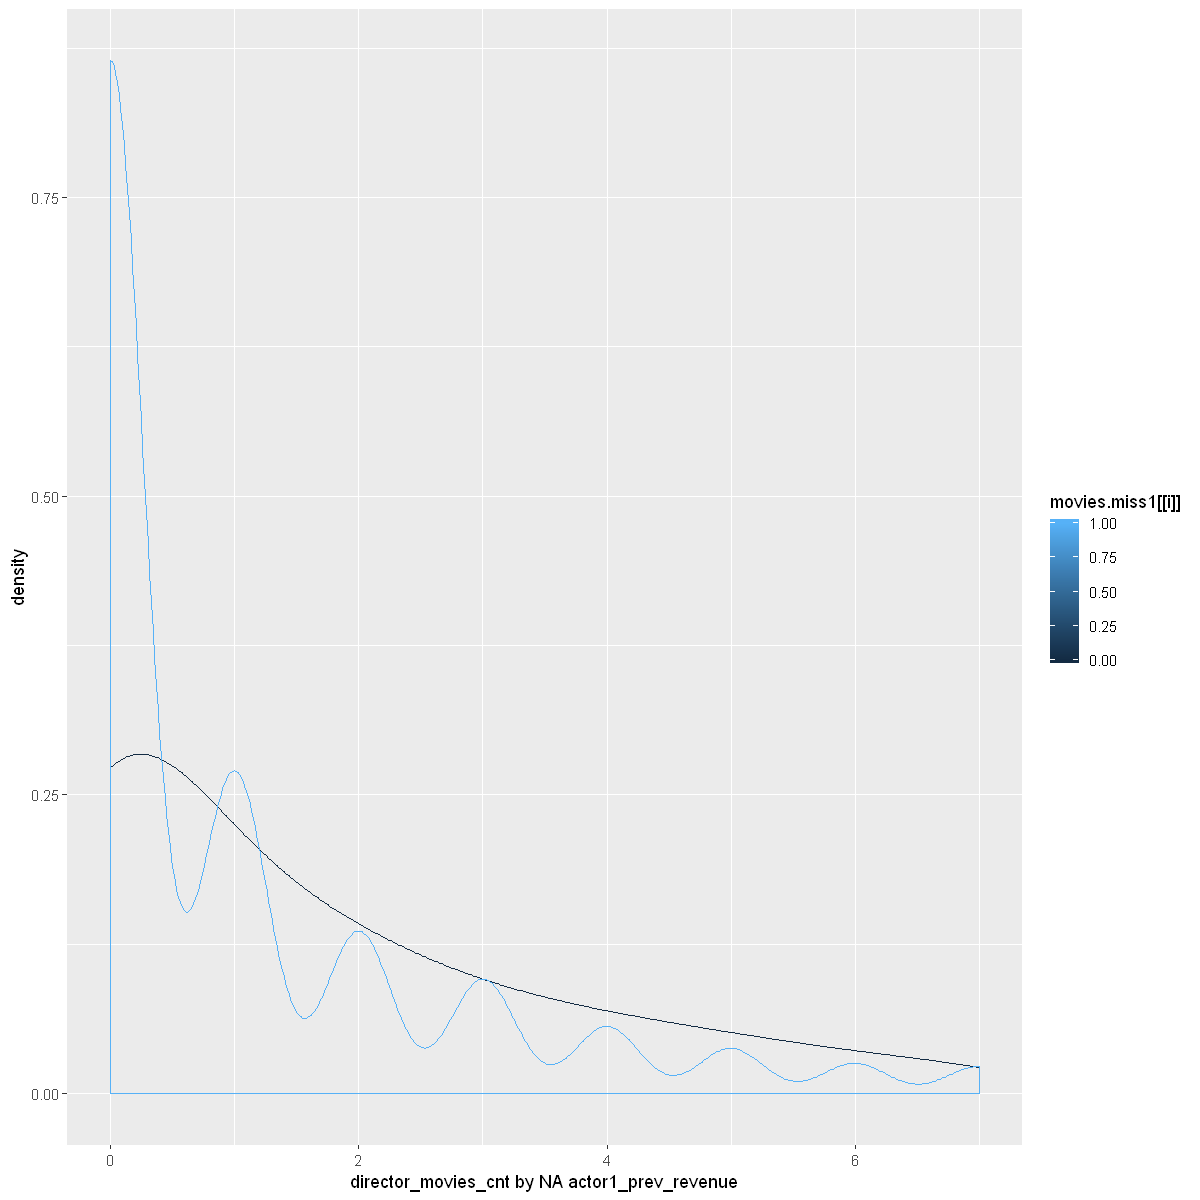


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 10.259, df = 6635.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3751430 0.5523836
sample estimates:
mean of x mean of y 
 1.835350  1.371586 

[1] "depart_Art by NA actor1_prev_revenue"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


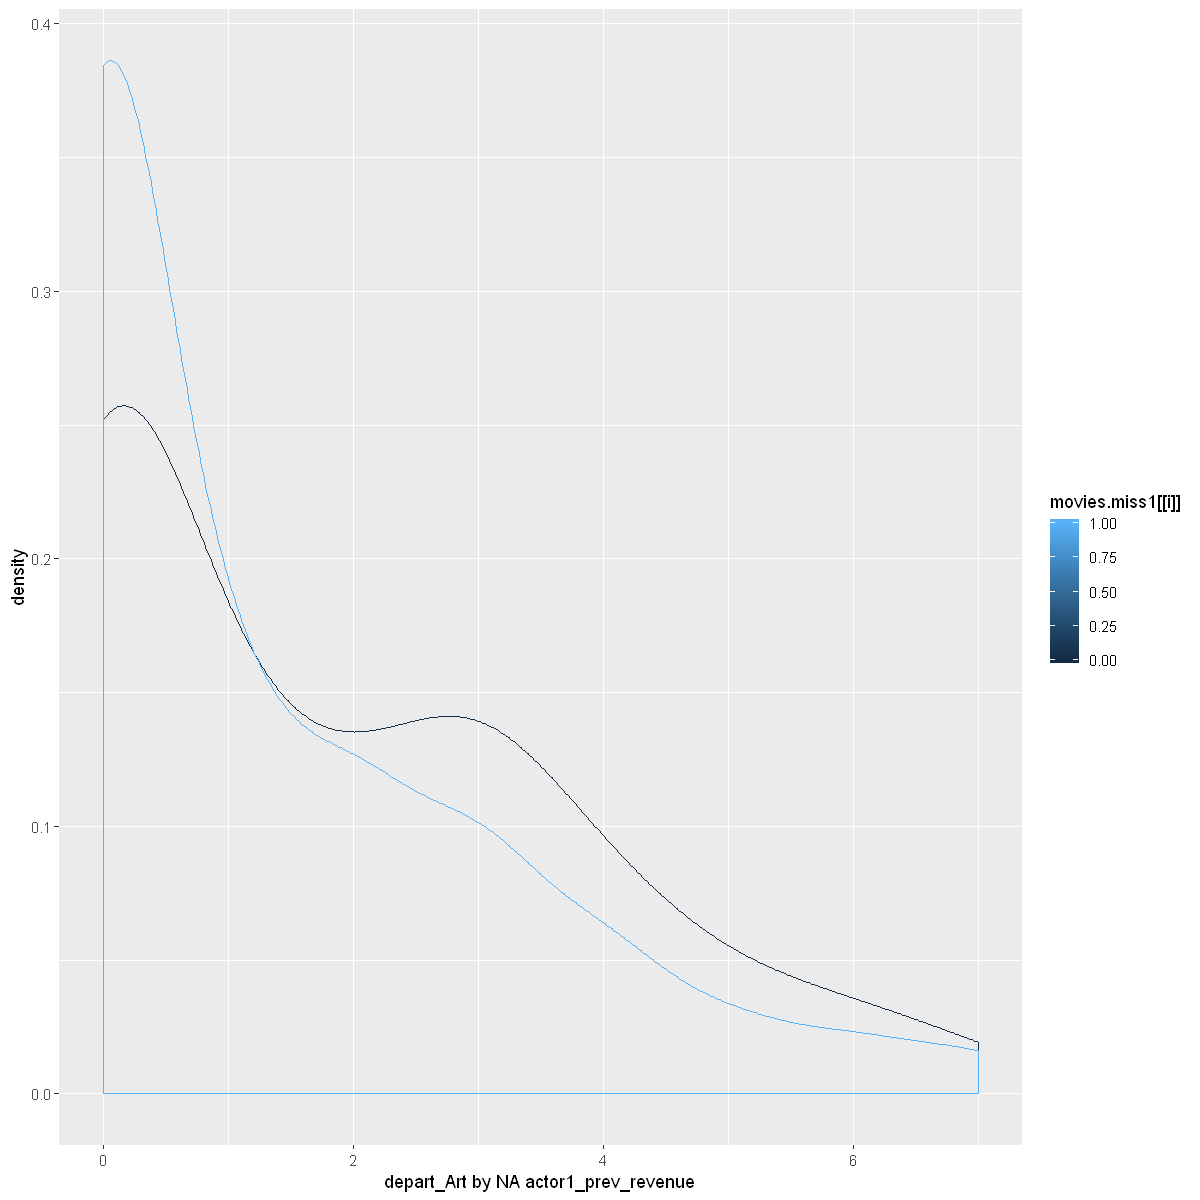


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 6.9287, df = 6668.3, p-value = 4.646e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1409165 0.2521171
sample estimates:
mean of x mean of y 
 1.207299  1.010783 

[1] "depart_Camera by NA actor1_prev_revenue"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


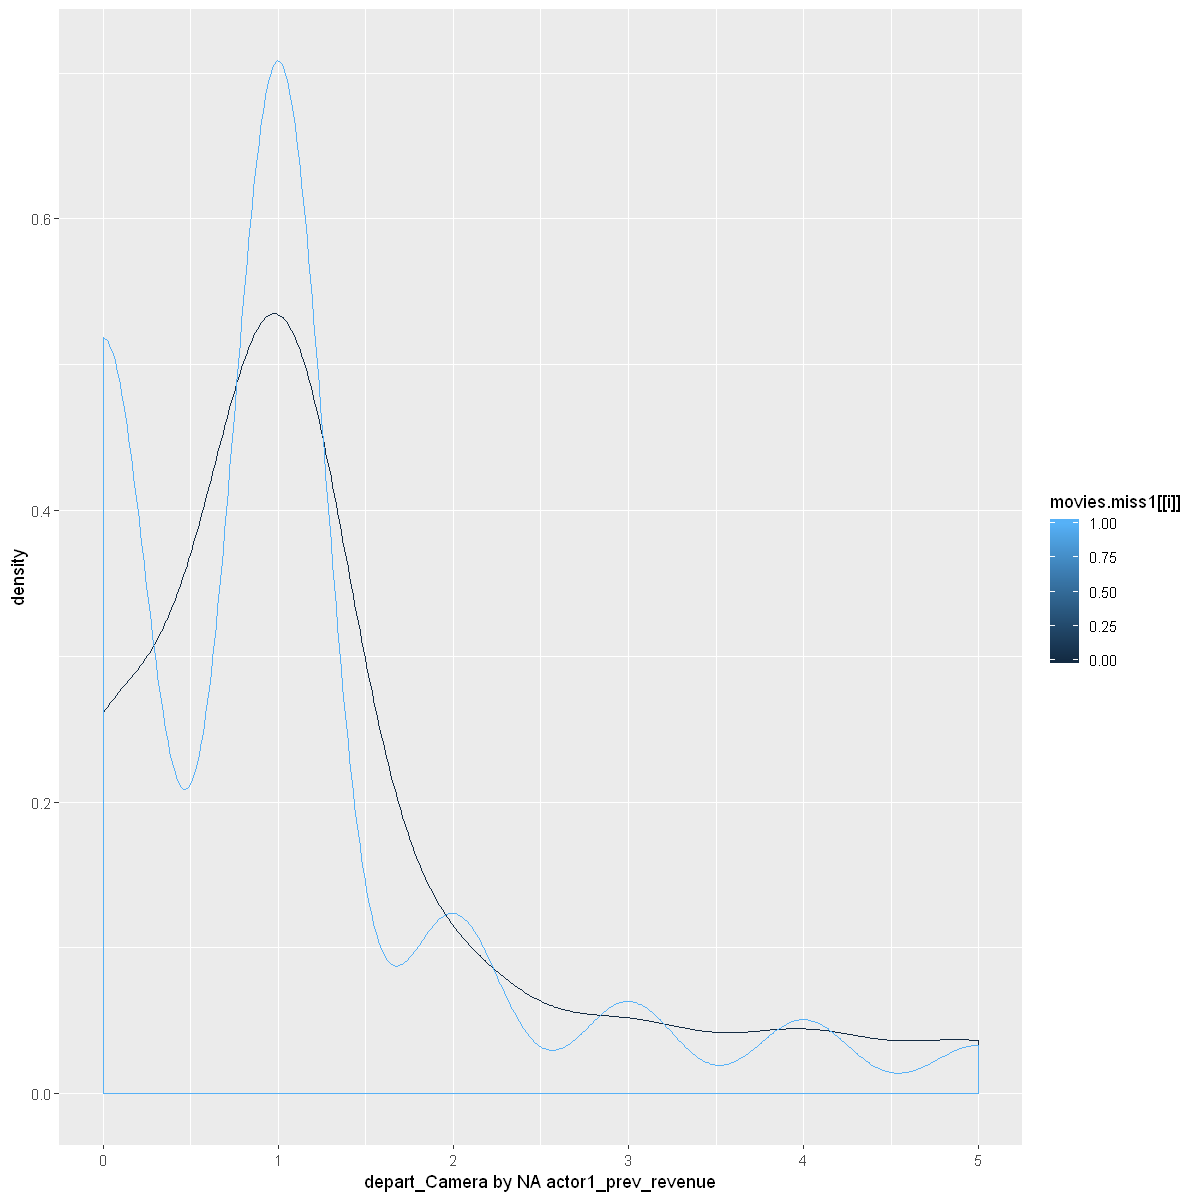


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.6032, df = 6342.8, p-value = 2.192e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1185000 0.2460357
sample estimates:
mean of x mean of y 
0.9680951 0.7858273 

[1] "depart_Custom_Mkup by NA actor1_prev_revenue"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


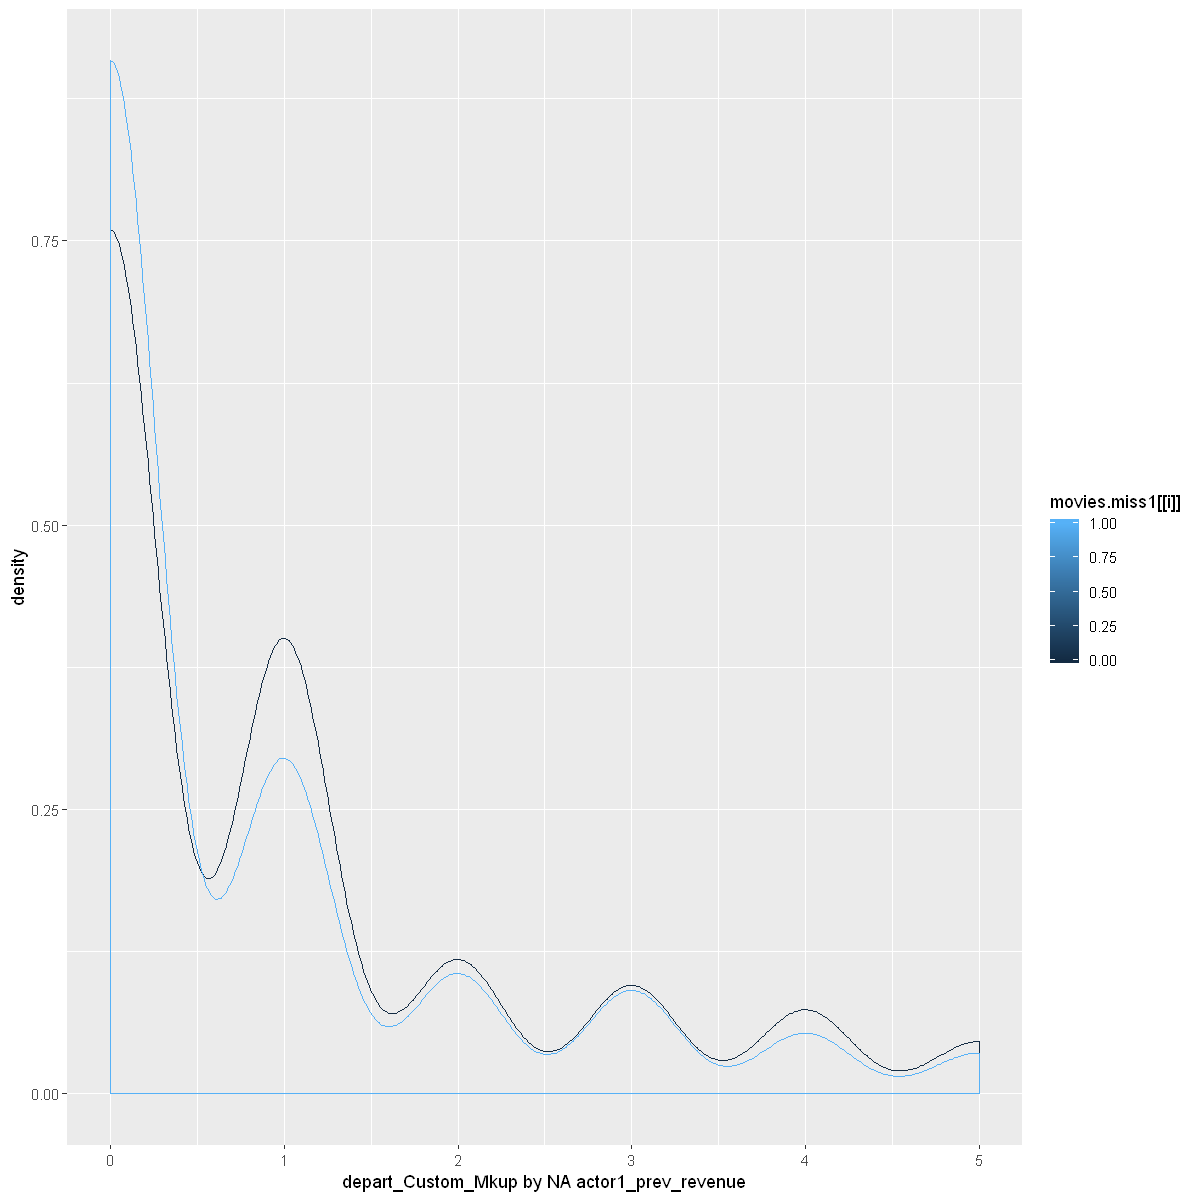


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 6.6354, df = 6859.4, p-value = 3.482e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.07269791 0.13366318
sample estimates:
mean of x mean of y 
 1.461992  1.358811 

[1] "depart_Directing by NA actor1_prev_revenue"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


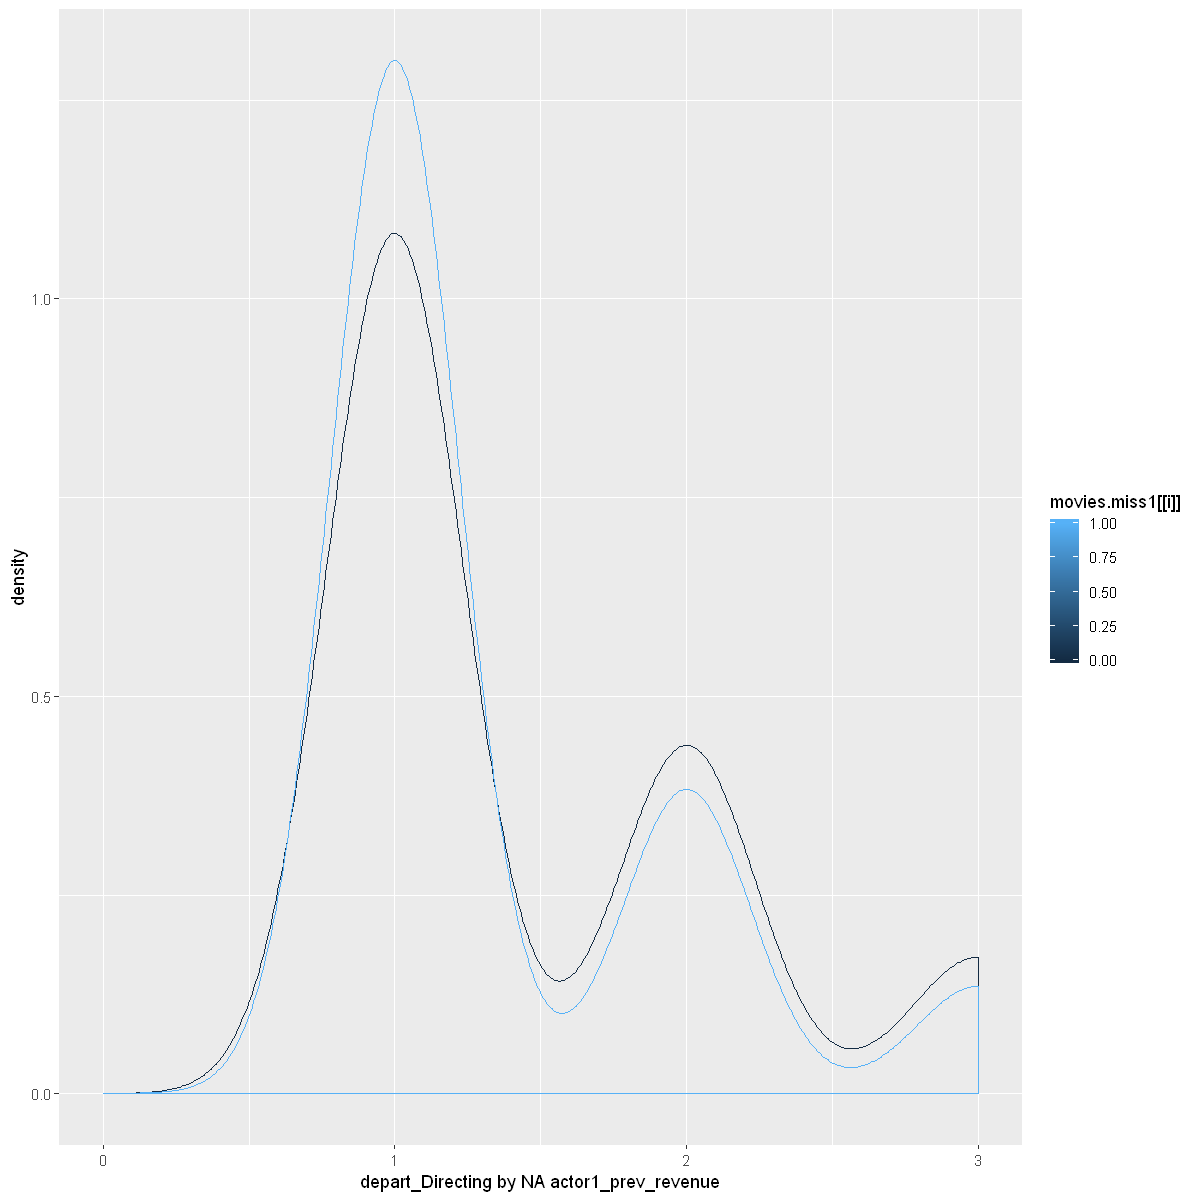


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 3.2999, df = 6088.7, p-value = 0.0009727
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04686178 0.18401841
sample estimates:
mean of x mean of y 
 1.320915  1.205475 

[1] "depart_Sound by NA actor1_prev_revenue"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


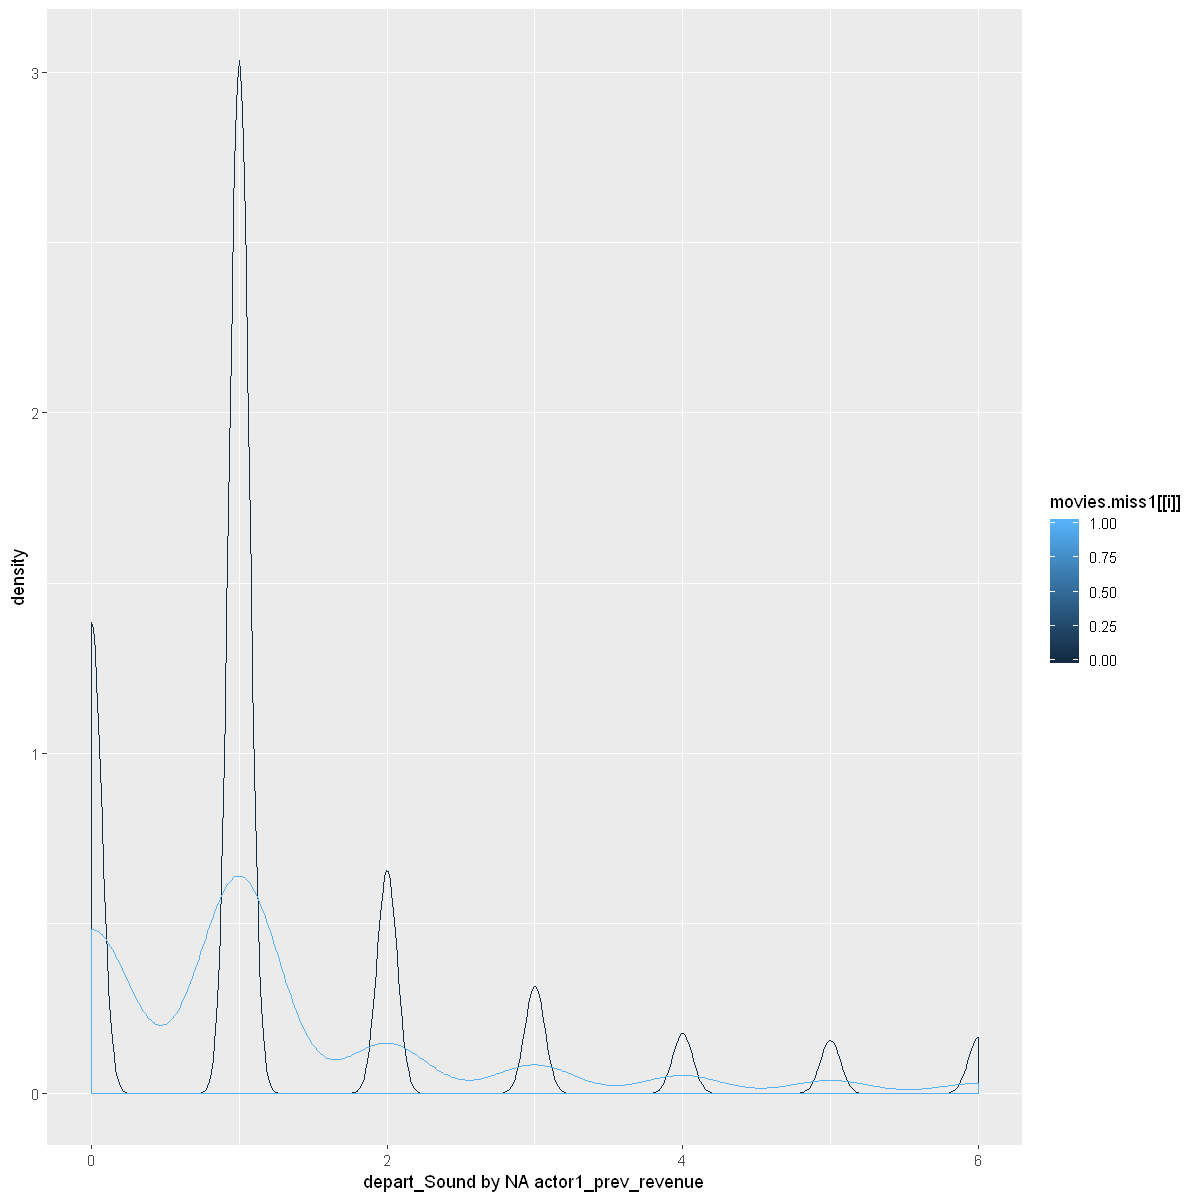


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 16.766, df = 4960.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8942213 11310387
sample estimates:
mean of x mean of y 
 26941526  16815226 

[1] "budget by NA actor2_prev_revenue"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


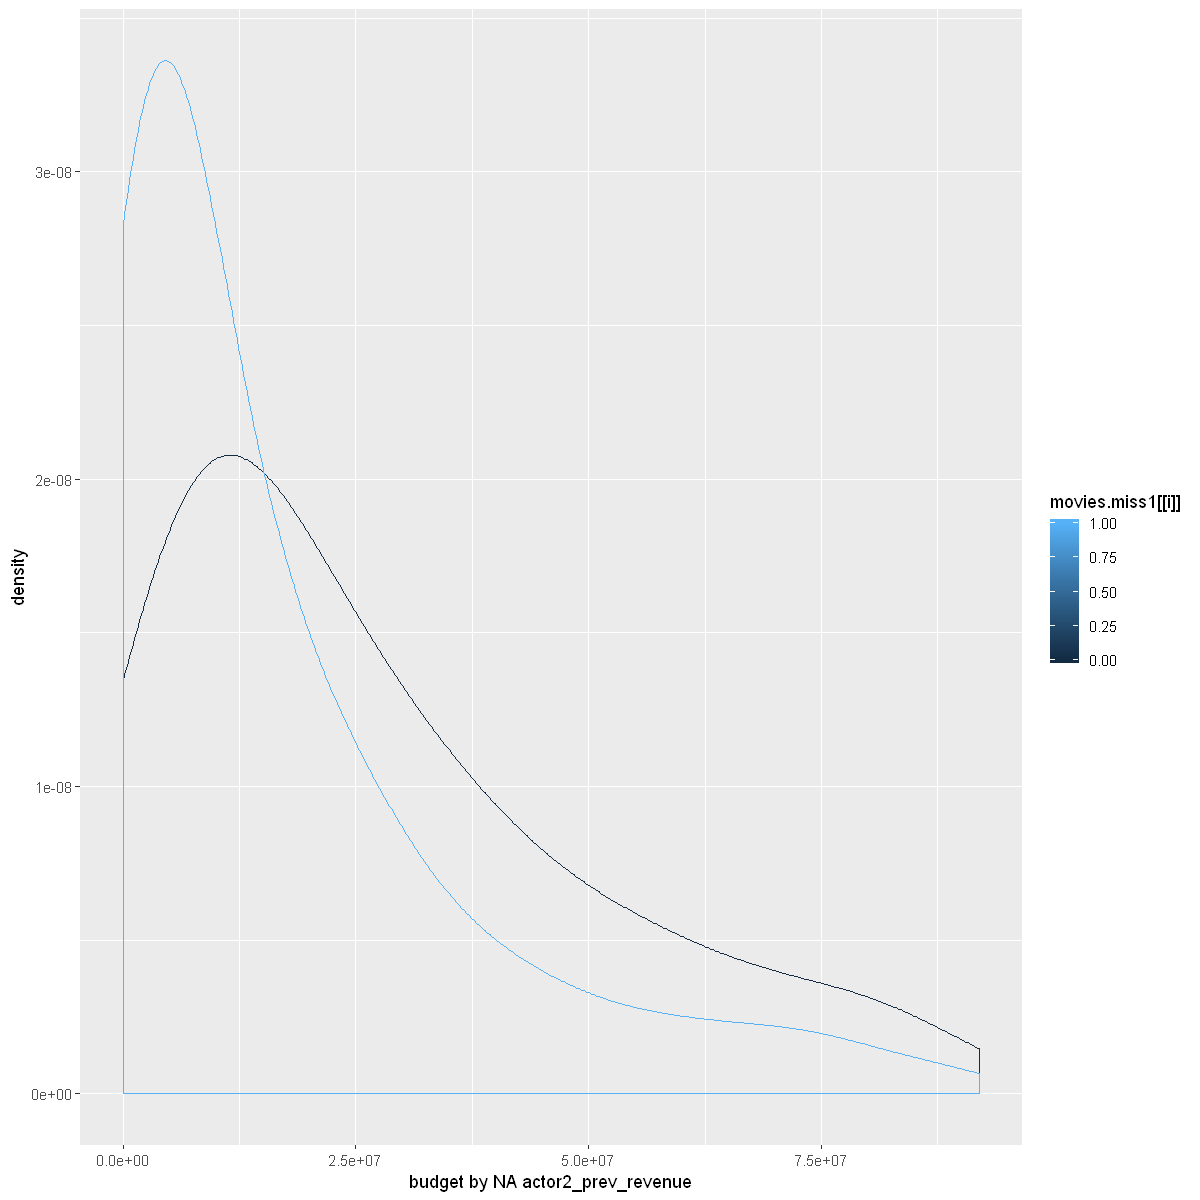


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 4.1439, df = 6965.8, p-value = 3.455e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1119411 0.3129314
sample estimates:
mean of x mean of y 
 3.013072  2.800636 

[1] "producers_cnt by NA actor2_prev_revenue"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


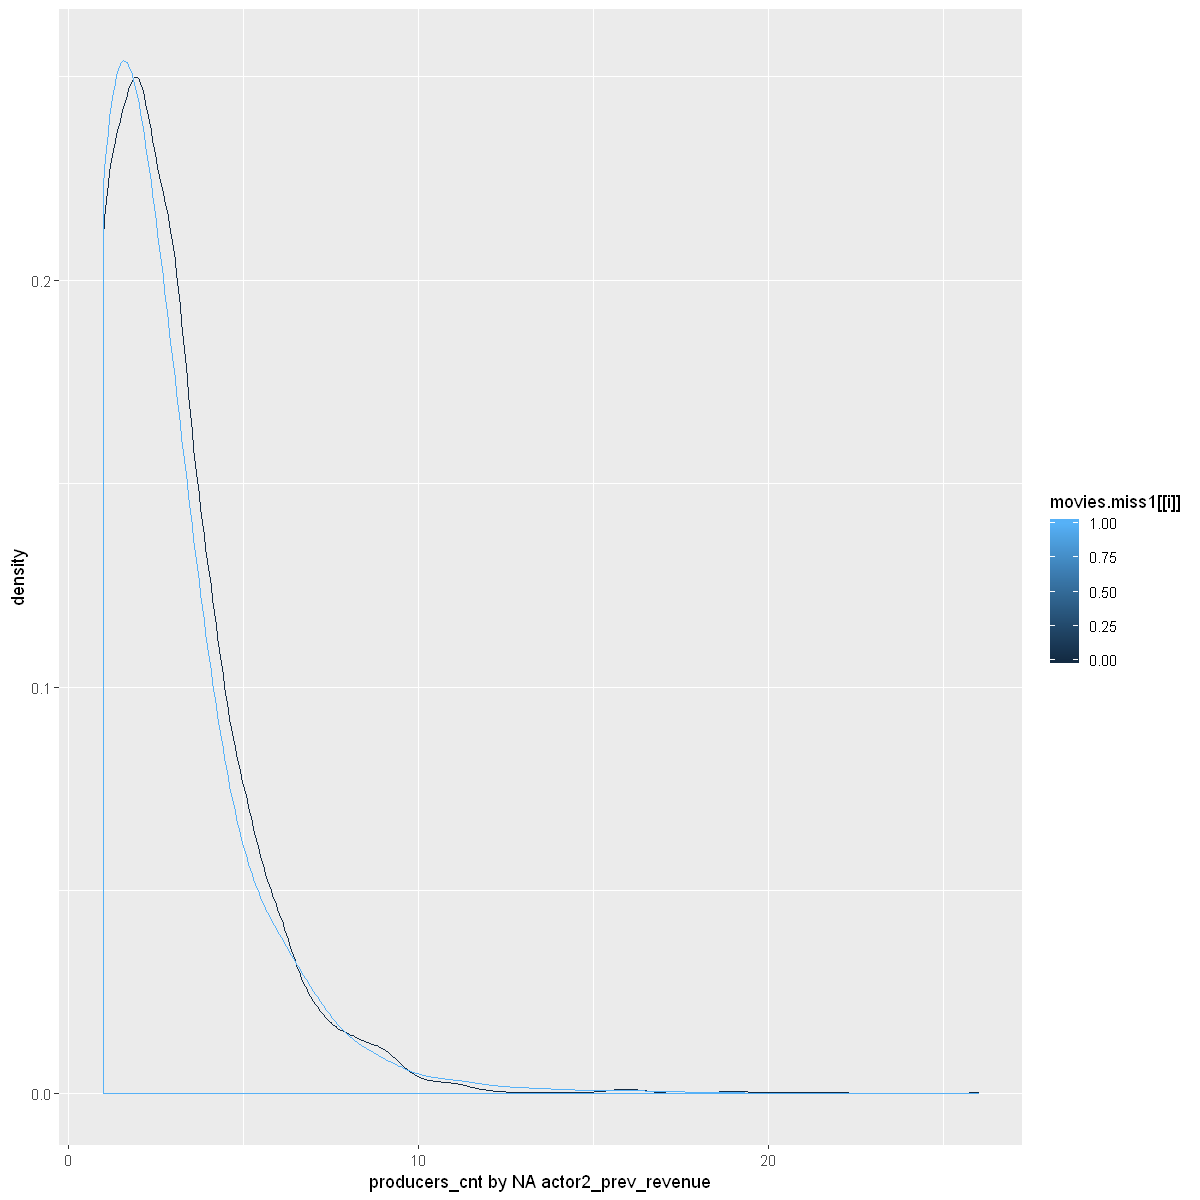


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 32.84, df = 6038.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.527925 3.975857
sample estimates:
mean of x mean of y 
 6.030751  2.278859 

[1] "actor1_movies_cnt by NA actor2_prev_revenue"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


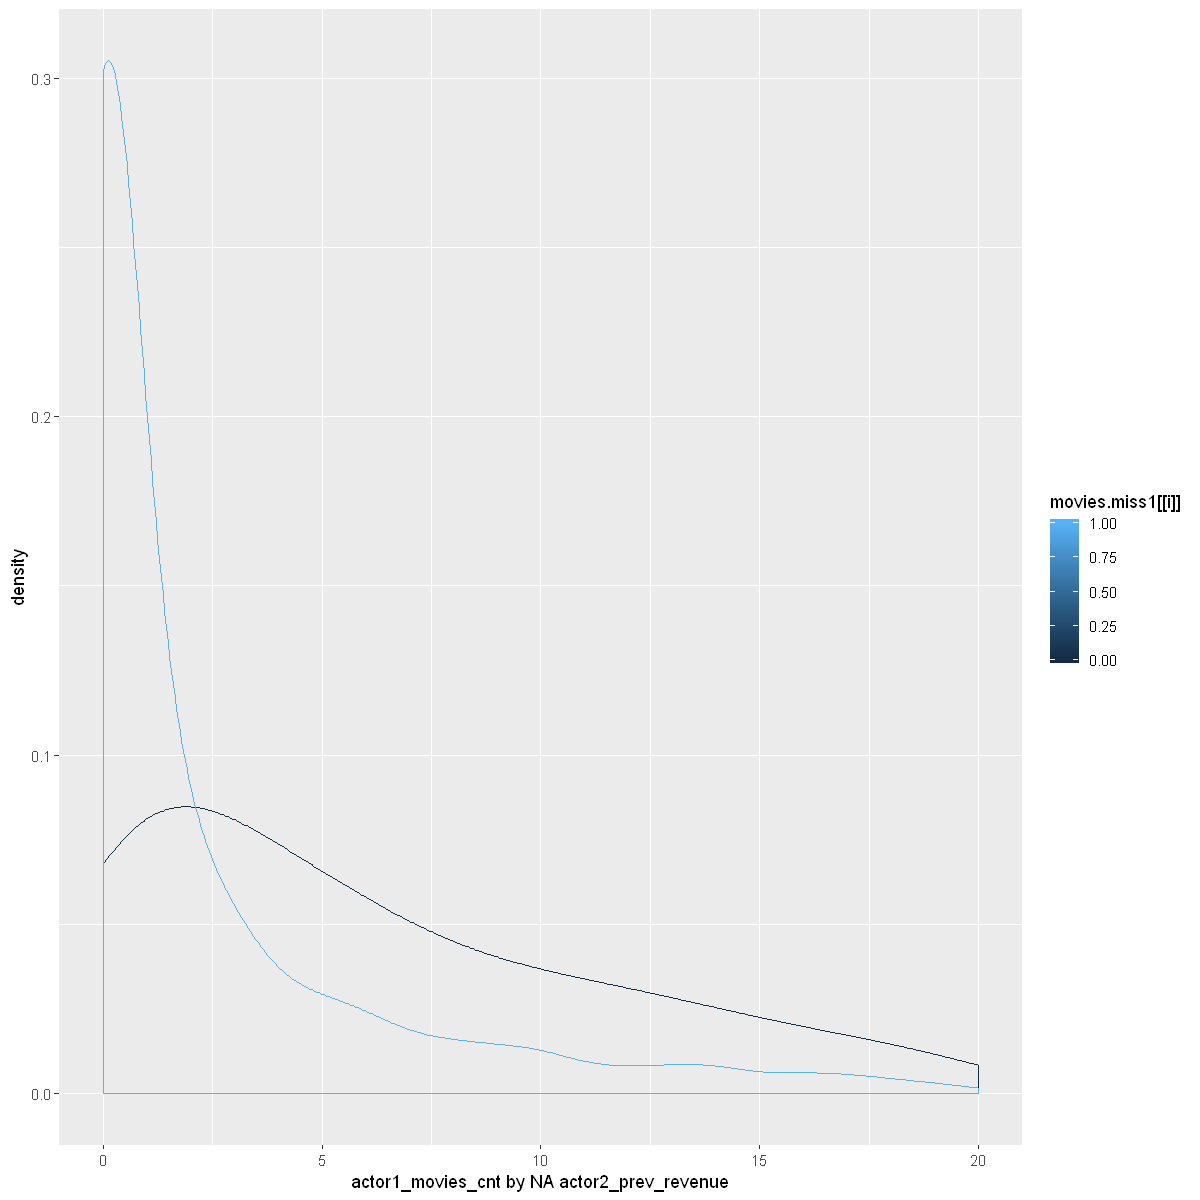


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 59.762, df = 5000.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 4.925404 5.259508
sample estimates:
mean of x mean of y 
5.9811612 0.8887052 

[1] "actor2_movies_cnt by NA actor2_prev_revenue"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


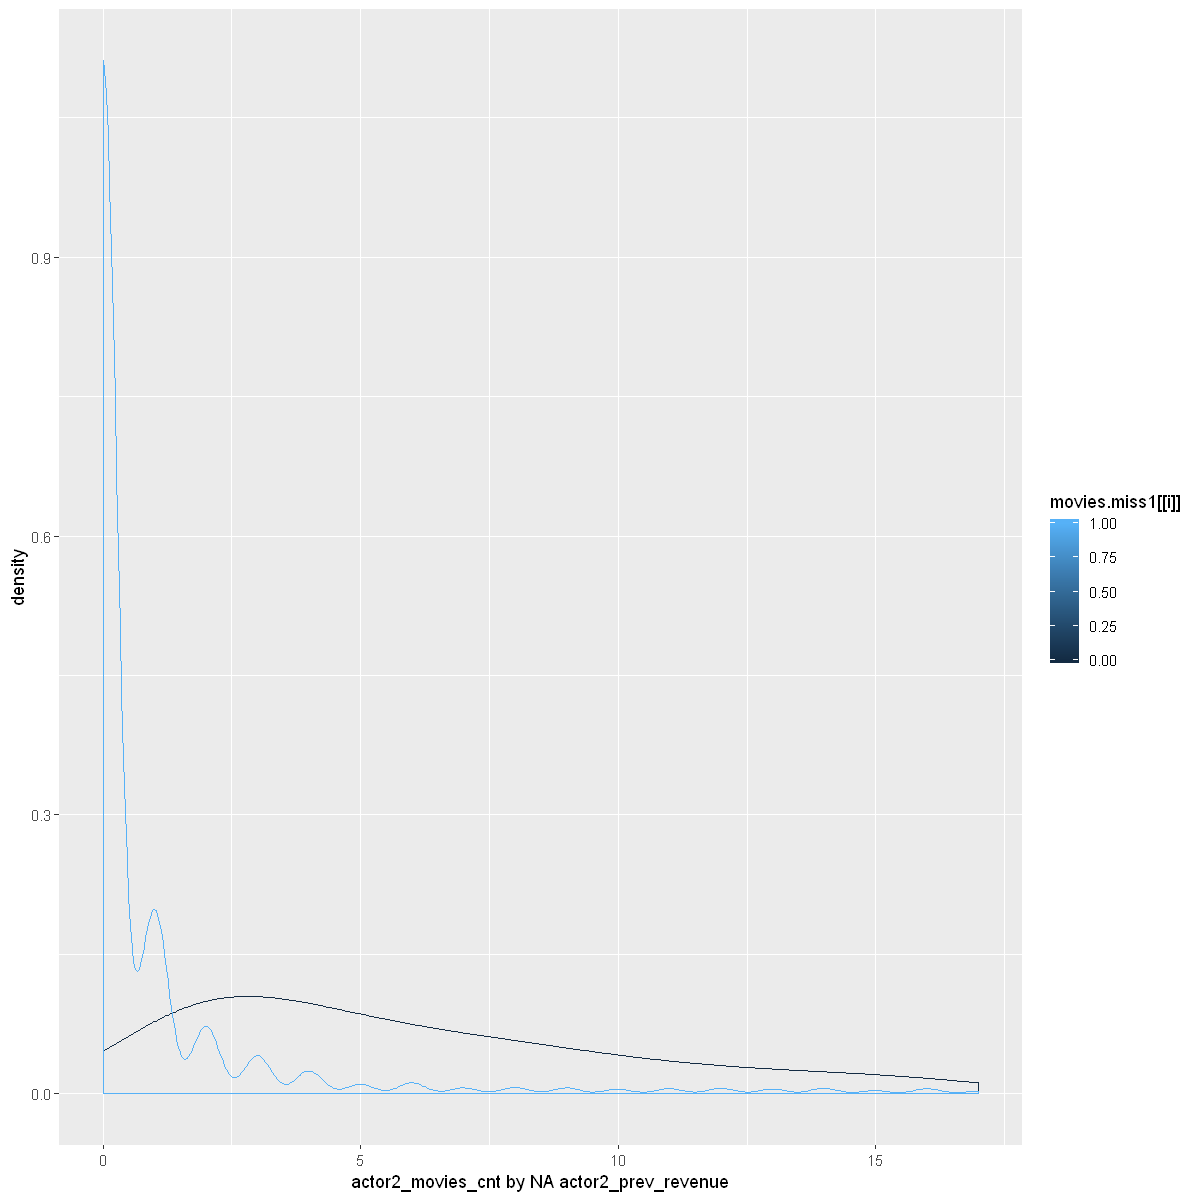


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 8.6604, df = 3128.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 33462939 53049270
sample estimates:
mean of x mean of y 
190283453 147027349 

[1] "actor0_prev_revenue by NA actor2_prev_revenue"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


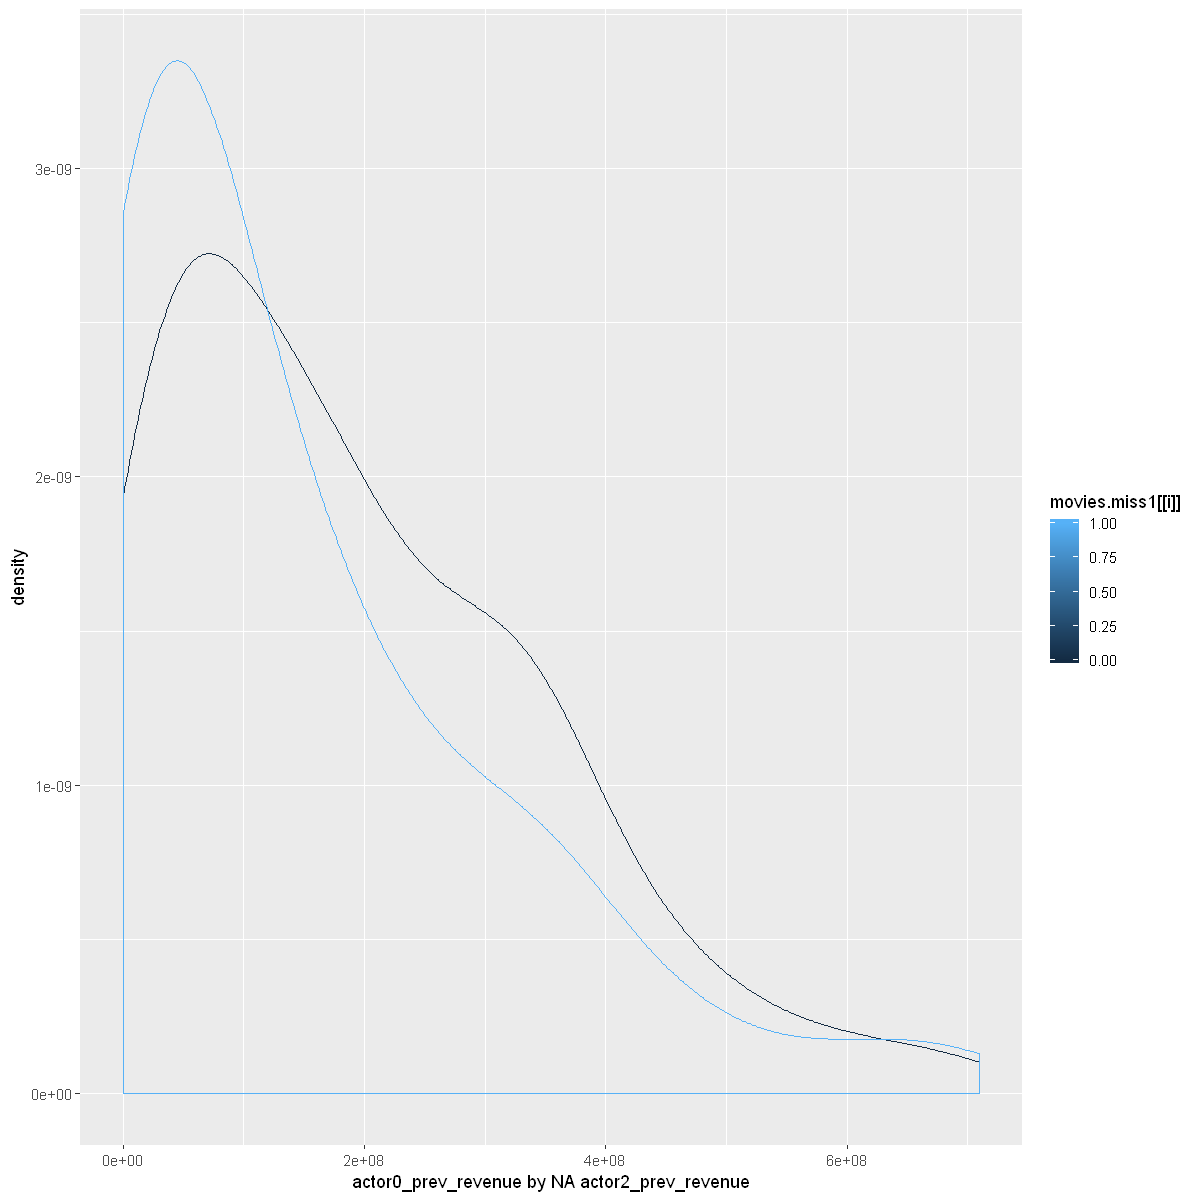


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 8.8565, df = 2661.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 30815348 48340862
sample estimates:
mean of x mean of y 
158313150 118735045 

[1] "actor1_prev_revenue by NA actor2_prev_revenue"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


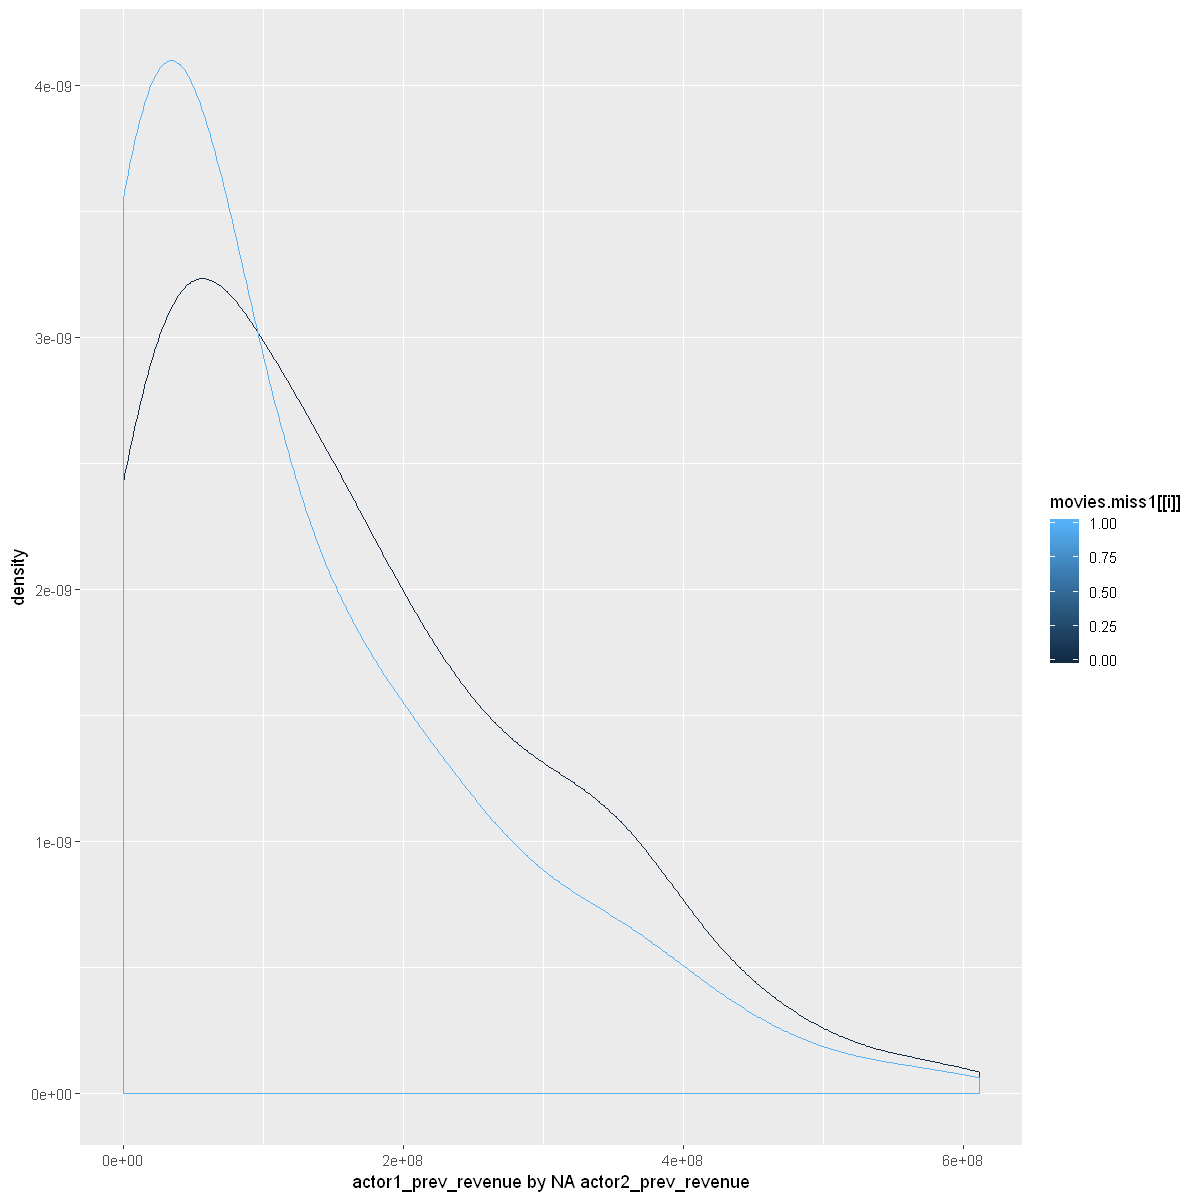


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 13.552, df = 6597.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4979247 0.6663328
sample estimates:
mean of x mean of y 
 1.655895  1.073766 

[1] "director_movies_cnt by NA actor2_prev_revenue"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


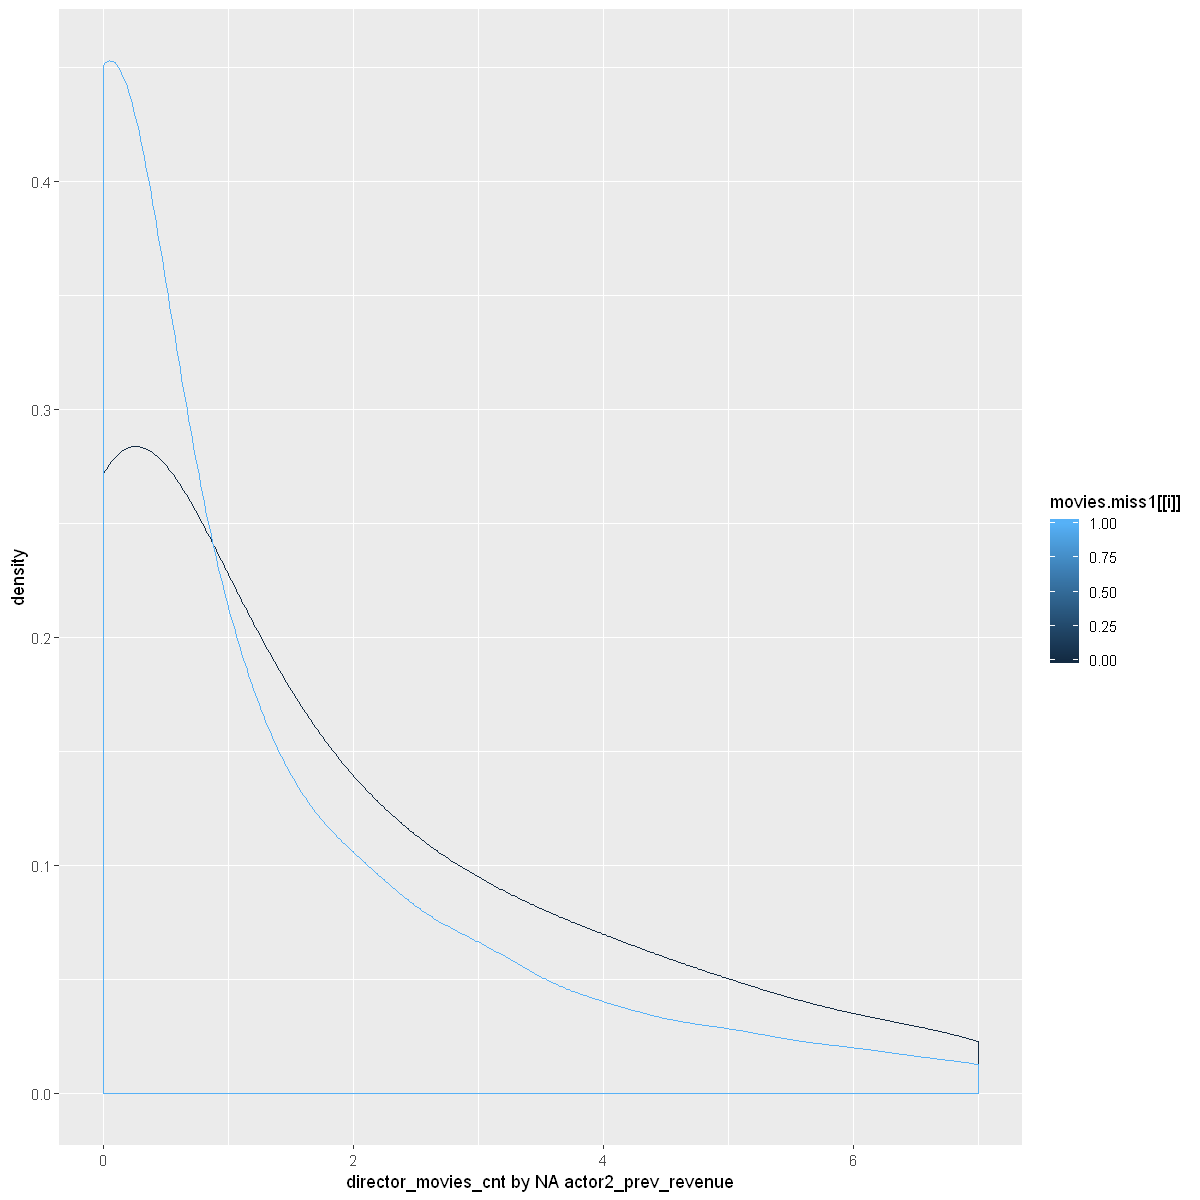


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 11.312, df = 6323.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4254814 0.6038552
sample estimates:
mean of x mean of y 
 1.876020  1.361352 

[1] "depart_Art by NA actor2_prev_revenue"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


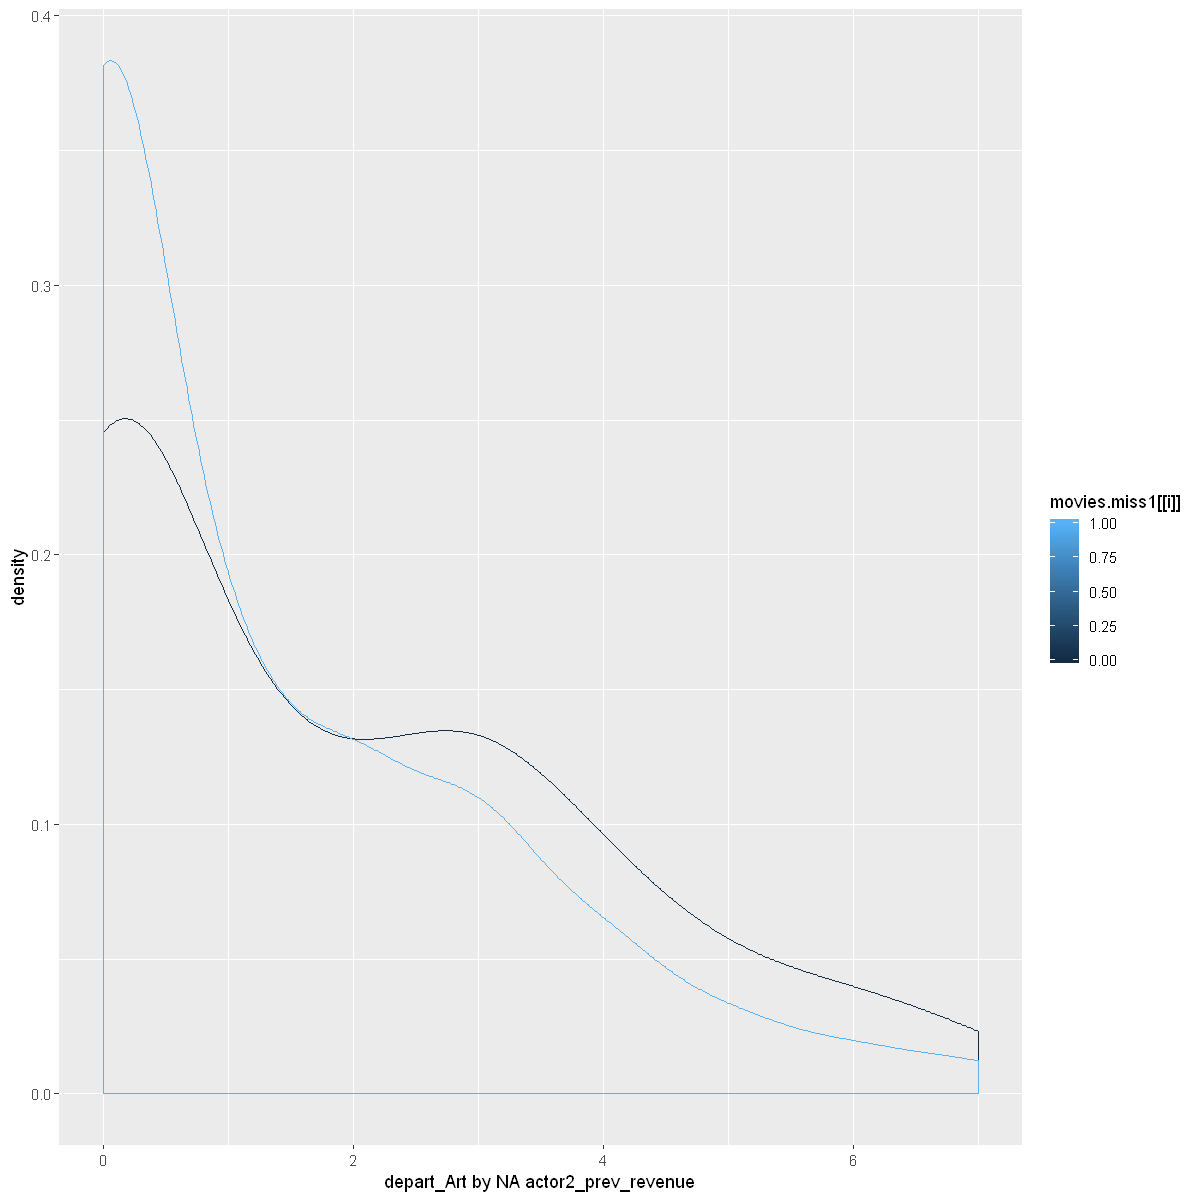


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 7.0628, df = 6506.7, p-value = 1.801e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1454428 0.2571984
sample estimates:
mean of x mean of y 
 1.216065  1.014744 

[1] "depart_Camera by NA actor2_prev_revenue"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


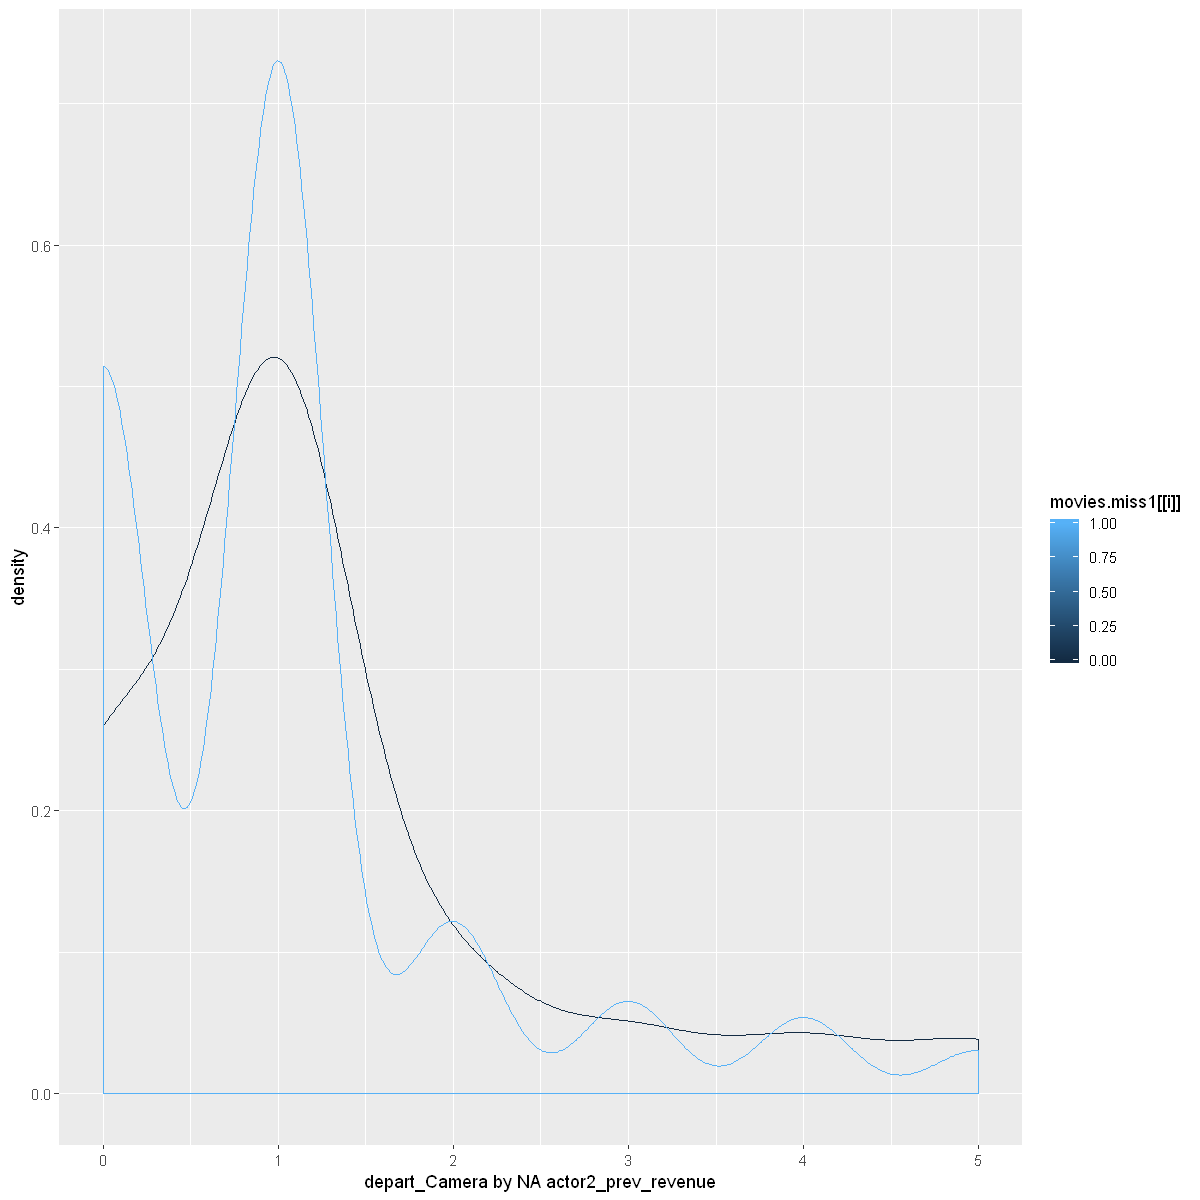


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 5.7854, df = 6121.9, p-value = 7.594e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1252317 0.2535967
sample estimates:
mean of x mean of y 
0.9779043 0.7884901 

[1] "depart_Custom_Mkup by NA actor2_prev_revenue"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


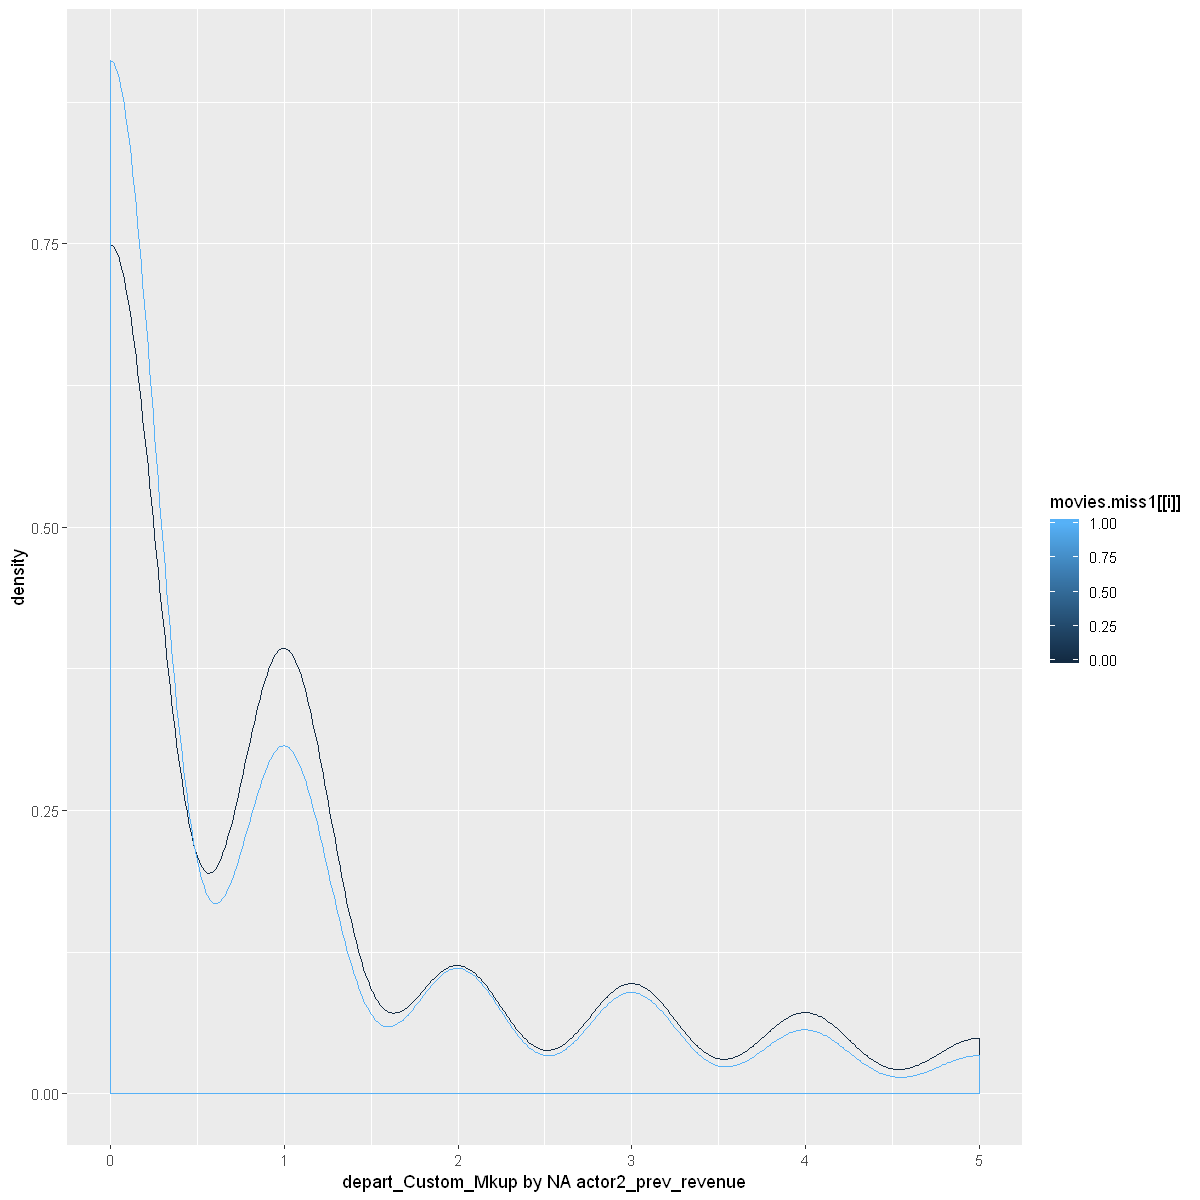


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 7.1338, df = 6703.8, p-value = 1.079e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.08082463 0.14207591
sample estimates:
mean of x mean of y 
 1.469327  1.357877 

[1] "depart_Directing by NA actor2_prev_revenue"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


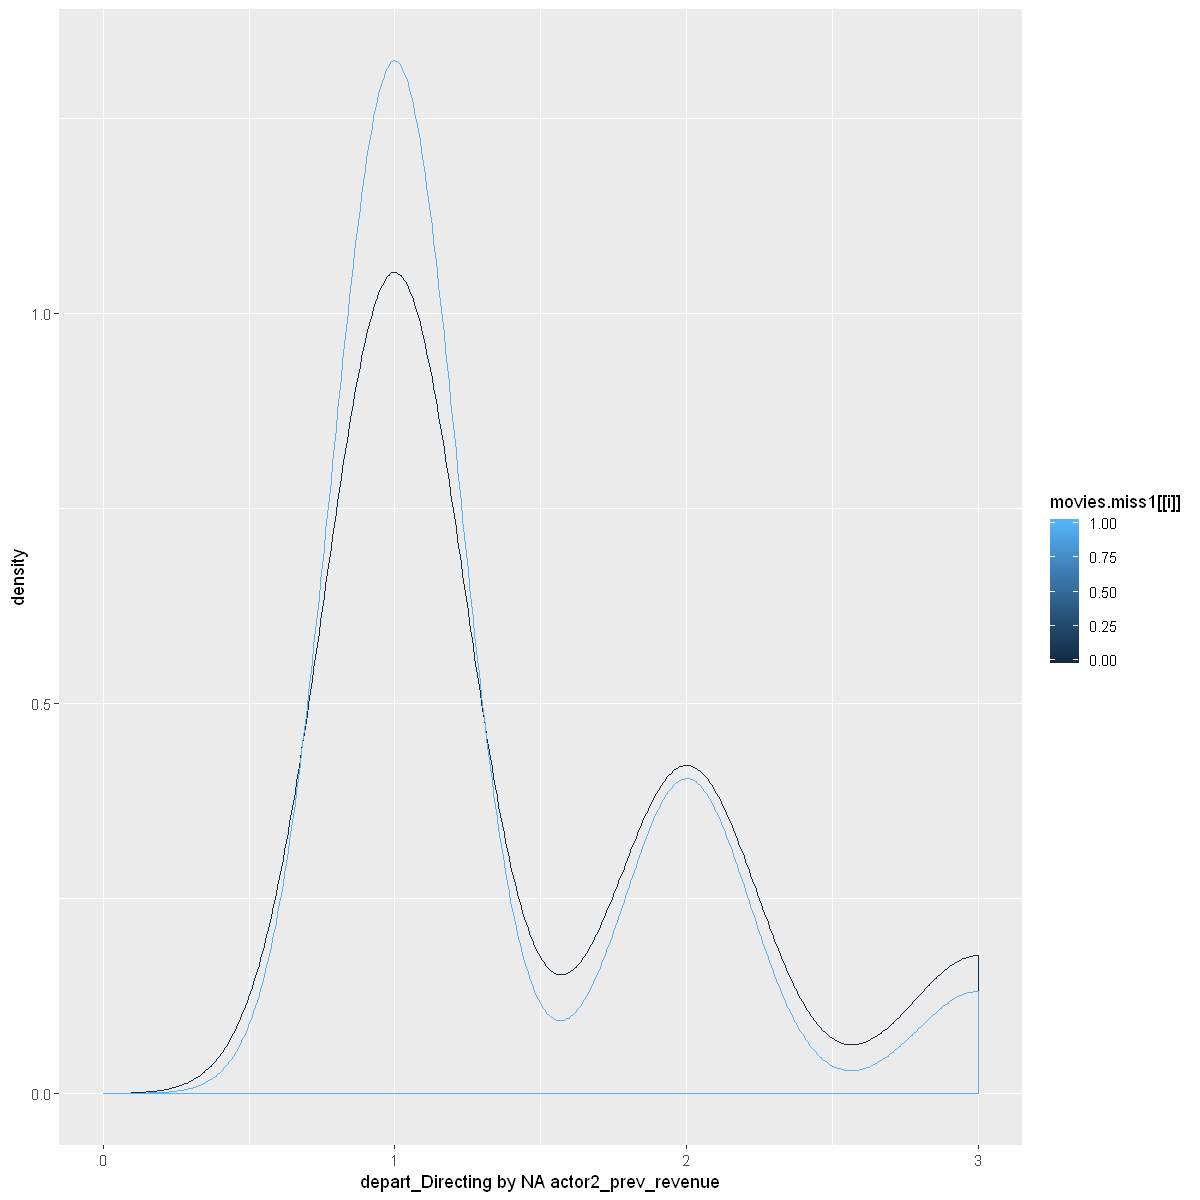


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = 3.2345, df = 6007.5, p-value = 0.001225
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04464551 0.18202099
sample estimates:
mean of x mean of y 
 1.323550  1.210217 

[1] "depart_Sound by NA actor2_prev_revenue"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


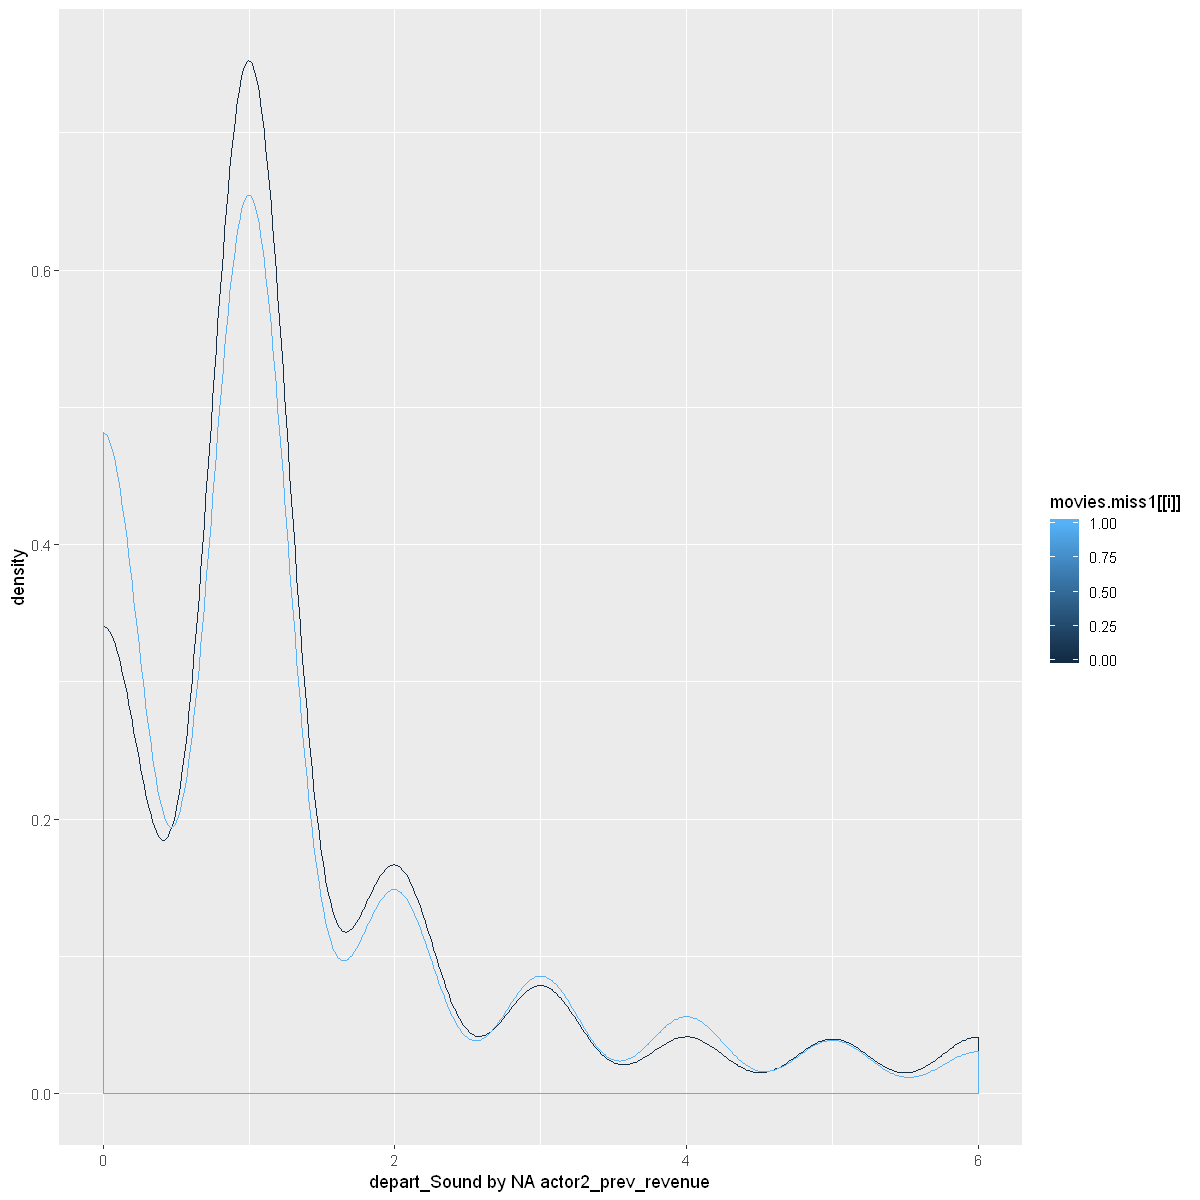


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -11.406, df = 373.94, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18416368 -13000424
sample estimates:
mean of x mean of y 
 21072856  36781253 

[1] "budget by NA director_movies_cnt"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


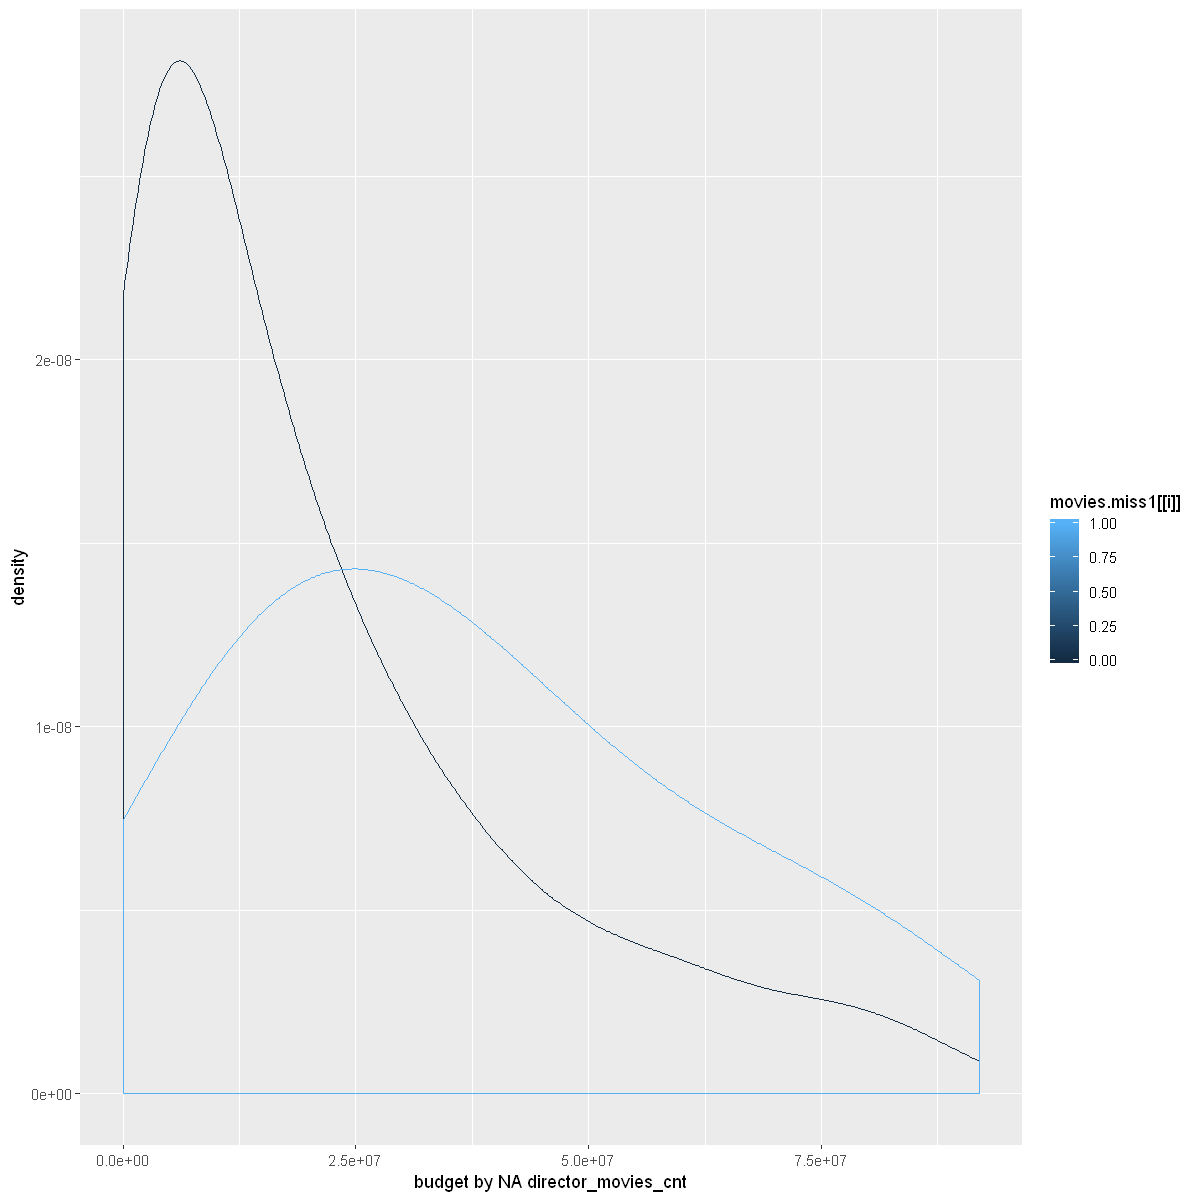


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.1739, df = 479.72, p-value = 2.782e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9837353 -0.5607131
sample estimates:
mean of x mean of y 
 2.860717  3.632941 

[1] "producers_cnt by NA director_movies_cnt"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


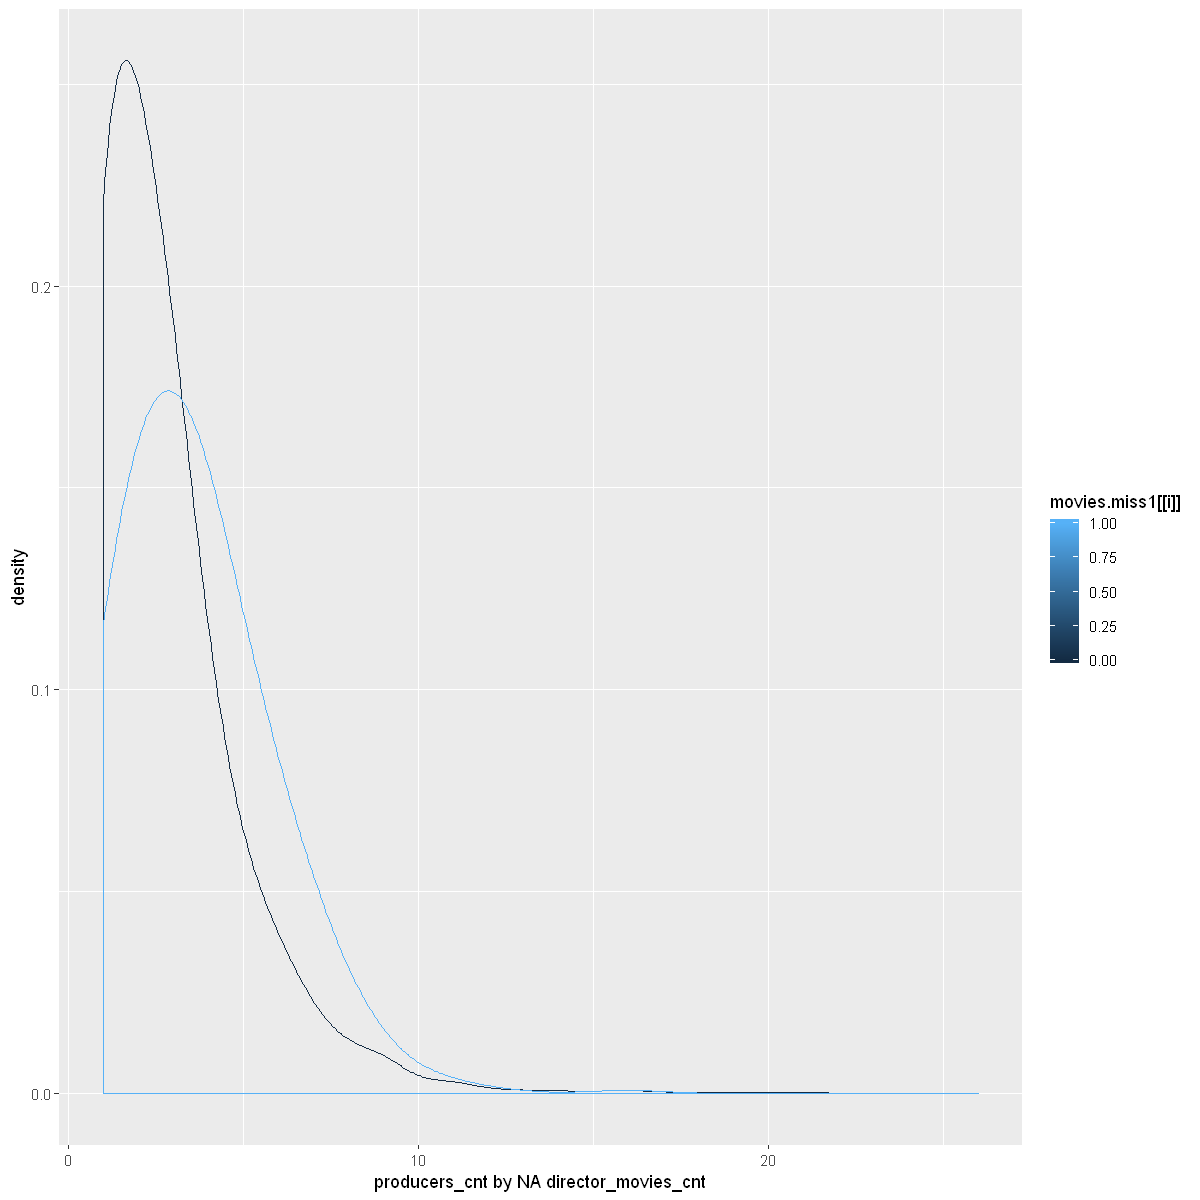


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.6288, df = 405.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.196400 -2.010223
sample estimates:
mean of x mean of y 
 3.926100  6.529412 

[1] "actor1_movies_cnt by NA director_movies_cnt"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


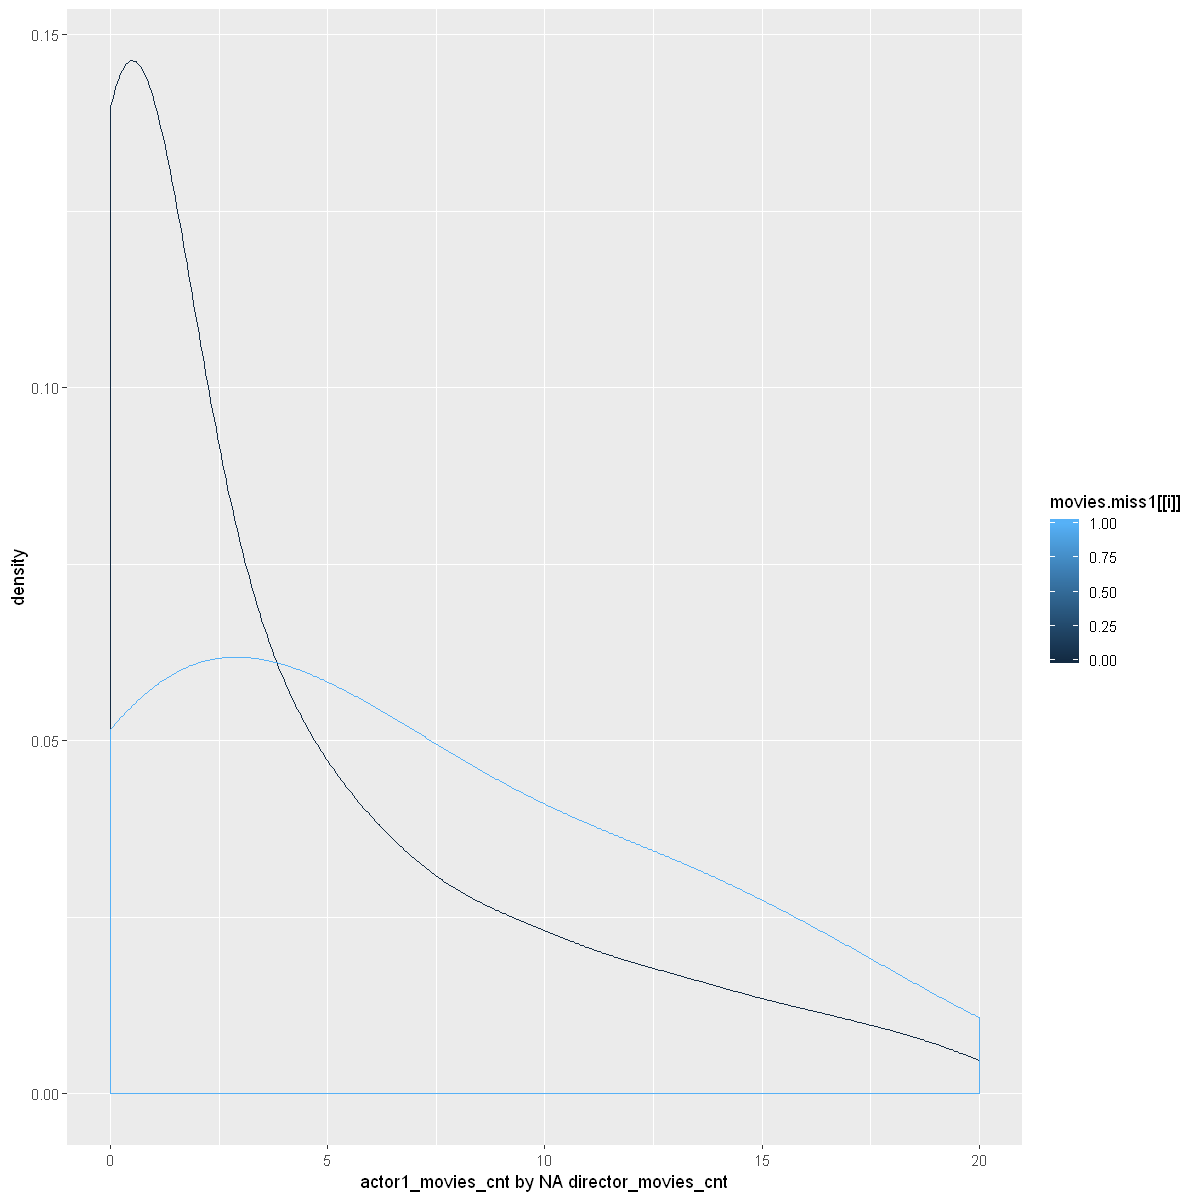


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.7252, df = 401.08, p-value = 9.033e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.536260 -1.507271
sample estimates:
mean of x mean of y 
 3.180391  5.202156 

[1] "actor2_movies_cnt by NA director_movies_cnt"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


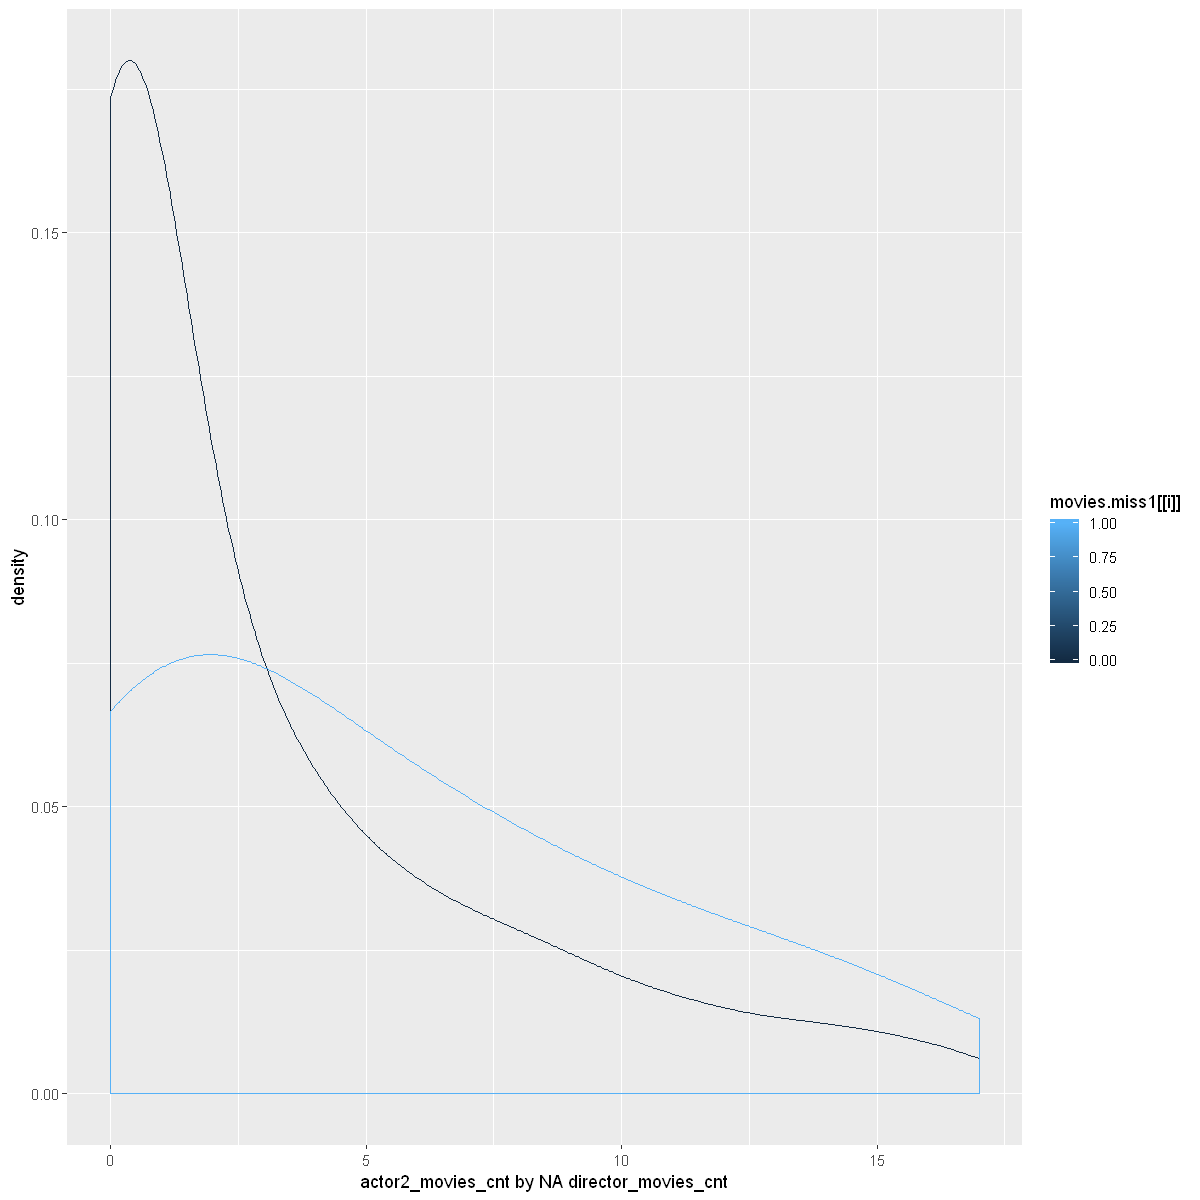


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.7066, df = 341.38, p-value = 8.275e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -87305479 -47708302
sample estimates:
mean of x mean of y 
170220753 237727644 

[1] "actor0_prev_revenue by NA director_movies_cnt"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


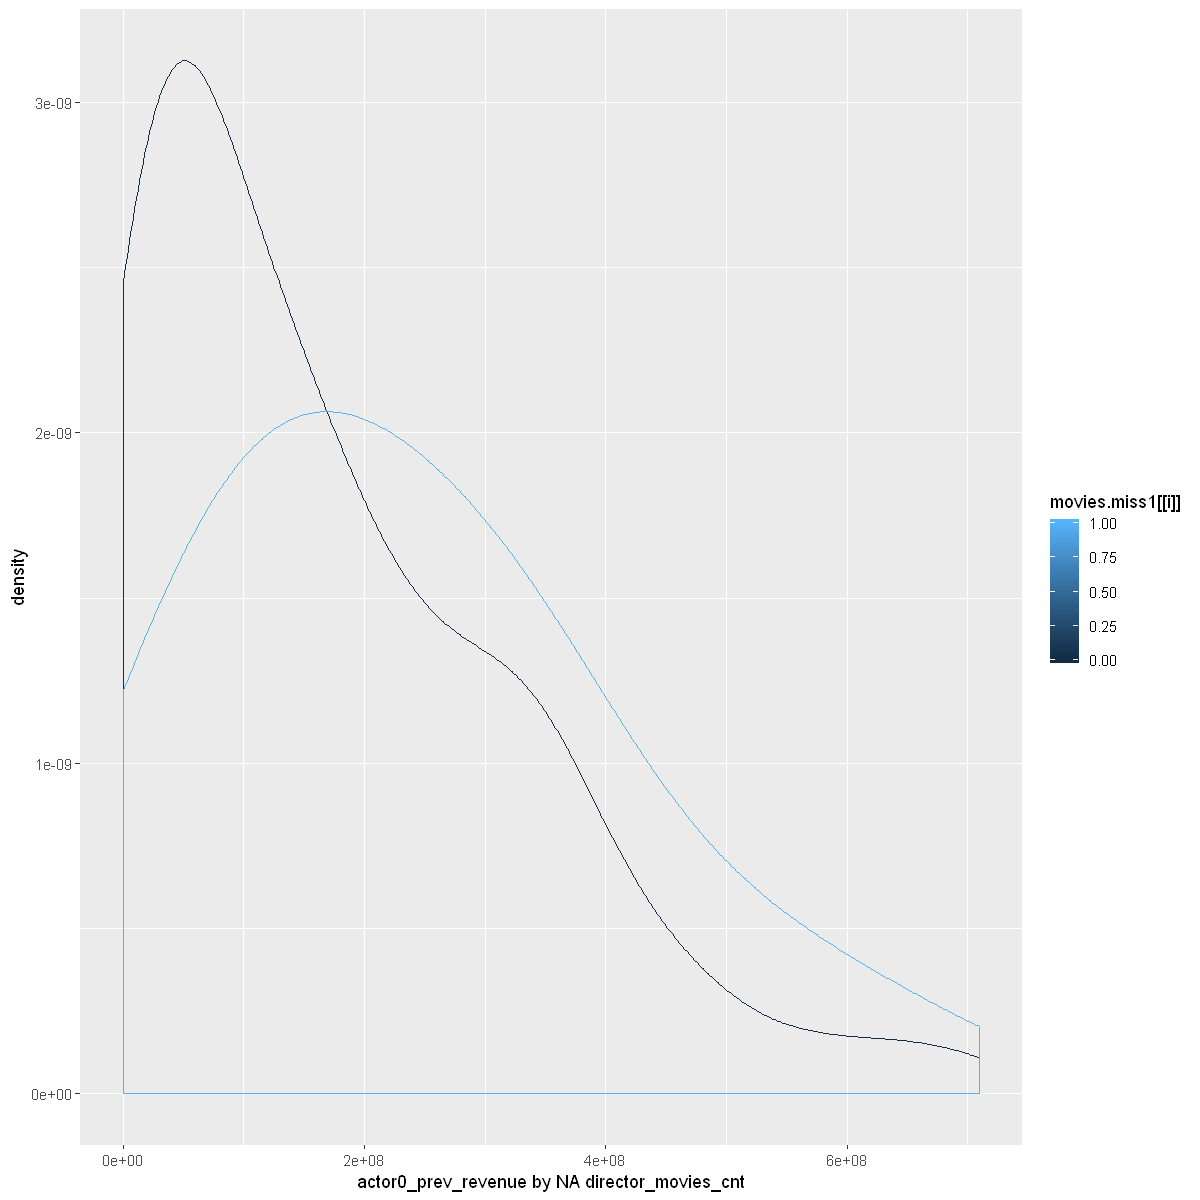


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -4.1144, df = 332.13, p-value = 4.901e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -49126727 -17345610
sample estimates:
mean of x mean of y 
142725751 175961919 

[1] "actor1_prev_revenue by NA director_movies_cnt"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


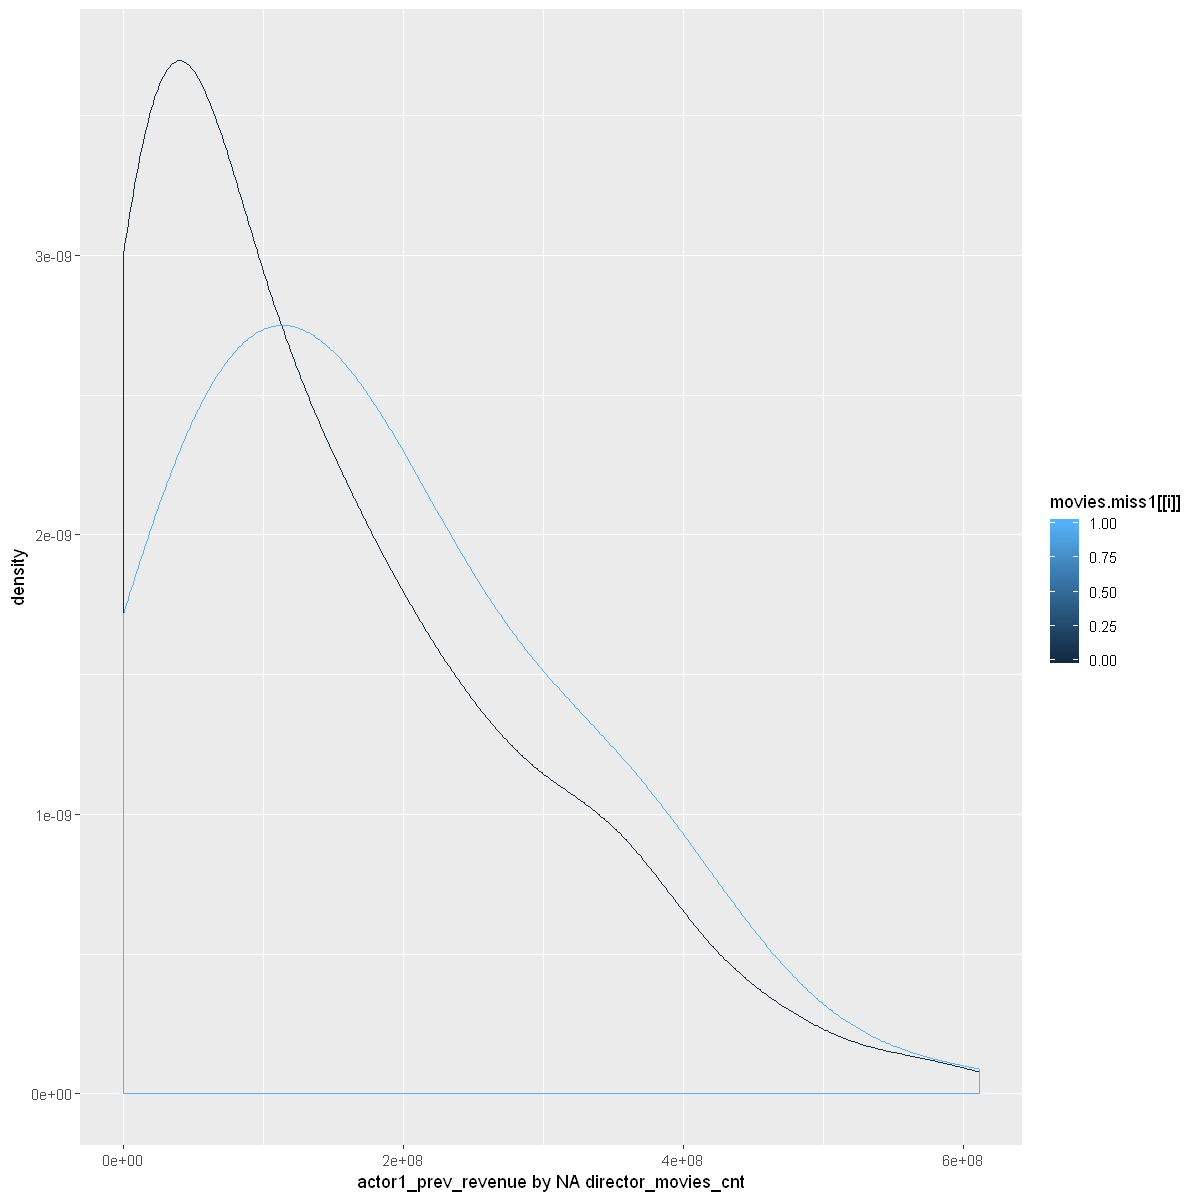


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -3.4677, df = 328.05, p-value = 0.0005949
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -42389518 -11703051
sample estimates:
mean of x mean of y 
131726150 158772434 

[1] "actor2_prev_revenue by NA director_movies_cnt"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


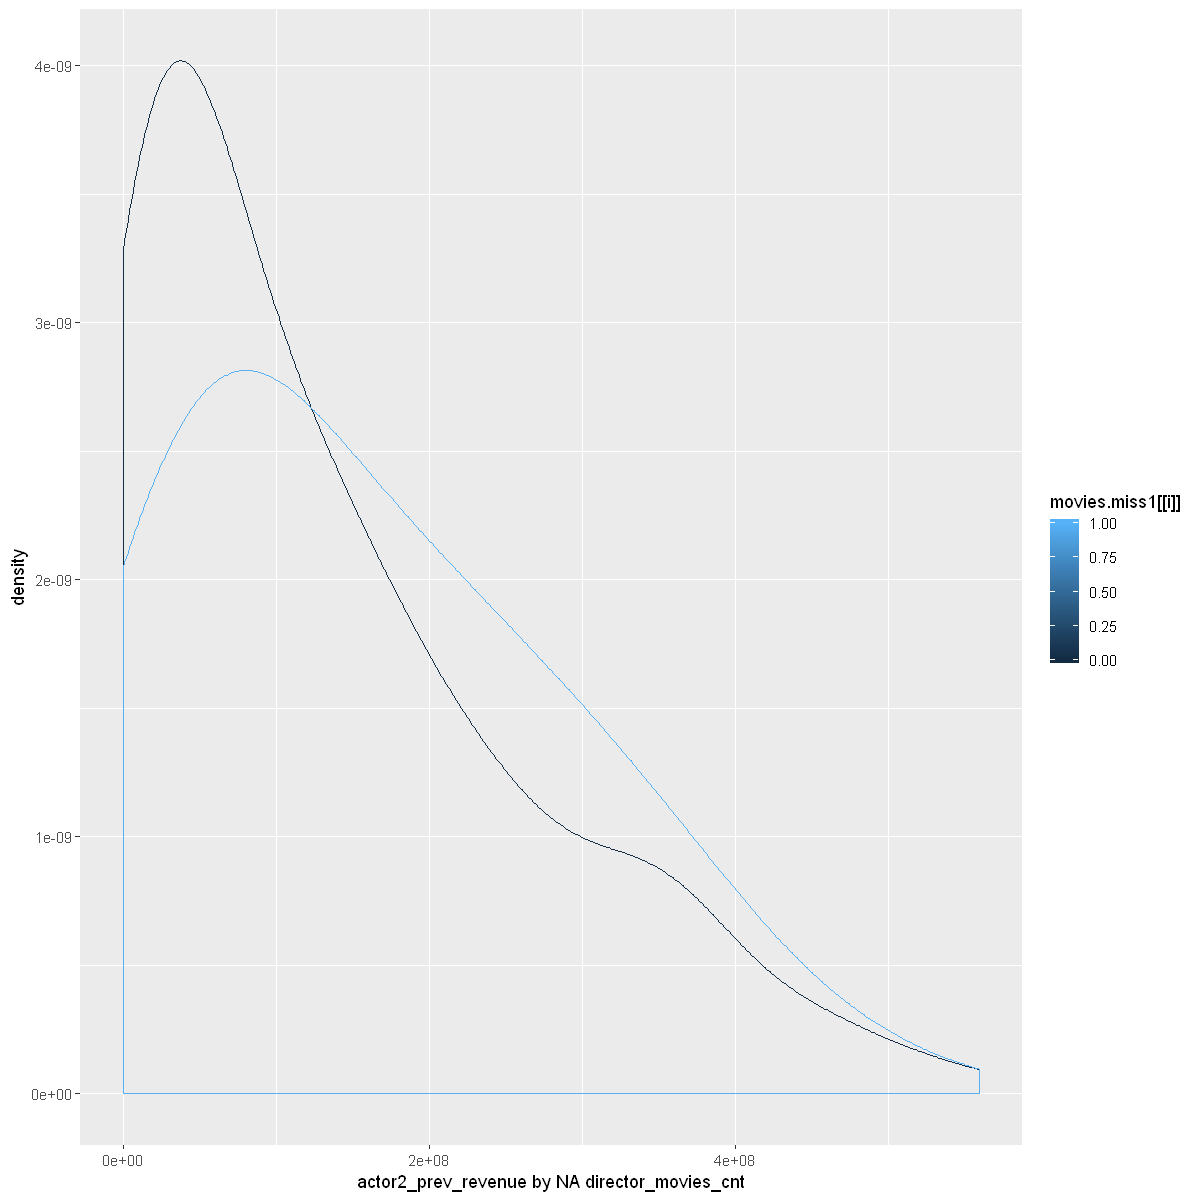


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.2349, df = 349.28, p-value = 3.636e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.2018467 -0.7384396
sample estimates:
mean of x mean of y 
 1.560721  2.530864 

[1] "depart_Art by NA director_movies_cnt"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


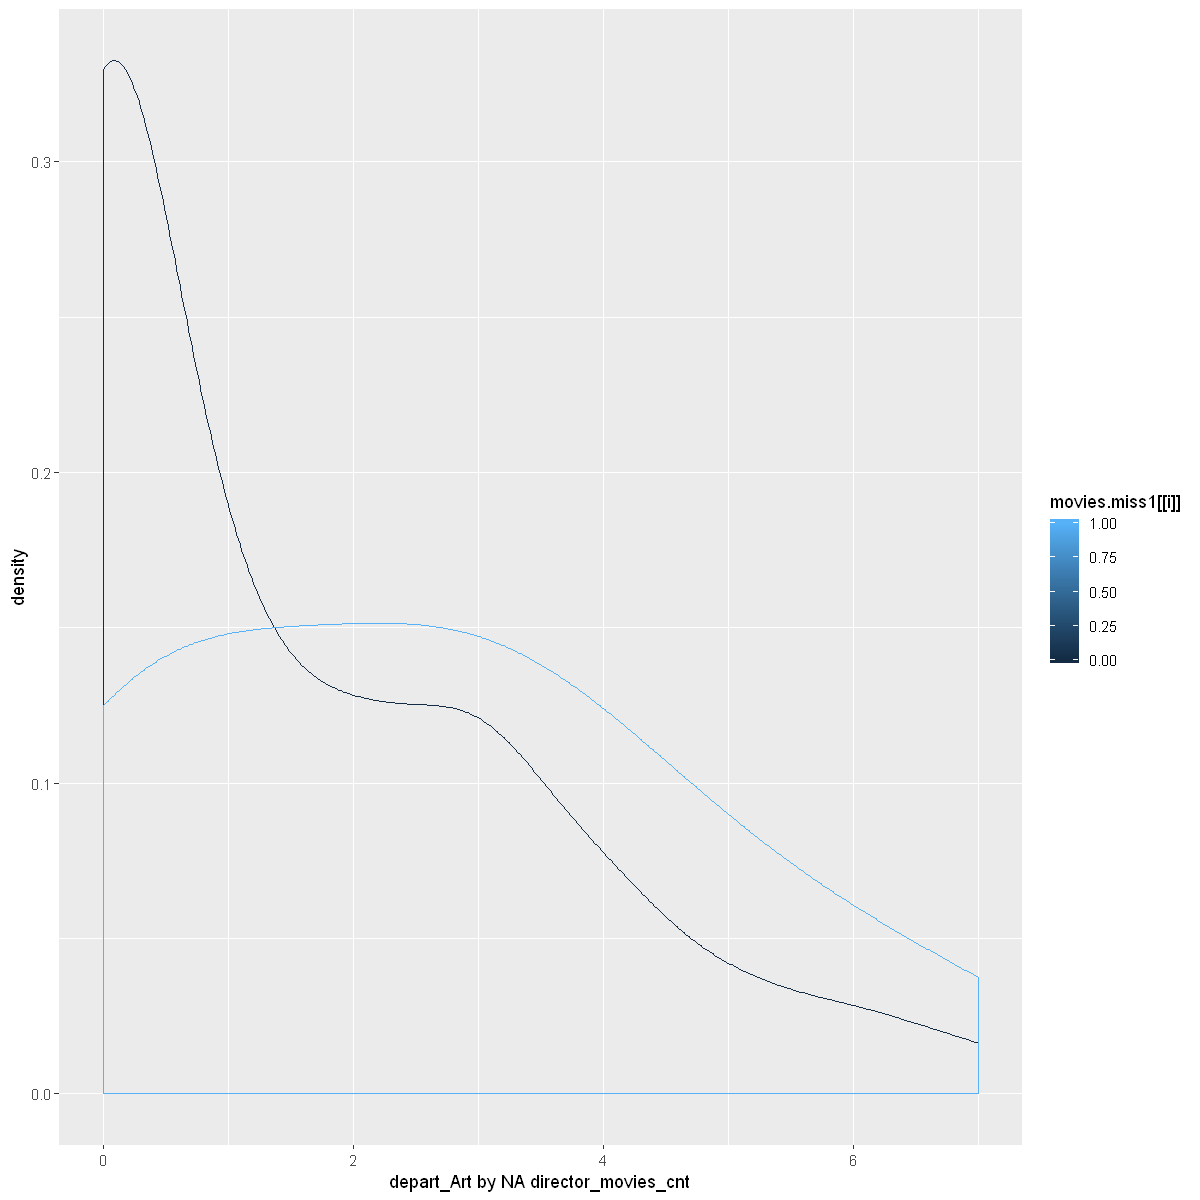


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.0311, df = 374.36, p-value = 3.91e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5365196 -0.2726922
sample estimates:
mean of x mean of y 
 1.090995  1.495601 

[1] "depart_Camera by NA director_movies_cnt"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


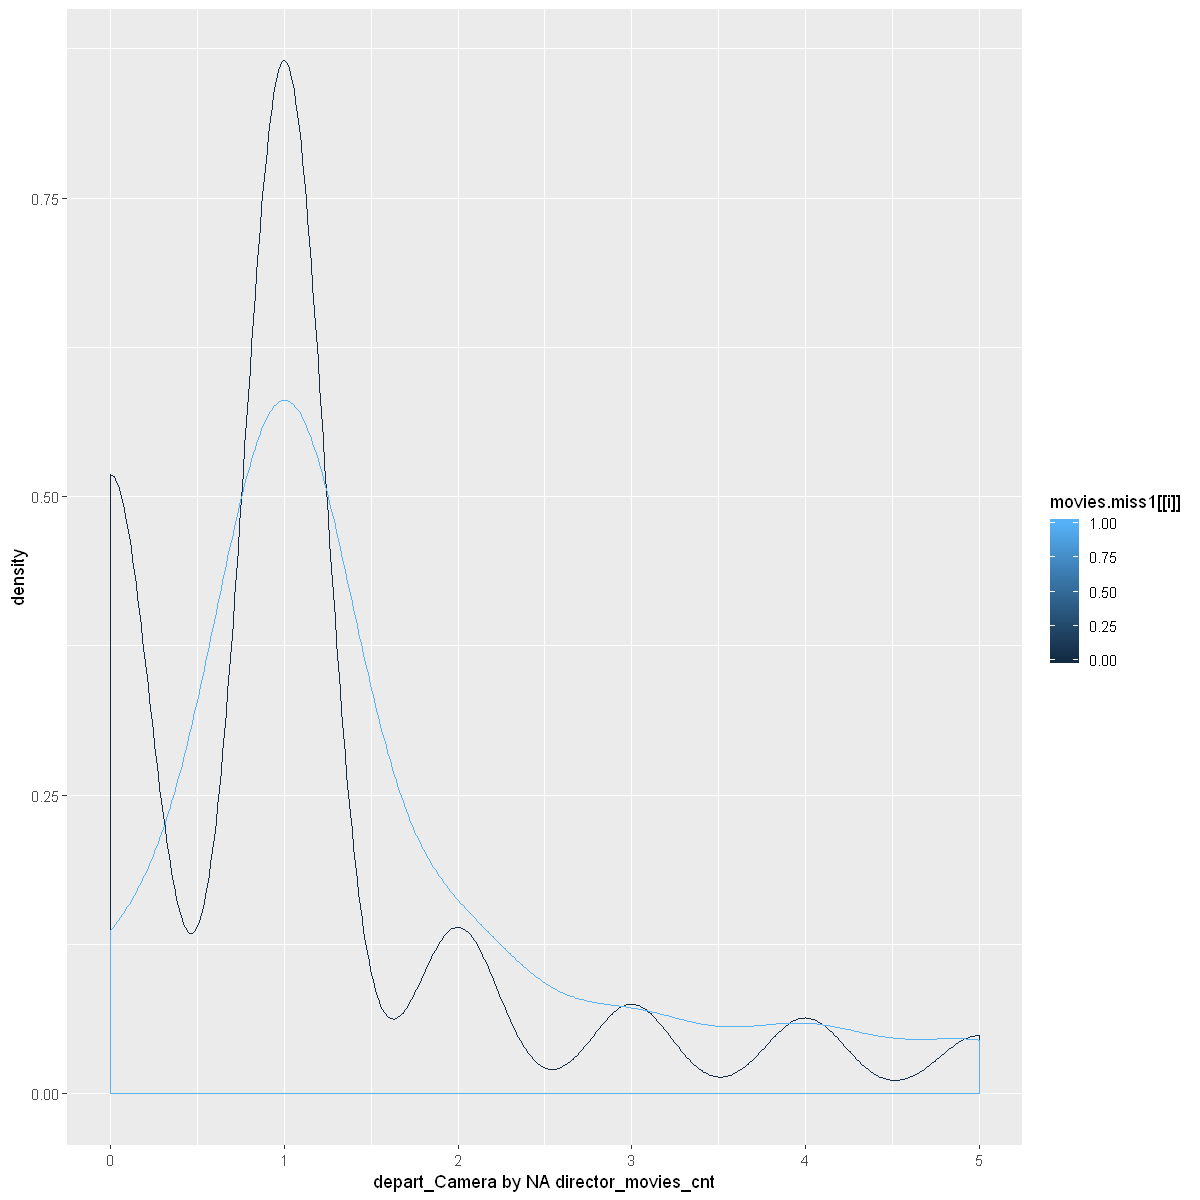


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -5.3698, df = 320.92, p-value = 1.516e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6360284 -0.2949386
sample estimates:
mean of x mean of y 
0.8555867 1.3210702 

[1] "depart_Custom_Mkup by NA director_movies_cnt"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


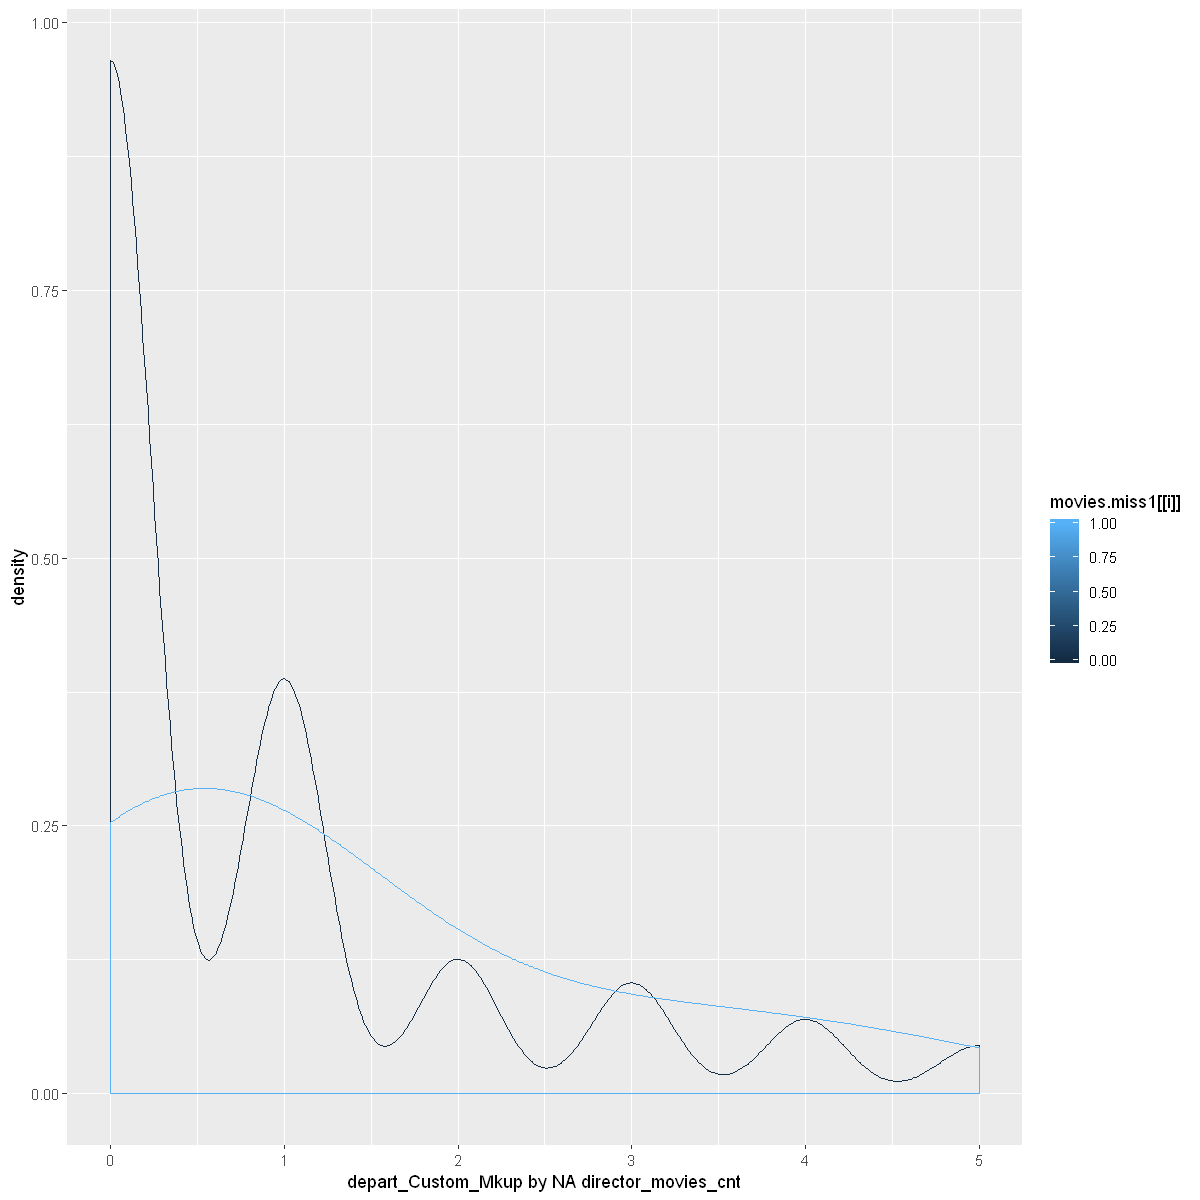


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -5.7105, df = 408.35, p-value = 2.172e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2985480 -0.1456395
sample estimates:
mean of x mean of y 
 1.400247  1.622340 

[1] "depart_Directing by NA director_movies_cnt"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


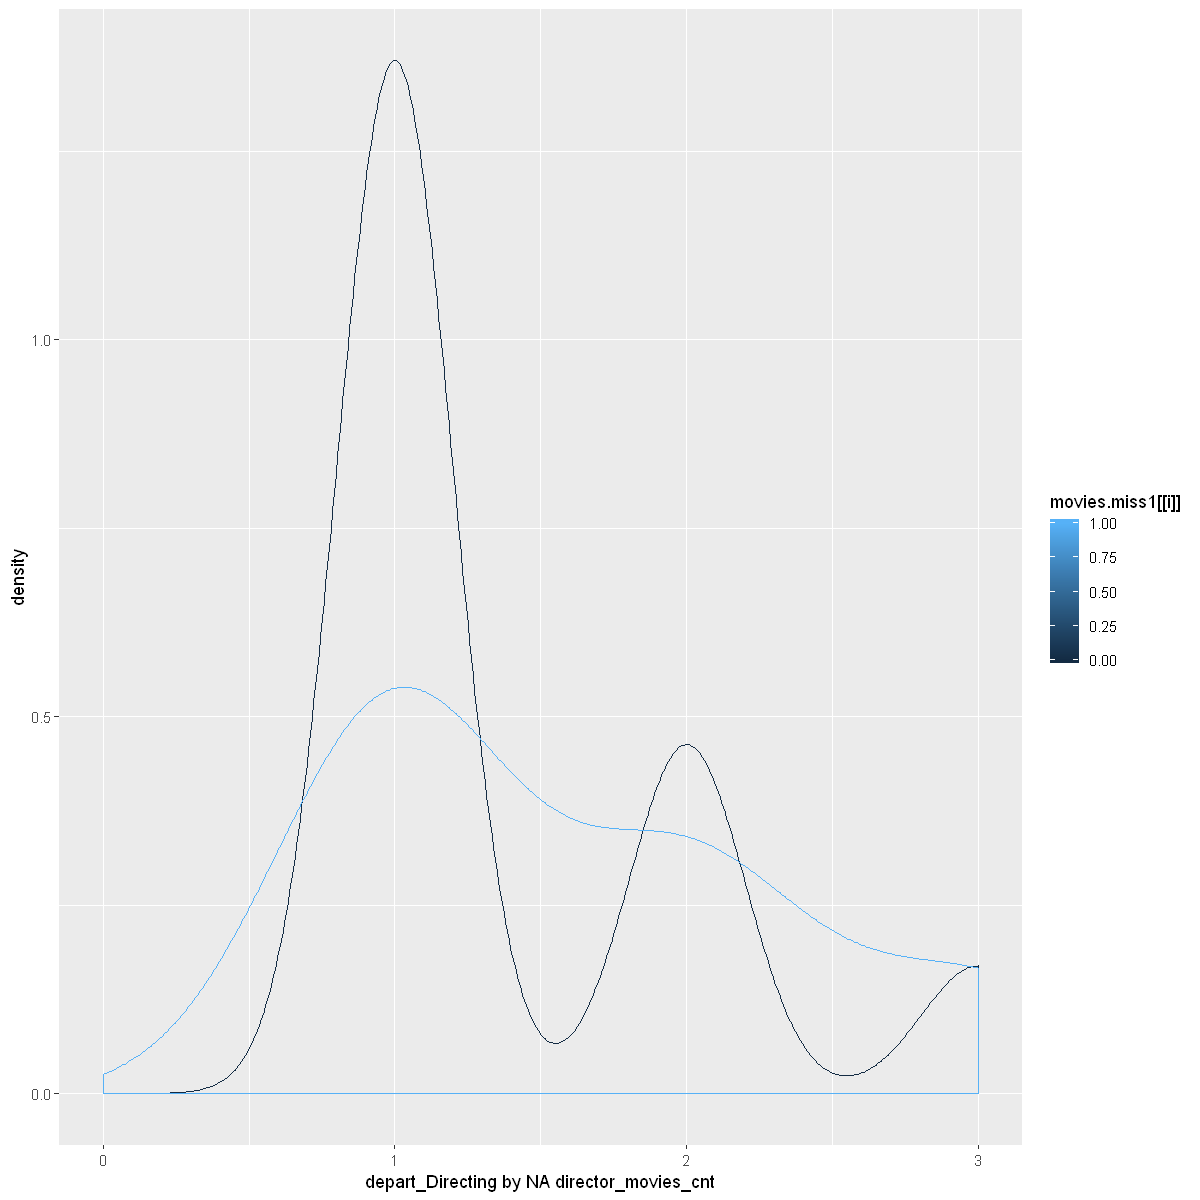


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -4.8414, df = 313.61, p-value = 2.028e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6444680 -0.2720076
sample estimates:
mean of x mean of y 
 1.241421  1.699659 

[1] "depart_Sound by NA director_movies_cnt"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


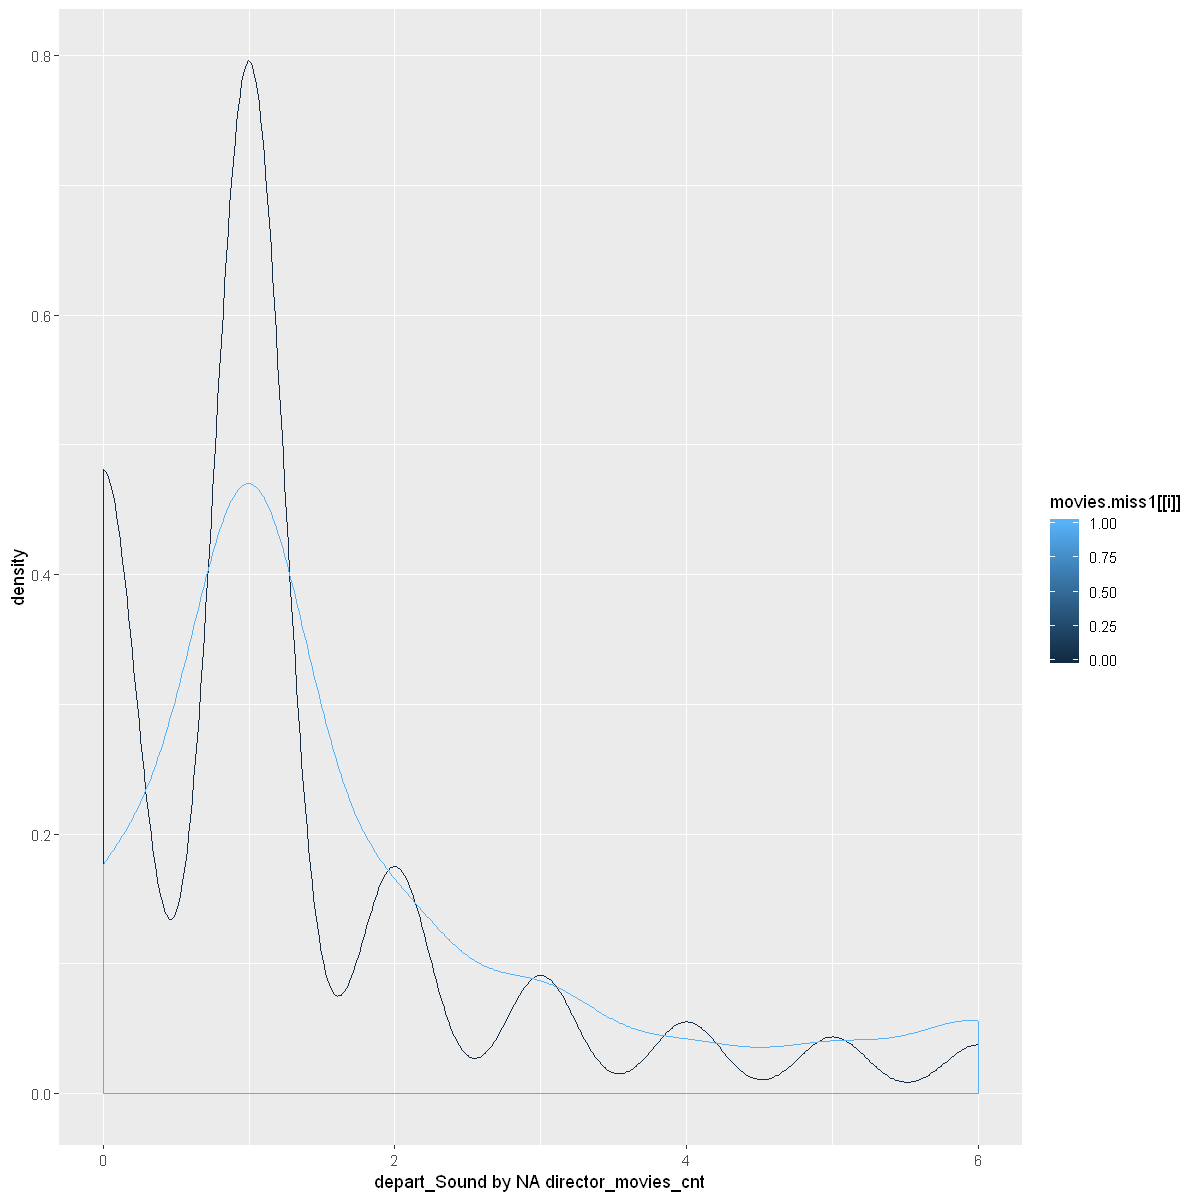


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -20.229, df = 576.97, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -25507192 -20992460
sample estimates:
mean of x mean of y 
 19798720  43048546 

[1] "budget by NA depart_Art"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


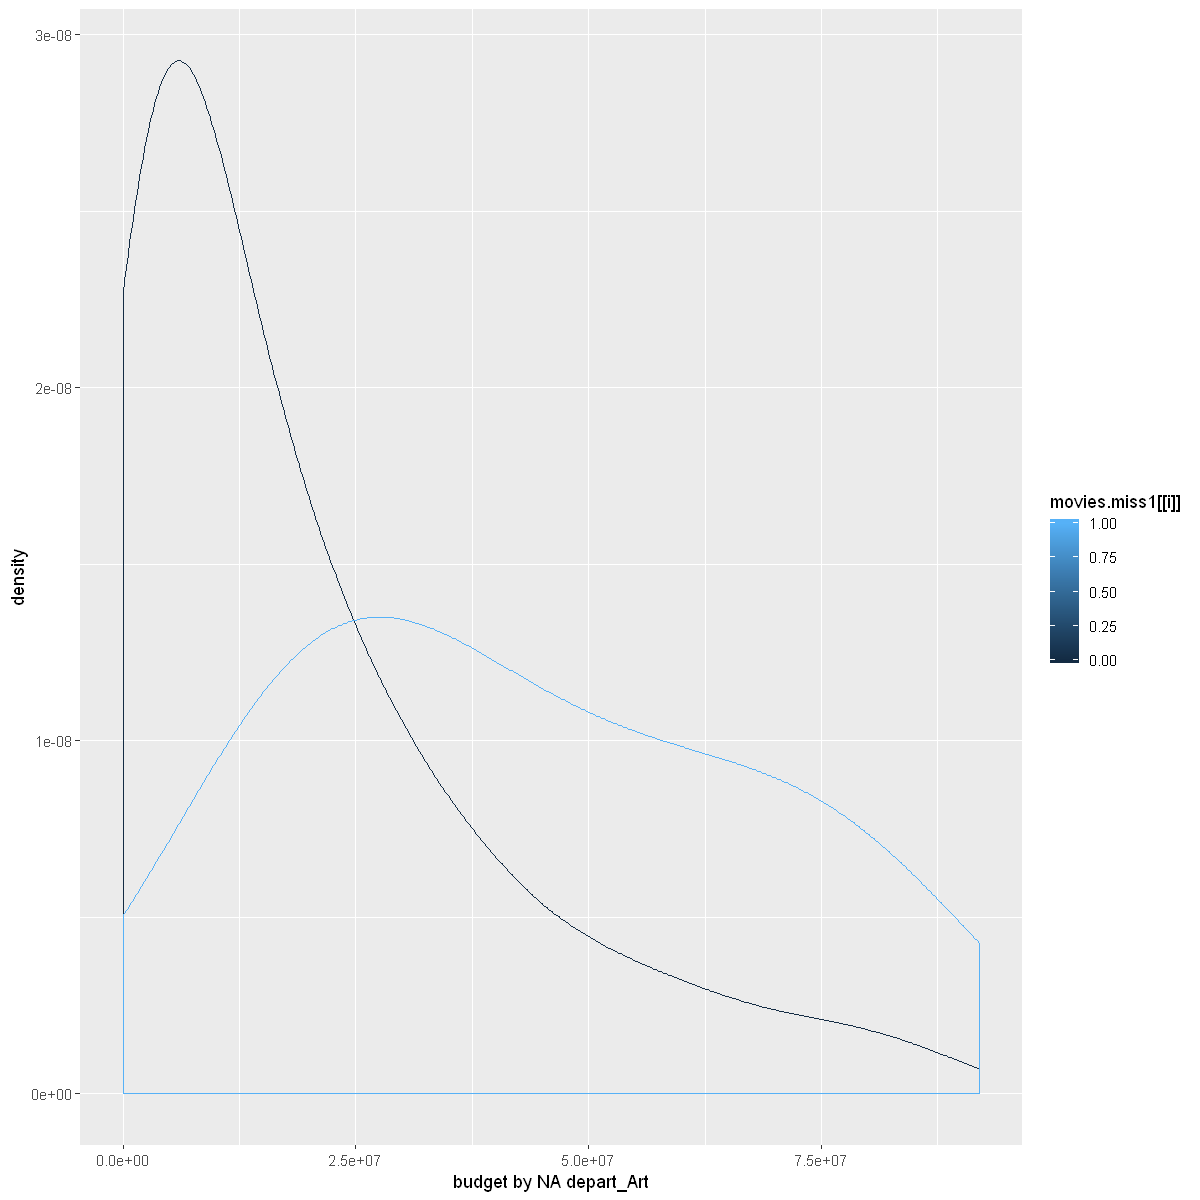


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -15.021, df = 880.07, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.461425 -1.123648
sample estimates:
mean of x mean of y 
 2.773853  4.066390 

[1] "producers_cnt by NA depart_Art"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


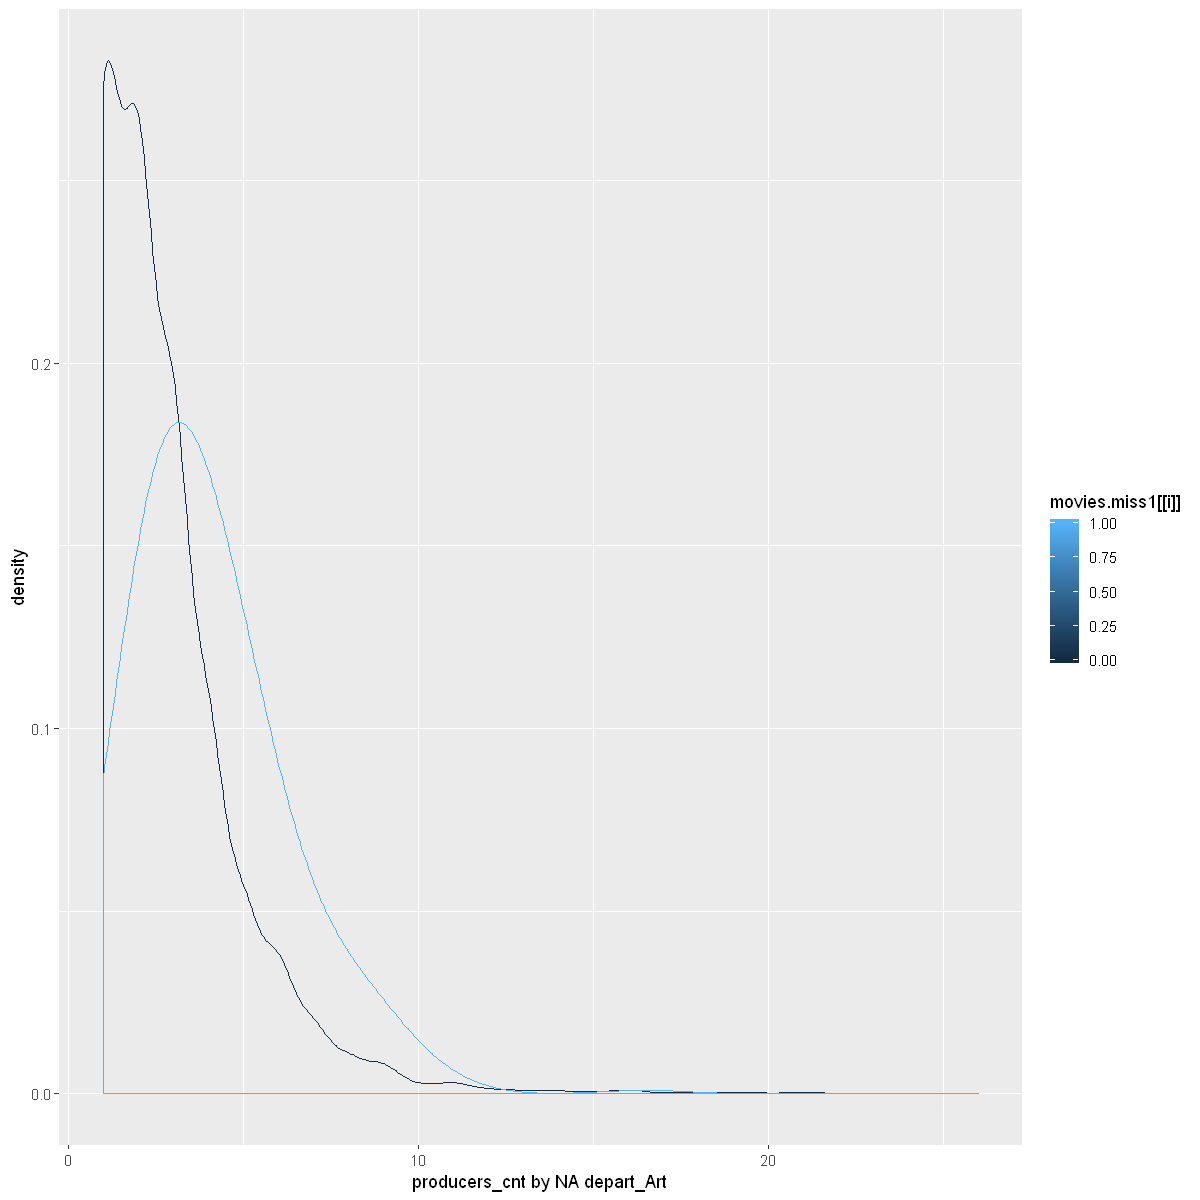


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -9.7365, df = 769.33, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.663894 -1.769949
sample estimates:
mean of x mean of y 
 3.855806  6.072727 

[1] "actor1_movies_cnt by NA depart_Art"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


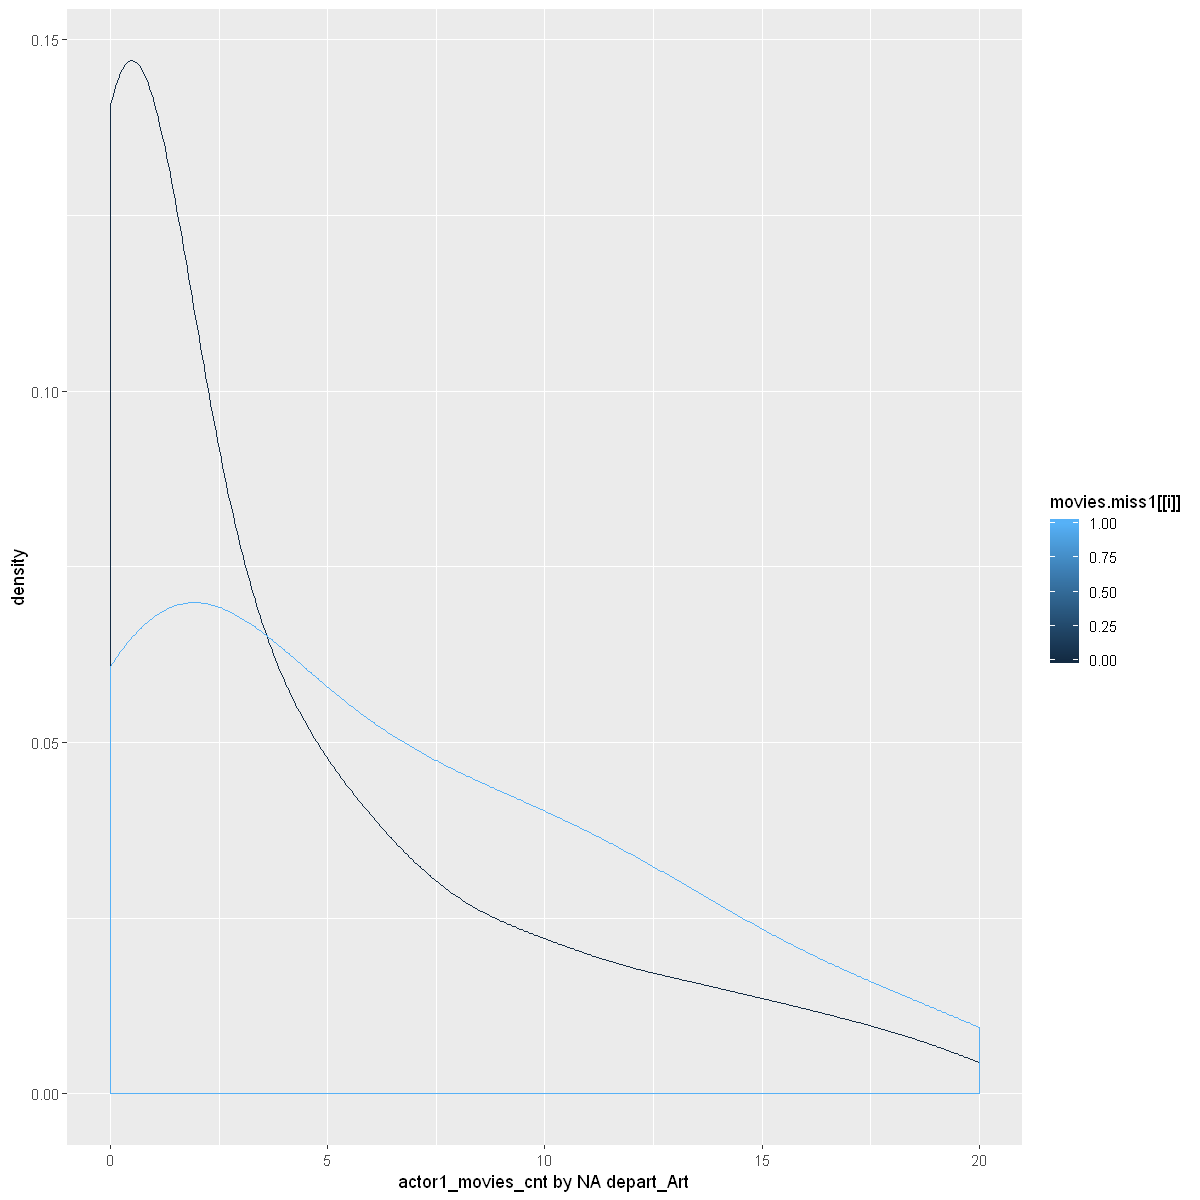


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.7996, df = 711.79, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.200874 -1.397934
sample estimates:
mean of x mean of y 
 3.126641  4.926045 

[1] "actor2_movies_cnt by NA depart_Art"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


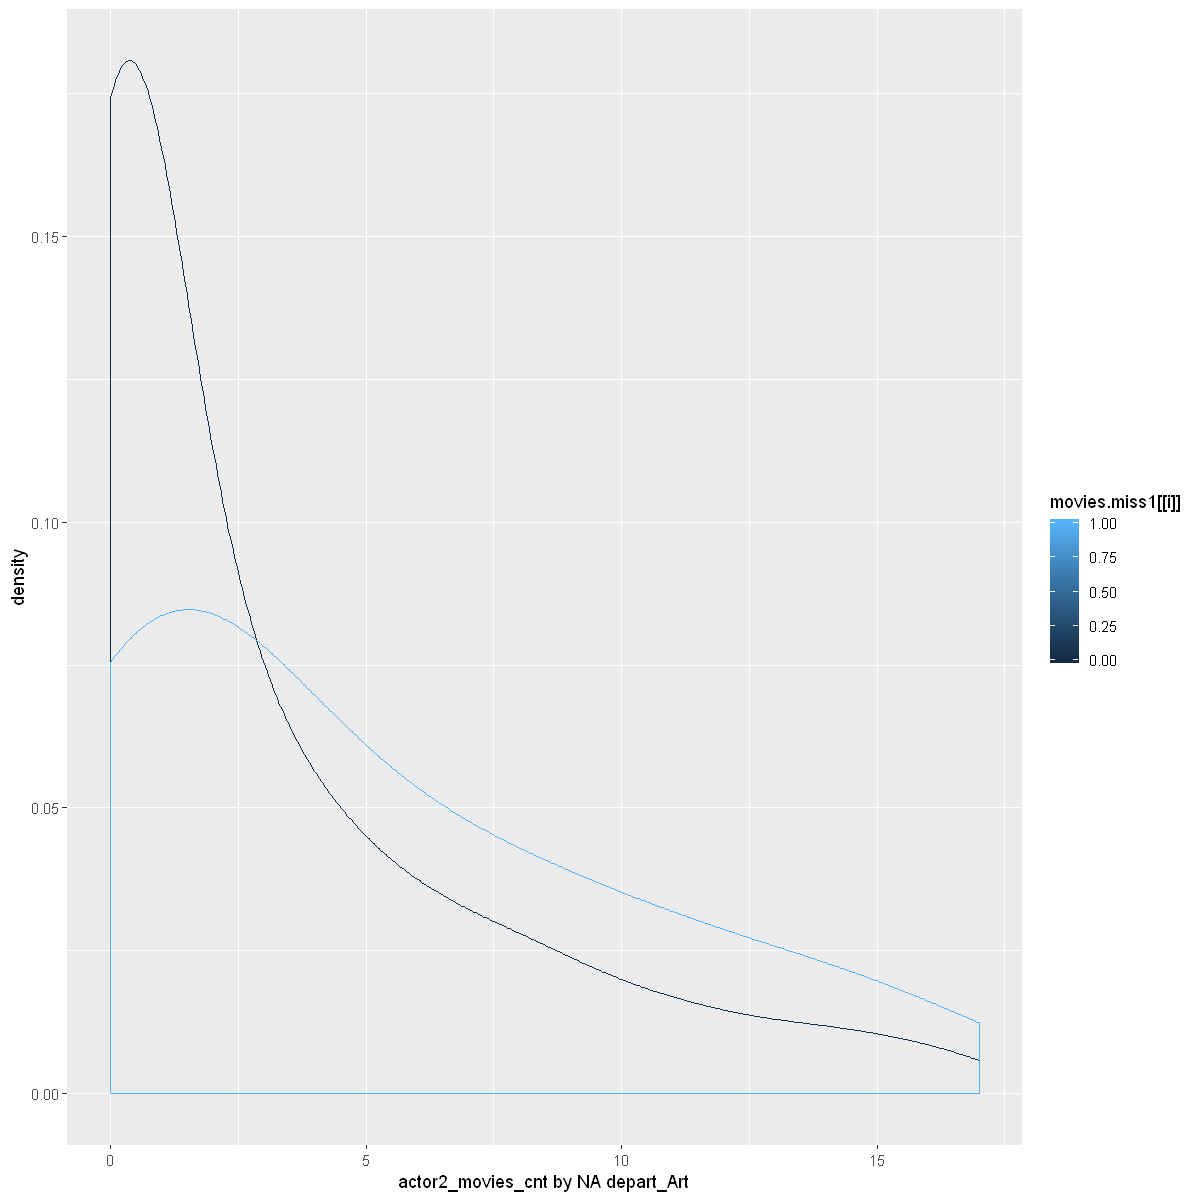


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.5218, df = 598.04, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -83967587 -52514046
sample estimates:
mean of x mean of y 
167246278 235487094 

[1] "actor0_prev_revenue by NA depart_Art"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


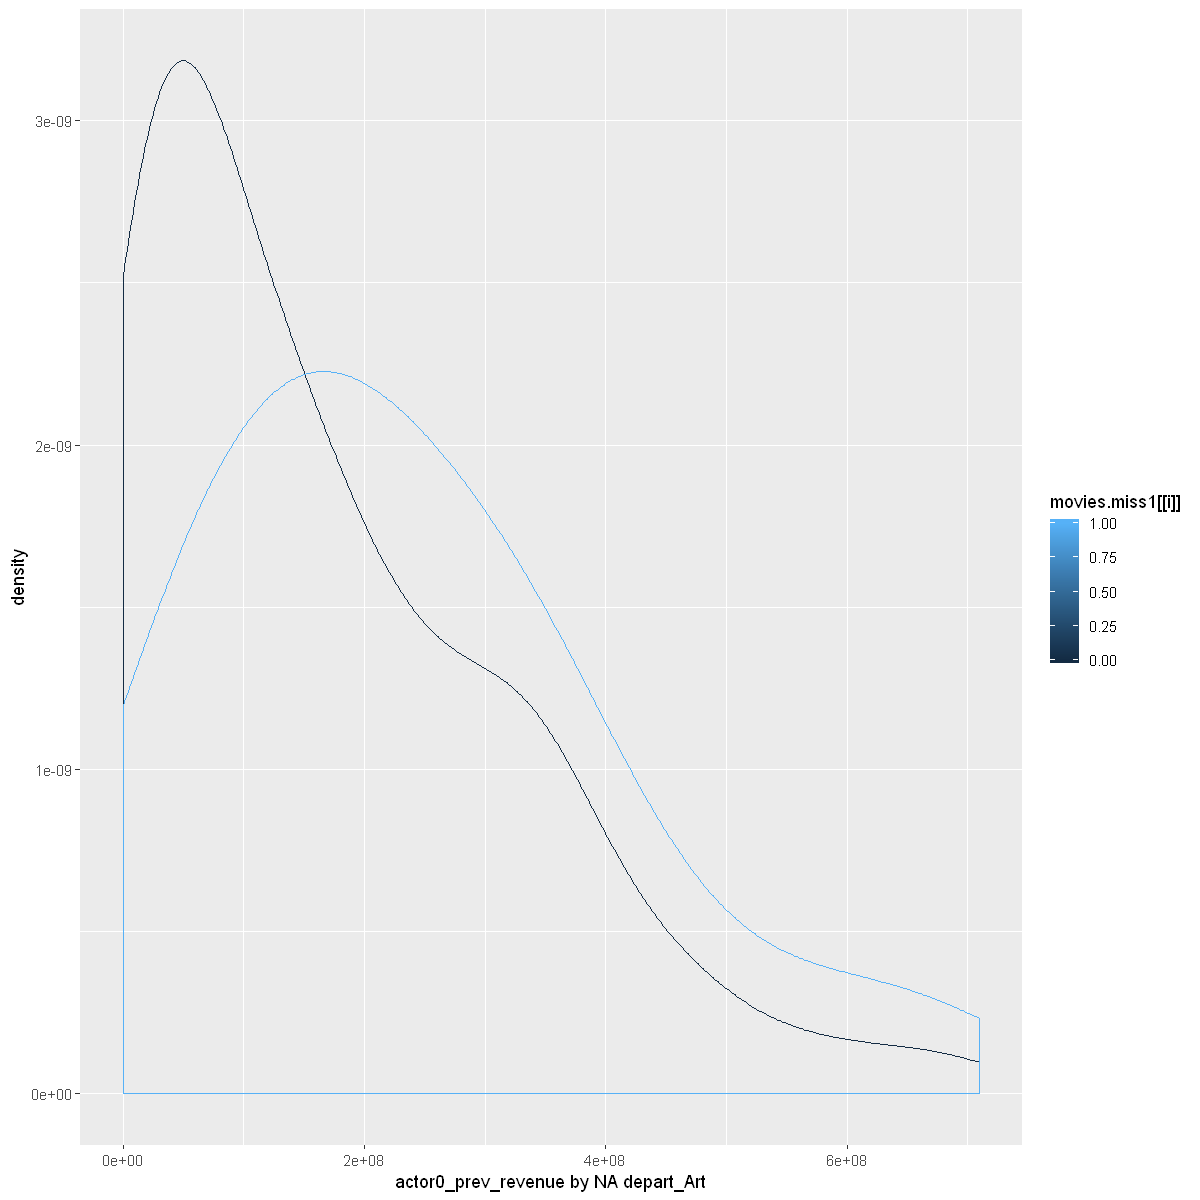


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -5.4458, df = 578.16, p-value = 7.636e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -50758469 -23850237
sample estimates:
mean of x mean of y 
140728967 178033319 

[1] "actor1_prev_revenue by NA depart_Art"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


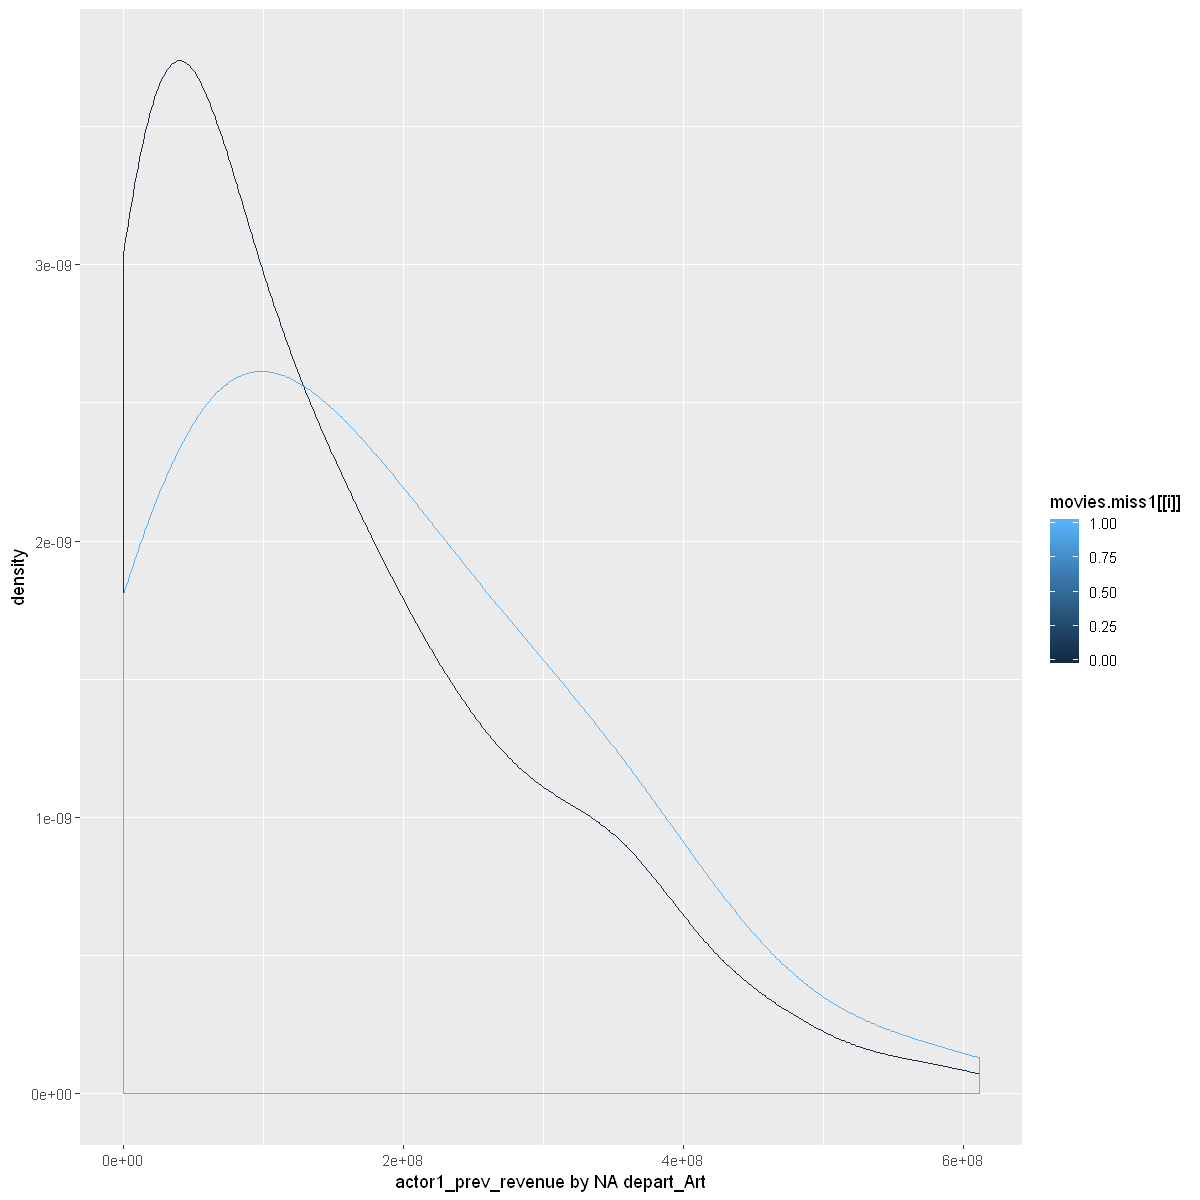


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -5.5546, df = 540.99, p-value = 4.369e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -51562775 -24620861
sample estimates:
mean of x mean of y 
129234013 167325831 

[1] "actor2_prev_revenue by NA depart_Art"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


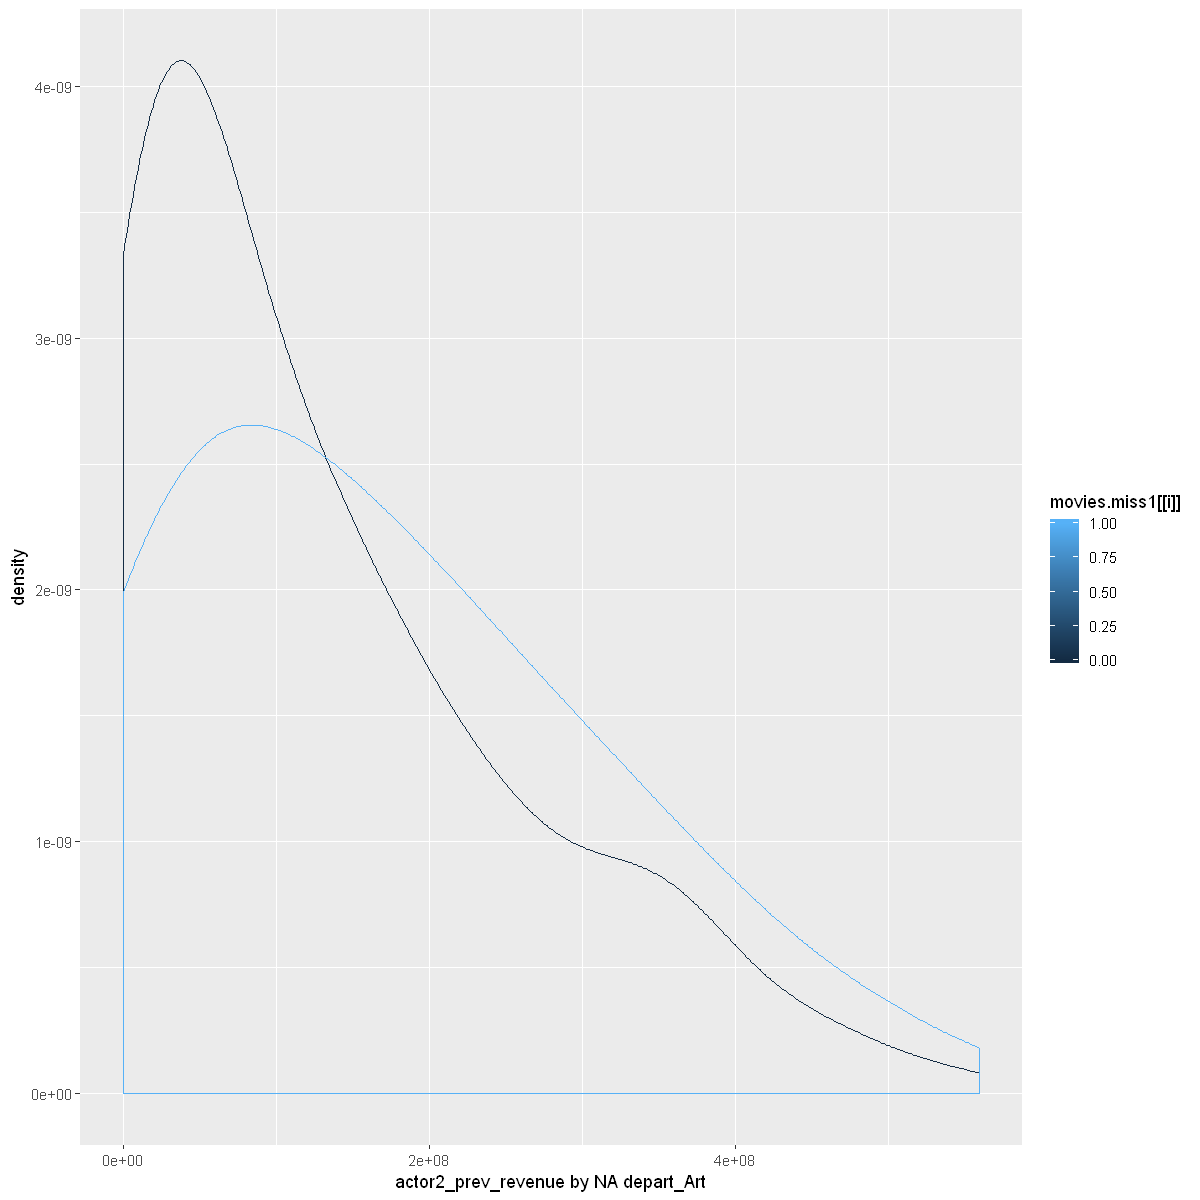


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -11.736, df = 709.07, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1966512 -0.8536639
sample estimates:
mean of x mean of y 
 1.261701  2.286859 

[1] "director_movies_cnt by NA depart_Art"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


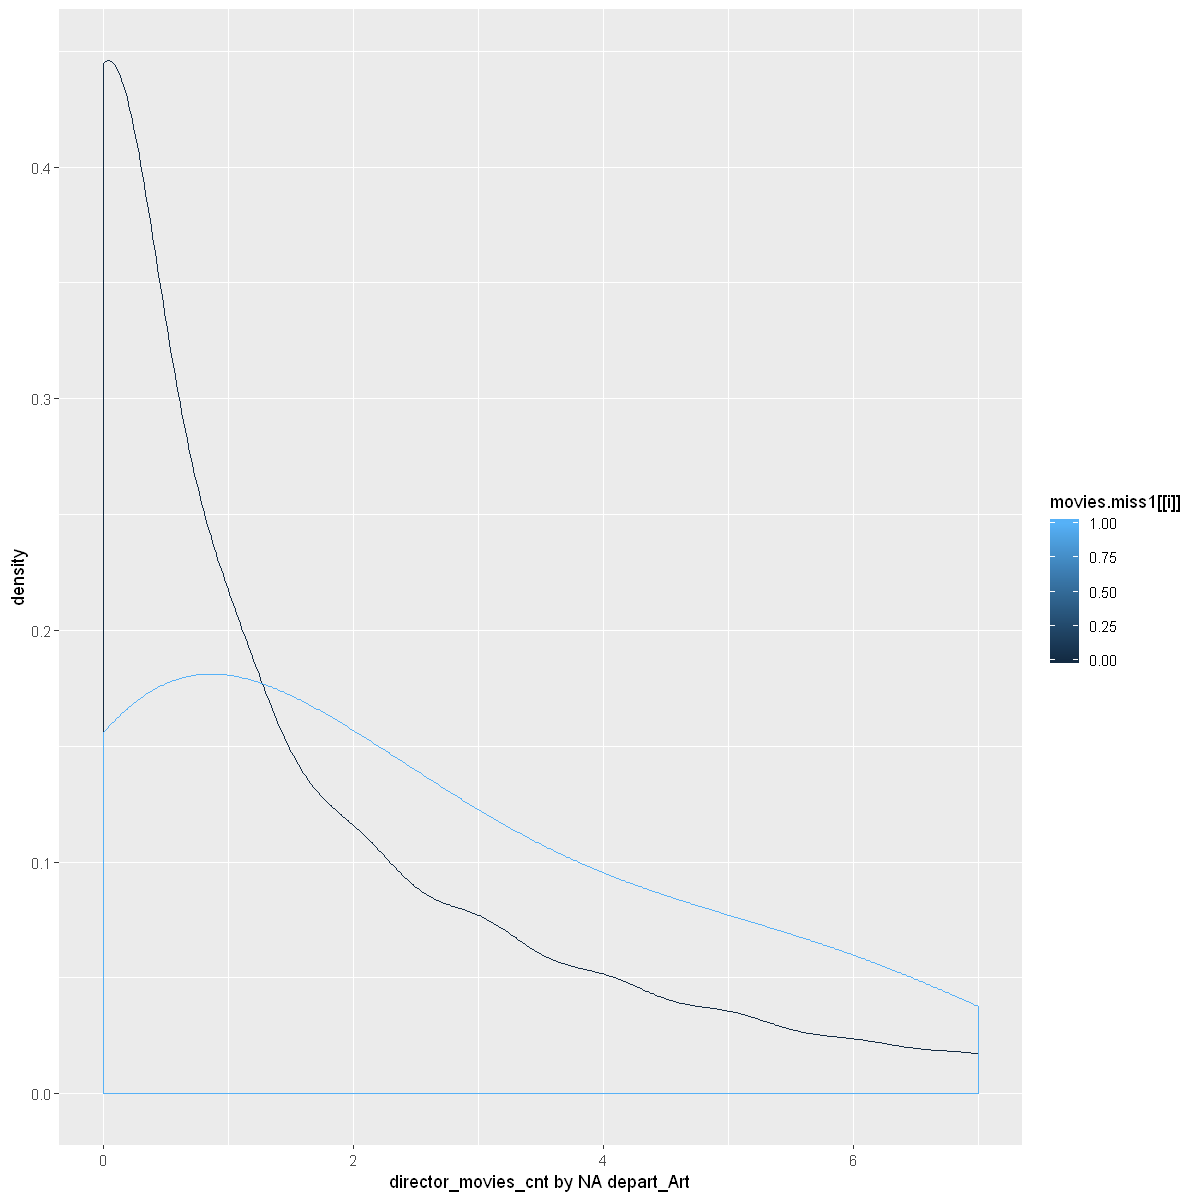


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -19.183, df = 242.51, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.270000 -1.847215
sample estimates:
mean of x mean of y 
 1.038850  3.097458 

[1] "depart_Camera by NA depart_Art"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


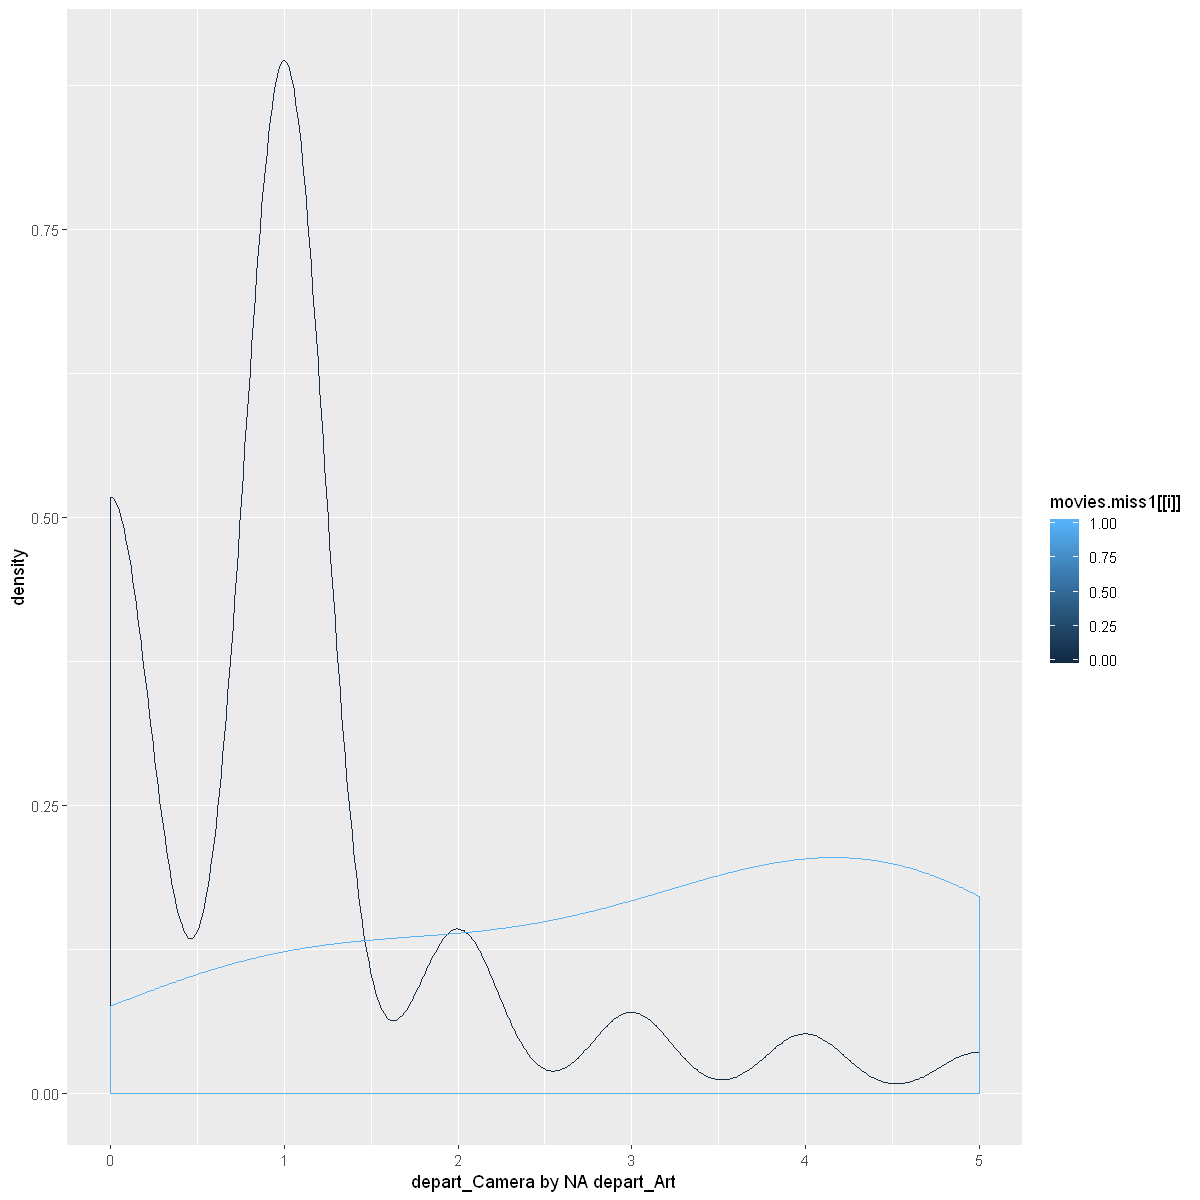


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -15.727, df = 160.59, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.339279 -1.817324
sample estimates:
mean of x mean of y 
0.8261571 2.9044586 

[1] "depart_Custom_Mkup by NA depart_Art"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


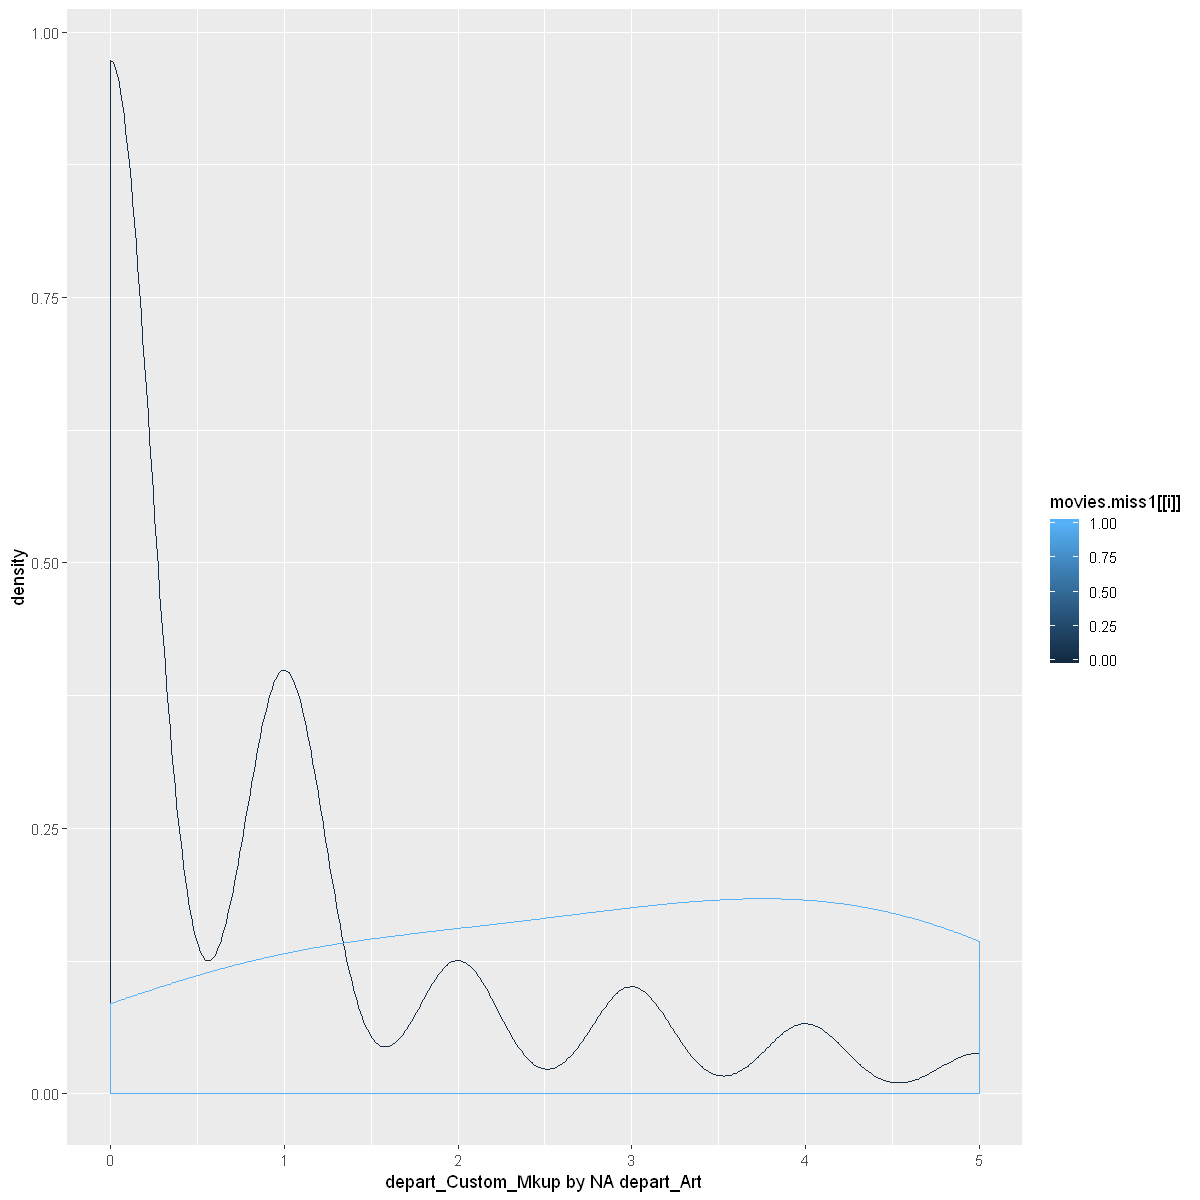


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -30.284, df = 507.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0751100 -0.9441136
sample estimates:
mean of x mean of y 
 1.344736  2.354348 

[1] "depart_Directing by NA depart_Art"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


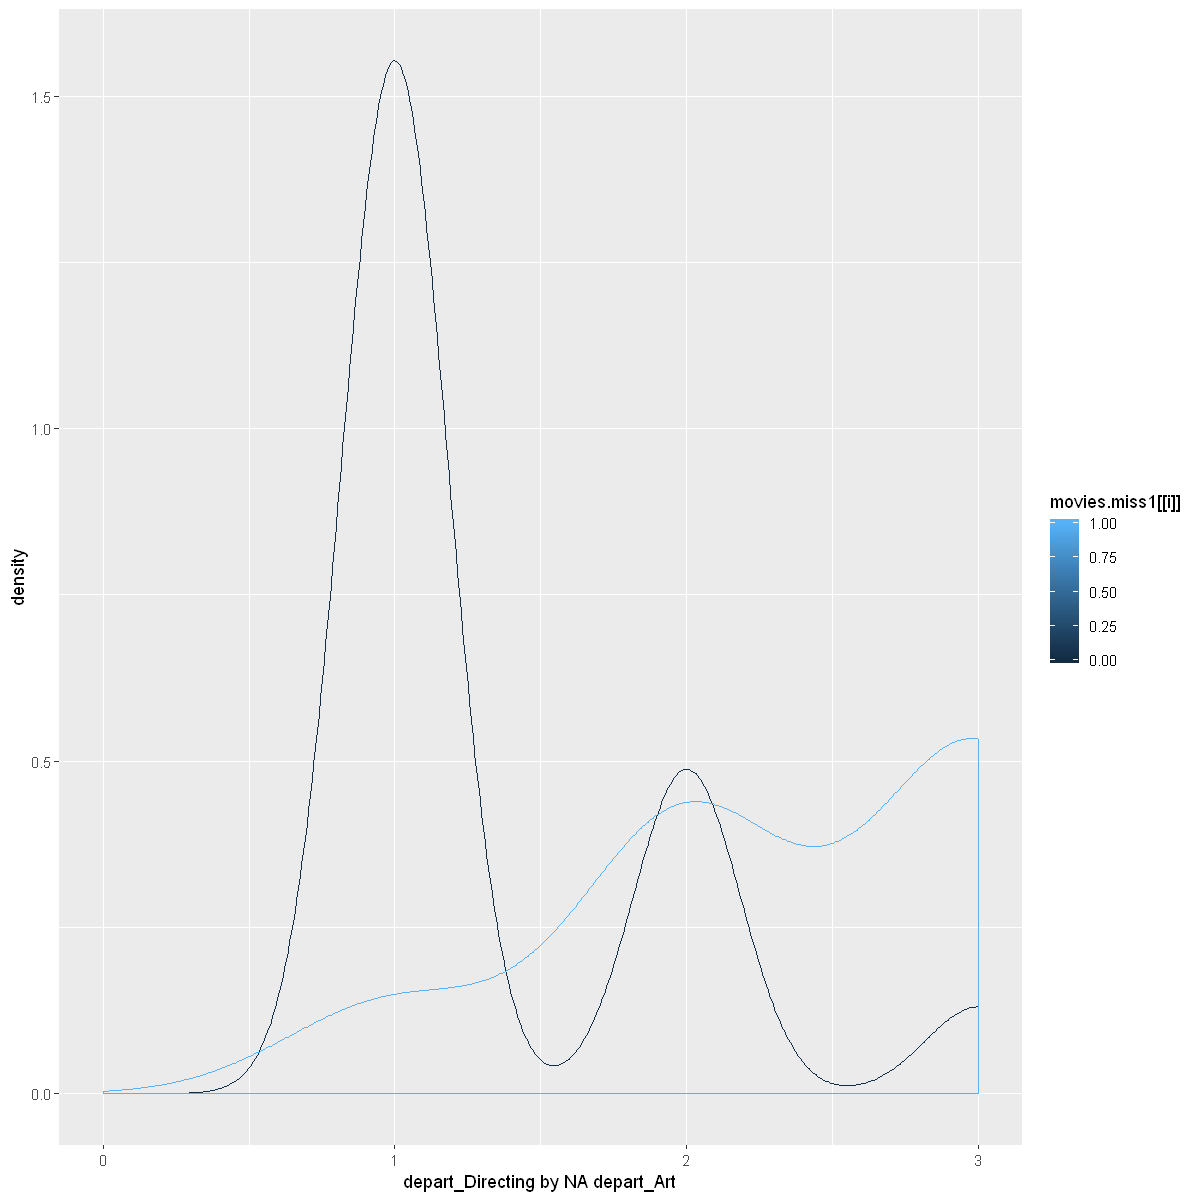


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -9.6418, df = 101.64, p-value = 5.218e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.226203 -1.466514
sample estimates:
mean of x mean of y 
 1.232849  3.079208 

[1] "depart_Sound by NA depart_Art"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


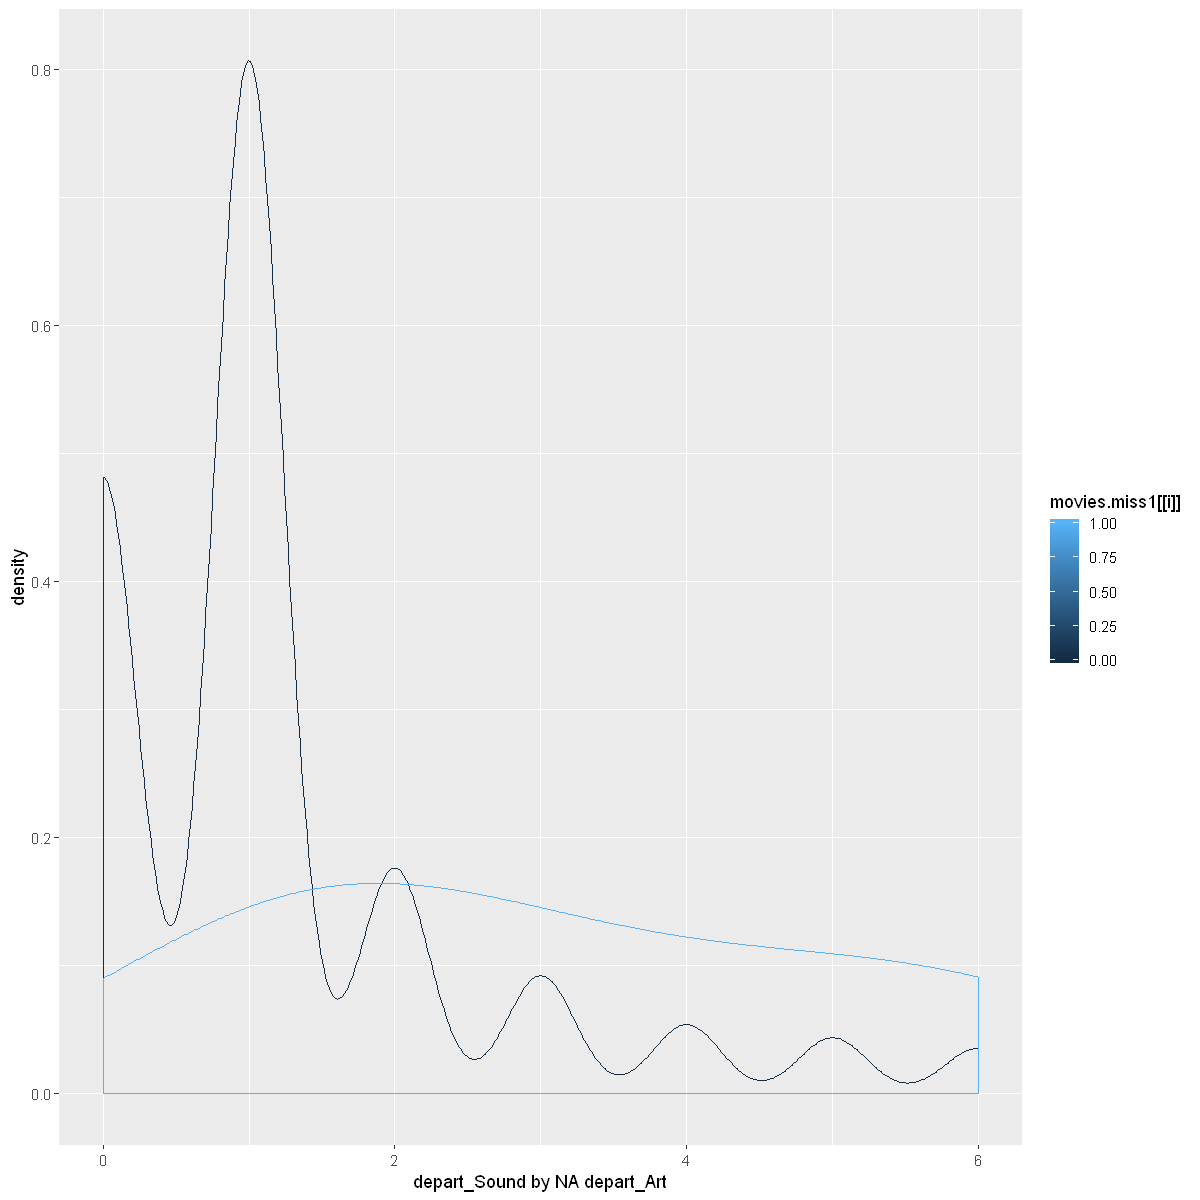


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -15.864, df = 577.28, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -21089904 -16443172
sample estimates:
mean of x mean of y 
 20242292  39008830 

[1] "budget by NA depart_Camera"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


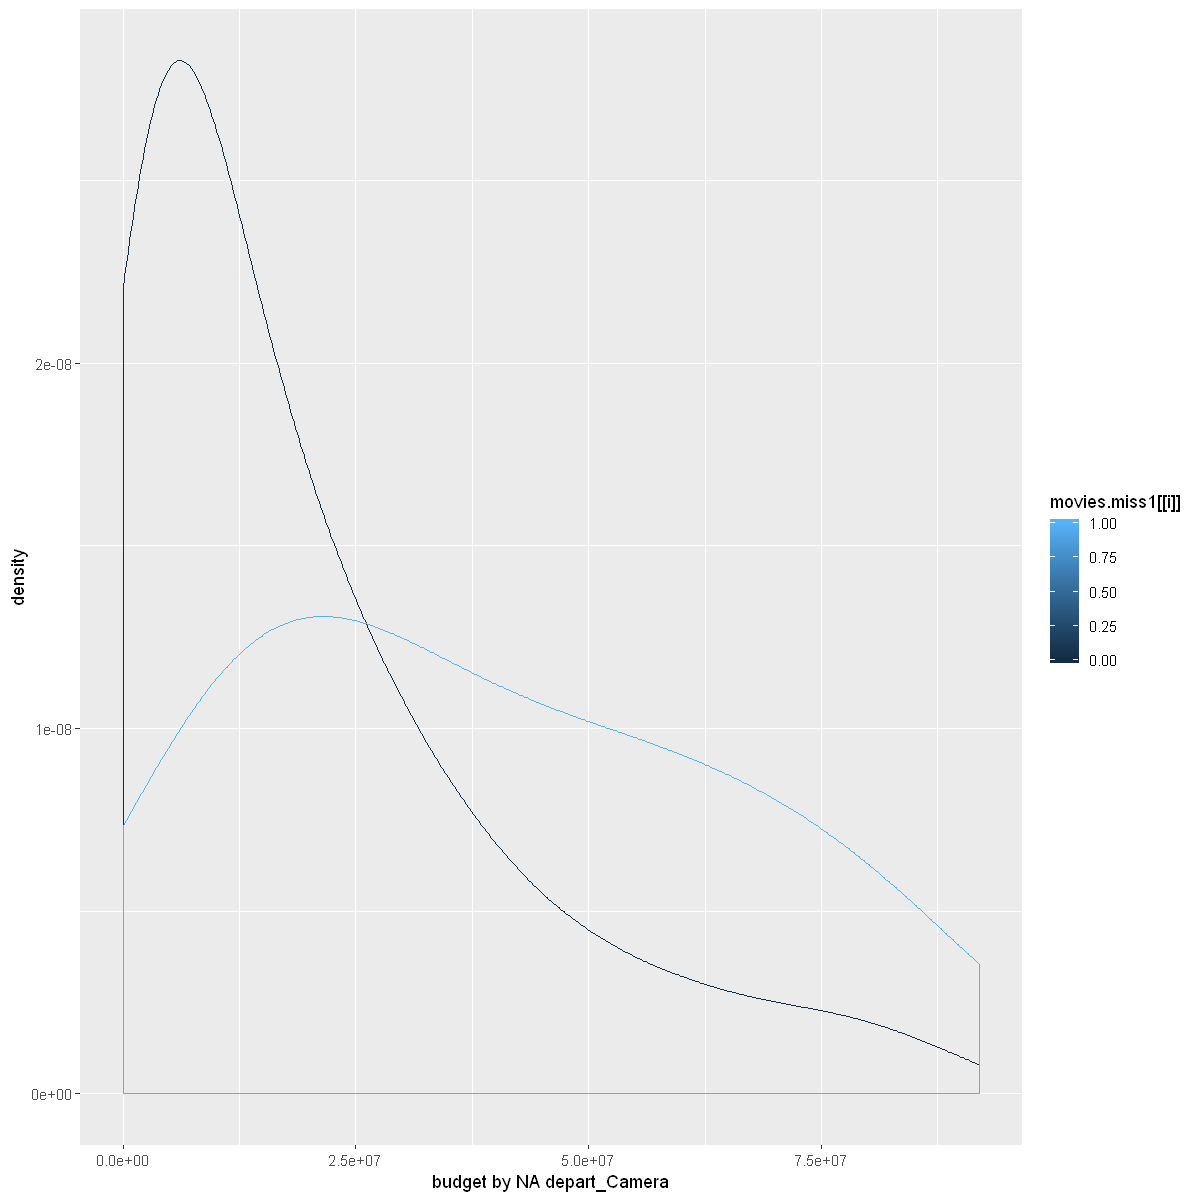


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -15.866, df = 827.28, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.630178 -1.271229
sample estimates:
mean of x mean of y 
 2.762458  4.213162 

[1] "producers_cnt by NA depart_Camera"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


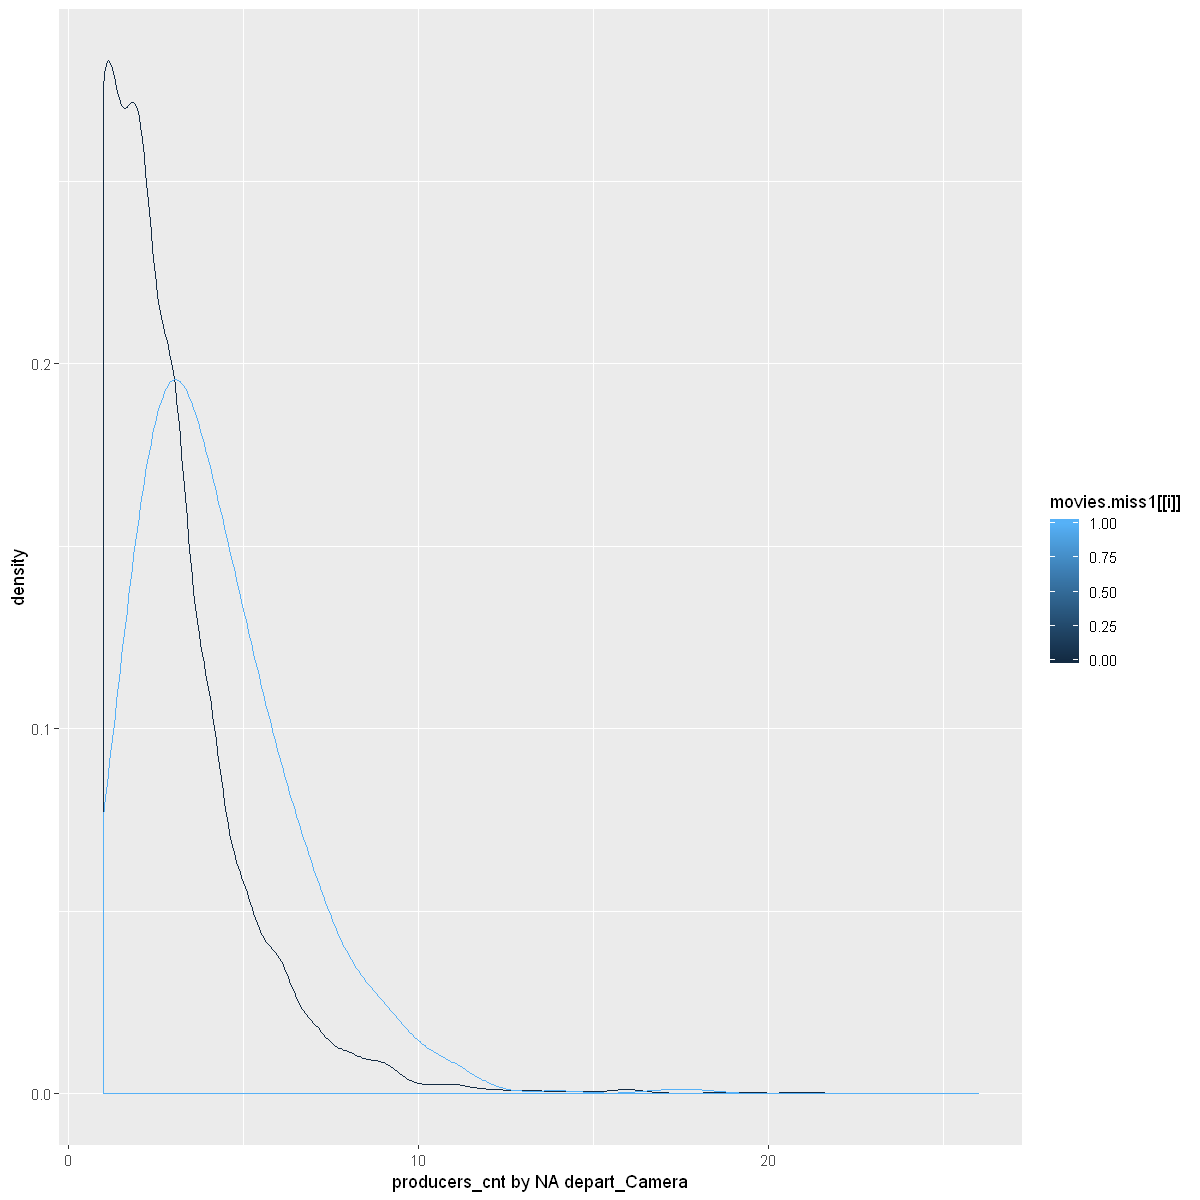


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.789, df = 734.56, p-value = 2.305e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.297595 -1.372541
sample estimates:
mean of x mean of y 
 3.898056  5.733124 

[1] "actor1_movies_cnt by NA depart_Camera"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


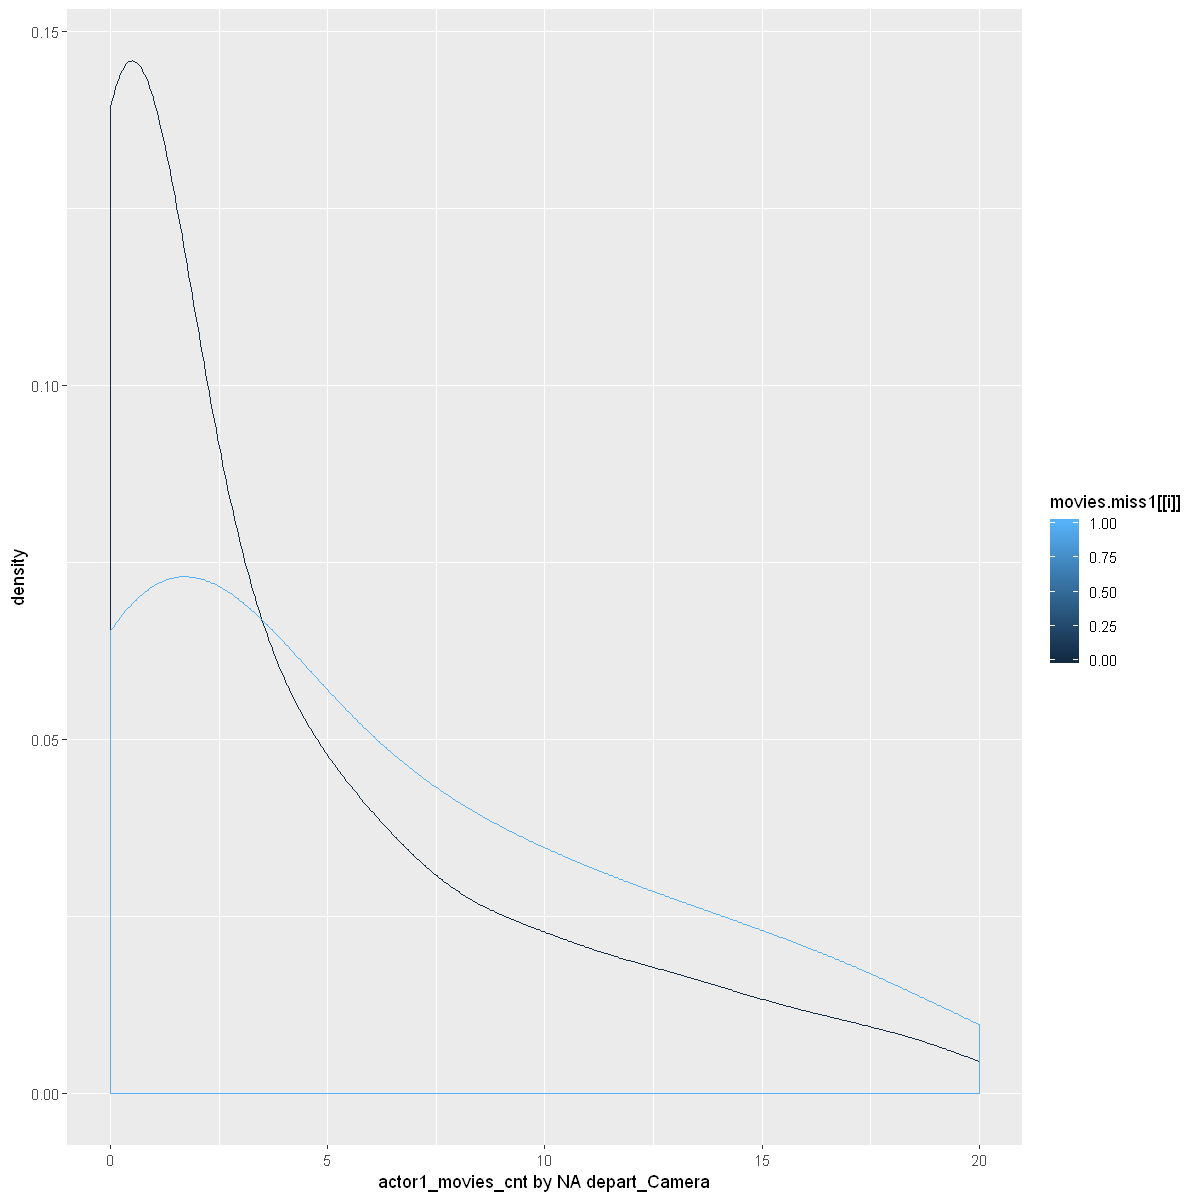


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.4651, df = 696.5, p-value = 2.492e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.917748 -1.119050
sample estimates:
mean of x mean of y 
 3.155406  4.673806 

[1] "actor2_movies_cnt by NA depart_Camera"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


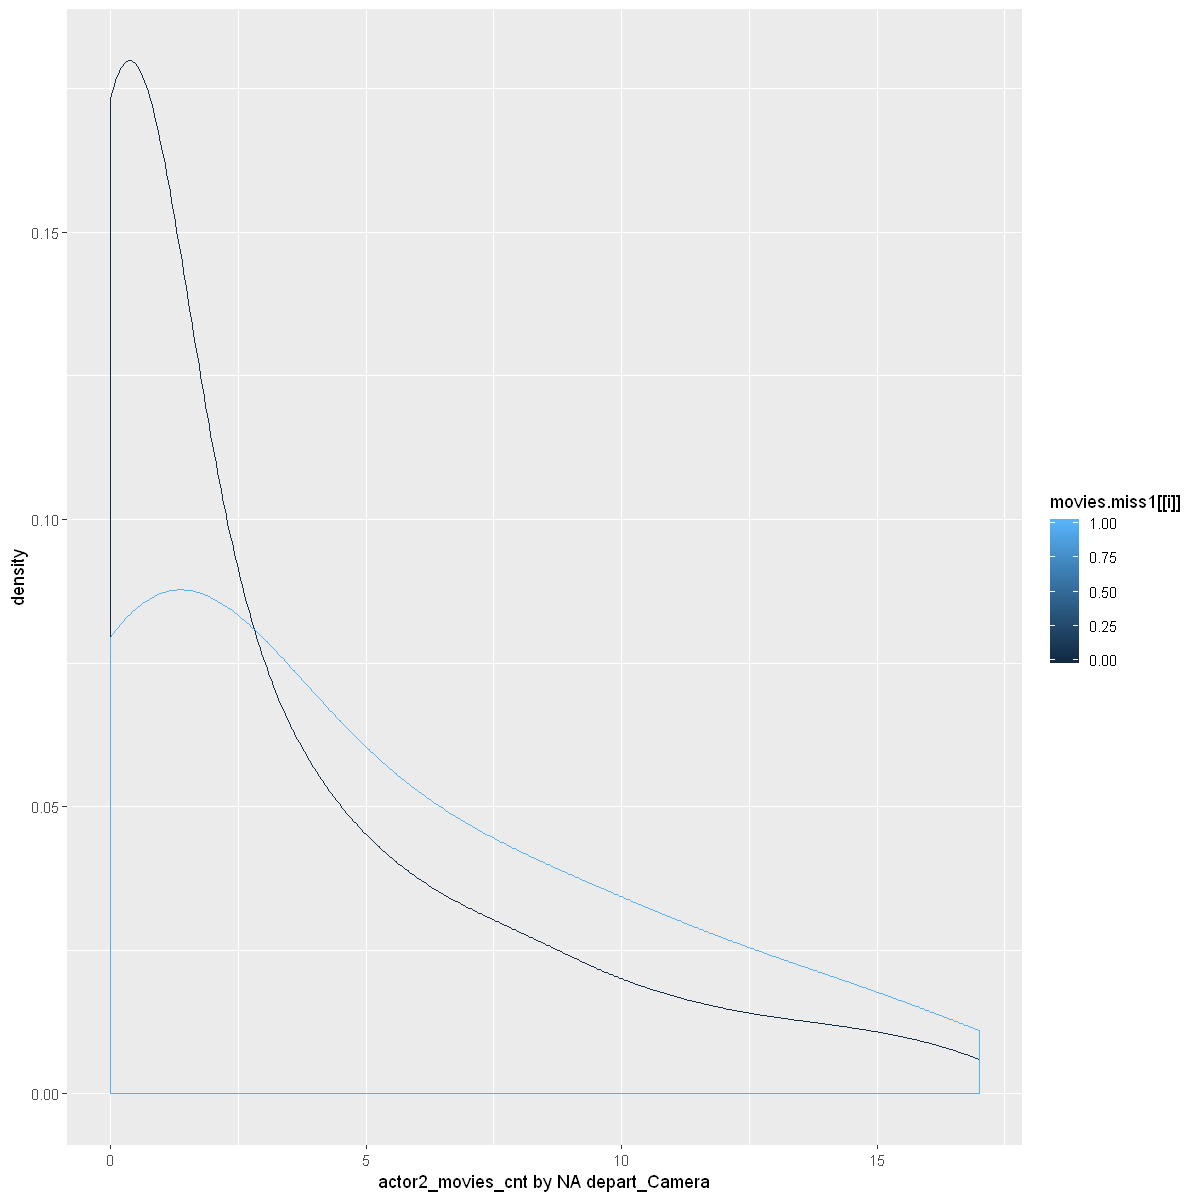


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.8227, df = 571.38, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -90202420 -57353339
sample estimates:
mean of x mean of y 
166826589 240604469 

[1] "actor0_prev_revenue by NA depart_Camera"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


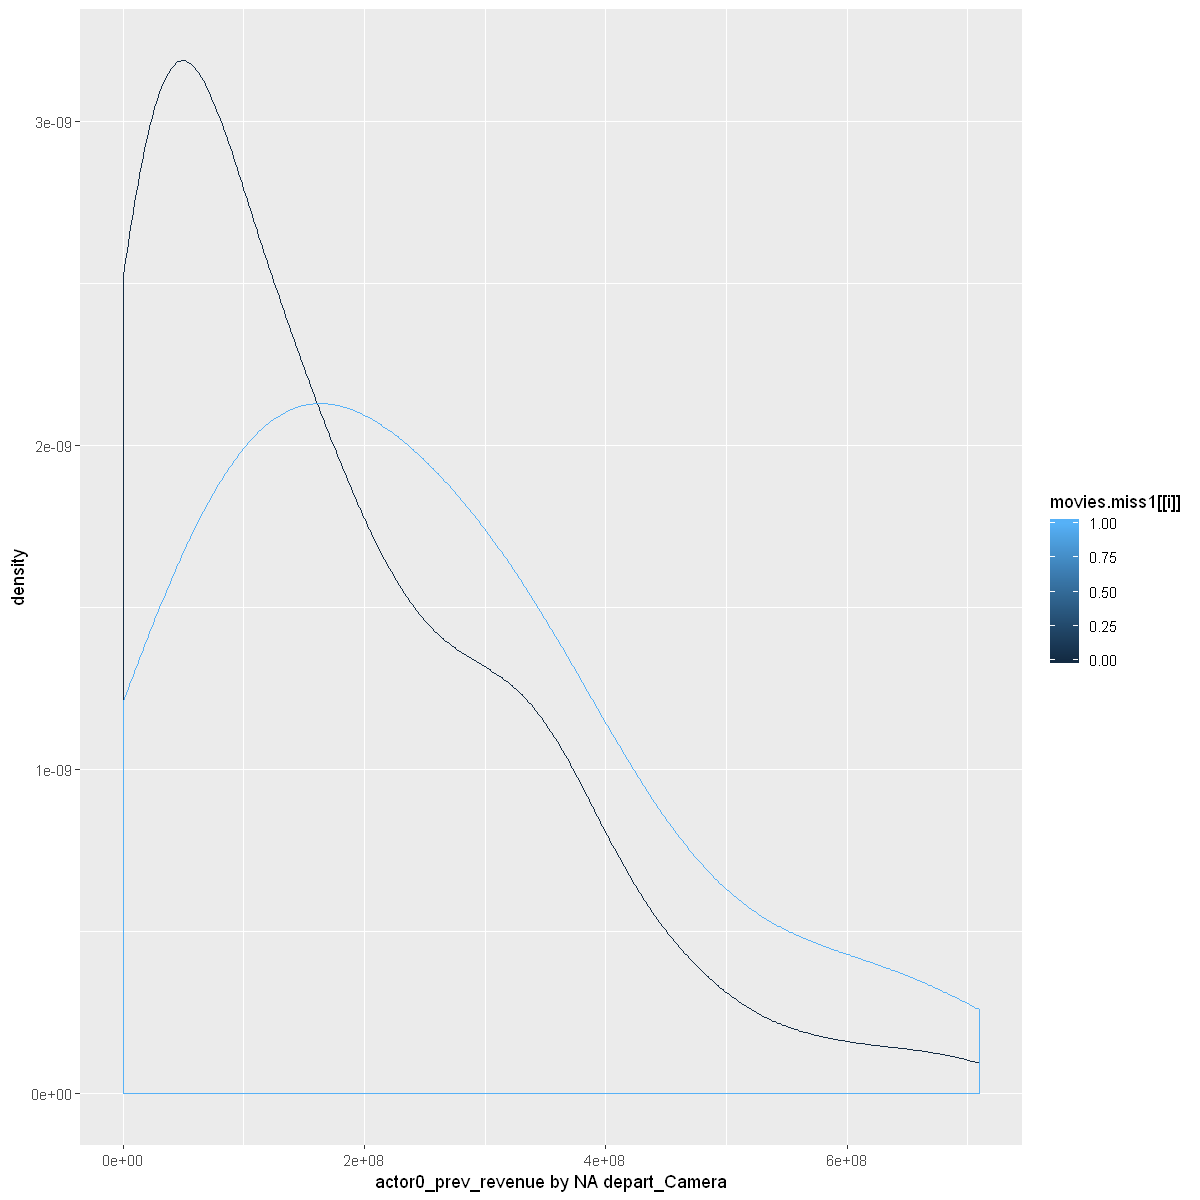


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -5.6897, df = 527.25, p-value = 2.112e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -53455205 -26016375
sample estimates:
mean of x mean of y 
140810687 180546477 

[1] "actor1_prev_revenue by NA depart_Camera"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


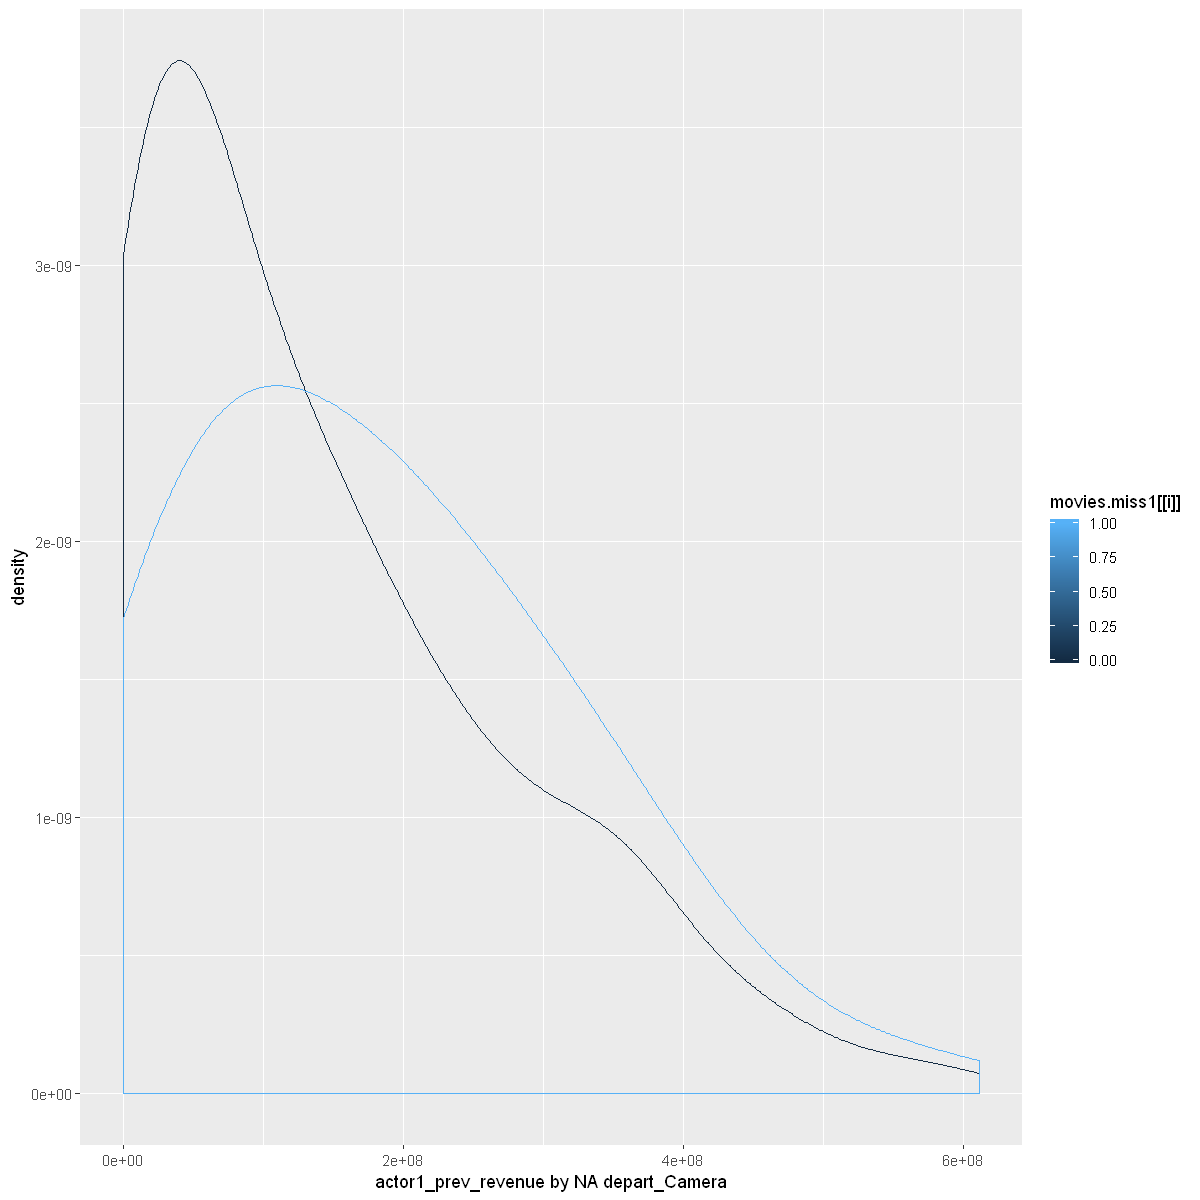


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -4.2765, df = 504.83, p-value = 2.271e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -43540608 -16128136
sample estimates:
mean of x mean of y 
130440222 160274594 

[1] "actor2_prev_revenue by NA depart_Camera"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


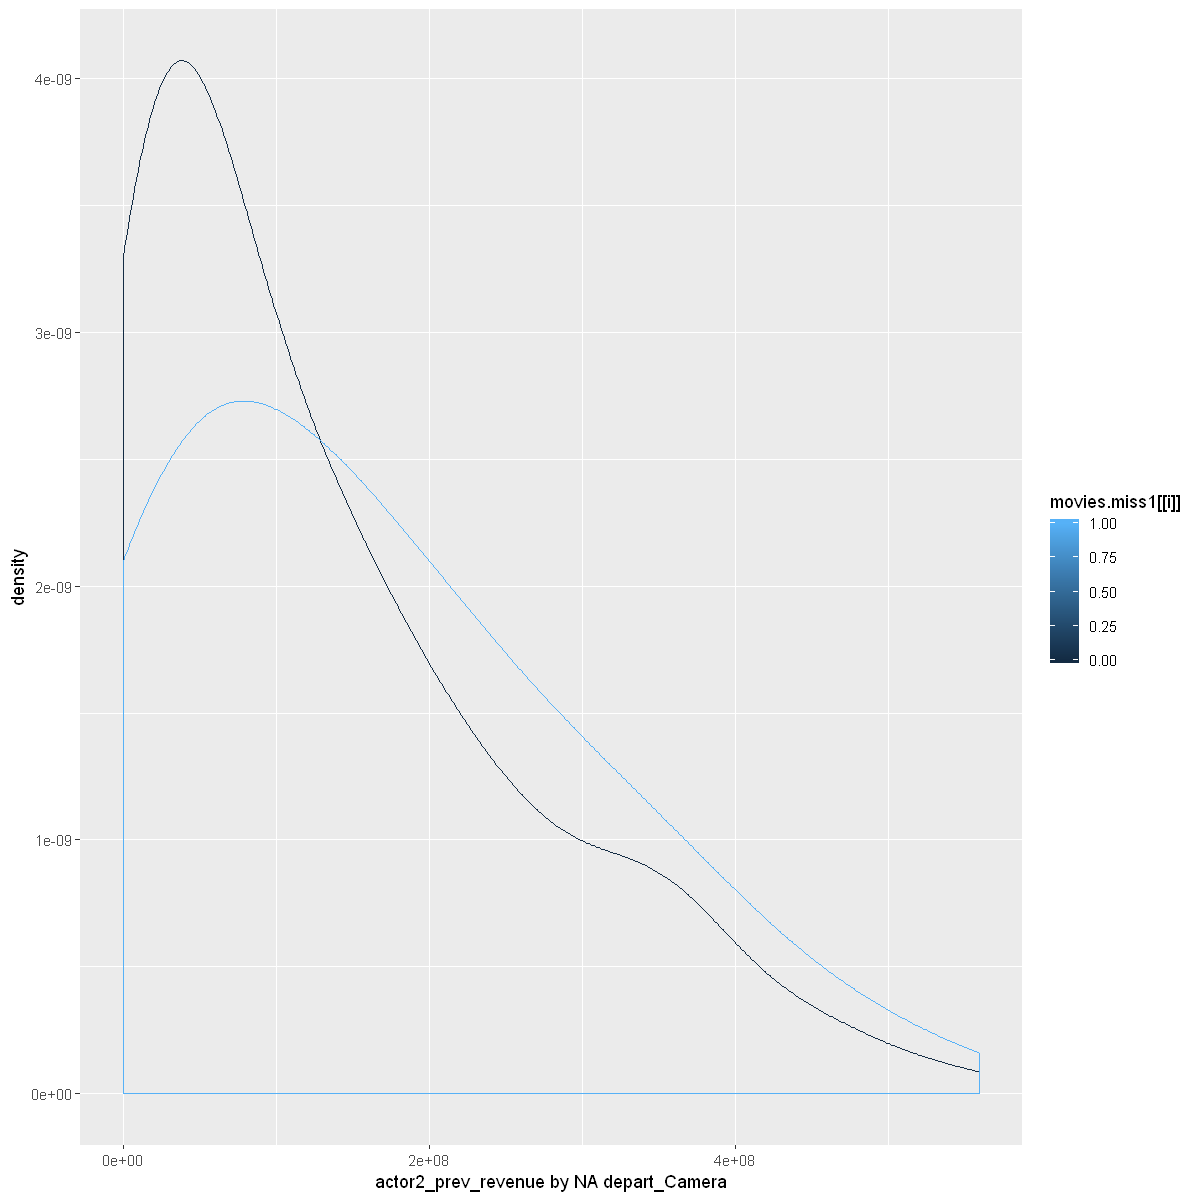


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.209, df = 698.68, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0850247 -0.7350155
sample estimates:
mean of x mean of y 
 1.272828  2.182848 

[1] "director_movies_cnt by NA depart_Camera"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


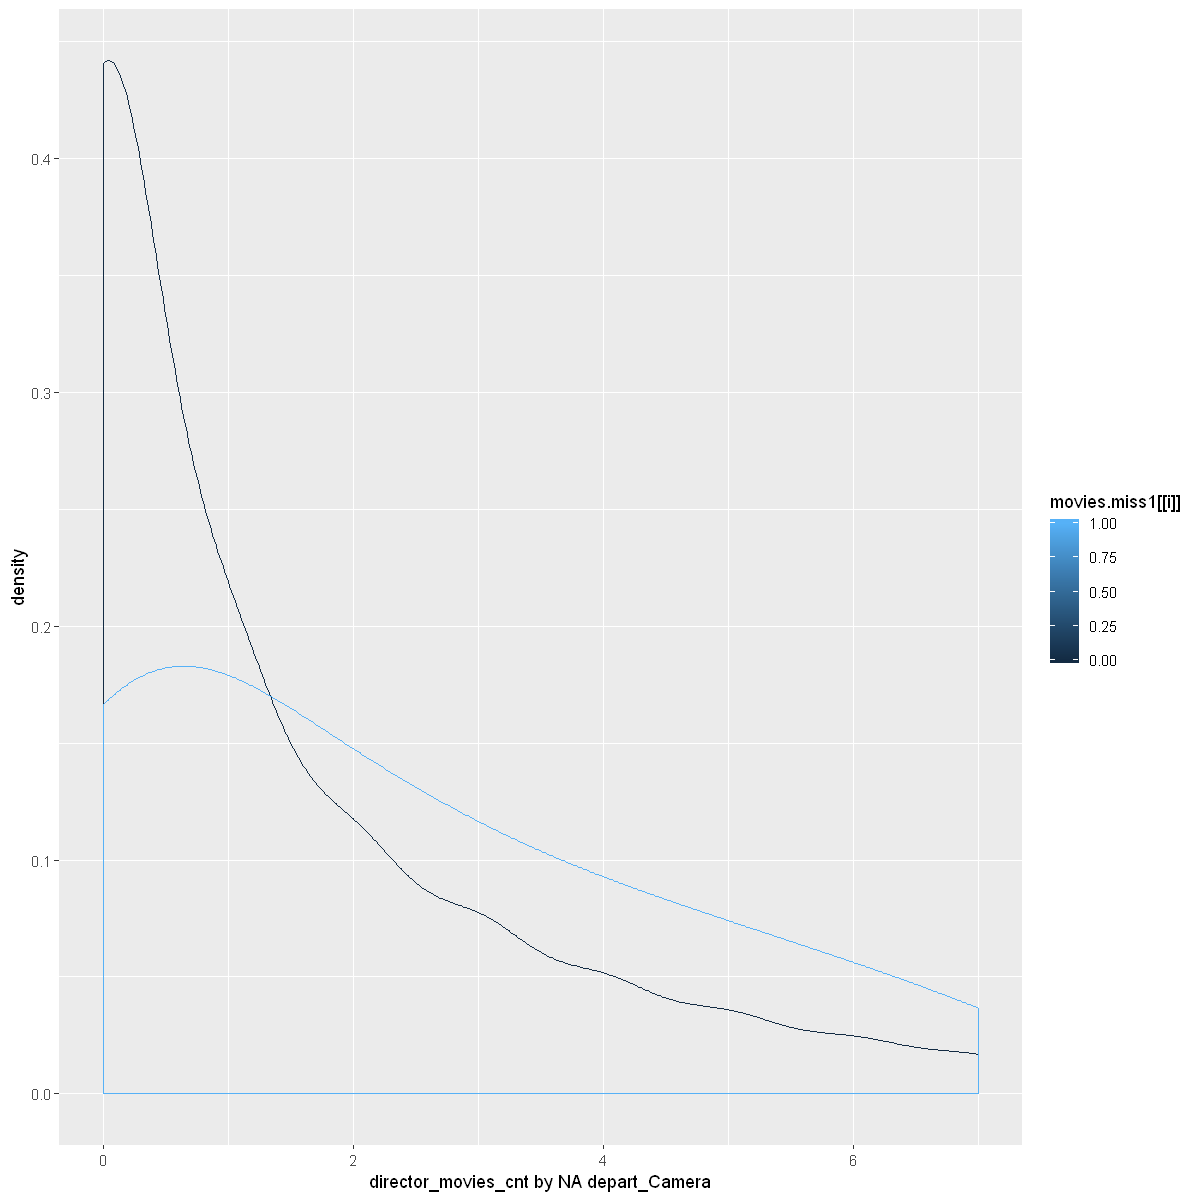


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -28.652, df = 226.98, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.667511 -3.195529
sample estimates:
mean of x mean of y 
 1.498057  4.929577 

[1] "depart_Art by NA depart_Camera"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


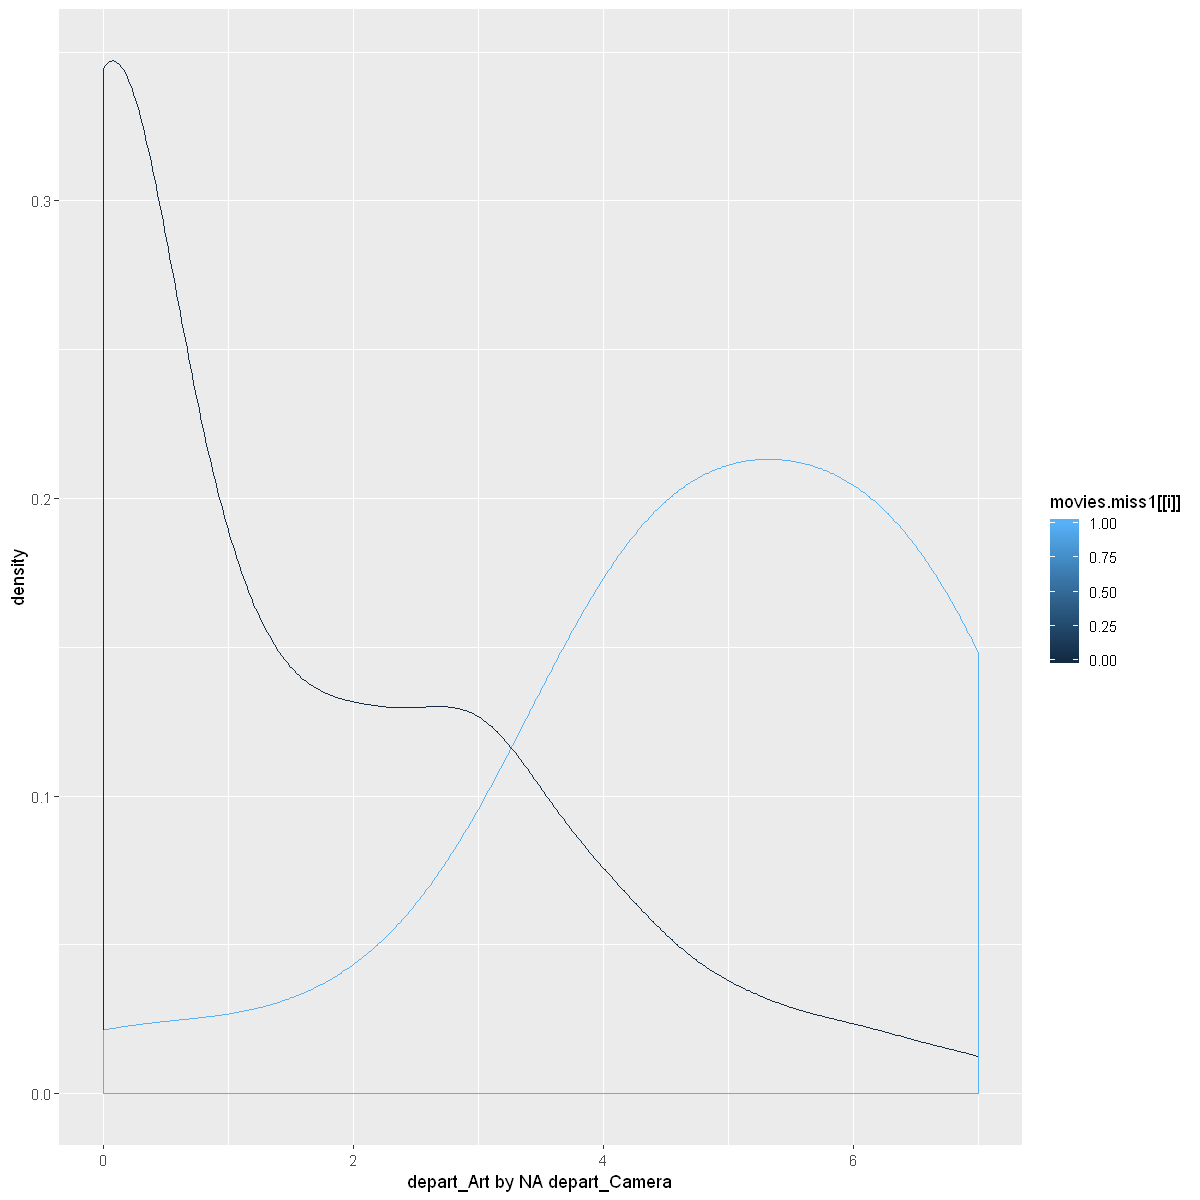


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -19.136, df = 129.43, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.877284 -2.338080
sample estimates:
mean of x mean of y 
0.8253892 3.4330709 

[1] "depart_Custom_Mkup by NA depart_Camera"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


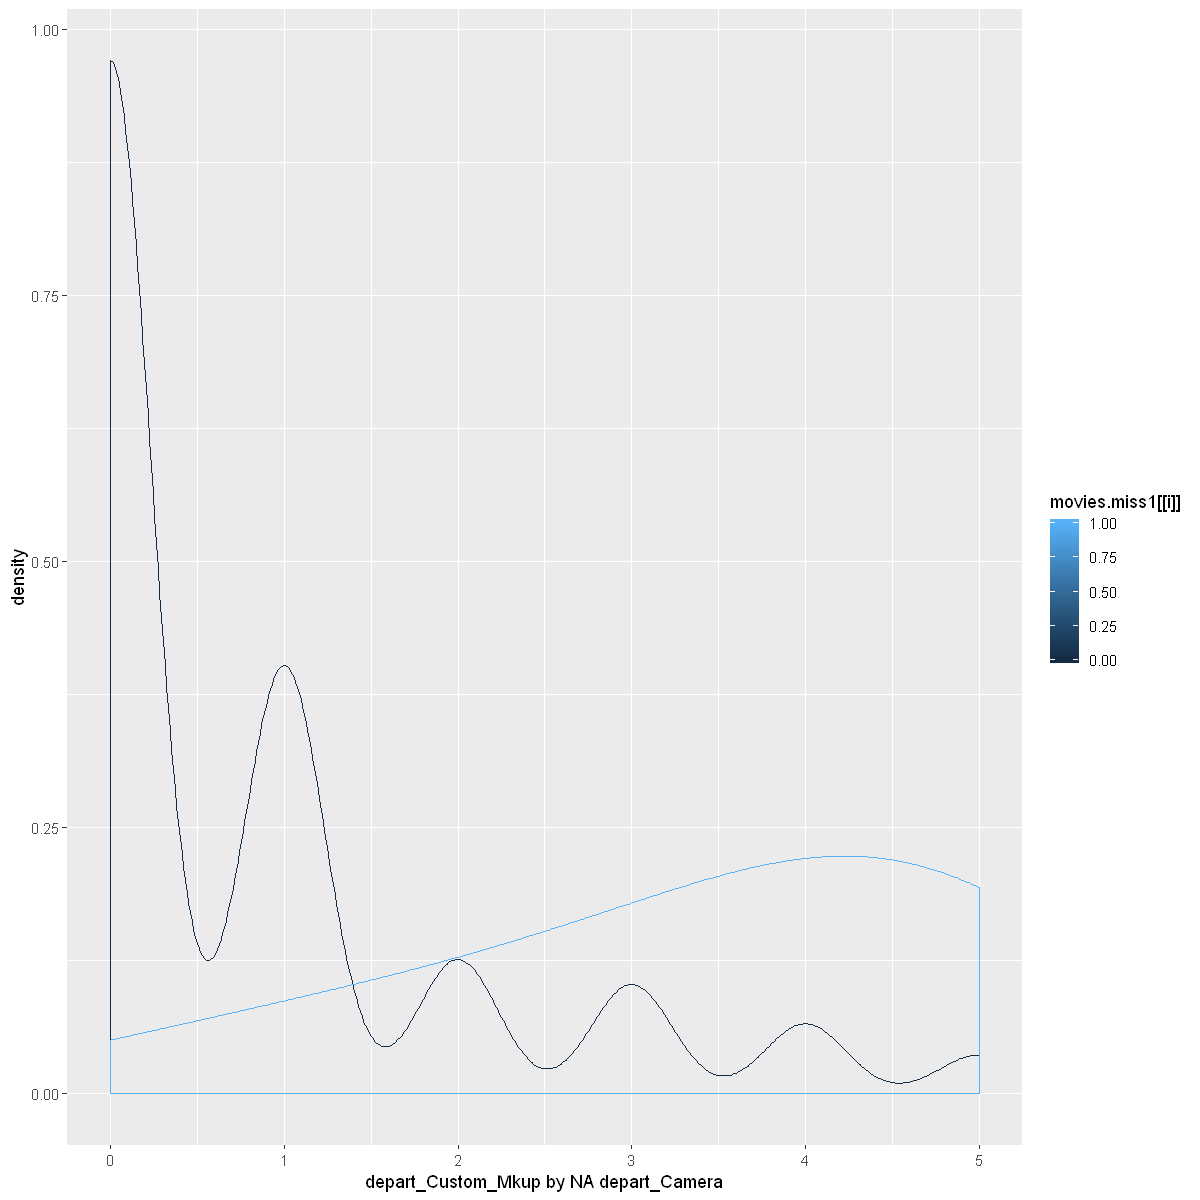


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -31.86, df = 493.76, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0956844 -0.9683947
sample estimates:
mean of x mean of y 
 1.345489  2.377528 

[1] "depart_Directing by NA depart_Camera"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


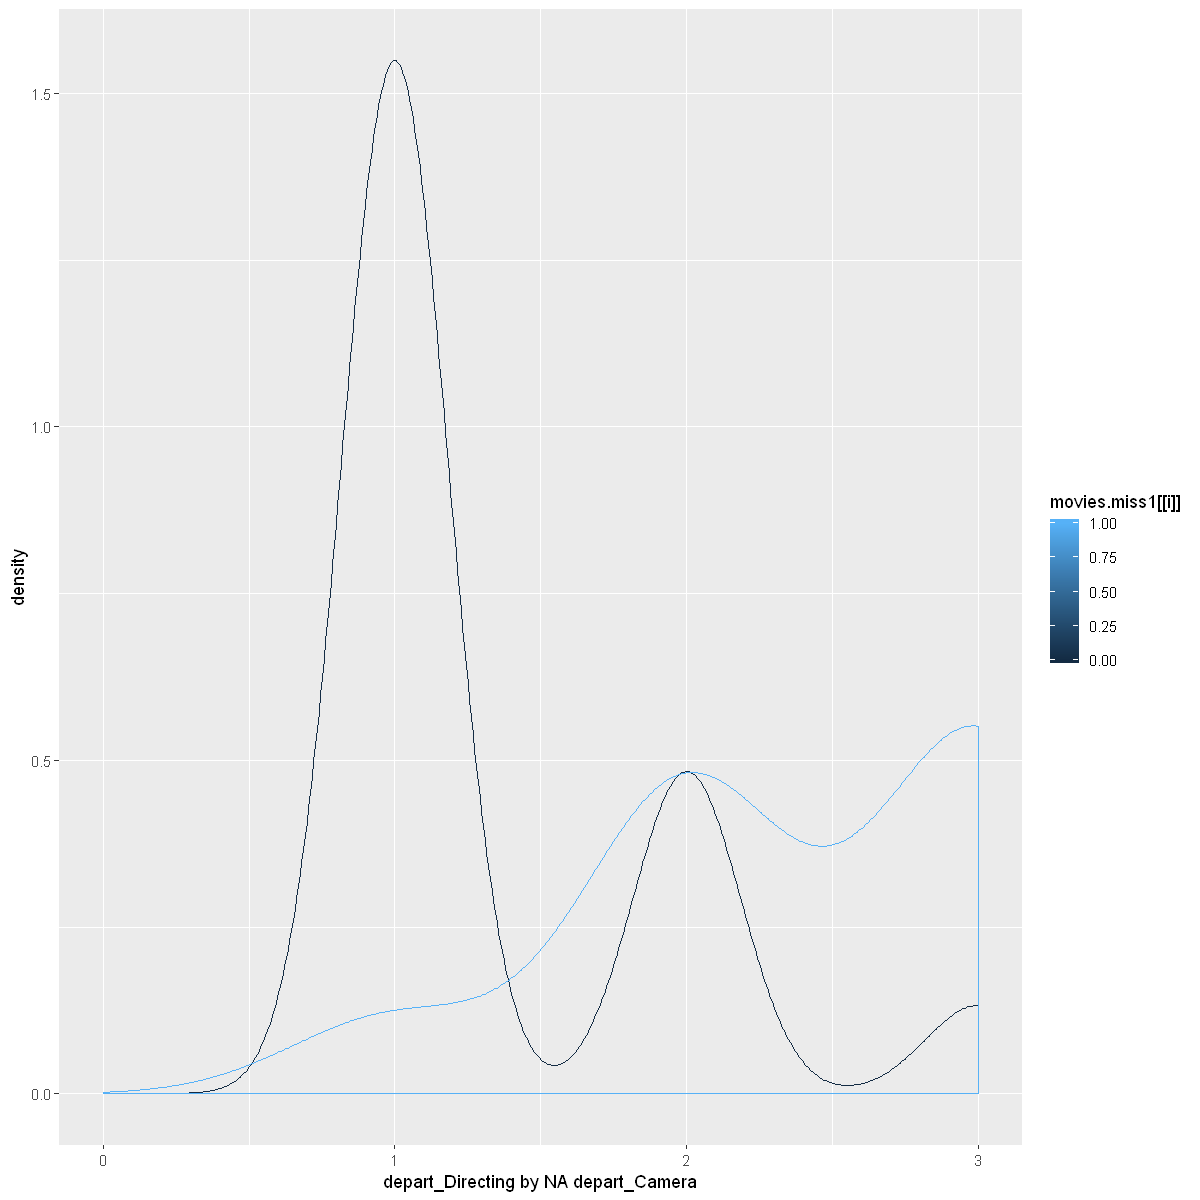


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -12.16, df = 73.964, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.001228 -2.156119
sample estimates:
mean of x mean of y 
 1.232137  3.810811 

[1] "depart_Sound by NA depart_Camera"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


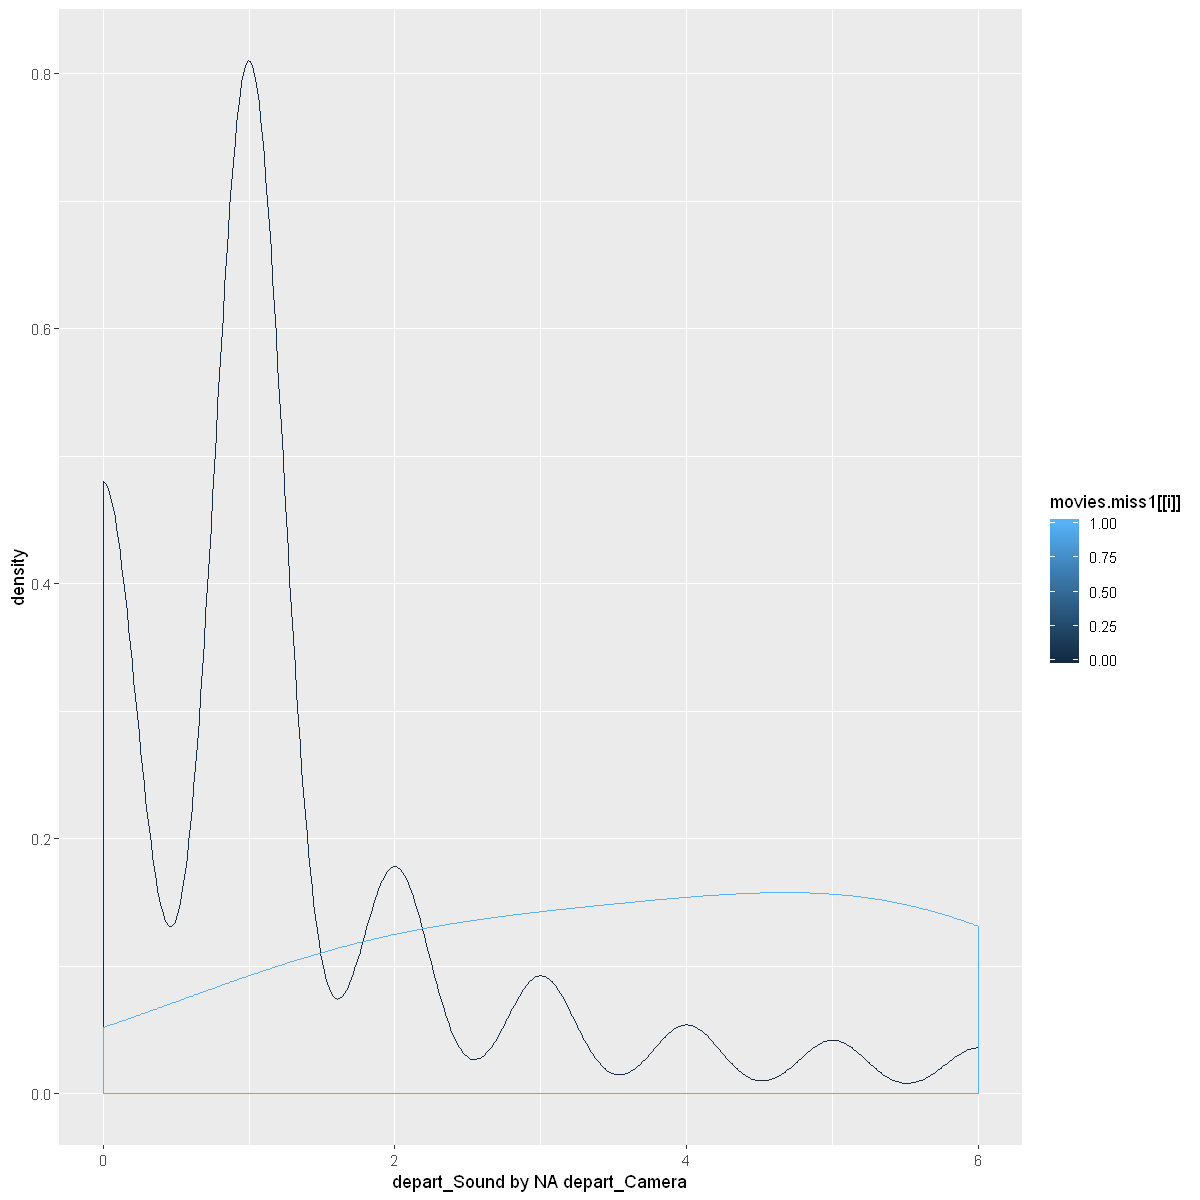


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -17.088, df = 960.17, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18117581 -14384936
sample estimates:
mean of x mean of y 
 19642794  35894053 

[1] "budget by NA depart_Custom_Mkup"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


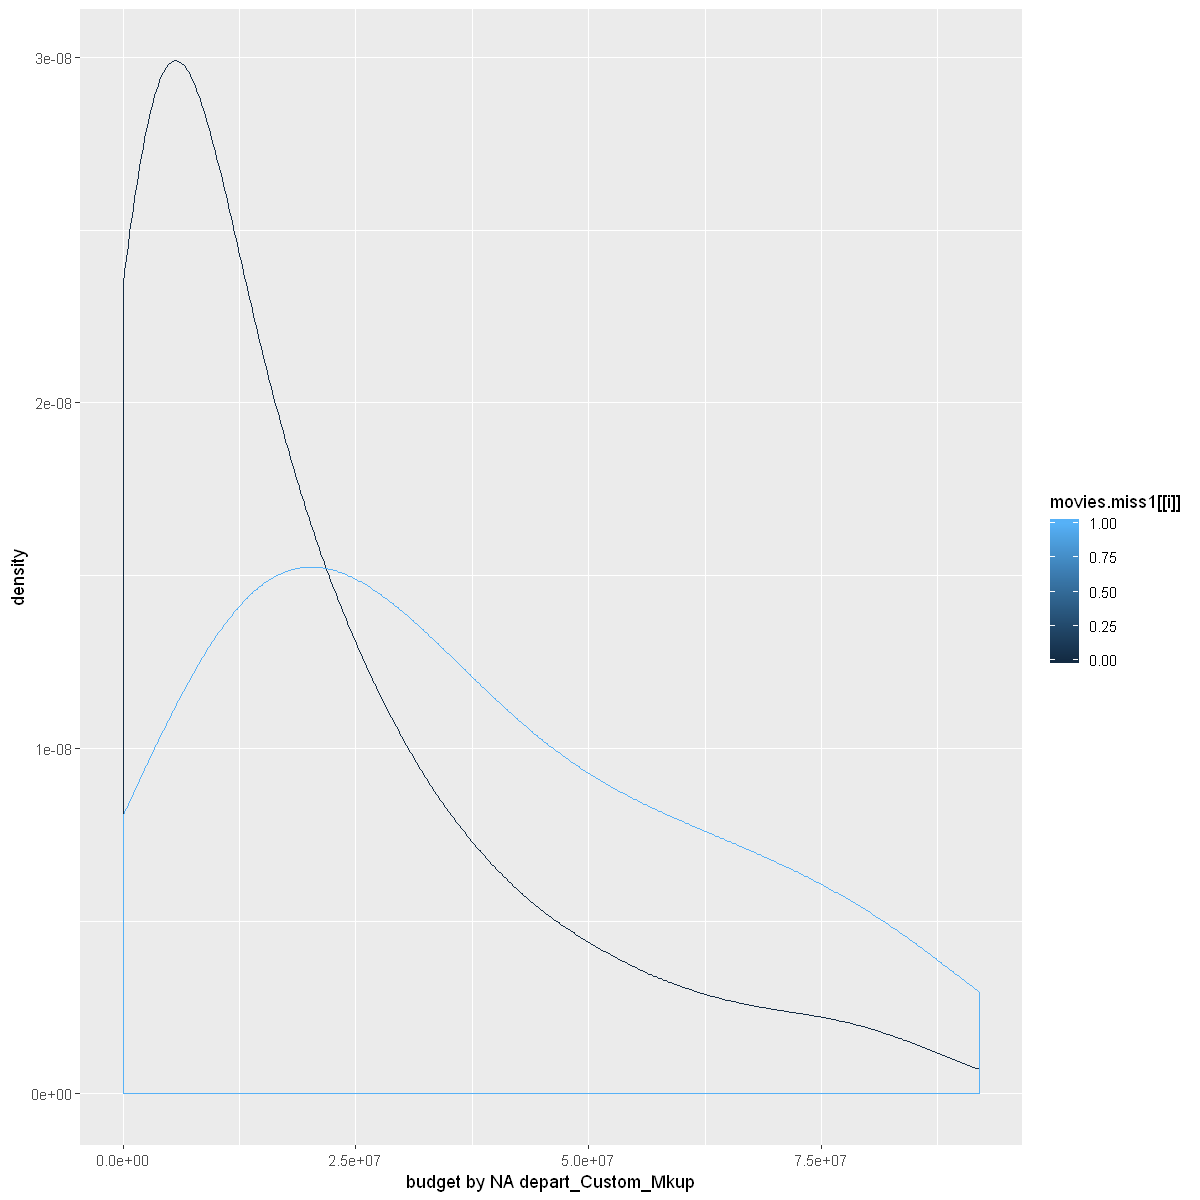


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -16.55, df = 1313.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.406931 -1.108735
sample estimates:
mean of x mean of y 
 2.725369  3.983202 

[1] "producers_cnt by NA depart_Custom_Mkup"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


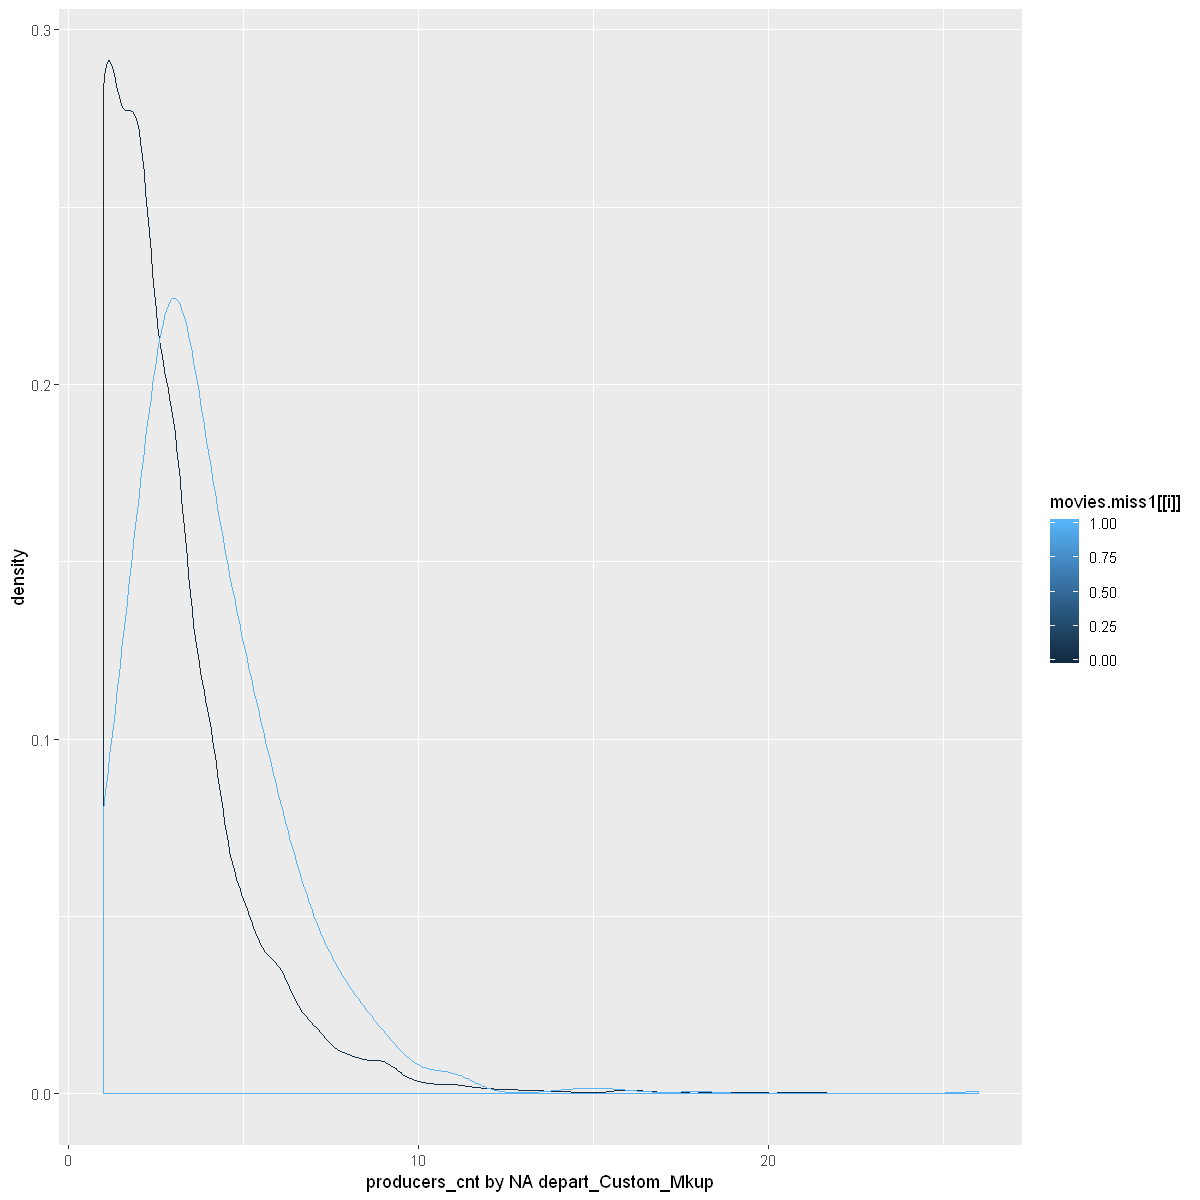


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -12.371, df = 1104.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.899528 -2.105648
sample estimates:
mean of x mean of y 
 3.739970  6.242558 

[1] "actor1_movies_cnt by NA depart_Custom_Mkup"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


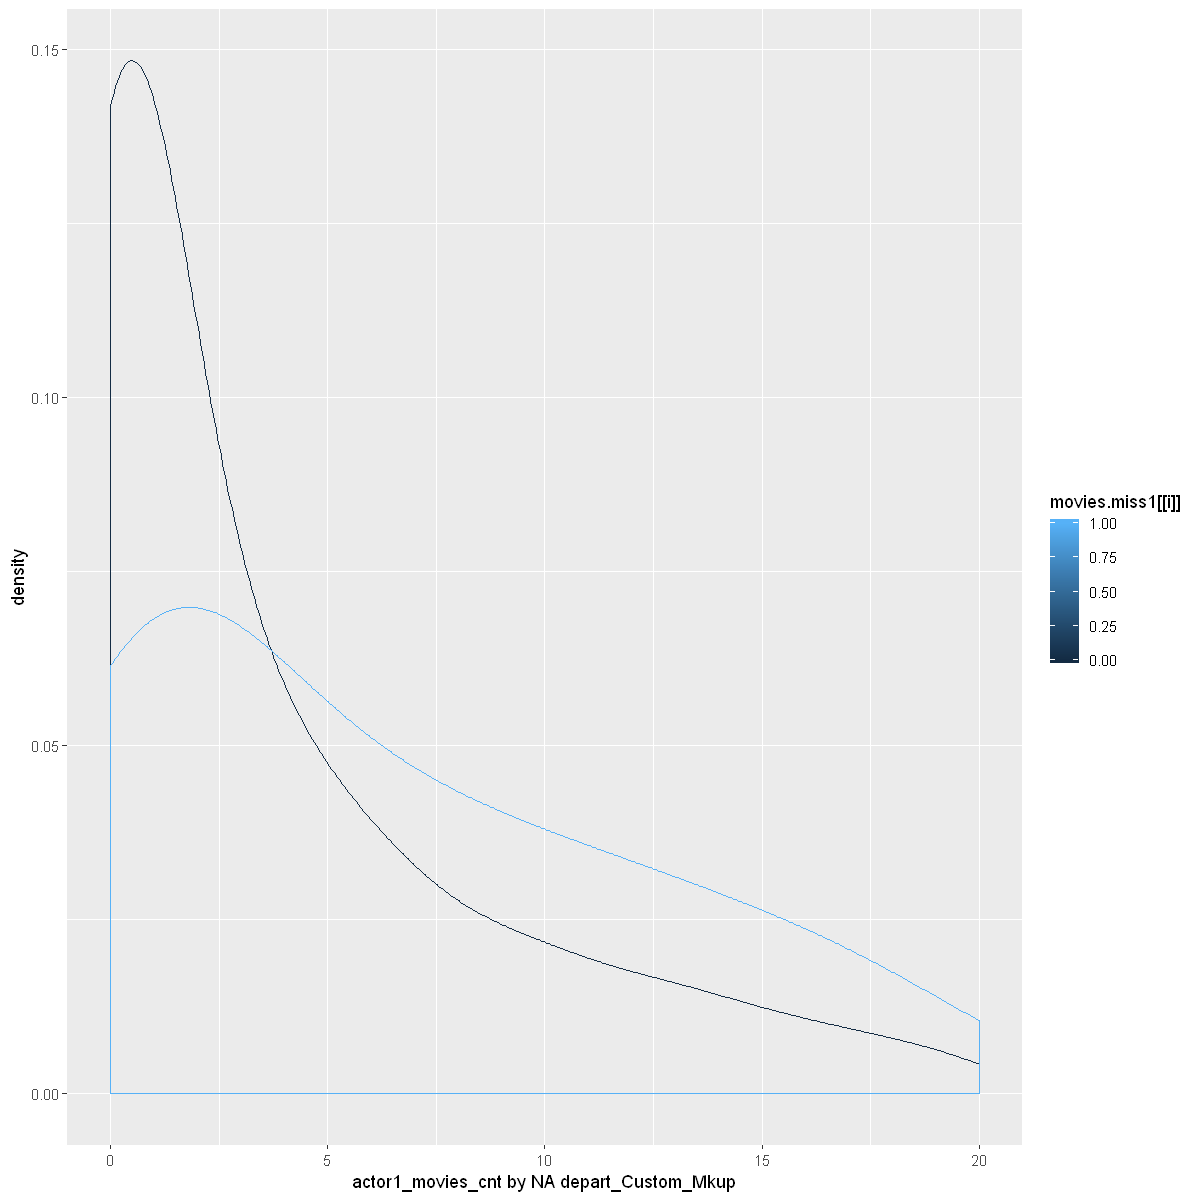


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -12.233, df = 1042.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.504325 -1.811982
sample estimates:
mean of x mean of y 
 3.017164  5.175317 

[1] "actor2_movies_cnt by NA depart_Custom_Mkup"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


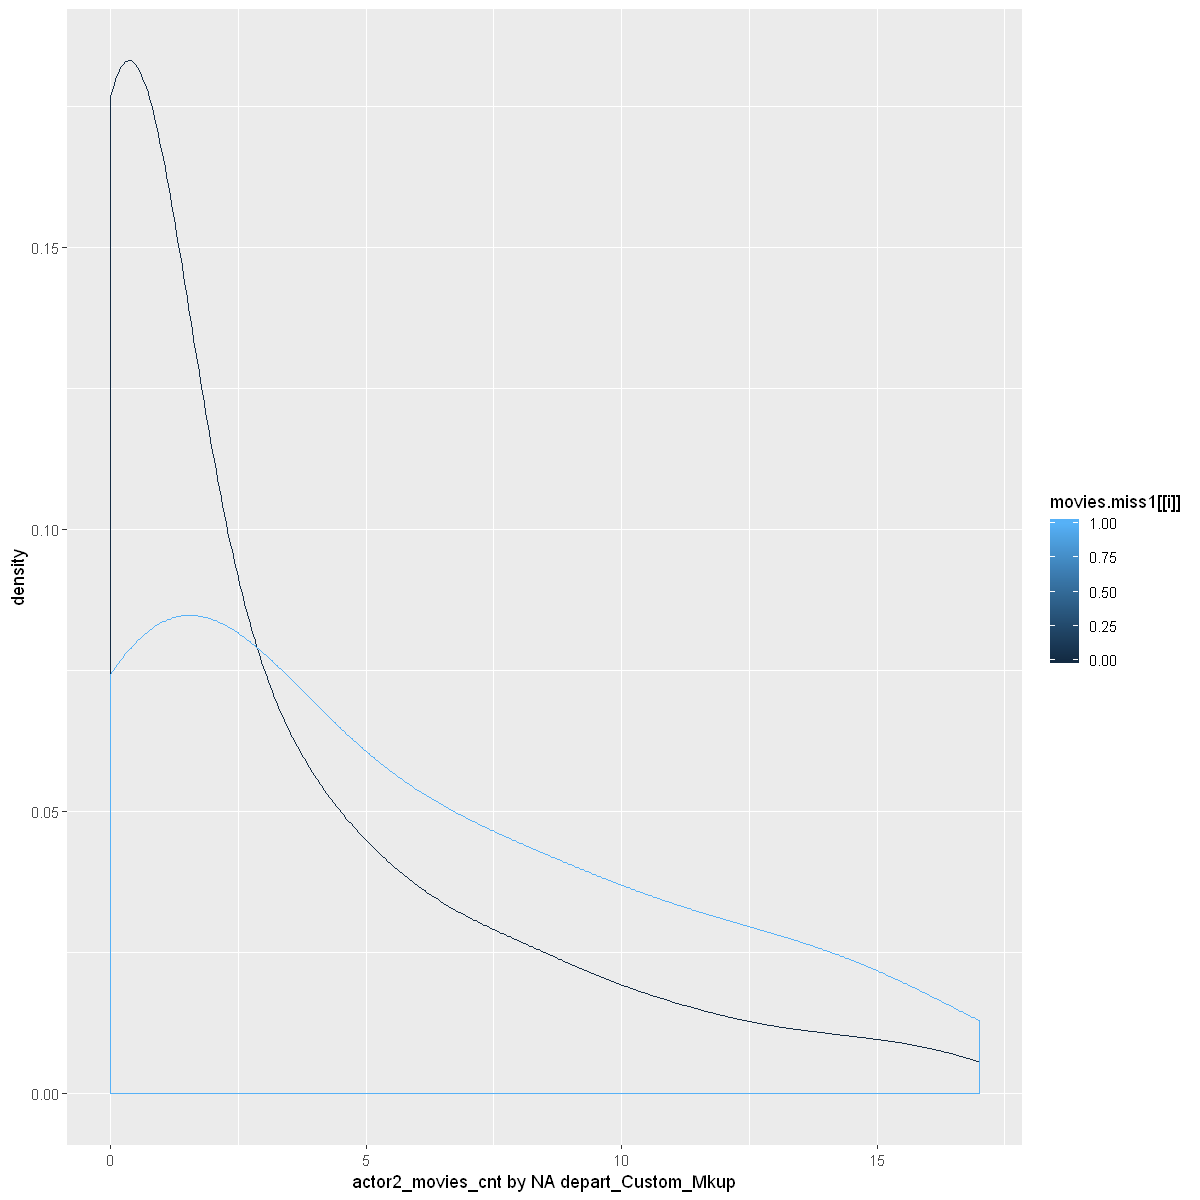


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.736, df = 955, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -86316790 -59638199
sample estimates:
mean of x mean of y 
162981598 235959093 

[1] "actor0_prev_revenue by NA depart_Custom_Mkup"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


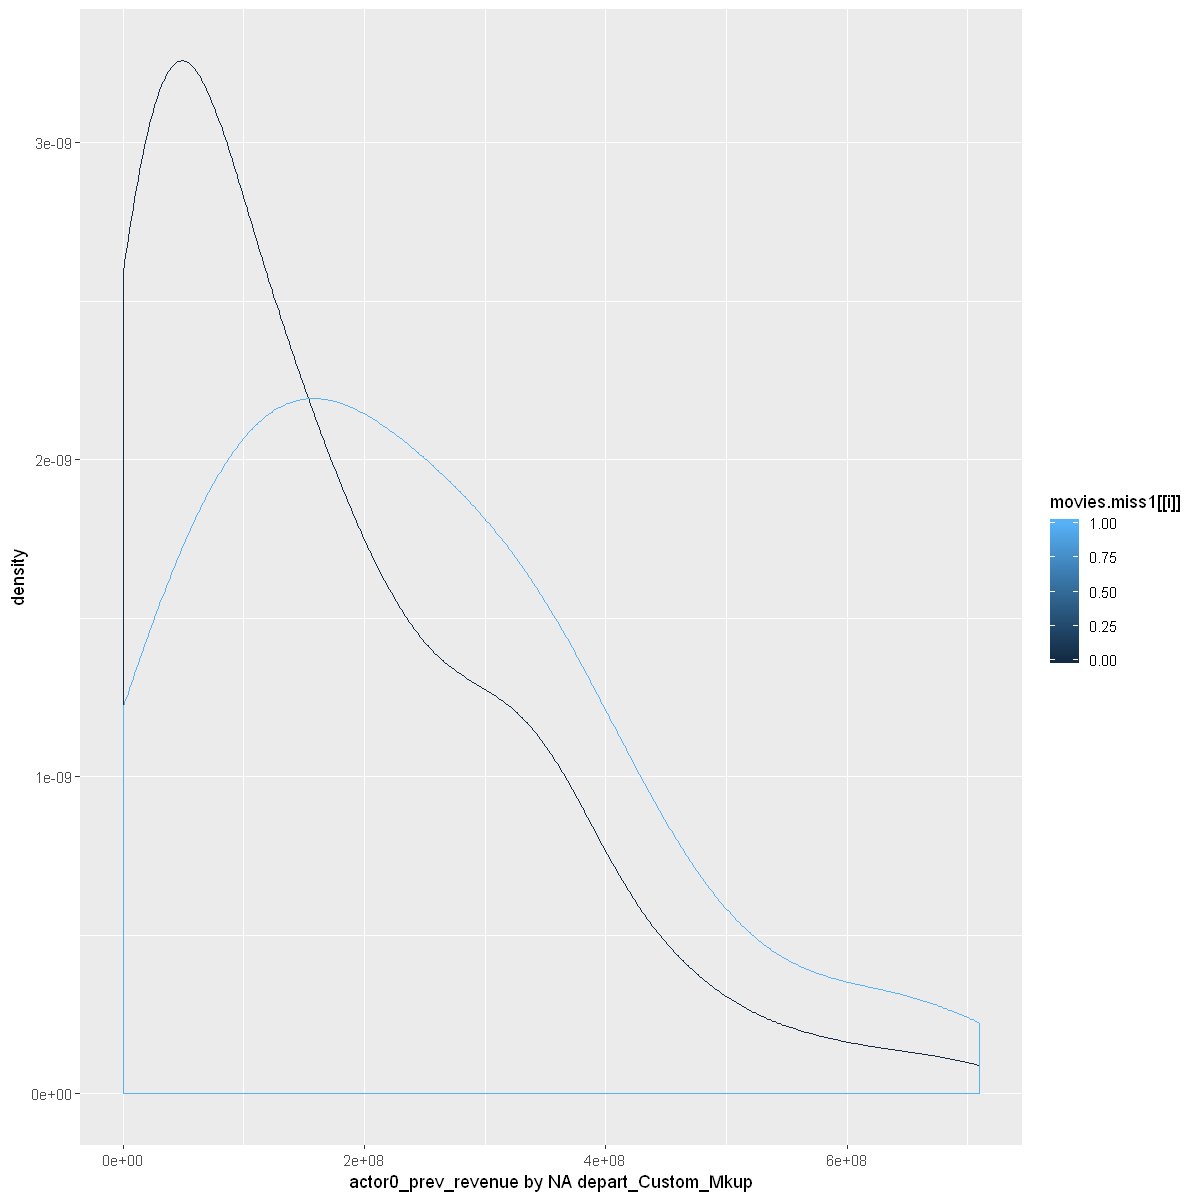


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.6492, df = 937.73, p-value = 4.996e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -49135763 -26741050
sample estimates:
mean of x mean of y 
138760358 176698765 

[1] "actor1_prev_revenue by NA depart_Custom_Mkup"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


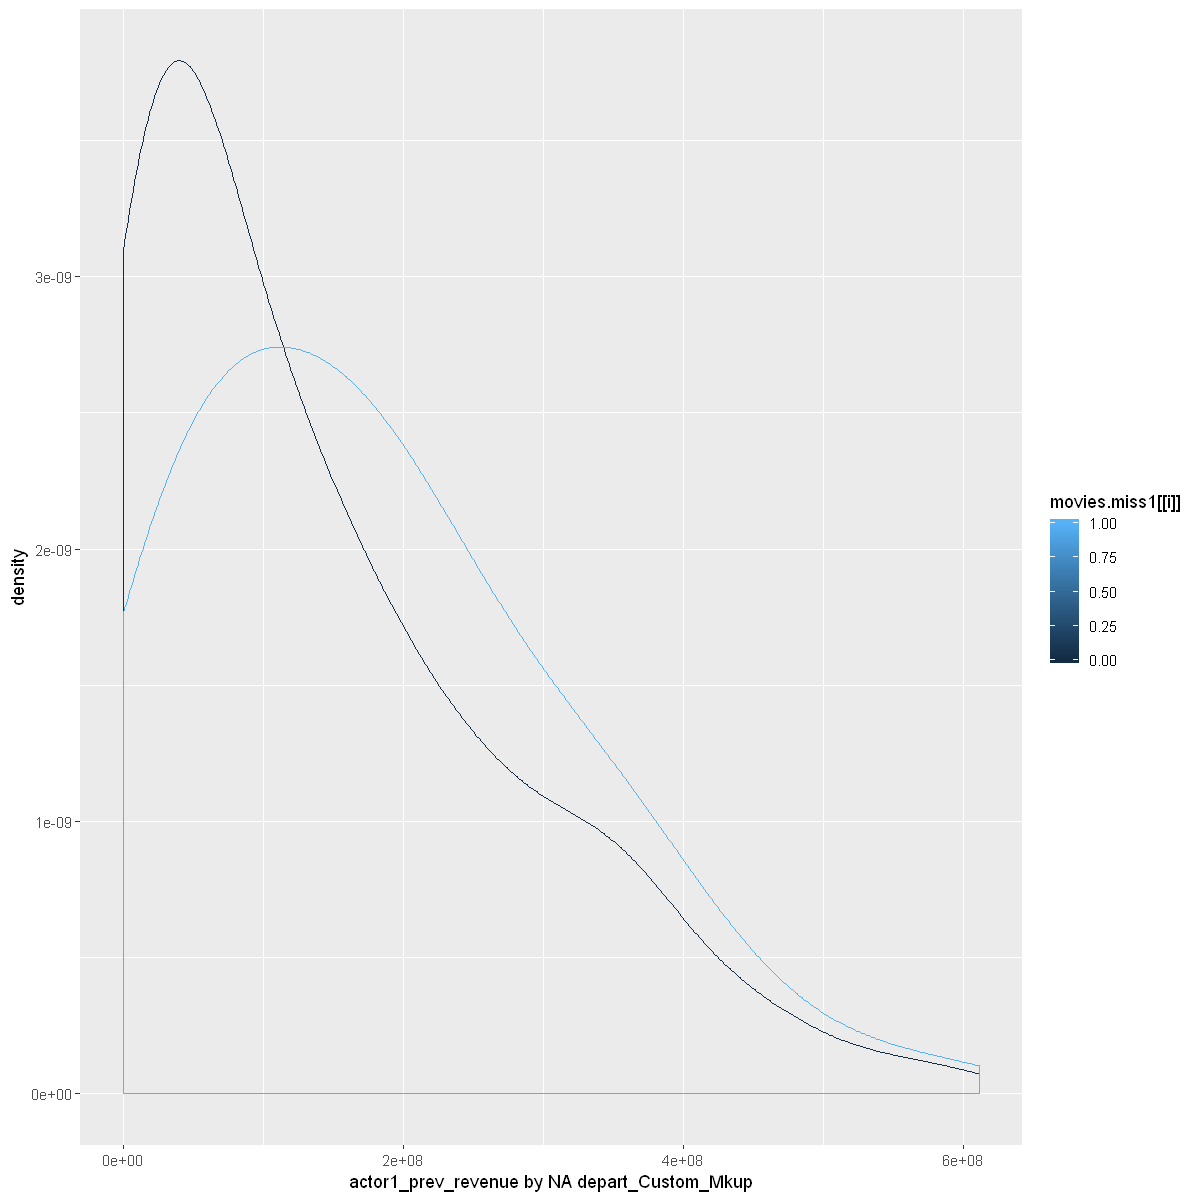


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.8467, df = 893.47, p-value = 1.405e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -50269311 -27870273
sample estimates:
mean of x mean of y 
126969360 166039152 

[1] "actor2_prev_revenue by NA depart_Custom_Mkup"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


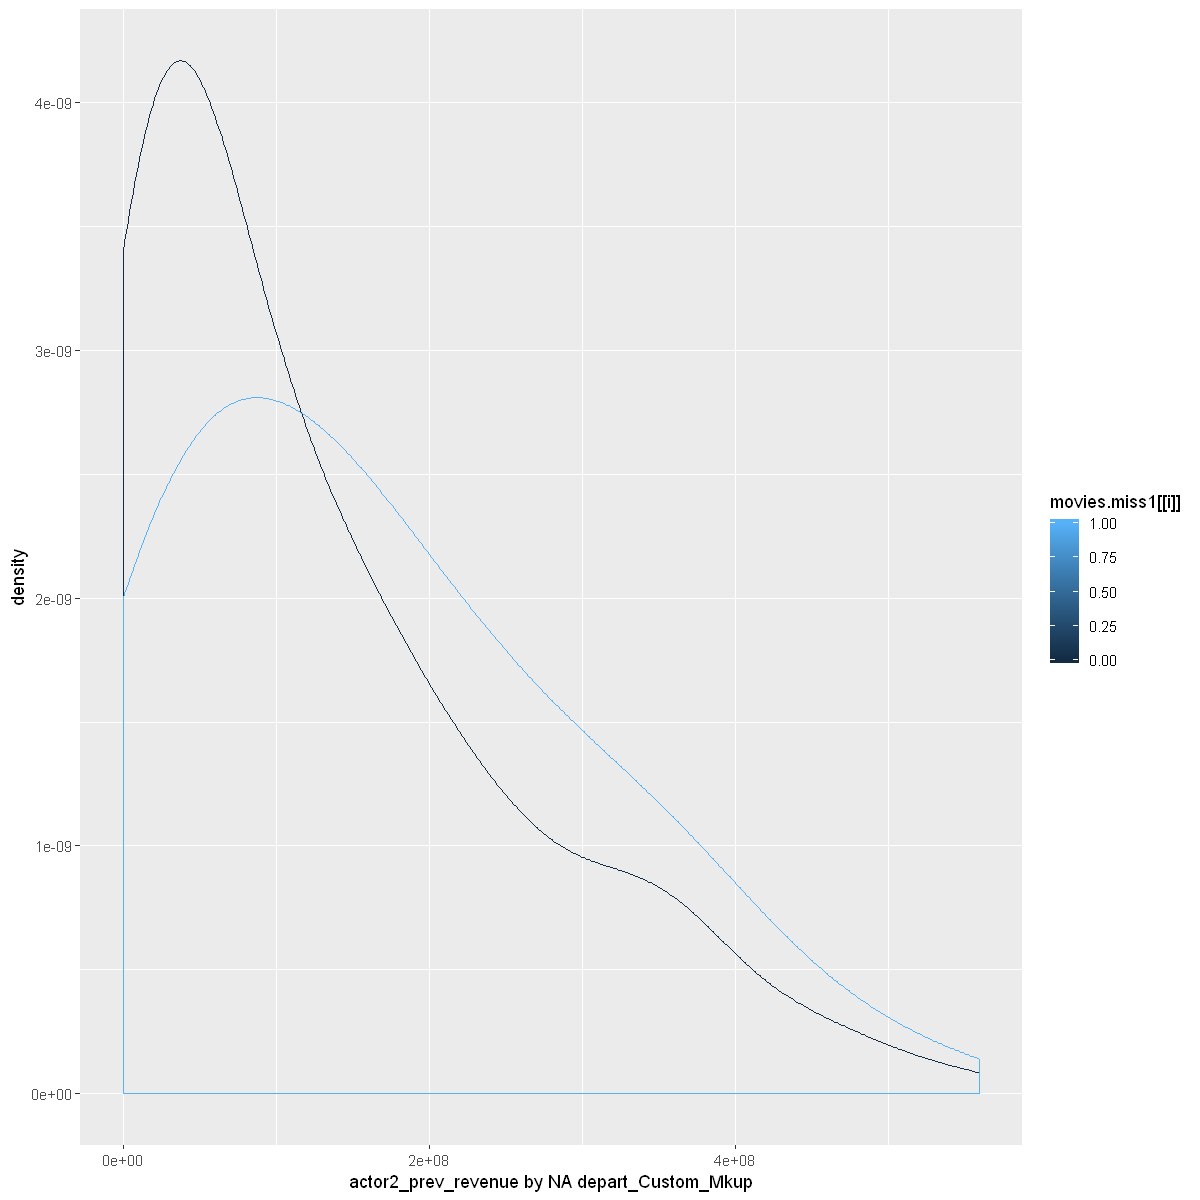


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -11.991, df = 1081.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0109069 -0.7265867
sample estimates:
mean of x mean of y 
 1.242614  2.111361 

[1] "director_movies_cnt by NA depart_Custom_Mkup"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


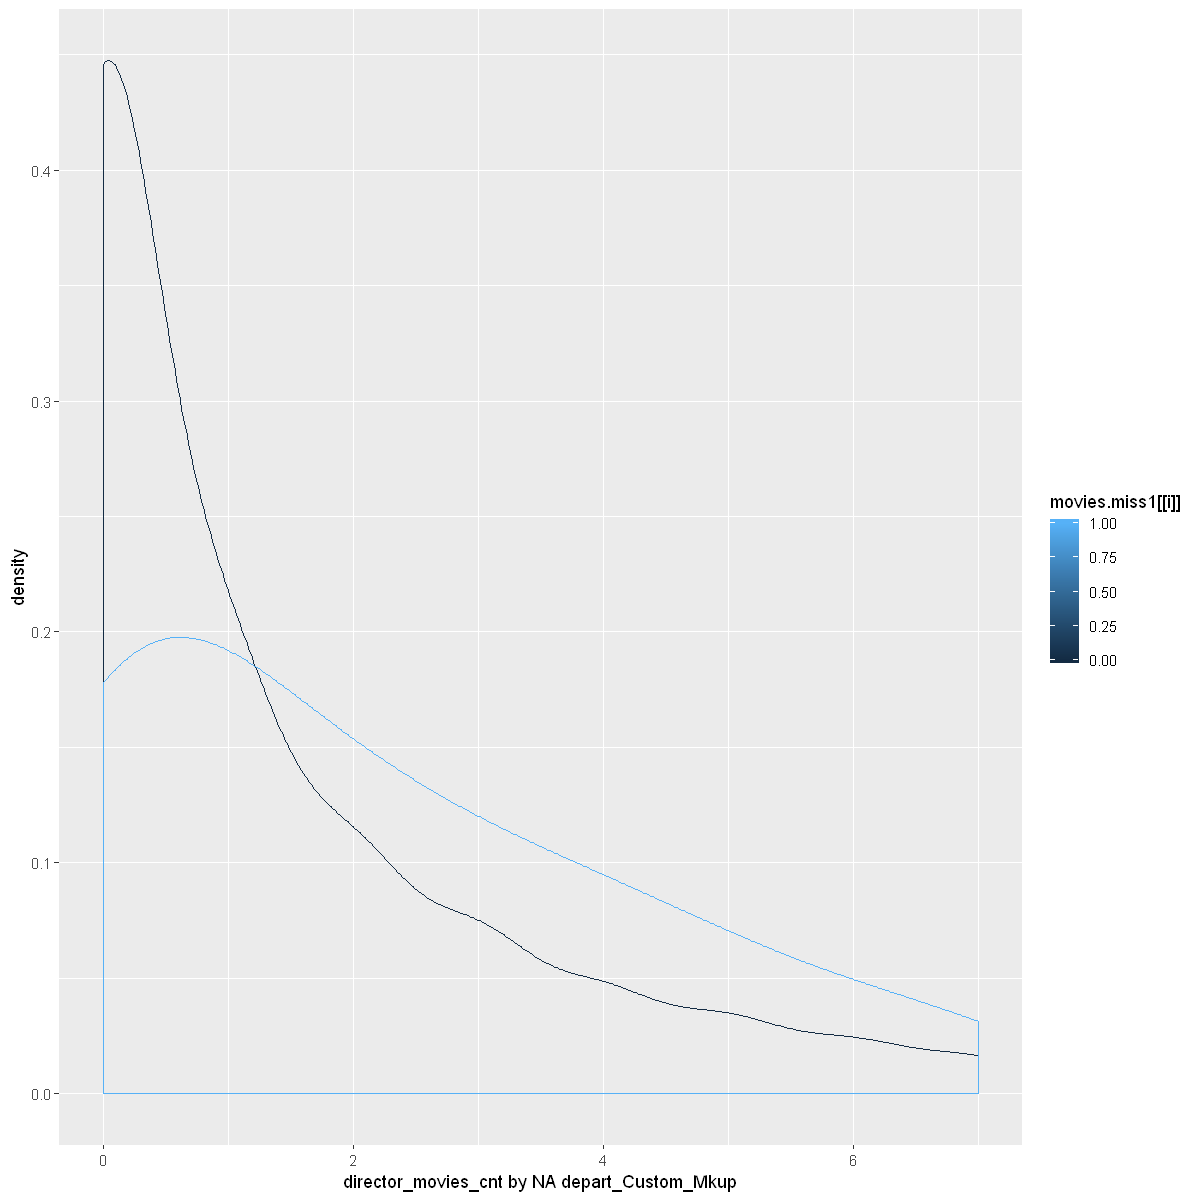


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -47.111, df = 529.76, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.593272 -3.305598
sample estimates:
mean of x mean of y 
 1.376068  4.825503 

[1] "depart_Art by NA depart_Custom_Mkup"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


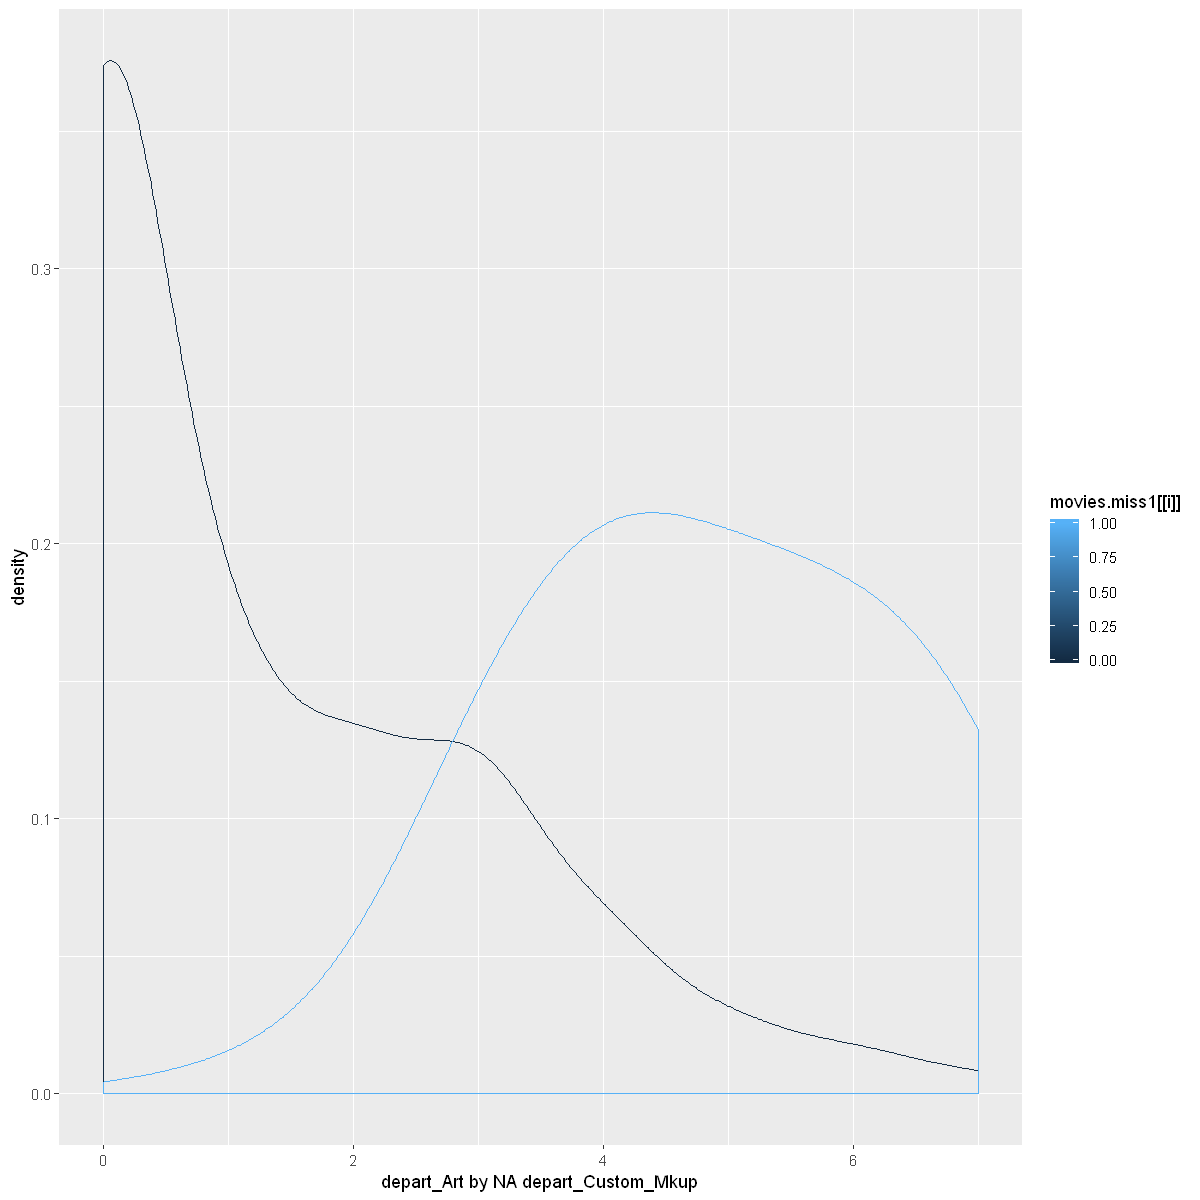


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -26.978, df = 465.12, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.179366 -1.883431
sample estimates:
mean of x mean of y 
0.9776922 3.0090909 

[1] "depart_Camera by NA depart_Custom_Mkup"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


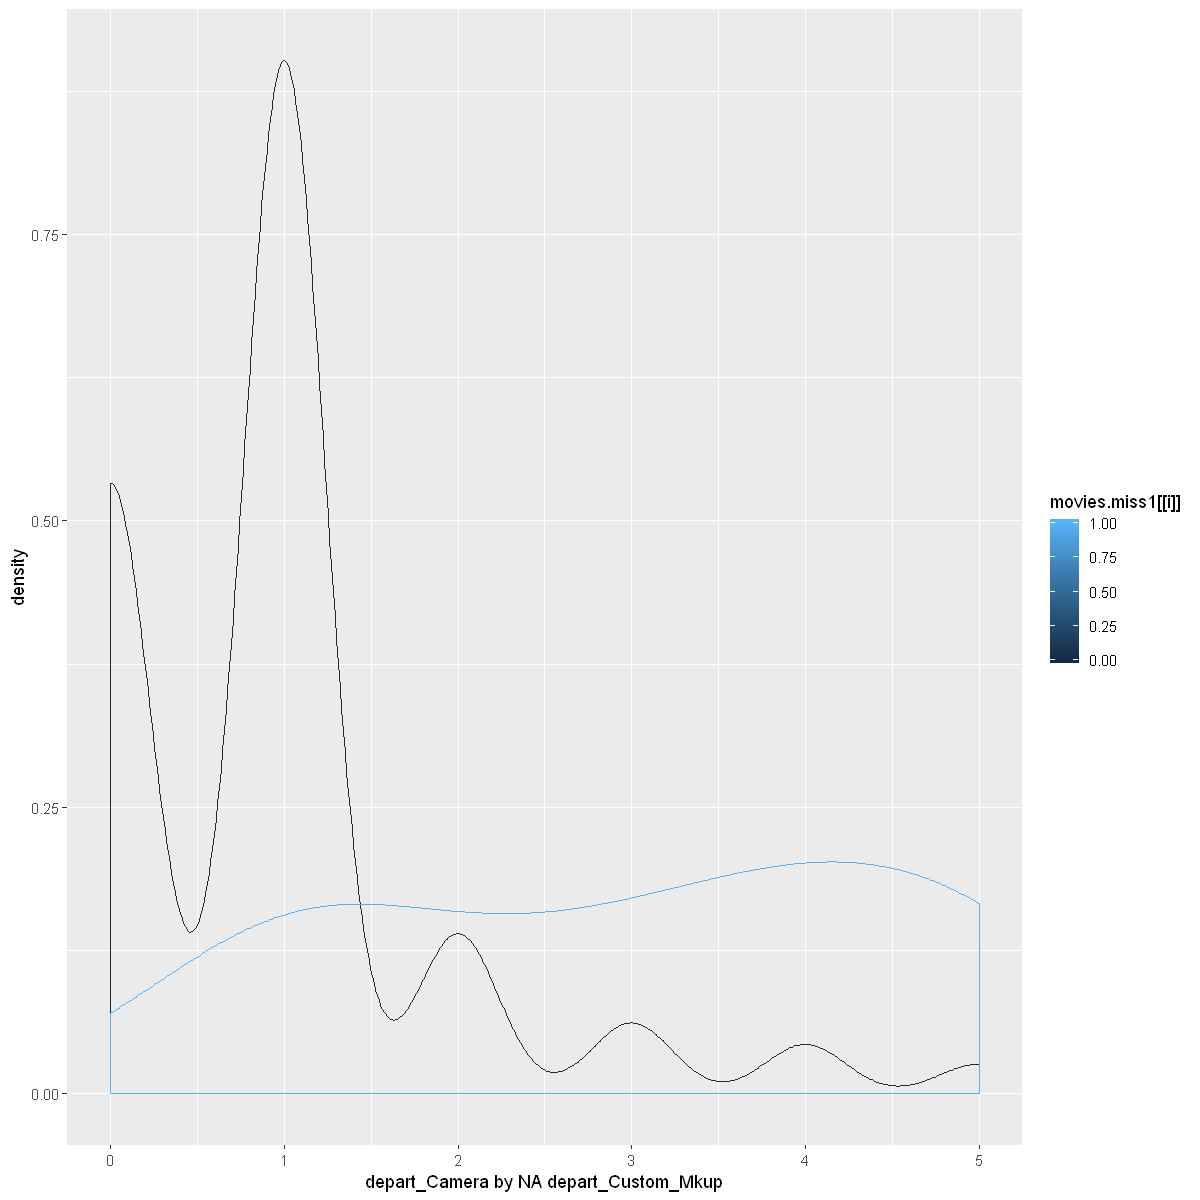


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -37.25, df = 847.04, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0005819 -0.9004146
sample estimates:
mean of x mean of y 
 1.313100  2.263598 

[1] "depart_Directing by NA depart_Custom_Mkup"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


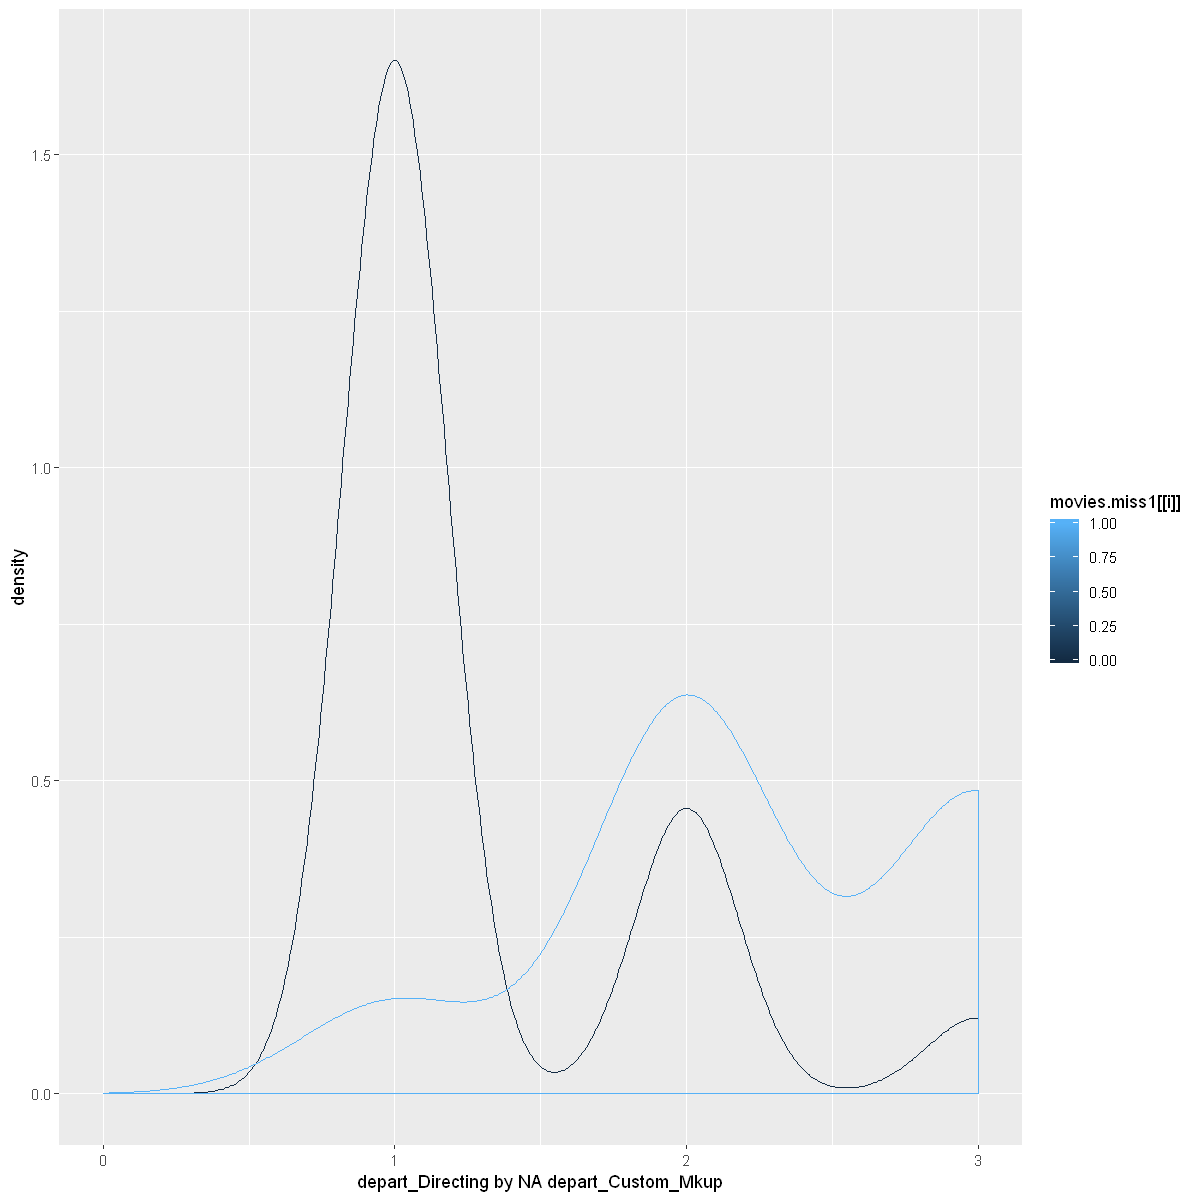


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -15.672, df = 245.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.211462 -1.717639
sample estimates:
mean of x mean of y 
 1.186710  3.151261 

[1] "depart_Sound by NA depart_Custom_Mkup"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


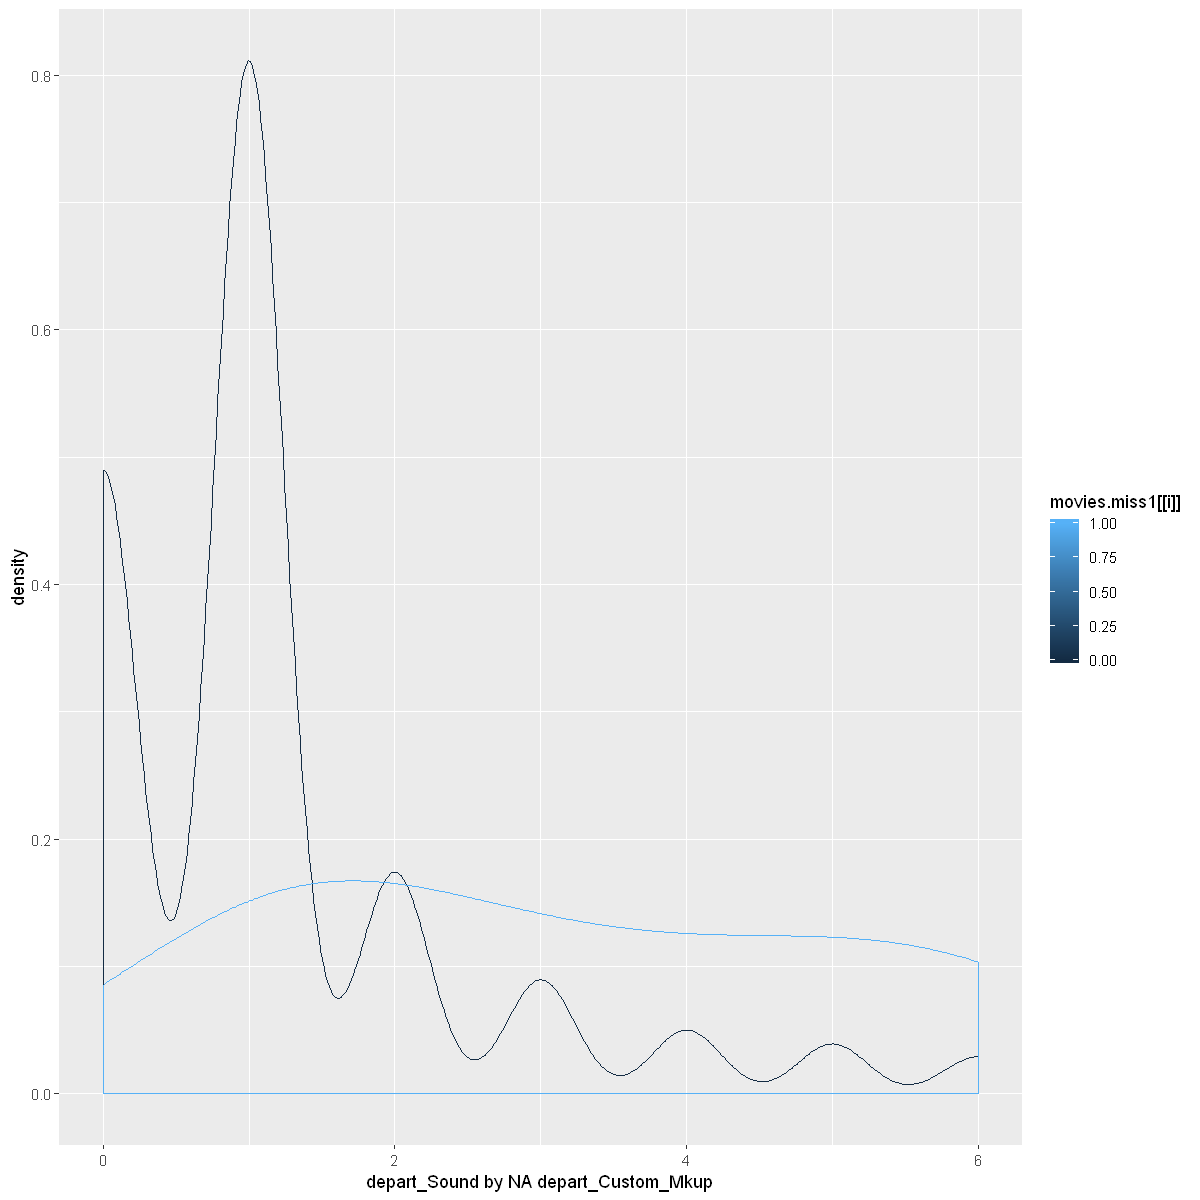


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.0822, df = 401.07, p-value = 2.767e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -11396654  -5828967
sample estimates:
mean of x mean of y 
 21509016  30121827 

[1] "budget by NA depart_Directing"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


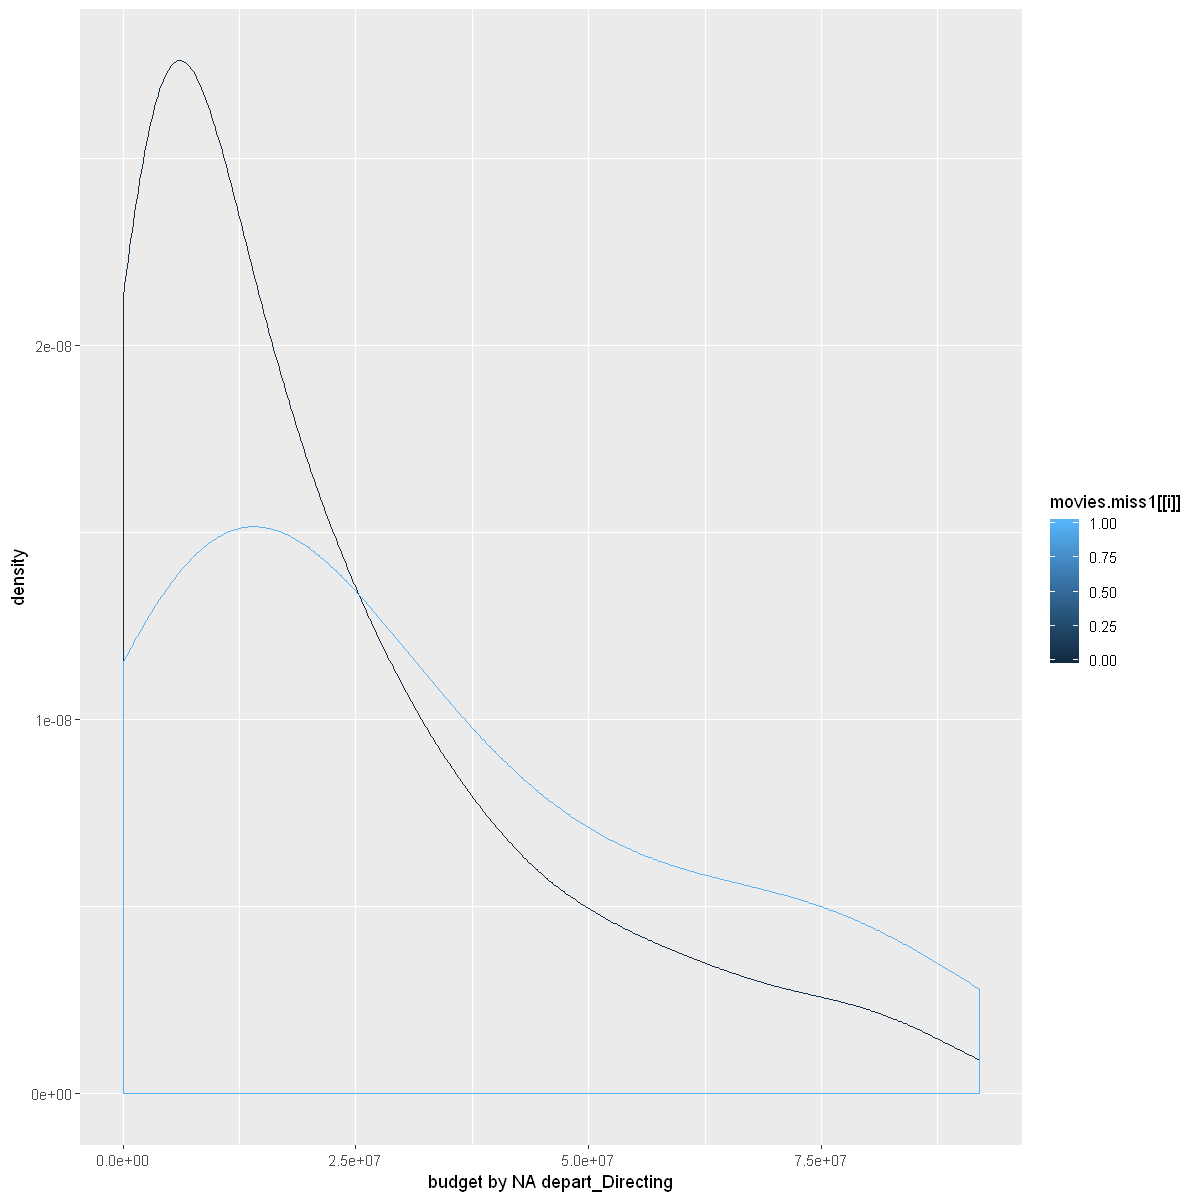


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -4.8936, df = 566.19, p-value = 1.293e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7634706 -0.3261319
sample estimates:
mean of x mean of y 
 2.868242  3.413043 

[1] "producers_cnt by NA depart_Directing"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


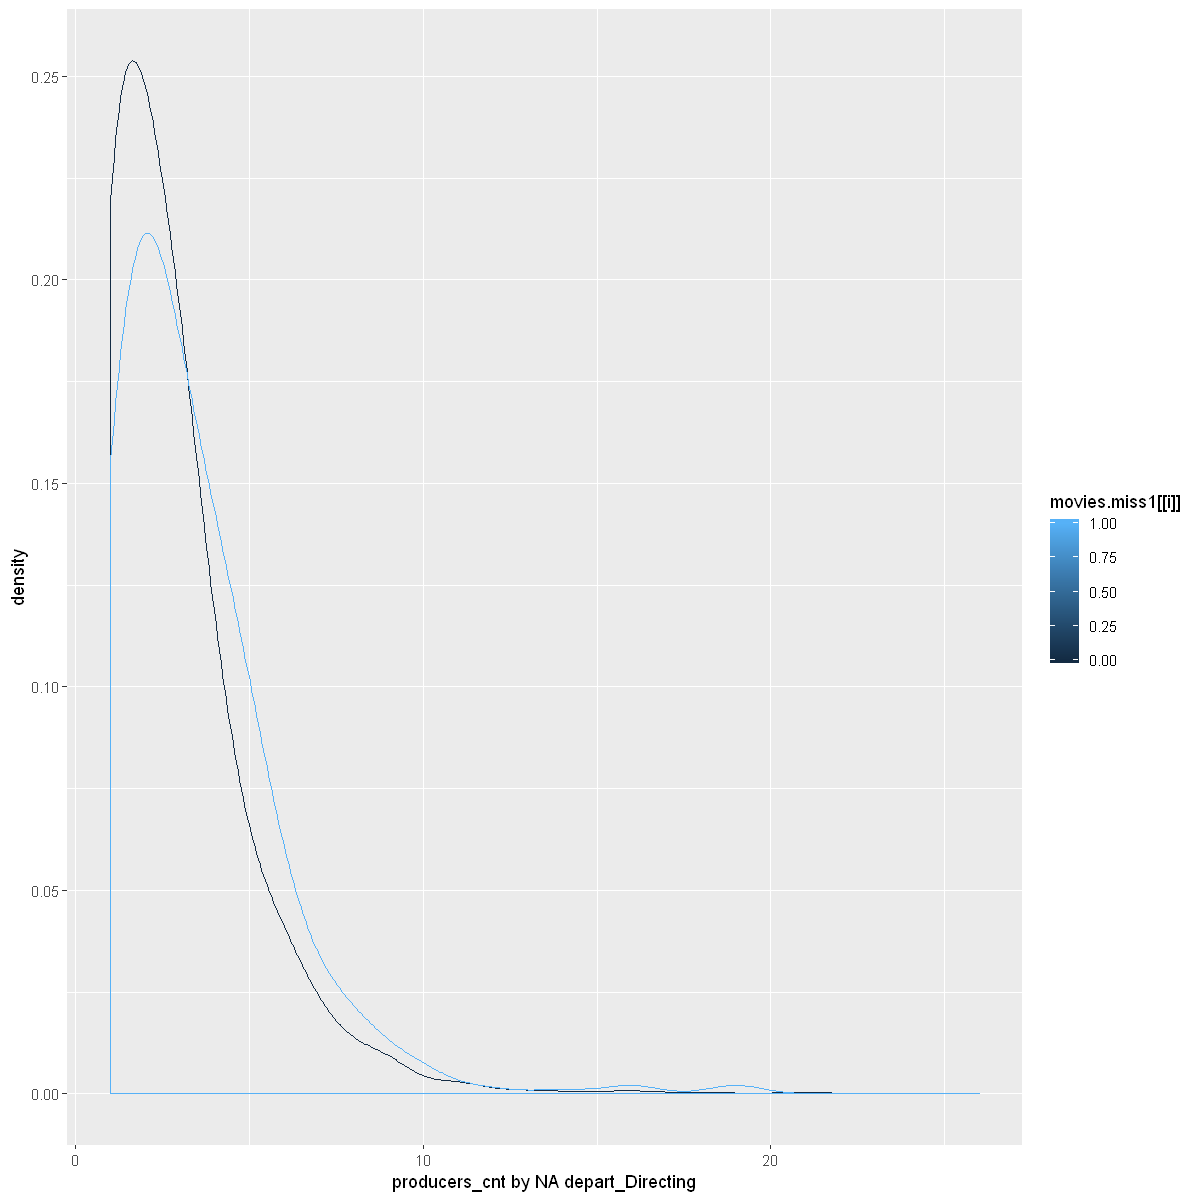


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -1.9864, df = 549.07, p-value = 0.04749
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.98966281 -0.00553411
sample estimates:
mean of x mean of y 
 4.031327  4.528926 

[1] "actor1_movies_cnt by NA depart_Directing"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


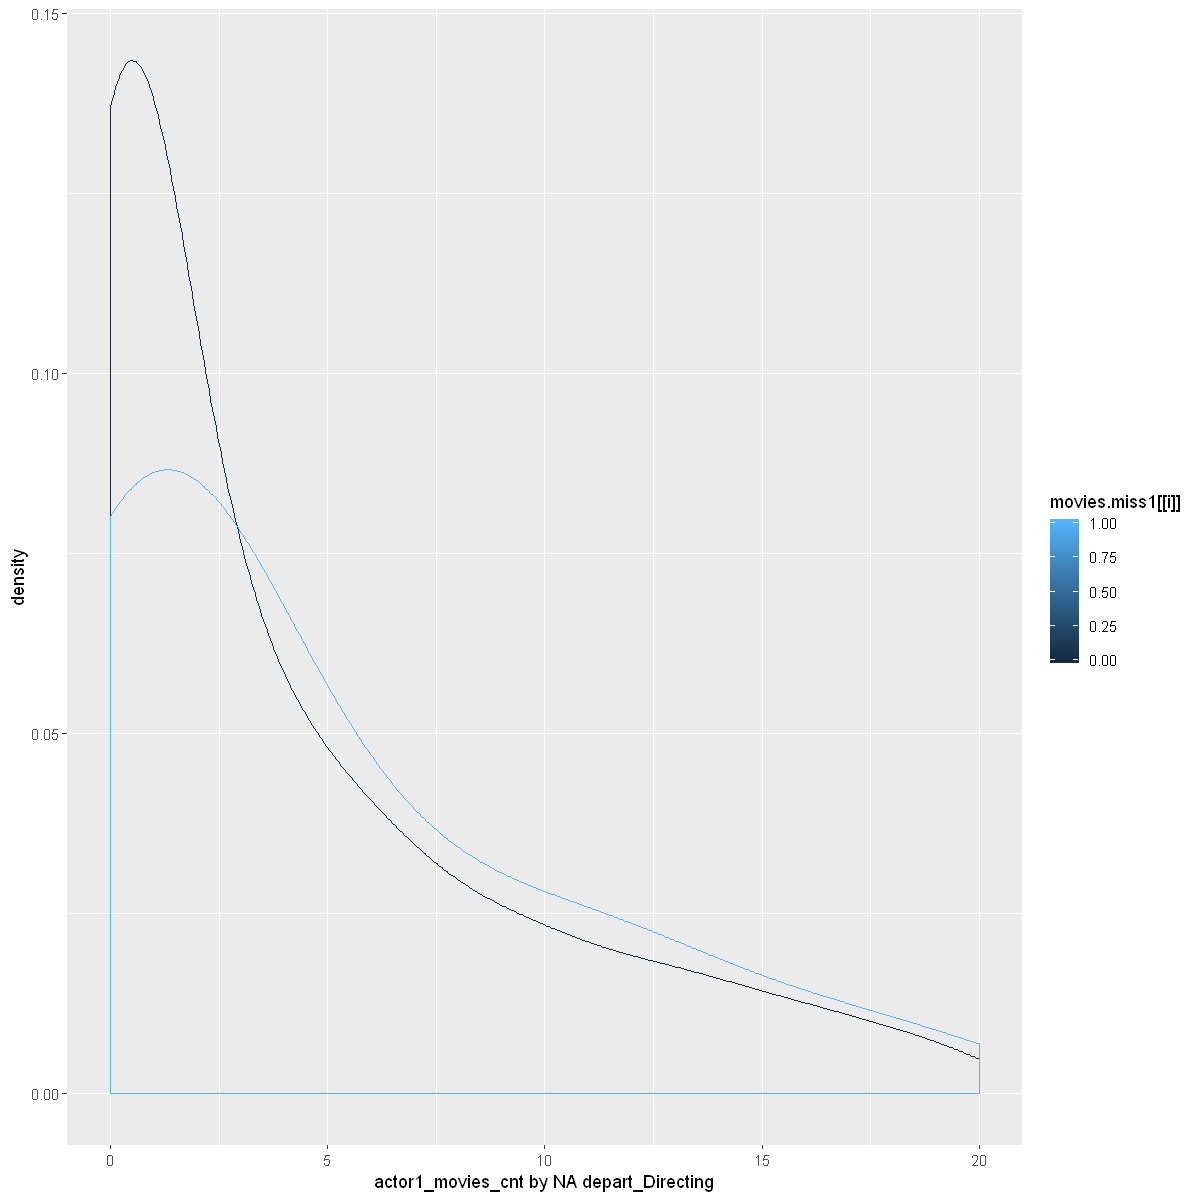


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -2.5066, df = 525.74, p-value = 0.01249
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0017316 -0.1214558
sample estimates:
mean of x mean of y 
 3.251172  3.812766 

[1] "actor2_movies_cnt by NA depart_Directing"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


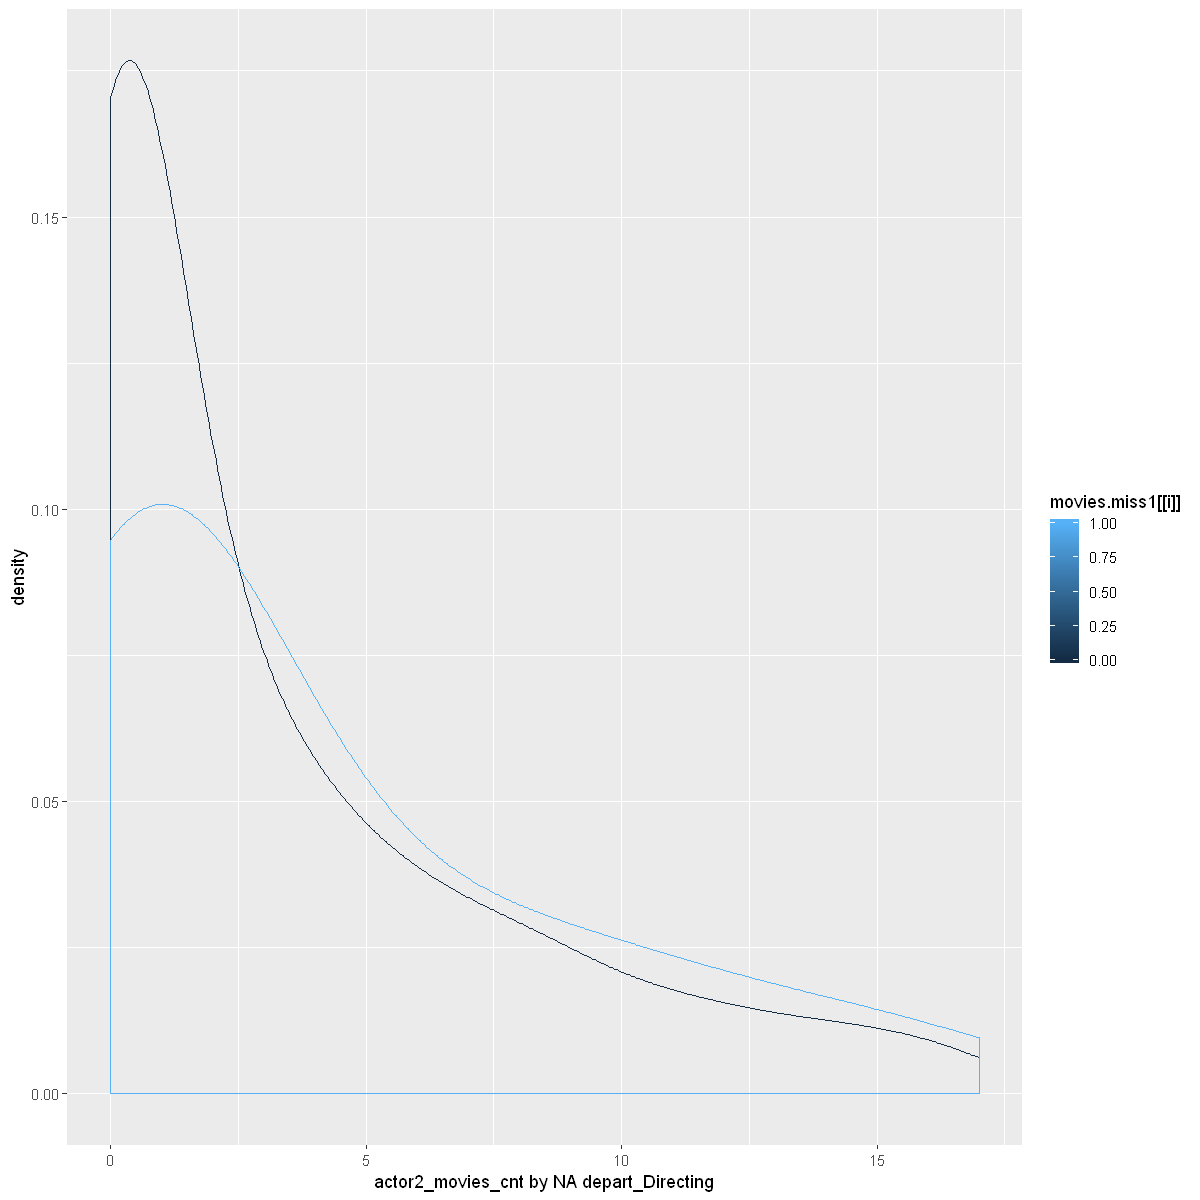


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -1.6539, df = 374.97, p-value = 0.09898
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -33263649   2870419
sample estimates:
mean of x mean of y 
173801150 188997765 

[1] "actor0_prev_revenue by NA depart_Directing"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


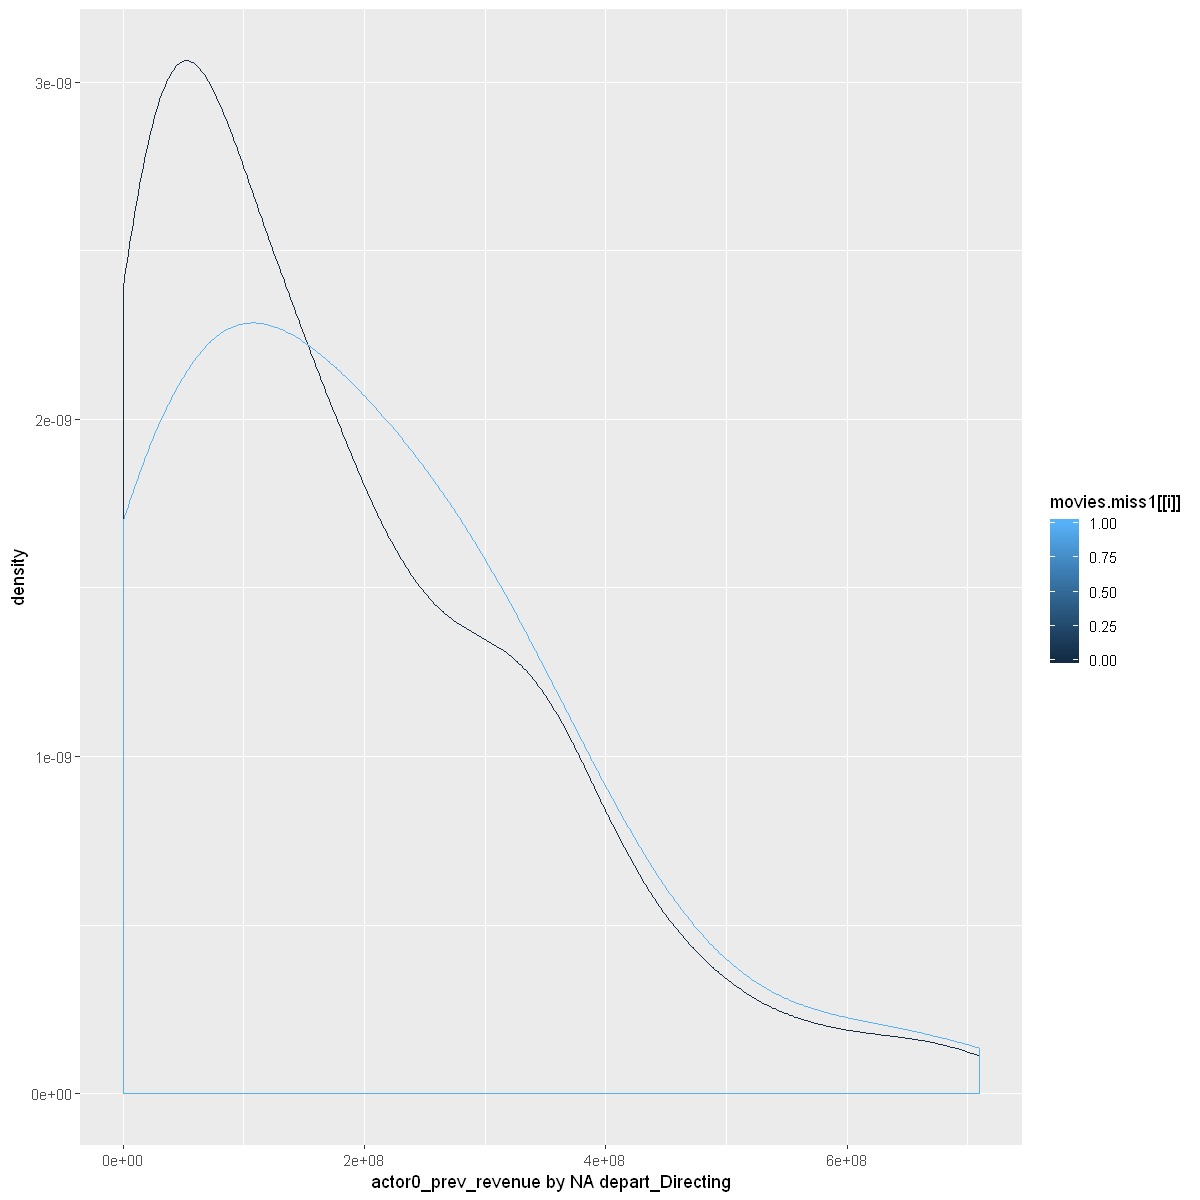


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -1.4818, df = 327.59, p-value = 0.1394
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -28743663   4045425
sample estimates:
mean of x mean of y 
144270520 156619639 

[1] "actor1_prev_revenue by NA depart_Directing"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


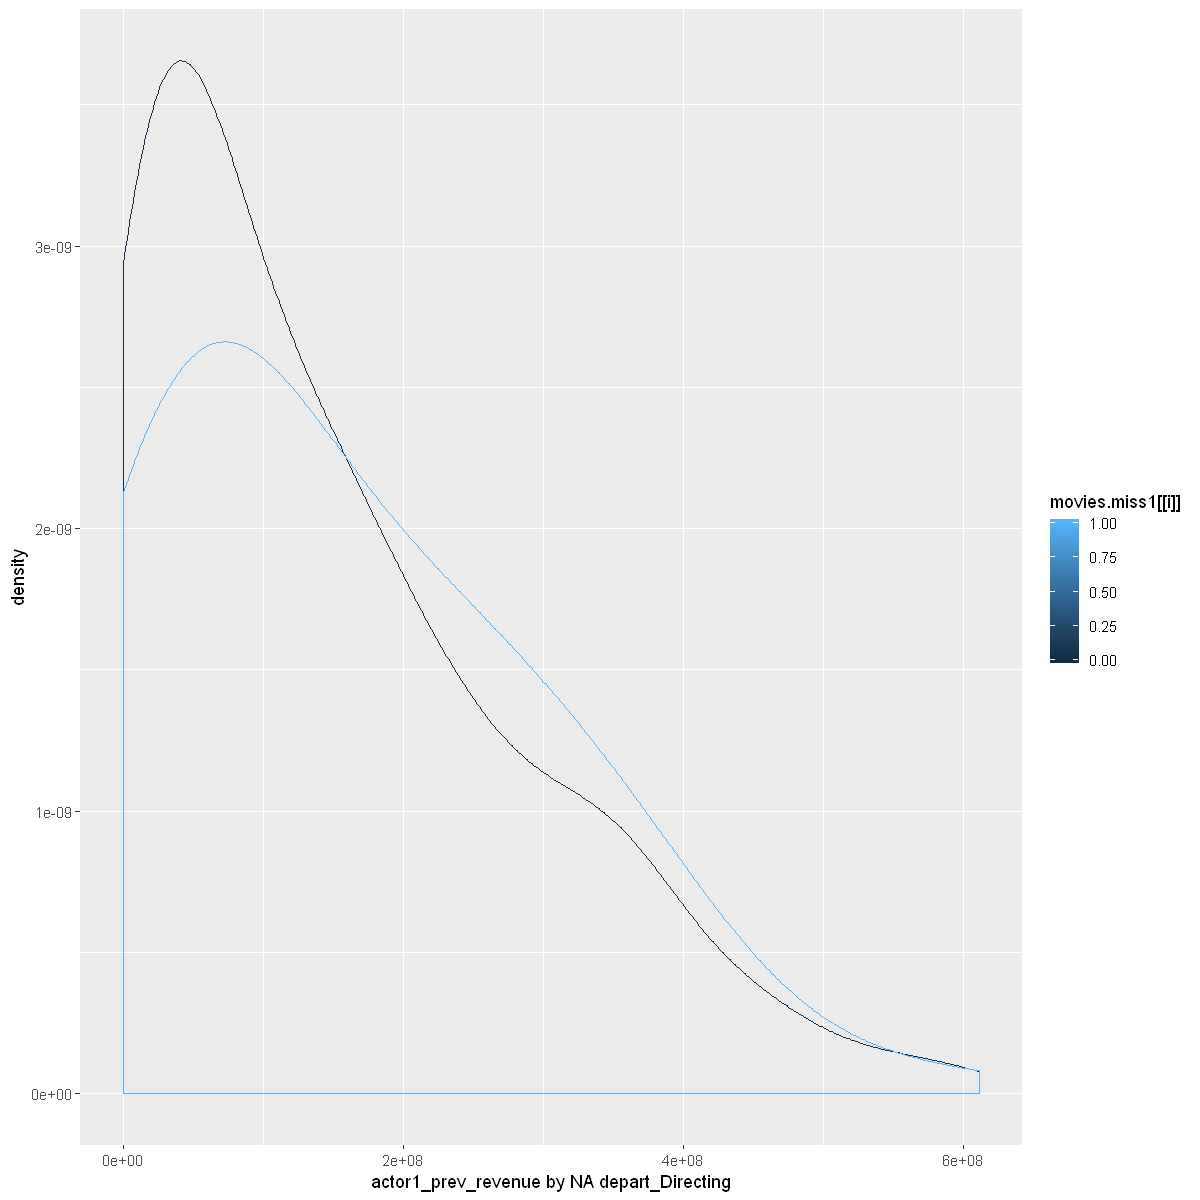


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -2.7899, df = 300.52, p-value = 0.005609
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -40361446  -6973283
sample estimates:
mean of x mean of y 
132091075 155758440 

[1] "actor2_prev_revenue by NA depart_Directing"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


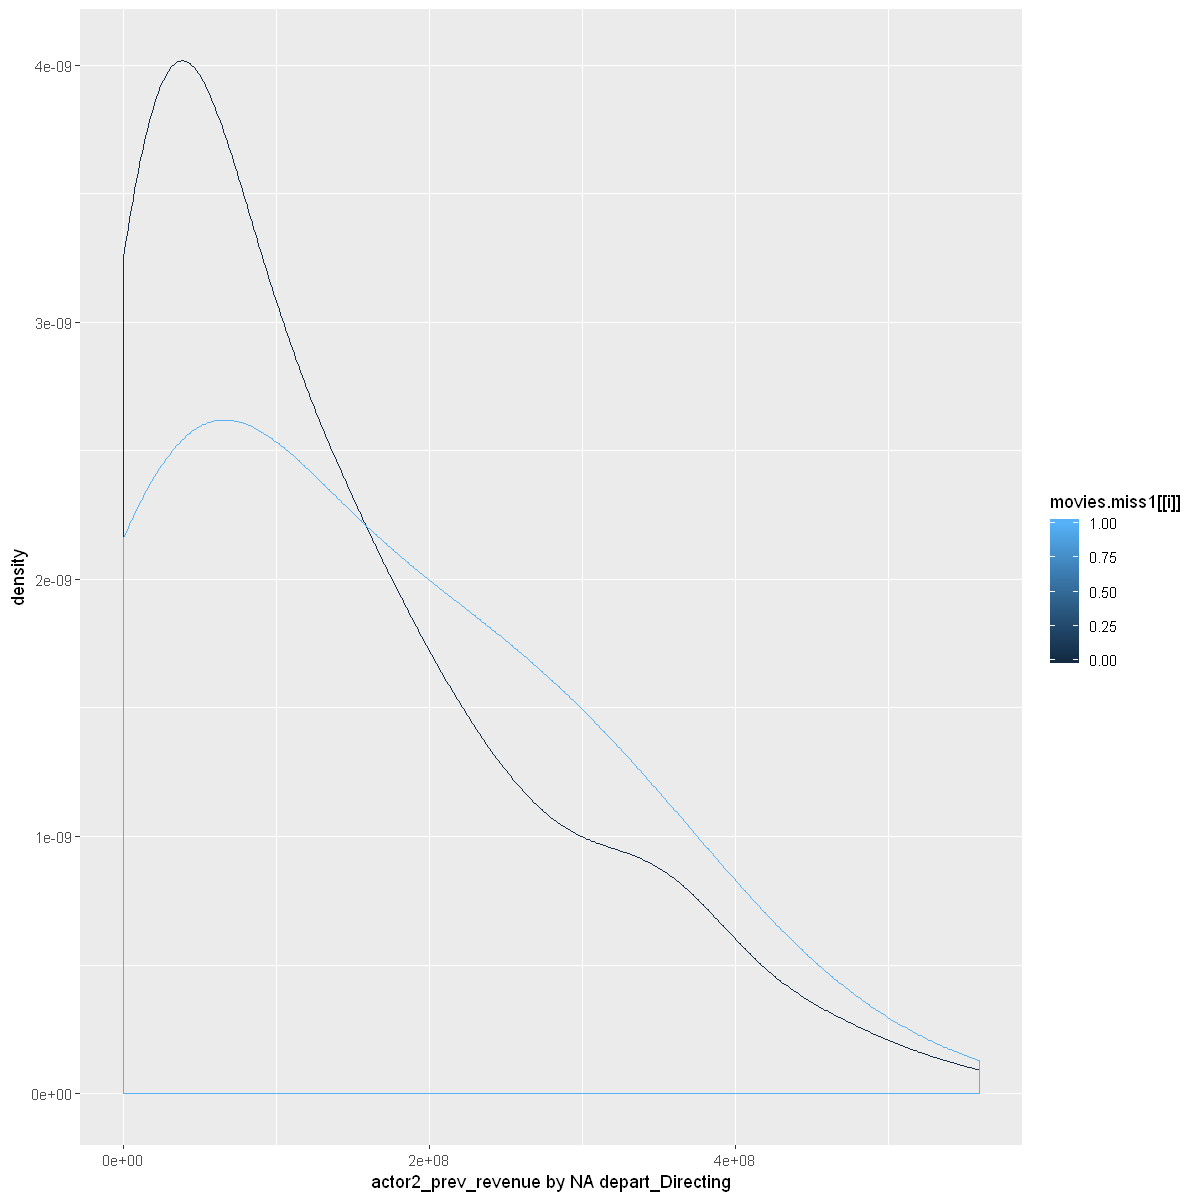


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -3.4908, df = 519.84, p-value = 0.0005225
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5020740 -0.1404688
sample estimates:
mean of x mean of y 
 1.332408  1.653680 

[1] "director_movies_cnt by NA depart_Directing"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


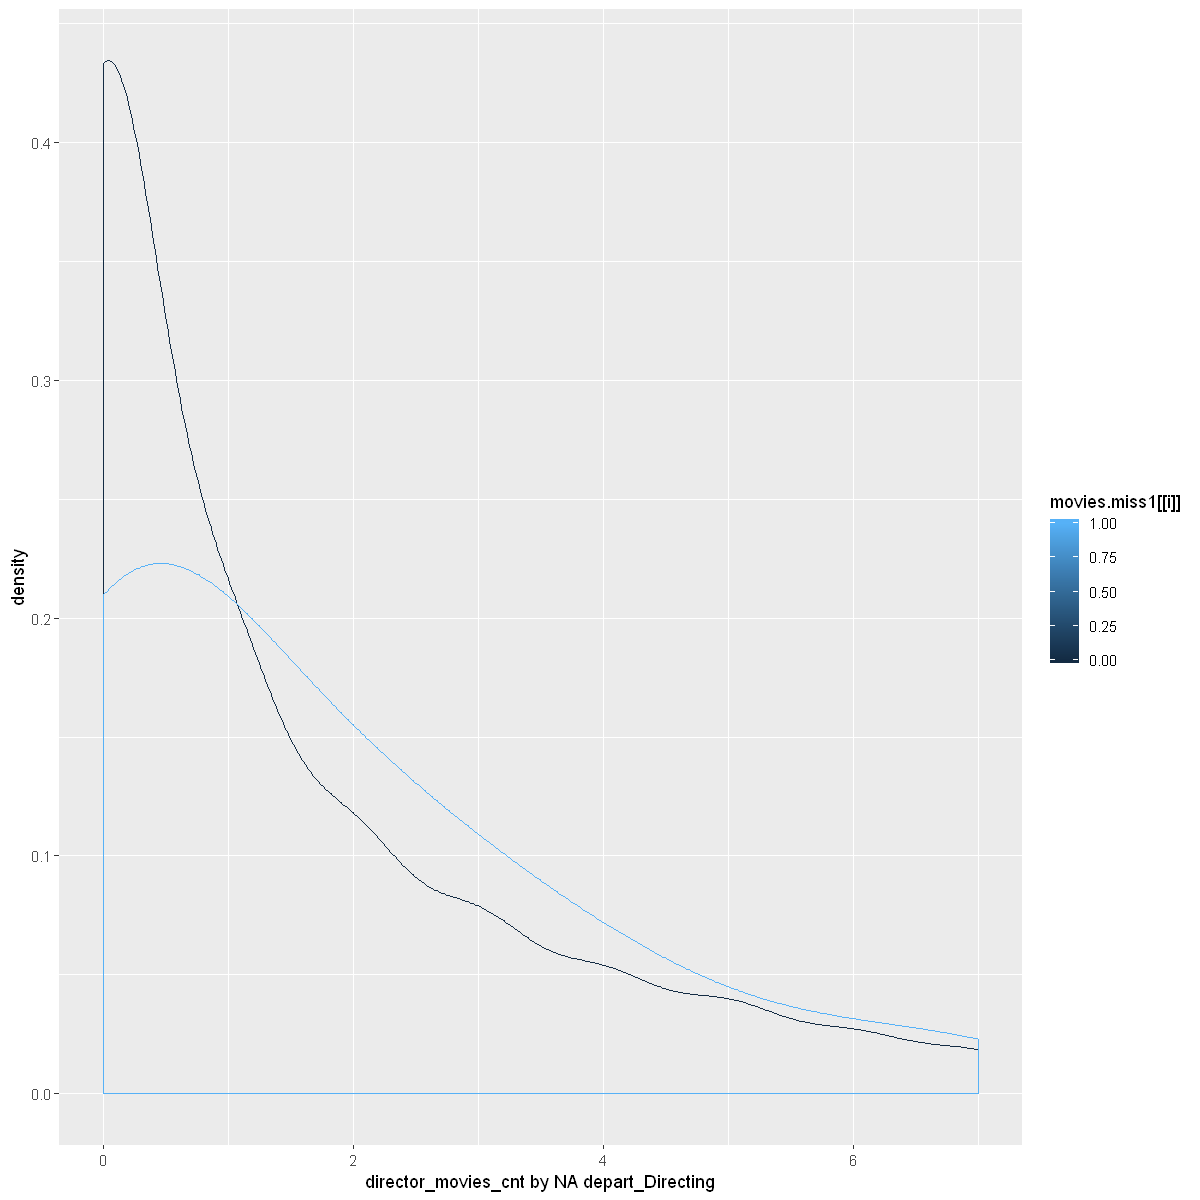


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -11.56, df = 260.68, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.770756 -1.255296
sample estimates:
mean of x mean of y 
 1.552015  3.065041 

[1] "depart_Art by NA depart_Directing"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


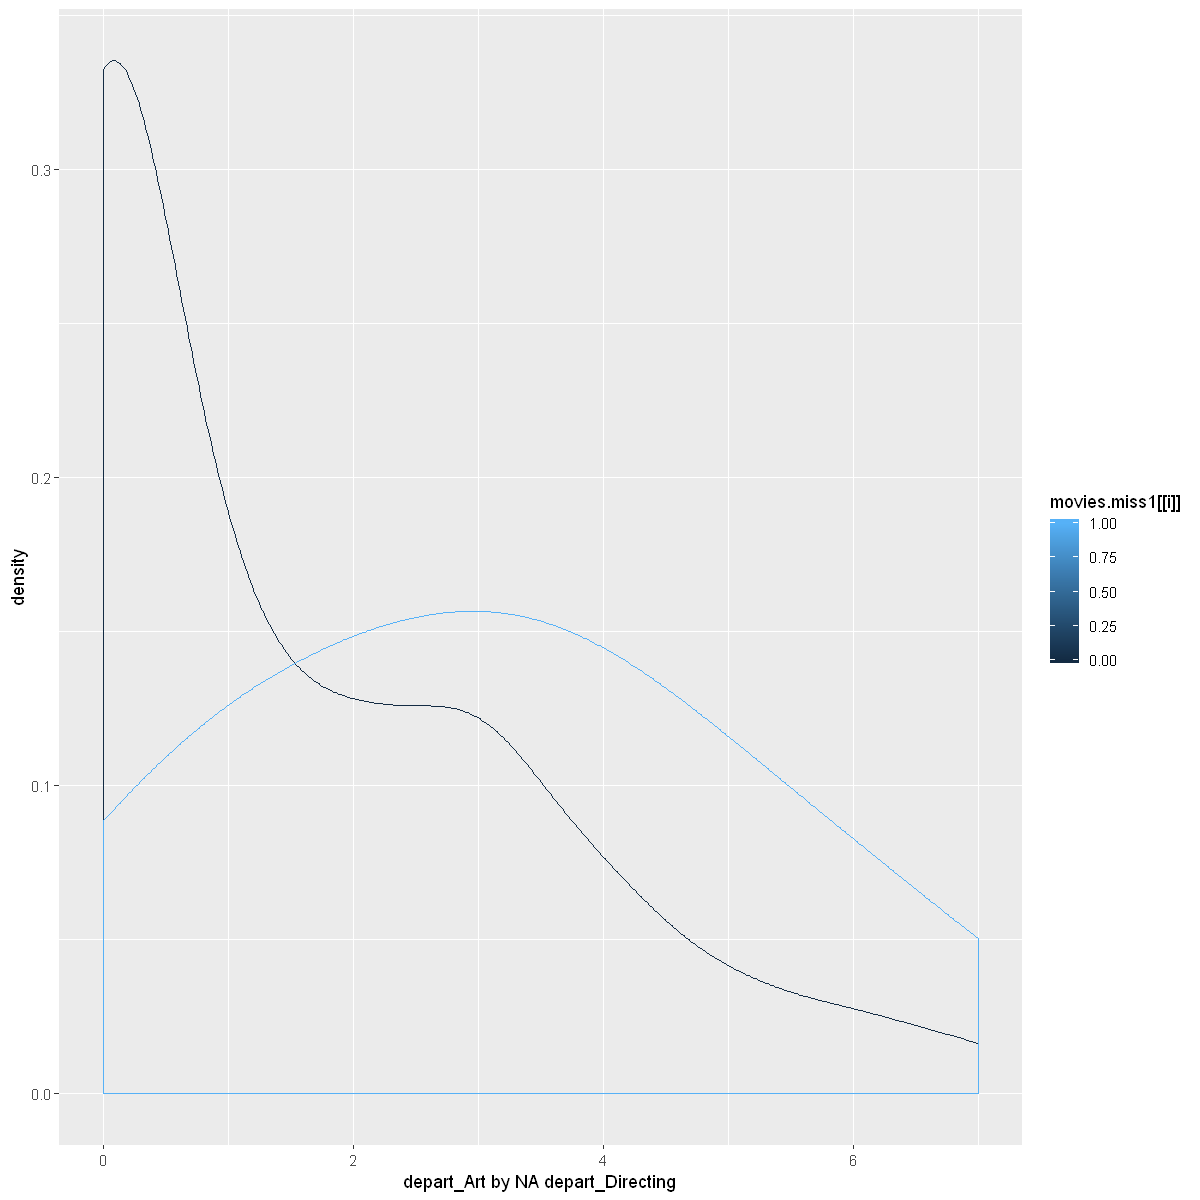


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -8.9328, df = 261.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1670083 -0.7454462
sample estimates:
mean of x mean of y 
 1.075269  2.031496 

[1] "depart_Camera by NA depart_Directing"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


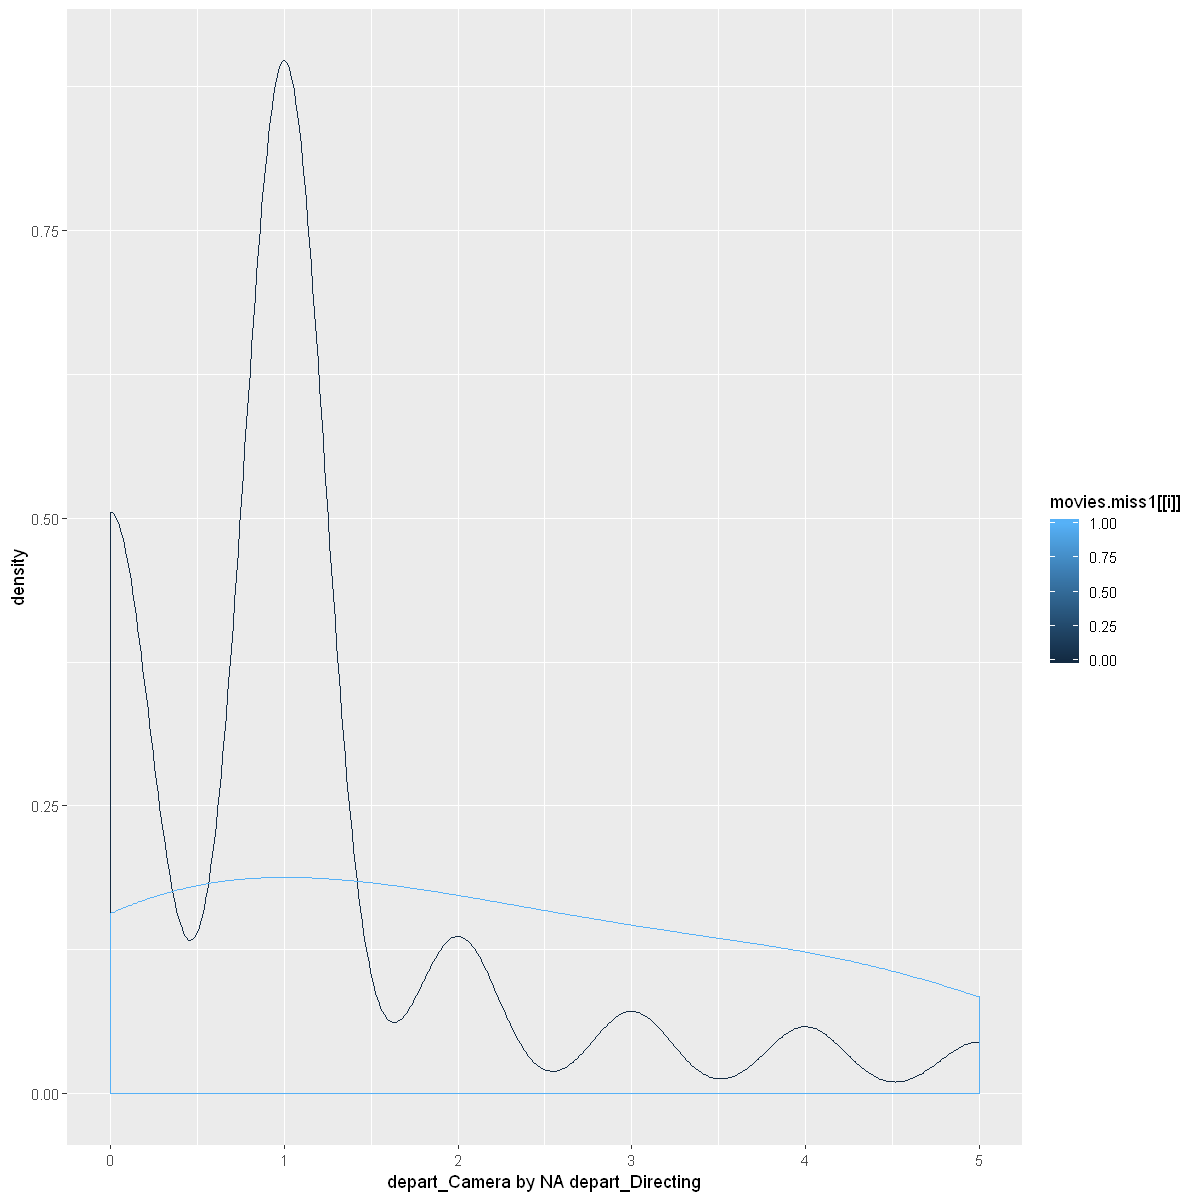


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -7.2452, df = 218.98, p-value = 7.285e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1746002 -0.6722221
sample estimates:
mean of x mean of y 
0.8465419 1.7699531 

[1] "depart_Custom_Mkup by NA depart_Directing"


Warning message:
"Removed 1283 rows containing non-finite values (stat_density)."


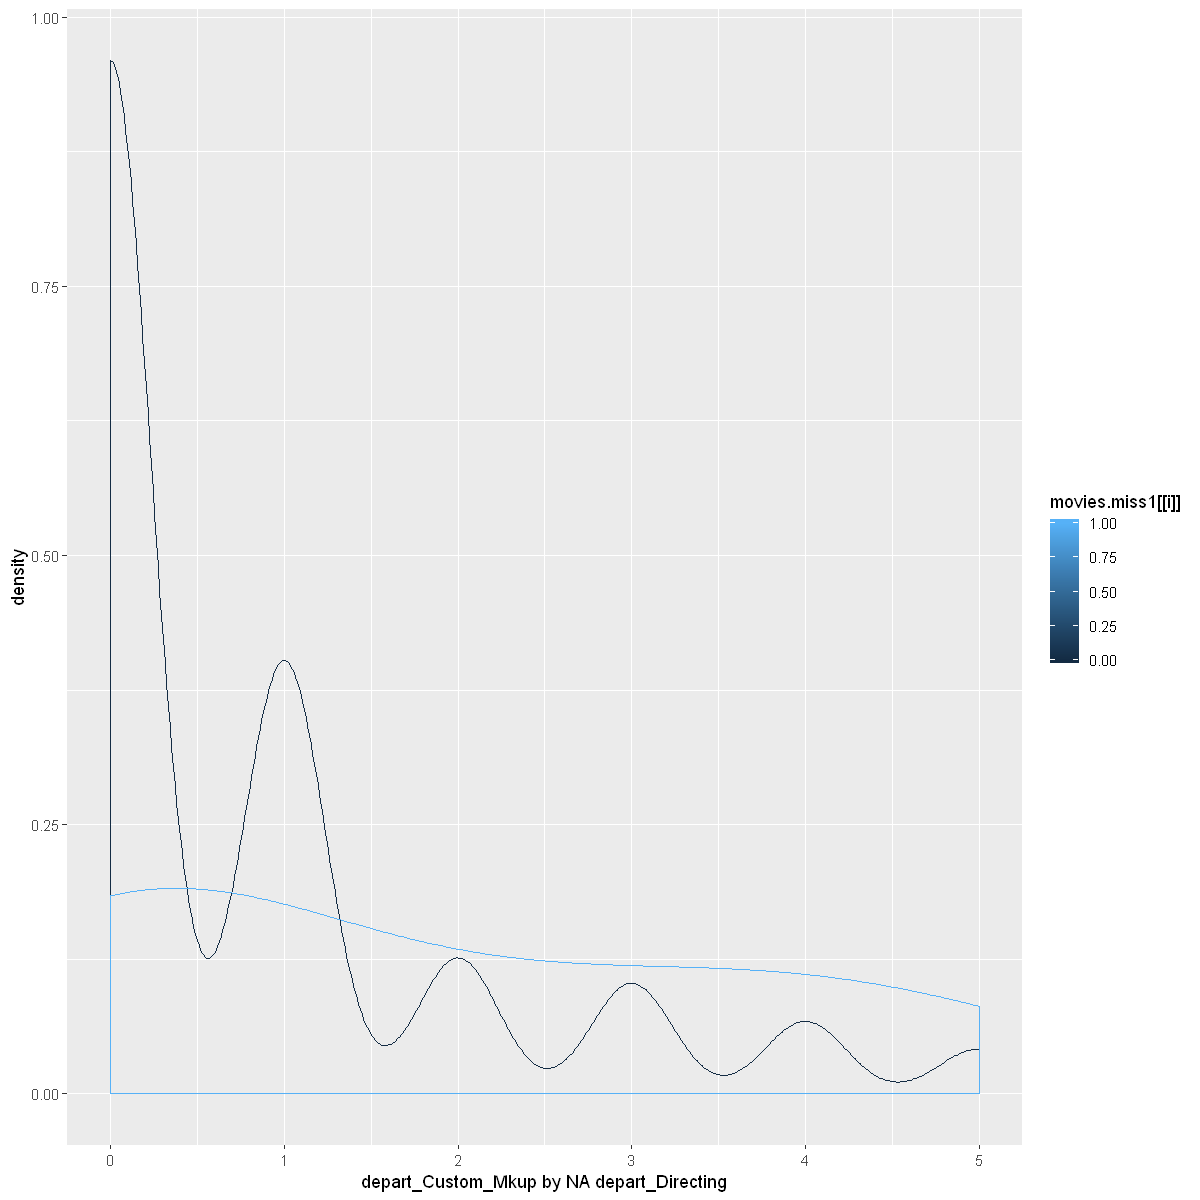


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.672, df = 178.07, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.816707 -1.249703
sample estimates:
mean of x mean of y 
 1.219669  2.752874 

[1] "depart_Sound by NA depart_Directing"


Warning message:
"Removed 2406 rows containing non-finite values (stat_density)."


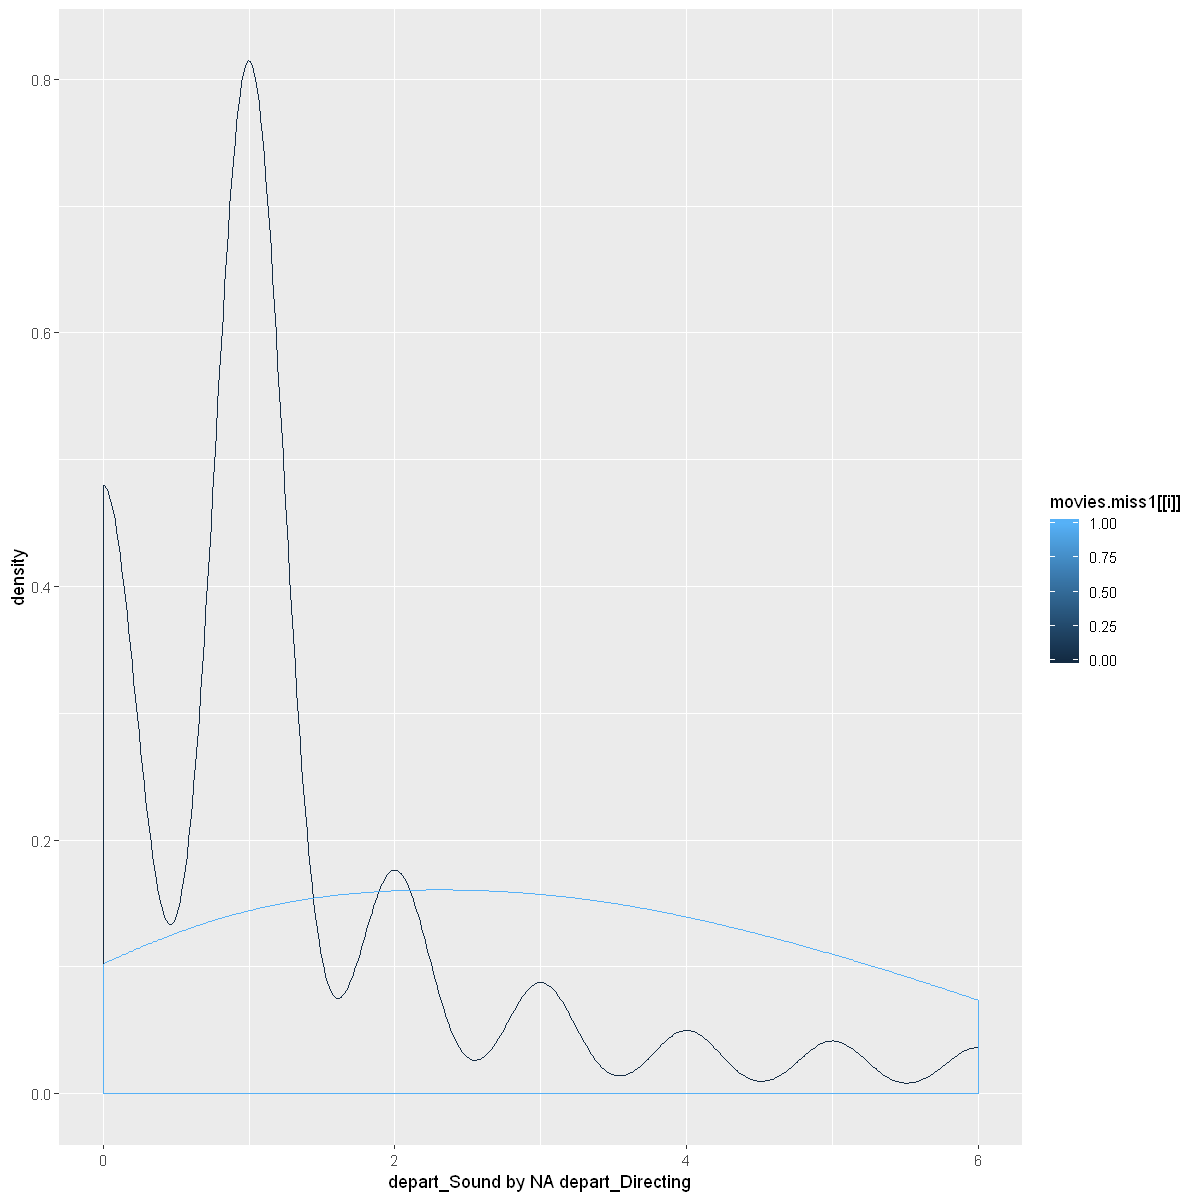


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -17.468, df = 1257.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -16924408 -13506730
sample estimates:
mean of x mean of y 
 19226151  34441721 

[1] "budget by NA depart_Sound"


Warning message:
"Removed 395 rows containing non-finite values (stat_density)."


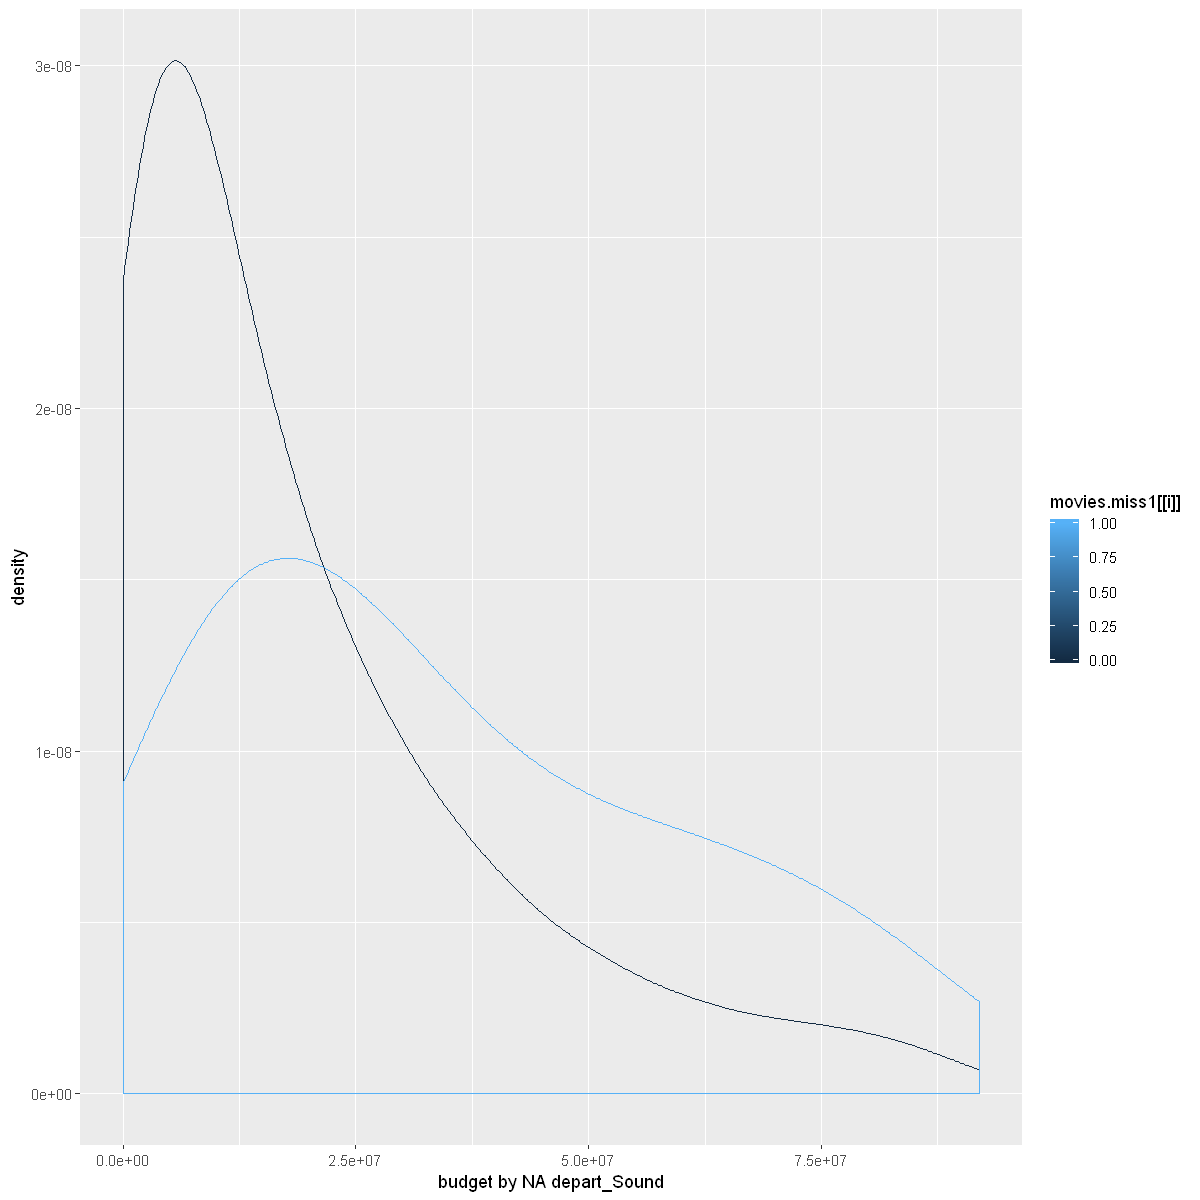


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -14.98, df = 1749.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1911969 -0.9153831
sample estimates:
mean of x mean of y 
 2.715337  3.768627 

[1] "producers_cnt by NA depart_Sound"


Warning message:
"Removed 411 rows containing non-finite values (stat_density)."


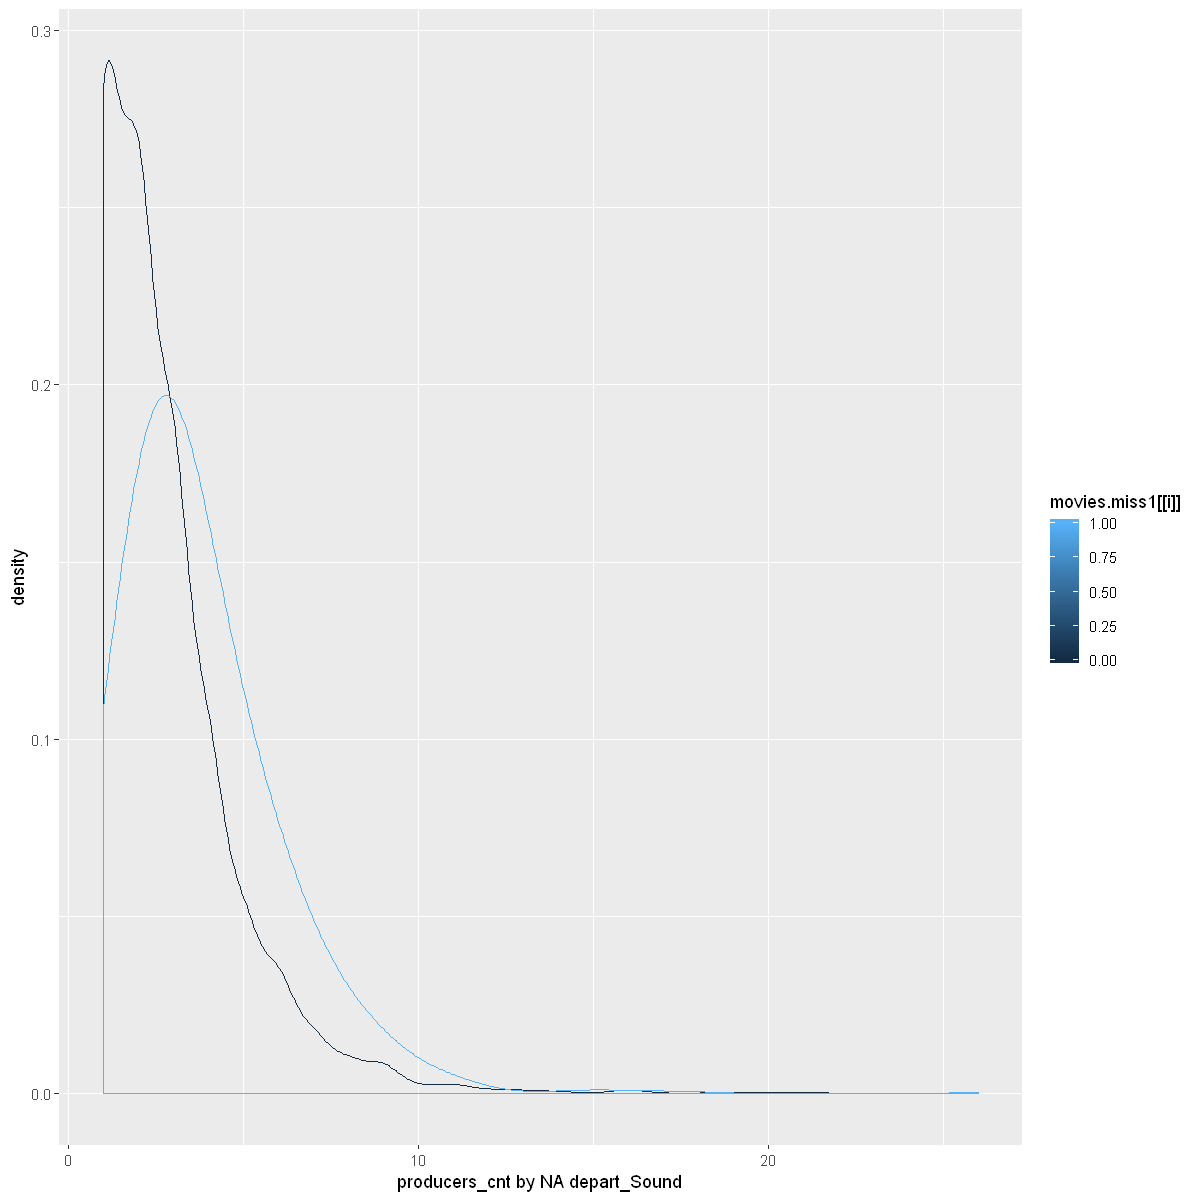


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -11.268, df = 1519.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.370163 -1.667318
sample estimates:
mean of x mean of y 
 3.727618  5.746358 

[1] "actor1_movies_cnt by NA depart_Sound"


Warning message:
"Removed 507 rows containing non-finite values (stat_density)."


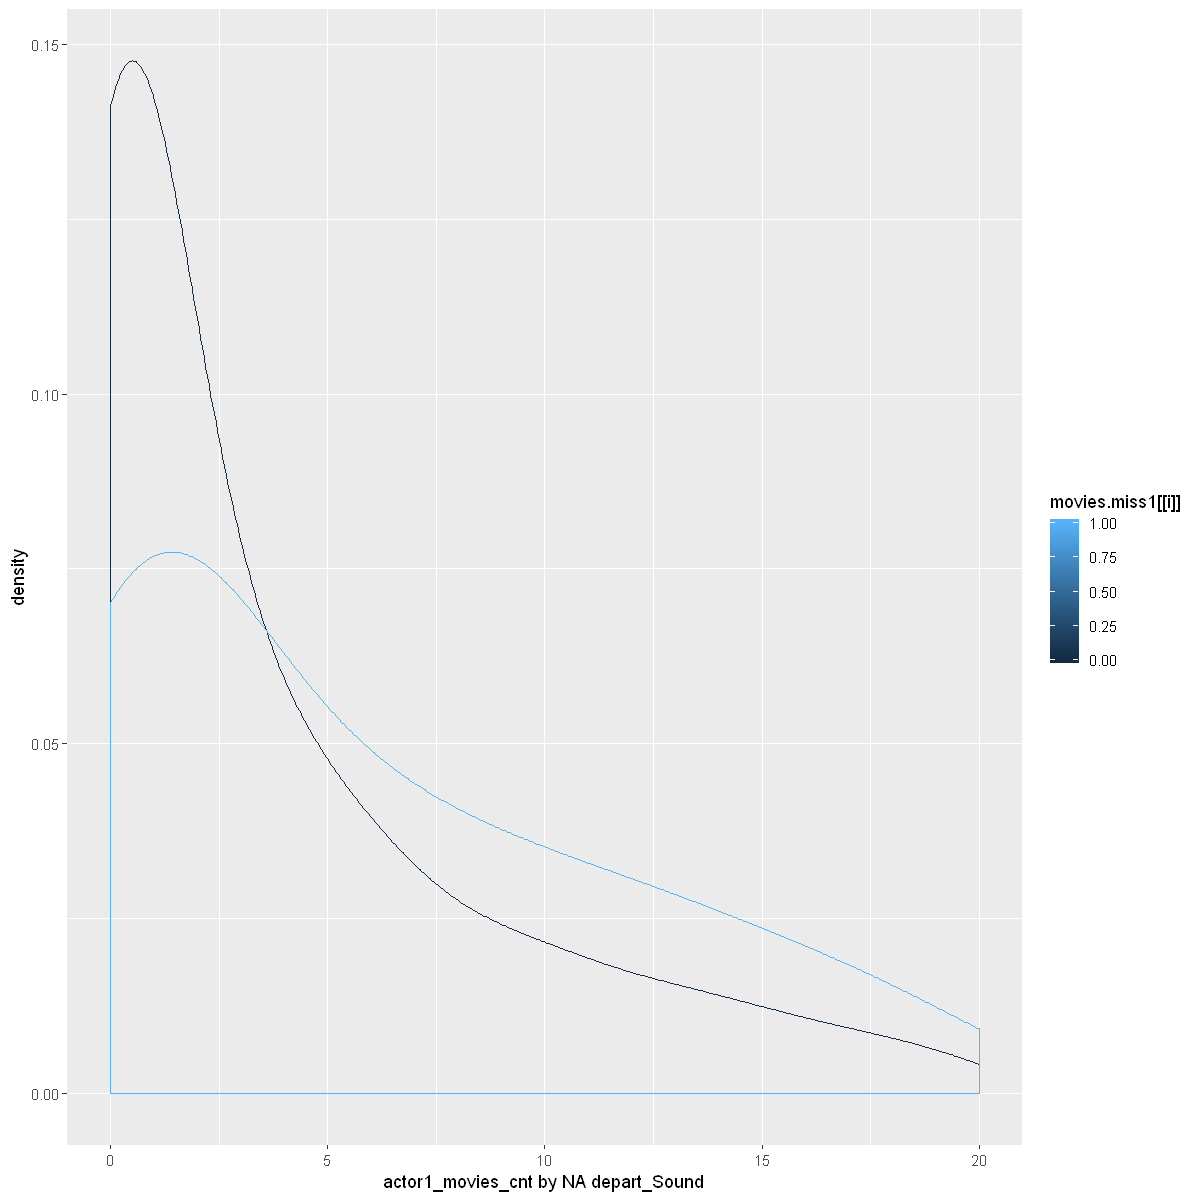


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.36, df = 1453.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.894254 -1.291129
sample estimates:
mean of x mean of y 
 3.029412  4.622103 

[1] "actor2_movies_cnt by NA depart_Sound"


Warning message:
"Removed 3033 rows containing non-finite values (stat_density)."


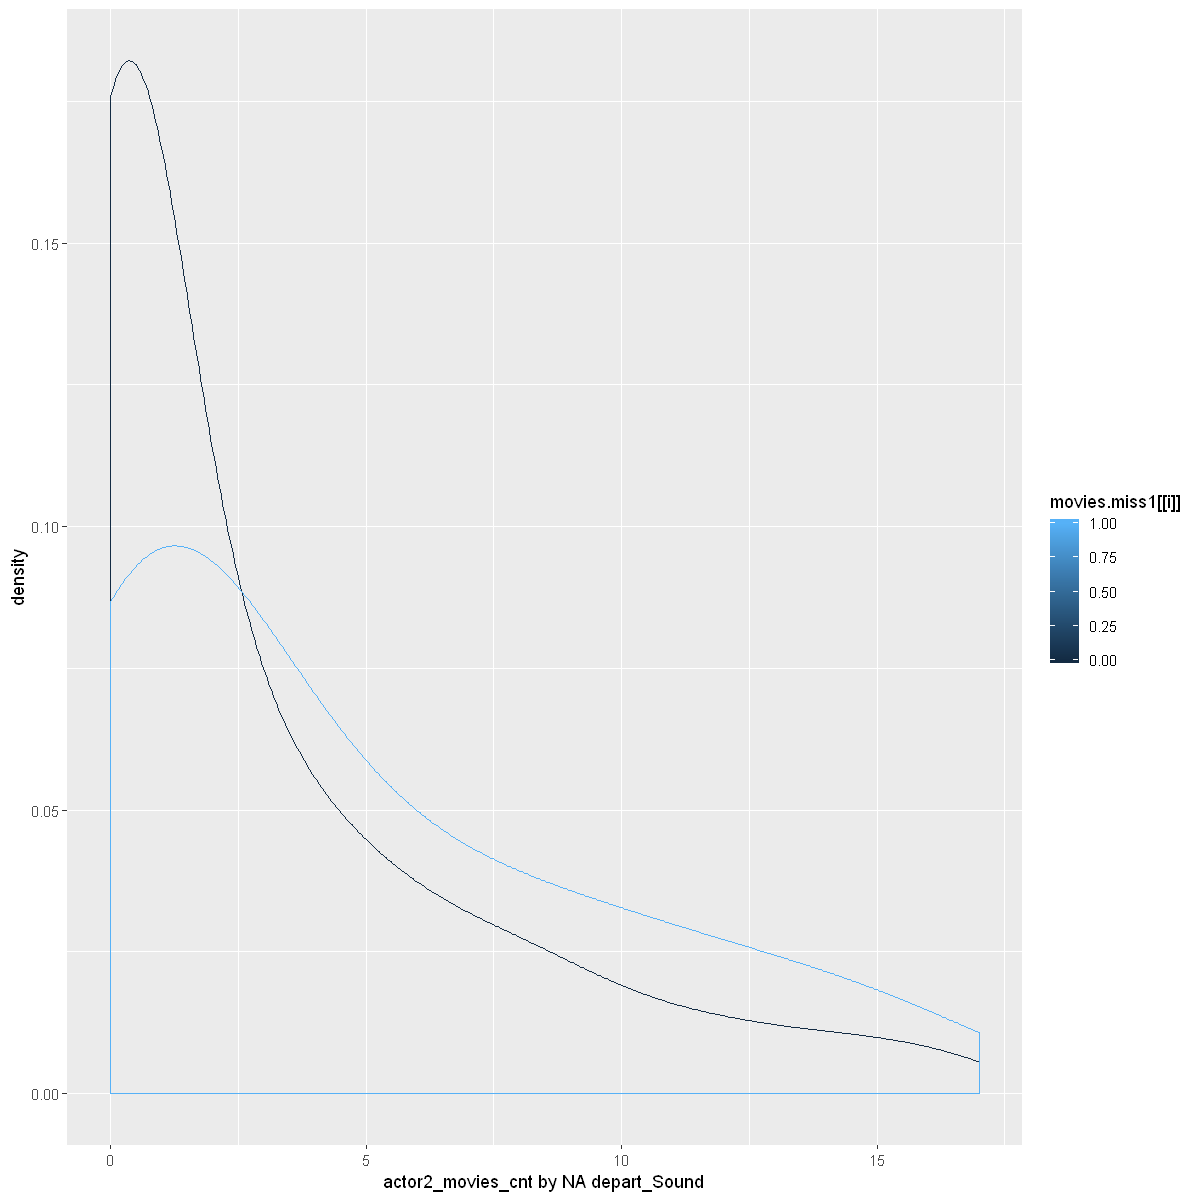


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -10.98, df = 1228.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -82391048 -57411307
sample estimates:
mean of x mean of y 
160909528 230810706 

[1] "actor0_prev_revenue by NA depart_Sound"


Warning message:
"Removed 3527 rows containing non-finite values (stat_density)."


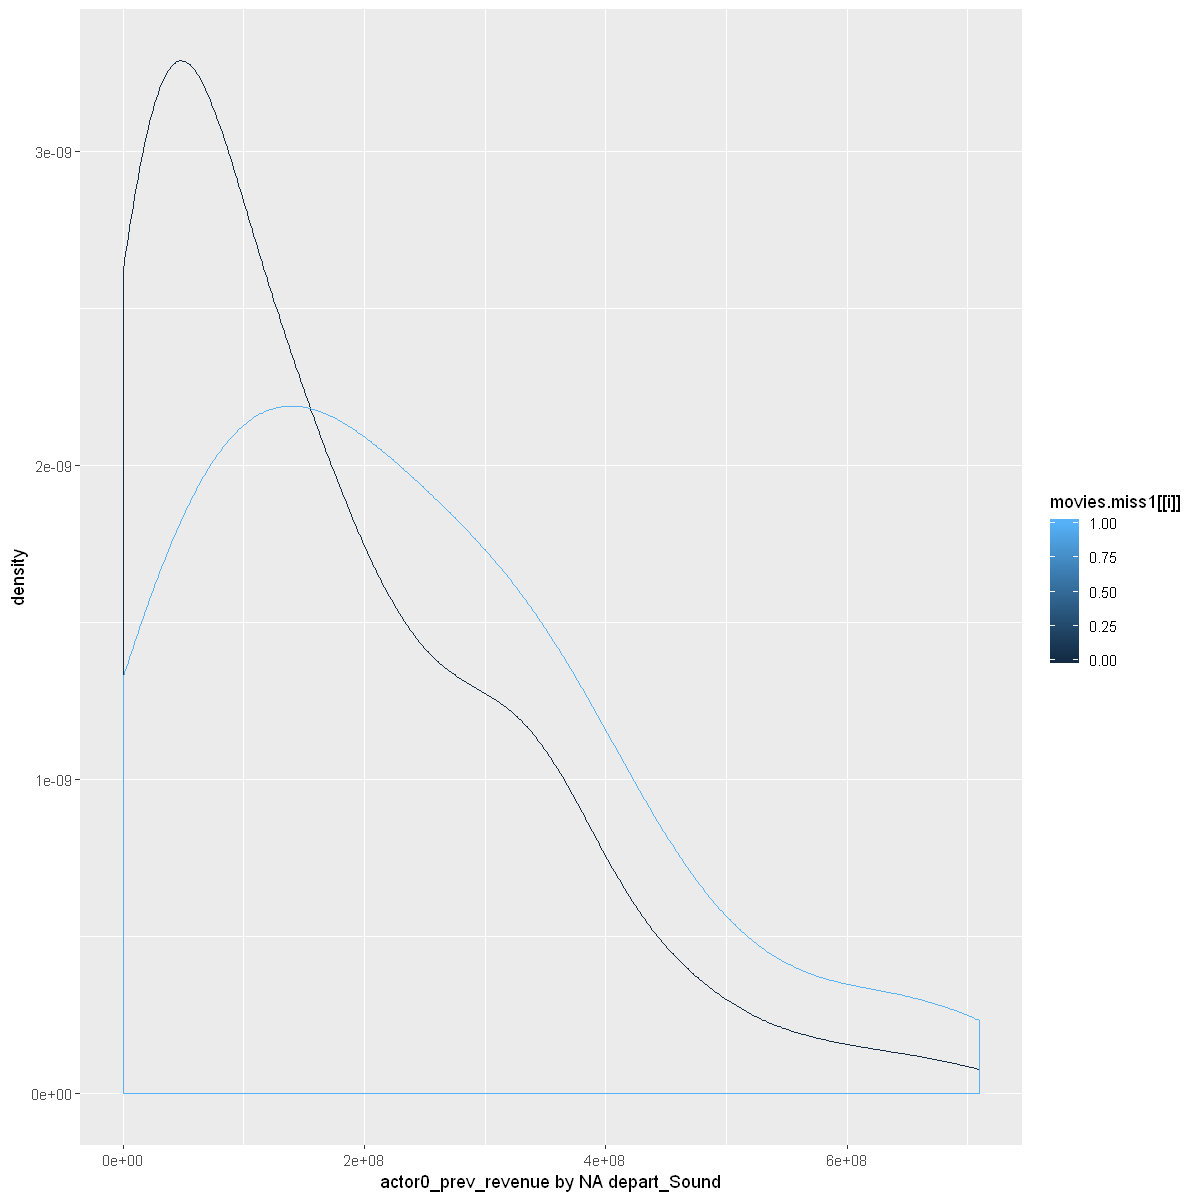


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.7085, df = 1200.6, p-value = 3.022e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -46849826 -25647477
sample estimates:
mean of x mean of y 
137755672 174004323 

[1] "actor1_prev_revenue by NA depart_Sound"


Warning message:
"Removed 3754 rows containing non-finite values (stat_density)."


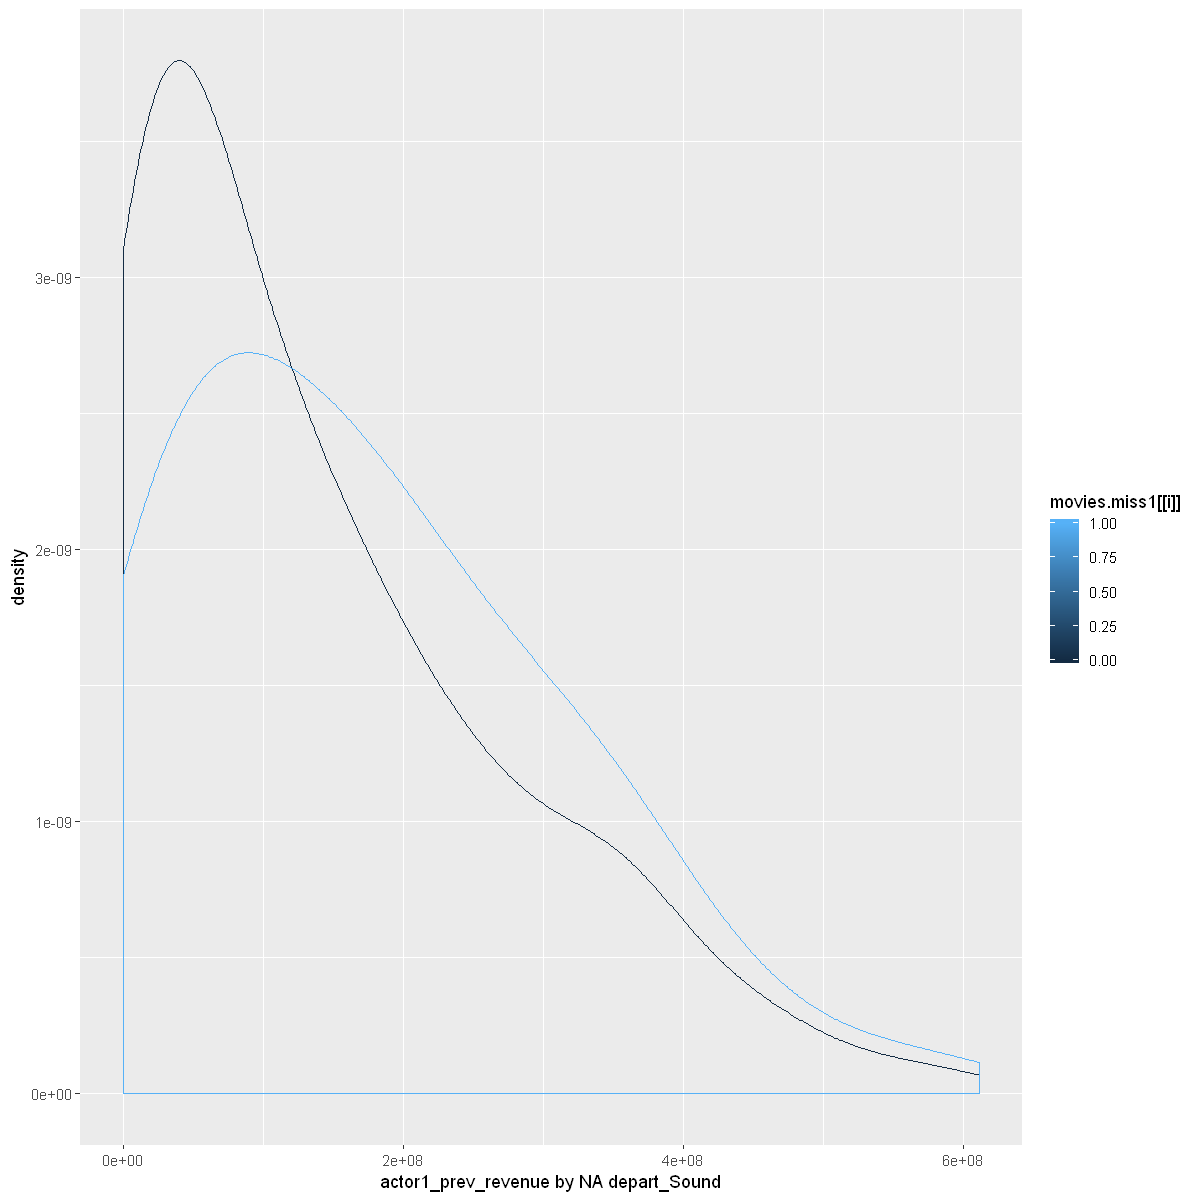


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -6.2152, df = 1156.7, p-value = 7.144e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -43256153 -22498550
sample estimates:
mean of x mean of y 
126918639 159795990 

[1] "actor2_prev_revenue by NA depart_Sound"


Warning message:
"Removed 427 rows containing non-finite values (stat_density)."


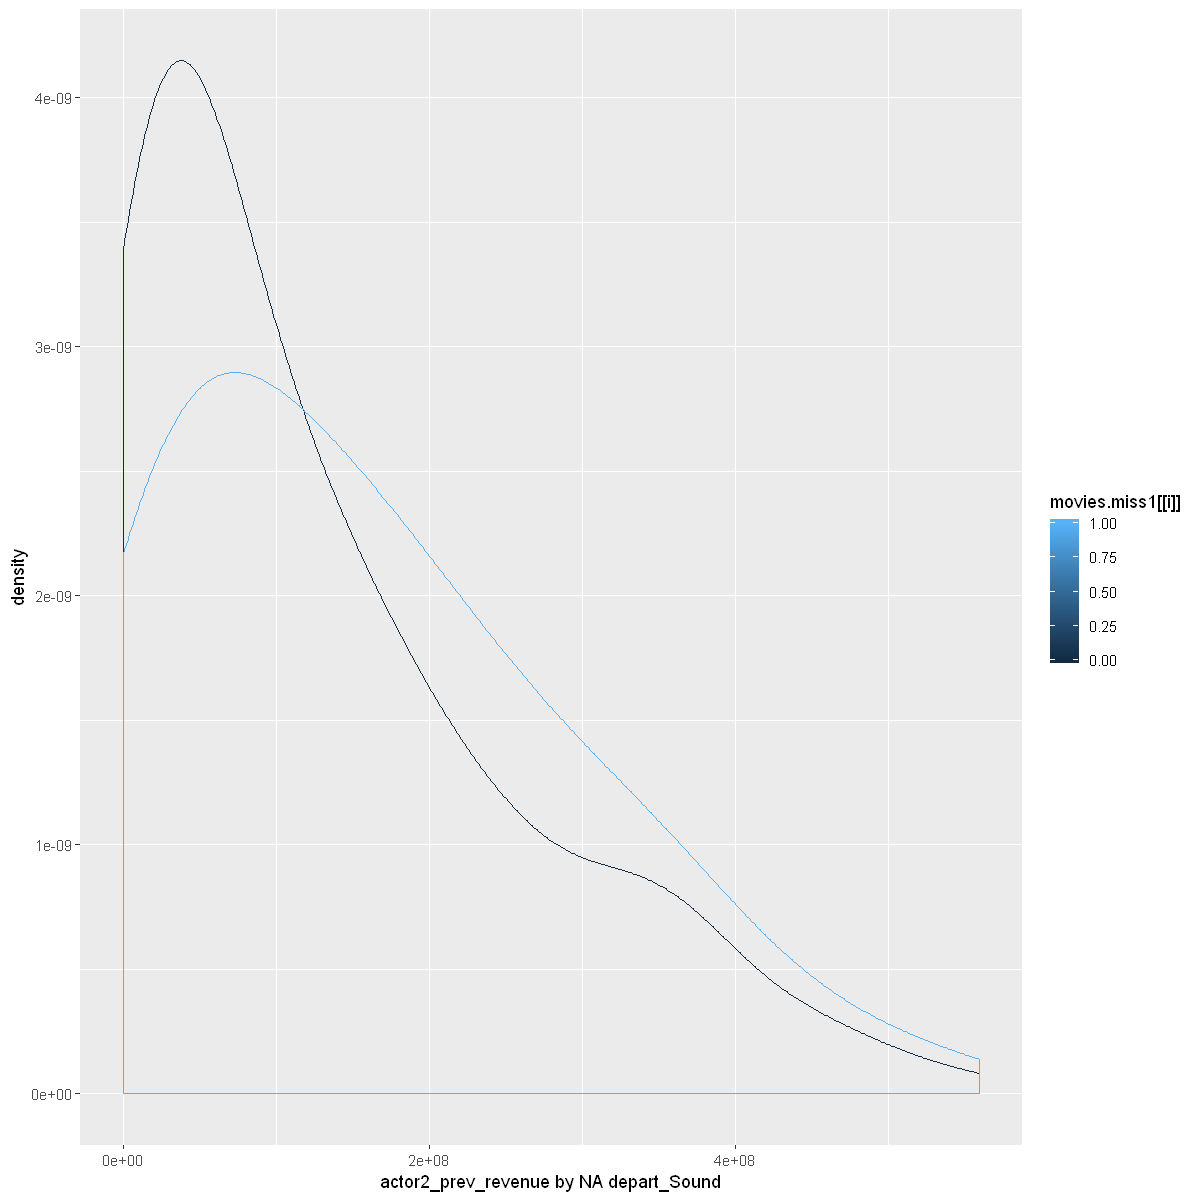


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -11.308, df = 1489, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.8547432 -0.6020363
sample estimates:
mean of x mean of y 
 1.233316  1.961706 

[1] "director_movies_cnt by NA depart_Sound"


Warning message:
"Removed 727 rows containing non-finite values (stat_density)."


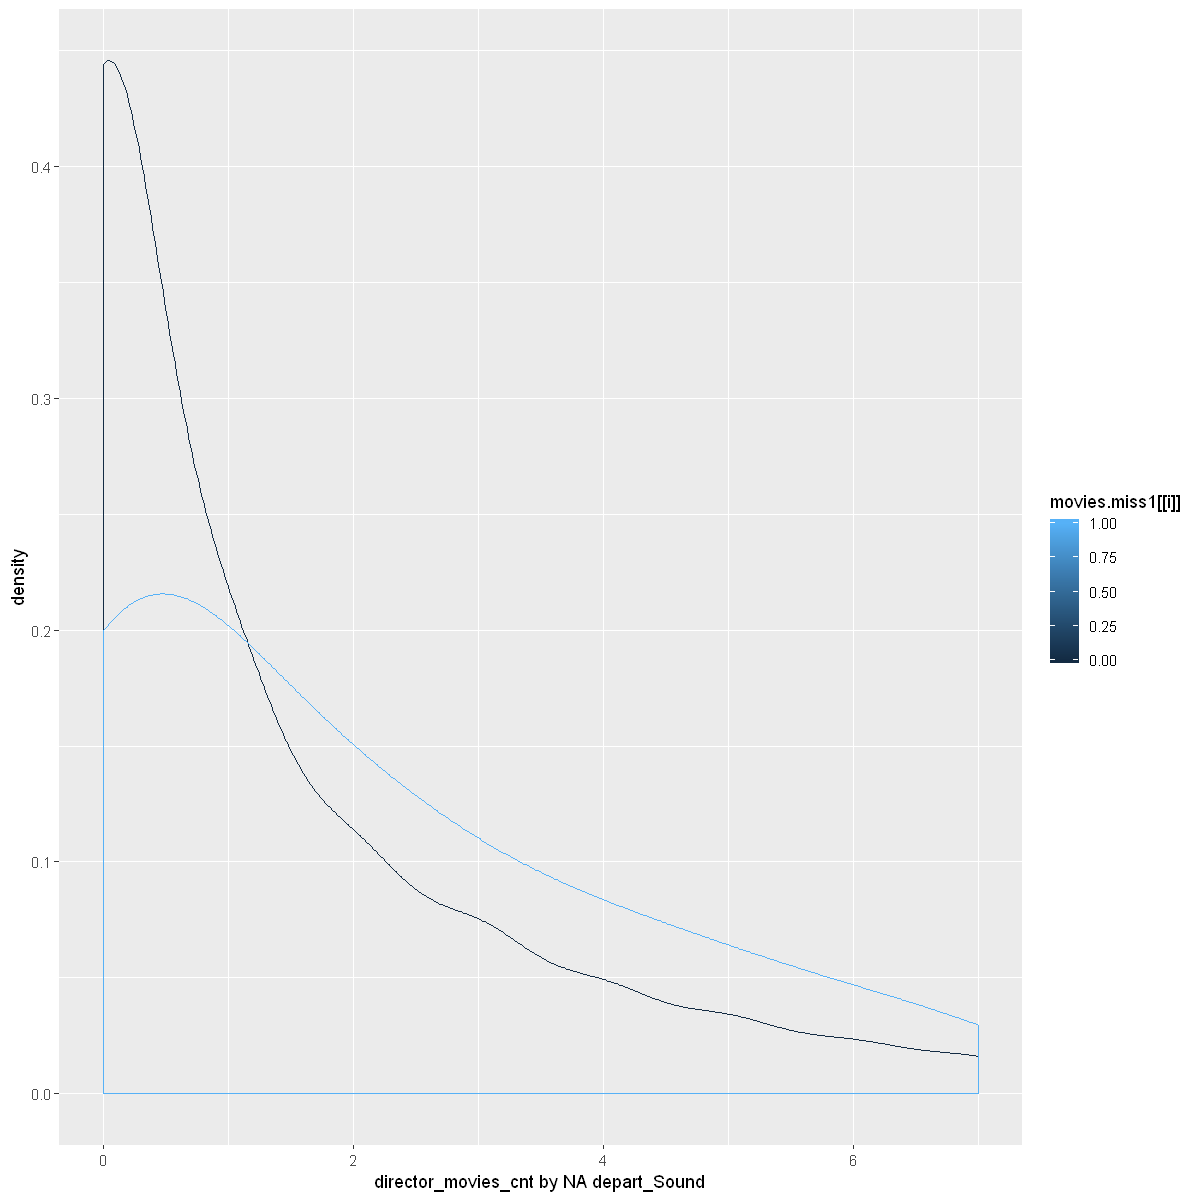


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -41.753, df = 785.5, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.113331 -2.833736
sample estimates:
mean of x mean of y 
 1.314138  4.287671 

[1] "depart_Art by NA depart_Sound"


Warning message:
"Removed 704 rows containing non-finite values (stat_density)."


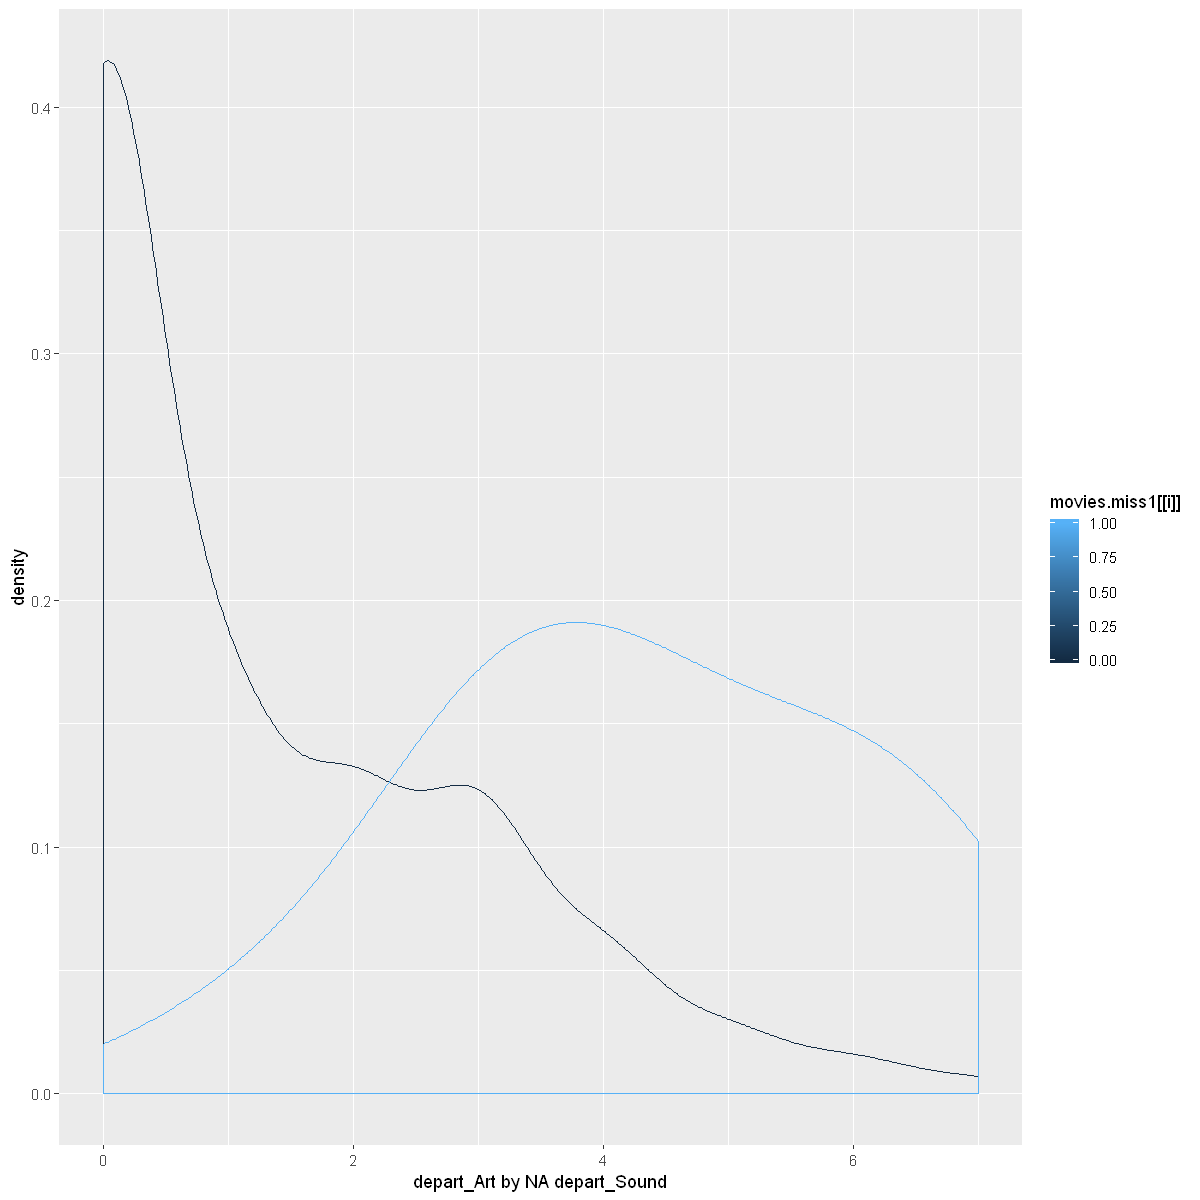


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -36.395, df = 701.55, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.308122 -2.071841
sample estimates:
mean of x mean of y 
0.8973081 3.0872894 

[1] "depart_Camera by NA depart_Sound"


Warning message:
"Removed 1017 rows containing non-finite values (stat_density)."


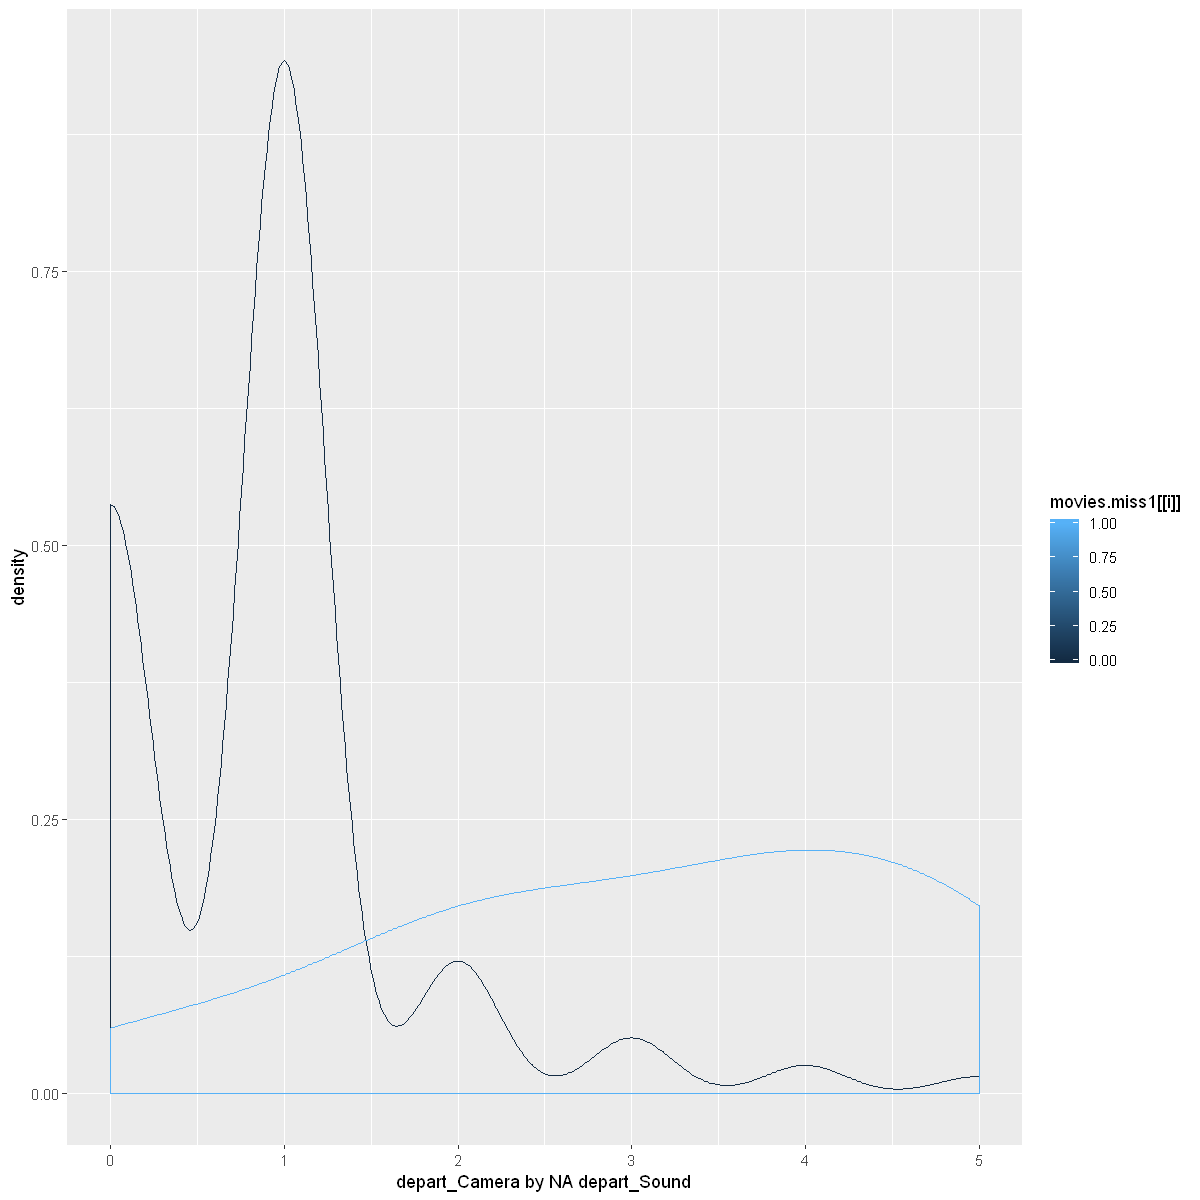


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -27.507, df = 544.66, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.197444 -1.904511
sample estimates:
mean of x mean of y 
0.7148958 2.7658730 

[1] "depart_Custom_Mkup by NA depart_Sound"


Warning message:
"Removed 513 rows containing non-finite values (stat_density)."


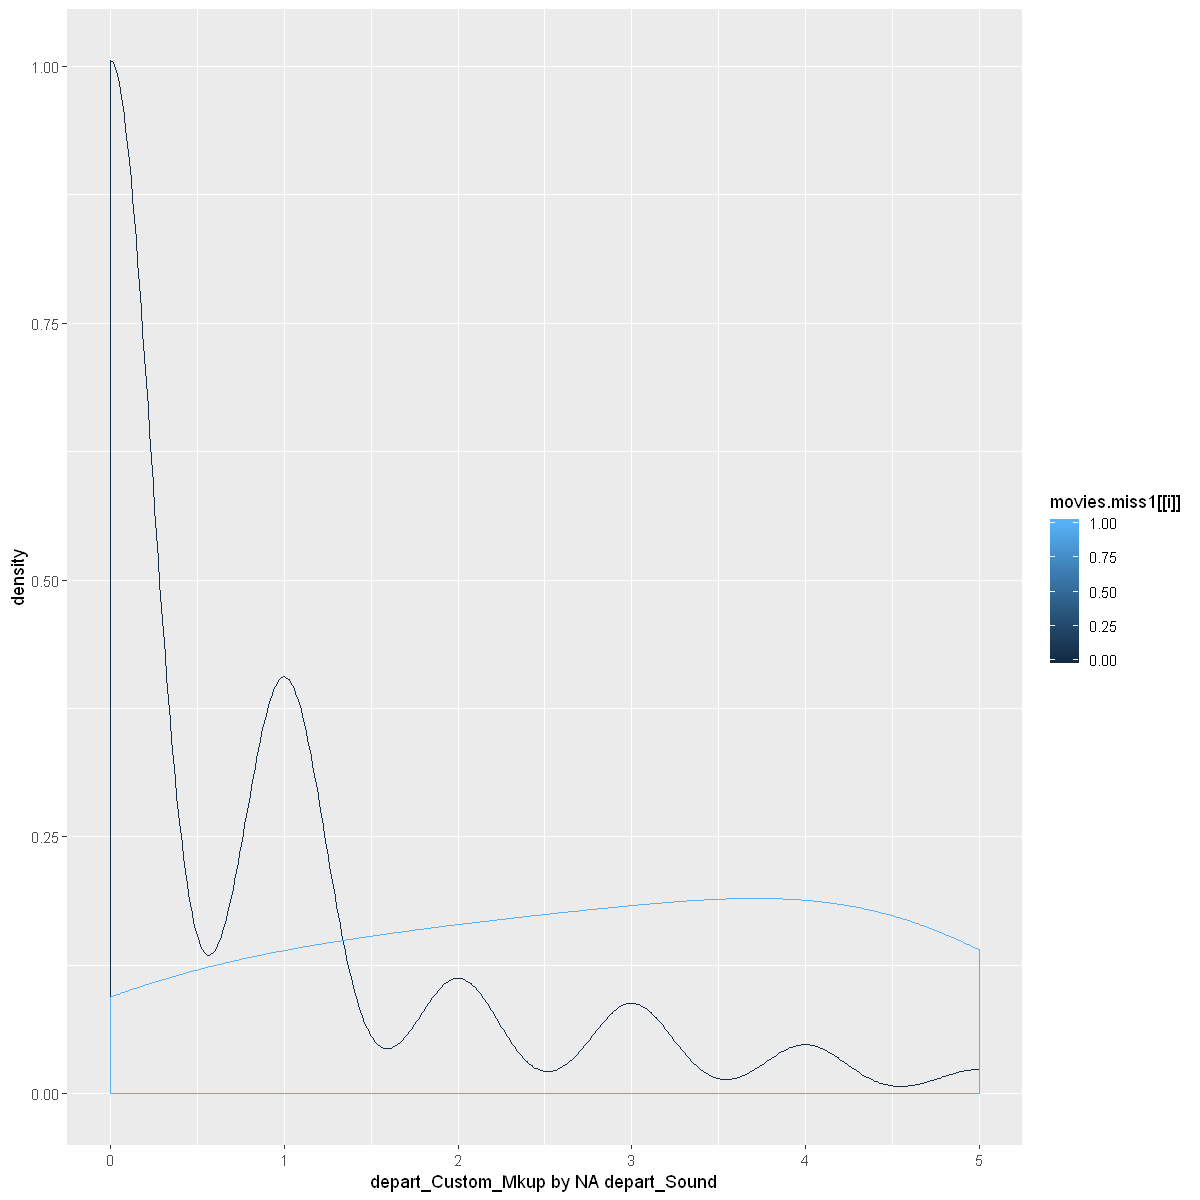


	Welch Two Sample t-test

data:  b1[[j]] and b2[[j]]
t = -44.993, df = 1170.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0225131 -0.9370623
sample estimates:
mean of x mean of y 
 1.277628  2.257415 

[1] "depart_Directing by NA depart_Sound"


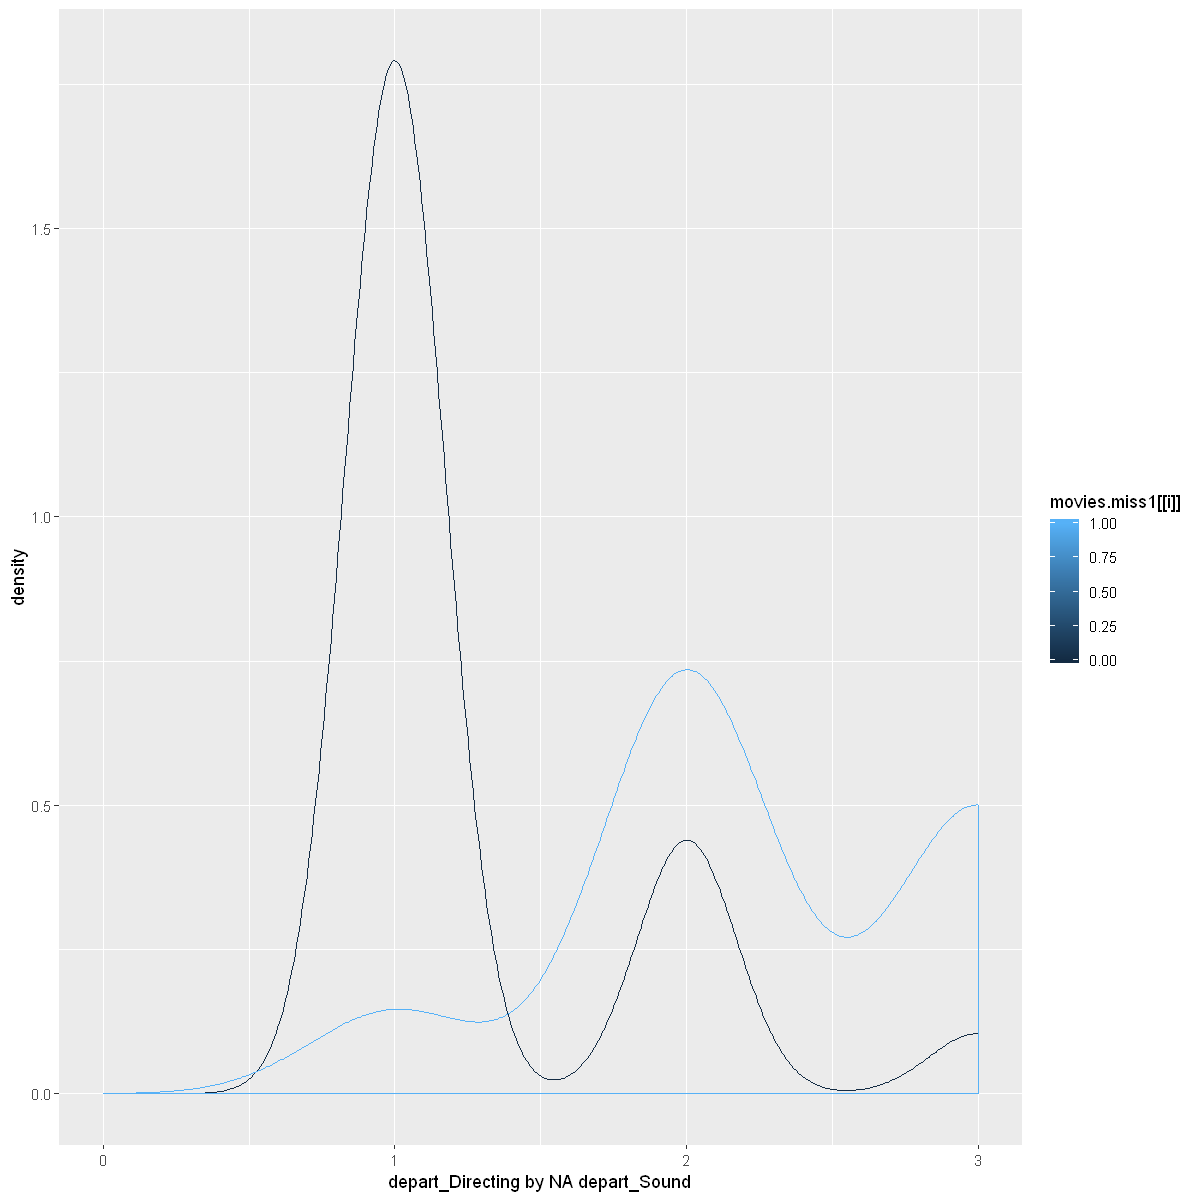

In [421]:
options(repr.plot.width=10,repr.plot.height=10)
par(mfrow=c(2,2))
for (i in l2){
    for (j in l2){
        if (i!=j) {
        print(ggplot(movies_ff_v1,aes(x=movies_ff_v1[[j]], group=factor(movies.miss1[[i]]),
                             color=factor(movies.miss1[[i]]))) +
geom_density(adjust=2)+labs(x=paste(j,'by NA',i,sep=' ')))
         b1<- movies_ff_v1 %>% select(j,i) %>% filter(movies.miss1[i]==0)  
         b2<-movies_ff_v1 %>% select(j,i) %>% filter(movies.miss1[i]==1) 
         print(t.test(b1[[j]],b2[[j]]))  
         print(paste(j,'by NA',i,sep=' '))
       }
    }
}

3.2.2 table of the missingness mechanism 

In [449]:
movies.na <- movies_ff_v1[,l2]

In [450]:
head(movies.na)

budget   producers_cnt actor1_movies_cnt actor2_movies_cnt
1 14000000  3            13                 8               
2 40000000  1            10                13               
3  3300000  3            NA                 0               
4  1200000 NA             2                 0               
5       NA NA             1                 0               
6  8000000 NA             0                 0               
  actor0_prev_revenue actor1_prev_revenue actor2_prev_revenue
1 116980662           219076518           121463226          
2 165335153           165335153           309457509          
3  48065672           231411584                  NA          
4   4100000                  NA                  NA          
5        NA                  NA                  NA          
6        NA                  NA                  NA          
  director_movies_cnt depart_Art depart_Camera depart_Custom_Mkup
1  3                  NA         NA            NA                
2 NA                   0          1             0                
3  0                   5          4             5                
4  0                   0          0             0                
5  0                   0          0             0                
6  0                   1          0             0                
  depart_Directing depart_Sound
1 NA               NA          
2  1                1          
3  3               NA          
4  1                0          
5  1                0          
6  1                0

In [451]:
getMissingness(movies.na)

[[1]]
                   var na.count rate
1  actor2_prev_revenue     3754 50.9
2  actor1_prev_revenue     3527 47.8
3  actor0_prev_revenue     3033 41.1
4               budget     2406 32.6
5         depart_Sound     1283 17.4
6   depart_Custom_Mkup     1017 13.8
7           depart_Art      727  9.9
8        depart_Camera      704  9.5
9     depart_Directing      513  7.0
10   actor2_movies_cnt      507  6.9

[[2]]
[1] "This dataset has 791 (10.7%) complete rows. Original data has 7375 rows."



$missingness
                   var na.count rate
1  actor2_prev_revenue     3754 50.9
2  actor1_prev_revenue     3527 47.8
3  actor0_prev_revenue     3033 41.1
4               budget     2406 32.6
5         depart_Sound     1283 17.4
6   depart_Custom_Mkup     1017 13.8
7           depart_Art      727  9.9
8        depart_Camera      704  9.5
9     depart_Directing      513  7.0
10   actor2_movies_cnt      507  6.9
11 director_movies_cnt      427  5.8
12   actor1_movies_cnt      411  5.6
13       producers_cnt      395  5.4

$message
[1] "This dataset has 791 (10.7%) complete rows. Original data has 7375 rows."

$rows
NULL

In [452]:
summary(movies.na)

     budget         producers_cnt    actor1_movies_cnt actor2_movies_cnt
 Min.   :       1   Min.   : 1.000   Min.   : 0.000    Min.   : 0.00    
 1st Qu.: 5000000   1st Qu.: 1.000   1st Qu.: 0.000    1st Qu.: 0.00    
 Median :15000000   Median : 2.000   Median : 2.000    Median : 1.00    
 Mean   :22138207   Mean   : 2.908   Mean   : 4.066    Mean   : 3.29    
 3rd Qu.:32000000   3rd Qu.: 4.000   3rd Qu.: 6.000    3rd Qu.: 5.00    
 Max.   :92000000   Max.   :26.000   Max.   :20.000    Max.   :17.00    
 NA's   :2406       NA's   :395      NA's   :411       NA's   :507      
 actor0_prev_revenue actor1_prev_revenue actor2_prev_revenue
 Min.   :        1   Min.   :        1   Min.   :        1  
 1st Qu.: 41382841   1st Qu.: 31670620   1st Qu.: 27400000  
 Median :137298489   Median :108000000   Median : 96618699  
 Mean   :174931621   Mean   :145178732   Mean   :133810080  
 3rd Qu.:278019771   3rd Qu.:223664608   3rd Qu.:210000000  
 Max.   :709827462   Max.   :611899420   Max.   :5

In [453]:
na_treat = read.csv("../data/na_treatment.csv")

In [454]:
na_treat <- na_treat[1:51,1:4]

In [455]:
na_treat

Feature.name                 Scale   missing.mechanism NA.treatment   
1  budget                       Ratio   MNAR              Categorize     
2  popularity                   Ratio   MNAR              remove rows    
3  runtime                      Ratio   MNAR              remove rows    
4  revenue                      Ratio   MNAR              leave          
5  keyword_cnt                  Ratio   MNAR              remove rows    
6  seasonality                  Ratio   MNAR              remove rows    
7  producers_cnt                Ratio   MNAR              delete column  
8  countries_cnt                Ratio   MNAR              remove rows    
9  keywords_cnt                 Ratio   MNAR              remove rows    
10 actor0_movies_cnt            Ratio   MNAR              remove rows    
11 actor0_movies_5y_cnt         Ratio   MNAR              remove rows    
12 actor1_movies_cnt            Ratio   MNAR              delete column  
13 actor1_movies_5y_cnt         Ratio   MNAR              remove rows    
14 actor2_movies_cnt            Ratio   MNAR              delete column  
15 actor2_movies_5y_cnt         Ratio   MNAR              remove rows    
16 actor0_prev_revenue          Ratio   MNAR              Categorize     
17 actor1_prev_revenue          Ratio   MNAR              delete column  
18 actor2_prev_revenue          Ratio   MNAR              delete column  
19 director_movies_cnt          Ratio   MNAR              delete column  
20 director_movies_5y_cnt       Ratio   MNAR              remove rows    
21 depart_Art                   Ratio   MNAR              delete column  
22 depart_Camera                Ratio   MNAR              delete column  
23 depart_Crew                  Ratio   MNAR              remove rows    
24 depart_Custom_Mkup           Ratio   MNAR              delete column  
25 depart_Directing             Ratio   MNAR              delete column  
26 depart_Editing               Ratio   MNAR              remove rows    
27 depart_Lighting              Ratio   MNAR              remove rows    
28 depart_Production            Ratio   MNAR              remove rows    
29 depart_Sound                 Ratio   MNAR              delete column  
30 depart_Visual_Effects        Ratio   MNAR              remove rows    
31 depart_Writing               Ratio   MNAR              remove rows    
32 depart_Art_female            Ratio   MNAR              remove rows    
33 depart_Camera_female         Ratio   MNAR              remove rows    
34 depart_Crew_female           Ratio   MNAR              remove rows    
35 depart_Custom_Mkup_female    Ratio   MNAR              remove rows    
36 depart_Directing_female      Ratio   MNAR              remove rows    
37 depart_Editing_female        Ratio   MNAR              remove rows    
38 depart_Production_female     Ratio   MNAR              remove rows    
39 depart_Sound_female          Ratio   MNAR              remove rows    
40 depart_Visual_Effects_female Ratio   MNAR              remove rows    
41 depart_Writing_female        Ratio   MNAR              remove rows    
42 release_date                 Nominal MNAR              remove row     
43 release_year                 Nominal MNAR              remove row     
44 release_month                Nominal MNAR              remove row     
45 release_day                  Nominal MNAR              remove row     
46 sw_female_actor0             Nominal MNAR              Categorize As 2
47 sw_female_actor2             Nominal MNAR              Categorize As 2
48 sw_male_actor0               Nominal MNAR              Categorize As 2
49 sw_male_actor1               Nominal MNAR              Categorize As 2
50 sw_male_actor2               Nominal MNAR              Categorize As 2
51 depart_Lighting_female       Nominal MNAR              Categorize As 2

3.3.3 imputtion technique

because all of the missing values are MNAR i can't do an imputation.
At features with less than 5 percent missing values i decided to remove the rows. 
some of the features with more than 5% missing will be categorized and some of them will be removed from the data.
regarding the features with Nominal scales which have missing values, the missing values will be categorized.


Categorization of missing values

In [456]:
summary(movies.na)


     budget         producers_cnt    actor1_movies_cnt actor2_movies_cnt
 Min.   :       1   Min.   : 1.000   Min.   : 0.000    Min.   : 0.00    
 1st Qu.: 5000000   1st Qu.: 1.000   1st Qu.: 0.000    1st Qu.: 0.00    
 Median :15000000   Median : 2.000   Median : 2.000    Median : 1.00    
 Mean   :22138207   Mean   : 2.908   Mean   : 4.066    Mean   : 3.29    
 3rd Qu.:32000000   3rd Qu.: 4.000   3rd Qu.: 6.000    3rd Qu.: 5.00    
 Max.   :92000000   Max.   :26.000   Max.   :20.000    Max.   :17.00    
 NA's   :2406       NA's   :395      NA's   :411       NA's   :507      
 actor0_prev_revenue actor1_prev_revenue actor2_prev_revenue
 Min.   :        1   Min.   :        1   Min.   :        1  
 1st Qu.: 41382841   1st Qu.: 31670620   1st Qu.: 27400000  
 Median :137298489   Median :108000000   Median : 96618699  
 Mean   :174931621   Mean   :145178732   Mean   :133810080  
 3rd Qu.:278019771   3rd Qu.:223664608   3rd Qu.:210000000  
 Max.   :709827462   Max.   :611899420   Max.   :5

In [457]:
quantile(movies_ff_v1$budget, probs = seq(0, 1, by=0.1), na.rm=TRUE,names=TRUE )

0%      10%      20%      30%      40%      50%      60%      70% 
       1  1284600  3500000  6000000 10000000 15000000 20000000 28000000 
     80%      90%     100% 
40000000 58000000 92000000

In [458]:
movies_ff_v1$budget_cat[is.na(movies_ff_v1$budget)==TRUE] <- 0
movies_ff_v1$budget_cat[movies_ff_v1$budget<= 3500000] <- 1
movies_ff_v1$budget_cat[movies_ff_v1$budget<= 1e+07 & movies_ff_v1$budget> 3500000] <- 2
movies_ff_v1$budget_cat[movies_ff_v1$budget<= 2e+07 & movies_ff_v1$budget> 1e+07] <- 3
movies_ff_v1$budget_cat[movies_ff_v1$budget<= 4e+07 & movies_ff_v1$budget> 2e+07] <- 4
movies_ff_v1$budget_cat[movies_ff_v1$budget<= 9.2e+07 & movies_ff_v1$budget> 4e+07] <- 5

In [459]:
quantile(movies_ff_v1$actor0_prev_revenue, probs = seq(0, 1, by=0.1), na.rm=TRUE,names=TRUE )

0%       10%       20%       30%       40%       50%       60%       70% 
        1  11000000  30263917  53478166  91036760 137298489 174333255 237681299 
      80%       90%      100% 
311312624 383257136 709827462

In [460]:
movies_ff_v1$actor0_prev_revenue_cat[is.na(movies_ff_v1$actor0_prev_revenue)==TRUE] <- 0
movies_ff_v1$actor0_prev_revenue_cat[movies_ff_v1$actor0_prev_revenue<= 30263916.8] <- 1 
movies_ff_v1$actor0_prev_revenue_cat[movies_ff_v1$actor0_prev_revenue<= 91036760 & movies_ff_v1$actor0_prev_revenue> 30263916.8] <- 2
movies_ff_v1$actor0_prev_revenue_cat[movies_ff_v1$actor0_prev_revenue<= 174333254.6 & movies_ff_v1$actor0_prev_revenue > 91036760] <- 3
movies_ff_v1$actor0_prev_revenue_cat[movies_ff_v1$actor0_prev_revenue<= 311312624 & movies_ff_v1$actor0_prev_revenue > 174333254.6] <- 4
movies_ff_v1$actor0_prev_revenue_cat[movies_ff_v1$actor0_prev_revenue<= 709827462 & movies_ff_v1$actor0_prev_revenue > 311312624] <- 5

In [461]:
 movies.clean.data <- movies_ff_v1[ , !names(movies_ff_v1) %in% l2]

In [462]:
l4

[1] "release_date"           "release_year"           "release_month"         
 [4] "release_day"            "sw_female_actor0"       "sw_female_actor1"      
 [7] "sw_female_actor2"       "sw_male_actor0"         "sw_male_actor1"        
[10] "sw_male_actor2"         "depart_Lighting_female"

In [463]:
l5 <- l4[5:11]
l5

[1] "sw_female_actor0"       "sw_female_actor1"       "sw_female_actor2"      
[4] "sw_male_actor0"         "sw_male_actor1"         "sw_male_actor2"        
[7] "depart_Lighting_female"

In [464]:
## categorize NA As 2 at categorical variable with type integer
for (i in l5) {
    movies.clean.data[[i]][is.na(movies.clean.data[[i]])==TRUE] <- 2 }

In [465]:
movies.clean.data[,l5]

sw_female_actor0 sw_female_actor1 sw_female_actor2 sw_male_actor0
1    0                0                0                1             
2    1                1                0                0             
3    0                0                1                1             
4    1                0                0                0             
5    0                0                0                1             
6    0                0                0                1             
7    0                0                1                1             
8    0                0                0                0             
9    0                0                1                1             
10   0                0                0                1             
11   0                1                0                1             
12   0                0                0                1             
13   0                1                1                1             
14   0                1                0                1             
15   0                0                1                1             
16   0                0                0                1             
17   1                0                0                0             
18   0                1                1                1             
19   1                0                1                0             
20   0                1                1                1             
21   0                0                0                1             
22   1                0                0                0             
23   0                0                0                1             
24   0                1                0                1             
25   0                0                1                1             
26   0                1                0                1             
27   0                0                0                1             
28   0                1                0                1             
29   0                0                0                1             
30   0                0                1                1             
...  ...              ...              ...              ...           
7346 1                0                0                0             
7347 1                0                0                0             
7348 0                0                1                1             
7349 1                1                0                0             
7350 0                0                0                1             
7351 1                1                1                0             
7352 1                1                0                0             
7353 0                0                0                0             
7354 0                0                0                1             
7355 0                1                1                1             
7356 0                1                0                1             
7357 1                1                1                0             
7358 0                0                0                1             
7359 2                0                0                2             
7360 0                0                0                0             
7361 0                1                0                1             
7362 0                0                1                1             
7363 0                0                0                1             
7364 0                1                0                1             
7365 0                0                0                1             
7366 0                2                0                1             
7367 0                1                0                1             
7368 1                0                0                0             
7369 1                1                1                0             
7370 0                0      

In [466]:
movies.clean.data

movie_id original_language popularity release_date runtime runtime_cat
1     1       en                 6.575393  2015-02-20    93     Short      
2     2       en                 8.248895  2004-08-06   113     Medium     
3     3       en                64.299990  2014-10-10   105     Medium     
4     4       hi                 3.174936  2012-03-09   122     Large      
5     5       ko                 1.148070  2009-02-05   118     Medium     
6     6       en                 0.743274  1987-08-06    83     Short      
7     7       en                 7.286477  2012-08-30    92     Short      
8     8       en                 1.949044  2004-01-15    84     Short      
9     9       en                 6.902423  1996-02-16   100     Medium     
10   10       en                 4.672036  2003-04-16    91     Short      
11   11       en                14.774066  1976-11-21   119     Large      
12   12       en                10.543750  1987-07-10    98     Medium     
13   13       en                20.726578  1999-09-15   122     Large      
14   14       en                13.314233  2005-03-04   118     Medium     
15   15       en                20.666063  2002-06-20   145     Large      
16   16       sr                 1.018477  2010-10-06    97     Medium     
17   17       en                 6.336927  2005-08-04    85     Short      
18   18       en                 4.183558  2013-12-25   111     Medium     
19   19       en                 6.496259  2011-02-02    96     Medium     
20   20       en                11.359659  2005-08-02    87     Short      
21   21       en                12.000579  1998-04-03   130     Large      
22   22       en                 7.992290  1982-08-13    95     Medium     
23   23       en                 7.820787  2012-07-28   116     Medium     
24   24       en                 1.323333  2011-09-02    92     Short      
25   25       en                 7.434577  2006-09-09    87     Short      
26   26       en                 1.252367  1992-10-23    95     Medium     
27   27       en                 4.305735  1997-09-08   110     Medium     
28   28       en                10.841891  2013-09-07    93     Short      
29   29       en                 6.759181  1986-08-08    84     Short      
30   30       en                 7.818620  2002-04-07    89     Short      
...  ...      ...               ...        ...          ...     ...        
7346 7369     en                 8.826071  2016-01-01    98     Medium     
7347 7370     en                13.436536  2008-03-14   108     Medium     
7348 7371     en                 1.789046  1999-10-15   100     Medium     
7349 7372     en                 9.276539  2010-11-23   119     Large      
7350 7373     en                14.046164  2011-11-22   126     Large      
7351 7374     en                 9.277692  1976-11-03    98     Medium     
7352 7375     en                14.785388  1991-05-24   130     Large      
7353 7376     it                 1.405580  2002-09-06   101     Medium     
7354 7377     en                 8.418662  1970-06-22   144     Large      
7355 7378     en                24.644321  2014-09-10    83     Short      
7356 7379     en                 8.745216  2005-09-16   122     Large      
7357 7380     en                11.009871  2015-04-30    96     Medium     
7358 7381     en                 5.285420  2016-06-03    86     Short      
7359 7382     en                 3.624542  1970-03-26    NA     Large      
7360 7383     en                 0.903061  2006-11-23   100     Medium     
7361 7384     en                12.188120  2012-09-11   115     Medium     
7362 7385     en                11.457803  1987-08-14   114     Medium     
7363 7386     en                 6.796277  2001-12-21    93     Short      
7364 7387     en                 2.201123  1991-06-28   104     Medium     
7365 7388     en                 8.436614  2013-09-11    90     Short      
7366 7389     en                 2.003309  2006-01-30

In [467]:
movies.clean.data <- na.omit(movies.clean.data[,c(1:6,8:74)]) 

In [468]:
movies.clean.data

movie_id original_language popularity release_date runtime runtime_cat
1     1       en                 6.575393  2015-02-20    93     Short      
2     2       en                 8.248895  2004-08-06   113     Medium     
4     4       hi                 3.174936  2012-03-09   122     Large      
5     5       ko                 1.148070  2009-02-05   118     Medium     
6     6       en                 0.743274  1987-08-06    83     Short      
8     8       en                 1.949044  2004-01-15    84     Short      
9     9       en                 6.902423  1996-02-16   100     Medium     
10   10       en                 4.672036  2003-04-16    91     Short      
11   11       en                14.774066  1976-11-21   119     Large      
12   12       en                10.543750  1987-07-10    98     Medium     
16   16       sr                 1.018477  2010-10-06    97     Medium     
18   18       en                 4.183558  2013-12-25   111     Medium     
19   19       en                 6.496259  2011-02-02    96     Medium     
20   20       en                11.359659  2005-08-02    87     Short      
22   22       en                 7.992290  1982-08-13    95     Medium     
23   23       en                 7.820787  2012-07-28   116     Medium     
24   24       en                 1.323333  2011-09-02    92     Short      
25   25       en                 7.434577  2006-09-09    87     Short      
26   26       en                 1.252367  1992-10-23    95     Medium     
27   27       en                 4.305735  1997-09-08   110     Medium     
28   28       en                10.841891  2013-09-07    93     Short      
29   29       en                 6.759181  1986-08-08    84     Short      
31   31       fr                16.086919  2011-11-02   112     Medium     
32   32       fr                 5.695860  2005-05-02   117     Medium     
36   36       en                 8.234382  2012-04-16    94     Medium     
37   37       en                 2.100499  2000-01-28   105     Medium     
38   38       en                13.676444  1995-03-10   127     Large      
39   39       en                 0.329260  2013-09-13    90     Short      
40   40       en                 3.055936  1965-04-07   123     Large      
41   41       en                 2.941626  2006-04-26   118     Medium     
...  ...      ...               ...        ...          ...     ...        
7334 7357     hi                 1.160169  2010-06-18   138     Large      
7335 7358     en                 3.736880  1971-07-02   100     Medium     
7338 7361     en                 0.003626  1999-09-14    98     Medium     
7340 7363     en                20.309585  2012-10-25   143     Large      
7341 7364     fr                 1.122218  1997-02-26   115     Medium     
7342 7365     en                 8.461369  2008-08-06   111     Medium     
7343 7366     en                12.722120  2006-09-08    97     Medium     
7344 7367     en                 3.580870  2011-02-01    93     Short      
7345 7368     en                10.693092  1983-07-22    91     Short      
7347 7370     en                13.436536  2008-03-14   108     Medium     
7348 7371     en                 1.789046  1999-10-15   100     Medium     
7349 7372     en                 9.276539  2010-11-23   119     Large      
7350 7373     en                14.046164  2011-11-22   126     Large      
7352 7375     en                14.785388  1991-05-24   130     Large      
7353 7376     it                 1.405580  2002-09-06   101     Medium     
7354 7377     en                 8.418662  1970-06-22   144     Large      
7356 7379     en                 8.745216  2005-09-16   122     Large      
7357 7380     en                11.009871  2015-04-30    96     Medium     
7358 7381     en                 5.285420  2016-06-03    86     Short      
7360 7383     en                 0.903061  2006-11-23   100     Medium     
7362 7385     en                11.457803  1987-08-14

In [469]:
b1<- movies_ff_v1 %>% select('movie_id','revenue')

In [470]:
movies.clean.data <- left_join(movies.clean.data,b1)

Joining, by = "movie_id"


In [471]:
movies.clean.data

movie_id original_language popularity release_date runtime runtime_cat
1     1       en                 6.575393  2015-02-20    93     Short      
2     2       en                 8.248895  2004-08-06   113     Medium     
3     4       hi                 3.174936  2012-03-09   122     Large      
4     5       ko                 1.148070  2009-02-05   118     Medium     
5     6       en                 0.743274  1987-08-06    83     Short      
6     8       en                 1.949044  2004-01-15    84     Short      
7     9       en                 6.902423  1996-02-16   100     Medium     
8    10       en                 4.672036  2003-04-16    91     Short      
9    11       en                14.774066  1976-11-21   119     Large      
10   12       en                10.543750  1987-07-10    98     Medium     
11   16       sr                 1.018477  2010-10-06    97     Medium     
12   18       en                 4.183558  2013-12-25   111     Medium     
13   19       en                 6.496259  2011-02-02    96     Medium     
14   20       en                11.359659  2005-08-02    87     Short      
15   22       en                 7.992290  1982-08-13    95     Medium     
16   23       en                 7.820787  2012-07-28   116     Medium     
17   24       en                 1.323333  2011-09-02    92     Short      
18   25       en                 7.434577  2006-09-09    87     Short      
19   26       en                 1.252367  1992-10-23    95     Medium     
20   27       en                 4.305735  1997-09-08   110     Medium     
21   28       en                10.841891  2013-09-07    93     Short      
22   29       en                 6.759181  1986-08-08    84     Short      
23   31       fr                16.086919  2011-11-02   112     Medium     
24   32       fr                 5.695860  2005-05-02   117     Medium     
25   36       en                 8.234382  2012-04-16    94     Medium     
26   37       en                 2.100499  2000-01-28   105     Medium     
27   38       en                13.676444  1995-03-10   127     Large      
28   39       en                 0.329260  2013-09-13    90     Short      
29   40       en                 3.055936  1965-04-07   123     Large      
30   41       en                 2.941626  2006-04-26   118     Medium     
...  ...      ...               ...        ...          ...     ...        
5394 7357     hi                 1.160169  2010-06-18   138     Large      
5395 7358     en                 3.736880  1971-07-02   100     Medium     
5396 7361     en                 0.003626  1999-09-14    98     Medium     
5397 7363     en                20.309585  2012-10-25   143     Large      
5398 7364     fr                 1.122218  1997-02-26   115     Medium     
5399 7365     en                 8.461369  2008-08-06   111     Medium     
5400 7366     en                12.722120  2006-09-08    97     Medium     
5401 7367     en                 3.580870  2011-02-01    93     Short      
5402 7368     en                10.693092  1983-07-22    91     Short      
5403 7370     en                13.436536  2008-03-14   108     Medium     
5404 7371     en                 1.789046  1999-10-15   100     Medium     
5405 7372     en                 9.276539  2010-11-23   119     Large      
5406 7373     en                14.046164  2011-11-22   126     Large      
5407 7375     en                14.785388  1991-05-24   130     Large      
5408 7376     it                 1.405580  2002-09-06   101     Medium     
5409 7377     en                 8.418662  1970-06-22   144     Large      
5410 7379     en                 8.745216  2005-09-16   122     Large      
5411 7380     en                11.009871  2015-04-30    96     Medium     
5412 7381     en                 5.285420  2016-06-03    86     Short      
5413 7383     en                 0.903061  2006-11-23   100     Medium     
5414 7385     en                11.457803  1987-08-14

4 - Repeat the EDA to ensure that everything is Ok and the dataset is ready for model generation

In this phase, we have to make the following steps:

Descriptive Statistics
Data visualization

In [372]:
exploreData(data=movies.clean.data,y="revenue")

  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |=======                                                               |   9%

The variable sw_has_poster has less than two unique values, so will not be included



  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf in foreign function call (arg 5)"


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.0736e-028"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.595"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.595

  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.035"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.001225"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.035"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.035"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/

  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.225"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.050625"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.225"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.225"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/

  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |=============================================================         |  86%

The variable depart_Lighting_female has less than two unique values, so will not be included



  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 3229 rows containing non-finite values (stat_smooth)."


  |===================================================================   |  96%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  report\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

In [345]:
summary(movies.clean.data)

    movie_id    original_language    popularity       release_date       
 Min.   :   1   Length:5423        Min.   :  0.000   Min.   :1918-08-01  
 1st Qu.:1826   Class :character   1st Qu.:  3.139   1st Qu.:1990-12-08  
 Median :3629   Mode  :character   Median :  6.614   Median :2002-10-21  
 Mean   :3684                      Mean   :  7.315   Mean   :1998-10-21  
 3rd Qu.:5527                      3rd Qu.:  9.866   3rd Qu.:2010-07-16  
 Max.   :7398                      Max.   :547.488   Max.   :2017-08-11  
                                                                         
    runtime      runtime_cat          sw_lang_en     sw_web_presence 
 Min.   : 59.0   Length:5423        Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 93.0   Class :character   1st Qu.:1.0000   1st Qu.:0.0000  
 Median :102.0   Mode  :character   Median :1.0000   Median :0.0000  
 Mean   :104.8                      Mean   :0.8379   Mean   :0.2757  
 3rd Qu.:115.0                      3rd Qu.:1.0000   3rd Q

Warning message in ggcorr(movies.clean.data, method = c("pairwise", "spearman"), :
"data in column(s) 'original_language', 'release_date', 'runtime_cat' are not numeric and were ignored"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning messa

Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"


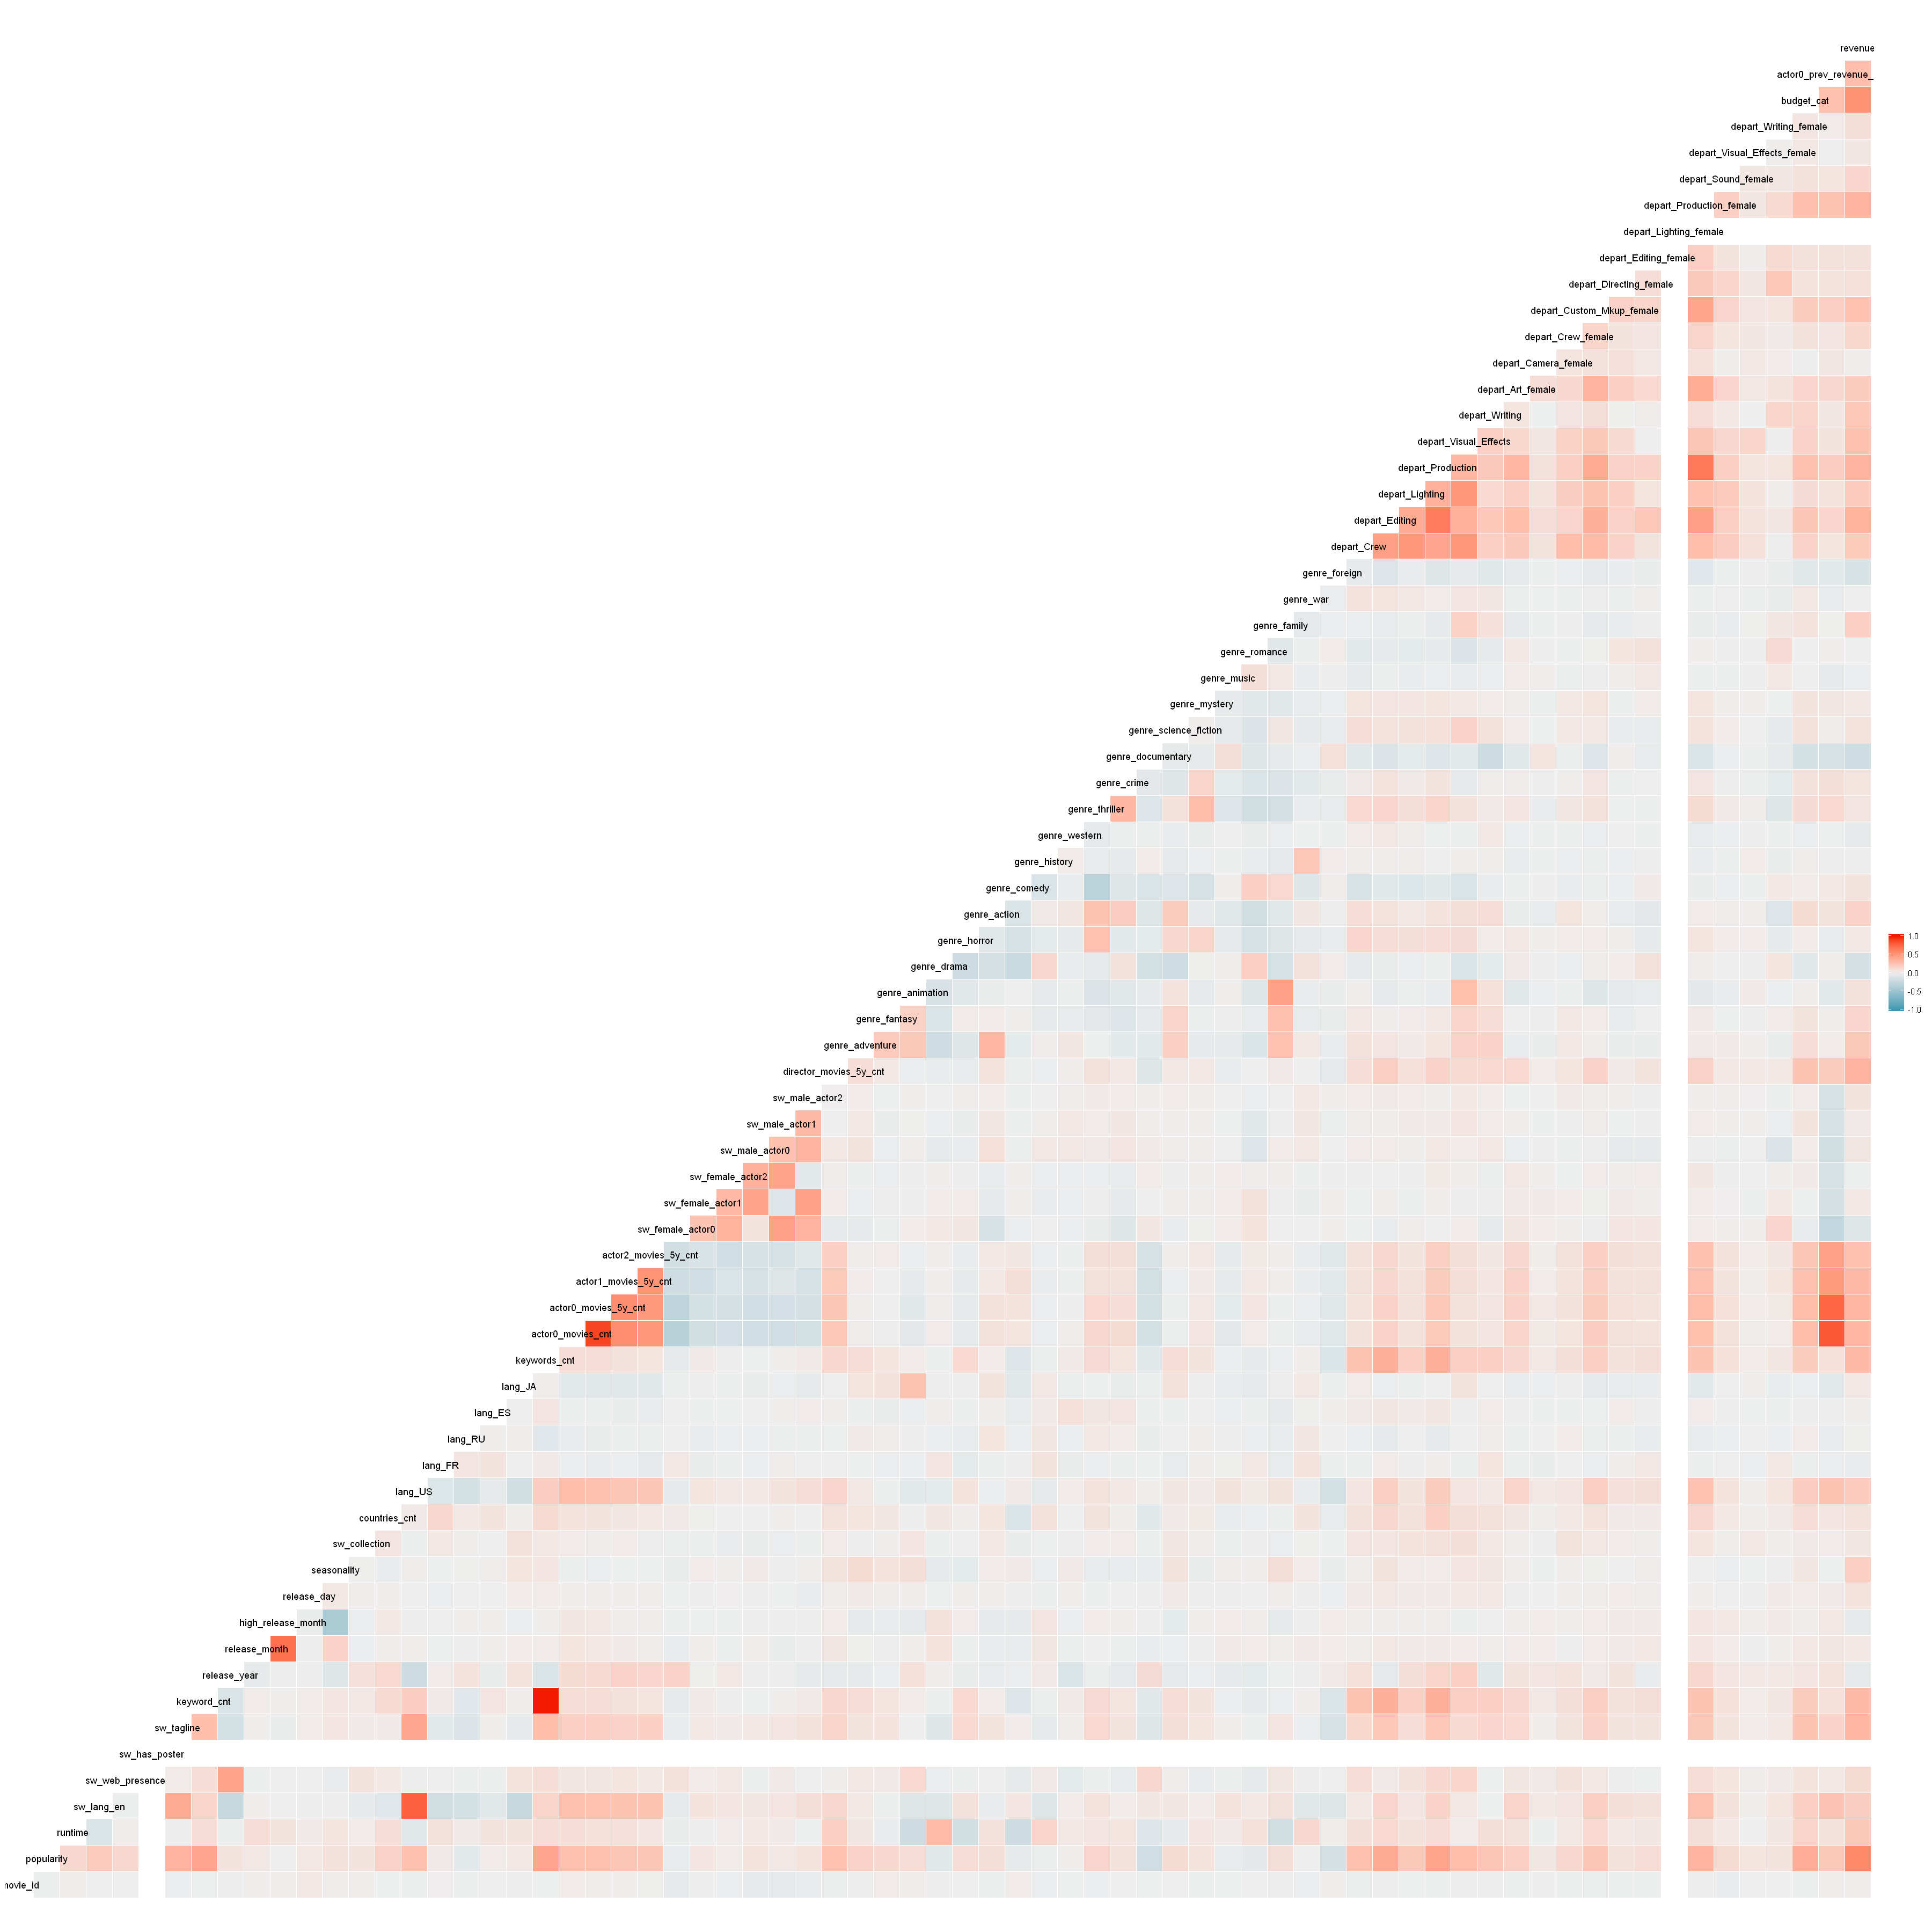

In [346]:
library(GGally)
options(repr.plot.width = 30, repr.plot.height = 30)
ggcorr(movies.clean.data, method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

Warning message in ggcorr(movies.clean.data[, c(1:18, 74)], method = c("pairwise", :
"data in column(s) 'original_language', 'release_date', 'runtime_cat' are not numeric and were ignored"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning mes

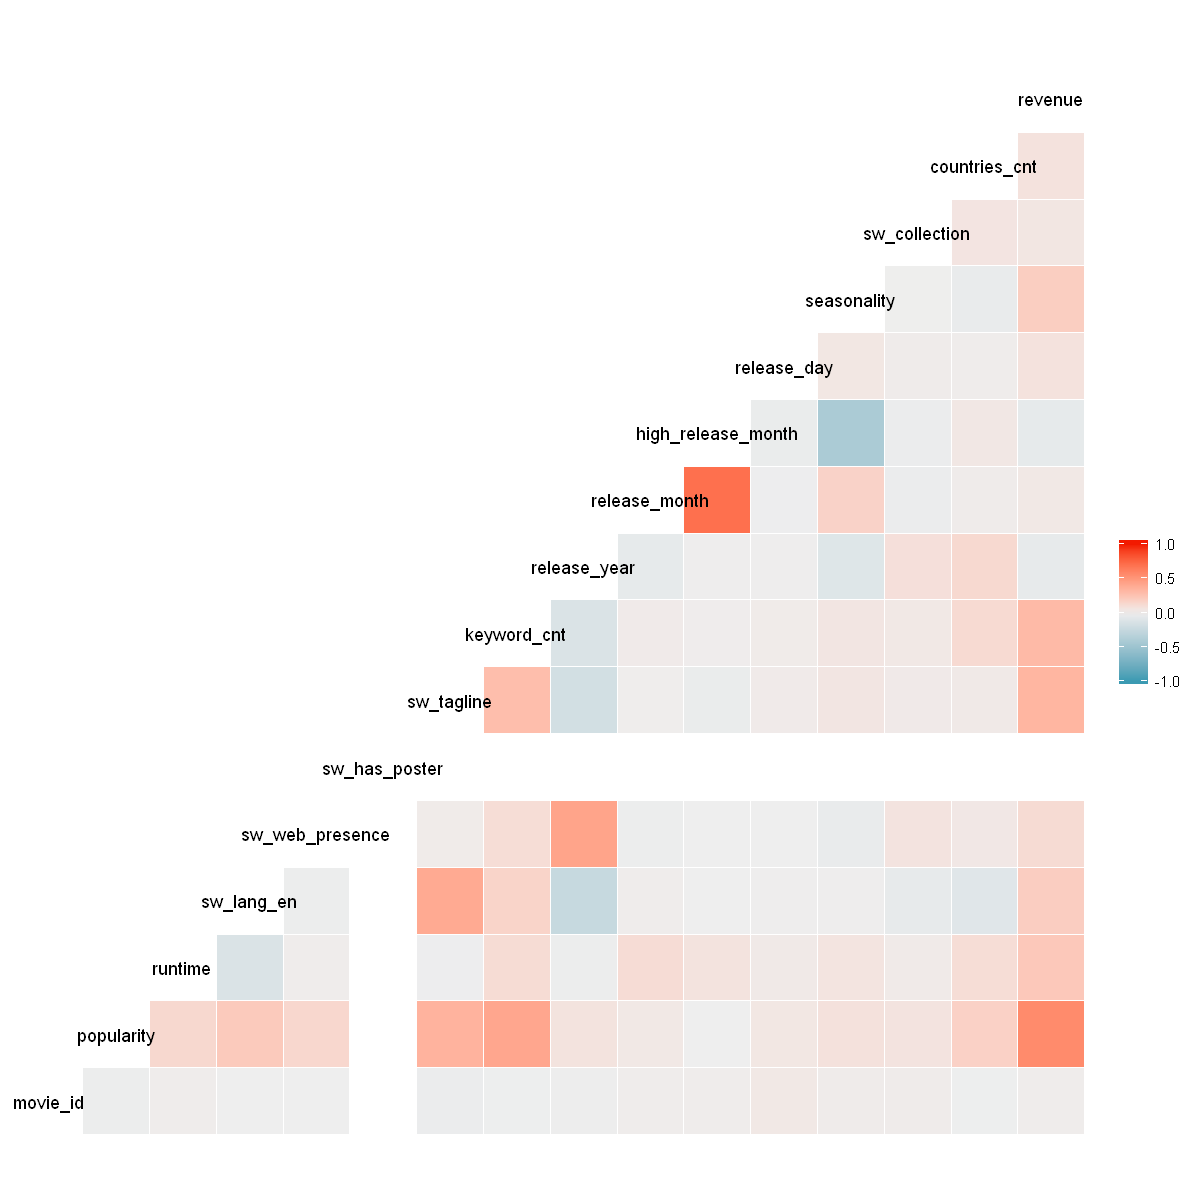

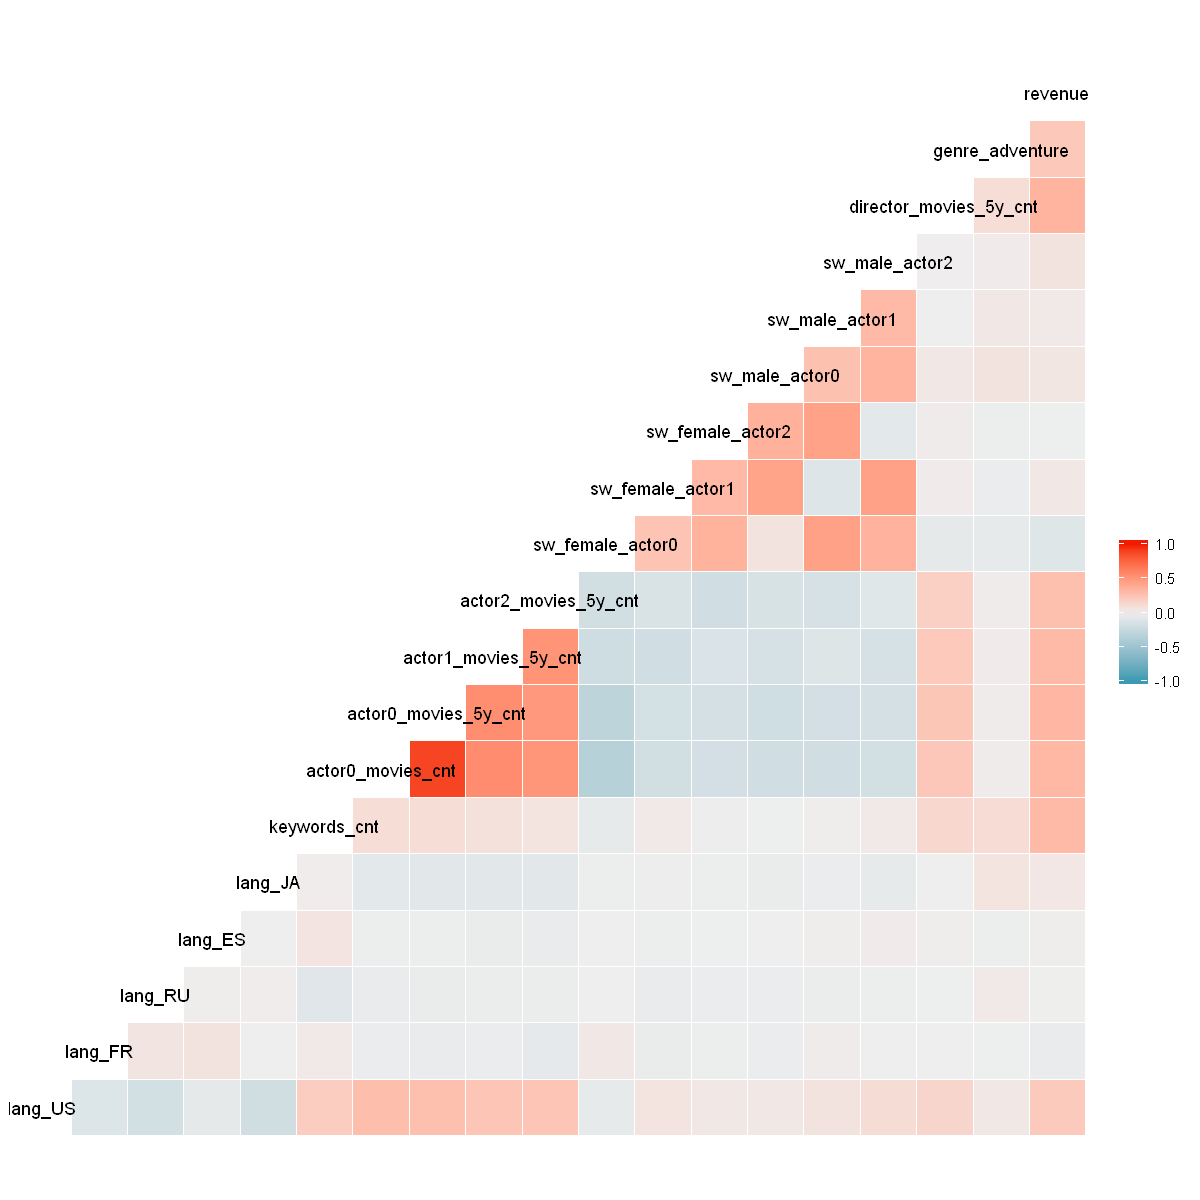

Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"
Warning message in cor(data, use = method[1], method = method[2]):
"the standard deviation is zero"


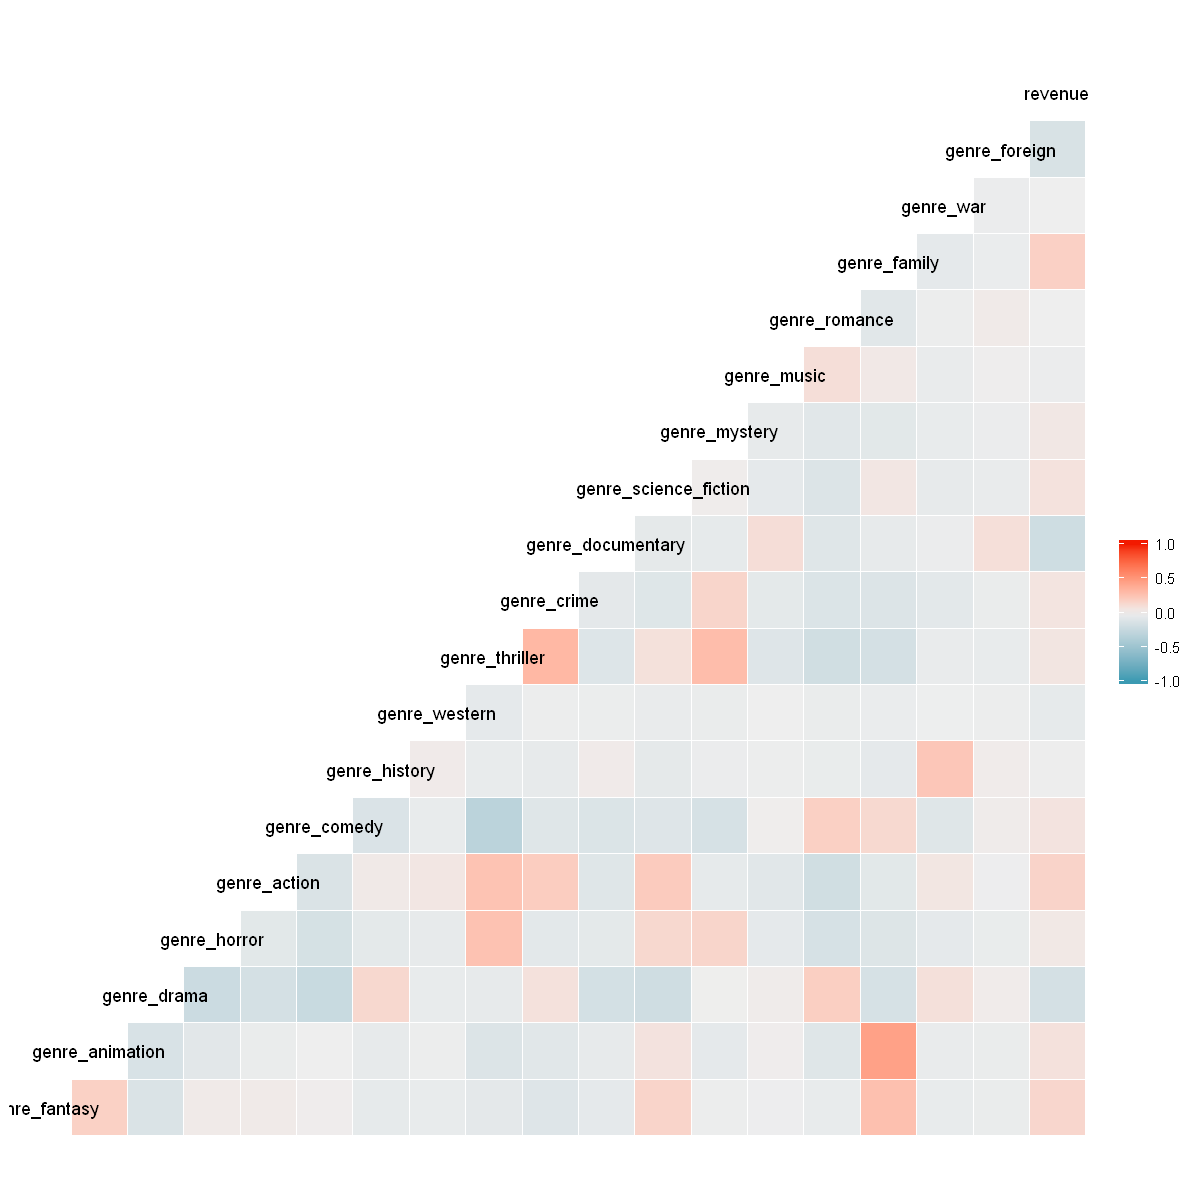

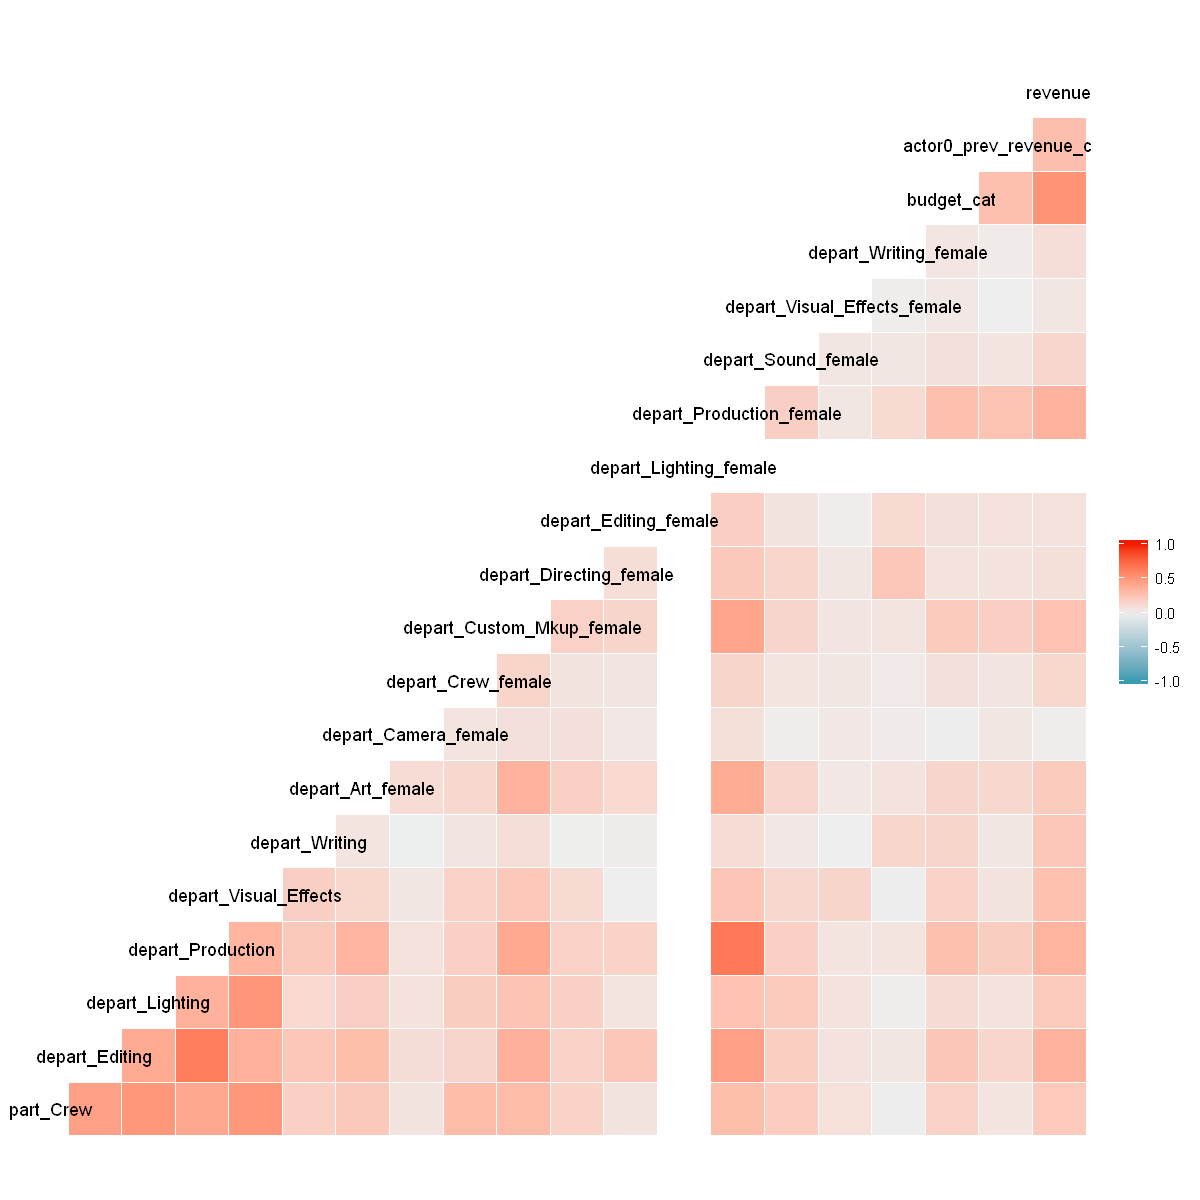

In [348]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggcorr(movies.clean.data[,c(1:18,74)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies.clean.data[,c(19:36,74)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies.clean.data[,c(37:54,74)], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

ggcorr(movies.clean.data[,55:74], method = c("pairwise", "spearman"),
  nbreaks = NULL, digits = 2, low = "#3B9AB2",
  mid = "#EEEEEE", high = "#F21A00",
  geom = "tile", label = FALSE,
  label_alpha = FALSE)

